Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pasude labeling (thresholds:0.5), timeout
# Version = "v9" # pasude labeling (thresholds:0.6), timeout
# Version = "v10" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pasude labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
Version = "v17" # Modifications with remove noisy label func, Calibration,

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=39

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1以上であれば1に置換
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
def calibration(y_pred, target_rate):
    return y_pred / (y_pred + (1 - y_pred) / target_rate)

In [13]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=1, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred_calib = calibration(y_pred, target_rate)
        y_preds.append(y_pred_calib)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [14]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.01,
    'objective': "binary",
    'subsample':0.7,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2
    
}

In [15]:
def convert_label(df, confidence, threshold):
    df = df.copy()
    Probability = df.iloc[:,0]
    conf_index = df[Probability > confidence].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        Threshold = 0.5
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict(X_val, num_iteration=clf.best_iteration_)
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"* corect_labels: {sum(y_corect)}/{len(y_corect)}, noisy_labels: {len(y)-len(y_corect)} *")
            
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        confidence = y_prob.probability.max()*0.3
        p_label, conf_idx = convert_label(y_prob, confidence=confidence, threshold=Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"** p_label_rate: {p_label_rate:.4f} Vs.target_rate: {target_rate:.4f}, Num_p_label: {sum(p_label)} **")
        
        # Set the params of confidence and threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        if p_label_rate*2 < target_rate:
            check = len(y_prob)*target_rate*3
            for _ in range(10):
                print(sum(p_label), check)
                if (sum(p_label) > check) or (sum(p_label) > 0): break
                Threshold -= 0.03
                p_label, conf_idx = convert_label(y_prob, confidence=confidence, threshold=Threshold)
                y_prob = y_prob[y_prob.index.isin(conf_idx)].copy()
               
                
        if p_label_rate > target_rate*2:
            check = len(y_prob)*target_rate*3
            for _ in range(10):
                if (sum(p_label) < check) or (sum(p_label) < 5): break
                Threshold += 0.04
                
                p_label, conf_idx = convert_label(y_prob, confidence=confidence, threshold=Threshold)
                y_prob = y_prob[y_prob.index.isin(conf_idx)].copy()
                
              
        X_conf = X_test[X_test.index.isin(conf_idx)].copy()
        
        logger.info(f"*** confidence:{confidence}, threshold:{Threshold}, p_label:{sum(p_label)}/{len(p_label)} ***")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates().reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
    return X, y

In [17]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [18]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [19]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [20]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [21]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [22]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [23]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [24]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [26]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [28]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [29]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [30]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [31]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [32]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [33]:
# Based on v8 notebook with feature importance

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [34]:
FI = data[importance_cols]
FI = FI.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
FI

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [35]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [36]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])
    

In [37]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [38]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 2)


In [39]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
(27796, 10)
(27796, 2)
(27796, 10)
(27796, 2)


In [40]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [41]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
]

In [42]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g_d_g_2',
 'pca_g_d_g_3',
 'pca_c_d_c_1',
 'pca_c_d_c_2',


In [43]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_g_3,pca_c_1,pca_c_2,pca_c_3,pca_d_g_1,pca_d_g_2,pca_d_g_3,pca_d_c_1,pca_d_c_2,pca_d_c_3
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,-1.140890,-0.469951,0.099505,0.543770,-0.412404,0.344801,0.037566,-0.352178,0.185292,0.004245
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,0.393231,-0.814709,0.613391,-0.238404,-0.522178,-0.182825,0.440264,-0.575022,0.122275,0.280131
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,-0.603388,-0.262629,-0.104706,0.204114,-0.150261,0.224066,-0.477699,-0.254322,0.146491,-0.005201
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,0.520171,-0.202956,-0.340746,-1.418043,-0.040187,-0.775782,-0.318853,-0.157597,-0.122486,-0.020528
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,-2.687000,1.478095,0.804459,2.194776,1.834257,0.532104,-2.136533,0.808826,-0.534457,-0.547478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,0.282427,-0.124308,-0.178446,0.631366,-0.533474,1.250751,0.927038,-0.070210,0.002111,-0.157756
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,-2.186621,0.986815,5.615881,-1.809798,1.305137,1.420641,-1.273816,1.123556,-2.183204,0.610776
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,-1.047883,-0.212064,0.409555,2.046140,-0.126035,0.358089,-0.604766,-0.223797,0.372728,0.561805
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,0.111515,0.261040,-0.357443,0.309463,-0.092845,-0.936262,-0.360358,0.259394,-0.407341,0.143140


In [44]:
# Merge data
result_df = pd.concat([result_df, FI], axis=1)

In [45]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [46]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [47]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [48]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [49]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266857	valid_1's binary_logloss: 0.309932
[200]	training's binary_logloss: 0.120435	valid_1's binary_logloss: 0.173824
[300]	training's binary_logloss: 0.0586016	valid_1's binary_logloss: 0.108028
[400]	training's binary_logloss: 0.0295632	valid_1's binary_logloss: 0.0726233
[500]	training's binary_logloss: 0.0158811	valid_1's binary_logloss: 0.051396
[600]	training's binary_logloss: 0.00926554	valid_1's binary_logloss: 0.0398703
[700]	training's binary_logloss: 0.00583754	valid_1's binary_logloss: 0.0331779
[800]	training's binary_logloss: 0.00406596	valid_1's binary_logloss: 0.0298622
[900]	training's binary_logloss: 0.00304302	valid_1's binary_logloss: 0.0275643
[1000]	training's binary_logloss: 0.00241619	valid_1's binary_logloss: 0.0255303
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00241619	valid_1's binary_logloss: 0.0255303
Training until valid

* corect_labels: 498/995, noisy_labels: 5 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0007, Num_p_label: 5.0 **
*** confidence:0.19724032422488552, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262952	valid_1's binary_logloss: 0.310263
[200]	training's binary_logloss: 0.11665	valid_1's binary_logloss: 0.175495
[300]	training's binary_logloss: 0.0552689	valid_1's binary_logloss: 0.1114
[400]	training's binary_logloss: 0.0281145	valid_1's binary_logloss: 0.0799865
[500]	training's binary_logloss: 0.0152606	valid_1's binary_logloss: 0.06274
[600]	training's binary_logloss: 0.00896923	valid_1's binary_logloss: 0.052942
[700]	training's binary_logloss: 0.00559981	valid_1's binary_logloss: 0.0447771
[800]	training's binary_logloss: 0.003856	valid_1's binary_logloss: 0.0400563
[900]	training's binary_logloss: 0.00289102	valid_1's binary_logloss: 0.036773
[1000]	training's binary_logloss: 0.00232001	valid_1's binary_logloss: 0.0339929
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00232001	valid_1's binary_logloss: 0.0339929
Training until validation sc

* corect_labels: 488.0/1044, noisy_labels: 13 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0007, Num_p_label: 0.0 **
*** confidence:0.1231279408626523, threshold:0.4099999999999999, p_label:1.0/21 ***
================= Pseudo labeling 3 / 3 =================


0.0 8.527840765936004
0.0 8.527840765936004
0.0 8.527840765936004
1.0 8.527840765936004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267189	valid_1's binary_logloss: 0.333674
[200]	training's binary_logloss: 0.1198	valid_1's binary_logloss: 0.184597
[300]	training's binary_logloss: 0.0563604	valid_1's binary_logloss: 0.112058
[400]	training's binary_logloss: 0.0287072	valid_1's binary_logloss: 0.0764522
[500]	training's binary_logloss: 0.0154249	valid_1's binary_logloss: 0.0568689
[600]	training's binary_logloss: 0.00899458	valid_1's binary_logloss: 0.0454216
[700]	training's binary_logloss: 0.00571483	valid_1's binary_logloss: 0.0367971
[800]	training's binary_logloss: 0.00398351	valid_1's binary_logloss: 0.0316751
[900]	training's binary_logloss: 0.00296889	valid_1's binary_logloss: 0.0283799
[1000]	training's binary_logloss: 0.00233159	valid_1's binary_logloss: 0.0260209
Did not meet early stopping. Best iteration is:
[1000]	trainin

* corect_labels: 488.0/1058, noisy_labels: 3 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0007, Num_p_label: 1.0 **
*** confidence:0.2730557135602799, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 529
len(valid_index) : 530
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


1.0 8.527840765936004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266604	valid_1's binary_logloss: 0.336232
[200]	training's binary_logloss: 0.118692	valid_1's binary_logloss: 0.197189
[300]	training's binary_logloss: 0.0562698	valid_1's binary_logloss: 0.135853
[400]	training's binary_logloss: 0.0282659	valid_1's binary_logloss: 0.105769
[500]	training's binary_logloss: 0.0150352	valid_1's binary_logloss: 0.0880274
[600]	training's binary_logloss: 0.00872387	valid_1's binary_logloss: 0.0767192
[700]	training's binary_logloss: 0.00552984	valid_1's binary_logloss: 0.0676613
[800]	training's binary_logloss: 0.00384183	valid_1's binary_logloss: 0.0615691
[900]	training's binary_logloss: 0.00289907	valid_1's binary_logloss: 0.0565202
[1000]	training's binary_logloss: 0.002316	valid_1's binary_logloss: 0.0527639
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.002316	valid_1's binary_logloss: 0.0527639


len(train_index) : 530
len(valid_index) : 529
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265532	valid_1's binary_logloss: 0.307752
[200]	training's binary_logloss: 0.119538	valid_1's binary_logloss: 0.168561
[300]	training's binary_logloss: 0.057323	valid_1's binary_logloss: 0.100457
[400]	training's binary_logloss: 0.0291044	valid_1's binary_logloss: 0.0650727
[500]	training's binary_logloss: 0.0158059	valid_1's binary_logloss: 0.0463396
[600]	training's binary_logloss: 0.0092319	valid_1's binary_logloss: 0.0355664
[700]	training's binary_logloss: 0.00585501	valid_1's binary_logloss: 0.0283812
[800]	training's binary_logloss: 0.00405654	valid_1's binary_logloss: 0.023551
[900]	training's binary_logloss: 0.003048	valid_1's binary_logloss: 0.020744
[1000]	training's binary_logloss: 0.00244593	valid_1's binary_logloss: 0.0185833
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00244593	valid_1's binary_logloss: 0.0185833


5-alpha_reductase_inhibitor logloss: 0.03568976254857144
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286225	valid_1's binary_logloss: 0.33159
[200]	training's binary_logloss: 0.12956	valid_1's binary_logloss: 0.192302
[300]	training's binary_logloss: 0.0622604	valid_1's binary_logloss: 0.125671
[400]	training's binary_logloss: 0.0315095	valid_1's binary_logloss: 0.0901966
[500]	training's binary_logloss: 0.017002	valid_1's binary_logloss: 0.0681622
[600]	training's binary_logloss: 0.00989296	valid_1's binary_logloss: 0.0535942
[700]	training's binary_logloss: 0.00633017	valid_1's binary_logloss: 0.0442688
[800]	training's binary_logloss: 0.00443885	valid_1's binary_logloss: 0.0381059
[900]	training's binary_logloss: 0.0033333	valid_1's binary_logloss: 0.0342442
[1000]	training's binary_logloss: 0.00264029	valid_1's binary_logloss: 0.0312119
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00264029	valid_1's binary_logloss: 0.0312119
Training until validati

* corect_labels: 500/992, noisy_labels: 8 *
** p_label_rate: 0.0060 Vs.target_rate: 0.0008, Num_p_label: 24.0 **
*** confidence:0.23909872221978692, threshold:0.6200000000000001, p_label:9.0/122 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271707	valid_1's binary_logloss: 0.334265
[200]	training's binary_logloss: 0.124351	valid_1's binary_logloss: 0.195009
[300]	training's binary_logloss: 0.0607513	valid_1's binary_logloss: 0.135004
[400]	training's binary_logloss: 0.0306047	valid_1's binary_logloss: 0.104869
[500]	training's binary_logloss: 0.0162119	valid_1's binary_logloss: 0.0878197
[600]	training's binary_logloss: 0.00944808	valid_1's binary_logloss: 0.0769646
[700]	training's binary_logloss: 0.0060477	valid_1's binary_logloss: 0.0714583
[800]	training's binary_logloss: 0.00422264	valid_1's binary_logloss: 0.0685945
Early stopping, best iteration is:
[872]	training's binary_logloss: 0.00342449	valid_1's binary_logloss: 0.0672854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282789	valid_1's binary_logloss: 0.312225
[200]	training's binary_logloss: 0.134319	valid_1's binary

* corect_labels: 500.0/1102, noisy_labels: 12 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0008, Num_p_label: 7.0 **
*** confidence:0.19664942627812024, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269781	valid_1's binary_logloss: 0.326193
[200]	training's binary_logloss: 0.116829	valid_1's binary_logloss: 0.1871
[300]	training's binary_logloss: 0.0536076	valid_1's binary_logloss: 0.121809
[400]	training's binary_logloss: 0.0259884	valid_1's binary_logloss: 0.0870432
[500]	training's binary_logloss: 0.0136759	valid_1's binary_logloss: 0.0693455
[600]	training's binary_logloss: 0.00794825	valid_1's binary_logloss: 0.0597078
[700]	training's binary_logloss: 0.00510519	valid_1's binary_logloss: 0.0513294
[800]	training's binary_logloss: 0.00359383	valid_1's binary_logloss: 0.0470153
[900]	training's binary_logloss: 0.00274107	valid_1's binary_logloss: 0.0443345
[1000]	training's binary_logloss: 0.00221632	valid_1's binary_logloss: 0.0423569
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00221632	valid_1's binary_logloss: 0.0423569
Training until valida

* corect_labels: 494.0/1109, noisy_labels: 8 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.1199943338074963, threshold:0.3799999999999999, p_label:1.0/12 ***
len(train_index) : 559
len(valid_index) : 559
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272067	valid_1's binary_logloss: 0.306731
[200]	training's binary_logloss: 0.12196	valid_1's binary_logloss: 0.165087
[300]	training's binary_logloss: 0.0588099	valid_1's binary_logloss: 0.101856
[400]	training's binary_logloss: 0.0294657	valid_1's binary_logloss: 0.0699416
[500]	training's binary_logloss: 0.0157107	valid_1's binary_logloss: 0.0531366
[600]	training's binary_logloss: 0.00908793	valid_1's binary_logloss: 0.0419436
[700]	training's binary_logloss: 0.00577338	valid_1's binary_logloss: 0.035155
[800]	training's binary_logloss: 0.00402843	valid_1's binary_logloss: 0.0305739
[900]	training's binary_logloss: 0.0030392	valid_1's binary_logloss: 0.0273439
[1000]	training's binary_logloss: 0.00243845	valid_1's binary_logloss: 0.0252681
Did not meet early stopping. Best iterati

len(train_index) : 559
len(valid_index) : 559
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274064	valid_1's binary_logloss: 0.313239
[200]	training's binary_logloss: 0.125162	valid_1's binary_logloss: 0.171327
[300]	training's binary_logloss: 0.0606955	valid_1's binary_logloss: 0.102474
[400]	training's binary_logloss: 0.0308994	valid_1's binary_logloss: 0.0678715
[500]	training's binary_logloss: 0.0164809	valid_1's binary_logloss: 0.0486271
[600]	training's binary_logloss: 0.00949788	valid_1's binary_logloss: 0.038152
[700]	training's binary_logloss: 0.00594054	valid_1's binary_logloss: 0.0319036
[800]	training's binary_logloss: 0.00410853	valid_1's binary_logloss: 0.0281352
[900]	training's binary_logloss: 0.00308472	valid_1's binary_logloss: 0.0257577
[1000]	training's binary_logloss: 0.00246123	valid_1's binary_logloss: 0.0238906
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00246123	valid_1's binary_logloss: 0.0238906


11-beta-hsd1_inhibitor logloss: 0.02457933108948518
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28849	valid_1's binary_logloss: 0.334918
[200]	training's binary_logloss: 0.137702	valid_1's binary_logloss: 0.196415
[300]	training's binary_logloss: 0.0677319	valid_1's binary_logloss: 0.123821
[400]	training's binary_logloss: 0.0352646	valid_1's binary_logloss: 0.0863393
[500]	training's binary_logloss: 0.0194958	valid_1's binary_logloss: 0.0659599
[600]	training's binary_logloss: 0.0116087	valid_1's binary_logloss: 0.053382
[700]	training's binary_logloss: 0.00750885	valid_1's binary_logloss: 0.0464926
[800]	training's binary_logloss: 0.00525607	valid_1's binary_logloss: 0.0415785
[900]	training's binary_logloss: 0.00392156	valid_1's binary_logloss: 0.037603
[1000]	training's binary_logloss: 0.00307809	valid_1's binary_logloss: 0.0348186
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00307809	valid_1's binary_logloss: 0.0348186
Training until validati

* corect_labels: 494/984, noisy_labels: 16 *
** p_label_rate: 0.0070 Vs.target_rate: 0.0010, Num_p_label: 28.0 **
*** confidence:0.24878677702763885, threshold:0.6200000000000001, p_label:12.0/98 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291522	valid_1's binary_logloss: 0.328327
[200]	training's binary_logloss: 0.142991	valid_1's binary_logloss: 0.199489
[300]	training's binary_logloss: 0.073381	valid_1's binary_logloss: 0.136266
[400]	training's binary_logloss: 0.0390462	valid_1's binary_logloss: 0.0994605
[500]	training's binary_logloss: 0.0218607	valid_1's binary_logloss: 0.076392
[600]	training's binary_logloss: 0.0131307	valid_1's binary_logloss: 0.0636066
[700]	training's binary_logloss: 0.00839581	valid_1's binary_logloss: 0.0558975
[800]	training's binary_logloss: 0.00574051	valid_1's binary_logloss: 0.0510171
[900]	training's binary_logloss: 0.00423323	valid_1's binary_logloss: 0.0485833
[1000]	training's binary_logloss: 0.00330524	valid_1's binary_logloss: 0.0471756
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00330524	valid_1's binary_logloss: 0.0471756
Training until validat

* corect_labels: 496.0/1062, noisy_labels: 20 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0010, Num_p_label: 11.0 **
*** confidence:0.2677980055851666, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284037	valid_1's binary_logloss: 0.326645
[200]	training's binary_logloss: 0.131901	valid_1's binary_logloss: 0.19067
[300]	training's binary_logloss: 0.064261	valid_1's binary_logloss: 0.123164
[400]	training's binary_logloss: 0.0334849	valid_1's binary_logloss: 0.087298
[500]	training's binary_logloss: 0.0182604	valid_1's binary_logloss: 0.0663944
[600]	training's binary_logloss: 0.0107447	valid_1's binary_logloss: 0.0535222
[700]	training's binary_logloss: 0.00682365	valid_1's binary_logloss: 0.0459188
[800]	training's binary_logloss: 0.00473791	valid_1's binary_logloss: 0.0409025
[900]	training's binary_logloss: 0.0035282	valid_1's binary_logloss: 0.0377614
[1000]	training's binary_logloss: 0.00277875	valid_1's binary_logloss: 0.035499
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00277875	valid_1's binary_logloss: 0.035499
Training until validation 

* corect_labels: 491.0/1067, noisy_labels: 10 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0010, Num_p_label: 5.0 **
*** confidence:0.26971563697341455, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 535
len(valid_index) : 536
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281867	valid_1's binary_logloss: 0.331767
[200]	training's binary_logloss: 0.131068	valid_1's binary_logloss: 0.188135
[300]	training's binary_logloss: 0.0642681	valid_1's binary_logloss: 0.116985
[400]	training's binary_logloss: 0.0331573	valid_1's binary_logloss: 0.0801453
[500]	training's binary_logloss: 0.0181932	valid_1's binary_logloss: 0.0601821
[600]	training's binary_logloss: 0.0107591	valid_1's binary_logloss: 0.0478006
[700]	training's binary_logloss: 0.0068812	valid_1's binary_logloss: 0.0403586
[800]	training's binary_logloss: 0.00477326	valid_1's binary_logloss: 0.0351753
[900]	training's binary_logloss: 0.00358765	valid_1's binary_logloss: 0.0315664
[1000]	training's binary_logloss: 0.00285315	valid_1's binary_logloss: 0.0294335
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00285315	valid_1's binary_logloss: 0.0294335


len(train_index) : 536
len(valid_index) : 535
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281831	valid_1's binary_logloss: 0.332753
[200]	training's binary_logloss: 0.131157	valid_1's binary_logloss: 0.191699
[300]	training's binary_logloss: 0.0646696	valid_1's binary_logloss: 0.120755
[400]	training's binary_logloss: 0.032954	valid_1's binary_logloss: 0.0816622
[500]	training's binary_logloss: 0.0179466	valid_1's binary_logloss: 0.0589756
[600]	training's binary_logloss: 0.0105314	valid_1's binary_logloss: 0.0452429
[700]	training's binary_logloss: 0.00672279	valid_1's binary_logloss: 0.0369116
[800]	training's binary_logloss: 0.00464243	valid_1's binary_logloss: 0.0314181
[900]	training's binary_logloss: 0.00347305	valid_1's binary_logloss: 0.0279645
[1000]	training's binary_logloss: 0.00276009	valid_1's binary_logloss: 0.0252766
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00276009	valid_1's binary_logloss: 0.0252766


acat_inhibitor logloss: 0.027356981803233715
acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.427697	valid_1's binary_logloss: 0.585907
[200]	training's binary_logloss: 0.278992	valid_1's binary_logloss: 0.531838
[300]	training's binary_logloss: 0.191547	valid_1's binary_logloss: 0.50474
[400]	training's binary_logloss: 0.135034	valid_1's binary_logloss: 0.486757
[500]	training's binary_logloss: 0.0950447	valid_1's binary_logloss: 0.478313
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.0960835	valid_1's binary_logloss: 0.478053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.44668	valid_1's binary_logloss: 0.632579
[200]	training's binary_logloss: 0.297088	valid_1's binary_logloss: 0.600316
[300]	training's binary_logloss: 0.199911	valid_1's binary_logloss: 0.574999
[400]	training's binary_logloss: 0.142629	valid_1's binary_logloss: 0.563862


* corect_labels: 377/740, noisy_labels: 260 *
** p_label_rate: 0.2504 Vs.target_rate: 0.0080, Num_p_label: 997.0 **


[500]	training's binary_logloss: 0.101543	valid_1's binary_logloss: 0.55159
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.0995699	valid_1's binary_logloss: 0.551242


*** confidence:0.2762216222851201, threshold:0.7400000000000002, p_label:75.0/2990 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160514	valid_1's binary_logloss: 0.236568
[200]	training's binary_logloss: 0.0867761	valid_1's binary_logloss: 0.204147
[300]	training's binary_logloss: 0.0513625	valid_1's binary_logloss: 0.190075
[400]	training's binary_logloss: 0.0318444	valid_1's binary_logloss: 0.184241
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.0331981	valid_1's binary_logloss: 0.184134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164624	valid_1's binary_logloss: 0.244197
[200]	training's binary_logloss: 0.0904209	valid_1's binary_logloss: 0.204837
[300]	training's binary_logloss: 0.0532461	valid_1's binary_logloss: 0.18603
[400]	training's binary_logloss: 0.0328056	valid_1's binary_logloss: 0.177125
[500]	training's binary_logloss: 0.0204398	valid_1's binary_logloss: 0.1734
Early stopping, best iteration is:
[512]	training's binary_logloss: 

* corect_labels: 262.0/3504, noisy_labels: 226 *
** p_label_rate: 0.0040 Vs.target_rate: 0.0080, Num_p_label: 16.0 **
*** confidence:0.20022875707136614, threshold:0.5, p_label:16.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847808	valid_1's binary_logloss: 0.12911
[200]	training's binary_logloss: 0.0426862	valid_1's binary_logloss: 0.0973697
[300]	training's binary_logloss: 0.0228996	valid_1's binary_logloss: 0.081645
[400]	training's binary_logloss: 0.0133003	valid_1's binary_logloss: 0.0736946
[500]	training's binary_logloss: 0.00784459	valid_1's binary_logloss: 0.0688457
[600]	training's binary_logloss: 0.00488141	valid_1's binary_logloss: 0.0666788
[700]	training's binary_logloss: 0.00319955	valid_1's binary_logloss: 0.0644365
[800]	training's binary_logloss: 0.00223016	valid_1's binary_logloss: 0.0633763
Early stopping, best iteration is:
[841]	training's binary_logloss: 0.00196553	valid_1's binary_logloss: 0.0631036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866907	valid_1's binary_logloss: 0.141788
[200]	training's binary_logloss: 0.0417369	valid_1's

* corect_labels: 181.0/3496, noisy_labels: 92 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0080, Num_p_label: 0.0 **
*** confidence:0.0689651655569176, threshold:0.1999999999999998, p_label:4.0/29 ***
len(train_index) : 1750
len(valid_index) : 1751
================================= fold 1/2 acetylcholine_receptor_agonist=================================


0.0 95.3111615016377
0.0 95.3111615016377
0.0 95.3111615016377
0.0 95.3111615016377
0.0 95.3111615016377
0.0 95.3111615016377
0.0 95.3111615016377
0.0 95.3111615016377
0.0 95.3111615016377
0.0 95.3111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578993	valid_1's binary_logloss: 0.0942652
[200]	training's binary_logloss: 0.0261767	valid_1's binary_logloss: 0.068842
[300]	training's binary_logloss: 0.0131085	valid_1's binary_logloss: 0.0587906
[400]	training's binary_logloss: 0.00713238	valid_1's binary_logloss: 0.0545234
[500]	training's binary_logloss: 0.00418089	valid_1's binary_logloss: 0.0527233
[600]	training's binary_logloss: 0.00265157	valid_1's binary_logloss: 0.051797
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.0024026	valid_1's binary_logloss: 0.0515471


len(train_index) : 1751
len(valid_index) : 1750
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598484	valid_1's binary_logloss: 0.0788995
[200]	training's binary_logloss: 0.0273742	valid_1's binary_logloss: 0.0493776
[300]	training's binary_logloss: 0.013889	valid_1's binary_logloss: 0.0365015
[400]	training's binary_logloss: 0.00763757	valid_1's binary_logloss: 0.029805
[500]	training's binary_logloss: 0.00451758	valid_1's binary_logloss: 0.0258153
[600]	training's binary_logloss: 0.00287969	valid_1's binary_logloss: 0.0227938
[700]	training's binary_logloss: 0.00197159	valid_1's binary_logloss: 0.0206165
[800]	training's binary_logloss: 0.00145839	valid_1's binary_logloss: 0.0192051
[900]	training's binary_logloss: 0.00114335	valid_1's binary_logloss: 0.0183524
[1000]	training's binary_logloss: 0.000935752	valid_1's binary_logloss: 0.0176496
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000935752	valid_1's binary_logloss: 0.0176496


acetylcholine_receptor_agonist logloss: 0.03460320987108271
acetylcholine_receptor_antagonist , len(trt) : 301
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.448988	valid_1's binary_logloss: 0.662337
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.351884	valid_1's binary_logloss: 0.653143
Training until validation scores don't improve for 10 rounds


* corect_labels: 301/589, noisy_labels: 411 *
** p_label_rate: 0.3280 Vs.target_rate: 0.0126, Num_p_label: 1306.0 **
*** confidence:0.20484857469146556, threshold:0.6200000000000001, p_label:60.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.581484	valid_1's binary_logloss: 0.681443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11093	valid_1's binary_logloss: 0.168991
[200]	training's binary_logloss: 0.0578704	valid_1's binary_logloss: 0.14464
[300]	training's binary_logloss: 0.0321899	valid_1's binary_logloss: 0.136576
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0243213	valid_1's binary_logloss: 0.135397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11054	valid_1's binary_logloss: 0.174747
[200]	training's binary_logloss: 0.0576886	valid_1's binary_logloss: 0.149562
[300]	training's binary_logloss: 0.0323901	valid_1's binary_logloss: 0.139064


* corect_labels: 176.0/4353, noisy_labels: 218 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0126, Num_p_label: 2.0 **
*** confidence:0.17851756077777592, threshold:0.5, p_label:2.0/3982 ***


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0233836	valid_1's binary_logloss: 0.136679
2.0 150.9929453262787


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463934	valid_1's binary_logloss: 0.0791222
[200]	training's binary_logloss: 0.0209563	valid_1's binary_logloss: 0.0598321
[300]	training's binary_logloss: 0.0105558	valid_1's binary_logloss: 0.0530748
[400]	training's binary_logloss: 0.00562489	valid_1's binary_logloss: 0.0494271
[500]	training's binary_logloss: 0.00326245	valid_1's binary_logloss: 0.0479262
[600]	training's binary_logloss: 0.00206109	valid_1's binary_logloss: 0.0471525
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00190652	valid_1's binary_logloss: 0.0470085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475455	valid_1's binary_logloss: 0.0838718
[200]	training's binary_logloss: 0.0226223	valid_1's binary_logloss: 0.0651582
[300]	training's binary_logloss: 0.0114549	valid_1's binary_logloss: 0.0580747


* corect_labels: 100.0/4333, noisy_labels: 83 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0126, Num_p_label: 0.0 **
*** confidence:0.1038198431871335, threshold:0.31999999999999984, p_label:1.0/5 ***


[400]	training's binary_logloss: 0.00610429	valid_1's binary_logloss: 0.0545589
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00614078	valid_1's binary_logloss: 0.0545132
0.0 150.9929453262787
0.0 150.9929453262787
0.0 150.9929453262787
0.0 150.9929453262787
0.0 150.9929453262787
0.0 150.9929453262787
1.0 150.9929453262787


len(train_index) : 2167
len(valid_index) : 2167
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248119	valid_1's binary_logloss: 0.042722
[200]	training's binary_logloss: 0.0104834	valid_1's binary_logloss: 0.0309095
[300]	training's binary_logloss: 0.00503056	valid_1's binary_logloss: 0.0266066
[400]	training's binary_logloss: 0.00274006	valid_1's binary_logloss: 0.0245464
[500]	training's binary_logloss: 0.00165211	valid_1's binary_logloss: 0.0227101
[600]	training's binary_logloss: 0.00108718	valid_1's binary_logloss: 0.0214022
[700]	training's binary_logloss: 0.000791585	valid_1's binary_logloss: 0.0207893


len(train_index) : 2167
len(valid_index) : 2167
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[747]	training's binary_logloss: 0.000695757	valid_1's binary_logloss: 0.0206412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261797	valid_1's binary_logloss: 0.0510716
[200]	training's binary_logloss: 0.0111773	valid_1's binary_logloss: 0.037483
[300]	training's binary_logloss: 0.00539404	valid_1's binary_logloss: 0.031878
[400]	training's binary_logloss: 0.00289923	valid_1's binary_logloss: 0.0300772


acetylcholine_receptor_antagonist logloss: 0.02494784677931753
acetylcholinesterase_inhibitor , len(trt) : 73


[500]	training's binary_logloss: 0.00172195	valid_1's binary_logloss: 0.0292829
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00174561	valid_1's binary_logloss: 0.0292545


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.379275	valid_1's binary_logloss: 0.487177
[200]	training's binary_logloss: 0.226943	valid_1's binary_logloss: 0.37487
[300]	training's binary_logloss: 0.138991	valid_1's binary_logloss: 0.307921
[400]	training's binary_logloss: 0.0889661	valid_1's binary_logloss: 0.26485
[500]	training's binary_logloss: 0.0579143	valid_1's binary_logloss: 0.235313
[600]	training's binary_logloss: 0.0382123	valid_1's binary_logloss: 0.216131
[700]	training's binary_logloss: 0.0255396	valid_1's binary_logloss: 0.198902
[800]	training's binary_logloss: 0.0178542	valid_1's binary_logloss: 0.188229
[900]	training's binary_logloss: 0.0130124	valid_1's binary_logloss: 0.180478
[1000]	training's binary_logloss: 0.00992544	valid_1's binary_logloss: 0.175024
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00992544	valid_1's binary_logloss: 0.175024
Training until validation scores d

* corect_labels: 470/929, noisy_labels: 71 *
** p_label_rate: 0.0811 Vs.target_rate: 0.0031, Num_p_label: 323.0 **
*** confidence:0.27834120808279056, threshold:0.7800000000000002, p_label:34.0/917 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273756	valid_1's binary_logloss: 0.358195
[200]	training's binary_logloss: 0.152805	valid_1's binary_logloss: 0.275454
[300]	training's binary_logloss: 0.0859327	valid_1's binary_logloss: 0.230301
[400]	training's binary_logloss: 0.0502558	valid_1's binary_logloss: 0.205448
[500]	training's binary_logloss: 0.0304074	valid_1's binary_logloss: 0.191215
[600]	training's binary_logloss: 0.0192181	valid_1's binary_logloss: 0.182846
[700]	training's binary_logloss: 0.0125841	valid_1's binary_logloss: 0.177801
[800]	training's binary_logloss: 0.00866575	valid_1's binary_logloss: 0.174798
Early stopping, best iteration is:
[884]	training's binary_logloss: 0.00658469	valid_1's binary_logloss: 0.173171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290097	valid_1's binary_logloss: 0.343377
[200]	training's binary_logloss: 0.170009	valid_1's binary_loglo

* corect_labels: 441.0/1760, noisy_labels: 86 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0031, Num_p_label: 13.0 **
*** confidence:0.24331150448918834, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23626	valid_1's binary_logloss: 0.318593
[200]	training's binary_logloss: 0.127713	valid_1's binary_logloss: 0.21776
[300]	training's binary_logloss: 0.0723365	valid_1's binary_logloss: 0.160224
[400]	training's binary_logloss: 0.0421943	valid_1's binary_logloss: 0.12551
[500]	training's binary_logloss: 0.0250198	valid_1's binary_logloss: 0.103924
[600]	training's binary_logloss: 0.0151232	valid_1's binary_logloss: 0.0885758
[700]	training's binary_logloss: 0.00964015	valid_1's binary_logloss: 0.0789838
[800]	training's binary_logloss: 0.00652558	valid_1's binary_logloss: 0.0711851
[900]	training's binary_logloss: 0.00471357	valid_1's binary_logloss: 0.064634
[1000]	training's binary_logloss: 0.0036184	valid_1's binary_logloss: 0.0600404
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0036184	valid_1's binary_logloss: 0.0600404
Training until validation sc

* corect_labels: 416.0/1764, noisy_labels: 38 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0031, Num_p_label: 2.0 **
*** confidence:0.19572220473794194, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 888
len(valid_index) : 888
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


2.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226114	valid_1's binary_logloss: 0.284777
[200]	training's binary_logloss: 0.117308	valid_1's binary_logloss: 0.193429
[300]	training's binary_logloss: 0.0657995	valid_1's binary_logloss: 0.146126
[400]	training's binary_logloss: 0.0380741	valid_1's binary_logloss: 0.119282
[500]	training's binary_logloss: 0.0225346	valid_1's binary_logloss: 0.102586
[600]	training's binary_logloss: 0.0138734	valid_1's binary_logloss: 0.0928893
[700]	training's binary_logloss: 0.00892985	valid_1's binary_logloss: 0.0853343
[800]	training's binary_logloss: 0.00615936	valid_1's binary_logloss: 0.0804082
[900]	training's binary_logloss: 0.00448109	valid_1's binary_logloss: 0.0774548
[1000]	training's binary_logloss: 0.0034216	valid_1's binary_logloss: 0.0754426
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0034216	valid_1's binary_logloss: 0.0754426


len(train_index) : 888
len(valid_index) : 888
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230154	valid_1's binary_logloss: 0.287319
[200]	training's binary_logloss: 0.120006	valid_1's binary_logloss: 0.194765
[300]	training's binary_logloss: 0.0659694	valid_1's binary_logloss: 0.142976
[400]	training's binary_logloss: 0.0376618	valid_1's binary_logloss: 0.113704
[500]	training's binary_logloss: 0.0223285	valid_1's binary_logloss: 0.0958366
[600]	training's binary_logloss: 0.013557	valid_1's binary_logloss: 0.0831551
[700]	training's binary_logloss: 0.00871635	valid_1's binary_logloss: 0.0750735
[800]	training's binary_logloss: 0.00596895	valid_1's binary_logloss: 0.0701728
[900]	training's binary_logloss: 0.00434964	valid_1's binary_logloss: 0.0673419
[1000]	training's binary_logloss: 0.00333345	valid_1's binary_logloss: 0.064718
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00333345	valid_1's binary_logloss: 0.064718


acetylcholinesterase_inhibitor logloss: 0.07008029559088762
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.356509	valid_1's binary_logloss: 0.47216
[200]	training's binary_logloss: 0.201922	valid_1's binary_logloss: 0.36305
[300]	training's binary_logloss: 0.11799	valid_1's binary_logloss: 0.301446
[400]	training's binary_logloss: 0.0714185	valid_1's binary_logloss: 0.260595
[500]	training's binary_logloss: 0.0445607	valid_1's binary_logloss: 0.236324
[600]	training's binary_logloss: 0.0284248	valid_1's binary_logloss: 0.218606
[700]	training's binary_logloss: 0.0190476	valid_1's binary_logloss: 0.205224
[800]	training's binary_logloss: 0.0133868	valid_1's binary_logloss: 0.191436
[900]	training's binary_logloss: 0.00985552	valid_1's binary_logloss: 0.184874
[1000]	training's binary_logloss: 0.00760224	valid_1's binary_logloss: 0.180272
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00760224	valid_1's binary_logloss: 0.180272
Training until validation scores d

* corect_labels: 467/938, noisy_labels: 62 *
** p_label_rate: 0.0186 Vs.target_rate: 0.0023, Num_p_label: 74.0 **
*** confidence:0.2665715080077852, threshold:0.6200000000000001, p_label:24.0/393 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.334743	valid_1's binary_logloss: 0.426836
[200]	training's binary_logloss: 0.190909	valid_1's binary_logloss: 0.323439
[300]	training's binary_logloss: 0.115131	valid_1's binary_logloss: 0.269977
[400]	training's binary_logloss: 0.0714338	valid_1's binary_logloss: 0.235351
[500]	training's binary_logloss: 0.0431187	valid_1's binary_logloss: 0.208449
[600]	training's binary_logloss: 0.0273264	valid_1's binary_logloss: 0.195293
[700]	training's binary_logloss: 0.0178983	valid_1's binary_logloss: 0.187413
[800]	training's binary_logloss: 0.0122648	valid_1's binary_logloss: 0.183397
Early stopping, best iteration is:
[812]	training's binary_logloss: 0.0117509	valid_1's binary_logloss: 0.182948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316948	valid_1's binary_logloss: 0.414795
[200]	training's binary_logloss: 0.177933	valid_1's binary_logloss:

* corect_labels: 436.0/1260, noisy_labels: 71 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0023, Num_p_label: 14.0 **
*** confidence:0.2449985802356431, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294756	valid_1's binary_logloss: 0.386472
[200]	training's binary_logloss: 0.153744	valid_1's binary_logloss: 0.274799
[300]	training's binary_logloss: 0.0866761	valid_1's binary_logloss: 0.220763
[400]	training's binary_logloss: 0.0503737	valid_1's binary_logloss: 0.192264
[500]	training's binary_logloss: 0.0299084	valid_1's binary_logloss: 0.174367
[600]	training's binary_logloss: 0.0182979	valid_1's binary_logloss: 0.160098
[700]	training's binary_logloss: 0.0118521	valid_1's binary_logloss: 0.151464
[800]	training's binary_logloss: 0.00817488	valid_1's binary_logloss: 0.145137
[900]	training's binary_logloss: 0.00592325	valid_1's binary_logloss: 0.142042
Early stopping, best iteration is:
[953]	training's binary_logloss: 0.00511804	valid_1's binary_logloss: 0.141325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288826	valid_1's binary_log

* corect_labels: 397.0/1231, noisy_labels: 59 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0023, Num_p_label: 1.0 **
*** confidence:0.16773751420137656, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 621
len(valid_index) : 622
================================= fold 1/2 adenosine_receptor_agonist=================================


1.0 27.08843537414966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273873	valid_1's binary_logloss: 0.350618
[200]	training's binary_logloss: 0.13889	valid_1's binary_logloss: 0.23989
[300]	training's binary_logloss: 0.0748501	valid_1's binary_logloss: 0.182664
[400]	training's binary_logloss: 0.0426605	valid_1's binary_logloss: 0.14861
[500]	training's binary_logloss: 0.0251466	valid_1's binary_logloss: 0.126123
[600]	training's binary_logloss: 0.0154705	valid_1's binary_logloss: 0.11078
[700]	training's binary_logloss: 0.0100053	valid_1's binary_logloss: 0.100576
[800]	training's binary_logloss: 0.00692687	valid_1's binary_logloss: 0.0933158
[900]	training's binary_logloss: 0.00509914	valid_1's binary_logloss: 0.0874718
[1000]	training's binary_logloss: 0.00397519	valid_1's binary_logloss: 0.0833735
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00397519	valid_1's binary_logloss: 0.0833735


len(train_index) : 622
len(valid_index) : 621
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285563	valid_1's binary_logloss: 0.332199
[200]	training's binary_logloss: 0.152722	valid_1's binary_logloss: 0.207735
[300]	training's binary_logloss: 0.0871638	valid_1's binary_logloss: 0.140546
[400]	training's binary_logloss: 0.0510514	valid_1's binary_logloss: 0.100649
[500]	training's binary_logloss: 0.0305014	valid_1's binary_logloss: 0.0754712
[600]	training's binary_logloss: 0.0190175	valid_1's binary_logloss: 0.0593365
[700]	training's binary_logloss: 0.012346	valid_1's binary_logloss: 0.0482794
[800]	training's binary_logloss: 0.00851816	valid_1's binary_logloss: 0.0414076
[900]	training's binary_logloss: 0.00624619	valid_1's binary_logloss: 0.0371581
[1000]	training's binary_logloss: 0.00482012	valid_1's binary_logloss: 0.0339614
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00482012	valid_1's binary_logloss: 0.0339614


adenosine_receptor_agonist logloss: 0.058687355540141775
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.39245	valid_1's binary_logloss: 0.519025
[200]	training's binary_logloss: 0.242345	valid_1's binary_logloss: 0.434254
[300]	training's binary_logloss: 0.156057	valid_1's binary_logloss: 0.383188
[400]	training's binary_logloss: 0.102635	valid_1's binary_logloss: 0.345575
[500]	training's binary_logloss: 0.0693519	valid_1's binary_logloss: 0.320337
[600]	training's binary_logloss: 0.0479499	valid_1's binary_logloss: 0.300494
[700]	training's binary_logloss: 0.0336381	valid_1's binary_logloss: 0.287546
[800]	training's binary_logloss: 0.0241001	valid_1's binary_logloss: 0.275615
[900]	training's binary_logloss: 0.0177411	valid_1's binary_logloss: 0.268946
[1000]	training's binary_logloss: 0.0136269	valid_1's binary_logloss: 0.263403
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0136269	valid_1's binary_logloss: 0.263403
Training until validation scores don

* corect_labels: 457/874, noisy_labels: 126 *
** p_label_rate: 0.0585 Vs.target_rate: 0.0040, Num_p_label: 233.0 **
*** confidence:0.2805795136394412, threshold:0.7400000000000002, p_label:38.0/898 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289733	valid_1's binary_logloss: 0.378556
[200]	training's binary_logloss: 0.164747	valid_1's binary_logloss: 0.293939
[300]	training's binary_logloss: 0.0999393	valid_1's binary_logloss: 0.25025
[400]	training's binary_logloss: 0.0612261	valid_1's binary_logloss: 0.225047
[500]	training's binary_logloss: 0.0386616	valid_1's binary_logloss: 0.210317
[600]	training's binary_logloss: 0.0245644	valid_1's binary_logloss: 0.198755
[700]	training's binary_logloss: 0.0163185	valid_1's binary_logloss: 0.194311
[800]	training's binary_logloss: 0.0112412	valid_1's binary_logloss: 0.190658
Early stopping, best iteration is:
[884]	training's binary_logloss: 0.00854394	valid_1's binary_logloss: 0.189372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293003	valid_1's binary_logloss: 0.390221
[200]	training's binary_logloss: 0.168315	valid_1's binary_logloss

* corect_labels: 424.0/1661, noisy_labels: 111 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0040, Num_p_label: 15.0 **
*** confidence:0.24385049325986774, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242007	valid_1's binary_logloss: 0.315081
[200]	training's binary_logloss: 0.125989	valid_1's binary_logloss: 0.226416
[300]	training's binary_logloss: 0.0703339	valid_1's binary_logloss: 0.181916
[400]	training's binary_logloss: 0.0406958	valid_1's binary_logloss: 0.156136
[500]	training's binary_logloss: 0.0246287	valid_1's binary_logloss: 0.139587
[600]	training's binary_logloss: 0.0153878	valid_1's binary_logloss: 0.129282
[700]	training's binary_logloss: 0.0100157	valid_1's binary_logloss: 0.123153
[800]	training's binary_logloss: 0.00691198	valid_1's binary_logloss: 0.117399
[900]	training's binary_logloss: 0.00500332	valid_1's binary_logloss: 0.112601
[1000]	training's binary_logloss: 0.00386277	valid_1's binary_logloss: 0.109856
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00386277	valid_1's binary_logloss: 0.109856
Training until validation sco

* corect_labels: 382.0/1639, noisy_labels: 70 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0040, Num_p_label: 2.0 **
*** confidence:0.2724567544006415, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 826
len(valid_index) : 826
================================= fold 1/2 adenosine_receptor_antagonist=================================


2.0 48.15721844293273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221048	valid_1's binary_logloss: 0.288595
[200]	training's binary_logloss: 0.110812	valid_1's binary_logloss: 0.195839
[300]	training's binary_logloss: 0.0594719	valid_1's binary_logloss: 0.150268
[400]	training's binary_logloss: 0.0338198	valid_1's binary_logloss: 0.124131
[500]	training's binary_logloss: 0.0201046	valid_1's binary_logloss: 0.108076
[600]	training's binary_logloss: 0.0123644	valid_1's binary_logloss: 0.0964918
[700]	training's binary_logloss: 0.00808412	valid_1's binary_logloss: 0.0895491
[800]	training's binary_logloss: 0.00558425	valid_1's binary_logloss: 0.0842928
[900]	training's binary_logloss: 0.00408968	valid_1's binary_logloss: 0.0811744
[1000]	training's binary_logloss: 0.00317593	valid_1's binary_logloss: 0.0780315
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00317593	valid_1's binary_logloss: 0.0780315


len(train_index) : 826
len(valid_index) : 826
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220292	valid_1's binary_logloss: 0.26844
[200]	training's binary_logloss: 0.113145	valid_1's binary_logloss: 0.174007
[300]	training's binary_logloss: 0.0618386	valid_1's binary_logloss: 0.127116
[400]	training's binary_logloss: 0.0353361	valid_1's binary_logloss: 0.102597
[500]	training's binary_logloss: 0.0211129	valid_1's binary_logloss: 0.088841
[600]	training's binary_logloss: 0.013093	valid_1's binary_logloss: 0.0807232
[700]	training's binary_logloss: 0.00854534	valid_1's binary_logloss: 0.0748744
[800]	training's binary_logloss: 0.00598024	valid_1's binary_logloss: 0.0717122
[900]	training's binary_logloss: 0.00442997	valid_1's binary_logloss: 0.0698145
Early stopping, best iteration is:
[967]	training's binary_logloss: 0.00374075	valid_1's binary_logloss: 0.0690878


adenosine_receptor_antagonist logloss: 0.0735596118737711
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27932	valid_1's binary_logloss: 0.329242
[200]	training's binary_logloss: 0.127851	valid_1's binary_logloss: 0.186392
[300]	training's binary_logloss: 0.06084	valid_1's binary_logloss: 0.11512
[400]	training's binary_logloss: 0.0307546	valid_1's binary_logloss: 0.0786276
[500]	training's binary_logloss: 0.0165886	valid_1's binary_logloss: 0.0590487
[600]	training's binary_logloss: 0.00975947	valid_1's binary_logloss: 0.0488196
[700]	training's binary_logloss: 0.00626946	valid_1's binary_logloss: 0.0418859
[800]	training's binary_logloss: 0.00440349	valid_1's binary_logloss: 0.0380534
[900]	training's binary_logloss: 0.00332056	valid_1's binary_logloss: 0.0354938
[1000]	training's binary_logloss: 0.00264495	valid_1's binary_logloss: 0.0335002
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00264495	valid_1's binary_logloss: 0.0335002
Training until validati

* corect_labels: 495/993, noisy_labels: 7 *
** p_label_rate: 0.0151 Vs.target_rate: 0.0008, Num_p_label: 60.0 **
*** confidence:0.28870382286463775, threshold:0.8600000000000003, p_label:9.0/147 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281007	valid_1's binary_logloss: 0.330657
[200]	training's binary_logloss: 0.129969	valid_1's binary_logloss: 0.186824
[300]	training's binary_logloss: 0.0653032	valid_1's binary_logloss: 0.121806
[400]	training's binary_logloss: 0.0343638	valid_1's binary_logloss: 0.08865
[500]	training's binary_logloss: 0.0186919	valid_1's binary_logloss: 0.068791
[600]	training's binary_logloss: 0.0109125	valid_1's binary_logloss: 0.0582681
[700]	training's binary_logloss: 0.00696627	valid_1's binary_logloss: 0.0519954
[800]	training's binary_logloss: 0.00487375	valid_1's binary_logloss: 0.0483337
[900]	training's binary_logloss: 0.00366206	valid_1's binary_logloss: 0.045885
[1000]	training's binary_logloss: 0.00289945	valid_1's binary_logloss: 0.044383
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00289945	valid_1's binary_logloss: 0.044383
Training until validation 

* corect_labels: 490.0/1119, noisy_labels: 21 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0008, Num_p_label: 7.0 **
*** confidence:0.26369343157095415, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272807	valid_1's binary_logloss: 0.329911
[200]	training's binary_logloss: 0.125134	valid_1's binary_logloss: 0.194392
[300]	training's binary_logloss: 0.059165	valid_1's binary_logloss: 0.126042
[400]	training's binary_logloss: 0.0299084	valid_1's binary_logloss: 0.090054
[500]	training's binary_logloss: 0.0157669	valid_1's binary_logloss: 0.0703423
[600]	training's binary_logloss: 0.00903386	valid_1's binary_logloss: 0.0598884
[700]	training's binary_logloss: 0.00573554	valid_1's binary_logloss: 0.0556999
Early stopping, best iteration is:
[789]	training's binary_logloss: 0.00416445	valid_1's binary_logloss: 0.0534246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284695	valid_1's binary_logloss: 0.323293
[200]	training's binary_logloss: 0.126898	valid_1's binary_logloss: 0.172137
[300]	training's binary_logloss: 0.0612448	valid_1's binary_l

* corect_labels: 483.0/1122, noisy_labels: 8 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.17079747512781152, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 565
len(valid_index) : 566
================================= fold 1/2 adenylyl_cyclase_activator=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274557	valid_1's binary_logloss: 0.309242
[200]	training's binary_logloss: 0.126216	valid_1's binary_logloss: 0.163123
[300]	training's binary_logloss: 0.0609364	valid_1's binary_logloss: 0.0924363
[400]	training's binary_logloss: 0.0311466	valid_1's binary_logloss: 0.0560975
[500]	training's binary_logloss: 0.0169141	valid_1's binary_logloss: 0.0363352
[600]	training's binary_logloss: 0.00987507	valid_1's binary_logloss: 0.0255356
[700]	training's binary_logloss: 0.00625019	valid_1's binary_logloss: 0.0190195
[800]	training's binary_logloss: 0.00434199	valid_1's binary_logloss: 0.015229
[900]	training's binary_logloss: 0.00323131	valid_1's binary_logloss: 0.0127162
[1000]	training's binary_logloss: 0.00256384	valid_1's binary_logloss: 0.0110735
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00256384	valid_1's binary_logloss: 0.01107

len(train_index) : 566
len(valid_index) : 565
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278148	valid_1's binary_logloss: 0.321473
[200]	training's binary_logloss: 0.127063	valid_1's binary_logloss: 0.174366
[300]	training's binary_logloss: 0.0603434	valid_1's binary_logloss: 0.10193
[400]	training's binary_logloss: 0.030701	valid_1's binary_logloss: 0.0668715
[500]	training's binary_logloss: 0.0166697	valid_1's binary_logloss: 0.0472146
[600]	training's binary_logloss: 0.00973355	valid_1's binary_logloss: 0.0360947
[700]	training's binary_logloss: 0.00613189	valid_1's binary_logloss: 0.0294854
[800]	training's binary_logloss: 0.00420953	valid_1's binary_logloss: 0.0249108
[900]	training's binary_logloss: 0.00309766	valid_1's binary_logloss: 0.0218248
[1000]	training's binary_logloss: 0.00244364	valid_1's binary_logloss: 0.0198363
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00244364	valid_1's binary_logloss: 0.0198363


adenylyl_cyclase_activator logloss: 0.015451027471499424
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.447592	valid_1's binary_logloss: 0.658912
[200]	training's binary_logloss: 0.312938	valid_1's binary_logloss: 0.638376
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.281619	valid_1's binary_logloss: 0.632861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.453922	valid_1's binary_logloss: 0.655574
[200]	training's binary_logloss: 0.310203	valid_1's binary_logloss: 0.63672
[300]	training's binary_logloss: 0.21727	valid_1's binary_logloss: 0.626922


* corect_labels: 331/654, noisy_labels: 346 *
** p_label_rate: 0.3679 Vs.target_rate: 0.0113, Num_p_label: 1465.0 **
*** confidence:0.24831227756151, threshold:0.7000000000000002, p_label:107.0/3847 ***


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.168927	valid_1's binary_logloss: 0.618264


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147667	valid_1's binary_logloss: 0.225927
[200]	training's binary_logloss: 0.0802064	valid_1's binary_logloss: 0.199695
[300]	training's binary_logloss: 0.0465448	valid_1's binary_logloss: 0.18854
[400]	training's binary_logloss: 0.0287559	valid_1's binary_logloss: 0.185501
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0279889	valid_1's binary_logloss: 0.185282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140467	valid_1's binary_logloss: 0.22441
[200]	training's binary_logloss: 0.0779477	valid_1's binary_logloss: 0.202633
[300]	training's binary_logloss: 0.0470553	valid_1's binary_logloss: 0.192314


* corect_labels: 178.0/4217, noisy_labels: 284 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0113, Num_p_label: 14.0 **
*** confidence:0.23860101342560186, threshold:0.5, p_label:14.0/3982 ***


Early stopping, best iteration is:
[368]	training's binary_logloss: 0.0335348	valid_1's binary_logloss: 0.189893
14.0 135.4421768707483


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582015	valid_1's binary_logloss: 0.091175
[200]	training's binary_logloss: 0.0284448	valid_1's binary_logloss: 0.0748405
[300]	training's binary_logloss: 0.0142239	valid_1's binary_logloss: 0.0667022
[400]	training's binary_logloss: 0.00765422	valid_1's binary_logloss: 0.0635078
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.0077352	valid_1's binary_logloss: 0.0634958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562846	valid_1's binary_logloss: 0.0963894
[200]	training's binary_logloss: 0.0271116	valid_1's binary_logloss: 0.0782876
[300]	training's binary_logloss: 0.0140379	valid_1's binary_logloss: 0.0701226


* corect_labels: 86.0/4223, noisy_labels: 104 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0113, Num_p_label: 0.0 **
*** confidence:0.1434278231683805, threshold:0.47, p_label:1.0/3982 ***


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00933859	valid_1's binary_logloss: 0.0688672
0.0 135.4421768707483
1.0 135.4421768707483


len(train_index) : 2114
len(valid_index) : 2115
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240054	valid_1's binary_logloss: 0.0506483
[200]	training's binary_logloss: 0.010753	valid_1's binary_logloss: 0.0425104
[300]	training's binary_logloss: 0.00542391	valid_1's binary_logloss: 0.0400549


len(train_index) : 2115
len(valid_index) : 2114
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00363697	valid_1's binary_logloss: 0.0395006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232937	valid_1's binary_logloss: 0.0469017
[200]	training's binary_logloss: 0.010124	valid_1's binary_logloss: 0.0364073
[300]	training's binary_logloss: 0.00501824	valid_1's binary_logloss: 0.0325677
[400]	training's binary_logloss: 0.00277947	valid_1's binary_logloss: 0.0312207


adrenergic_receptor_agonist logloss: 0.03517382655198535
adrenergic_receptor_antagonist , len(trt) : 360


Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00190671	valid_1's binary_logloss: 0.0308451


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.437366	valid_1's binary_logloss: 0.665951
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.445052	valid_1's binary_logloss: 0.665538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.448093	valid_1's binary_logloss: 0.677297


* corect_labels: 286/589, noisy_labels: 411 *
** p_label_rate: 0.4751 Vs.target_rate: 0.0151, Num_p_label: 1892.0 **
*** confidence:0.21441534519253233, threshold:0.6600000000000001, p_label:46.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.354956	valid_1's binary_logloss: 0.670862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104061	valid_1's binary_logloss: 0.168978
[200]	training's binary_logloss: 0.0567798	valid_1's binary_logloss: 0.150667
[300]	training's binary_logloss: 0.0340356	valid_1's binary_logloss: 0.144962
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0230556	valid_1's binary_logloss: 0.14356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103403	valid_1's binary_logloss: 0.1683
[200]	training's binary_logloss: 0.0558603	valid_1's binary_logloss: 0.145194
[300]	training's binary_logloss: 0.0318631	valid_1's binary_logloss: 0.138838
[400]	training's binary_logloss: 0.018742	valid_1's binary_logloss: 0.136815


* corect_labels: 138.0/4346, noisy_labels: 225 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0151, Num_p_label: 7.0 **
*** confidence:0.23404059417019002, threshold:0.5, p_label:7.0/3982 ***


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.0154062	valid_1's binary_logloss: 0.136149
7.0 180.58956916099774


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385174	valid_1's binary_logloss: 0.0647049
[200]	training's binary_logloss: 0.0182905	valid_1's binary_logloss: 0.0507734
[300]	training's binary_logloss: 0.00946091	valid_1's binary_logloss: 0.0463002
[400]	training's binary_logloss: 0.00522705	valid_1's binary_logloss: 0.0435425
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0039007	valid_1's binary_logloss: 0.0432184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369551	valid_1's binary_logloss: 0.0731655
[200]	training's binary_logloss: 0.0167205	valid_1's binary_logloss: 0.0587667
[300]	training's binary_logloss: 0.00850269	valid_1's binary_logloss: 0.0546056
[400]	training's binary_logloss: 0.00467402	valid_1's binary_logloss: 0.0539108


* corect_labels: 76.0/4335, noisy_labels: 68 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0151, Num_p_label: 2.0 **
*** confidence:0.21579150890576074, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 2170


Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00352275	valid_1's binary_logloss: 0.0533731
2.0 180.58956916099774


len(valid_index) : 2170
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189564	valid_1's binary_logloss: 0.04145
[200]	training's binary_logloss: 0.00757749	valid_1's binary_logloss: 0.0325563
[300]	training's binary_logloss: 0.00358601	valid_1's binary_logloss: 0.0293106
[400]	training's binary_logloss: 0.00191682	valid_1's binary_logloss: 0.0282409
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00167077	valid_1's binary_logloss: 0.0280216


len(train_index) : 2170
len(valid_index) : 2170
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185662	valid_1's binary_logloss: 0.0446612
[200]	training's binary_logloss: 0.00765714	valid_1's binary_logloss: 0.0355961
[300]	training's binary_logloss: 0.00364108	valid_1's binary_logloss: 0.0324402


adrenergic_receptor_antagonist logloss: 0.02929194878526525
akt_inhibitor , len(trt) : 66


[400]	training's binary_logloss: 0.00197012	valid_1's binary_logloss: 0.0305799
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00193863	valid_1's binary_logloss: 0.0305623


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.356967	valid_1's binary_logloss: 0.46486
[200]	training's binary_logloss: 0.2036	valid_1's binary_logloss: 0.350548
[300]	training's binary_logloss: 0.121037	valid_1's binary_logloss: 0.275563
[400]	training's binary_logloss: 0.0741274	valid_1's binary_logloss: 0.228937
[500]	training's binary_logloss: 0.0465771	valid_1's binary_logloss: 0.201525
[600]	training's binary_logloss: 0.0302895	valid_1's binary_logloss: 0.182671
[700]	training's binary_logloss: 0.0204867	valid_1's binary_logloss: 0.170072
[800]	training's binary_logloss: 0.0144928	valid_1's binary_logloss: 0.161033
[900]	training's binary_logloss: 0.0106567	valid_1's binary_logloss: 0.153661
[1000]	training's binary_logloss: 0.00825709	valid_1's binary_logloss: 0.149471
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00825709	valid_1's binary_logloss: 0.149471
Training until validation scores do

* corect_labels: 478/946, noisy_labels: 54 *
** p_label_rate: 0.0683 Vs.target_rate: 0.0028, Num_p_label: 272.0 **
*** confidence:0.2888073778268533, threshold:0.8200000000000003, p_label:28.0/800 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283384	valid_1's binary_logloss: 0.353593
[200]	training's binary_logloss: 0.153529	valid_1's binary_logloss: 0.257926
[300]	training's binary_logloss: 0.0868849	valid_1's binary_logloss: 0.203368
[400]	training's binary_logloss: 0.0534393	valid_1's binary_logloss: 0.175957
[500]	training's binary_logloss: 0.03207	valid_1's binary_logloss: 0.155544
[600]	training's binary_logloss: 0.0198796	valid_1's binary_logloss: 0.141773
[700]	training's binary_logloss: 0.0129432	valid_1's binary_logloss: 0.133838
[800]	training's binary_logloss: 0.00893706	valid_1's binary_logloss: 0.12915
[900]	training's binary_logloss: 0.00644535	valid_1's binary_logloss: 0.126268
[1000]	training's binary_logloss: 0.00490142	valid_1's binary_logloss: 0.12453
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00490142	valid_1's binary_logloss: 0.12453
Training until validation scores d

* corect_labels: 451.0/1680, noisy_labels: 66 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0028, Num_p_label: 14.0 **
*** confidence:0.2769839890227854, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261257	valid_1's binary_logloss: 0.315505
[200]	training's binary_logloss: 0.143245	valid_1's binary_logloss: 0.211401
[300]	training's binary_logloss: 0.0823859	valid_1's binary_logloss: 0.152901
[400]	training's binary_logloss: 0.0484675	valid_1's binary_logloss: 0.11794
[500]	training's binary_logloss: 0.0290107	valid_1's binary_logloss: 0.0955239
[600]	training's binary_logloss: 0.0176336	valid_1's binary_logloss: 0.0812333
[700]	training's binary_logloss: 0.0111052	valid_1's binary_logloss: 0.0715366
[800]	training's binary_logloss: 0.0074695	valid_1's binary_logloss: 0.0650814
[900]	training's binary_logloss: 0.00529995	valid_1's binary_logloss: 0.0602501
[1000]	training's binary_logloss: 0.00397322	valid_1's binary_logloss: 0.0560568
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00397322	valid_1's binary_logloss: 0.0560568
Training until validatio

* corect_labels: 423.0/1676, noisy_labels: 39 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0028, Num_p_label: 1.0 **
*** confidence:0.15322463626549299, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 843
len(valid_index) : 843
================================= fold 1/2 akt_inhibitor=================================


1.0 33.108087679516245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234284	valid_1's binary_logloss: 0.306329
[200]	training's binary_logloss: 0.122263	valid_1's binary_logloss: 0.213921
[300]	training's binary_logloss: 0.0691355	valid_1's binary_logloss: 0.16472
[400]	training's binary_logloss: 0.0393478	valid_1's binary_logloss: 0.134851
[500]	training's binary_logloss: 0.023105	valid_1's binary_logloss: 0.117485
[600]	training's binary_logloss: 0.0140069	valid_1's binary_logloss: 0.104894
[700]	training's binary_logloss: 0.00895964	valid_1's binary_logloss: 0.0957269
[800]	training's binary_logloss: 0.00610371	valid_1's binary_logloss: 0.0888493
[900]	training's binary_logloss: 0.00443897	valid_1's binary_logloss: 0.0846384
[1000]	training's binary_logloss: 0.00340413	valid_1's binary_logloss: 0.0818544
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00340413	valid_1's binary_logloss: 0.0818544


len(train_index) : 843
len(valid_index) : 843
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237602	valid_1's binary_logloss: 0.284088
[200]	training's binary_logloss: 0.124497	valid_1's binary_logloss: 0.187861
[300]	training's binary_logloss: 0.0688935	valid_1's binary_logloss: 0.136719
[400]	training's binary_logloss: 0.039179	valid_1's binary_logloss: 0.107837
[500]	training's binary_logloss: 0.0228822	valid_1's binary_logloss: 0.0886187
[600]	training's binary_logloss: 0.0138284	valid_1's binary_logloss: 0.0766564
[700]	training's binary_logloss: 0.00884591	valid_1's binary_logloss: 0.0689202
[800]	training's binary_logloss: 0.00605225	valid_1's binary_logloss: 0.063953
[900]	training's binary_logloss: 0.00441705	valid_1's binary_logloss: 0.060917
[1000]	training's binary_logloss: 0.00340023	valid_1's binary_logloss: 0.0592211
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00340023	valid_1's binary_logloss: 0.0592211


akt_inhibitor logloss: 0.07053774103454859
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290713	valid_1's binary_logloss: 0.34904
[200]	training's binary_logloss: 0.138801	valid_1's binary_logloss: 0.200794
[300]	training's binary_logloss: 0.0680207	valid_1's binary_logloss: 0.119998
[400]	training's binary_logloss: 0.0352358	valid_1's binary_logloss: 0.0814295
[500]	training's binary_logloss: 0.019121	valid_1's binary_logloss: 0.0581686
[600]	training's binary_logloss: 0.0113026	valid_1's binary_logloss: 0.0453438
[700]	training's binary_logloss: 0.00723192	valid_1's binary_logloss: 0.0384428
[800]	training's binary_logloss: 0.00502689	valid_1's binary_logloss: 0.03377
[900]	training's binary_logloss: 0.00374324	valid_1's binary_logloss: 0.0304988
[1000]	training's binary_logloss: 0.00296222	valid_1's binary_logloss: 0.0283682
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00296222	valid_1's binary_logloss: 0.0283682
Training until validatio

* corect_labels: 495/990, noisy_labels: 10 *
** p_label_rate: 0.0186 Vs.target_rate: 0.0008, Num_p_label: 74.0 **
*** confidence:0.26611622620221115, threshold:0.7800000000000002, p_label:8.0/262 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279276	valid_1's binary_logloss: 0.344955
[200]	training's binary_logloss: 0.135114	valid_1's binary_logloss: 0.222176
[300]	training's binary_logloss: 0.0663253	valid_1's binary_logloss: 0.155557
[400]	training's binary_logloss: 0.0333689	valid_1's binary_logloss: 0.115897
[500]	training's binary_logloss: 0.0179633	valid_1's binary_logloss: 0.0969425
[600]	training's binary_logloss: 0.0104111	valid_1's binary_logloss: 0.0871396
[700]	training's binary_logloss: 0.00658298	valid_1's binary_logloss: 0.0809416
[800]	training's binary_logloss: 0.00448343	valid_1's binary_logloss: 0.077467
[900]	training's binary_logloss: 0.00330195	valid_1's binary_logloss: 0.0756447
[1000]	training's binary_logloss: 0.00256122	valid_1's binary_logloss: 0.0743517
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00256122	valid_1's binary_logloss: 0.0743517
Training until validat

* corect_labels: 491.0/1239, noisy_labels: 13 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.15296426609121325, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261933	valid_1's binary_logloss: 0.33584
[200]	training's binary_logloss: 0.122064	valid_1's binary_logloss: 0.200612
[300]	training's binary_logloss: 0.058164	valid_1's binary_logloss: 0.116559
[400]	training's binary_logloss: 0.028964	valid_1's binary_logloss: 0.0717819
[500]	training's binary_logloss: 0.0154372	valid_1's binary_logloss: 0.0479823
[600]	training's binary_logloss: 0.00898899	valid_1's binary_logloss: 0.0354876
[700]	training's binary_logloss: 0.00562649	valid_1's binary_logloss: 0.0269887
[800]	training's binary_logloss: 0.00384023	valid_1's binary_logloss: 0.0215716
[900]	training's binary_logloss: 0.00283021	valid_1's binary_logloss: 0.0182069
[1000]	training's binary_logloss: 0.00221983	valid_1's binary_logloss: 0.015927
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00221983	valid_1's binary_logloss: 0.015927
Tra

* corect_labels: 490.0/1245, noisy_labels: 3 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.09575836606609794, threshold:0.2899999999999998, p_label:1.0/8 ***
len(train_index) : 625
len(valid_index) : 625
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269239	valid_1's binary_logloss: 0.30474
[200]	training's binary_logloss: 0.123196	valid_1's binary_logloss: 0.164834
[300]	training's binary_logloss: 0.060533	valid_1's binary_logloss: 0.0992438
[400]	training's binary_logloss: 0.0303489	valid_1's binary_logloss: 0.0631529
[500]	training's binary_logloss: 0.0162606	valid_1's binary_logloss: 0.0425069
[600]	training's binary_logloss: 0.00932989	valid_1's binary_logloss: 0.0304966
[700]	training's binary_logloss: 0.0058529	valid_1's binary_logloss: 0.0230642
[800]	training's binary_logloss: 0.00401546	valid_1's binary_logloss: 0.0186393
[900]	training's binary_logloss: 0.00296481	valid_1's binary_logloss: 0.0158962
[1000]	training's binary_logloss: 0.00232109	valid_1's binary_l

len(train_index) : 625
len(valid_index) : 625
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264913	valid_1's binary_logloss: 0.323053
[200]	training's binary_logloss: 0.12412	valid_1's binary_logloss: 0.194222
[300]	training's binary_logloss: 0.0606233	valid_1's binary_logloss: 0.124042
[400]	training's binary_logloss: 0.0311179	valid_1's binary_logloss: 0.087096
[500]	training's binary_logloss: 0.0167767	valid_1's binary_logloss: 0.0677356
[600]	training's binary_logloss: 0.00965252	valid_1's binary_logloss: 0.0559713
[700]	training's binary_logloss: 0.00610986	valid_1's binary_logloss: 0.0494525
[800]	training's binary_logloss: 0.00421187	valid_1's binary_logloss: 0.0452551
[900]	training's binary_logloss: 0.00310921	valid_1's binary_logloss: 0.0419377
[1000]	training's binary_logloss: 0.00242904	valid_1's binary_logloss: 0.0397184
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00242904	valid_1's binary_logloss: 0.0397184


aldehyde_dehydrogenase_inhibitor logloss: 0.026902098803852515
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.331363	valid_1's binary_logloss: 0.419278
[200]	training's binary_logloss: 0.175898	valid_1's binary_logloss: 0.290572
[300]	training's binary_logloss: 0.100811	valid_1's binary_logloss: 0.223223
[400]	training's binary_logloss: 0.0586301	valid_1's binary_logloss: 0.180681
[500]	training's binary_logloss: 0.0347017	valid_1's binary_logloss: 0.153231
[600]	training's binary_logloss: 0.0220932	valid_1's binary_logloss: 0.133633
[700]	training's binary_logloss: 0.0147396	valid_1's binary_logloss: 0.12064
[800]	training's binary_logloss: 0.0102299	valid_1's binary_logloss: 0.111173
[900]	training's binary_logloss: 0.00748843	valid_1's binary_logloss: 0.105278
[1000]	training's binary_logloss: 0.0057471	valid_1's binary_logloss: 0.100152
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0057471	valid_1's binary_logloss: 0.100152
Training until validation scores d

* corect_labels: 486/964, noisy_labels: 36 *
** p_label_rate: 0.0289 Vs.target_rate: 0.0018, Num_p_label: 115.0 **
*** confidence:0.25564474024782596, threshold:0.7400000000000002, p_label:21.0/460 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301127	valid_1's binary_logloss: 0.362221
[200]	training's binary_logloss: 0.158195	valid_1's binary_logloss: 0.247265
[300]	training's binary_logloss: 0.0881218	valid_1's binary_logloss: 0.193652
[400]	training's binary_logloss: 0.0503277	valid_1's binary_logloss: 0.163568
[500]	training's binary_logloss: 0.0296976	valid_1's binary_logloss: 0.144811
[600]	training's binary_logloss: 0.0182335	valid_1's binary_logloss: 0.136825
Early stopping, best iteration is:
[688]	training's binary_logloss: 0.0124086	valid_1's binary_logloss: 0.133222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301071	valid_1's binary_logloss: 0.391505
[200]	training's binary_logloss: 0.16438	valid_1's binary_logloss: 0.27805
[300]	training's binary_logloss: 0.0944918	valid_1's binary_logloss: 0.218898
[400]	training's binary_logloss: 0.053778	valid_1's binary_logloss: 0

* corect_labels: 469.0/1375, noisy_labels: 49 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0018, Num_p_label: 8.0 **
*** confidence:0.24564248502282846, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279437	valid_1's binary_logloss: 0.337125
[200]	training's binary_logloss: 0.145663	valid_1's binary_logloss: 0.211469
[300]	training's binary_logloss: 0.0810084	valid_1's binary_logloss: 0.146461
[400]	training's binary_logloss: 0.0458315	valid_1's binary_logloss: 0.10532
[500]	training's binary_logloss: 0.0261127	valid_1's binary_logloss: 0.0779823
[600]	training's binary_logloss: 0.0153956	valid_1's binary_logloss: 0.0610819
[700]	training's binary_logloss: 0.00969046	valid_1's binary_logloss: 0.0494189
[800]	training's binary_logloss: 0.00651563	valid_1's binary_logloss: 0.0419504
[900]	training's binary_logloss: 0.00471089	valid_1's binary_logloss: 0.0369348
[1000]	training's binary_logloss: 0.00361273	valid_1's binary_logloss: 0.0334176
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00361273	valid_1's binary_logloss: 0.0334176
Training until validat

* corect_labels: 455.0/1383, noisy_labels: 18 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0018, Num_p_label: 1.0 **
*** confidence:0.22200245878923874, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 693
len(valid_index) : 693
================================= fold 1/2 alk_inhibitor=================================


1.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272101	valid_1's binary_logloss: 0.316689
[200]	training's binary_logloss: 0.141234	valid_1's binary_logloss: 0.190297
[300]	training's binary_logloss: 0.0763677	valid_1's binary_logloss: 0.12356
[400]	training's binary_logloss: 0.0427944	valid_1's binary_logloss: 0.0856026
[500]	training's binary_logloss: 0.0248704	valid_1's binary_logloss: 0.0627654
[600]	training's binary_logloss: 0.0147724	valid_1's binary_logloss: 0.0476581
[700]	training's binary_logloss: 0.00932876	valid_1's binary_logloss: 0.0384549
[800]	training's binary_logloss: 0.00631883	valid_1's binary_logloss: 0.0327503
[900]	training's binary_logloss: 0.00459475	valid_1's binary_logloss: 0.0288798
[1000]	training's binary_logloss: 0.00354097	valid_1's binary_logloss: 0.0264574
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00354097	valid_1's binary_logloss: 0.0264574

len(train_index) : 693
len(valid_index) : 693
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270084	valid_1's binary_logloss: 0.332844
[200]	training's binary_logloss: 0.136361	valid_1's binary_logloss: 0.21444
[300]	training's binary_logloss: 0.0715912	valid_1's binary_logloss: 0.141607
[400]	training's binary_logloss: 0.0402585	valid_1's binary_logloss: 0.102041
[500]	training's binary_logloss: 0.0237172	valid_1's binary_logloss: 0.0792773
[600]	training's binary_logloss: 0.0144416	valid_1's binary_logloss: 0.0650853
[700]	training's binary_logloss: 0.009156	valid_1's binary_logloss: 0.0538045
[800]	training's binary_logloss: 0.00618627	valid_1's binary_logloss: 0.0460996
[900]	training's binary_logloss: 0.00448745	valid_1's binary_logloss: 0.0409188
[1000]	training's binary_logloss: 0.00343724	valid_1's binary_logloss: 0.0374261
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00343724	valid_1's binary_logloss: 0.0374261


alk_inhibitor logloss: 0.031941758252591414
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256799	valid_1's binary_logloss: 0.308689
[200]	training's binary_logloss: 0.116117	valid_1's binary_logloss: 0.171164
[300]	training's binary_logloss: 0.0548808	valid_1's binary_logloss: 0.103777
[400]	training's binary_logloss: 0.0268816	valid_1's binary_logloss: 0.0707704
[500]	training's binary_logloss: 0.0139694	valid_1's binary_logloss: 0.0527119
[600]	training's binary_logloss: 0.00794289	valid_1's binary_logloss: 0.0441768
[700]	training's binary_logloss: 0.00490446	valid_1's binary_logloss: 0.0373943
[800]	training's binary_logloss: 0.00338219	valid_1's binary_logloss: 0.0327206
[900]	training's binary_logloss: 0.00253506	valid_1's binary_logloss: 0.0302058
[1000]	training's binary_logloss: 0.00202664	valid_1's binary_logloss: 0.0282192
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00202664	valid_1's binary_logloss: 0.0282192
Training until vali

* corect_labels: 499/995, noisy_labels: 5 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0005, Num_p_label: 15.0 **
*** confidence:0.28304568677118436, threshold:0.5800000000000001, p_label:6.0/75 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26123	valid_1's binary_logloss: 0.301124
[200]	training's binary_logloss: 0.115261	valid_1's binary_logloss: 0.17177
[300]	training's binary_logloss: 0.0553413	valid_1's binary_logloss: 0.118726
[400]	training's binary_logloss: 0.0275521	valid_1's binary_logloss: 0.0895981
[500]	training's binary_logloss: 0.014369	valid_1's binary_logloss: 0.0741771
[600]	training's binary_logloss: 0.00820468	valid_1's binary_logloss: 0.064563
[700]	training's binary_logloss: 0.00515632	valid_1's binary_logloss: 0.0576084
[800]	training's binary_logloss: 0.0035415	valid_1's binary_logloss: 0.0531116
[900]	training's binary_logloss: 0.00265339	valid_1's binary_logloss: 0.0499129
[1000]	training's binary_logloss: 0.00212313	valid_1's binary_logloss: 0.0475887
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00212313	valid_1's binary_logloss: 0.0475887
Training until validatio

* corect_labels: 496.0/1060, noisy_labels: 10 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0005, Num_p_label: 5.0 **
*** confidence:0.2296047126221055, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26097	valid_1's binary_logloss: 0.295254
[200]	training's binary_logloss: 0.112813	valid_1's binary_logloss: 0.152289
[300]	training's binary_logloss: 0.0522493	valid_1's binary_logloss: 0.0881344
[400]	training's binary_logloss: 0.0256134	valid_1's binary_logloss: 0.0552284
[500]	training's binary_logloss: 0.0134499	valid_1's binary_logloss: 0.0365217
[600]	training's binary_logloss: 0.00757703	valid_1's binary_logloss: 0.0260198
[700]	training's binary_logloss: 0.00474074	valid_1's binary_logloss: 0.0202946
[800]	training's binary_logloss: 0.00327827	valid_1's binary_logloss: 0.0168868
[900]	training's binary_logloss: 0.00246151	valid_1's binary_logloss: 0.0146807
[1000]	training's binary_logloss: 0.00197234	valid_1's binary_logloss: 0.0133949
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00197234	valid_1's binary_logloss: 0.0133949
Training until vali

* corect_labels: 493.0/1062, noisy_labels: 7 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0005, Num_p_label: 1.0 **
*** confidence:0.2731822243755098, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 534
len(valid_index) : 534
================================= fold 1/2 ampk_activator=================================


1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261565	valid_1's binary_logloss: 0.285963
[200]	training's binary_logloss: 0.117327	valid_1's binary_logloss: 0.144805
[300]	training's binary_logloss: 0.0547046	valid_1's binary_logloss: 0.0806451
[400]	training's binary_logloss: 0.0271412	valid_1's binary_logloss: 0.0500404
[500]	training's binary_logloss: 0.0143274	valid_1's binary_logloss: 0.0328804
[600]	training's binary_logloss: 0.00813934	valid_1's binary_logloss: 0.0227094
[700]	training's binary_logloss: 0.00509251	valid_1's binary_logloss: 0.0169568
[800]	training's binary_logloss: 0.00349706	valid_1's binary_logloss: 0.0134274
[900]	training's binary_logloss: 0.00260271	valid_1's binary_logloss: 0.0111266
[1000]	training's binary_logloss: 0.00205835	valid_1's binary_logloss: 0.00957404
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00205835	valid_1's binary_logloss: 0.009

len(train_index) : 534
len(valid_index) : 534
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264161	valid_1's binary_logloss: 0.301643
[200]	training's binary_logloss: 0.117714	valid_1's binary_logloss: 0.160683
[300]	training's binary_logloss: 0.0559327	valid_1's binary_logloss: 0.0951094
[400]	training's binary_logloss: 0.0272624	valid_1's binary_logloss: 0.0607478
[500]	training's binary_logloss: 0.0141163	valid_1's binary_logloss: 0.0400745
[600]	training's binary_logloss: 0.00797952	valid_1's binary_logloss: 0.0283408
[700]	training's binary_logloss: 0.00501388	valid_1's binary_logloss: 0.0214963
[800]	training's binary_logloss: 0.0034747	valid_1's binary_logloss: 0.0172809
[900]	training's binary_logloss: 0.00258836	valid_1's binary_logloss: 0.0145443
[1000]	training's binary_logloss: 0.00205701	valid_1's binary_logloss: 0.0125635
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00205701	valid_1's binary_logloss: 0.0125635


ampk_activator logloss: 0.011068747037658882
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254502	valid_1's binary_logloss: 0.291536
[200]	training's binary_logloss: 0.104245	valid_1's binary_logloss: 0.141096
[300]	training's binary_logloss: 0.0480986	valid_1's binary_logloss: 0.0792763
[400]	training's binary_logloss: 0.0233894	valid_1's binary_logloss: 0.0491129
[500]	training's binary_logloss: 0.012042	valid_1's binary_logloss: 0.0334348
[600]	training's binary_logloss: 0.0069167	valid_1's binary_logloss: 0.0244389
[700]	training's binary_logloss: 0.0043701	valid_1's binary_logloss: 0.0196886
[800]	training's binary_logloss: 0.00305178	valid_1's binary_logloss: 0.017114
[900]	training's binary_logloss: 0.00231132	valid_1's binary_logloss: 0.0152219
[1000]	training's binary_logloss: 0.00185788	valid_1's binary_logloss: 0.0139217
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00185788	valid_1's binary_logloss: 0.0139217
Training until validat

* corect_labels: 498/996, noisy_labels: 4 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0005, Num_p_label: 4.0 **
*** confidence:0.22183545034715008, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251508	valid_1's binary_logloss: 0.282538
[200]	training's binary_logloss: 0.104597	valid_1's binary_logloss: 0.141638
[300]	training's binary_logloss: 0.0472102	valid_1's binary_logloss: 0.0795496
[400]	training's binary_logloss: 0.0227078	valid_1's binary_logloss: 0.0462841
[500]	training's binary_logloss: 0.0116771	valid_1's binary_logloss: 0.0295112
[600]	training's binary_logloss: 0.00666324	valid_1's binary_logloss: 0.0214172
[700]	training's binary_logloss: 0.00423162	valid_1's binary_logloss: 0.0170597
[800]	training's binary_logloss: 0.0029631	valid_1's binary_logloss: 0.0149447
[900]	training's binary_logloss: 0.00224706	valid_1's binary_logloss: 0.0136657
[1000]	training's binary_logloss: 0.00181732	valid_1's binary_logloss: 0.0126732
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00181732	valid_1's binary_logloss: 0.0126732
Training until vali

* corect_labels: 495.0/1025, noisy_labels: 4 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.067663986783565, threshold:0.1999999999999998, p_label:2.0/22 ***
================= Pseudo labeling 3 / 3 =================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256132	valid_1's binary_logloss: 0.291464
[200]	training's binary_logloss: 0.112317	valid_1's binary_logloss: 0.154504
[300]	training's binary_logloss: 0.051049	valid_1's binary_logloss: 0.0881729
[400]	training's binary_logloss: 0.0246724	valid_1's binary_logloss: 0.0530903
[500]	training's binary_logloss: 0.0127171	valid_1's binary_logloss: 0.035645
[600]	training's binary_logloss: 0.00720329	valid_1's binary_logloss: 0.0264498
[700]	training's binary_logloss: 0.0045582	valid_1's binary_logloss: 0.0219661
[800]	training's binary_logloss: 0.00318714	valid_1's binary_logloss: 0.0197326
[900]	training's binary_logloss: 0.00241966	valid_1's binary_logloss: 0.0184649
[1000]	trai

* corect_labels: 495.0/1039, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.14891180846241456, threshold:0.47, p_label:2.0/3982 ***
len(train_index) : 521
len(valid_index) : 522
================================= fold 1/2 analgesic=================================


0.0 6.019652305366591
2.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25978	valid_1's binary_logloss: 0.28988
[200]	training's binary_logloss: 0.110878	valid_1's binary_logloss: 0.137519
[300]	training's binary_logloss: 0.051305	valid_1's binary_logloss: 0.0726855
[400]	training's binary_logloss: 0.02494	valid_1's binary_logloss: 0.0422242
[500]	training's binary_logloss: 0.0130091	valid_1's binary_logloss: 0.0270455
[600]	training's binary_logloss: 0.00737126	valid_1's binary_logloss: 0.0196457
[700]	training's binary_logloss: 0.0046469	valid_1's binary_logloss: 0.0156362
[800]	training's binary_logloss: 0.00320738	valid_1's binary_logloss: 0.0131845
[900]	training's binary_logloss: 0.00241846	valid_1's binary_logloss: 0.0118481
[1000]	training's binary_logloss: 0.00194219	valid_1's binary_logloss: 0.0109124
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00194219	valid_1's binary

len(train_index) : 522
len(valid_index) : 521
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253648	valid_1's binary_logloss: 0.300445
[200]	training's binary_logloss: 0.109244	valid_1's binary_logloss: 0.164468
[300]	training's binary_logloss: 0.0498621	valid_1's binary_logloss: 0.102947
[400]	training's binary_logloss: 0.0241734	valid_1's binary_logloss: 0.0749489
[500]	training's binary_logloss: 0.0124621	valid_1's binary_logloss: 0.0586942
[600]	training's binary_logloss: 0.00703662	valid_1's binary_logloss: 0.0507734
[700]	training's binary_logloss: 0.00442168	valid_1's binary_logloss: 0.045881
[800]	training's binary_logloss: 0.00308469	valid_1's binary_logloss: 0.0432351
[900]	training's binary_logloss: 0.00233518	valid_1's binary_logloss: 0.0416041
[1000]	training's binary_logloss: 0.00188372	valid_1's binary_logloss: 0.0408068
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00188372	valid_1's binary_logloss: 0.0408068


analgesic logloss: 0.025845269255378334
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.327862	valid_1's binary_logloss: 0.430997
[200]	training's binary_logloss: 0.177044	valid_1's binary_logloss: 0.322369
[300]	training's binary_logloss: 0.100458	valid_1's binary_logloss: 0.261275
[400]	training's binary_logloss: 0.0592923	valid_1's binary_logloss: 0.221457
[500]	training's binary_logloss: 0.0362053	valid_1's binary_logloss: 0.19368
[600]	training's binary_logloss: 0.0231943	valid_1's binary_logloss: 0.176931
[700]	training's binary_logloss: 0.0156411	valid_1's binary_logloss: 0.166219
[800]	training's binary_logloss: 0.0110592	valid_1's binary_logloss: 0.160669
[900]	training's binary_logloss: 0.00817941	valid_1's binary_logloss: 0.157907
[1000]	training's binary_logloss: 0.00634692	valid_1's binary_logloss: 0.154729
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00634692	valid_1's binary_logloss: 0.154729
Training until validation scores

* corect_labels: 484/959, noisy_labels: 41 *
** p_label_rate: 0.0254 Vs.target_rate: 0.0020, Num_p_label: 101.0 **
*** confidence:0.29411180997730263, threshold:0.7000000000000002, p_label:21.0/358 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316663	valid_1's binary_logloss: 0.403153
[200]	training's binary_logloss: 0.167049	valid_1's binary_logloss: 0.282764
[300]	training's binary_logloss: 0.0941555	valid_1's binary_logloss: 0.224105
[400]	training's binary_logloss: 0.0543985	valid_1's binary_logloss: 0.188723
[500]	training's binary_logloss: 0.032671	valid_1's binary_logloss: 0.171374
[600]	training's binary_logloss: 0.0202781	valid_1's binary_logloss: 0.161654
[700]	training's binary_logloss: 0.0132656	valid_1's binary_logloss: 0.156507
Early stopping, best iteration is:
[781]	training's binary_logloss: 0.00981798	valid_1's binary_logloss: 0.15487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.322473	valid_1's binary_logloss: 0.399011
[200]	training's binary_logloss: 0.170671	valid_1's binary_logloss: 0.284597
[300]	training's binary_logloss: 0.0930052	valid_1's binary_logloss:

* corect_labels: 465.0/1265, noisy_labels: 52 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0020, Num_p_label: 9.0 **
*** confidence:0.26698705820207186, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283308	valid_1's binary_logloss: 0.362079
[200]	training's binary_logloss: 0.148507	valid_1's binary_logloss: 0.241792
[300]	training's binary_logloss: 0.0821295	valid_1's binary_logloss: 0.172804
[400]	training's binary_logloss: 0.047795	valid_1's binary_logloss: 0.132392
[500]	training's binary_logloss: 0.0279402	valid_1's binary_logloss: 0.104709
[600]	training's binary_logloss: 0.0172307	valid_1's binary_logloss: 0.088423
[700]	training's binary_logloss: 0.011157	valid_1's binary_logloss: 0.0776277
[800]	training's binary_logloss: 0.00762757	valid_1's binary_logloss: 0.0703136
[900]	training's binary_logloss: 0.00553685	valid_1's binary_logloss: 0.0655572
[1000]	training's binary_logloss: 0.0042379	valid_1's binary_logloss: 0.0625514
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0042379	valid_1's binary_logloss: 0.0625514
Training until validation sc

* corect_labels: 449.0/1261, noisy_labels: 29 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0020, Num_p_label: 1.0 **
*** confidence:0.2596713251095011, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 632
len(valid_index) : 633
================================= fold 1/2 androgen_receptor_agonist=================================


1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286522	valid_1's binary_logloss: 0.355234
[200]	training's binary_logloss: 0.14799	valid_1's binary_logloss: 0.236772
[300]	training's binary_logloss: 0.0810975	valid_1's binary_logloss: 0.171373
[400]	training's binary_logloss: 0.0459217	valid_1's binary_logloss: 0.13012
[500]	training's binary_logloss: 0.0268823	valid_1's binary_logloss: 0.102918
[600]	training's binary_logloss: 0.016438	valid_1's binary_logloss: 0.0848468
[700]	training's binary_logloss: 0.0106244	valid_1's binary_logloss: 0.0725729
[800]	training's binary_logloss: 0.00730572	valid_1's binary_logloss: 0.0640382
[900]	training's binary_logloss: 0.00536883	valid_1's binary_logloss: 0.0583997
[1000]	training's binary_logloss: 0.00416012	valid_1's binary_logloss: 0.0534481
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00416012	valid_1's binary_logloss: 0.0534481


len(train_index) : 633
len(valid_index) : 632
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28219	valid_1's binary_logloss: 0.342739
[200]	training's binary_logloss: 0.144162	valid_1's binary_logloss: 0.221916
[300]	training's binary_logloss: 0.0782988	valid_1's binary_logloss: 0.161098
[400]	training's binary_logloss: 0.0443449	valid_1's binary_logloss: 0.124606
[500]	training's binary_logloss: 0.0261394	valid_1's binary_logloss: 0.101965
[600]	training's binary_logloss: 0.0161033	valid_1's binary_logloss: 0.0897482
[700]	training's binary_logloss: 0.0104766	valid_1's binary_logloss: 0.0830485
[800]	training's binary_logloss: 0.00723112	valid_1's binary_logloss: 0.0790516
[900]	training's binary_logloss: 0.00535545	valid_1's binary_logloss: 0.0760194
[1000]	training's binary_logloss: 0.0041726	valid_1's binary_logloss: 0.0730345
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0041726	valid_1's binary_logloss: 0.0730345


androgen_receptor_agonist logloss: 0.06323353898750013
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.379149	valid_1's binary_logloss: 0.526926
[200]	training's binary_logloss: 0.229644	valid_1's binary_logloss: 0.441107
[300]	training's binary_logloss: 0.144026	valid_1's binary_logloss: 0.3908
[400]	training's binary_logloss: 0.0938552	valid_1's binary_logloss: 0.355459
[500]	training's binary_logloss: 0.0618963	valid_1's binary_logloss: 0.334163
[600]	training's binary_logloss: 0.0414404	valid_1's binary_logloss: 0.317781
[700]	training's binary_logloss: 0.0287603	valid_1's binary_logloss: 0.306913
[800]	training's binary_logloss: 0.0208409	valid_1's binary_logloss: 0.300207
Early stopping, best iteration is:
[840]	training's binary_logloss: 0.0185153	valid_1's binary_logloss: 0.299214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.385047	valid_1's binary_logloss: 0.552067
[200]	training's binary_logloss: 0.23601	valid_1's binary_logloss: 0.

* corect_labels: 436/871, noisy_labels: 129 *
** p_label_rate: 0.0349 Vs.target_rate: 0.0037, Num_p_label: 139.0 **
*** confidence:0.2560091218179451, threshold:0.6200000000000001, p_label:39.0/818 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288333	valid_1's binary_logloss: 0.387913
[200]	training's binary_logloss: 0.163568	valid_1's binary_logloss: 0.307196
[300]	training's binary_logloss: 0.0955317	valid_1's binary_logloss: 0.25773
[400]	training's binary_logloss: 0.0590876	valid_1's binary_logloss: 0.231316
[500]	training's binary_logloss: 0.0372737	valid_1's binary_logloss: 0.217092
[600]	training's binary_logloss: 0.024206	valid_1's binary_logloss: 0.209868
[700]	training's binary_logloss: 0.0161699	valid_1's binary_logloss: 0.206736
Early stopping, best iteration is:
[776]	training's binary_logloss: 0.0122359	valid_1's binary_logloss: 0.2047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287998	valid_1's binary_logloss: 0.378722
[200]	training's binary_logloss: 0.166977	valid_1's binary_logloss: 0.301171
[300]	training's binary_logloss: 0.10169	valid_1's binary_logloss: 0.25

* corect_labels: 402.0/1596, noisy_labels: 93 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0037, Num_p_label: 9.0 **
*** confidence:0.28493482181944757, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241632	valid_1's binary_logloss: 0.331363
[200]	training's binary_logloss: 0.129637	valid_1's binary_logloss: 0.252444
[300]	training's binary_logloss: 0.074301	valid_1's binary_logloss: 0.206443
[400]	training's binary_logloss: 0.0426315	valid_1's binary_logloss: 0.176481
[500]	training's binary_logloss: 0.0250338	valid_1's binary_logloss: 0.158461
[600]	training's binary_logloss: 0.0154663	valid_1's binary_logloss: 0.148219
[700]	training's binary_logloss: 0.010055	valid_1's binary_logloss: 0.142627
[800]	training's binary_logloss: 0.00695842	valid_1's binary_logloss: 0.139643
[900]	training's binary_logloss: 0.00512918	valid_1's binary_logloss: 0.137554
[1000]	training's binary_logloss: 0.0039584	valid_1's binary_logloss: 0.135897
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0039584	valid_1's binary_logloss: 0.135897
Training until validation scores 

* corect_labels: 357.0/1580, noisy_labels: 64 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0037, Num_p_label: 2.0 **
*** confidence:0.281702109326856, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 791
len(valid_index) : 792
================================= fold 1/2 androgen_receptor_antagonist=================================


2.0 44.645754598135554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221608	valid_1's binary_logloss: 0.307149
[200]	training's binary_logloss: 0.115117	valid_1's binary_logloss: 0.231091
[300]	training's binary_logloss: 0.0634877	valid_1's binary_logloss: 0.191089
[400]	training's binary_logloss: 0.036665	valid_1's binary_logloss: 0.164352
[500]	training's binary_logloss: 0.0219325	valid_1's binary_logloss: 0.148421
[600]	training's binary_logloss: 0.013683	valid_1's binary_logloss: 0.137386
[700]	training's binary_logloss: 0.0090528	valid_1's binary_logloss: 0.131503
[800]	training's binary_logloss: 0.00636595	valid_1's binary_logloss: 0.127316
Early stopping, best iteration is:
[819]	training's binary_logloss: 0.00598226	valid_1's binary_logloss: 0.126688


len(train_index) : 792
len(valid_index) : 791
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227456	valid_1's binary_logloss: 0.280904
[200]	training's binary_logloss: 0.120667	valid_1's binary_logloss: 0.195273
[300]	training's binary_logloss: 0.0672193	valid_1's binary_logloss: 0.156195
[400]	training's binary_logloss: 0.0392071	valid_1's binary_logloss: 0.133882
[500]	training's binary_logloss: 0.0234025	valid_1's binary_logloss: 0.11884
[600]	training's binary_logloss: 0.0145303	valid_1's binary_logloss: 0.109441
[700]	training's binary_logloss: 0.00950944	valid_1's binary_logloss: 0.104179
[800]	training's binary_logloss: 0.00661945	valid_1's binary_logloss: 0.100739
Early stopping, best iteration is:
[826]	training's binary_logloss: 0.00608834	valid_1's binary_logloss: 0.100159


androgen_receptor_antagonist logloss: 0.1134321221879446
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.391369	valid_1's binary_logloss: 0.503481
[200]	training's binary_logloss: 0.240939	valid_1's binary_logloss: 0.409857
[300]	training's binary_logloss: 0.151568	valid_1's binary_logloss: 0.341862
[400]	training's binary_logloss: 0.0981609	valid_1's binary_logloss: 0.302592
[500]	training's binary_logloss: 0.0652666	valid_1's binary_logloss: 0.274155
[600]	training's binary_logloss: 0.0443471	valid_1's binary_logloss: 0.252293
[700]	training's binary_logloss: 0.0309481	valid_1's binary_logloss: 0.236356
[800]	training's binary_logloss: 0.0221712	valid_1's binary_logloss: 0.225172
[900]	training's binary_logloss: 0.0161415	valid_1's binary_logloss: 0.216369
[1000]	training's binary_logloss: 0.0122486	valid_1's binary_logloss: 0.2097
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0122486	valid_1's binary_logloss: 0.2097
Training until validation scores don't

* corect_labels: 464/911, noisy_labels: 89 *
** p_label_rate: 0.0814 Vs.target_rate: 0.0034, Num_p_label: 324.0 **
*** confidence:0.2867863178420775, threshold:0.7800000000000002, p_label:26.0/1036 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26788	valid_1's binary_logloss: 0.34615
[200]	training's binary_logloss: 0.150236	valid_1's binary_logloss: 0.268837
[300]	training's binary_logloss: 0.0860919	valid_1's binary_logloss: 0.225579
[400]	training's binary_logloss: 0.0518021	valid_1's binary_logloss: 0.201166
[500]	training's binary_logloss: 0.0323532	valid_1's binary_logloss: 0.188111
[600]	training's binary_logloss: 0.0207002	valid_1's binary_logloss: 0.1802
[700]	training's binary_logloss: 0.013721	valid_1's binary_logloss: 0.175583
Early stopping, best iteration is:
[758]	training's binary_logloss: 0.011061	valid_1's binary_logloss: 0.174451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274959	valid_1's binary_logloss: 0.3619
[200]	training's binary_logloss: 0.152786	valid_1's binary_logloss: 0.272072
[300]	training's binary_logloss: 0.0920945	valid_1's binary_logloss: 0.2268

* corect_labels: 424.0/1849, noisy_labels: 98 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0034, Num_p_label: 6.0 **
*** confidence:0.23141034758083326, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


6.0 40.13101536911061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229046	valid_1's binary_logloss: 0.281035
[200]	training's binary_logloss: 0.121989	valid_1's binary_logloss: 0.20092
[300]	training's binary_logloss: 0.0669112	valid_1's binary_logloss: 0.158365
[400]	training's binary_logloss: 0.0383049	valid_1's binary_logloss: 0.132669
[500]	training's binary_logloss: 0.0226028	valid_1's binary_logloss: 0.116006
[600]	training's binary_logloss: 0.0139833	valid_1's binary_logloss: 0.106853
[700]	training's binary_logloss: 0.00899677	valid_1's binary_logloss: 0.100166
[800]	training's binary_logloss: 0.00614772	valid_1's binary_logloss: 0.0966536
[900]	training's binary_logloss: 0.00447532	valid_1's binary_logloss: 0.0943583
Early stopping, best iteration is:
[969]	training's binary_logloss: 0.00372566	valid_1's binary_logloss: 0.0934296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23

* corect_labels: 402.0/1830, noisy_labels: 51 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0034, Num_p_label: 1.0 **
*** confidence:0.1957694182121099, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 923
len(valid_index) : 923
================================= fold 1/2 anesthetic_-_local=================================


1.0 40.13101536911061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224319	valid_1's binary_logloss: 0.263038
[200]	training's binary_logloss: 0.119641	valid_1's binary_logloss: 0.174912
[300]	training's binary_logloss: 0.067288	valid_1's binary_logloss: 0.127775
[400]	training's binary_logloss: 0.0391398	valid_1's binary_logloss: 0.0978446
[500]	training's binary_logloss: 0.0237385	valid_1's binary_logloss: 0.0786063
[600]	training's binary_logloss: 0.0146285	valid_1's binary_logloss: 0.065076
[700]	training's binary_logloss: 0.00949253	valid_1's binary_logloss: 0.0550526
[800]	training's binary_logloss: 0.0065645	valid_1's binary_logloss: 0.0479859
[900]	training's binary_logloss: 0.00480438	valid_1's binary_logloss: 0.0430786
[1000]	training's binary_logloss: 0.00370143	valid_1's binary_logloss: 0.0394578
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00370143	valid_1's binary_logloss: 0.0394578


len(train_index) : 923
len(valid_index) : 923
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217481	valid_1's binary_logloss: 0.273355
[200]	training's binary_logloss: 0.112845	valid_1's binary_logloss: 0.185543
[300]	training's binary_logloss: 0.0621123	valid_1's binary_logloss: 0.143971
[400]	training's binary_logloss: 0.0352859	valid_1's binary_logloss: 0.119167
[500]	training's binary_logloss: 0.0205999	valid_1's binary_logloss: 0.102782
[600]	training's binary_logloss: 0.0126349	valid_1's binary_logloss: 0.0908405
[700]	training's binary_logloss: 0.00826365	valid_1's binary_logloss: 0.082143
[800]	training's binary_logloss: 0.00579181	valid_1's binary_logloss: 0.0759085
[900]	training's binary_logloss: 0.0042744	valid_1's binary_logloss: 0.0707771
[1000]	training's binary_logloss: 0.00332738	valid_1's binary_logloss: 0.066962
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00332738	valid_1's binary_logloss: 0.066962


anesthetic_-_local logloss: 0.0532099038465498
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.323088	valid_1's binary_logloss: 0.384866
[200]	training's binary_logloss: 0.168281	valid_1's binary_logloss: 0.258605
[300]	training's binary_logloss: 0.0924085	valid_1's binary_logloss: 0.193208
[400]	training's binary_logloss: 0.0525144	valid_1's binary_logloss: 0.157967
[500]	training's binary_logloss: 0.0308286	valid_1's binary_logloss: 0.135871
[600]	training's binary_logloss: 0.0190099	valid_1's binary_logloss: 0.123015
[700]	training's binary_logloss: 0.0124099	valid_1's binary_logloss: 0.115199
[800]	training's binary_logloss: 0.00850926	valid_1's binary_logloss: 0.109339
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.00652466	valid_1's binary_logloss: 0.107046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.320906	valid_1's binary_logloss: 0.388314
[200]	training's binary_logloss: 0.168506	valid_1's binary_loglo

* corect_labels: 480/964, noisy_labels: 36 *
** p_label_rate: 0.0244 Vs.target_rate: 0.0015, Num_p_label: 97.0 **
*** confidence:0.29509080176031594, threshold:0.8200000000000003, p_label:10.0/279 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298201	valid_1's binary_logloss: 0.354475
[200]	training's binary_logloss: 0.154235	valid_1's binary_logloss: 0.232747
[300]	training's binary_logloss: 0.0846343	valid_1's binary_logloss: 0.167195
[400]	training's binary_logloss: 0.0478478	valid_1's binary_logloss: 0.126989
[500]	training's binary_logloss: 0.0277481	valid_1's binary_logloss: 0.101419
[600]	training's binary_logloss: 0.0166621	valid_1's binary_logloss: 0.0853783
[700]	training's binary_logloss: 0.0106224	valid_1's binary_logloss: 0.0753
[800]	training's binary_logloss: 0.00717326	valid_1's binary_logloss: 0.0685862
[900]	training's binary_logloss: 0.00516244	valid_1's binary_logloss: 0.0640683
[1000]	training's binary_logloss: 0.00393605	valid_1's binary_logloss: 0.0602641
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00393605	valid_1's binary_logloss: 0.0602641
Training until validation 

* corect_labels: 470.0/1215, noisy_labels: 28 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0015, Num_p_label: 9.0 **
*** confidence:0.2966493233189329, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295449	valid_1's binary_logloss: 0.367674
[200]	training's binary_logloss: 0.152432	valid_1's binary_logloss: 0.239366
[300]	training's binary_logloss: 0.0820672	valid_1's binary_logloss: 0.165643
[400]	training's binary_logloss: 0.0454606	valid_1's binary_logloss: 0.122346
[500]	training's binary_logloss: 0.025516	valid_1's binary_logloss: 0.0961618
[600]	training's binary_logloss: 0.0151579	valid_1's binary_logloss: 0.0781908
[700]	training's binary_logloss: 0.0095799	valid_1's binary_logloss: 0.0666814
[800]	training's binary_logloss: 0.00649791	valid_1's binary_logloss: 0.060005
[900]	training's binary_logloss: 0.00472475	valid_1's binary_logloss: 0.054078
[1000]	training's binary_logloss: 0.00365414	valid_1's binary_logloss: 0.049893
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00365414	valid_1's binary_logloss: 0.049893
Training until validation s

* corect_labels: 464.0/1213, noisy_labels: 14 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0015, Num_p_label: 4.0 **
*** confidence:0.28341763988338636, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 608
len(valid_index) : 609
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30042	valid_1's binary_logloss: 0.376433
[200]	training's binary_logloss: 0.153583	valid_1's binary_logloss: 0.245773
[300]	training's binary_logloss: 0.0831859	valid_1's binary_logloss: 0.171746
[400]	training's binary_logloss: 0.0458471	valid_1's binary_logloss: 0.124895
[500]	training's binary_logloss: 0.0260904	valid_1's binary_logloss: 0.0976304
[600]	training's binary_logloss: 0.015718	valid_1's binary_logloss: 0.081999
[700]	training's binary_logloss: 0.00996015	valid_1's binary_logloss: 0.0706226
[800]	training's binary_logloss: 0.00679378	valid_1's binary_logloss: 0.0631432
[900]	training's binary_logloss: 0.00496963	valid_1's binary_logloss: 0.0583182
[1000]	training's binary_logloss: 0.00383881	valid_1's binary_logloss: 0.0543073
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00383881	valid_1's binary_logloss: 0.0543073


len(train_index) : 609
len(valid_index) : 608
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287339	valid_1's binary_logloss: 0.346853
[200]	training's binary_logloss: 0.147805	valid_1's binary_logloss: 0.221425
[300]	training's binary_logloss: 0.079513	valid_1's binary_logloss: 0.155284
[400]	training's binary_logloss: 0.0442772	valid_1's binary_logloss: 0.118914
[500]	training's binary_logloss: 0.0256745	valid_1's binary_logloss: 0.0963445
[600]	training's binary_logloss: 0.0155135	valid_1's binary_logloss: 0.0816845
[700]	training's binary_logloss: 0.0100151	valid_1's binary_logloss: 0.0717357
[800]	training's binary_logloss: 0.0068789	valid_1's binary_logloss: 0.0654114
[900]	training's binary_logloss: 0.00502766	valid_1's binary_logloss: 0.0612801
[1000]	training's binary_logloss: 0.00387167	valid_1's binary_logloss: 0.0580438
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00387167	valid_1's binary_logloss: 0.0580438


angiogenesis_inhibitor logloss: 0.05617402399415648
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.320176	valid_1's binary_logloss: 0.371185
[200]	training's binary_logloss: 0.166508	valid_1's binary_logloss: 0.241473
[300]	training's binary_logloss: 0.0916409	valid_1's binary_logloss: 0.175013
[400]	training's binary_logloss: 0.0522939	valid_1's binary_logloss: 0.134722
[500]	training's binary_logloss: 0.0312127	valid_1's binary_logloss: 0.108892
[600]	training's binary_logloss: 0.0195896	valid_1's binary_logloss: 0.092104
[700]	training's binary_logloss: 0.0129899	valid_1's binary_logloss: 0.0815745
[800]	training's binary_logloss: 0.00905341	valid_1's binary_logloss: 0.0741788
[900]	training's binary_logloss: 0.00666319	valid_1's binary_logloss: 0.0694247
[1000]	training's binary_logloss: 0.00515224	valid_1's binary_logloss: 0.0670031
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00515224	valid_1's binary_logloss: 0.0670031
Training until validatio

* corect_labels: 486/971, noisy_labels: 29 *
** p_label_rate: 0.0289 Vs.target_rate: 0.0016, Num_p_label: 115.0 **
*** confidence:0.2882023298581057, threshold:0.7800000000000002, p_label:11.0/315 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301374	valid_1's binary_logloss: 0.36217
[200]	training's binary_logloss: 0.155299	valid_1's binary_logloss: 0.235004
[300]	training's binary_logloss: 0.0808356	valid_1's binary_logloss: 0.166532
[400]	training's binary_logloss: 0.0440106	valid_1's binary_logloss: 0.127111
[500]	training's binary_logloss: 0.0252675	valid_1's binary_logloss: 0.103903
[600]	training's binary_logloss: 0.0154163	valid_1's binary_logloss: 0.0901667
[700]	training's binary_logloss: 0.00997409	valid_1's binary_logloss: 0.0812618
[800]	training's binary_logloss: 0.00689755	valid_1's binary_logloss: 0.075233
[900]	training's binary_logloss: 0.00509442	valid_1's binary_logloss: 0.071383
[1000]	training's binary_logloss: 0.00394261	valid_1's binary_logloss: 0.0688521
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00394261	valid_1's binary_logloss: 0.0688521
Training until validation

* corect_labels: 477.0/1264, noisy_labels: 22 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0016, Num_p_label: 5.0 **
*** confidence:0.19431516870198712, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294101	valid_1's binary_logloss: 0.344723
[200]	training's binary_logloss: 0.149773	valid_1's binary_logloss: 0.22278
[300]	training's binary_logloss: 0.0775711	valid_1's binary_logloss: 0.154669
[400]	training's binary_logloss: 0.0418418	valid_1's binary_logloss: 0.116567
[500]	training's binary_logloss: 0.0240238	valid_1's binary_logloss: 0.0952061
[600]	training's binary_logloss: 0.014366	valid_1's binary_logloss: 0.0791303
[700]	training's binary_logloss: 0.00918925	valid_1's binary_logloss: 0.0702624
[800]	training's binary_logloss: 0.006298	valid_1's binary_logloss: 0.0648832
[900]	training's binary_logloss: 0.0045729	valid_1's binary_logloss: 0.0609209
[1000]	training's binary_logloss: 0.00350993	valid_1's binary_logloss: 0.0582214
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00350993	valid_1's binary_logloss: 0.0582214
Training until validation 

* corect_labels: 459.0/1257, noisy_labels: 24 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.14912484632336717, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 630
len(valid_index) : 631
================================= fold 1/2 angiotensin_receptor_antagonist=================================


0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280465	valid_1's binary_logloss: 0.339651
[200]	training's binary_logloss: 0.140834	valid_1's binary_logloss: 0.214242
[300]	training's binary_logloss: 0.0744628	valid_1's binary_logloss: 0.150023
[400]	training's binary_logloss: 0.0408255	valid_1's binary_logloss: 0.114496
[500]	training's binary_logloss: 0.0230947	valid_1's binary_logloss: 0.0925665
[600]	training's binary_logloss: 0.0138029	valid_1's binary_logloss: 0.0783344
[700]	training's binary_logloss: 0.00885558	valid_1's binary_logloss: 0.068707
[800]	training's binary_logloss: 0.00606311	valid_1's binary_logloss: 0.0628546
[900]	training's binary_logloss: 0.00443554	valid_1's binary_logloss: 0.0586162
[1000]	training's binary_logloss: 0.00343874	valid_1's binary_logloss: 0.0556046
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00343874	valid_1's bi

len(train_index) : 631
len(valid_index) : 630
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291745	valid_1's binary_logloss: 0.331962
[200]	training's binary_logloss: 0.147205	valid_1's binary_logloss: 0.204885
[300]	training's binary_logloss: 0.0783041	valid_1's binary_logloss: 0.142692
[400]	training's binary_logloss: 0.0435157	valid_1's binary_logloss: 0.106898
[500]	training's binary_logloss: 0.0247599	valid_1's binary_logloss: 0.0856393
[600]	training's binary_logloss: 0.0149307	valid_1's binary_logloss: 0.07272
[700]	training's binary_logloss: 0.00957106	valid_1's binary_logloss: 0.0644986
[800]	training's binary_logloss: 0.00657191	valid_1's binary_logloss: 0.0586594
[900]	training's binary_logloss: 0.00481506	valid_1's binary_logloss: 0.0548929
[1000]	training's binary_logloss: 0.00372165	valid_1's binary_logloss: 0.0514585
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00372165	valid_1's binary_logloss: 0.0514585


angiotensin_receptor_antagonist logloss: 0.05353317853859226
anti-inflammatory , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.379963	valid_1's binary_logloss: 0.50372
[200]	training's binary_logloss: 0.224915	valid_1's binary_logloss: 0.3961
[300]	training's binary_logloss: 0.137987	valid_1's binary_logloss: 0.331197
[400]	training's binary_logloss: 0.0870092	valid_1's binary_logloss: 0.28851
[500]	training's binary_logloss: 0.0561937	valid_1's binary_logloss: 0.258686
[600]	training's binary_logloss: 0.0373966	valid_1's binary_logloss: 0.237986
[700]	training's binary_logloss: 0.0254377	valid_1's binary_logloss: 0.223603
[800]	training's binary_logloss: 0.0180203	valid_1's binary_logloss: 0.210046
[900]	training's binary_logloss: 0.0132813	valid_1's binary_logloss: 0.200378
[1000]	training's binary_logloss: 0.0101179	valid_1's binary_logloss: 0.194036
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0101179	valid_1's binary_logloss: 0.194036
Training until validation scores don't

* corect_labels: 474/932, noisy_labels: 68 *
** p_label_rate: 0.0156 Vs.target_rate: 0.0031, Num_p_label: 62.0 **
*** confidence:0.2889141764793553, threshold:0.5800000000000001, p_label:36.0/268 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.355155	valid_1's binary_logloss: 0.46158
[200]	training's binary_logloss: 0.210673	valid_1's binary_logloss: 0.354707
[300]	training's binary_logloss: 0.125453	valid_1's binary_logloss: 0.288483
[400]	training's binary_logloss: 0.0772889	valid_1's binary_logloss: 0.248927
[500]	training's binary_logloss: 0.0486836	valid_1's binary_logloss: 0.223349
[600]	training's binary_logloss: 0.0315765	valid_1's binary_logloss: 0.205387
[700]	training's binary_logloss: 0.0213396	valid_1's binary_logloss: 0.192406
[800]	training's binary_logloss: 0.0149902	valid_1's binary_logloss: 0.184653
[900]	training's binary_logloss: 0.0109549	valid_1's binary_logloss: 0.179053
[1000]	training's binary_logloss: 0.00837216	valid_1's binary_logloss: 0.175834
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00837216	valid_1's binary_logloss: 0.175834
Training until validation scores 

* corect_labels: 456.0/1116, noisy_labels: 84 *
** p_label_rate: 0.0080 Vs.target_rate: 0.0031, Num_p_label: 32.0 **
*** confidence:0.28830377132808105, threshold:0.5, p_label:32.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.319575	valid_1's binary_logloss: 0.435391
[200]	training's binary_logloss: 0.177598	valid_1's binary_logloss: 0.329696
[300]	training's binary_logloss: 0.103291	valid_1's binary_logloss: 0.267883
[400]	training's binary_logloss: 0.0614585	valid_1's binary_logloss: 0.229318
[500]	training's binary_logloss: 0.0379017	valid_1's binary_logloss: 0.20535
[600]	training's binary_logloss: 0.0244019	valid_1's binary_logloss: 0.189117
[700]	training's binary_logloss: 0.0163333	valid_1's binary_logloss: 0.18119
[800]	training's binary_logloss: 0.0114103	valid_1's binary_logloss: 0.174884
[900]	training's binary_logloss: 0.00839017	valid_1's binary_logloss: 0.169369
[1000]	training's binary_logloss: 0.00645102	valid_1's binary_logloss: 0.166039
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00645102	valid_1's binary_logloss: 0.166039
Training until validation scores 

* corect_labels: 431.0/1092, noisy_labels: 57 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0031, Num_p_label: 12.0 **
*** confidence:0.2886155849341167, threshold:0.5, p_label:12.0/3982 ***
len(train_index) : 554
len(valid_index) : 554
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.312979	valid_1's binary_logloss: 0.399195
[200]	training's binary_logloss: 0.170727	valid_1's binary_logloss: 0.277512
[300]	training's binary_logloss: 0.0995877	valid_1's binary_logloss: 0.20998
[400]	training's binary_logloss: 0.0604076	valid_1's binary_logloss: 0.169185
[500]	training's binary_logloss: 0.0374479	valid_1's binary_logloss: 0.140653
[600]	training's binary_logloss: 0.0240969	valid_1's binary_logloss: 0.12172
[700]	training's binary_logloss: 0.0161905	valid_1's binary_logloss: 0.109494
[800]	training's binary_logloss: 0.0114048	valid_1's binary_logloss: 0.10128
[900]	training's binary_logloss: 0.00841041	valid_1's binary_logloss: 0.0956783
[1000]	training's binary_logloss: 0.00650008	valid_1's binary_logloss: 0.0916211
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00650008	valid_1's binary_logloss: 0.0916211


len(train_index) : 554
len(valid_index) : 554
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316882	valid_1's binary_logloss: 0.418334
[200]	training's binary_logloss: 0.176562	valid_1's binary_logloss: 0.313488
[300]	training's binary_logloss: 0.102912	valid_1's binary_logloss: 0.255871
[400]	training's binary_logloss: 0.0609245	valid_1's binary_logloss: 0.216173
[500]	training's binary_logloss: 0.0371058	valid_1's binary_logloss: 0.19019
[600]	training's binary_logloss: 0.0236731	valid_1's binary_logloss: 0.17318
[700]	training's binary_logloss: 0.0157101	valid_1's binary_logloss: 0.160376
[800]	training's binary_logloss: 0.0109824	valid_1's binary_logloss: 0.152296
[900]	training's binary_logloss: 0.00806801	valid_1's binary_logloss: 0.146845
[1000]	training's binary_logloss: 0.00621898	valid_1's binary_logloss: 0.143525
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00621898	valid_1's binary_logloss: 0.143525


anti-inflammatory logloss: 0.11757322554692255
antiarrhythmic , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301585	valid_1's binary_logloss: 0.364663
[200]	training's binary_logloss: 0.147792	valid_1's binary_logloss: 0.226182
[300]	training's binary_logloss: 0.0743629	valid_1's binary_logloss: 0.155727
[400]	training's binary_logloss: 0.0390218	valid_1's binary_logloss: 0.116441
[500]	training's binary_logloss: 0.0218691	valid_1's binary_logloss: 0.0943771
[600]	training's binary_logloss: 0.0129874	valid_1's binary_logloss: 0.0800556
[700]	training's binary_logloss: 0.00832821	valid_1's binary_logloss: 0.0707419
[800]	training's binary_logloss: 0.00577136	valid_1's binary_logloss: 0.0655041
[900]	training's binary_logloss: 0.00430211	valid_1's binary_logloss: 0.0624971
[1000]	training's binary_logloss: 0.00341589	valid_1's binary_logloss: 0.0594684
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00341589	valid_1's binary_logloss: 0.0594684
Training until valida

* corect_labels: 484/975, noisy_labels: 25 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0010, Num_p_label: 6.0 **
*** confidence:0.23923587022403303, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303946	valid_1's binary_logloss: 0.363329
[200]	training's binary_logloss: 0.14868	valid_1's binary_logloss: 0.218879
[300]	training's binary_logloss: 0.0765668	valid_1's binary_logloss: 0.145502
[400]	training's binary_logloss: 0.0403626	valid_1's binary_logloss: 0.102087
[500]	training's binary_logloss: 0.022488	valid_1's binary_logloss: 0.073929
[600]	training's binary_logloss: 0.01338	valid_1's binary_logloss: 0.0574293
[700]	training's binary_logloss: 0.00842408	valid_1's binary_logloss: 0.0481843
[800]	training's binary_logloss: 0.00573297	valid_1's binary_logloss: 0.0413339
[900]	training's binary_logloss: 0.00420864	valid_1's binary_logloss: 0.037417
[1000]	training's binary_logloss: 0.00329214	valid_1's binary_logloss: 0.0345474
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00329214	valid_1's binary_logloss: 0.0345474
Training until validation s

* corect_labels: 467.0/1016, noisy_labels: 21 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.0791835492404216, threshold:0.2599999999999998, p_label:1.0/13 ***
================= Pseudo labeling 3 / 3 =================


0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290613	valid_1's binary_logloss: 0.343565
[200]	training's binary_logloss: 0.137308	valid_1's binary_logloss: 0.204297
[300]	training's binary_logloss: 0.0677849	valid_1's binary_logloss: 0.135019
[400]	training's binary_logloss: 0.0354558	valid_1's binary_logloss: 0.100687
[500]	training's binary_logloss: 0.0196047	valid_1's binary_logloss: 0.0827658
[600]	training's binary_logloss: 0.0115741	valid_1's binary_logloss: 0.0719334
[700]	training's binary_logloss: 0.0074354	valid_1's binary_logloss: 0.0645731
[800]	training's binary_logloss: 0.0051856	valid_1's binary_logloss: 0.0601499
[900]	training's binary_logloss: 0.00383783	valid_1's binary_logloss: 0.0573567
[1000]	training's binary_l

* corect_labels: 451.0/1003, noisy_labels: 23 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.15988279606138026, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 503
len(valid_index) : 504
================================= fold 1/2 antiarrhythmic=================================


1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288753	valid_1's binary_logloss: 0.354243
[200]	training's binary_logloss: 0.137452	valid_1's binary_logloss: 0.221723
[300]	training's binary_logloss: 0.0683649	valid_1's binary_logloss: 0.152071
[400]	training's binary_logloss: 0.035585	valid_1's binary_logloss: 0.11564
[500]	training's binary_logloss: 0.0195811	valid_1's binary_logloss: 0.09556
[600]	training's binary_logloss: 0.0114629	valid_1's binary_logloss: 0.0834771
[700]	training's binary_logloss: 0.00731417	valid_1's binary_logloss: 0.0761051
[800]	training's binary_logloss: 0.0050718	valid_1's binary_logloss: 0.0712928
[900]	training's binary_logloss: 0.00377555	valid_1's binary_logloss: 0.0687932
[1000]	training's binary_logloss: 0.00298085	valid_1's binary_logloss: 0.0665531
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00298085	valid_1's binary_logloss: 0.0665531


len(train_index) : 504
len(valid_index) : 503
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285476	valid_1's binary_logloss: 0.34517
[200]	training's binary_logloss: 0.134785	valid_1's binary_logloss: 0.20375
[300]	training's binary_logloss: 0.0666998	valid_1's binary_logloss: 0.129626
[400]	training's binary_logloss: 0.0344719	valid_1's binary_logloss: 0.088814
[500]	training's binary_logloss: 0.0189288	valid_1's binary_logloss: 0.0673536
[600]	training's binary_logloss: 0.0112599	valid_1's binary_logloss: 0.0544435
[700]	training's binary_logloss: 0.00723495	valid_1's binary_logloss: 0.0465189
[800]	training's binary_logloss: 0.00504989	valid_1's binary_logloss: 0.0412741
[900]	training's binary_logloss: 0.00377051	valid_1's binary_logloss: 0.0384129
[1000]	training's binary_logloss: 0.00297579	valid_1's binary_logloss: 0.0360607
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00297579	valid_1's binary_logloss: 0.0360607


antiarrhythmic logloss: 0.051322043490255265
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.34008	valid_1's binary_logloss: 0.439558
[200]	training's binary_logloss: 0.18643	valid_1's binary_logloss: 0.31514
[300]	training's binary_logloss: 0.107029	valid_1's binary_logloss: 0.240502
[400]	training's binary_logloss: 0.062298	valid_1's binary_logloss: 0.193913
[500]	training's binary_logloss: 0.0379962	valid_1's binary_logloss: 0.164067
[600]	training's binary_logloss: 0.024129	valid_1's binary_logloss: 0.142472
[700]	training's binary_logloss: 0.01603	valid_1's binary_logloss: 0.127399
[800]	training's binary_logloss: 0.0112121	valid_1's binary_logloss: 0.116164
[900]	training's binary_logloss: 0.00827345	valid_1's binary_logloss: 0.109064
[1000]	training's binary_logloss: 0.00639364	valid_1's binary_logloss: 0.103238
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00639364	valid_1's binary_logloss: 0.103238
Training until validation scores don't

* corect_labels: 481/955, noisy_labels: 45 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0018, Num_p_label: 21.0 **
*** confidence:0.26781625521542207, threshold:0.5, p_label:21.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.329844	valid_1's binary_logloss: 0.414608
[200]	training's binary_logloss: 0.17967	valid_1's binary_logloss: 0.283473
[300]	training's binary_logloss: 0.102168	valid_1's binary_logloss: 0.20918
[400]	training's binary_logloss: 0.0600787	valid_1's binary_logloss: 0.164521
[500]	training's binary_logloss: 0.0357879	valid_1's binary_logloss: 0.135519
[600]	training's binary_logloss: 0.022427	valid_1's binary_logloss: 0.116383
[700]	training's binary_logloss: 0.0148066	valid_1's binary_logloss: 0.10281
[800]	training's binary_logloss: 0.0103772	valid_1's binary_logloss: 0.0944873
[900]	training's binary_logloss: 0.00762211	valid_1's binary_logloss: 0.086765
[1000]	training's binary_logloss: 0.00589202	valid_1's binary_logloss: 0.0800021
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00589202	valid_1's binary_logloss: 0.0800021
Training until validation scores

* corect_labels: 463.0/1070, noisy_labels: 29 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0018, Num_p_label: 0.0 **
*** confidence:0.14474274720728433, threshold:0.47, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 21.57042076089695
1.0 21.57042076089695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.332466	valid_1's binary_logloss: 0.428049
[200]	training's binary_logloss: 0.1793	valid_1's binary_logloss: 0.307529
[300]	training's binary_logloss: 0.101076	valid_1's binary_logloss: 0.237823
[400]	training's binary_logloss: 0.0576437	valid_1's binary_logloss: 0.193004
[500]	training's binary_logloss: 0.0340379	valid_1's binary_logloss: 0.160155
[600]	training's binary_logloss: 0.0208349	valid_1's binary_logloss: 0.138851
[700]	training's binary_logloss: 0.0133176	valid_1's binary_logloss: 0.123028
[800]	training's binary_logloss: 0.00912196	valid_1's binary_logloss: 0.111716
[900]	training's binary_logloss: 0.0066903	valid_1's binary_logloss: 0.106021
[1000]	training's binary_logloss: 0.00520329	valid_1's binary_logloss: 0.102218
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00520329	valid_1's binary_logloss

* corect_labels: 446.0/1066, noisy_labels: 29 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0018, Num_p_label: 0.0 **
*** confidence:0.13528077083365384, threshold:0.43999999999999995, p_label:1.0/18 ***
len(train_index) : 540
len(valid_index) : 541
================================= fold 1/2 antibiotic=================================


0.0 21.57042076089695
0.0 21.57042076089695
1.0 21.57042076089695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.326625	valid_1's binary_logloss: 0.413008
[200]	training's binary_logloss: 0.179545	valid_1's binary_logloss: 0.283833
[300]	training's binary_logloss: 0.104424	valid_1's binary_logloss: 0.211724
[400]	training's binary_logloss: 0.0622782	valid_1's binary_logloss: 0.16538
[500]	training's binary_logloss: 0.037577	valid_1's binary_logloss: 0.133053
[600]	training's binary_logloss: 0.0234271	valid_1's binary_logloss: 0.111434
[700]	training's binary_logloss: 0.0152931	valid_1's binary_logloss: 0.0969013
[800]	training's binary_logloss: 0.0105007	valid_1's binary_logloss: 0.087235
[900]	training's binary_logloss: 0.00759482	valid_1's binary_logloss: 0.0796452
[1000]	training's binary_logloss: 0.0057937	valid_1's binary_logloss: 0.0739663
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0057937	v

len(train_index) : 541
len(valid_index) : 540
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.327267	valid_1's binary_logloss: 0.39732
[200]	training's binary_logloss: 0.184116	valid_1's binary_logloss: 0.269061
[300]	training's binary_logloss: 0.105989	valid_1's binary_logloss: 0.193299
[400]	training's binary_logloss: 0.0625297	valid_1's binary_logloss: 0.145434
[500]	training's binary_logloss: 0.0375802	valid_1's binary_logloss: 0.114448
[600]	training's binary_logloss: 0.0231941	valid_1's binary_logloss: 0.0938572
[700]	training's binary_logloss: 0.0151018	valid_1's binary_logloss: 0.0802161
[800]	training's binary_logloss: 0.0103889	valid_1's binary_logloss: 0.0702344
[900]	training's binary_logloss: 0.00762791	valid_1's binary_logloss: 0.0634452
[1000]	training's binary_logloss: 0.00588603	valid_1's binary_logloss: 0.0587093
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00588603	valid_1's binary_logloss: 0.0587093


antibiotic logloss: 0.0663448470495128
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283247	valid_1's binary_logloss: 0.32167
[200]	training's binary_logloss: 0.133145	valid_1's binary_logloss: 0.173819
[300]	training's binary_logloss: 0.0642498	valid_1's binary_logloss: 0.10729
[400]	training's binary_logloss: 0.0314677	valid_1's binary_logloss: 0.0725639
[500]	training's binary_logloss: 0.0165298	valid_1's binary_logloss: 0.0558142
[600]	training's binary_logloss: 0.00954628	valid_1's binary_logloss: 0.0482226
[700]	training's binary_logloss: 0.00611428	valid_1's binary_logloss: 0.0444807
[800]	training's binary_logloss: 0.00423157	valid_1's binary_logloss: 0.0422328
[900]	training's binary_logloss: 0.00314215	valid_1's binary_logloss: 0.0408641
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.00268076	valid_1's binary_logloss: 0.0405469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270457	valid_1's bin

* corect_labels: 490/986, noisy_labels: 14 *
** p_label_rate: 0.0058 Vs.target_rate: 0.0008, Num_p_label: 23.0 **
*** confidence:0.25127168324001387, threshold:0.7000000000000002, p_label:7.0/107 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278944	valid_1's binary_logloss: 0.321534
[200]	training's binary_logloss: 0.127041	valid_1's binary_logloss: 0.188673
[300]	training's binary_logloss: 0.0610386	valid_1's binary_logloss: 0.122243
[400]	training's binary_logloss: 0.0309791	valid_1's binary_logloss: 0.0893606
[500]	training's binary_logloss: 0.0164476	valid_1's binary_logloss: 0.0708589
[600]	training's binary_logloss: 0.00941809	valid_1's binary_logloss: 0.0623455
[700]	training's binary_logloss: 0.00588449	valid_1's binary_logloss: 0.056983
[800]	training's binary_logloss: 0.0040315	valid_1's binary_logloss: 0.0540982
[900]	training's binary_logloss: 0.00298057	valid_1's binary_logloss: 0.0520863
[1000]	training's binary_logloss: 0.00236037	valid_1's binary_logloss: 0.0508496
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00236037	valid_1's binary_logloss: 0.0508496
Training until valida

* corect_labels: 483.0/1076, noisy_labels: 17 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.2401700575772257, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273728	valid_1's binary_logloss: 0.319358
[200]	training's binary_logloss: 0.121529	valid_1's binary_logloss: 0.180774
[300]	training's binary_logloss: 0.0579297	valid_1's binary_logloss: 0.116961
[400]	training's binary_logloss: 0.0294024	valid_1's binary_logloss: 0.0829728
[500]	training's binary_logloss: 0.0154305	valid_1's binary_logloss: 0.0589662
[600]	training's binary_logloss: 0.00881905	valid_1's binary_logloss: 0.0445787
[700]	training's binary_logloss: 0.0054543	valid_1's binary_logloss: 0.0346608
[800]	training's binary_logloss: 0.00370719	valid_1's binary_logloss: 0.0287137
[900]	training's binary_logloss: 0.00274531	valid_1's binary_logloss: 0.0250724
[1000]	training's binary_logloss: 0.00217156	valid_1's binary_logloss: 0.0227242
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00217156	valid_1's binary_logloss: 0.0227242
Training until valid

* corect_labels: 481.0/1079, noisy_labels: 6 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.19163412516738362, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 543
len(valid_index) : 543
================================= fold 1/2 anticonvulsant=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270171	valid_1's binary_logloss: 0.306744
[200]	training's binary_logloss: 0.12438	valid_1's binary_logloss: 0.166877
[300]	training's binary_logloss: 0.059598	valid_1's binary_logloss: 0.0975492
[400]	training's binary_logloss: 0.0298906	valid_1's binary_logloss: 0.0616755
[500]	training's binary_logloss: 0.0159033	valid_1's binary_logloss: 0.0424696
[600]	training's binary_logloss: 0.00908618	valid_1's binary_logloss: 0.0303004
[700]	training's binary_logloss: 0.00568934	valid_1's binary_logloss: 0.0233374
[800]	training's binary_logloss: 0.00389944	valid_1's binary_logloss: 0.0195131
[900]	training's binary_logloss: 0.00289034	valid_1's binary_logloss: 0.0170207
[1000]	training's binary_logloss: 0.00227709	valid_1's binary_logloss: 0.0153292
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00227709	valid_1's binary_logloss: 0.015329

len(train_index) : 543
len(valid_index) : 543
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271747	valid_1's binary_logloss: 0.311305
[200]	training's binary_logloss: 0.124963	valid_1's binary_logloss: 0.172026
[300]	training's binary_logloss: 0.0606001	valid_1's binary_logloss: 0.104037
[400]	training's binary_logloss: 0.0308475	valid_1's binary_logloss: 0.0675941
[500]	training's binary_logloss: 0.0165407	valid_1's binary_logloss: 0.0461781
[600]	training's binary_logloss: 0.00946434	valid_1's binary_logloss: 0.0334763
[700]	training's binary_logloss: 0.00593855	valid_1's binary_logloss: 0.0263539
[800]	training's binary_logloss: 0.00408107	valid_1's binary_logloss: 0.0219404
[900]	training's binary_logloss: 0.00303716	valid_1's binary_logloss: 0.0192979
[1000]	training's binary_logloss: 0.00239875	valid_1's binary_logloss: 0.0173929
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00239875	valid_1's binary_logloss: 0.0173929


anticonvulsant logloss: 0.016361087863016714
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308247	valid_1's binary_logloss: 0.361999
[200]	training's binary_logloss: 0.152485	valid_1's binary_logloss: 0.218605
[300]	training's binary_logloss: 0.0803056	valid_1's binary_logloss: 0.145969
[400]	training's binary_logloss: 0.0434018	valid_1's binary_logloss: 0.106137
[500]	training's binary_logloss: 0.0248644	valid_1's binary_logloss: 0.083525
[600]	training's binary_logloss: 0.0150126	valid_1's binary_logloss: 0.0696925
[700]	training's binary_logloss: 0.00975881	valid_1's binary_logloss: 0.0618221
[800]	training's binary_logloss: 0.00681023	valid_1's binary_logloss: 0.0561256
[900]	training's binary_logloss: 0.00503778	valid_1's binary_logloss: 0.0516473
[1000]	training's binary_logloss: 0.00392903	valid_1's binary_logloss: 0.0491392
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00392903	valid_1's binary_logloss: 0.0491392
Training until validat

* corect_labels: 497/978, noisy_labels: 22 *
** p_label_rate: 0.0123 Vs.target_rate: 0.0011, Num_p_label: 49.0 **
*** confidence:0.25940749254656703, threshold:0.7400000000000002, p_label:10.0/277 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28471	valid_1's binary_logloss: 0.348456
[200]	training's binary_logloss: 0.142776	valid_1's binary_logloss: 0.22166
[300]	training's binary_logloss: 0.0731745	valid_1's binary_logloss: 0.152707
[400]	training's binary_logloss: 0.0389346	valid_1's binary_logloss: 0.111542
[500]	training's binary_logloss: 0.0217941	valid_1's binary_logloss: 0.0890292
[600]	training's binary_logloss: 0.012918	valid_1's binary_logloss: 0.0765001
[700]	training's binary_logloss: 0.00825845	valid_1's binary_logloss: 0.0685256
[800]	training's binary_logloss: 0.00568077	valid_1's binary_logloss: 0.063565
[900]	training's binary_logloss: 0.00417918	valid_1's binary_logloss: 0.0604181
[1000]	training's binary_logloss: 0.00325946	valid_1's binary_logloss: 0.0583885
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00325946	valid_1's binary_logloss: 0.0583885
Training until validation

* corect_labels: 495.0/1237, noisy_labels: 18 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0011, Num_p_label: 7.0 **
*** confidence:0.19113131569191594, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278856	valid_1's binary_logloss: 0.340315
[200]	training's binary_logloss: 0.134054	valid_1's binary_logloss: 0.209661
[300]	training's binary_logloss: 0.0687345	valid_1's binary_logloss: 0.14173
[400]	training's binary_logloss: 0.0359184	valid_1's binary_logloss: 0.105141
[500]	training's binary_logloss: 0.0196574	valid_1's binary_logloss: 0.0824417
[600]	training's binary_logloss: 0.0114873	valid_1's binary_logloss: 0.0697174
[700]	training's binary_logloss: 0.00722733	valid_1's binary_logloss: 0.0629771
[800]	training's binary_logloss: 0.00493955	valid_1's binary_logloss: 0.0598966
[900]	training's binary_logloss: 0.00364366	valid_1's binary_logloss: 0.057655
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.00339759	valid_1's binary_logloss: 0.0574027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272817	valid_1's binar

* corect_labels: 485.0/1240, noisy_labels: 18 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0011, Num_p_label: 0.0 **
*** confidence:0.14509173874090892, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 625
len(valid_index) : 626
================================= fold 1/2 antifungal=================================


0.0 13.042579994960949
1.0 13.042579994960949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275244	valid_1's binary_logloss: 0.317787
[200]	training's binary_logloss: 0.131377	valid_1's binary_logloss: 0.180252
[300]	training's binary_logloss: 0.0680922	valid_1's binary_logloss: 0.113842
[400]	training's binary_logloss: 0.0358829	valid_1's binary_logloss: 0.0739137
[500]	training's binary_logloss: 0.0200679	valid_1's binary_logloss: 0.0514229
[600]	training's binary_logloss: 0.0118751	valid_1's binary_logloss: 0.0380369
[700]	training's binary_logloss: 0.00752804	valid_1's binary_logloss: 0.029572
[800]	training's binary_logloss: 0.00520007	valid_1's binary_logloss: 0.0243291
[900]	training's binary_logloss: 0.00384669	valid_1's binary_logloss: 0.0204465
[1000]	training's binary_logloss: 0.00301594	valid_1's binary_logloss: 0.0177145
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00301594	valid_1's b

len(train_index) : 626
len(valid_index) : 625
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269076	valid_1's binary_logloss: 0.317433
[200]	training's binary_logloss: 0.129531	valid_1's binary_logloss: 0.185543
[300]	training's binary_logloss: 0.0667925	valid_1's binary_logloss: 0.119697
[400]	training's binary_logloss: 0.0356034	valid_1's binary_logloss: 0.0830088
[500]	training's binary_logloss: 0.0197465	valid_1's binary_logloss: 0.0611135
[600]	training's binary_logloss: 0.0115488	valid_1's binary_logloss: 0.0490119
[700]	training's binary_logloss: 0.00730019	valid_1's binary_logloss: 0.0411136
[800]	training's binary_logloss: 0.0050038	valid_1's binary_logloss: 0.0366954
[900]	training's binary_logloss: 0.00368895	valid_1's binary_logloss: 0.034205
[1000]	training's binary_logloss: 0.00289295	valid_1's binary_logloss: 0.0321565
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00289295	valid_1's binary_logloss: 0.0321565


antifungal logloss: 0.024929689063128476
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275424	valid_1's binary_logloss: 0.323925
[200]	training's binary_logloss: 0.125683	valid_1's binary_logloss: 0.184676
[300]	training's binary_logloss: 0.0621016	valid_1's binary_logloss: 0.123688
[400]	training's binary_logloss: 0.0314164	valid_1's binary_logloss: 0.0920538
[500]	training's binary_logloss: 0.0166531	valid_1's binary_logloss: 0.0734353
[600]	training's binary_logloss: 0.0095998	valid_1's binary_logloss: 0.0614213
[700]	training's binary_logloss: 0.0060634	valid_1's binary_logloss: 0.0551784
[800]	training's binary_logloss: 0.00420333	valid_1's binary_logloss: 0.0526535
[900]	training's binary_logloss: 0.00314246	valid_1's binary_logloss: 0.0509436
[1000]	training's binary_logloss: 0.00248428	valid_1's binary_logloss: 0.0499963
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00248428	valid_1's binary_logloss: 0.0499963
Training until valida

* corect_labels: 493/982, noisy_labels: 18 *
** p_label_rate: 0.0218 Vs.target_rate: 0.0008, Num_p_label: 87.0 **
*** confidence:0.2950898242889793, threshold:0.9000000000000004, p_label:6.0/231 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257444	valid_1's binary_logloss: 0.318796
[200]	training's binary_logloss: 0.115101	valid_1's binary_logloss: 0.179137
[300]	training's binary_logloss: 0.0545373	valid_1's binary_logloss: 0.113357
[400]	training's binary_logloss: 0.0269991	valid_1's binary_logloss: 0.0783365
[500]	training's binary_logloss: 0.0142737	valid_1's binary_logloss: 0.0595985
[600]	training's binary_logloss: 0.00828397	valid_1's binary_logloss: 0.0479314
[700]	training's binary_logloss: 0.00529047	valid_1's binary_logloss: 0.0421584
[800]	training's binary_logloss: 0.00369643	valid_1's binary_logloss: 0.0390606
[900]	training's binary_logloss: 0.0027729	valid_1's binary_logloss: 0.0371431
[1000]	training's binary_logloss: 0.00220561	valid_1's binary_logloss: 0.0357669
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00220561	valid_1's binary_logloss: 0.0357669
Training until valid

* corect_labels: 492.0/1205, noisy_labels: 8 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0008, Num_p_label: 6.0 **
*** confidence:0.29501748465094385, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256044	valid_1's binary_logloss: 0.297782
[200]	training's binary_logloss: 0.113623	valid_1's binary_logloss: 0.152597
[300]	training's binary_logloss: 0.0537006	valid_1's binary_logloss: 0.0852851
[400]	training's binary_logloss: 0.0270098	valid_1's binary_logloss: 0.0520785
[500]	training's binary_logloss: 0.0144123	valid_1's binary_logloss: 0.0348163
[600]	training's binary_logloss: 0.00830273	valid_1's binary_logloss: 0.0260006
[700]	training's binary_logloss: 0.00523458	valid_1's binary_logloss: 0.0211305
[800]	training's binary_logloss: 0.0035909	valid_1's binary_logloss: 0.0183443
[900]	training's binary_logloss: 0.00267265	valid_1's binary_logloss: 0.0169021
[1000]	training's binary_logloss: 0.00211129	valid_1's binary_logloss: 0.0156944
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00211129	valid_1's binary_logloss: 0.0156944
Training until vali

* corect_labels: 486.0/1203, noisy_labels: 7 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.2708020285926853, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 602
len(valid_index) : 602
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25791	valid_1's binary_logloss: 0.289001
[200]	training's binary_logloss: 0.115561	valid_1's binary_logloss: 0.148322
[300]	training's binary_logloss: 0.0549259	valid_1's binary_logloss: 0.0826232
[400]	training's binary_logloss: 0.0275033	valid_1's binary_logloss: 0.0500147
[500]	training's binary_logloss: 0.0147636	valid_1's binary_logloss: 0.0329432
[600]	training's binary_logloss: 0.00858667	valid_1's binary_logloss: 0.0233055
[700]	training's binary_logloss: 0.00548655	valid_1's binary_logloss: 0.0178447
[800]	training's binary_logloss: 0.00380738	valid_1's binary_logloss: 0.014728
[900]	training's binary_logloss: 0.00283345	valid_1's binary_logloss: 0.0129429
[1000]	training's binary_logloss: 0.00224513	valid_1's binary_logloss: 0.0117408
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00224513	valid_1's binary_logloss: 0.0117408


len(train_index) : 602
len(valid_index) : 602
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259766	valid_1's binary_logloss: 0.303392
[200]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.167354
[300]	training's binary_logloss: 0.053411	valid_1's binary_logloss: 0.095538
[400]	training's binary_logloss: 0.0262846	valid_1's binary_logloss: 0.0602498
[500]	training's binary_logloss: 0.0138193	valid_1's binary_logloss: 0.0404484
[600]	training's binary_logloss: 0.00796576	valid_1's binary_logloss: 0.0296066
[700]	training's binary_logloss: 0.0050234	valid_1's binary_logloss: 0.0233981
[800]	training's binary_logloss: 0.0034732	valid_1's binary_logloss: 0.0196254
[900]	training's binary_logloss: 0.00260073	valid_1's binary_logloss: 0.0172947
[1000]	training's binary_logloss: 0.00206919	valid_1's binary_logloss: 0.0157537
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00206919	valid_1's binary_logloss: 0.0157537


antihistamine logloss: 0.013747257042623633
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269718	valid_1's binary_logloss: 0.306956
[200]	training's binary_logloss: 0.121642	valid_1's binary_logloss: 0.18215
[300]	training's binary_logloss: 0.0581798	valid_1's binary_logloss: 0.122447
[400]	training's binary_logloss: 0.0292906	valid_1's binary_logloss: 0.0916508
[500]	training's binary_logloss: 0.0158272	valid_1's binary_logloss: 0.0760914
[600]	training's binary_logloss: 0.009274	valid_1's binary_logloss: 0.0662009
[700]	training's binary_logloss: 0.0058943	valid_1's binary_logloss: 0.0605992
[800]	training's binary_logloss: 0.00410133	valid_1's binary_logloss: 0.0571521
[900]	training's binary_logloss: 0.0030998	valid_1's binary_logloss: 0.0538091
[1000]	training's binary_logloss: 0.00246669	valid_1's binary_logloss: 0.0514247
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00246669	valid_1's binary_logloss: 0.0514247
Training until validatio

* corect_labels: 490/978, noisy_labels: 22 *
** p_label_rate: 0.0103 Vs.target_rate: 0.0008, Num_p_label: 41.0 **
*** confidence:0.28970309088993057, threshold:0.7400000000000002, p_label:5.0/146 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272178	valid_1's binary_logloss: 0.316944
[200]	training's binary_logloss: 0.121835	valid_1's binary_logloss: 0.176642
[300]	training's binary_logloss: 0.0584334	valid_1's binary_logloss: 0.11588
[400]	training's binary_logloss: 0.0296812	valid_1's binary_logloss: 0.0865169
[500]	training's binary_logloss: 0.0158099	valid_1's binary_logloss: 0.06912
[600]	training's binary_logloss: 0.00911889	valid_1's binary_logloss: 0.0598237
[700]	training's binary_logloss: 0.00585056	valid_1's binary_logloss: 0.0543834
[800]	training's binary_logloss: 0.00409925	valid_1's binary_logloss: 0.0515495
Early stopping, best iteration is:
[854]	training's binary_logloss: 0.00346152	valid_1's binary_logloss: 0.0504653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272679	valid_1's binary_logloss: 0.307861
[200]	training's binary_logloss: 0.127087	valid_1's binary_

* corect_labels: 482.0/1106, noisy_labels: 18 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0008, Num_p_label: 3.0 **
*** confidence:0.28075507144365014, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261933	valid_1's binary_logloss: 0.297667
[200]	training's binary_logloss: 0.116907	valid_1's binary_logloss: 0.155268
[300]	training's binary_logloss: 0.0551524	valid_1's binary_logloss: 0.0928206
[400]	training's binary_logloss: 0.027033	valid_1's binary_logloss: 0.0583219
[500]	training's binary_logloss: 0.0141841	valid_1's binary_logloss: 0.0398324
[600]	training's binary_logloss: 0.00814901	valid_1's binary_logloss: 0.029226
[700]	training's binary_logloss: 0.00516275	valid_1's binary_logloss: 0.0240289
[800]	training's binary_logloss: 0.00359644	valid_1's binary_logloss: 0.0204594
[900]	training's binary_logloss: 0.00270284	valid_1's binary_logloss: 0.0180755
[1000]	training's binary_logloss: 0.00215461	valid_1's binary_logloss: 0.0166772
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00215461	valid_1's binary_logloss: 0.0166772
Training until valid

* corect_labels: 480.0/1107, noisy_labels: 4 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.24955633852750062, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 554
len(valid_index) : 555
================================= fold 1/2 antimalarial=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266031	valid_1's binary_logloss: 0.292727
[200]	training's binary_logloss: 0.116673	valid_1's binary_logloss: 0.145229
[300]	training's binary_logloss: 0.0551944	valid_1's binary_logloss: 0.0810353
[400]	training's binary_logloss: 0.0275889	valid_1's binary_logloss: 0.0495485
[500]	training's binary_logloss: 0.0146631	valid_1's binary_logloss: 0.0330325
[600]	training's binary_logloss: 0.00847201	valid_1's binary_logloss: 0.0240596
[700]	training's binary_logloss: 0.00536228	valid_1's binary_logloss: 0.018671
[800]	training's binary_logloss: 0.00372015	valid_1's binary_logloss: 0.0154915
[900]	training's binary_logloss: 0.0027852	valid_1's binary_logloss: 0.0134133
[1000]	training's binary_logloss: 0.00221016	valid_1's binary_logloss: 0.0119217
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00221016	valid_1's binary_logloss: 0.011921

len(train_index) : 555
len(valid_index) : 554
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258961	valid_1's binary_logloss: 0.316542
[200]	training's binary_logloss: 0.11295	valid_1's binary_logloss: 0.189777
[300]	training's binary_logloss: 0.0530644	valid_1's binary_logloss: 0.13872
[400]	training's binary_logloss: 0.0259822	valid_1's binary_logloss: 0.118994
[500]	training's binary_logloss: 0.0136436	valid_1's binary_logloss: 0.110244


antimalarial logloss: 0.05879557645399097
antioxidant , len(trt) : 73


[600]	training's binary_logloss: 0.00781338	valid_1's binary_logloss: 0.105774
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00765985	valid_1's binary_logloss: 0.105754


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.384847	valid_1's binary_logloss: 0.482106
[200]	training's binary_logloss: 0.228877	valid_1's binary_logloss: 0.378237
[300]	training's binary_logloss: 0.142162	valid_1's binary_logloss: 0.311401
[400]	training's binary_logloss: 0.0892872	valid_1's binary_logloss: 0.267047
[500]	training's binary_logloss: 0.0575819	valid_1's binary_logloss: 0.241291
[600]	training's binary_logloss: 0.0383313	valid_1's binary_logloss: 0.222672
[700]	training's binary_logloss: 0.0260078	valid_1's binary_logloss: 0.211953
[800]	training's binary_logloss: 0.0182732	valid_1's binary_logloss: 0.206435
Early stopping, best iteration is:
[851]	training's binary_logloss: 0.0154652	valid_1's binary_logloss: 0.205301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.384284	valid_1's binary_logloss: 0.492988
[200]	training's binary_logloss: 0.229763	valid_1's binary_logloss:

* corect_labels: 470/917, noisy_labels: 83 *
** p_label_rate: 0.0324 Vs.target_rate: 0.0031, Num_p_label: 129.0 **
*** confidence:0.2756899778414299, threshold:0.7000000000000002, p_label:35.0/394 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.331206	valid_1's binary_logloss: 0.412341
[200]	training's binary_logloss: 0.187201	valid_1's binary_logloss: 0.31408
[300]	training's binary_logloss: 0.108725	valid_1's binary_logloss: 0.264939
[400]	training's binary_logloss: 0.0660519	valid_1's binary_logloss: 0.234181
[500]	training's binary_logloss: 0.0417026	valid_1's binary_logloss: 0.215669
[600]	training's binary_logloss: 0.0271847	valid_1's binary_logloss: 0.207007
[700]	training's binary_logloss: 0.0181007	valid_1's binary_logloss: 0.20022
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.0135296	valid_1's binary_logloss: 0.197514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.333359	valid_1's binary_logloss: 0.432606
[200]	training's binary_logloss: 0.190015	valid_1's binary_logloss: 0.326105
[300]	training's binary_logloss: 0.115787	valid_1's binary_logloss: 0.

* corect_labels: 451.0/1225, noisy_labels: 86 *
** p_label_rate: 0.0065 Vs.target_rate: 0.0031, Num_p_label: 26.0 **
*** confidence:0.28076569739568813, threshold:0.5, p_label:26.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294596	valid_1's binary_logloss: 0.353094
[200]	training's binary_logloss: 0.159034	valid_1's binary_logloss: 0.244783
[300]	training's binary_logloss: 0.0905113	valid_1's binary_logloss: 0.184118
[400]	training's binary_logloss: 0.0528692	valid_1's binary_logloss: 0.14898
[500]	training's binary_logloss: 0.0319109	valid_1's binary_logloss: 0.128722
[600]	training's binary_logloss: 0.0200276	valid_1's binary_logloss: 0.116427
[700]	training's binary_logloss: 0.0130266	valid_1's binary_logloss: 0.107416
[800]	training's binary_logloss: 0.00903787	valid_1's binary_logloss: 0.101178
[900]	training's binary_logloss: 0.00662447	valid_1's binary_logloss: 0.0955392
[1000]	training's binary_logloss: 0.00509511	valid_1's binary_logloss: 0.0918735
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00509511	valid_1's binary_logloss: 0.0918735
Training until validation s

* corect_labels: 435.0/1231, noisy_labels: 35 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0031, Num_p_label: 5.0 **
*** confidence:0.2930981201470931, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 619
len(valid_index) : 620
================================= fold 1/2 antioxidant=================================


5.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286895	valid_1's binary_logloss: 0.357808
[200]	training's binary_logloss: 0.152093	valid_1's binary_logloss: 0.245886
[300]	training's binary_logloss: 0.0846385	valid_1's binary_logloss: 0.185395
[400]	training's binary_logloss: 0.0484296	valid_1's binary_logloss: 0.149958
[500]	training's binary_logloss: 0.0288985	valid_1's binary_logloss: 0.128398
[600]	training's binary_logloss: 0.0179086	valid_1's binary_logloss: 0.115862
[700]	training's binary_logloss: 0.0116418	valid_1's binary_logloss: 0.106084
[800]	training's binary_logloss: 0.00808526	valid_1's binary_logloss: 0.100227
[900]	training's binary_logloss: 0.00596296	valid_1's binary_logloss: 0.0968228
[1000]	training's binary_logloss: 0.00461193	valid_1's binary_logloss: 0.0942083
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00461193	valid_1's binary_logloss: 0.0942083


len(train_index) : 620
len(valid_index) : 619
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296331	valid_1's binary_logloss: 0.351016
[200]	training's binary_logloss: 0.157081	valid_1's binary_logloss: 0.233646
[300]	training's binary_logloss: 0.0870535	valid_1's binary_logloss: 0.172243
[400]	training's binary_logloss: 0.0509524	valid_1's binary_logloss: 0.136162
[500]	training's binary_logloss: 0.0307707	valid_1's binary_logloss: 0.114229
[600]	training's binary_logloss: 0.019381	valid_1's binary_logloss: 0.101811
[700]	training's binary_logloss: 0.012686	valid_1's binary_logloss: 0.0931956
[800]	training's binary_logloss: 0.00880286	valid_1's binary_logloss: 0.088119
[900]	training's binary_logloss: 0.00647238	valid_1's binary_logloss: 0.0852007
Early stopping, best iteration is:
[947]	training's binary_logloss: 0.00569725	valid_1's binary_logloss: 0.0843014


antioxidant logloss: 0.08925885135108348
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.329973	valid_1's binary_logloss: 0.400345
[200]	training's binary_logloss: 0.171923	valid_1's binary_logloss: 0.257786
[300]	training's binary_logloss: 0.0955824	valid_1's binary_logloss: 0.182815
[400]	training's binary_logloss: 0.0536044	valid_1's binary_logloss: 0.136866
[500]	training's binary_logloss: 0.0310953	valid_1's binary_logloss: 0.110965
[600]	training's binary_logloss: 0.0188537	valid_1's binary_logloss: 0.0925591
[700]	training's binary_logloss: 0.0123484	valid_1's binary_logloss: 0.0830475
[800]	training's binary_logloss: 0.00863027	valid_1's binary_logloss: 0.0756387
[900]	training's binary_logloss: 0.00637527	valid_1's binary_logloss: 0.0701471
[1000]	training's binary_logloss: 0.00496259	valid_1's binary_logloss: 0.0662259
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00496259	valid_1's binary_logloss: 0.0662259
Training until validati

* corect_labels: 492/976, noisy_labels: 24 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0015, Num_p_label: 15.0 **
*** confidence:0.23899461142465983, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308167	valid_1's binary_logloss: 0.376483
[200]	training's binary_logloss: 0.156989	valid_1's binary_logloss: 0.247492
[300]	training's binary_logloss: 0.0836873	valid_1's binary_logloss: 0.178107
[400]	training's binary_logloss: 0.0463495	valid_1's binary_logloss: 0.138222
[500]	training's binary_logloss: 0.0267196	valid_1's binary_logloss: 0.114723
[600]	training's binary_logloss: 0.0160779	valid_1's binary_logloss: 0.0990472
[700]	training's binary_logloss: 0.0103333	valid_1's binary_logloss: 0.0898115
[800]	training's binary_logloss: 0.00706164	valid_1's binary_logloss: 0.0844527
[900]	training's binary_logloss: 0.0051981	valid_1's binary_logloss: 0.0805102
[1000]	training's binary_logloss: 0.00402677	valid_1's binary_logloss: 0.0777976
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00402677	valid_1's binary_logloss: 0.0777976
Training until validatio

* corect_labels: 470.0/1071, noisy_labels: 33 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.10218128547521273, threshold:0.31999999999999984, p_label:2.0/15 ***
================= Pseudo labeling 3 / 3 =================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
2.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304213	valid_1's binary_logloss: 0.382021
[200]	training's binary_logloss: 0.151641	valid_1's binary_logloss: 0.254028
[300]	training's binary_logloss: 0.0798946	valid_1's binary_logloss: 0.19019
[400]	training's binary_logloss: 0.0440179	valid_1's binary_logloss: 0.160619
[500]	training's binary_logloss: 0.0251794	valid_1's binary_logloss: 0.148595
[600]	training's binary_logloss: 0.0152656	valid_1's binary_logloss: 0.140856
[700]	training's binary_logloss: 0.00984113	valid_1's binary_logloss: 0.136197
[800]	training's binary_logloss: 0.006815	valid_1's binary_logloss: 0.132578
Early stopping, best iteration is:
[828]	training's binary_logloss: 0.00622331	valid_1's binary_logloss: 0.131981
Training until validation scores don't impr

* corect_labels: 443.0/1041, noisy_labels: 43 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0015, Num_p_label: 1.0 **
*** confidence:0.15450909223222098, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 523
len(valid_index) : 523
================================= fold 1/2 antiprotozoal=================================


1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294118	valid_1's binary_logloss: 0.351318
[200]	training's binary_logloss: 0.147781	valid_1's binary_logloss: 0.220037
[300]	training's binary_logloss: 0.0770265	valid_1's binary_logloss: 0.144476
[400]	training's binary_logloss: 0.0419527	valid_1's binary_logloss: 0.101987
[500]	training's binary_logloss: 0.0237759	valid_1's binary_logloss: 0.0761319
[600]	training's binary_logloss: 0.0143868	valid_1's binary_logloss: 0.0604701
[700]	training's binary_logloss: 0.00925574	valid_1's binary_logloss: 0.0498552
[800]	training's binary_logloss: 0.00640394	valid_1's binary_logloss: 0.0429252
[900]	training's binary_logloss: 0.00475002	valid_1's binary_logloss: 0.038511
[1000]	training's binary_logloss: 0.00370591	valid_1's binary_logloss: 0.0353669
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00370591	valid_1's binary_logloss: 0.0353669

len(train_index) : 523
len(valid_index) : 523
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297485	valid_1's binary_logloss: 0.355936
[200]	training's binary_logloss: 0.147374	valid_1's binary_logloss: 0.216133
[300]	training's binary_logloss: 0.0770502	valid_1's binary_logloss: 0.146761
[400]	training's binary_logloss: 0.0414733	valid_1's binary_logloss: 0.106393
[500]	training's binary_logloss: 0.0235596	valid_1's binary_logloss: 0.0830043
[600]	training's binary_logloss: 0.0140917	valid_1's binary_logloss: 0.068538
[700]	training's binary_logloss: 0.00910384	valid_1's binary_logloss: 0.0594839
[800]	training's binary_logloss: 0.00634867	valid_1's binary_logloss: 0.0552117
[900]	training's binary_logloss: 0.00472005	valid_1's binary_logloss: 0.0519337
[1000]	training's binary_logloss: 0.00368969	valid_1's binary_logloss: 0.0496406
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00368969	valid_1's binary_logloss: 0.0496406


antiprotozoal logloss: 0.04250374138774174
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293756	valid_1's binary_logloss: 0.347038
[200]	training's binary_logloss: 0.135487	valid_1's binary_logloss: 0.190043
[300]	training's binary_logloss: 0.0667032	valid_1's binary_logloss: 0.117147
[400]	training's binary_logloss: 0.034092	valid_1's binary_logloss: 0.075058
[500]	training's binary_logloss: 0.0187638	valid_1's binary_logloss: 0.0537751
[600]	training's binary_logloss: 0.011094	valid_1's binary_logloss: 0.041948
[700]	training's binary_logloss: 0.00714492	valid_1's binary_logloss: 0.0348865
[800]	training's binary_logloss: 0.00497163	valid_1's binary_logloss: 0.0299689
[900]	training's binary_logloss: 0.0037149	valid_1's binary_logloss: 0.026938
[1000]	training's binary_logloss: 0.00293798	valid_1's binary_logloss: 0.0249563
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00293798	valid_1's binary_logloss: 0.0249563
Training until validation 

* corect_labels: 495/992, noisy_labels: 8 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0010, Num_p_label: 12.0 **
*** confidence:0.26874442233006723, threshold:0.54, p_label:8.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287083	valid_1's binary_logloss: 0.334275
[200]	training's binary_logloss: 0.13228	valid_1's binary_logloss: 0.187835
[300]	training's binary_logloss: 0.065463	valid_1's binary_logloss: 0.117664
[400]	training's binary_logloss: 0.0341143	valid_1's binary_logloss: 0.0773849
[500]	training's binary_logloss: 0.0188175	valid_1's binary_logloss: 0.0543273
[600]	training's binary_logloss: 0.011143	valid_1's binary_logloss: 0.041632
[700]	training's binary_logloss: 0.0070886	valid_1's binary_logloss: 0.0348625
[800]	training's binary_logloss: 0.00492751	valid_1's binary_logloss: 0.0307789
[900]	training's binary_logloss: 0.00368493	valid_1's binary_logloss: 0.0275708
[1000]	training's binary_logloss: 0.00290351	valid_1's binary_logloss: 0.0251312
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00290351	valid_1's binary_logloss: 0.0251312
Training until validation

* corect_labels: 480.0/1054, noisy_labels: 18 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.1074538323570666, threshold:0.34999999999999987, p_label:1.0/13 ***
================= Pseudo labeling 3 / 3 =================


0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
1.0 11.5376669186193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277823	valid_1's binary_logloss: 0.317652
[200]	training's binary_logloss: 0.129786	valid_1's binary_logloss: 0.17608
[300]	training's binary_logloss: 0.0642348	valid_1's binary_logloss: 0.110535
[400]	training's binary_logloss: 0.0328093	valid_1's binary_logloss: 0.0754593
[500]	training's binary_logloss: 0.017779	valid_1's binary_logloss: 0.0539564
[600]	training's binary_logloss: 0.0104886	valid_1's binary_logloss: 0.0414053
[700]	training's binary_logloss: 0.00676377	valid_1's binary_logloss: 0.0341568
[800]	training's binary_logloss: 0.00475455	valid_1's binary_logloss: 0.0298436
[900]	training's binary_logloss: 0.00356883	valid_1's binary_logloss: 0.026845
[1000]	training's binary_logloss: 0.00282701	valid_1's binary_logloss: 0.0247865
Did not meet early stoppin

* corect_labels: 480.0/1063, noisy_labels: 2 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.22120510895763404, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 532
len(valid_index) : 533
================================= fold 1/2 antiviral=================================


1.0 11.5376669186193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277556	valid_1's binary_logloss: 0.314028
[200]	training's binary_logloss: 0.131807	valid_1's binary_logloss: 0.173612
[300]	training's binary_logloss: 0.0651522	valid_1's binary_logloss: 0.105575
[400]	training's binary_logloss: 0.0337548	valid_1's binary_logloss: 0.0700034
[500]	training's binary_logloss: 0.0184577	valid_1's binary_logloss: 0.0498383
[600]	training's binary_logloss: 0.0108951	valid_1's binary_logloss: 0.0380267
[700]	training's binary_logloss: 0.00699286	valid_1's binary_logloss: 0.0307892
[800]	training's binary_logloss: 0.00487759	valid_1's binary_logloss: 0.025905
[900]	training's binary_logloss: 0.00365889	valid_1's binary_logloss: 0.0225968
[1000]	training's binary_logloss: 0.00289311	valid_1's binary_logloss: 0.0202519
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00289311	valid_1's binary_logloss: 0.0202519


len(train_index) : 533
len(valid_index) : 532
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277823	valid_1's binary_logloss: 0.323592
[200]	training's binary_logloss: 0.127053	valid_1's binary_logloss: 0.184274
[300]	training's binary_logloss: 0.0619391	valid_1's binary_logloss: 0.113442
[400]	training's binary_logloss: 0.0318544	valid_1's binary_logloss: 0.0751413
[500]	training's binary_logloss: 0.0173022	valid_1's binary_logloss: 0.0543781
[600]	training's binary_logloss: 0.0101421	valid_1's binary_logloss: 0.0431678
[700]	training's binary_logloss: 0.00651282	valid_1's binary_logloss: 0.0353116
[800]	training's binary_logloss: 0.00455919	valid_1's binary_logloss: 0.0297554
[900]	training's binary_logloss: 0.00341833	valid_1's binary_logloss: 0.0262571
[1000]	training's binary_logloss: 0.00270531	valid_1's binary_logloss: 0.0234849
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270531	valid_1's binary_logloss: 0.0234849


antiviral logloss: 0.021866839573400524
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.344642	valid_1's binary_logloss: 0.44192
[200]	training's binary_logloss: 0.189035	valid_1's binary_logloss: 0.323953
[300]	training's binary_logloss: 0.109601	valid_1's binary_logloss: 0.25994
[400]	training's binary_logloss: 0.0665844	valid_1's binary_logloss: 0.218014
[500]	training's binary_logloss: 0.0408566	valid_1's binary_logloss: 0.193396
[600]	training's binary_logloss: 0.0260906	valid_1's binary_logloss: 0.179477
[700]	training's binary_logloss: 0.0174579	valid_1's binary_logloss: 0.16864
[800]	training's binary_logloss: 0.0122204	valid_1's binary_logloss: 0.162183
[900]	training's binary_logloss: 0.00895614	valid_1's binary_logloss: 0.158389
[1000]	training's binary_logloss: 0.00690931	valid_1's binary_logloss: 0.153492
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00690931	valid_1's binary_logloss: 0.153492
Training until validation scores d

* corect_labels: 475/954, noisy_labels: 46 *
** p_label_rate: 0.0286 Vs.target_rate: 0.0021, Num_p_label: 114.0 **
*** confidence:0.27943640685052157, threshold:0.6600000000000001, p_label:24.0/508 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.310409	valid_1's binary_logloss: 0.376065
[200]	training's binary_logloss: 0.172753	valid_1's binary_logloss: 0.266961
[300]	training's binary_logloss: 0.100153	valid_1's binary_logloss: 0.205257
[400]	training's binary_logloss: 0.0595206	valid_1's binary_logloss: 0.173113
[500]	training's binary_logloss: 0.0361322	valid_1's binary_logloss: 0.155279
[600]	training's binary_logloss: 0.0223752	valid_1's binary_logloss: 0.144383
[700]	training's binary_logloss: 0.0146497	valid_1's binary_logloss: 0.13991
[800]	training's binary_logloss: 0.0101054	valid_1's binary_logloss: 0.13622
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.00802014	valid_1's binary_logloss: 0.134437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.312105	valid_1's binary_logloss: 0.384546
[200]	training's binary_logloss: 0.176047	valid_1's binary_logloss: 

* corect_labels: 452.0/1408, noisy_labels: 54 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0021, Num_p_label: 7.0 **
*** confidence:0.28751154939505896, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270098	valid_1's binary_logloss: 0.32729
[200]	training's binary_logloss: 0.143806	valid_1's binary_logloss: 0.215419
[300]	training's binary_logloss: 0.0821266	valid_1's binary_logloss: 0.151927
[400]	training's binary_logloss: 0.04811	valid_1's binary_logloss: 0.114541
[500]	training's binary_logloss: 0.0282562	valid_1's binary_logloss: 0.0886532
[600]	training's binary_logloss: 0.0170156	valid_1's binary_logloss: 0.0720165
[700]	training's binary_logloss: 0.0108531	valid_1's binary_logloss: 0.0614071
[800]	training's binary_logloss: 0.00732305	valid_1's binary_logloss: 0.0544299
[900]	training's binary_logloss: 0.00527948	valid_1's binary_logloss: 0.0501986
[1000]	training's binary_logloss: 0.00406081	valid_1's binary_logloss: 0.0475948
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00406081	valid_1's binary_logloss: 0.0475948
Training until validation

* corect_labels: 434.0/1403, noisy_labels: 28 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0021, Num_p_label: 3.0 **
*** confidence:0.2882935698916777, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 703
len(valid_index) : 703
================================= fold 1/2 apoptosis_stimulant=================================


3.0 24.580246913580247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275637	valid_1's binary_logloss: 0.311144
[200]	training's binary_logloss: 0.147394	valid_1's binary_logloss: 0.193345
[300]	training's binary_logloss: 0.0822941	valid_1's binary_logloss: 0.130917
[400]	training's binary_logloss: 0.0467199	valid_1's binary_logloss: 0.0936977
[500]	training's binary_logloss: 0.0273731	valid_1's binary_logloss: 0.071017
[600]	training's binary_logloss: 0.0166359	valid_1's binary_logloss: 0.0557272
[700]	training's binary_logloss: 0.0106061	valid_1's binary_logloss: 0.0457037
[800]	training's binary_logloss: 0.00724576	valid_1's binary_logloss: 0.0392144
[900]	training's binary_logloss: 0.00528085	valid_1's binary_logloss: 0.0350484
[1000]	training's binary_logloss: 0.00406611	valid_1's binary_logloss: 0.0319064
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00406611	valid_1's binary_logloss: 0.0319064

len(train_index) : 703
len(valid_index) : 703
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265969	valid_1's binary_logloss: 0.338296
[200]	training's binary_logloss: 0.138153	valid_1's binary_logloss: 0.227451
[300]	training's binary_logloss: 0.0767794	valid_1's binary_logloss: 0.166469
[400]	training's binary_logloss: 0.0432423	valid_1's binary_logloss: 0.130099
[500]	training's binary_logloss: 0.0251401	valid_1's binary_logloss: 0.108856
[600]	training's binary_logloss: 0.0152137	valid_1's binary_logloss: 0.0960073
[700]	training's binary_logloss: 0.00969483	valid_1's binary_logloss: 0.0867024
[800]	training's binary_logloss: 0.00661734	valid_1's binary_logloss: 0.0810721
[900]	training's binary_logloss: 0.00481867	valid_1's binary_logloss: 0.0775376
[1000]	training's binary_logloss: 0.00370172	valid_1's binary_logloss: 0.0750308
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00370172	valid_1's binary_logloss: 0.0750308


apoptosis_stimulant logloss: 0.053468594982181546
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.343268	valid_1's binary_logloss: 0.456096
[200]	training's binary_logloss: 0.18046	valid_1's binary_logloss: 0.325321
[300]	training's binary_logloss: 0.102608	valid_1's binary_logloss: 0.252616
[400]	training's binary_logloss: 0.0597025	valid_1's binary_logloss: 0.213197
[500]	training's binary_logloss: 0.0361514	valid_1's binary_logloss: 0.190996
[600]	training's binary_logloss: 0.0226257	valid_1's binary_logloss: 0.176606
[700]	training's binary_logloss: 0.0149965	valid_1's binary_logloss: 0.16893
[800]	training's binary_logloss: 0.0104731	valid_1's binary_logloss: 0.164273
[900]	training's binary_logloss: 0.0076984	valid_1's binary_logloss: 0.160244
Early stopping, best iteration is:
[958]	training's binary_logloss: 0.00658509	valid_1's binary_logloss: 0.158653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.341828	valid_1's binary_logloss:

* corect_labels: 484/955, noisy_labels: 45 *
** p_label_rate: 0.0615 Vs.target_rate: 0.0020, Num_p_label: 245.0 **
*** confidence:0.28838494433702644, threshold:0.9000000000000004, p_label:14.0/690 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269415	valid_1's binary_logloss: 0.331794
[200]	training's binary_logloss: 0.139654	valid_1's binary_logloss: 0.230781
[300]	training's binary_logloss: 0.0750902	valid_1's binary_logloss: 0.176327
[400]	training's binary_logloss: 0.0420797	valid_1's binary_logloss: 0.141956
[500]	training's binary_logloss: 0.0242927	valid_1's binary_logloss: 0.120372
[600]	training's binary_logloss: 0.0145118	valid_1's binary_logloss: 0.106306
[700]	training's binary_logloss: 0.00936864	valid_1's binary_logloss: 0.0972112
[800]	training's binary_logloss: 0.00646305	valid_1's binary_logloss: 0.0910188
[900]	training's binary_logloss: 0.00473767	valid_1's binary_logloss: 0.0872237
[1000]	training's binary_logloss: 0.00364934	valid_1's binary_logloss: 0.0848985
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00364934	valid_1's binary_logloss: 0.0848985
Training until validati

* corect_labels: 470.0/1610, noisy_labels: 35 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0020, Num_p_label: 4.0 **
*** confidence:0.202551857177358, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251809	valid_1's binary_logloss: 0.308922
[200]	training's binary_logloss: 0.127894	valid_1's binary_logloss: 0.201816
[300]	training's binary_logloss: 0.06746	valid_1's binary_logloss: 0.143026
[400]	training's binary_logloss: 0.0368355	valid_1's binary_logloss: 0.112042
[500]	training's binary_logloss: 0.0208727	valid_1's binary_logloss: 0.096576
[600]	training's binary_logloss: 0.0124322	valid_1's binary_logloss: 0.0858941
[700]	training's binary_logloss: 0.00794375	valid_1's binary_logloss: 0.0797381
[800]	training's binary_logloss: 0.00541815	valid_1's binary_logloss: 0.0757666
[900]	training's binary_logloss: 0.00394802	valid_1's binary_logloss: 0.0726508
[1000]	training's binary_logloss: 0.00302975	valid_1's binary_logloss: 0.070382
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00302975	valid_1's binary_logloss: 0.070382
Training until validation 

* corect_labels: 451.0/1600, noisy_labels: 27 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0020, Num_p_label: 0.0 **
*** confidence:0.10004895175494809, threshold:0.31999999999999984, p_label:1.0/18 ***
len(train_index) : 807
len(valid_index) : 807
================================= fold 1/2 aromatase_inhibitor=================================


0.0 23.57697152935248
0.0 23.57697152935248
0.0 23.57697152935248
0.0 23.57697152935248
0.0 23.57697152935248
0.0 23.57697152935248
1.0 23.57697152935248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247784	valid_1's binary_logloss: 0.30895
[200]	training's binary_logloss: 0.122405	valid_1's binary_logloss: 0.198782
[300]	training's binary_logloss: 0.0638478	valid_1's binary_logloss: 0.14716
[400]	training's binary_logloss: 0.0347467	valid_1's binary_logloss: 0.117003
[500]	training's binary_logloss: 0.0196422	valid_1's binary_logloss: 0.100012
[600]	training's binary_logloss: 0.011557	valid_1's binary_logloss: 0.0882597
[700]	training's binary_logloss: 0.0073066	valid_1's binary_logloss: 0.0804556
[800]	training's binary_logloss: 0.00497598	valid_1's binary_logloss: 0.0752384
[900]	training's binary_logloss: 0.00361955	valid_1's binary_logloss: 0.0720246
[1000]	training's binary_logloss: 0.00278796	valid_1's binary_logloss: 0.0694205
D

len(train_index) : 807
len(valid_index) : 807
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254658	valid_1's binary_logloss: 0.296068
[200]	training's binary_logloss: 0.128259	valid_1's binary_logloss: 0.184902
[300]	training's binary_logloss: 0.0675217	valid_1's binary_logloss: 0.128591
[400]	training's binary_logloss: 0.0369867	valid_1's binary_logloss: 0.0975587
[500]	training's binary_logloss: 0.0212911	valid_1's binary_logloss: 0.079702
[600]	training's binary_logloss: 0.0128075	valid_1's binary_logloss: 0.0700417
[700]	training's binary_logloss: 0.00808639	valid_1's binary_logloss: 0.0642979
[800]	training's binary_logloss: 0.00543971	valid_1's binary_logloss: 0.060858
[900]	training's binary_logloss: 0.00391926	valid_1's binary_logloss: 0.0586166
[1000]	training's binary_logloss: 0.00300715	valid_1's binary_logloss: 0.0568548
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00300715	valid_1's binary_logloss: 0.0568548


aromatase_inhibitor logloss: 0.06313763283982853
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233638	valid_1's binary_logloss: 0.253074
[200]	training's binary_logloss: 0.0919025	valid_1's binary_logloss: 0.112335
[300]	training's binary_logloss: 0.0380597	valid_1's binary_logloss: 0.0515031
[400]	training's binary_logloss: 0.0166408	valid_1's binary_logloss: 0.0251583
[500]	training's binary_logloss: 0.00794965	valid_1's binary_logloss: 0.0142143
[600]	training's binary_logloss: 0.00424955	valid_1's binary_logloss: 0.00897842
[700]	training's binary_logloss: 0.00258646	valid_1's binary_logloss: 0.00630687
[800]	training's binary_logloss: 0.00177323	valid_1's binary_logloss: 0.00492014
[900]	training's binary_logloss: 0.0013367	valid_1's binary_logloss: 0.00415129
[1000]	training's binary_logloss: 0.00108429	valid_1's binary_logloss: 0.00361223
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00108429	valid_1's binary_logloss: 0.00361223
Training un

* corect_labels: 499/998, noisy_labels: 2 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0003, Num_p_label: 6.0 **
*** confidence:0.2713319203315172, threshold:0.54, p_label:4.0/3982 ***


[1000]	training's binary_logloss: 0.00106817	valid_1's binary_logloss: 0.0115287
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00106817	valid_1's binary_logloss: 0.0115287


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226158	valid_1's binary_logloss: 0.243859
[200]	training's binary_logloss: 0.0880906	valid_1's binary_logloss: 0.109166
[300]	training's binary_logloss: 0.0366872	valid_1's binary_logloss: 0.0546304
[400]	training's binary_logloss: 0.01612	valid_1's binary_logloss: 0.0301783
[500]	training's binary_logloss: 0.0076514	valid_1's binary_logloss: 0.0187936
[600]	training's binary_logloss: 0.0041107	valid_1's binary_logloss: 0.0132059
[700]	training's binary_logloss: 0.00253124	valid_1's binary_logloss: 0.0103553
[800]	training's binary_logloss: 0.00175048	valid_1's binary_logloss: 0.00872478
[900]	training's binary_logloss: 0.00133116	valid_1's binary_logloss: 0.00767183
[1000]	training's binary_logloss: 0.00107899	valid_1's binary_logloss: 0.00689692
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00107899	valid_1's binary_logloss: 0.00689692
Training until v

* corect_labels: 497.0/1020, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.05562228481989078, threshold:0.1999999999999998, p_label:0.0/8 ***
================= Pseudo labeling 3 / 3 =================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227971	valid_1's binary_logloss: 0.260862
[200]	training's binary_logloss: 0.08927	valid_1's binary_logloss: 0.125529
[300]	training's binary_logloss: 0.0372952	valid_1's binary_logloss: 0.068112
[400]	training's binary_logloss: 0.0163839	valid_1's binary_logloss: 0.0430921
[500]	training's binary_logloss: 0.00788933	valid_1's binary_logloss: 0.0298114
[600]	training's binary_logloss: 0.00424044	valid_1's binary_logloss: 0.0226962
[700]	training's binary_logloss: 0.0025737	valid_1's binary_logloss: 0.0181137
[800]	training's binary_logloss: 0.00176426	valid_1's binary_logloss: 0.0149621
[900]	training's binary_logloss: 0.00133798	valid_1's binary_logloss: 0.0130737


* corect_labels: 495.0/1024, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.07823728810993853, threshold:0.2599999999999998, p_label:1.0/8 ***
len(train_index) : 515
len(valid_index) : 515
================================= fold 1/2 atm_kinase_inhibitor=================================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
1.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225431	valid_1's binary_logloss: 0.249084
[200]	training's binary_logloss: 0.0877465	valid_1's binary_logloss: 0.113109
[300]	training's binary_logloss: 0.0367476	valid_1's binary_logloss: 0.0608925
[400]	training's binary_logloss: 0.0162443	valid_1's binary_logloss: 0.0370063
[500]	training's binary_logloss: 0.00778141	valid_1's binary_logloss: 0.0247424
[600]	training's binary_logloss: 0.00418631	valid_1's binary_logloss: 0.0187265
[700]	training's binary_logloss: 0.00254904	valid_1's binary_logloss: 0.0158045
[800]	training's binary_logloss: 0.00175204	valid_1's binary_logloss: 0.0143804
[900]	training's binary_logloss: 0.00132601	valid_1's binary_logloss: 0.0135992
[1000]	training's b

len(train_index) : 515
len(valid_index) : 515
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228342	valid_1's binary_logloss: 0.246437
[200]	training's binary_logloss: 0.0894632	valid_1's binary_logloss: 0.107221
[300]	training's binary_logloss: 0.0377224	valid_1's binary_logloss: 0.0528046
[400]	training's binary_logloss: 0.0168103	valid_1's binary_logloss: 0.0285022
[500]	training's binary_logloss: 0.00811745	valid_1's binary_logloss: 0.0166447
[600]	training's binary_logloss: 0.00435331	valid_1's binary_logloss: 0.0114575
[700]	training's binary_logloss: 0.00267568	valid_1's binary_logloss: 0.00885974
[800]	training's binary_logloss: 0.00184942	valid_1's binary_logloss: 0.00732664
[900]	training's binary_logloss: 0.00139931	valid_1's binary_logloss: 0.00636687


atm_kinase_inhibitor logloss: 0.009420666648401195
atp-sensitive_potassium_channel_antagonist , len(trt) : 7


[1000]	training's binary_logloss: 0.0011333	valid_1's binary_logloss: 0.00574216
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0011333	valid_1's binary_logloss: 0.00574216


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225405	valid_1's binary_logloss: 0.252414
[200]	training's binary_logloss: 0.0892792	valid_1's binary_logloss: 0.117452
[300]	training's binary_logloss: 0.03759	valid_1's binary_logloss: 0.0613211
[400]	training's binary_logloss: 0.0166911	valid_1's binary_logloss: 0.0373279
[500]	training's binary_logloss: 0.00809289	valid_1's binary_logloss: 0.0270576
[600]	training's binary_logloss: 0.00437409	valid_1's binary_logloss: 0.0216449
[700]	training's binary_logloss: 0.00267562	valid_1's binary_logloss: 0.0180617
[800]	training's binary_logloss: 0.00186106	valid_1's binary_logloss: 0.0161718
[900]	training's binary_logloss: 0.00141604	valid_1's binary_logloss: 0.0146578
[1000]	training's binary_logloss: 0.00115715	valid_1's binary_logloss: 0.0134137
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00115715	valid_1's binary_logloss: 0.0134137
Training until val

* corect_labels: 500/998, noisy_labels: 2 *
** p_label_rate: 0.0229 Vs.target_rate: 0.0003, Num_p_label: 91.0 **
*** confidence:0.293889655274968, threshold:0.9000000000000004, p_label:20.0/209 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.240581	valid_1's binary_logloss: 0.266465
[200]	training's binary_logloss: 0.0993503	valid_1's binary_logloss: 0.137258
[300]	training's binary_logloss: 0.0444751	valid_1's binary_logloss: 0.0921394
[400]	training's binary_logloss: 0.0209727	valid_1's binary_logloss: 0.0750339
[500]	training's binary_logloss: 0.010914	valid_1's binary_logloss: 0.0702959
[600]	training's binary_logloss: 0.00621151	valid_1's binary_logloss: 0.0692101
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.00641266	valid_1's binary_logloss: 0.0691372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245348	valid_1's binary_logloss: 0.259493
[200]	training's binary_logloss: 0.105947	valid_1's binary_logloss: 0.126656
[300]	training's binary_logloss: 0.0490568	valid_1's binary_logloss: 0.0732814
[400]	training's binary_logloss: 0.023966	valid_1's binary_

* corect_labels: 503.0/1190, noisy_labels: 17 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0003, Num_p_label: 14.0 **
*** confidence:0.2850175681165679, threshold:0.6600000000000001, p_label:4.0/21 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234844	valid_1's binary_logloss: 0.248491
[200]	training's binary_logloss: 0.0961197	valid_1's binary_logloss: 0.113579
[300]	training's binary_logloss: 0.0417685	valid_1's binary_logloss: 0.0601474
[400]	training's binary_logloss: 0.0194794	valid_1's binary_logloss: 0.0377089
[500]	training's binary_logloss: 0.00977495	valid_1's binary_logloss: 0.0279757
[600]	training's binary_logloss: 0.00542075	valid_1's binary_logloss: 0.0240529
[700]	training's binary_logloss: 0.00332795	valid_1's binary_logloss: 0.0223204
[800]	training's binary_logloss: 0.00227731	valid_1's binary_logloss: 0.0217196
[900]	training's binary_logloss: 0.0017152	valid_1's binary_logloss: 0.0213754
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.0016954	valid_1's binary_logloss: 0.021362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231824	valid_1's b

* corect_labels: 501.0/1201, noisy_labels: 7 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0003, Num_p_label: 5.0 **
*** confidence:0.28702056239140133, threshold:0.54, p_label:3.0/3982 ***


[900]	training's binary_logloss: 0.00168838	valid_1's binary_logloss: 0.0244552
Early stopping, best iteration is:
[896]	training's binary_logloss: 0.00170568	valid_1's binary_logloss: 0.0244418


len(train_index) : 605
len(valid_index) : 605
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234578	valid_1's binary_logloss: 0.255642
[200]	training's binary_logloss: 0.0952491	valid_1's binary_logloss: 0.112744
[300]	training's binary_logloss: 0.0404008	valid_1's binary_logloss: 0.0530439
[400]	training's binary_logloss: 0.0184708	valid_1's binary_logloss: 0.0280054
[500]	training's binary_logloss: 0.00912634	valid_1's binary_logloss: 0.01665
[600]	training's binary_logloss: 0.00501649	valid_1's binary_logloss: 0.0111795
[700]	training's binary_logloss: 0.00310924	valid_1's binary_logloss: 0.00827818
[800]	training's binary_logloss: 0.00213962	valid_1's binary_logloss: 0.00654265
[900]	training's binary_logloss: 0.00160188	valid_1's binary_logloss: 0.00544502
[1000]	training's binary_logloss: 0.00127724	valid_1's binary_logloss: 0.00471628
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00127724	valid_1's binary_logloss: 0.00471628


len(train_index) : 605
len(valid_index) : 605
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226208	valid_1's binary_logloss: 0.237876
[200]	training's binary_logloss: 0.089796	valid_1's binary_logloss: 0.105626
[300]	training's binary_logloss: 0.0383345	valid_1's binary_logloss: 0.0559205
[400]	training's binary_logloss: 0.0174625	valid_1's binary_logloss: 0.0349701
[500]	training's binary_logloss: 0.0085282	valid_1's binary_logloss: 0.0255127
[600]	training's binary_logloss: 0.00464158	valid_1's binary_logloss: 0.0208448
[700]	training's binary_logloss: 0.00284411	valid_1's binary_logloss: 0.0186871
[800]	training's binary_logloss: 0.00194751	valid_1's binary_logloss: 0.0175795
[900]	training's binary_logloss: 0.00145309	valid_1's binary_logloss: 0.0168536
[1000]	training's binary_logloss: 0.00116754	valid_1's binary_logloss: 0.016447
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00116754	valid_1's binary_logloss: 0.016447


atp-sensitive_potassium_channel_antagonist logloss: 0.010581624849500959
atp_synthase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250291	valid_1's binary_logloss: 0.275027
[200]	training's binary_logloss: 0.109464	valid_1's binary_logloss: 0.142056
[300]	training's binary_logloss: 0.0506908	valid_1's binary_logloss: 0.0877894
[400]	training's binary_logloss: 0.0246324	valid_1's binary_logloss: 0.0657433
[500]	training's binary_logloss: 0.0126547	valid_1's binary_logloss: 0.0538094
[600]	training's binary_logloss: 0.0070391	valid_1's binary_logloss: 0.0480982
[700]	training's binary_logloss: 0.00437037	valid_1's binary_logloss: 0.0451328
[800]	training's binary_logloss: 0.00299576	valid_1's binary_logloss: 0.0430602
[900]	training's binary_logloss: 0.00221553	valid_1's binary_logloss: 0.0410189
[1000]	training's binary_logloss: 0.00174981	valid_1's binary_logloss: 0.0397507
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00174981	valid_1's binary_logloss: 0.0397507
Training until vali

* corect_labels: 495/989, noisy_labels: 11 *
** p_label_rate: 0.0201 Vs.target_rate: 0.0005, Num_p_label: 80.0 **


[1000]	training's binary_logloss: 0.00174267	valid_1's binary_logloss: 0.0314669
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00174267	valid_1's binary_logloss: 0.0314669


*** confidence:0.297635261038434, threshold:0.9000000000000004, p_label:7.0/138 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264276	valid_1's binary_logloss: 0.307516
[200]	training's binary_logloss: 0.115518	valid_1's binary_logloss: 0.163296
[300]	training's binary_logloss: 0.0526548	valid_1's binary_logloss: 0.0927667
[400]	training's binary_logloss: 0.0249598	valid_1's binary_logloss: 0.0620162
[500]	training's binary_logloss: 0.0127052	valid_1's binary_logloss: 0.0489961
[600]	training's binary_logloss: 0.00711455	valid_1's binary_logloss: 0.0411405
[700]	training's binary_logloss: 0.00443499	valid_1's binary_logloss: 0.0368569
[800]	training's binary_logloss: 0.00300033	valid_1's binary_logloss: 0.0347767
[900]	training's binary_logloss: 0.00221174	valid_1's binary_logloss: 0.033313
[1000]	training's binary_logloss: 0.00174936	valid_1's binary_logloss: 0.0325017
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00174936	valid_1's binary_logloss: 0.0325017
Training until vali

* corect_labels: 493.0/1116, noisy_labels: 11 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0005, Num_p_label: 6.0 **
*** confidence:0.28735980504149866, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249463	valid_1's binary_logloss: 0.266706
[200]	training's binary_logloss: 0.106295	valid_1's binary_logloss: 0.124237
[300]	training's binary_logloss: 0.047679	valid_1's binary_logloss: 0.0640971
[400]	training's binary_logloss: 0.0225902	valid_1's binary_logloss: 0.0373712
[500]	training's binary_logloss: 0.0114147	valid_1's binary_logloss: 0.024886
[600]	training's binary_logloss: 0.00637741	valid_1's binary_logloss: 0.0181351
[700]	training's binary_logloss: 0.00395123	valid_1's binary_logloss: 0.0141879
[800]	training's binary_logloss: 0.00274002	valid_1's binary_logloss: 0.0115955
[900]	training's binary_logloss: 0.00207255	valid_1's binary_logloss: 0.010004
[1000]	training's binary_logloss: 0.00166201	valid_1's binary_logloss: 0.0090989
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00166201	valid_1's binary_logloss: 0.0090989
Training until valida

* corect_labels: 488.0/1115, noisy_labels: 7 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0005, Num_p_label: 2.0 **
*** confidence:0.28632160041890703, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 558
len(valid_index) : 558
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254072	valid_1's binary_logloss: 0.293928
[200]	training's binary_logloss: 0.10732	valid_1's binary_logloss: 0.144167
[300]	training's binary_logloss: 0.0476462	valid_1's binary_logloss: 0.0778665
[400]	training's binary_logloss: 0.0222708	valid_1's binary_logloss: 0.046518
[500]	training's binary_logloss: 0.0109966	valid_1's binary_logloss: 0.0298147
[600]	training's binary_logloss: 0.00601259	valid_1's binary_logloss: 0.0218079
[700]	training's binary_logloss: 0.0037213	valid_1's binary_logloss: 0.0176228
[800]	training's binary_logloss: 0.00256357	valid_1's binary_logloss: 0.0151636
[900]	training's binary_logloss: 0.00192541	valid_1's binary_logloss: 0.0134941
[1000]	training's binary_logloss: 0.00154043	valid_1's binary_logloss: 0.0123067
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00154043	valid_1's binary_logloss: 0.0123067


len(train_index) : 558
len(valid_index) : 558
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243706	valid_1's binary_logloss: 0.279719
[200]	training's binary_logloss: 0.104499	valid_1's binary_logloss: 0.14941
[300]	training's binary_logloss: 0.0465631	valid_1's binary_logloss: 0.0880038
[400]	training's binary_logloss: 0.0218959	valid_1's binary_logloss: 0.057172
[500]	training's binary_logloss: 0.0112025	valid_1's binary_logloss: 0.0421811
[600]	training's binary_logloss: 0.00624387	valid_1's binary_logloss: 0.0343413
[700]	training's binary_logloss: 0.00388972	valid_1's binary_logloss: 0.0302553
[800]	training's binary_logloss: 0.00265485	valid_1's binary_logloss: 0.0283556
[900]	training's binary_logloss: 0.00198613	valid_1's binary_logloss: 0.0267937


atp_synthase_inhibitor logloss: 0.01892135591983855
atpase_inhibitor , len(trt) : 97


[1000]	training's binary_logloss: 0.0015952	valid_1's binary_logloss: 0.0255361
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0015952	valid_1's binary_logloss: 0.0255361


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.390127	valid_1's binary_logloss: 0.542664
[200]	training's binary_logloss: 0.244171	valid_1's binary_logloss: 0.457872
[300]	training's binary_logloss: 0.158376	valid_1's binary_logloss: 0.404859
[400]	training's binary_logloss: 0.107087	valid_1's binary_logloss: 0.367984
[500]	training's binary_logloss: 0.0729059	valid_1's binary_logloss: 0.340813
[600]	training's binary_logloss: 0.0497384	valid_1's binary_logloss: 0.324529
[700]	training's binary_logloss: 0.0344733	valid_1's binary_logloss: 0.312425
[800]	training's binary_logloss: 0.024659	valid_1's binary_logloss: 0.303792
[900]	training's binary_logloss: 0.0181631	valid_1's binary_logloss: 0.295873
[1000]	training's binary_logloss: 0.01378	valid_1's binary_logloss: 0.287417
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.01378	valid_1's binary_logloss: 0.287417
Training until validation scores don't i

* corect_labels: 434/864, noisy_labels: 136 *
** p_label_rate: 0.0691 Vs.target_rate: 0.0041, Num_p_label: 275.0 **
*** confidence:0.2759363309025813, threshold:0.7000000000000002, p_label:36.0/1183 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256528	valid_1's binary_logloss: 0.34719
[200]	training's binary_logloss: 0.14978	valid_1's binary_logloss: 0.283159
[300]	training's binary_logloss: 0.0910978	valid_1's binary_logloss: 0.249837
[400]	training's binary_logloss: 0.0568651	valid_1's binary_logloss: 0.229584
[500]	training's binary_logloss: 0.036113	valid_1's binary_logloss: 0.21645
[600]	training's binary_logloss: 0.0228453	valid_1's binary_logloss: 0.20677
[700]	training's binary_logloss: 0.015025	valid_1's binary_logloss: 0.201004
Early stopping, best iteration is:
[789]	training's binary_logloss: 0.0106657	valid_1's binary_logloss: 0.197677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250445	valid_1's binary_logloss: 0.319326
[200]	training's binary_logloss: 0.143936	valid_1's binary_logloss: 0.248435
[300]	training's binary_logloss: 0.0815571	valid_1's binary_logloss: 0.21

* corect_labels: 385.0/1925, noisy_labels: 122 *
** p_label_rate: 0.0055 Vs.target_rate: 0.0041, Num_p_label: 22.0 **
*** confidence:0.24801108115176004, threshold:0.5, p_label:22.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208065	valid_1's binary_logloss: 0.259677
[200]	training's binary_logloss: 0.113401	valid_1's binary_logloss: 0.188449
[300]	training's binary_logloss: 0.0664669	valid_1's binary_logloss: 0.153126
[400]	training's binary_logloss: 0.0395573	valid_1's binary_logloss: 0.132709
[500]	training's binary_logloss: 0.023878	valid_1's binary_logloss: 0.119375
[600]	training's binary_logloss: 0.0145751	valid_1's binary_logloss: 0.109746
[700]	training's binary_logloss: 0.0093787	valid_1's binary_logloss: 0.103626
[800]	training's binary_logloss: 0.00634135	valid_1's binary_logloss: 0.0988552
[900]	training's binary_logloss: 0.00455851	valid_1's binary_logloss: 0.0960083
[1000]	training's binary_logloss: 0.00345972	valid_1's binary_logloss: 0.0948085
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00345972	valid_1's binary_logloss: 0.0948085
Training until validation 

* corect_labels: 342.0/1910, noisy_labels: 60 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0041, Num_p_label: 2.0 **
*** confidence:0.1917240034898497, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 958
len(valid_index) : 958
================================= fold 1/2 atpase_inhibitor=================================


2.0 48.65885613504662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184921	valid_1's binary_logloss: 0.234452
[200]	training's binary_logloss: 0.093548	valid_1's binary_logloss: 0.157302
[300]	training's binary_logloss: 0.049806	valid_1's binary_logloss: 0.118823
[400]	training's binary_logloss: 0.0280927	valid_1's binary_logloss: 0.0986786
[500]	training's binary_logloss: 0.0164575	valid_1's binary_logloss: 0.0871155
[600]	training's binary_logloss: 0.0101854	valid_1's binary_logloss: 0.079623
[700]	training's binary_logloss: 0.00658136	valid_1's binary_logloss: 0.0761874
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.00514518	valid_1's binary_logloss: 0.0749159


len(train_index) : 958
len(valid_index) : 958
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185522	valid_1's binary_logloss: 0.234289
[200]	training's binary_logloss: 0.0949951	valid_1's binary_logloss: 0.160294
[300]	training's binary_logloss: 0.0524318	valid_1's binary_logloss: 0.12806
[400]	training's binary_logloss: 0.0303904	valid_1's binary_logloss: 0.111862
[500]	training's binary_logloss: 0.0179976	valid_1's binary_logloss: 0.100624
[600]	training's binary_logloss: 0.0110763	valid_1's binary_logloss: 0.0926151
[700]	training's binary_logloss: 0.00710874	valid_1's binary_logloss: 0.088408
[800]	training's binary_logloss: 0.00485951	valid_1's binary_logloss: 0.0850456
[900]	training's binary_logloss: 0.0035491	valid_1's binary_logloss: 0.0831236
Early stopping, best iteration is:
[915]	training's binary_logloss: 0.00340449	valid_1's binary_logloss: 0.0829322


atpase_inhibitor logloss: 0.0789240505791989
atr_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282705	valid_1's binary_logloss: 0.344434
[200]	training's binary_logloss: 0.128191	valid_1's binary_logloss: 0.20037
[300]	training's binary_logloss: 0.0622696	valid_1's binary_logloss: 0.133203
[400]	training's binary_logloss: 0.0320887	valid_1's binary_logloss: 0.0976635
[500]	training's binary_logloss: 0.0173134	valid_1's binary_logloss: 0.0754871
[600]	training's binary_logloss: 0.0101532	valid_1's binary_logloss: 0.0629058
[700]	training's binary_logloss: 0.00647157	valid_1's binary_logloss: 0.0556525
[800]	training's binary_logloss: 0.00452746	valid_1's binary_logloss: 0.0514898
[900]	training's binary_logloss: 0.00336746	valid_1's binary_logloss: 0.0474302
[1000]	training's binary_logloss: 0.00265699	valid_1's binary_logloss: 0.0447878
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00265699	valid_1's binary_logloss: 0.0447878
Training until valida

* corect_labels: 494/987, noisy_labels: 13 *
** p_label_rate: 0.0065 Vs.target_rate: 0.0008, Num_p_label: 26.0 **
*** confidence:0.27173476985707024, threshold:0.7400000000000002, p_label:9.0/108 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267547	valid_1's binary_logloss: 0.33453
[200]	training's binary_logloss: 0.129909	valid_1's binary_logloss: 0.212044
[300]	training's binary_logloss: 0.0652494	valid_1's binary_logloss: 0.146081
[400]	training's binary_logloss: 0.033213	valid_1's binary_logloss: 0.107836
[500]	training's binary_logloss: 0.0180218	valid_1's binary_logloss: 0.0859056
[600]	training's binary_logloss: 0.0106393	valid_1's binary_logloss: 0.0746311
[700]	training's binary_logloss: 0.00690179	valid_1's binary_logloss: 0.0673261
[800]	training's binary_logloss: 0.00484111	valid_1's binary_logloss: 0.0617209
[900]	training's binary_logloss: 0.00362892	valid_1's binary_logloss: 0.0578726
[1000]	training's binary_logloss: 0.00288305	valid_1's binary_logloss: 0.0557578
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00288305	valid_1's binary_logloss: 0.0557578
Training until validati

* corect_labels: 495.0/1076, noisy_labels: 19 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0008, Num_p_label: 6.0 **
*** confidence:0.247933211035623, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281739	valid_1's binary_logloss: 0.335138
[200]	training's binary_logloss: 0.129366	valid_1's binary_logloss: 0.193101
[300]	training's binary_logloss: 0.0620904	valid_1's binary_logloss: 0.121424
[400]	training's binary_logloss: 0.0317502	valid_1's binary_logloss: 0.0817578
[500]	training's binary_logloss: 0.0169297	valid_1's binary_logloss: 0.0611804
[600]	training's binary_logloss: 0.00982129	valid_1's binary_logloss: 0.0485019
[700]	training's binary_logloss: 0.00620508	valid_1's binary_logloss: 0.0394041
[800]	training's binary_logloss: 0.0043147	valid_1's binary_logloss: 0.0339748
[900]	training's binary_logloss: 0.00319316	valid_1's binary_logloss: 0.0305099
[1000]	training's binary_logloss: 0.00250883	valid_1's binary_logloss: 0.0283203
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00250883	valid_1's binary_logloss: 0.0283203
Training until valid

* corect_labels: 493.0/1087, noisy_labels: 5 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.15465334675146225, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 547
len(valid_index) : 547
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286826	valid_1's binary_logloss: 0.317989
[200]	training's binary_logloss: 0.135557	valid_1's binary_logloss: 0.172474
[300]	training's binary_logloss: 0.0670261	valid_1's binary_logloss: 0.0997837
[400]	training's binary_logloss: 0.0341685	valid_1's binary_logloss: 0.06066
[500]	training's binary_logloss: 0.018391	valid_1's binary_logloss: 0.0394135
[600]	training's binary_logloss: 0.0105538	valid_1's binary_logloss: 0.02727
[700]	training's binary_logloss: 0.00667446	valid_1's binary_logloss: 0.0203599
[800]	training's binary_logloss: 0.00459231	valid_1's binary_logloss: 0.0159601
[900]	training's binary_logloss: 0.00339439	valid_1's binary_logloss: 0.013149
[1000]	training's binary_logloss: 0.00267627	valid_1's binary_logloss: 0.0113585
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00267627	valid_1's binary_logloss: 0.0113585


len(train_index) : 547
len(valid_index) : 547
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279355	valid_1's binary_logloss: 0.337775
[200]	training's binary_logloss: 0.133491	valid_1's binary_logloss: 0.20581
[300]	training's binary_logloss: 0.0652928	valid_1's binary_logloss: 0.134889
[400]	training's binary_logloss: 0.0334966	valid_1's binary_logloss: 0.0946824
[500]	training's binary_logloss: 0.0179038	valid_1's binary_logloss: 0.0702811
[600]	training's binary_logloss: 0.0103123	valid_1's binary_logloss: 0.0530189
[700]	training's binary_logloss: 0.00652939	valid_1's binary_logloss: 0.0421798
[800]	training's binary_logloss: 0.00448096	valid_1's binary_logloss: 0.0350984
[900]	training's binary_logloss: 0.00331216	valid_1's binary_logloss: 0.0306557
[1000]	training's binary_logloss: 0.00261286	valid_1's binary_logloss: 0.0276412
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00261286	valid_1's binary_logloss: 0.0276412


atr_kinase_inhibitor logloss: 0.019499854490810098
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.399126	valid_1's binary_logloss: 0.544264
[200]	training's binary_logloss: 0.243568	valid_1's binary_logloss: 0.455306
[300]	training's binary_logloss: 0.154333	valid_1's binary_logloss: 0.399517
[400]	training's binary_logloss: 0.101242	valid_1's binary_logloss: 0.363882
[500]	training's binary_logloss: 0.0674806	valid_1's binary_logloss: 0.339589
[600]	training's binary_logloss: 0.0454005	valid_1's binary_logloss: 0.321645
[700]	training's binary_logloss: 0.0312789	valid_1's binary_logloss: 0.307409
[800]	training's binary_logloss: 0.0222642	valid_1's binary_logloss: 0.296349
Early stopping, best iteration is:
[794]	training's binary_logloss: 0.0226849	valid_1's binary_logloss: 0.29608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.392417	valid_1's binary_logloss: 0.521096
[200]	training's binary_logloss: 0.238141	valid_1's binary_logloss: 0

* corect_labels: 451/870, noisy_labels: 130 *
** p_label_rate: 0.1301 Vs.target_rate: 0.0040, Num_p_label: 518.0 **
*** confidence:0.27617549690236376, threshold:0.7400000000000002, p_label:41.0/1725 ***


Early stopping, best iteration is:
[540]	training's binary_logloss: 0.0549052	valid_1's binary_logloss: 0.332421


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215518	valid_1's binary_logloss: 0.288903
[200]	training's binary_logloss: 0.119026	valid_1's binary_logloss: 0.226172
[300]	training's binary_logloss: 0.067841	valid_1's binary_logloss: 0.194488
[400]	training's binary_logloss: 0.039552	valid_1's binary_logloss: 0.178812
[500]	training's binary_logloss: 0.0236848	valid_1's binary_logloss: 0.169599
[600]	training's binary_logloss: 0.0147066	valid_1's binary_logloss: 0.167058
Early stopping, best iteration is:
[656]	training's binary_logloss: 0.0114979	valid_1's binary_logloss: 0.166225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21115	valid_1's binary_logloss: 0.292446
[200]	training's binary_logloss: 0.11303	valid_1's binary_logloss: 0.232965
[300]	training's binary_logloss: 0.0636168	valid_1's binary_logloss: 0.203174
[400]	training's binary_logloss: 0.0371099	valid_1's binary_logloss: 0.

* corect_labels: 393.0/2469, noisy_labels: 126 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0040, Num_p_label: 6.0 **
*** confidence:0.20993288947209657, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


6.0 48.15721844293273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163446	valid_1's binary_logloss: 0.2022
[200]	training's binary_logloss: 0.0837773	valid_1's binary_logloss: 0.137822
[300]	training's binary_logloss: 0.0462231	valid_1's binary_logloss: 0.107009
[400]	training's binary_logloss: 0.0263334	valid_1's binary_logloss: 0.088153
[500]	training's binary_logloss: 0.0152321	valid_1's binary_logloss: 0.0754418
[600]	training's binary_logloss: 0.00921227	valid_1's binary_logloss: 0.0680965
[700]	training's binary_logloss: 0.00586028	valid_1's binary_logloss: 0.0624399
[800]	training's binary_logloss: 0.00395699	valid_1's binary_logloss: 0.0584448
[900]	training's binary_logloss: 0.00287069	valid_1's binary_logloss: 0.0555845
[1000]	training's binary_logloss: 0.00219225	valid_1's binary_logloss: 0.0530536
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00219225	valid_1's binary_logloss: 0.0530536

* corect_labels: 373.0/2478, noisy_labels: 39 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0040, Num_p_label: 0.0 **
*** confidence:0.13813040934220294, threshold:0.43999999999999995, p_label:1.0/11 ***
len(train_index) : 1242
len(valid_index) : 1243
================================= fold 1/2 aurora_kinase_inhibitor=================================


0.0 48.15721844293273
0.0 48.15721844293273
1.0 48.15721844293273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153638	valid_1's binary_logloss: 0.192532
[200]	training's binary_logloss: 0.0751959	valid_1's binary_logloss: 0.122563
[300]	training's binary_logloss: 0.0402198	valid_1's binary_logloss: 0.0901881
[400]	training's binary_logloss: 0.0227866	valid_1's binary_logloss: 0.0728414
[500]	training's binary_logloss: 0.0132882	valid_1's binary_logloss: 0.0618888
[600]	training's binary_logloss: 0.0081164	valid_1's binary_logloss: 0.0546782
[700]	training's binary_logloss: 0.00520375	valid_1's binary_logloss: 0.0501164
[800]	training's binary_logloss: 0.00355332	valid_1's binary_logloss: 0.0462209
[900]	training's binary_logloss: 0.00259673	valid_1's binary_logloss: 0.0432388
[1000]	training's binary_logloss: 0.00200907	valid_1's binary_logloss: 0.0412928
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss:

len(train_index) : 1243
len(valid_index) : 1242
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154769	valid_1's binary_logloss: 0.191595
[200]	training's binary_logloss: 0.0759067	valid_1's binary_logloss: 0.120458
[300]	training's binary_logloss: 0.0409149	valid_1's binary_logloss: 0.0883246
[400]	training's binary_logloss: 0.0231618	valid_1's binary_logloss: 0.0711368
[500]	training's binary_logloss: 0.0137726	valid_1's binary_logloss: 0.0610611
[600]	training's binary_logloss: 0.00852185	valid_1's binary_logloss: 0.0542155
[700]	training's binary_logloss: 0.00551486	valid_1's binary_logloss: 0.0499331
[800]	training's binary_logloss: 0.00378552	valid_1's binary_logloss: 0.0471974
[900]	training's binary_logloss: 0.00278095	valid_1's binary_logloss: 0.0455121
[1000]	training's binary_logloss: 0.00215625	valid_1's binary_logloss: 0.0443034
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00215625	valid_1's binary_logloss: 0.0443034


aurora_kinase_inhibitor logloss: 0.04279749412453663
autotaxin_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222039	valid_1's binary_logloss: 0.246749
[200]	training's binary_logloss: 0.0858567	valid_1's binary_logloss: 0.116878
[300]	training's binary_logloss: 0.0357247	valid_1's binary_logloss: 0.0685129
[400]	training's binary_logloss: 0.0154662	valid_1's binary_logloss: 0.050838
[500]	training's binary_logloss: 0.00739713	valid_1's binary_logloss: 0.0432767
[600]	training's binary_logloss: 0.00395119	valid_1's binary_logloss: 0.0403685
[700]	training's binary_logloss: 0.00241596	valid_1's binary_logloss: 0.0365117
[800]	training's binary_logloss: 0.00168057	valid_1's binary_logloss: 0.0342715
[900]	training's binary_logloss: 0.00129128	valid_1's binary_logloss: 0.0332913
[1000]	training's binary_logloss: 0.00106696	valid_1's binary_logloss: 0.0322484
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00106696	valid_1's binary_logloss: 0.0322484
Training until va

* corect_labels: 500/993, noisy_labels: 7 *
** p_label_rate: 0.0093 Vs.target_rate: 0.0003, Num_p_label: 37.0 **
*** confidence:0.289767263091891, threshold:0.8200000000000003, p_label:4.0/67 ***


[1000]	training's binary_logloss: 0.00111642	valid_1's binary_logloss: 0.00496867
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00111642	valid_1's binary_logloss: 0.00496867


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233335	valid_1's binary_logloss: 0.241888
[200]	training's binary_logloss: 0.0939741	valid_1's binary_logloss: 0.10741
[300]	training's binary_logloss: 0.0409237	valid_1's binary_logloss: 0.0576919
[400]	training's binary_logloss: 0.0186927	valid_1's binary_logloss: 0.0384278
[500]	training's binary_logloss: 0.00932156	valid_1's binary_logloss: 0.0278246
[600]	training's binary_logloss: 0.0051303	valid_1's binary_logloss: 0.0219877
[700]	training's binary_logloss: 0.00316425	valid_1's binary_logloss: 0.0182433
[800]	training's binary_logloss: 0.00218208	valid_1's binary_logloss: 0.0163354
[900]	training's binary_logloss: 0.00163991	valid_1's binary_logloss: 0.0153112
[1000]	training's binary_logloss: 0.00131918	valid_1's binary_logloss: 0.0148093
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00131918	valid_1's binary_logloss: 0.0148093
Training until val

* corect_labels: 500.0/1056, noisy_labels: 4 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0003, Num_p_label: 3.0 **
*** confidence:0.16810869004339987, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237186	valid_1's binary_logloss: 0.258502
[200]	training's binary_logloss: 0.0931789	valid_1's binary_logloss: 0.112564
[300]	training's binary_logloss: 0.0388427	valid_1's binary_logloss: 0.0540875
[400]	training's binary_logloss: 0.0169129	valid_1's binary_logloss: 0.0284781
[500]	training's binary_logloss: 0.00801877	valid_1's binary_logloss: 0.0165398
[600]	training's binary_logloss: 0.00431062	valid_1's binary_logloss: 0.0106798
[700]	training's binary_logloss: 0.00264478	valid_1's binary_logloss: 0.00735617
[800]	training's binary_logloss: 0.00182556	valid_1's binary_logloss: 0.00552536
[900]	training's binary_logloss: 0.00139202	valid_1's binary_logloss: 0.00444748
[1000]	training's binary_logloss: 0.00113958	valid_1's binary_logloss: 0.00379646
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113958	valid_1's binary_logloss: 0.00379646
Training un

* corect_labels: 500.0/1061, noisy_labels: 0 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.025495998504506553, threshold:0.1999999999999998, p_label:0.0/14 ***
len(train_index) : 535
len(valid_index) : 535
================================= fold 1/2 autotaxin_inhibitor=================================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239258	valid_1's binary_logloss: 0.255946
[200]	training's binary_logloss: 0.0947287	valid_1's binary_logloss: 0.110938
[300]	training's binary_logloss: 0.0391858	valid_1's binary_logloss: 0.0529147
[400]	training's binary_logloss: 0.0171904	valid_1's binary_logloss: 0.028326
[500]	training's binary_logloss: 0.00811086	valid_1's binary_logloss: 0.0168059
[600]	training's binary_logloss: 0.00432789	valid_1's binary_logloss: 0.0111217
[700]	training's binary_logloss: 0.00265022	valid_1's binary_logloss: 0.00811056
[800]	training's binary_logloss: 0.00184281	valid_1's binary_logloss: 0.00622213
[900]	training's binary_logloss: 0.00140655	valid_1's binary_logloss: 0.005

len(train_index) : 535
len(valid_index) : 535
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234231	valid_1's binary_logloss: 0.250471
[200]	training's binary_logloss: 0.0923363	valid_1's binary_logloss: 0.109705
[300]	training's binary_logloss: 0.038728	valid_1's binary_logloss: 0.0531703
[400]	training's binary_logloss: 0.0173293	valid_1's binary_logloss: 0.0286941
[500]	training's binary_logloss: 0.0082541	valid_1's binary_logloss: 0.0162201
[600]	training's binary_logloss: 0.00438771	valid_1's binary_logloss: 0.0103821
[700]	training's binary_logloss: 0.00265423	valid_1's binary_logloss: 0.00747676
[800]	training's binary_logloss: 0.00182151	valid_1's binary_logloss: 0.005928
[900]	training's binary_logloss: 0.00137919	valid_1's binary_logloss: 0.00503926


autotaxin_inhibitor logloss: 0.004386857508791865
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60


[1000]	training's binary_logloss: 0.00112357	valid_1's binary_logloss: 0.00436752
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00112357	valid_1's binary_logloss: 0.00436752


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.345673	valid_1's binary_logloss: 0.477735
[200]	training's binary_logloss: 0.197599	valid_1's binary_logloss: 0.387956
[300]	training's binary_logloss: 0.117656	valid_1's binary_logloss: 0.327178
[400]	training's binary_logloss: 0.0724289	valid_1's binary_logloss: 0.282754
[500]	training's binary_logloss: 0.0457263	valid_1's binary_logloss: 0.25499
[600]	training's binary_logloss: 0.0297866	valid_1's binary_logloss: 0.237555
[700]	training's binary_logloss: 0.0201756	valid_1's binary_logloss: 0.225295
[800]	training's binary_logloss: 0.0141244	valid_1's binary_logloss: 0.217132
[900]	training's binary_logloss: 0.010348	valid_1's binary_logloss: 0.21117
Early stopping, best iteration is:
[989]	training's binary_logloss: 0.00817836	valid_1's binary_logloss: 0.207251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.356472	valid_1's binary_logloss: 

* corect_labels: 472/943, noisy_labels: 57 *
** p_label_rate: 0.0404 Vs.target_rate: 0.0025, Num_p_label: 161.0 **
*** confidence:0.2932452948781966, threshold:0.7400000000000002, p_label:24.0/586 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291325	valid_1's binary_logloss: 0.360094
[200]	training's binary_logloss: 0.155786	valid_1's binary_logloss: 0.259036
[300]	training's binary_logloss: 0.0910337	valid_1's binary_logloss: 0.212491
[400]	training's binary_logloss: 0.055035	valid_1's binary_logloss: 0.182755
[500]	training's binary_logloss: 0.0336391	valid_1's binary_logloss: 0.164049
[600]	training's binary_logloss: 0.0214481	valid_1's binary_logloss: 0.152455
[700]	training's binary_logloss: 0.0142479	valid_1's binary_logloss: 0.144786
[800]	training's binary_logloss: 0.0098902	valid_1's binary_logloss: 0.139056
[900]	training's binary_logloss: 0.00716108	valid_1's binary_logloss: 0.135525
[1000]	training's binary_logloss: 0.0055037	valid_1's binary_logloss: 0.133193
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0055037	valid_1's binary_logloss: 0.133193
Training until validation scores 

* corect_labels: 445.0/1461, noisy_labels: 68 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0025, Num_p_label: 11.0 **
*** confidence:0.20800132802894092, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259394	valid_1's binary_logloss: 0.323042
[200]	training's binary_logloss: 0.132369	valid_1's binary_logloss: 0.214928
[300]	training's binary_logloss: 0.0720056	valid_1's binary_logloss: 0.159364
[400]	training's binary_logloss: 0.0402526	valid_1's binary_logloss: 0.129469
[500]	training's binary_logloss: 0.023396	valid_1's binary_logloss: 0.114418
[600]	training's binary_logloss: 0.0142594	valid_1's binary_logloss: 0.105593
[700]	training's binary_logloss: 0.00928606	valid_1's binary_logloss: 0.100983
[800]	training's binary_logloss: 0.00639795	valid_1's binary_logloss: 0.0984143
[900]	training's binary_logloss: 0.00473558	valid_1's binary_logloss: 0.0952356
[1000]	training's binary_logloss: 0.0037102	valid_1's binary_logloss: 0.0926283
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0037102	valid_1's binary_logloss: 0.0926283
Training until validation s

* corect_labels: 425.0/1459, noisy_labels: 35 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0025, Num_p_label: 0.0 **
*** confidence:0.11732367501527634, threshold:0.3799999999999999, p_label:2.0/20 ***
len(train_index) : 737
len(valid_index) : 737
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


0.0 30.098261526832957
0.0 30.098261526832957
0.0 30.098261526832957
0.0 30.098261526832957
2.0 30.098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25495	valid_1's binary_logloss: 0.317065
[200]	training's binary_logloss: 0.12817	valid_1's binary_logloss: 0.206027
[300]	training's binary_logloss: 0.0694621	valid_1's binary_logloss: 0.149769
[400]	training's binary_logloss: 0.0394909	valid_1's binary_logloss: 0.117956
[500]	training's binary_logloss: 0.0228964	valid_1's binary_logloss: 0.0974822
[600]	training's binary_logloss: 0.0140376	valid_1's binary_logloss: 0.084887
[700]	training's binary_logloss: 0.00914986	valid_1's binary_logloss: 0.0768427
[800]	training's binary_logloss: 0.00634522	valid_1's binary_logloss: 0.0716509
[900]	training's binary_logloss: 0.00470029	valid_1's binary_logloss: 0.0685042
[1000]	training's binary_logloss: 0.0036665	valid_1's binary_logloss: 0.0665558
Did not meet early stopping. Best itera

len(train_index) : 737
len(valid_index) : 737
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257436	valid_1's binary_logloss: 0.309403
[200]	training's binary_logloss: 0.129646	valid_1's binary_logloss: 0.19713
[300]	training's binary_logloss: 0.0700406	valid_1's binary_logloss: 0.143282
[400]	training's binary_logloss: 0.0396075	valid_1's binary_logloss: 0.112996
[500]	training's binary_logloss: 0.023303	valid_1's binary_logloss: 0.0930777
[600]	training's binary_logloss: 0.0143458	valid_1's binary_logloss: 0.0811463
[700]	training's binary_logloss: 0.00927057	valid_1's binary_logloss: 0.0727072
[800]	training's binary_logloss: 0.00642794	valid_1's binary_logloss: 0.0681717
[900]	training's binary_logloss: 0.00474925	valid_1's binary_logloss: 0.065234
[1000]	training's binary_logloss: 0.00369604	valid_1's binary_logloss: 0.0632035
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00369604	valid_1's binary_logloss: 0.0632035


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.06487968672781808
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.3958	valid_1's binary_logloss: 0.522073
[200]	training's binary_logloss: 0.245561	valid_1's binary_logloss: 0.426573
[300]	training's binary_logloss: 0.156741	valid_1's binary_logloss: 0.359315
[400]	training's binary_logloss: 0.100976	valid_1's binary_logloss: 0.315077
[500]	training's binary_logloss: 0.0662217	valid_1's binary_logloss: 0.282494
[600]	training's binary_logloss: 0.0449235	valid_1's binary_logloss: 0.2609
[700]	training's binary_logloss: 0.0306803	valid_1's binary_logloss: 0.243606
[800]	training's binary_logloss: 0.0215536	valid_1's binary_logloss: 0.23311
[900]	training's binary_logloss: 0.0158445	valid_1's binary_logloss: 0.226739
[1000]	training's binary_logloss: 0.0120989	valid_1's binary_logloss: 0.22053
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0120989	valid_1's binary_logloss: 0.22053
Training until validation scores don't imp

* corect_labels: 453/890, noisy_labels: 110 *
** p_label_rate: 0.0841 Vs.target_rate: 0.0034, Num_p_label: 335.0 **
*** confidence:0.28309992725930033, threshold:0.7800000000000002, p_label:37.0/1081 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26303	valid_1's binary_logloss: 0.330114
[200]	training's binary_logloss: 0.149965	valid_1's binary_logloss: 0.258653
[300]	training's binary_logloss: 0.0876175	valid_1's binary_logloss: 0.220737
[400]	training's binary_logloss: 0.0533546	valid_1's binary_logloss: 0.197255
[500]	training's binary_logloss: 0.0334299	valid_1's binary_logloss: 0.182444
[600]	training's binary_logloss: 0.0208972	valid_1's binary_logloss: 0.176085
[700]	training's binary_logloss: 0.0136727	valid_1's binary_logloss: 0.17318
Early stopping, best iteration is:
[753]	training's binary_logloss: 0.0111108	valid_1's binary_logloss: 0.172163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260969	valid_1's binary_logloss: 0.327809
[200]	training's binary_logloss: 0.148345	valid_1's binary_logloss: 0.253441
[300]	training's binary_logloss: 0.0895338	valid_1's binary_logloss: 

* corect_labels: 422.0/1865, noisy_labels: 106 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0034, Num_p_label: 11.0 **
*** confidence:0.2500419282660546, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211668	valid_1's binary_logloss: 0.262688
[200]	training's binary_logloss: 0.108712	valid_1's binary_logloss: 0.175481
[300]	training's binary_logloss: 0.0595893	valid_1's binary_logloss: 0.129428
[400]	training's binary_logloss: 0.033466	valid_1's binary_logloss: 0.103013
[500]	training's binary_logloss: 0.0197027	valid_1's binary_logloss: 0.0867688
[600]	training's binary_logloss: 0.012307	valid_1's binary_logloss: 0.0777414
[700]	training's binary_logloss: 0.00783466	valid_1's binary_logloss: 0.072392
[800]	training's binary_logloss: 0.00533167	valid_1's binary_logloss: 0.0691895
[900]	training's binary_logloss: 0.00388144	valid_1's binary_logloss: 0.0668029
[1000]	training's binary_logloss: 0.00299465	valid_1's binary_logloss: 0.0645372
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00299465	valid_1's binary_logloss: 0.0645372
Training until validatio

* corect_labels: 394.0/1858, noisy_labels: 50 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0034, Num_p_label: 1.0 **
*** confidence:0.1768904378295735, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 934
len(valid_index) : 935
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


1.0 40.13101536911061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196509	valid_1's binary_logloss: 0.2538
[200]	training's binary_logloss: 0.0976646	valid_1's binary_logloss: 0.165094
[300]	training's binary_logloss: 0.0527027	valid_1's binary_logloss: 0.120793
[400]	training's binary_logloss: 0.0299107	valid_1's binary_logloss: 0.0949105
[500]	training's binary_logloss: 0.0175333	valid_1's binary_logloss: 0.0798011
[600]	training's binary_logloss: 0.0107523	valid_1's binary_logloss: 0.0691023
[700]	training's binary_logloss: 0.00690312	valid_1's binary_logloss: 0.0616552
[800]	training's binary_logloss: 0.0047427	valid_1's binary_logloss: 0.0564031
[900]	training's binary_logloss: 0.00347607	valid_1's binary_logloss: 0.0526062
[1000]	training's binary_logloss: 0.00270316	valid_1's binary_logloss: 0.0500838
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270316	valid_1's binary_logloss: 0.0500838


len(train_index) : 935
len(valid_index) : 934
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207065	valid_1's binary_logloss: 0.242122
[200]	training's binary_logloss: 0.106564	valid_1's binary_logloss: 0.148777
[300]	training's binary_logloss: 0.0587406	valid_1's binary_logloss: 0.10456
[400]	training's binary_logloss: 0.0327886	valid_1's binary_logloss: 0.0772474
[500]	training's binary_logloss: 0.0192116	valid_1's binary_logloss: 0.0617843
[600]	training's binary_logloss: 0.0116948	valid_1's binary_logloss: 0.0516054
[700]	training's binary_logloss: 0.00745832	valid_1's binary_logloss: 0.0453143
[800]	training's binary_logloss: 0.00512749	valid_1's binary_logloss: 0.0412708
[900]	training's binary_logloss: 0.00375294	valid_1's binary_logloss: 0.0390518
[1000]	training's binary_logloss: 0.0028927	valid_1's binary_logloss: 0.0379269
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0028927	valid_1's binary_logloss: 0.0379269


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.04400858301591235
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.33232	valid_1's binary_logloss: 0.399307
[200]	training's binary_logloss: 0.179636	valid_1's binary_logloss: 0.274867
[300]	training's binary_logloss: 0.100706	valid_1's binary_logloss: 0.203292
[400]	training's binary_logloss: 0.0576133	valid_1's binary_logloss: 0.160552
[500]	training's binary_logloss: 0.033688	valid_1's binary_logloss: 0.132867
[600]	training's binary_logloss: 0.0205641	valid_1's binary_logloss: 0.113822
[700]	training's binary_logloss: 0.0134286	valid_1's binary_logloss: 0.10118
[800]	training's binary_logloss: 0.00927318	valid_1's binary_logloss: 0.0927287
[900]	training's binary_logloss: 0.00679961	valid_1's binary_logloss: 0.0862928
[1000]	training's binary_logloss: 0.00522096	valid_1's binary_logloss: 0.0816506
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00522096	valid_1's binary_logloss: 0.0816506
Training until validation sco

* corect_labels: 492/974, noisy_labels: 26 *
** p_label_rate: 0.0241 Vs.target_rate: 0.0015, Num_p_label: 96.0 **
*** confidence:0.2779043300456445, threshold:0.7800000000000002, p_label:18.0/313 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318424	valid_1's binary_logloss: 0.387063
[200]	training's binary_logloss: 0.174859	valid_1's binary_logloss: 0.268422
[300]	training's binary_logloss: 0.101594	valid_1's binary_logloss: 0.19927
[400]	training's binary_logloss: 0.0578799	valid_1's binary_logloss: 0.157396
[500]	training's binary_logloss: 0.0338659	valid_1's binary_logloss: 0.134453
[600]	training's binary_logloss: 0.020682	valid_1's binary_logloss: 0.119606
[700]	training's binary_logloss: 0.0131246	valid_1's binary_logloss: 0.110182
[800]	training's binary_logloss: 0.00885411	valid_1's binary_logloss: 0.103372
[900]	training's binary_logloss: 0.00637747	valid_1's binary_logloss: 0.0999423
[1000]	training's binary_logloss: 0.00484949	valid_1's binary_logloss: 0.0983898
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00484949	valid_1's binary_logloss: 0.0983898
Training until validation sco

* corect_labels: 484.0/1251, noisy_labels: 36 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0015, Num_p_label: 17.0 **
*** confidence:0.2817764512516561, threshold:0.5, p_label:17.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317038	valid_1's binary_logloss: 0.369855
[200]	training's binary_logloss: 0.171392	valid_1's binary_logloss: 0.236709
[300]	training's binary_logloss: 0.0970383	valid_1's binary_logloss: 0.160932
[400]	training's binary_logloss: 0.0549486	valid_1's binary_logloss: 0.116262
[500]	training's binary_logloss: 0.0315897	valid_1's binary_logloss: 0.088384
[600]	training's binary_logloss: 0.0190675	valid_1's binary_logloss: 0.0709955
[700]	training's binary_logloss: 0.0123003	valid_1's binary_logloss: 0.0602663
[800]	training's binary_logloss: 0.00835654	valid_1's binary_logloss: 0.0526785
[900]	training's binary_logloss: 0.00601815	valid_1's binary_logloss: 0.0467297
[1000]	training's binary_logloss: 0.00459784	valid_1's binary_logloss: 0.0424228
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00459784	valid_1's binary_logloss: 0.0424228
Training until validati

* corect_labels: 468.0/1250, noisy_labels: 24 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0015, Num_p_label: 3.0 **
*** confidence:0.19514326814681981, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 629
len(valid_index) : 630
================================= fold 1/2 bacterial_antifolate=================================


3.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318376	valid_1's binary_logloss: 0.378383
[200]	training's binary_logloss: 0.16024	valid_1's binary_logloss: 0.239123
[300]	training's binary_logloss: 0.0868682	valid_1's binary_logloss: 0.16737
[400]	training's binary_logloss: 0.0472641	valid_1's binary_logloss: 0.122419
[500]	training's binary_logloss: 0.0267881	valid_1's binary_logloss: 0.0949697
[600]	training's binary_logloss: 0.0161847	valid_1's binary_logloss: 0.0773421
[700]	training's binary_logloss: 0.0103467	valid_1's binary_logloss: 0.0658949
[800]	training's binary_logloss: 0.0070539	valid_1's binary_logloss: 0.057144
[900]	training's binary_logloss: 0.0051673	valid_1's binary_logloss: 0.0513377
[1000]	training's binary_logloss: 0.00397448	valid_1's binary_logloss: 0.0468436
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00397448	valid_1's binary_logloss: 0.0468436


len(train_index) : 630
len(valid_index) : 629
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.309144	valid_1's binary_logloss: 0.360083
[200]	training's binary_logloss: 0.165794	valid_1's binary_logloss: 0.228828
[300]	training's binary_logloss: 0.0913015	valid_1's binary_logloss: 0.151209
[400]	training's binary_logloss: 0.0515767	valid_1's binary_logloss: 0.105744
[500]	training's binary_logloss: 0.0300459	valid_1's binary_logloss: 0.0780738
[600]	training's binary_logloss: 0.0181455	valid_1's binary_logloss: 0.0593886
[700]	training's binary_logloss: 0.011582	valid_1's binary_logloss: 0.0471768
[800]	training's binary_logloss: 0.00789922	valid_1's binary_logloss: 0.0388505
[900]	training's binary_logloss: 0.00572272	valid_1's binary_logloss: 0.0335814
[1000]	training's binary_logloss: 0.00439529	valid_1's binary_logloss: 0.0299533
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00439529	valid_1's binary_logloss: 0.0299533


bacterial_antifolate logloss: 0.03840518088084342
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.433808	valid_1's binary_logloss: 0.625668
[200]	training's binary_logloss: 0.288052	valid_1's binary_logloss: 0.59763
[300]	training's binary_logloss: 0.198876	valid_1's binary_logloss: 0.580675
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.169213	valid_1's binary_logloss: 0.578483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.411472	valid_1's binary_logloss: 0.610136
[200]	training's binary_logloss: 0.265691	valid_1's binary_logloss: 0.570009
[300]	training's binary_logloss: 0.18255	valid_1's binary_logloss: 0.554715
[400]	training's binary_logloss: 0.129731	valid_1's binary_logloss: 0.545518
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.119798	valid_1's binary_logloss: 0.543628


* corect_labels: 358/695, noisy_labels: 305 *
** p_label_rate: 0.2064 Vs.target_rate: 0.0081, Num_p_label: 822.0 **
*** confidence:0.24908369649880385, threshold:0.7000000000000002, p_label:42.0/3343 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126852	valid_1's binary_logloss: 0.188715
[200]	training's binary_logloss: 0.0649769	valid_1's binary_logloss: 0.15676
[300]	training's binary_logloss: 0.0358088	valid_1's binary_logloss: 0.140425
[400]	training's binary_logloss: 0.0208017	valid_1's binary_logloss: 0.132501
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.0154416	valid_1's binary_logloss: 0.131166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137222	valid_1's binary_logloss: 0.181181
[200]	training's binary_logloss: 0.074131	valid_1's binary_logloss: 0.143686
[300]	training's binary_logloss: 0.0428927	valid_1's binary_logloss: 0.12513
[400]	training's binary_logloss: 0.0266875	valid_1's binary_logloss: 0.115404
[500]	training's binary_logloss: 0.0165916	valid_1's binary_logloss: 0.109976
[600]	training's binary_logloss: 0.0105281	valid_1's binary_logloss:

* corect_labels: 292.0/3900, noisy_labels: 138 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0081, Num_p_label: 5.0 **
*** confidence:0.21106405427197067, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


5.0 96.31443688586546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087563	valid_1's binary_logloss: 0.128089
[200]	training's binary_logloss: 0.0434535	valid_1's binary_logloss: 0.0924231
[300]	training's binary_logloss: 0.0237872	valid_1's binary_logloss: 0.0755351
[400]	training's binary_logloss: 0.0130717	valid_1's binary_logloss: 0.0655204
[500]	training's binary_logloss: 0.0075154	valid_1's binary_logloss: 0.0602116
[600]	training's binary_logloss: 0.00461913	valid_1's binary_logloss: 0.0565482
[700]	training's binary_logloss: 0.00305742	valid_1's binary_logloss: 0.0546007
[800]	training's binary_logloss: 0.00216682	valid_1's binary_logloss: 0.053391
Early stopping, best iteration is:
[811]	training's binary_logloss: 0.00209355	valid_1's binary_logloss: 0.0532805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930893	valid_1's binary_logloss: 0.121496
[200]	training's binary_logloss

* corect_labels: 240.0/3876, noisy_labels: 74 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0081, Num_p_label: 1.0 **
*** confidence:0.21765462030155902, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1940
len(valid_index) : 1940
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


1.0 96.31443688586546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713616	valid_1's binary_logloss: 0.10495
[200]	training's binary_logloss: 0.0337133	valid_1's binary_logloss: 0.0732623
[300]	training's binary_logloss: 0.0175119	valid_1's binary_logloss: 0.0586025
[400]	training's binary_logloss: 0.00962086	valid_1's binary_logloss: 0.0513959
[500]	training's binary_logloss: 0.00557779	valid_1's binary_logloss: 0.0478125
[600]	training's binary_logloss: 0.00344434	valid_1's binary_logloss: 0.0458153
[700]	training's binary_logloss: 0.00230704	valid_1's binary_logloss: 0.044714
[800]	training's binary_logloss: 0.00165139	valid_1's binary_logloss: 0.0443408
Early stopping, best iteration is:
[792]	training's binary_logloss: 0.0016911	valid_1's binary_logloss: 0.0442971


len(train_index) : 1940
len(valid_index) : 1940
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711205	valid_1's binary_logloss: 0.107342
[200]	training's binary_logloss: 0.0331698	valid_1's binary_logloss: 0.0753016
[300]	training's binary_logloss: 0.0169488	valid_1's binary_logloss: 0.0619423
[400]	training's binary_logloss: 0.00907571	valid_1's binary_logloss: 0.0559297
[500]	training's binary_logloss: 0.00516799	valid_1's binary_logloss: 0.0527338
[600]	training's binary_logloss: 0.00315369	valid_1's binary_logloss: 0.0507392


bacterial_cell_wall_synthesis_inhibitor logloss: 0.04714822914360863


Early stopping, best iteration is:
[647]	training's binary_logloss: 0.00259482	valid_1's binary_logloss: 0.0499994


bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.382964	valid_1's binary_logloss: 0.521158
[200]	training's binary_logloss: 0.235614	valid_1's binary_logloss: 0.432135
[300]	training's binary_logloss: 0.146625	valid_1's binary_logloss: 0.372174
[400]	training's binary_logloss: 0.0939662	valid_1's binary_logloss: 0.335583
[500]	training's binary_logloss: 0.0615465	valid_1's binary_logloss: 0.309454
[600]	training's binary_logloss: 0.0415482	valid_1's binary_logloss: 0.288873
[700]	training's binary_logloss: 0.0290051	valid_1's binary_logloss: 0.276698
[800]	training's binary_logloss: 0.0206268	valid_1's binary_logloss: 0.268384
[900]	training's binary_logloss: 0.0152541	valid_1's binary_logloss: 0.261485
Early stopping, best iteration is:
[967]	training's binary_logloss: 0.0127442	valid_1's binary_logloss: 0.25797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.386648	valid_1's binary_logloss:

* corect_labels: 441/888, noisy_labels: 112 *
** p_label_rate: 0.0952 Vs.target_rate: 0.0037, Num_p_label: 379.0 **
*** confidence:0.2940787455309816, threshold:0.7800000000000002, p_label:42.0/1157 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261542	valid_1's binary_logloss: 0.340367
[200]	training's binary_logloss: 0.141285	valid_1's binary_logloss: 0.258489
[300]	training's binary_logloss: 0.0826703	valid_1's binary_logloss: 0.218792
[400]	training's binary_logloss: 0.0502119	valid_1's binary_logloss: 0.199907
[500]	training's binary_logloss: 0.0314901	valid_1's binary_logloss: 0.192071
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.0224638	valid_1's binary_logloss: 0.189208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25832	valid_1's binary_logloss: 0.340068
[200]	training's binary_logloss: 0.145892	valid_1's binary_logloss: 0.261389
[300]	training's binary_logloss: 0.0881002	valid_1's binary_logloss: 0.220989
[400]	training's binary_logloss: 0.0528008	valid_1's binary_logloss: 0.192746
[500]	training's binary_logloss: 0.0321583	valid_1's binary_logloss:

* corect_labels: 401.0/1954, noisy_labels: 91 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0037, Num_p_label: 11.0 **
*** confidence:0.2018483201297427, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208102	valid_1's binary_logloss: 0.272144
[200]	training's binary_logloss: 0.106594	valid_1's binary_logloss: 0.191559
[300]	training's binary_logloss: 0.0575716	valid_1's binary_logloss: 0.145532
[400]	training's binary_logloss: 0.031957	valid_1's binary_logloss: 0.121459
[500]	training's binary_logloss: 0.0185683	valid_1's binary_logloss: 0.1062
[600]	training's binary_logloss: 0.0113374	valid_1's binary_logloss: 0.0962458
[700]	training's binary_logloss: 0.00731331	valid_1's binary_logloss: 0.0895279
[800]	training's binary_logloss: 0.00508653	valid_1's binary_logloss: 0.0845946
[900]	training's binary_logloss: 0.00377062	valid_1's binary_logloss: 0.0813765
[1000]	training's binary_logloss: 0.00293385	valid_1's binary_logloss: 0.0793969
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00293385	valid_1's binary_logloss: 0.0793969
Training until validation

* corect_labels: 360.0/1937, noisy_labels: 60 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0037, Num_p_label: 0.0 **
*** confidence:0.13994533885616764, threshold:0.43999999999999995, p_label:1.0/14 ***
len(train_index) : 972
len(valid_index) : 973
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


0.0 44.645754598135554
0.0 44.645754598135554
1.0 44.645754598135554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186137	valid_1's binary_logloss: 0.241923
[200]	training's binary_logloss: 0.092505	valid_1's binary_logloss: 0.160727
[300]	training's binary_logloss: 0.048401	valid_1's binary_logloss: 0.116913
[400]	training's binary_logloss: 0.0264201	valid_1's binary_logloss: 0.0932017
[500]	training's binary_logloss: 0.0152801	valid_1's binary_logloss: 0.0792014
[600]	training's binary_logloss: 0.00934792	valid_1's binary_logloss: 0.0699435
[700]	training's binary_logloss: 0.0061139	valid_1's binary_logloss: 0.0644861
[800]	training's binary_logloss: 0.00429886	valid_1's binary_logloss: 0.0605253
[900]	training's binary_logloss: 0.00321966	valid_1's binary_logloss: 0.0579931
[1000]	training's binary_logloss: 0.00252862	valid_1's binary_logloss: 0.0562043
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss:

len(train_index) : 973
len(valid_index) : 972
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194637	valid_1's binary_logloss: 0.236285
[200]	training's binary_logloss: 0.097592	valid_1's binary_logloss: 0.151507
[300]	training's binary_logloss: 0.0527394	valid_1's binary_logloss: 0.110608
[400]	training's binary_logloss: 0.0295775	valid_1's binary_logloss: 0.0872502
[500]	training's binary_logloss: 0.0172355	valid_1's binary_logloss: 0.0740072
[600]	training's binary_logloss: 0.0105799	valid_1's binary_logloss: 0.0663826
[700]	training's binary_logloss: 0.00693983	valid_1's binary_logloss: 0.0623907
[800]	training's binary_logloss: 0.00484757	valid_1's binary_logloss: 0.0599458
[900]	training's binary_logloss: 0.00359047	valid_1's binary_logloss: 0.058173
Early stopping, best iteration is:
[947]	training's binary_logloss: 0.00317623	valid_1's binary_logloss: 0.0575677


bacterial_dna_gyrase_inhibitor logloss: 0.05688563118817974
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.401285	valid_1's binary_logloss: 0.565251
[200]	training's binary_logloss: 0.246551	valid_1's binary_logloss: 0.49363
[300]	training's binary_logloss: 0.155982	valid_1's binary_logloss: 0.455296
[400]	training's binary_logloss: 0.102689	valid_1's binary_logloss: 0.433864
[500]	training's binary_logloss: 0.0678523	valid_1's binary_logloss: 0.41476
[600]	training's binary_logloss: 0.0463304	valid_1's binary_logloss: 0.404929
[700]	training's binary_logloss: 0.0325493	valid_1's binary_logloss: 0.398584
[800]	training's binary_logloss: 0.0236925	valid_1's binary_logloss: 0.39443
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.0226064	valid_1's binary_logloss: 0.393947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.400616	valid_1's binary_logloss: 0.555192
[200]	training's binary_logloss: 0.253177	valid_1's binary_logloss: 0.4

* corect_labels: 412/814, noisy_labels: 186 *
** p_label_rate: 0.0229 Vs.target_rate: 0.0048, Num_p_label: 91.0 **
*** confidence:0.24978596408914197, threshold:0.54, p_label:54.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282074	valid_1's binary_logloss: 0.356244
[200]	training's binary_logloss: 0.158767	valid_1's binary_logloss: 0.279894
[300]	training's binary_logloss: 0.094952	valid_1's binary_logloss: 0.243919
[400]	training's binary_logloss: 0.058545	valid_1's binary_logloss: 0.224492
[500]	training's binary_logloss: 0.0370058	valid_1's binary_logloss: 0.212416
[600]	training's binary_logloss: 0.0239886	valid_1's binary_logloss: 0.203926
[700]	training's binary_logloss: 0.0160185	valid_1's binary_logloss: 0.198384
[800]	training's binary_logloss: 0.0111611	valid_1's binary_logloss: 0.194215
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.00920913	valid_1's binary_logloss: 0.192961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299281	valid_1's binary_logloss: 0.356562
[200]	training's binary_logloss: 0.174291	valid_1's binary_logloss:

* corect_labels: 369.0/1465, noisy_labels: 108 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0048, Num_p_label: 1.0 **
*** confidence:0.166670792280121, threshold:0.5, p_label:1.0/3982 ***


Early stopping, best iteration is:
[630]	training's binary_logloss: 0.0226076	valid_1's binary_logloss: 0.187162
1.0 57.6883345930965


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249574	valid_1's binary_logloss: 0.30706
[200]	training's binary_logloss: 0.135399	valid_1's binary_logloss: 0.222411
[300]	training's binary_logloss: 0.075852	valid_1's binary_logloss: 0.181086
[400]	training's binary_logloss: 0.0448237	valid_1's binary_logloss: 0.159022
[500]	training's binary_logloss: 0.02723	valid_1's binary_logloss: 0.146398
[600]	training's binary_logloss: 0.0171713	valid_1's binary_logloss: 0.139874
[700]	training's binary_logloss: 0.0113121	valid_1's binary_logloss: 0.131742
[800]	training's binary_logloss: 0.00777636	valid_1's binary_logloss: 0.127248
[900]	training's binary_logloss: 0.00565076	valid_1's binary_logloss: 0.123683
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.00535179	valid_1's binary_logloss: 0.12308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254808	valid_1's binary_logloss:

* corect_labels: 332.0/1417, noisy_labels: 70 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0048, Num_p_label: 0.0 **
*** confidence:0.1175590788478379, threshold:0.3799999999999999, p_label:1.0/25 ***
len(train_index) : 713
len(valid_index) : 714
================================= fold 1/2 bacterial_dna_inhibitor=================================


0.0 57.6883345930965
0.0 57.6883345930965
0.0 57.6883345930965
0.0 57.6883345930965
1.0 57.6883345930965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231905	valid_1's binary_logloss: 0.2879
[200]	training's binary_logloss: 0.123614	valid_1's binary_logloss: 0.19527
[300]	training's binary_logloss: 0.0707469	valid_1's binary_logloss: 0.146804
[400]	training's binary_logloss: 0.0418299	valid_1's binary_logloss: 0.118785
[500]	training's binary_logloss: 0.0253207	valid_1's binary_logloss: 0.099548
[600]	training's binary_logloss: 0.0159039	valid_1's binary_logloss: 0.0869391
[700]	training's binary_logloss: 0.0104866	valid_1's binary_logloss: 0.0778491
[800]	training's binary_logloss: 0.00722666	valid_1's binary_logloss: 0.0715657
[900]	training's binary_logloss: 0.00532142	valid_1's binary_logloss: 0.0675355
[1000]	training's binary_logloss: 0.00416227	valid_1's binary_logloss: 0.0647311
Did not meet early stopping. Best iteration is:
[1

len(train_index) : 714
len(valid_index) : 713
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224864	valid_1's binary_logloss: 0.276164
[200]	training's binary_logloss: 0.11659	valid_1's binary_logloss: 0.185156
[300]	training's binary_logloss: 0.0644985	valid_1's binary_logloss: 0.143429
[400]	training's binary_logloss: 0.037769	valid_1's binary_logloss: 0.118348
[500]	training's binary_logloss: 0.0226967	valid_1's binary_logloss: 0.101466
[600]	training's binary_logloss: 0.0142614	valid_1's binary_logloss: 0.0924788
[700]	training's binary_logloss: 0.00939723	valid_1's binary_logloss: 0.0866731
[800]	training's binary_logloss: 0.00657164	valid_1's binary_logloss: 0.0824364
[900]	training's binary_logloss: 0.00484705	valid_1's binary_logloss: 0.0792843
[1000]	training's binary_logloss: 0.00378111	valid_1's binary_logloss: 0.0766076
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00378111	valid_1's binary_logloss: 0.0766076


bacterial_dna_inhibitor logloss: 0.07066518491943584
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27085	valid_1's binary_logloss: 0.33883
[200]	training's binary_logloss: 0.122493	valid_1's binary_logloss: 0.204851
[300]	training's binary_logloss: 0.0573345	valid_1's binary_logloss: 0.126572
[400]	training's binary_logloss: 0.0294958	valid_1's binary_logloss: 0.0887182
[500]	training's binary_logloss: 0.0160262	valid_1's binary_logloss: 0.0660285
[600]	training's binary_logloss: 0.00932563	valid_1's binary_logloss: 0.0525415
[700]	training's binary_logloss: 0.00593405	valid_1's binary_logloss: 0.0452194
[800]	training's binary_logloss: 0.00412215	valid_1's binary_logloss: 0.0401336
[900]	training's binary_logloss: 0.00309469	valid_1's binary_logloss: 0.0367524
[1000]	training's binary_logloss: 0.00246665	valid_1's binary_logloss: 0.0345184
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00246665	valid_1's binary_logloss: 0.0345184
Training until valida

* corect_labels: 497/992, noisy_labels: 8 *
** p_label_rate: 0.0148 Vs.target_rate: 0.0008, Num_p_label: 59.0 **
*** confidence:0.2708141097259857, threshold:0.7400000000000002, p_label:9.0/182 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272123	valid_1's binary_logloss: 0.305611
[200]	training's binary_logloss: 0.123498	valid_1's binary_logloss: 0.172133
[300]	training's binary_logloss: 0.0593466	valid_1's binary_logloss: 0.110587
[400]	training's binary_logloss: 0.0306961	valid_1's binary_logloss: 0.0809686
[500]	training's binary_logloss: 0.0168395	valid_1's binary_logloss: 0.0667745
[600]	training's binary_logloss: 0.00982236	valid_1's binary_logloss: 0.0594993
[700]	training's binary_logloss: 0.00623626	valid_1's binary_logloss: 0.0555002
[800]	training's binary_logloss: 0.00434092	valid_1's binary_logloss: 0.0532137
[900]	training's binary_logloss: 0.00324313	valid_1's binary_logloss: 0.0520841
Early stopping, best iteration is:
[957]	training's binary_logloss: 0.00280796	valid_1's binary_logloss: 0.0518289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270889	valid_1's b

* corect_labels: 488.0/1155, noisy_labels: 19 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0008, Num_p_label: 4.0 **
*** confidence:0.21568939945619828, threshold:0.5, p_label:4.0/3982 ***


Early stopping, best iteration is:
[758]	training's binary_logloss: 0.00499541	valid_1's binary_logloss: 0.0580644


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255723	valid_1's binary_logloss: 0.297014
[200]	training's binary_logloss: 0.111656	valid_1's binary_logloss: 0.15037
[300]	training's binary_logloss: 0.0524681	valid_1's binary_logloss: 0.0861443
[400]	training's binary_logloss: 0.0262524	valid_1's binary_logloss: 0.054351
[500]	training's binary_logloss: 0.0140183	valid_1's binary_logloss: 0.037794
[600]	training's binary_logloss: 0.0080756	valid_1's binary_logloss: 0.028121
[700]	training's binary_logloss: 0.00517086	valid_1's binary_logloss: 0.0228003
[800]	training's binary_logloss: 0.0036023	valid_1's binary_logloss: 0.0192344
[900]	training's binary_logloss: 0.00270813	valid_1's binary_logloss: 0.0170524
[1000]	training's binary_logloss: 0.00216564	valid_1's binary_logloss: 0.015531
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00216564	valid_1's binary_logloss: 0.015531
Training until validation 

* corect_labels: 483.0/1163, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.05987635435350916, threshold:0.1999999999999998, p_label:0.0/16 ***
len(train_index) : 587
len(valid_index) : 588
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260197	valid_1's binary_logloss: 0.288739
[200]	training's binary_logloss: 0.117052	valid_1's binary_logloss: 0.149238
[300]	training's binary_logloss: 0.0559513	valid_1's binary_logloss: 0.088462
[400]	training's binary_logloss: 0.0282282	valid_1's binary_logloss: 0.059227
[500]	training's binary_logloss: 0.0151783	valid_1's binary_logloss: 0.043061
[600]	training's binary_logloss: 0.00881973	valid_1's binary_logloss: 0.034042
[700]	training's binary_logloss: 0.00558673	valid_1's binary_logloss: 0.0286073
[800]	training's binary_logloss: 0.00384855	valid_1's binary_logloss: 0.0257261
[900]	training's binary_logloss: 0.00286661	valid_1's binary_logloss: 0.0237159
[1000]	training's bina

len(train_index) : 588
len(valid_index) : 587
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257869	valid_1's binary_logloss: 0.29044
[200]	training's binary_logloss: 0.113429	valid_1's binary_logloss: 0.154269
[300]	training's binary_logloss: 0.0529985	valid_1's binary_logloss: 0.0970075
[400]	training's binary_logloss: 0.0261555	valid_1's binary_logloss: 0.0730014
[500]	training's binary_logloss: 0.0138092	valid_1's binary_logloss: 0.0622733
[600]	training's binary_logloss: 0.00801093	valid_1's binary_logloss: 0.0575923
[700]	training's binary_logloss: 0.00508323	valid_1's binary_logloss: 0.0553472
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.0046927	valid_1's binary_logloss: 0.0548945


bacterial_membrane_integrity_inhibitor logloss: 0.038656791916650134
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.312734	valid_1's binary_logloss: 0.350023
[200]	training's binary_logloss: 0.157695	valid_1's binary_logloss: 0.21995
[300]	training's binary_logloss: 0.0839257	valid_1's binary_logloss: 0.154109
[400]	training's binary_logloss: 0.0459774	valid_1's binary_logloss: 0.117658
[500]	training's binary_logloss: 0.0262796	valid_1's binary_logloss: 0.0957778
[600]	training's binary_logloss: 0.0160745	valid_1's binary_logloss: 0.0831187
[700]	training's binary_logloss: 0.0104696	valid_1's binary_logloss: 0.0755063
[800]	training's binary_logloss: 0.00730668	valid_1's binary_logloss: 0.0709213
[900]	training's binary_logloss: 0.00542652	valid_1's binary_logloss: 0.0672888
[1000]	training's binary_logloss: 0.0042568	valid_1's binary_logloss: 0.0650353
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0042568	valid_1's binary_logloss: 0.0650353
Training until validation

* corect_labels: 484/966, noisy_labels: 34 *
** p_label_rate: 0.0105 Vs.target_rate: 0.0013, Num_p_label: 42.0 **
*** confidence:0.2925168526652811, threshold:0.7400000000000002, p_label:15.0/120 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301902	valid_1's binary_logloss: 0.357915
[200]	training's binary_logloss: 0.150243	valid_1's binary_logloss: 0.237284
[300]	training's binary_logloss: 0.0797537	valid_1's binary_logloss: 0.175362
[400]	training's binary_logloss: 0.0439266	valid_1's binary_logloss: 0.138063
[500]	training's binary_logloss: 0.0249698	valid_1's binary_logloss: 0.112788
[600]	training's binary_logloss: 0.0150668	valid_1's binary_logloss: 0.0965722
[700]	training's binary_logloss: 0.00982597	valid_1's binary_logloss: 0.0856883
[800]	training's binary_logloss: 0.00673294	valid_1's binary_logloss: 0.0769554
[900]	training's binary_logloss: 0.00498727	valid_1's binary_logloss: 0.0716321
[1000]	training's binary_logloss: 0.00390285	valid_1's binary_logloss: 0.067971
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00390285	valid_1's binary_logloss: 0.067971
Training until validatio

* corect_labels: 483.0/1054, noisy_labels: 32 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0013, Num_p_label: 14.0 **
*** confidence:0.2850372591985492, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293227	valid_1's binary_logloss: 0.338927
[200]	training's binary_logloss: 0.145636	valid_1's binary_logloss: 0.210622
[300]	training's binary_logloss: 0.0757107	valid_1's binary_logloss: 0.145037
[400]	training's binary_logloss: 0.0417024	valid_1's binary_logloss: 0.111211
[500]	training's binary_logloss: 0.0240619	valid_1's binary_logloss: 0.0882728
[600]	training's binary_logloss: 0.0145672	valid_1's binary_logloss: 0.0735546
[700]	training's binary_logloss: 0.00938338	valid_1's binary_logloss: 0.0651223
[800]	training's binary_logloss: 0.00654192	valid_1's binary_logloss: 0.0589456
[900]	training's binary_logloss: 0.00483714	valid_1's binary_logloss: 0.0553354
[1000]	training's binary_logloss: 0.00381098	valid_1's binary_logloss: 0.0519734
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00381098	valid_1's binary_logloss: 0.0519734
Training until valida

* corect_labels: 475.0/1049, noisy_labels: 23 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0013, Num_p_label: 5.0 **
*** confidence:0.28806337850724395, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 528
len(valid_index) : 529
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287233	valid_1's binary_logloss: 0.333726
[200]	training's binary_logloss: 0.141248	valid_1's binary_logloss: 0.20059
[300]	training's binary_logloss: 0.073923	valid_1's binary_logloss: 0.135176
[400]	training's binary_logloss: 0.03985	valid_1's binary_logloss: 0.0993505
[500]	training's binary_logloss: 0.0225212	valid_1's binary_logloss: 0.0797319
[600]	training's binary_logloss: 0.0136148	valid_1's binary_logloss: 0.06876
[700]	training's binary_logloss: 0.00881532	valid_1's binary_logloss: 0.062186
[800]	training's binary_logloss: 0.00611783	valid_1's binary_logloss: 0.058078
[900]	training's binary_logloss: 0.00456268	valid_1's binary_logloss: 0.0558301
[1000]	training's binary_logloss: 0.00360384	valid_1's binary_logloss: 0.0541052
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00360384	valid_1's binary_logloss: 0.0541052


len(train_index) : 529
len(valid_index) : 528
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297063	valid_1's binary_logloss: 0.347905
[200]	training's binary_logloss: 0.148782	valid_1's binary_logloss: 0.215017
[300]	training's binary_logloss: 0.0784403	valid_1's binary_logloss: 0.153353
[400]	training's binary_logloss: 0.0424142	valid_1's binary_logloss: 0.117684
[500]	training's binary_logloss: 0.023947	valid_1's binary_logloss: 0.0956702
[600]	training's binary_logloss: 0.0143822	valid_1's binary_logloss: 0.0827622
[700]	training's binary_logloss: 0.00920177	valid_1's binary_logloss: 0.0722381
[800]	training's binary_logloss: 0.00632404	valid_1's binary_logloss: 0.0645756
[900]	training's binary_logloss: 0.00466292	valid_1's binary_logloss: 0.0595635
[1000]	training's binary_logloss: 0.0036447	valid_1's binary_logloss: 0.055846
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0036447	valid_1's binary_logloss: 0.055846


bcl_inhibitor logloss: 0.054974740056938406
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.333713	valid_1's binary_logloss: 0.424568
[200]	training's binary_logloss: 0.176462	valid_1's binary_logloss: 0.288628
[300]	training's binary_logloss: 0.0966443	valid_1's binary_logloss: 0.212054
[400]	training's binary_logloss: 0.0544395	valid_1's binary_logloss: 0.168119
[500]	training's binary_logloss: 0.031968	valid_1's binary_logloss: 0.142691
[600]	training's binary_logloss: 0.0199334	valid_1's binary_logloss: 0.127189
[700]	training's binary_logloss: 0.0132265	valid_1's binary_logloss: 0.117776
[800]	training's binary_logloss: 0.0092908	valid_1's binary_logloss: 0.111381
[900]	training's binary_logloss: 0.00690857	valid_1's binary_logloss: 0.108417
[1000]	training's binary_logloss: 0.00536354	valid_1's binary_logloss: 0.105516
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00536354	valid_1's binary_logloss: 0.105516
Training until validation score

* corect_labels: 491/968, noisy_labels: 32 *
** p_label_rate: 0.0344 Vs.target_rate: 0.0016, Num_p_label: 137.0 **
*** confidence:0.28958560620010537, threshold:0.7800000000000002, p_label:16.0/464 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296723	valid_1's binary_logloss: 0.365057
[200]	training's binary_logloss: 0.159116	valid_1's binary_logloss: 0.249583
[300]	training's binary_logloss: 0.0875699	valid_1's binary_logloss: 0.184323
[400]	training's binary_logloss: 0.049289	valid_1's binary_logloss: 0.142681
[500]	training's binary_logloss: 0.0287605	valid_1's binary_logloss: 0.119372
[600]	training's binary_logloss: 0.0173248	valid_1's binary_logloss: 0.104426
[700]	training's binary_logloss: 0.0110115	valid_1's binary_logloss: 0.096259
[800]	training's binary_logloss: 0.00751821	valid_1's binary_logloss: 0.0923854
[900]	training's binary_logloss: 0.00544019	valid_1's binary_logloss: 0.0876555
[1000]	training's binary_logloss: 0.00414729	valid_1's binary_logloss: 0.0846493
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00414729	valid_1's binary_logloss: 0.0846493
Training until validation 

* corect_labels: 484.0/1407, noisy_labels: 25 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0016, Num_p_label: 12.0 **
*** confidence:0.28818672339479656, threshold:0.5, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281874	valid_1's binary_logloss: 0.333056
[200]	training's binary_logloss: 0.142364	valid_1's binary_logloss: 0.209774
[300]	training's binary_logloss: 0.076612	valid_1's binary_logloss: 0.149979
[400]	training's binary_logloss: 0.0422522	valid_1's binary_logloss: 0.113346
[500]	training's binary_logloss: 0.024477	valid_1's binary_logloss: 0.0925151
[600]	training's binary_logloss: 0.0146597	valid_1's binary_logloss: 0.0805308
[700]	training's binary_logloss: 0.00934369	valid_1's binary_logloss: 0.0727791
[800]	training's binary_logloss: 0.00643351	valid_1's binary_logloss: 0.067239
[900]	training's binary_logloss: 0.00471767	valid_1's binary_logloss: 0.0627315
[1000]	training's binary_logloss: 0.00367633	valid_1's binary_logloss: 0.0598998
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00367633	valid_1's binary_logloss: 0.0598998
Training until validatio

* corect_labels: 459.0/1387, noisy_labels: 34 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0016, Num_p_label: 5.0 **
*** confidence:0.2922516339241686, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 696
len(valid_index) : 696
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271931	valid_1's binary_logloss: 0.324504
[200]	training's binary_logloss: 0.136133	valid_1's binary_logloss: 0.206876
[300]	training's binary_logloss: 0.0727894	valid_1's binary_logloss: 0.144791
[400]	training's binary_logloss: 0.040792	valid_1's binary_logloss: 0.1103
[500]	training's binary_logloss: 0.0232527	valid_1's binary_logloss: 0.0876638
[600]	training's binary_logloss: 0.0140156	valid_1's binary_logloss: 0.0726541
[700]	training's binary_logloss: 0.00889271	valid_1's binary_logloss: 0.061988
[800]	training's binary_logloss: 0.00611331	valid_1's binary_logloss: 0.0555229
[900]	training's binary_logloss: 0.0044626	valid_1's binary_logloss: 0.0511826
[1000]	training's binary_logloss: 0.0034515	valid_1's binary_logloss: 0.0485629
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0034515	valid_1's binary_logloss: 0.0485629


len(train_index) : 696
len(valid_index) : 696
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27372	valid_1's binary_logloss: 0.324329
[200]	training's binary_logloss: 0.137813	valid_1's binary_logloss: 0.199947
[300]	training's binary_logloss: 0.073316	valid_1's binary_logloss: 0.136429
[400]	training's binary_logloss: 0.0404137	valid_1's binary_logloss: 0.101247
[500]	training's binary_logloss: 0.023182	valid_1's binary_logloss: 0.0788504
[600]	training's binary_logloss: 0.0139062	valid_1's binary_logloss: 0.0638168
[700]	training's binary_logloss: 0.00886748	valid_1's binary_logloss: 0.0543004
[800]	training's binary_logloss: 0.00607691	valid_1's binary_logloss: 0.0476458
[900]	training's binary_logloss: 0.00444267	valid_1's binary_logloss: 0.0432497
[1000]	training's binary_logloss: 0.00343796	valid_1's binary_logloss: 0.0400891
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00343796	valid_1's binary_logloss: 0.0400891


bcr-abl_inhibitor logloss: 0.044326018668521476
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.36378	valid_1's binary_logloss: 0.477405
[200]	training's binary_logloss: 0.211538	valid_1's binary_logloss: 0.378572
[300]	training's binary_logloss: 0.126805	valid_1's binary_logloss: 0.315095
[400]	training's binary_logloss: 0.0771704	valid_1's binary_logloss: 0.273339
[500]	training's binary_logloss: 0.0479309	valid_1's binary_logloss: 0.24783
[600]	training's binary_logloss: 0.0310328	valid_1's binary_logloss: 0.233694
[700]	training's binary_logloss: 0.0209655	valid_1's binary_logloss: 0.223618
[800]	training's binary_logloss: 0.0146354	valid_1's binary_logloss: 0.21827
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.0126691	valid_1's binary_logloss: 0.216209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.354958	valid_1's binary_logloss: 0.47519
[200]	training's binary_logloss: 0.201994	valid_1's binary_logloss: 0.3

* corect_labels: 477/936, noisy_labels: 64 *
** p_label_rate: 0.0146 Vs.target_rate: 0.0028, Num_p_label: 58.0 **
*** confidence:0.26141360419577436, threshold:0.6200000000000001, p_label:25.0/292 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.339949	valid_1's binary_logloss: 0.443146
[200]	training's binary_logloss: 0.190662	valid_1's binary_logloss: 0.335358
[300]	training's binary_logloss: 0.112492	valid_1's binary_logloss: 0.272446
[400]	training's binary_logloss: 0.0675304	valid_1's binary_logloss: 0.230018
[500]	training's binary_logloss: 0.0416028	valid_1's binary_logloss: 0.205515
[600]	training's binary_logloss: 0.0267654	valid_1's binary_logloss: 0.190612
[700]	training's binary_logloss: 0.0177173	valid_1's binary_logloss: 0.178293
[800]	training's binary_logloss: 0.012277	valid_1's binary_logloss: 0.173201
[900]	training's binary_logloss: 0.00895292	valid_1's binary_logloss: 0.170287
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.00830456	valid_1's binary_logloss: 0.169801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.344112	valid_1's binary_loglos

* corect_labels: 463.0/1162, noisy_labels: 66 *
** p_label_rate: 0.0055 Vs.target_rate: 0.0028, Num_p_label: 22.0 **
*** confidence:0.29080929856033133, threshold:0.5, p_label:22.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.314688	valid_1's binary_logloss: 0.41516
[200]	training's binary_logloss: 0.168128	valid_1's binary_logloss: 0.300786
[300]	training's binary_logloss: 0.0931735	valid_1's binary_logloss: 0.23306
[400]	training's binary_logloss: 0.0534103	valid_1's binary_logloss: 0.194882
[500]	training's binary_logloss: 0.0321307	valid_1's binary_logloss: 0.172002
[600]	training's binary_logloss: 0.0202729	valid_1's binary_logloss: 0.154706
[700]	training's binary_logloss: 0.0131601	valid_1's binary_logloss: 0.140594
[800]	training's binary_logloss: 0.00909425	valid_1's binary_logloss: 0.131239
[900]	training's binary_logloss: 0.00668593	valid_1's binary_logloss: 0.125624
[1000]	training's binary_logloss: 0.00516723	valid_1's binary_logloss: 0.120776
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00516723	valid_1's binary_logloss: 0.120776
Training until validation score

* corect_labels: 452.0/1156, noisy_labels: 34 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0028, Num_p_label: 5.0 **
*** confidence:0.27270102886925185, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 584
len(valid_index) : 585
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


5.0 33.609725371630134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.314114	valid_1's binary_logloss: 0.399695
[200]	training's binary_logloss: 0.168279	valid_1's binary_logloss: 0.278615
[300]	training's binary_logloss: 0.0943027	valid_1's binary_logloss: 0.20946
[400]	training's binary_logloss: 0.0551175	valid_1's binary_logloss: 0.16894
[500]	training's binary_logloss: 0.0332403	valid_1's binary_logloss: 0.140837
[600]	training's binary_logloss: 0.0207764	valid_1's binary_logloss: 0.12174
[700]	training's binary_logloss: 0.0136664	valid_1's binary_logloss: 0.108942
[800]	training's binary_logloss: 0.00946594	valid_1's binary_logloss: 0.100099
[900]	training's binary_logloss: 0.00692501	valid_1's binary_logloss: 0.094035
[1000]	training's binary_logloss: 0.00532974	valid_1's binary_logloss: 0.0893621
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00532974	valid_1's binary_logloss: 0.0893621


len(train_index) : 585
len(valid_index) : 584
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318802	valid_1's binary_logloss: 0.389493
[200]	training's binary_logloss: 0.175772	valid_1's binary_logloss: 0.26595
[300]	training's binary_logloss: 0.100154	valid_1's binary_logloss: 0.193531
[400]	training's binary_logloss: 0.0588405	valid_1's binary_logloss: 0.152283
[500]	training's binary_logloss: 0.0359096	valid_1's binary_logloss: 0.126291
[600]	training's binary_logloss: 0.0226193	valid_1's binary_logloss: 0.107417
[700]	training's binary_logloss: 0.0148066	valid_1's binary_logloss: 0.0933102
[800]	training's binary_logloss: 0.0102908	valid_1's binary_logloss: 0.0836018
[900]	training's binary_logloss: 0.00753371	valid_1's binary_logloss: 0.0763787
[1000]	training's binary_logloss: 0.00580187	valid_1's binary_logloss: 0.0703887
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00580187	valid_1's binary_logloss: 0.0703887


benzodiazepine_receptor_agonist logloss: 0.07988349793747081
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302599	valid_1's binary_logloss: 0.359926
[200]	training's binary_logloss: 0.147368	valid_1's binary_logloss: 0.2234
[300]	training's binary_logloss: 0.0741907	valid_1's binary_logloss: 0.153871
[400]	training's binary_logloss: 0.0385935	valid_1's binary_logloss: 0.107376
[500]	training's binary_logloss: 0.0217286	valid_1's binary_logloss: 0.0813156
[600]	training's binary_logloss: 0.0130237	valid_1's binary_logloss: 0.065621
[700]	training's binary_logloss: 0.00845932	valid_1's binary_logloss: 0.0574551
[800]	training's binary_logloss: 0.00587177	valid_1's binary_logloss: 0.0517199
[900]	training's binary_logloss: 0.00437152	valid_1's binary_logloss: 0.0475143
[1000]	training's binary_logloss: 0.0034403	valid_1's binary_logloss: 0.0439799
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0034403	valid_1's binary_logloss: 0.0439799
Training until validation 

* corect_labels: 485/979, noisy_labels: 21 *
** p_label_rate: 0.0073 Vs.target_rate: 0.0010, Num_p_label: 29.0 **
*** confidence:0.2761024383654581, threshold:0.6600000000000001, p_label:12.0/142 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291572	valid_1's binary_logloss: 0.355704
[200]	training's binary_logloss: 0.140415	valid_1's binary_logloss: 0.219805
[300]	training's binary_logloss: 0.0723741	valid_1's binary_logloss: 0.154278
[400]	training's binary_logloss: 0.0384022	valid_1's binary_logloss: 0.118931
[500]	training's binary_logloss: 0.0217801	valid_1's binary_logloss: 0.0994143
[600]	training's binary_logloss: 0.0130308	valid_1's binary_logloss: 0.0872245
[700]	training's binary_logloss: 0.00842666	valid_1's binary_logloss: 0.0796618
[800]	training's binary_logloss: 0.00586895	valid_1's binary_logloss: 0.0754446
[900]	training's binary_logloss: 0.00437383	valid_1's binary_logloss: 0.0730939
[1000]	training's binary_logloss: 0.00343942	valid_1's binary_logloss: 0.071846
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00343942	valid_1's binary_logloss: 0.071846
Training until validati

* corect_labels: 478.0/1100, noisy_labels: 21 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0010, Num_p_label: 5.0 **
*** confidence:0.21040471559044996, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28078	valid_1's binary_logloss: 0.320026
[200]	training's binary_logloss: 0.131042	valid_1's binary_logloss: 0.18035
[300]	training's binary_logloss: 0.0649197	valid_1's binary_logloss: 0.111597
[400]	training's binary_logloss: 0.0335003	valid_1's binary_logloss: 0.0738407
[500]	training's binary_logloss: 0.0182709	valid_1's binary_logloss: 0.0516221
[600]	training's binary_logloss: 0.0107146	valid_1's binary_logloss: 0.0382493
[700]	training's binary_logloss: 0.00686207	valid_1's binary_logloss: 0.0297911
[800]	training's binary_logloss: 0.00477059	valid_1's binary_logloss: 0.0247903
[900]	training's binary_logloss: 0.0035602	valid_1's binary_logloss: 0.0215699
[1000]	training's binary_logloss: 0.0028132	valid_1's binary_logloss: 0.0192065
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0028132	valid_1's binary_logloss: 0.0192065
Training until validation

* corect_labels: 474.0/1116, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.07928414581910391, threshold:0.2599999999999998, p_label:1.0/20 ***
len(train_index) : 565
len(valid_index) : 566
================================= fold 1/2 beta_amyloid_inhibitor=================================


0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282478	valid_1's binary_logloss: 0.328543
[200]	training's binary_logloss: 0.13405	valid_1's binary_logloss: 0.191251
[300]	training's binary_logloss: 0.0664381	valid_1's binary_logloss: 0.119925
[400]	training's binary_logloss: 0.0342911	valid_1's binary_logloss: 0.0792883
[500]	training's binary_logloss: 0.0186926	valid_1's binary_logloss: 0.0567751
[600]	training's binary_logloss: 0.0110053	valid_1's binary_logloss: 0.0439826
[700]	training's binary_logloss: 0.00700724	valid_1's binary_logloss: 0.036328
[800]	training's binary_logloss: 0.00484559	valid_1's binary_logloss: 0.0313647
[900]	training's binary_logloss: 0.00358245	valid_1's binary_logloss: 0.0281025
[1000]	training's binary_

len(train_index) : 566
len(valid_index) : 565
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291208	valid_1's binary_logloss: 0.345142
[200]	training's binary_logloss: 0.137152	valid_1's binary_logloss: 0.198496
[300]	training's binary_logloss: 0.0693004	valid_1's binary_logloss: 0.127976
[400]	training's binary_logloss: 0.0363176	valid_1's binary_logloss: 0.0911213
[500]	training's binary_logloss: 0.0198353	valid_1's binary_logloss: 0.0691803
[600]	training's binary_logloss: 0.0116985	valid_1's binary_logloss: 0.0542115
[700]	training's binary_logloss: 0.00741891	valid_1's binary_logloss: 0.0442
[800]	training's binary_logloss: 0.00511801	valid_1's binary_logloss: 0.0377764
[900]	training's binary_logloss: 0.00378413	valid_1's binary_logloss: 0.0337099
[1000]	training's binary_logloss: 0.00295643	valid_1's binary_logloss: 0.0303494
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00295643	valid_1's binary_logloss: 0.0303494


beta_amyloid_inhibitor logloss: 0.02811122421273979
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.371303	valid_1's binary_logloss: 0.489257
[200]	training's binary_logloss: 0.21631	valid_1's binary_logloss: 0.383119
[300]	training's binary_logloss: 0.13063	valid_1's binary_logloss: 0.317972
[400]	training's binary_logloss: 0.0811375	valid_1's binary_logloss: 0.277091
[500]	training's binary_logloss: 0.0519559	valid_1's binary_logloss: 0.248583
[600]	training's binary_logloss: 0.0340861	valid_1's binary_logloss: 0.228644
[700]	training's binary_logloss: 0.0231573	valid_1's binary_logloss: 0.21858
[800]	training's binary_logloss: 0.0163005	valid_1's binary_logloss: 0.212413
[900]	training's binary_logloss: 0.0120075	valid_1's binary_logloss: 0.206475
[1000]	training's binary_logloss: 0.00919017	valid_1's binary_logloss: 0.202728
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00919017	valid_1's binary_logloss: 0.202728
Training until validation scores do

* corect_labels: 469/925, noisy_labels: 75 *
** p_label_rate: 0.0412 Vs.target_rate: 0.0029, Num_p_label: 164.0 **
*** confidence:0.25838807021358273, threshold:0.7000000000000002, p_label:25.0/676 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290937	valid_1's binary_logloss: 0.362076
[200]	training's binary_logloss: 0.165271	valid_1's binary_logloss: 0.273009
[300]	training's binary_logloss: 0.0974317	valid_1's binary_logloss: 0.228995
[400]	training's binary_logloss: 0.0578369	valid_1's binary_logloss: 0.199766
[500]	training's binary_logloss: 0.0354377	valid_1's binary_logloss: 0.183178
[600]	training's binary_logloss: 0.0222208	valid_1's binary_logloss: 0.172591
[700]	training's binary_logloss: 0.0144135	valid_1's binary_logloss: 0.166359
[800]	training's binary_logloss: 0.00994436	valid_1's binary_logloss: 0.164069
[900]	training's binary_logloss: 0.00725224	valid_1's binary_logloss: 0.162521
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.00705329	valid_1's binary_logloss: 0.16238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278529	valid_1's binary_logl

* corect_labels: 436.0/1523, noisy_labels: 78 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0029, Num_p_label: 7.0 **
*** confidence:0.16255180325312707, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249746	valid_1's binary_logloss: 0.297604
[200]	training's binary_logloss: 0.123663	valid_1's binary_logloss: 0.190833
[300]	training's binary_logloss: 0.06674	valid_1's binary_logloss: 0.137846
[400]	training's binary_logloss: 0.0370852	valid_1's binary_logloss: 0.105825
[500]	training's binary_logloss: 0.0217979	valid_1's binary_logloss: 0.0884477
[600]	training's binary_logloss: 0.013161	valid_1's binary_logloss: 0.0777306
[700]	training's binary_logloss: 0.008542	valid_1's binary_logloss: 0.0703014
[800]	training's binary_logloss: 0.00595983	valid_1's binary_logloss: 0.0651896
[900]	training's binary_logloss: 0.0043956	valid_1's binary_logloss: 0.0617417
[1000]	training's binary_logloss: 0.00339073	valid_1's binary_logloss: 0.0591563
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00339073	valid_1's binary_logloss: 0.0591563
Training until validation s

* corect_labels: 414.0/1528, noisy_labels: 31 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0029, Num_p_label: 0.0 **
*** confidence:0.09289367249809875, threshold:0.2899999999999998, p_label:1.0/16 ***
len(train_index) : 768
len(valid_index) : 768
================================= fold 1/2 bromodomain_inhibitor=================================


0.0 34.111363063744015
0.0 34.111363063744015
0.0 34.111363063744015
0.0 34.111363063744015
0.0 34.111363063744015
0.0 34.111363063744015
0.0 34.111363063744015
1.0 34.111363063744015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236384	valid_1's binary_logloss: 0.282988
[200]	training's binary_logloss: 0.117222	valid_1's binary_logloss: 0.177943
[300]	training's binary_logloss: 0.0631396	valid_1's binary_logloss: 0.12974
[400]	training's binary_logloss: 0.0355282	valid_1's binary_logloss: 0.102524
[500]	training's binary_logloss: 0.0206553	valid_1's binary_logloss: 0.0872518
[600]	training's binary_logloss: 0.0124217	valid_1's binary_logloss: 0.0772564
[700]	training's binary_logloss: 0.00799884	valid_1's binary_logloss: 0.0702622
[800]	training's binary_logloss: 0.00551006	valid_1's binary_logloss: 0.0667573
[900]	training's binary_logloss: 0.00405442	valid_1's binary_logloss: 0.0645561
[1000]	training's binary_logloss: 0.00316251	val

len(train_index) : 768
len(valid_index) : 768
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241143	valid_1's binary_logloss: 0.288988
[200]	training's binary_logloss: 0.120409	valid_1's binary_logloss: 0.178513
[300]	training's binary_logloss: 0.0648761	valid_1's binary_logloss: 0.123034
[400]	training's binary_logloss: 0.0367659	valid_1's binary_logloss: 0.0902236
[500]	training's binary_logloss: 0.0217393	valid_1's binary_logloss: 0.0710437
[600]	training's binary_logloss: 0.0132034	valid_1's binary_logloss: 0.0583848
[700]	training's binary_logloss: 0.00849649	valid_1's binary_logloss: 0.0493174
[800]	training's binary_logloss: 0.00585858	valid_1's binary_logloss: 0.0426705
[900]	training's binary_logloss: 0.00429581	valid_1's binary_logloss: 0.0385675
[1000]	training's binary_logloss: 0.00335435	valid_1's binary_logloss: 0.0357448
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00335435	valid_1's binary_logloss: 0.0357448


bromodomain_inhibitor logloss: 0.049209766701592855
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.309261	valid_1's binary_logloss: 0.358605
[200]	training's binary_logloss: 0.154532	valid_1's binary_logloss: 0.218905
[300]	training's binary_logloss: 0.0811393	valid_1's binary_logloss: 0.148067
[400]	training's binary_logloss: 0.0444267	valid_1's binary_logloss: 0.106801
[500]	training's binary_logloss: 0.025295	valid_1's binary_logloss: 0.0838659
[600]	training's binary_logloss: 0.0151558	valid_1's binary_logloss: 0.0711686
[700]	training's binary_logloss: 0.00972255	valid_1's binary_logloss: 0.0618808
[800]	training's binary_logloss: 0.00668872	valid_1's binary_logloss: 0.056936
[900]	training's binary_logloss: 0.0049167	valid_1's binary_logloss: 0.0534992
[1000]	training's binary_logloss: 0.0038358	valid_1's binary_logloss: 0.0504542
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0038358	valid_1's binary_logloss: 0.0504542
Training until validation 

* corect_labels: 485/973, noisy_labels: 27 *
** p_label_rate: 0.0196 Vs.target_rate: 0.0012, Num_p_label: 78.0 **
*** confidence:0.29713166396898244, threshold:0.8600000000000003, p_label:12.0/212 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279841	valid_1's binary_logloss: 0.336957
[200]	training's binary_logloss: 0.136529	valid_1's binary_logloss: 0.211577
[300]	training's binary_logloss: 0.0705919	valid_1's binary_logloss: 0.149718
[400]	training's binary_logloss: 0.0373737	valid_1's binary_logloss: 0.113019
[500]	training's binary_logloss: 0.0209938	valid_1's binary_logloss: 0.0942553
[600]	training's binary_logloss: 0.0125663	valid_1's binary_logloss: 0.0833438
[700]	training's binary_logloss: 0.00806093	valid_1's binary_logloss: 0.0780711
[800]	training's binary_logloss: 0.00558813	valid_1's binary_logloss: 0.0752453
[900]	training's binary_logloss: 0.00413241	valid_1's binary_logloss: 0.0737504
[1000]	training's binary_logloss: 0.00319085	valid_1's binary_logloss: 0.0711308
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00319085	valid_1's binary_logloss: 0.0711308
Training until valida

* corect_labels: 482.0/1164, noisy_labels: 21 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0012, Num_p_label: 9.0 **
*** confidence:0.27307668079202874, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279368	valid_1's binary_logloss: 0.326209
[200]	training's binary_logloss: 0.133304	valid_1's binary_logloss: 0.196524
[300]	training's binary_logloss: 0.0676837	valid_1's binary_logloss: 0.129207
[400]	training's binary_logloss: 0.0352765	valid_1's binary_logloss: 0.0890862
[500]	training's binary_logloss: 0.0195583	valid_1's binary_logloss: 0.0679666
[600]	training's binary_logloss: 0.0116579	valid_1's binary_logloss: 0.056855
[700]	training's binary_logloss: 0.00754407	valid_1's binary_logloss: 0.051548
[800]	training's binary_logloss: 0.00527692	valid_1's binary_logloss: 0.0482637
[900]	training's binary_logloss: 0.0039482	valid_1's binary_logloss: 0.0463598
[1000]	training's binary_logloss: 0.00310731	valid_1's binary_logloss: 0.0446837
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00310731	valid_1's binary_logloss: 0.0446837
Training until validati

* corect_labels: 467.0/1158, noisy_labels: 20 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0012, Num_p_label: 4.0 **
*** confidence:0.2735234814444217, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 582
len(valid_index) : 582
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2714	valid_1's binary_logloss: 0.328247
[200]	training's binary_logloss: 0.128065	valid_1's binary_logloss: 0.191154
[300]	training's binary_logloss: 0.0658261	valid_1's binary_logloss: 0.125218
[400]	training's binary_logloss: 0.0347615	valid_1's binary_logloss: 0.0891884
[500]	training's binary_logloss: 0.019315	valid_1's binary_logloss: 0.0670638
[600]	training's binary_logloss: 0.0114803	valid_1's binary_logloss: 0.054141
[700]	training's binary_logloss: 0.00737473	valid_1's binary_logloss: 0.0461946
[800]	training's binary_logloss: 0.00512937	valid_1's binary_logloss: 0.0409707
[900]	training's binary_logloss: 0.00382238	valid_1's binary_logloss: 0.0371341
[1000]	training's binary_logloss: 0.00301815	valid_1's binary_logloss: 0.034687
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00301815	valid_1's binary_logloss: 0.034687


len(train_index) : 582
len(valid_index) : 582
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282866	valid_1's binary_logloss: 0.330678
[200]	training's binary_logloss: 0.134331	valid_1's binary_logloss: 0.185623
[300]	training's binary_logloss: 0.0679058	valid_1's binary_logloss: 0.11315
[400]	training's binary_logloss: 0.0360783	valid_1's binary_logloss: 0.0745964
[500]	training's binary_logloss: 0.0200123	valid_1's binary_logloss: 0.0529153
[600]	training's binary_logloss: 0.0117641	valid_1's binary_logloss: 0.0398614
[700]	training's binary_logloss: 0.00751879	valid_1's binary_logloss: 0.0319565
[800]	training's binary_logloss: 0.00521532	valid_1's binary_logloss: 0.0277176
[900]	training's binary_logloss: 0.00388193	valid_1's binary_logloss: 0.0247986
[1000]	training's binary_logloss: 0.00304612	valid_1's binary_logloss: 0.022805
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00304612	valid_1's binary_logloss: 0.022805


btk_inhibitor logloss: 0.028746027639724888
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261157	valid_1's binary_logloss: 0.286632
[200]	training's binary_logloss: 0.111642	valid_1's binary_logloss: 0.147254
[300]	training's binary_logloss: 0.0487731	valid_1's binary_logloss: 0.084115
[400]	training's binary_logloss: 0.0234183	valid_1's binary_logloss: 0.057019
[500]	training's binary_logloss: 0.0120147	valid_1's binary_logloss: 0.0436155
[600]	training's binary_logloss: 0.00669042	valid_1's binary_logloss: 0.0363449
[700]	training's binary_logloss: 0.00410907	valid_1's binary_logloss: 0.0317792
[800]	training's binary_logloss: 0.00281794	valid_1's binary_logloss: 0.0292951
[900]	training's binary_logloss: 0.00212787	valid_1's binary_logloss: 0.027836
[1000]	training's binary_logloss: 0.00172074	valid_1's binary_logloss: 0.0270213
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00172074	valid_1's binary_logloss: 0.0270213
Training until valida

* corect_labels: 498/992, noisy_labels: 8 *
** p_label_rate: 0.0073 Vs.target_rate: 0.0005, Num_p_label: 29.0 **


[1000]	training's binary_logloss: 0.00164389	valid_1's binary_logloss: 0.0230986
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00164389	valid_1's binary_logloss: 0.0230986


*** confidence:0.298167842125083, threshold:0.7800000000000002, p_label:6.0/71 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261408	valid_1's binary_logloss: 0.296506
[200]	training's binary_logloss: 0.112535	valid_1's binary_logloss: 0.152285
[300]	training's binary_logloss: 0.051314	valid_1's binary_logloss: 0.0885016
[400]	training's binary_logloss: 0.0247439	valid_1's binary_logloss: 0.0566376
[500]	training's binary_logloss: 0.0129443	valid_1's binary_logloss: 0.0426312
[600]	training's binary_logloss: 0.0073498	valid_1's binary_logloss: 0.0348329
[700]	training's binary_logloss: 0.00459541	valid_1's binary_logloss: 0.0300737
[800]	training's binary_logloss: 0.00317425	valid_1's binary_logloss: 0.0278441
[900]	training's binary_logloss: 0.00236847	valid_1's binary_logloss: 0.0266599
[1000]	training's binary_logloss: 0.00187996	valid_1's binary_logloss: 0.0257525
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00187996	valid_1's binary_logloss: 0.0257525
Training until valid

* corect_labels: 499.0/1054, noisy_labels: 9 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0005, Num_p_label: 6.0 **
*** confidence:0.2702467909875806, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256787	valid_1's binary_logloss: 0.273491
[200]	training's binary_logloss: 0.107259	valid_1's binary_logloss: 0.132031
[300]	training's binary_logloss: 0.0472813	valid_1's binary_logloss: 0.0719151
[400]	training's binary_logloss: 0.0220186	valid_1's binary_logloss: 0.0451626
[500]	training's binary_logloss: 0.0112931	valid_1's binary_logloss: 0.0324173
[600]	training's binary_logloss: 0.00634093	valid_1's binary_logloss: 0.0253041
[700]	training's binary_logloss: 0.00402491	valid_1's binary_logloss: 0.0216044
[800]	training's binary_logloss: 0.00280685	valid_1's binary_logloss: 0.0195932
[900]	training's binary_logloss: 0.00211457	valid_1's binary_logloss: 0.0185651
[1000]	training's binary_logloss: 0.00170467	valid_1's binary_logloss: 0.0182024
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00170467	valid_1's binary_logloss: 0.0182024
Training until val

* corect_labels: 495.0/1056, noisy_labels: 4 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0005, Num_p_label: 1.0 **
*** confidence:0.15650638748327728, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 530
len(valid_index) : 530
================================= fold 1/2 calcineurin_inhibitor=================================


1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245171	valid_1's binary_logloss: 0.271827
[200]	training's binary_logloss: 0.100445	valid_1's binary_logloss: 0.131549
[300]	training's binary_logloss: 0.0448421	valid_1's binary_logloss: 0.0752077
[400]	training's binary_logloss: 0.0211481	valid_1's binary_logloss: 0.0500662
[500]	training's binary_logloss: 0.010741	valid_1's binary_logloss: 0.0373165
[600]	training's binary_logloss: 0.00602036	valid_1's binary_logloss: 0.030415
[700]	training's binary_logloss: 0.00377823	valid_1's binary_logloss: 0.0271862
[800]	training's binary_logloss: 0.00262412	valid_1's binary_logloss: 0.0249208
[900]	training's binary_logloss: 0.00198585	valid_1's binary_logloss: 0.0234081
[1000]	training's binary_logloss: 0.0016085	valid_1's binary_logloss: 0.0224131
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0016085	valid_1's binary_logloss: 0.0224131


len(train_index) : 530
len(valid_index) : 530
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263832	valid_1's binary_logloss: 0.30202
[200]	training's binary_logloss: 0.111389	valid_1's binary_logloss: 0.142727
[300]	training's binary_logloss: 0.0485847	valid_1's binary_logloss: 0.0733899
[400]	training's binary_logloss: 0.0223855	valid_1's binary_logloss: 0.0417106
[500]	training's binary_logloss: 0.0113228	valid_1's binary_logloss: 0.0264328
[600]	training's binary_logloss: 0.00633468	valid_1's binary_logloss: 0.0187107
[700]	training's binary_logloss: 0.00397066	valid_1's binary_logloss: 0.014361
[800]	training's binary_logloss: 0.00274224	valid_1's binary_logloss: 0.0120394
[900]	training's binary_logloss: 0.00206265	valid_1's binary_logloss: 0.0104091


calcineurin_inhibitor logloss: 0.0158578980854568
calcium_channel_blocker , len(trt) : 281


[1000]	training's binary_logloss: 0.00167487	valid_1's binary_logloss: 0.00930269
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00167487	valid_1's binary_logloss: 0.00930269


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.457593	valid_1's binary_logloss: 0.642596
[200]	training's binary_logloss: 0.322974	valid_1's binary_logloss: 0.626509
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.268338	valid_1's binary_logloss: 0.622078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.458152	valid_1's binary_logloss: 0.655398


* corect_labels: 346/621, noisy_labels: 379 *
** p_label_rate: 0.3933 Vs.target_rate: 0.0118, Num_p_label: 1566.0 **
*** confidence:0.2334671584021335, threshold:0.6600000000000001, p_label:136.0/3957 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.393041	valid_1's binary_logloss: 0.648619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156618	valid_1's binary_logloss: 0.229132
[200]	training's binary_logloss: 0.0896296	valid_1's binary_logloss: 0.197787
[300]	training's binary_logloss: 0.05567	valid_1's binary_logloss: 0.18368
[400]	training's binary_logloss: 0.0366024	valid_1's binary_logloss: 0.177566
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.0292253	valid_1's binary_logloss: 0.17574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153101	valid_1's binary_logloss: 0.228481
[200]	training's binary_logloss: 0.0908163	valid_1's binary_logloss: 0.197421
[300]	training's binary_logloss: 0.0570979	valid_1's binary_logloss: 0.184185
[400]	training's binary_logloss: 0.0388125	valid_1's binary_logloss: 0.177643
Early stopping, best iteration is:


* corect_labels: 228.0/4290, noisy_labels: 288 *
** p_label_rate: 0.0078 Vs.target_rate: 0.0118, Num_p_label: 31.0 **
*** confidence:0.25891132757824487, threshold:0.5, p_label:31.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606994	valid_1's binary_logloss: 0.088465
[200]	training's binary_logloss: 0.0277726	valid_1's binary_logloss: 0.0610898
[300]	training's binary_logloss: 0.0141688	valid_1's binary_logloss: 0.0496703
[400]	training's binary_logloss: 0.00768844	valid_1's binary_logloss: 0.0444967
[500]	training's binary_logloss: 0.00448178	valid_1's binary_logloss: 0.0423525
[600]	training's binary_logloss: 0.00283472	valid_1's binary_logloss: 0.0410934
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00236949	valid_1's binary_logloss: 0.0409087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.05849	valid_1's binary_logloss: 0.0992695
[200]	training's binary_logloss: 0.0260148	valid_1's binary_logloss: 0.0779831
[300]	training's binary_logloss: 0.0129658	valid_1's binary_logloss: 0.0711927


* corect_labels: 169.0/4349, noisy_labels: 82 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0118, Num_p_label: 1.0 **
*** confidence:0.2622541035762292, threshold:0.5, p_label:1.0/3982 ***


[400]	training's binary_logloss: 0.00695607	valid_1's binary_logloss: 0.0687688
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00703697	valid_1's binary_logloss: 0.0687517
1.0 140.960191484001


len(train_index) : 2179
len(valid_index) : 2180
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407873	valid_1's binary_logloss: 0.0641706
[200]	training's binary_logloss: 0.0176945	valid_1's binary_logloss: 0.0456342
[300]	training's binary_logloss: 0.00832426	valid_1's binary_logloss: 0.0395825
[400]	training's binary_logloss: 0.00426812	valid_1's binary_logloss: 0.0369518


len(train_index) : 2180
len(valid_index) : 2179
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00330867	valid_1's binary_logloss: 0.0363627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435535	valid_1's binary_logloss: 0.057317
[200]	training's binary_logloss: 0.0192683	valid_1's binary_logloss: 0.0365294
[300]	training's binary_logloss: 0.00954014	valid_1's binary_logloss: 0.0282341
[400]	training's binary_logloss: 0.00505691	valid_1's binary_logloss: 0.0244955


calcium_channel_blocker logloss: 0.03003136400669566
cannabinoid_receptor_agonist , len(trt) : 42


Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00384915	valid_1's binary_logloss: 0.0236971


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.328422	valid_1's binary_logloss: 0.406325
[200]	training's binary_logloss: 0.178579	valid_1's binary_logloss: 0.285551
[300]	training's binary_logloss: 0.0990761	valid_1's binary_logloss: 0.213873
[400]	training's binary_logloss: 0.0575713	valid_1's binary_logloss: 0.18028
[500]	training's binary_logloss: 0.0344825	valid_1's binary_logloss: 0.15995
[600]	training's binary_logloss: 0.021744	valid_1's binary_logloss: 0.146687
[700]	training's binary_logloss: 0.0144232	valid_1's binary_logloss: 0.13703
[800]	training's binary_logloss: 0.0101514	valid_1's binary_logloss: 0.131344
[900]	training's binary_logloss: 0.00751121	valid_1's binary_logloss: 0.126449
[1000]	training's binary_logloss: 0.0058243	valid_1's binary_logloss: 0.124338
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0058243	valid_1's binary_logloss: 0.124338
Training until validation scores don

* corect_labels: 480/957, noisy_labels: 43 *
** p_label_rate: 0.0234 Vs.target_rate: 0.0018, Num_p_label: 93.0 **
*** confidence:0.2905243336795512, threshold:0.7800000000000002, p_label:21.0/314 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315044	valid_1's binary_logloss: 0.391798
[200]	training's binary_logloss: 0.167272	valid_1's binary_logloss: 0.275453
[300]	training's binary_logloss: 0.093865	valid_1's binary_logloss: 0.211542
[400]	training's binary_logloss: 0.0549207	valid_1's binary_logloss: 0.175569
[500]	training's binary_logloss: 0.0331566	valid_1's binary_logloss: 0.153228
[600]	training's binary_logloss: 0.0205966	valid_1's binary_logloss: 0.138154
[700]	training's binary_logloss: 0.0135173	valid_1's binary_logloss: 0.129438
[800]	training's binary_logloss: 0.00934686	valid_1's binary_logloss: 0.124884
Early stopping, best iteration is:
[877]	training's binary_logloss: 0.00732596	valid_1's binary_logloss: 0.122936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30811	valid_1's binary_logloss: 0.3932
[200]	training's binary_logloss: 0.169892	valid_1's binary_logloss: 

* corect_labels: 473.0/1227, noisy_labels: 44 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0018, Num_p_label: 12.0 **
*** confidence:0.24785761171681872, threshold:0.5, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292403	valid_1's binary_logloss: 0.360237
[200]	training's binary_logloss: 0.148748	valid_1's binary_logloss: 0.237362
[300]	training's binary_logloss: 0.0797425	valid_1's binary_logloss: 0.173777
[400]	training's binary_logloss: 0.0446323	valid_1's binary_logloss: 0.135334
[500]	training's binary_logloss: 0.0260968	valid_1's binary_logloss: 0.110025
[600]	training's binary_logloss: 0.0159947	valid_1's binary_logloss: 0.0924484
[700]	training's binary_logloss: 0.0102896	valid_1's binary_logloss: 0.0808826
[800]	training's binary_logloss: 0.00717358	valid_1's binary_logloss: 0.0733929
[900]	training's binary_logloss: 0.00528202	valid_1's binary_logloss: 0.0679591
[1000]	training's binary_logloss: 0.00410742	valid_1's binary_logloss: 0.0643228
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00410742	valid_1's binary_logloss: 0.0643228
Training until validati

* corect_labels: 463.0/1234, noisy_labels: 19 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0018, Num_p_label: 1.0 **
*** confidence:0.15971663301494843, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 627
len(valid_index) : 627
================================= fold 1/2 cannabinoid_receptor_agonist=================================


1.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294633	valid_1's binary_logloss: 0.357045
[200]	training's binary_logloss: 0.149967	valid_1's binary_logloss: 0.226149
[300]	training's binary_logloss: 0.0814912	valid_1's binary_logloss: 0.156623
[400]	training's binary_logloss: 0.0453366	valid_1's binary_logloss: 0.116219
[500]	training's binary_logloss: 0.0264937	valid_1's binary_logloss: 0.090289
[600]	training's binary_logloss: 0.0162075	valid_1's binary_logloss: 0.0736852
[700]	training's binary_logloss: 0.0105266	valid_1's binary_logloss: 0.0625296
[800]	training's binary_logloss: 0.00723808	valid_1's binary_logloss: 0.0553907
[900]	training's binary_logloss: 0.00527634	valid_1's binary_logloss: 0.0496883
[1000]	training's binary_logloss: 0.00408465	valid_1's binary_logloss: 0.0456053
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00408465	valid_1's binary_logloss: 0.0456053


len(train_index) : 627
len(valid_index) : 627
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293605	valid_1's binary_logloss: 0.347781
[200]	training's binary_logloss: 0.150076	valid_1's binary_logloss: 0.218425
[300]	training's binary_logloss: 0.0809809	valid_1's binary_logloss: 0.152951
[400]	training's binary_logloss: 0.0456552	valid_1's binary_logloss: 0.115679
[500]	training's binary_logloss: 0.0266846	valid_1's binary_logloss: 0.0922413
[600]	training's binary_logloss: 0.0164441	valid_1's binary_logloss: 0.0779839
[700]	training's binary_logloss: 0.0106836	valid_1's binary_logloss: 0.0684074
[800]	training's binary_logloss: 0.00736402	valid_1's binary_logloss: 0.0608772
[900]	training's binary_logloss: 0.0053934	valid_1's binary_logloss: 0.0557418
[1000]	training's binary_logloss: 0.00417438	valid_1's binary_logloss: 0.0524791
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00417438	valid_1's binary_logloss: 0.0524791


cannabinoid_receptor_agonist logloss: 0.049042201064156514
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.355753	valid_1's binary_logloss: 0.441136
[200]	training's binary_logloss: 0.20539	valid_1's binary_logloss: 0.32632
[300]	training's binary_logloss: 0.121378	valid_1's binary_logloss: 0.255171
[400]	training's binary_logloss: 0.0736194	valid_1's binary_logloss: 0.209626
[500]	training's binary_logloss: 0.0453877	valid_1's binary_logloss: 0.179044
[600]	training's binary_logloss: 0.0292352	valid_1's binary_logloss: 0.157802
[700]	training's binary_logloss: 0.0195648	valid_1's binary_logloss: 0.142785
[800]	training's binary_logloss: 0.0136997	valid_1's binary_logloss: 0.131445
[900]	training's binary_logloss: 0.0100514	valid_1's binary_logloss: 0.124801
[1000]	training's binary_logloss: 0.0076743	valid_1's binary_logloss: 0.119997
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0076743	valid_1's binary_logloss: 0.119997
Training until validation scores don

* corect_labels: 466/931, noisy_labels: 69 *
** p_label_rate: 0.0098 Vs.target_rate: 0.0023, Num_p_label: 39.0 **
*** confidence:0.26734585060342997, threshold:0.5800000000000001, p_label:24.0/203 ***


Early stopping, best iteration is:
[662]	training's binary_logloss: 0.0225052	valid_1's binary_logloss: 0.239538


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.334089	valid_1's binary_logloss: 0.442141
[200]	training's binary_logloss: 0.188545	valid_1's binary_logloss: 0.348304
[300]	training's binary_logloss: 0.109953	valid_1's binary_logloss: 0.295845
[400]	training's binary_logloss: 0.0659338	valid_1's binary_logloss: 0.265456
[500]	training's binary_logloss: 0.040363	valid_1's binary_logloss: 0.248857
[600]	training's binary_logloss: 0.0255417	valid_1's binary_logloss: 0.235197
[700]	training's binary_logloss: 0.0169763	valid_1's binary_logloss: 0.227749
[800]	training's binary_logloss: 0.0118272	valid_1's binary_logloss: 0.22208
[900]	training's binary_logloss: 0.00861559	valid_1's binary_logloss: 0.21729
[1000]	training's binary_logloss: 0.00661053	valid_1's binary_logloss: 0.213871
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00661053	valid_1's binary_logloss: 0.213871
Training until validation scores d

* corect_labels: 440.0/1058, noisy_labels: 76 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0023, Num_p_label: 21.0 **
*** confidence:0.2950699222641966, threshold:0.5, p_label:21.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.320864	valid_1's binary_logloss: 0.396419
[200]	training's binary_logloss: 0.169492	valid_1's binary_logloss: 0.270119
[300]	training's binary_logloss: 0.0954606	valid_1's binary_logloss: 0.207915
[400]	training's binary_logloss: 0.0561891	valid_1's binary_logloss: 0.167982
[500]	training's binary_logloss: 0.0339114	valid_1's binary_logloss: 0.142907
[600]	training's binary_logloss: 0.0214636	valid_1's binary_logloss: 0.129006
[700]	training's binary_logloss: 0.0141698	valid_1's binary_logloss: 0.116549
[800]	training's binary_logloss: 0.00985726	valid_1's binary_logloss: 0.108316
[900]	training's binary_logloss: 0.00719646	valid_1's binary_logloss: 0.101799
[1000]	training's binary_logloss: 0.00553011	valid_1's binary_logloss: 0.0947002
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00553011	valid_1's binary_logloss: 0.0947002
Training until validation s

* corect_labels: 411.0/1030, noisy_labels: 52 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0023, Num_p_label: 8.0 **
*** confidence:0.2862131069681574, threshold:0.5, p_label:8.0/3982 ***
len(train_index) : 524
len(valid_index) : 525
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307515	valid_1's binary_logloss: 0.364431
[200]	training's binary_logloss: 0.157499	valid_1's binary_logloss: 0.235322
[300]	training's binary_logloss: 0.0850451	valid_1's binary_logloss: 0.16959
[400]	training's binary_logloss: 0.0481232	valid_1's binary_logloss: 0.133611
[500]	training's binary_logloss: 0.0285444	valid_1's binary_logloss: 0.111872
[600]	training's binary_logloss: 0.0177315	valid_1's binary_logloss: 0.0989515
[700]	training's binary_logloss: 0.011706	valid_1's binary_logloss: 0.0909082
[800]	training's binary_logloss: 0.00818092	valid_1's binary_logloss: 0.084997
[900]	training's binary_logloss: 0.00608433	valid_1's binary_logloss: 0.081951
[1000]	training's binary_logloss: 0.00476152	valid_1's binary_logloss: 0.0794149
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00476152	valid_1's binary_logloss: 0.0794149


len(train_index) : 525
len(valid_index) : 524
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306192	valid_1's binary_logloss: 0.376714
[200]	training's binary_logloss: 0.163291	valid_1's binary_logloss: 0.248569
[300]	training's binary_logloss: 0.0906062	valid_1's binary_logloss: 0.179052
[400]	training's binary_logloss: 0.052233	valid_1's binary_logloss: 0.137914
[500]	training's binary_logloss: 0.031558	valid_1's binary_logloss: 0.112994
[600]	training's binary_logloss: 0.0198895	valid_1's binary_logloss: 0.0981012
[700]	training's binary_logloss: 0.0131606	valid_1's binary_logloss: 0.0883022
[800]	training's binary_logloss: 0.00917998	valid_1's binary_logloss: 0.0814731
[900]	training's binary_logloss: 0.00679205	valid_1's binary_logloss: 0.0778466
[1000]	training's binary_logloss: 0.00526555	valid_1's binary_logloss: 0.0744796
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00526555	valid_1's binary_logloss: 0.0744796


cannabinoid_receptor_antagonist logloss: 0.0769496028717491
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.320391	valid_1's binary_logloss: 0.401493
[200]	training's binary_logloss: 0.164968	valid_1's binary_logloss: 0.264555
[300]	training's binary_logloss: 0.0904621	valid_1's binary_logloss: 0.192924
[400]	training's binary_logloss: 0.0521356	valid_1's binary_logloss: 0.14924
[500]	training's binary_logloss: 0.0313577	valid_1's binary_logloss: 0.121626
[600]	training's binary_logloss: 0.0196581	valid_1's binary_logloss: 0.103014
[700]	training's binary_logloss: 0.0129845	valid_1's binary_logloss: 0.0904244
[800]	training's binary_logloss: 0.00911993	valid_1's binary_logloss: 0.0826095
[900]	training's binary_logloss: 0.00675143	valid_1's binary_logloss: 0.0777801
[1000]	training's binary_logloss: 0.00528084	valid_1's binary_logloss: 0.0744979
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00528084	valid_1's binary_logloss: 0.0744979
Training until validation

* corect_labels: 489/969, noisy_labels: 31 *
** p_label_rate: 0.0259 Vs.target_rate: 0.0015, Num_p_label: 103.0 **
*** confidence:0.2831142044206127, threshold:0.7000000000000002, p_label:16.0/419 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308602	valid_1's binary_logloss: 0.370221
[200]	training's binary_logloss: 0.167547	valid_1's binary_logloss: 0.253768
[300]	training's binary_logloss: 0.0886874	valid_1's binary_logloss: 0.187374
[400]	training's binary_logloss: 0.0506129	valid_1's binary_logloss: 0.15313
[500]	training's binary_logloss: 0.0295782	valid_1's binary_logloss: 0.131835
[600]	training's binary_logloss: 0.0180331	valid_1's binary_logloss: 0.119783
[700]	training's binary_logloss: 0.0116163	valid_1's binary_logloss: 0.114657
[800]	training's binary_logloss: 0.00796899	valid_1's binary_logloss: 0.111753
[900]	training's binary_logloss: 0.00579751	valid_1's binary_logloss: 0.109523
[1000]	training's binary_logloss: 0.00445839	valid_1's binary_logloss: 0.108461
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00445839	valid_1's binary_logloss: 0.108461
Training until validation scor

* corect_labels: 475.0/1349, noisy_labels: 39 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0015, Num_p_label: 8.0 **
*** confidence:0.24856103249769101, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279428	valid_1's binary_logloss: 0.335217
[200]	training's binary_logloss: 0.145561	valid_1's binary_logloss: 0.216977
[300]	training's binary_logloss: 0.0782146	valid_1's binary_logloss: 0.148155
[400]	training's binary_logloss: 0.0437121	valid_1's binary_logloss: 0.108649
[500]	training's binary_logloss: 0.024854	valid_1's binary_logloss: 0.0850634
[600]	training's binary_logloss: 0.0148637	valid_1's binary_logloss: 0.0696814
[700]	training's binary_logloss: 0.00935966	valid_1's binary_logloss: 0.0578965
[800]	training's binary_logloss: 0.00628361	valid_1's binary_logloss: 0.0513448
[900]	training's binary_logloss: 0.0045585	valid_1's binary_logloss: 0.0464445
[1000]	training's binary_logloss: 0.00351997	valid_1's binary_logloss: 0.0424281
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00351997	valid_1's binary_logloss: 0.0424281
Training until validati

* corect_labels: 463.0/1350, noisy_labels: 18 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0015, Num_p_label: 1.0 **
*** confidence:0.19388695897795172, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 677
len(valid_index) : 677
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28426	valid_1's binary_logloss: 0.344716
[200]	training's binary_logloss: 0.148151	valid_1's binary_logloss: 0.225312
[300]	training's binary_logloss: 0.0796895	valid_1's binary_logloss: 0.162687
[400]	training's binary_logloss: 0.0444059	valid_1's binary_logloss: 0.127769
[500]	training's binary_logloss: 0.0254561	valid_1's binary_logloss: 0.108327
[600]	training's binary_logloss: 0.0150367	valid_1's binary_logloss: 0.0954488
[700]	training's binary_logloss: 0.00936549	valid_1's binary_logloss: 0.0839905
[800]	training's binary_logloss: 0.00629242	valid_1's binary_logloss: 0.076057
[900]	training's binary_logloss: 0.00456616	valid_1's binary_logloss: 0.0699608
[1000]	training's binary_logloss: 0.00351143	valid_1's binary_logloss: 0.0655867
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00351143	valid_1's binary_logloss: 0.0655867


len(train_index) : 677
len(valid_index) : 677
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281705	valid_1's binary_logloss: 0.320954
[200]	training's binary_logloss: 0.144294	valid_1's binary_logloss: 0.196479
[300]	training's binary_logloss: 0.0782576	valid_1's binary_logloss: 0.13305
[400]	training's binary_logloss: 0.0429265	valid_1's binary_logloss: 0.0944451
[500]	training's binary_logloss: 0.0244548	valid_1's binary_logloss: 0.0716607
[600]	training's binary_logloss: 0.0145277	valid_1's binary_logloss: 0.0572389
[700]	training's binary_logloss: 0.00919556	valid_1's binary_logloss: 0.0473163
[800]	training's binary_logloss: 0.00625985	valid_1's binary_logloss: 0.0413277
[900]	training's binary_logloss: 0.00458066	valid_1's binary_logloss: 0.0367999
[1000]	training's binary_logloss: 0.00356076	valid_1's binary_logloss: 0.0336559
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00356076	valid_1's binary_logloss: 0.0336559


carbonic_anhydrase_inhibitor logloss: 0.04962132096833983
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.336539	valid_1's binary_logloss: 0.40238
[200]	training's binary_logloss: 0.174528	valid_1's binary_logloss: 0.259593
[300]	training's binary_logloss: 0.0953626	valid_1's binary_logloss: 0.182326
[400]	training's binary_logloss: 0.0543665	valid_1's binary_logloss: 0.136697
[500]	training's binary_logloss: 0.0318031	valid_1's binary_logloss: 0.109394
[600]	training's binary_logloss: 0.019575	valid_1's binary_logloss: 0.091933
[700]	training's binary_logloss: 0.0126646	valid_1's binary_logloss: 0.0795194
[800]	training's binary_logloss: 0.00869616	valid_1's binary_logloss: 0.0711294
[900]	training's binary_logloss: 0.00634589	valid_1's binary_logloss: 0.0654827
[1000]	training's binary_logloss: 0.00491171	valid_1's binary_logloss: 0.0610095
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00491171	valid_1's binary_logloss: 0.0610095
Training until validation 

* corect_labels: 491/971, noisy_labels: 29 *
** p_label_rate: 0.0462 Vs.target_rate: 0.0015, Num_p_label: 184.0 **
*** confidence:0.279847774307074, threshold:0.8600000000000003, p_label:8.0/534 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272835	valid_1's binary_logloss: 0.333905
[200]	training's binary_logloss: 0.141447	valid_1's binary_logloss: 0.219087
[300]	training's binary_logloss: 0.0749427	valid_1's binary_logloss: 0.159963
[400]	training's binary_logloss: 0.0411786	valid_1's binary_logloss: 0.127242
[500]	training's binary_logloss: 0.0230306	valid_1's binary_logloss: 0.106746
[600]	training's binary_logloss: 0.0136284	valid_1's binary_logloss: 0.0954402
[700]	training's binary_logloss: 0.00860685	valid_1's binary_logloss: 0.0894601
[800]	training's binary_logloss: 0.00584237	valid_1's binary_logloss: 0.0853252
[900]	training's binary_logloss: 0.00428276	valid_1's binary_logloss: 0.0820298
[1000]	training's binary_logloss: 0.00334314	valid_1's binary_logloss: 0.0805349
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00334314	valid_1's binary_logloss: 0.0805349
Training until validat

* corect_labels: 485.0/1478, noisy_labels: 27 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.14889189324897834, threshold:0.47, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 18.058956916099774
8.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267976	valid_1's binary_logloss: 0.317606
[200]	training's binary_logloss: 0.137887	valid_1's binary_logloss: 0.204015
[300]	training's binary_logloss: 0.0733806	valid_1's binary_logloss: 0.139996
[400]	training's binary_logloss: 0.0395215	valid_1's binary_logloss: 0.101923
[500]	training's binary_logloss: 0.0221041	valid_1's binary_logloss: 0.080116
[600]	training's binary_logloss: 0.0130213	valid_1's binary_logloss: 0.0683492
[700]	training's binary_logloss: 0.00820111	valid_1's binary_logloss: 0.0602958
[800]	training's binary_logloss: 0.00561609	valid_1's binary_logloss: 0.0548551
[900]	training's binary_logloss: 0.00410828	valid_1's binary_logloss: 0.0521545
[1000]	training's binary_logloss: 0.00317515	valid_1's binary_logloss: 0.0498212
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00317515	valid_1's bi

* corect_labels: 474.0/1480, noisy_labels: 19 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.13328699851983988, threshold:0.43999999999999995, p_label:1.0/22 ***
len(train_index) : 748
len(valid_index) : 749
================================= fold 1/2 casein_kinase_inhibitor=================================


0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254524	valid_1's binary_logloss: 0.306411
[200]	training's binary_logloss: 0.125733	valid_1's binary_logloss: 0.192901
[300]	training's binary_logloss: 0.0656089	valid_1's binary_logloss: 0.136812
[400]	training's binary_logloss: 0.0349973	valid_1's binary_logloss: 0.105652
[500]	training's binary_logloss: 0.0196565	valid_1's binary_logloss: 0.086195
[600]	training's binary_logloss: 0.0117459	valid_1's binary_logloss: 0.0761352
[700]	training's binary_logloss: 0.00750943	valid_1's binary_logloss: 0.0701928
[800]	training's binary_logloss: 0.00514842	valid_1's binary_logloss: 0.0662567
[900]	training's binary_logloss: 0.00376076	valid_1's binary_logloss: 0.0630027
[1000]	training's binary_logloss: 0.00291172	valid_1's binary_logloss: 0.0605147
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 

len(train_index) : 749
len(valid_index) : 748
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264828	valid_1's binary_logloss: 0.315658
[200]	training's binary_logloss: 0.134096	valid_1's binary_logloss: 0.208441
[300]	training's binary_logloss: 0.0720945	valid_1's binary_logloss: 0.153092
[400]	training's binary_logloss: 0.040423	valid_1's binary_logloss: 0.12284
[500]	training's binary_logloss: 0.0229823	valid_1's binary_logloss: 0.103183
[600]	training's binary_logloss: 0.0135915	valid_1's binary_logloss: 0.0897832
[700]	training's binary_logloss: 0.00841932	valid_1's binary_logloss: 0.0791264
[800]	training's binary_logloss: 0.00562876	valid_1's binary_logloss: 0.0717908
[900]	training's binary_logloss: 0.00405348	valid_1's binary_logloss: 0.0662321
[1000]	training's binary_logloss: 0.00310538	valid_1's binary_logloss: 0.0620864
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00310538	valid_1's binary_logloss: 0.0620864


casein_kinase_inhibitor logloss: 0.061300053154173174
caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.354339
[200]	training's binary_logloss: 0.136221	valid_1's binary_logloss: 0.19816
[300]	training's binary_logloss: 0.0661068	valid_1's binary_logloss: 0.120479
[400]	training's binary_logloss: 0.0340588	valid_1's binary_logloss: 0.079208
[500]	training's binary_logloss: 0.0186282	valid_1's binary_logloss: 0.0569038
[600]	training's binary_logloss: 0.0109929	valid_1's binary_logloss: 0.0453741
[700]	training's binary_logloss: 0.00698612	valid_1's binary_logloss: 0.0397431
[800]	training's binary_logloss: 0.00482262	valid_1's binary_logloss: 0.0370613
[900]	training's binary_logloss: 0.00355777	valid_1's binary_logloss: 0.0353936
[1000]	training's binary_logloss: 0.00278303	valid_1's binary_logloss: 0.0334782
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00278303	valid_1's binary_logloss: 0.0334782
Training until validat

* corect_labels: 494/989, noisy_labels: 11 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0008, Num_p_label: 3.0 **
*** confidence:0.24047014423830101, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290689	valid_1's binary_logloss: 0.335107
[200]	training's binary_logloss: 0.136083	valid_1's binary_logloss: 0.189464
[300]	training's binary_logloss: 0.0659948	valid_1's binary_logloss: 0.112376
[400]	training's binary_logloss: 0.0338484	valid_1's binary_logloss: 0.0728452
[500]	training's binary_logloss: 0.0184191	valid_1's binary_logloss: 0.051676
[600]	training's binary_logloss: 0.0107872	valid_1's binary_logloss: 0.0398757
[700]	training's binary_logloss: 0.00677213	valid_1's binary_logloss: 0.0325031
[800]	training's binary_logloss: 0.00462302	valid_1's binary_logloss: 0.0275571
[900]	training's binary_logloss: 0.00339443	valid_1's binary_logloss: 0.0244249
[1000]	training's binary_logloss: 0.00266036	valid_1's binary_logloss: 0.0225555
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00266036	valid_1's binary_logloss: 0.0225555
Training until valida

* corect_labels: 492.0/1000, noisy_labels: 9 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.10183216037613912, threshold:0.31999999999999984, p_label:2.0/34 ***
================= Pseudo labeling 3 / 3 =================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
2.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277048	valid_1's binary_logloss: 0.333719
[200]	training's binary_logloss: 0.127976	valid_1's binary_logloss: 0.185025
[300]	training's binary_logloss: 0.0619805	valid_1's binary_logloss: 0.109594
[400]	training's binary_logloss: 0.0317254	valid_1's binary_logloss: 0.0721085
[500]	training's binary_logloss: 0.0172401	valid_1's binary_logloss: 0.0513107
[600]	training's binary_logloss: 0.0100644	valid_1's binary_logloss: 0.0406599
[700]	training's binary_logloss: 0.00640302	valid_1's binary_logloss: 0.0340428
[800]	training's binary_logloss: 0.00444988	valid_1's binary_logloss: 0.0300111
[900]	training's binary_logloss: 0.00331806	valid_1's binary_logloss: 0.0271539
[1000]	training's binary_logloss: 0.00262423	valid_1's binary_logloss: 0.025

* corect_labels: 486.0/1021, noisy_labels: 9 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.15103005941633524, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 513
len(valid_index) : 514
================================= fold 1/2 caspase_activator=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284353	valid_1's binary_logloss: 0.331248
[200]	training's binary_logloss: 0.130032	valid_1's binary_logloss: 0.185266
[300]	training's binary_logloss: 0.0625421	valid_1's binary_logloss: 0.109804
[400]	training's binary_logloss: 0.0316889	valid_1's binary_logloss: 0.0710898
[500]	training's binary_logloss: 0.0170237	valid_1's binary_logloss: 0.0498691
[600]	training's binary_logloss: 0.00981251	valid_1's binary_logloss: 0.0382423
[700]	training's binary_logloss: 0.00622561	valid_1's binary_logloss: 0.03228
[800]	training's binary_logloss: 0.00429036	valid_1's binary_logloss: 0.028563
[900]	training's binary_logloss: 0.00316943	valid_1's binary_logloss: 0.0263609
[1000]	training's binary_logloss: 0.00249362	valid_1's binary_logloss: 0.0251124
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00249362	valid_1's binary_logloss: 0.0251124


len(train_index) : 514
len(valid_index) : 513
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292769	valid_1's binary_logloss: 0.332779
[200]	training's binary_logloss: 0.138474	valid_1's binary_logloss: 0.186586
[300]	training's binary_logloss: 0.0685418	valid_1's binary_logloss: 0.11162
[400]	training's binary_logloss: 0.0354441	valid_1's binary_logloss: 0.0710408
[500]	training's binary_logloss: 0.019079	valid_1's binary_logloss: 0.0492236
[600]	training's binary_logloss: 0.0110229	valid_1's binary_logloss: 0.0366761
[700]	training's binary_logloss: 0.00695585	valid_1's binary_logloss: 0.0292408
[800]	training's binary_logloss: 0.0047367	valid_1's binary_logloss: 0.0240993
[900]	training's binary_logloss: 0.00351038	valid_1's binary_logloss: 0.021082
[1000]	training's binary_logloss: 0.00275771	valid_1's binary_logloss: 0.0188965
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00275771	valid_1's binary_logloss: 0.0188965


caspase_activator logloss: 0.022007510528451263
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283922	valid_1's binary_logloss: 0.335416
[200]	training's binary_logloss: 0.131155	valid_1's binary_logloss: 0.190072
[300]	training's binary_logloss: 0.0643472	valid_1's binary_logloss: 0.121984
[400]	training's binary_logloss: 0.0326361	valid_1's binary_logloss: 0.0858289
[500]	training's binary_logloss: 0.0177794	valid_1's binary_logloss: 0.0690802
[600]	training's binary_logloss: 0.0104607	valid_1's binary_logloss: 0.059058
[700]	training's binary_logloss: 0.00667422	valid_1's binary_logloss: 0.0528284
[800]	training's binary_logloss: 0.00461547	valid_1's binary_logloss: 0.0479274
[900]	training's binary_logloss: 0.00342812	valid_1's binary_logloss: 0.045208
[1000]	training's binary_logloss: 0.00269516	valid_1's binary_logloss: 0.0436766
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00269516	valid_1's binary_logloss: 0.0436766
Training until validat

* corect_labels: 496/992, noisy_labels: 8 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0008, Num_p_label: 20.0 **
*** confidence:0.20697904484575733, threshold:0.5800000000000001, p_label:8.0/131 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282839	valid_1's binary_logloss: 0.326875
[200]	training's binary_logloss: 0.132513	valid_1's binary_logloss: 0.187228
[300]	training's binary_logloss: 0.0667306	valid_1's binary_logloss: 0.121236
[400]	training's binary_logloss: 0.0349959	valid_1's binary_logloss: 0.0900317
[500]	training's binary_logloss: 0.0189465	valid_1's binary_logloss: 0.073618
[600]	training's binary_logloss: 0.0109958	valid_1's binary_logloss: 0.0650332
[700]	training's binary_logloss: 0.0069918	valid_1's binary_logloss: 0.0621222
[800]	training's binary_logloss: 0.00479914	valid_1's binary_logloss: 0.0590213
[900]	training's binary_logloss: 0.00353319	valid_1's binary_logloss: 0.0574051
[1000]	training's binary_logloss: 0.00276573	valid_1's binary_logloss: 0.0567696
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00276573	valid_1's binary_logloss: 0.0567696
Training until validat

* corect_labels: 491.0/1108, noisy_labels: 15 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0008, Num_p_label: 3.0 **
*** confidence:0.24853217934351346, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274802	valid_1's binary_logloss: 0.31879
[200]	training's binary_logloss: 0.1272	valid_1's binary_logloss: 0.174738
[300]	training's binary_logloss: 0.061032	valid_1's binary_logloss: 0.102236
[400]	training's binary_logloss: 0.0307497	valid_1's binary_logloss: 0.0674724
[500]	training's binary_logloss: 0.0166664	valid_1's binary_logloss: 0.0487025
[600]	training's binary_logloss: 0.00973726	valid_1's binary_logloss: 0.037517
[700]	training's binary_logloss: 0.00619902	valid_1's binary_logloss: 0.0310127
[800]	training's binary_logloss: 0.00429955	valid_1's binary_logloss: 0.0272422
[900]	training's binary_logloss: 0.00318872	valid_1's binary_logloss: 0.0248273
[1000]	training's binary_logloss: 0.00251065	valid_1's binary_logloss: 0.0232202
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00251065	valid_1's binary_logloss: 0.0232202
Training until validatio

* corect_labels: 484.0/1108, noisy_labels: 7 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.2728547760877137, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 554
len(valid_index) : 555
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28404	valid_1's binary_logloss: 0.332164
[200]	training's binary_logloss: 0.131215	valid_1's binary_logloss: 0.180841
[300]	training's binary_logloss: 0.0639198	valid_1's binary_logloss: 0.105861
[400]	training's binary_logloss: 0.0326312	valid_1's binary_logloss: 0.0656068
[500]	training's binary_logloss: 0.017567	valid_1's binary_logloss: 0.0439061
[600]	training's binary_logloss: 0.0102431	valid_1's binary_logloss: 0.0318849
[700]	training's binary_logloss: 0.00650526	valid_1's binary_logloss: 0.0249184
[800]	training's binary_logloss: 0.00450659	valid_1's binary_logloss: 0.0206803
[900]	training's binary_logloss: 0.00335894	valid_1's binary_logloss: 0.0177283
[1000]	training's binary_logloss: 0.0026463	valid_1's binary_logloss: 0.0157183
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0026463	valid_1's binary_logloss: 0.0157183


len(train_index) : 555
len(valid_index) : 554
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277117	valid_1's binary_logloss: 0.323327
[200]	training's binary_logloss: 0.125621	valid_1's binary_logloss: 0.171827
[300]	training's binary_logloss: 0.0600582	valid_1's binary_logloss: 0.0982942
[400]	training's binary_logloss: 0.0301958	valid_1's binary_logloss: 0.0610333
[500]	training's binary_logloss: 0.0161197	valid_1's binary_logloss: 0.0411178
[600]	training's binary_logloss: 0.00934275	valid_1's binary_logloss: 0.0302118
[700]	training's binary_logloss: 0.00591999	valid_1's binary_logloss: 0.0241857
[800]	training's binary_logloss: 0.00413178	valid_1's binary_logloss: 0.0205087
[900]	training's binary_logloss: 0.00310942	valid_1's binary_logloss: 0.0183594
[1000]	training's binary_logloss: 0.00247216	valid_1's binary_logloss: 0.0167976
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00247216	valid_1's binary_logloss: 0.0167976


catechol_o_methyltransferase_inhibitor logloss: 0.01625743853051709
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.393586	valid_1's binary_logloss: 0.556326
[200]	training's binary_logloss: 0.245123	valid_1's binary_logloss: 0.4756
[300]	training's binary_logloss: 0.15758	valid_1's binary_logloss: 0.421896
[400]	training's binary_logloss: 0.103751	valid_1's binary_logloss: 0.387066
[500]	training's binary_logloss: 0.0700007	valid_1's binary_logloss: 0.363906
[600]	training's binary_logloss: 0.047621	valid_1's binary_logloss: 0.348916
[700]	training's binary_logloss: 0.0327815	valid_1's binary_logloss: 0.339568
[800]	training's binary_logloss: 0.0233497	valid_1's binary_logloss: 0.332253
Early stopping, best iteration is:
[828]	training's binary_logloss: 0.0213435	valid_1's binary_logloss: 0.329706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.400145	valid_1's binary_logloss: 0.544585
[200]	training's binary_logloss: 0.251594	valid_1's binary_logloss: 0.46

* corect_labels: 428/852, noisy_labels: 148 *
** p_label_rate: 0.0638 Vs.target_rate: 0.0043, Num_p_label: 254.0 **
*** confidence:0.2715762432016206, threshold:0.7400000000000002, p_label:30.0/1204 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261689	valid_1's binary_logloss: 0.335124
[200]	training's binary_logloss: 0.148904	valid_1's binary_logloss: 0.262675
[300]	training's binary_logloss: 0.0875681	valid_1's binary_logloss: 0.218995
[400]	training's binary_logloss: 0.0542611	valid_1's binary_logloss: 0.191891
[500]	training's binary_logloss: 0.0338495	valid_1's binary_logloss: 0.174175
[600]	training's binary_logloss: 0.0213617	valid_1's binary_logloss: 0.164485
[700]	training's binary_logloss: 0.0141057	valid_1's binary_logloss: 0.16073
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.0116706	valid_1's binary_logloss: 0.159418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254654	valid_1's binary_logloss: 0.336428
[200]	training's binary_logloss: 0.14717	valid_1's binary_logloss: 0.266836
[300]	training's binary_logloss: 0.0843596	valid_1's binary_logloss: 

* corect_labels: 380.0/1953, noisy_labels: 103 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0043, Num_p_label: 12.0 **
*** confidence:0.1737972914592014, threshold:0.5, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210635	valid_1's binary_logloss: 0.266592
[200]	training's binary_logloss: 0.112879	valid_1's binary_logloss: 0.193
[300]	training's binary_logloss: 0.0634497	valid_1's binary_logloss: 0.156729
[400]	training's binary_logloss: 0.0374117	valid_1's binary_logloss: 0.135876
[500]	training's binary_logloss: 0.0227939	valid_1's binary_logloss: 0.121086
[600]	training's binary_logloss: 0.0142612	valid_1's binary_logloss: 0.109972
[700]	training's binary_logloss: 0.00929457	valid_1's binary_logloss: 0.10204
[800]	training's binary_logloss: 0.00636898	valid_1's binary_logloss: 0.0970357
[900]	training's binary_logloss: 0.00462558	valid_1's binary_logloss: 0.0940385
[1000]	training's binary_logloss: 0.00353883	valid_1's binary_logloss: 0.0919336
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00353883	valid_1's binary_logloss: 0.0919336
Training until validation sc

* corect_labels: 333.0/1931, noisy_labels: 67 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0043, Num_p_label: 0.0 **
*** confidence:0.10664256815332714, threshold:0.34999999999999987, p_label:1.0/19 ***
len(train_index) : 970
len(valid_index) : 970
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


0.0 51.16704459561602
0.0 51.16704459561602
0.0 51.16704459561602
0.0 51.16704459561602
0.0 51.16704459561602
1.0 51.16704459561602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18606	valid_1's binary_logloss: 0.242558
[200]	training's binary_logloss: 0.0993321	valid_1's binary_logloss: 0.171555
[300]	training's binary_logloss: 0.0567476	valid_1's binary_logloss: 0.1334
[400]	training's binary_logloss: 0.0343841	valid_1's binary_logloss: 0.112104
[500]	training's binary_logloss: 0.020888	valid_1's binary_logloss: 0.0967583
[600]	training's binary_logloss: 0.0129809	valid_1's binary_logloss: 0.0865959
[700]	training's binary_logloss: 0.00840824	valid_1's binary_logloss: 0.0797789
[800]	training's binary_logloss: 0.00576675	valid_1's binary_logloss: 0.0747254
[900]	training's binary_logloss: 0.00420651	valid_1's binary_logloss: 0.0707312
[1000]	training's binary_logloss: 0.00323813	valid_1's binary_logloss: 0.068284
Did not meet early sto

len(train_index) : 970
len(valid_index) : 970
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186326	valid_1's binary_logloss: 0.231584
[200]	training's binary_logloss: 0.0995143	valid_1's binary_logloss: 0.158476
[300]	training's binary_logloss: 0.0566295	valid_1's binary_logloss: 0.122162
[400]	training's binary_logloss: 0.0326123	valid_1's binary_logloss: 0.102161
[500]	training's binary_logloss: 0.0191817	valid_1's binary_logloss: 0.0891038
[600]	training's binary_logloss: 0.0117308	valid_1's binary_logloss: 0.0816241
[700]	training's binary_logloss: 0.00756212	valid_1's binary_logloss: 0.0768977
[800]	training's binary_logloss: 0.00522776	valid_1's binary_logloss: 0.0747328
[900]	training's binary_logloss: 0.003839	valid_1's binary_logloss: 0.0732146
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.00365706	valid_1's binary_logloss: 0.0730724


cc_chemokine_receptor_antagonist logloss: 0.07067821764547352
cck_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27121	valid_1's binary_logloss: 0.309434
[200]	training's binary_logloss: 0.124547	valid_1's binary_logloss: 0.168646
[300]	training's binary_logloss: 0.0609113	valid_1's binary_logloss: 0.102794
[400]	training's binary_logloss: 0.031369	valid_1's binary_logloss: 0.0699636
[500]	training's binary_logloss: 0.0166689	valid_1's binary_logloss: 0.052742
[600]	training's binary_logloss: 0.00960903	valid_1's binary_logloss: 0.0446101
[700]	training's binary_logloss: 0.00607467	valid_1's binary_logloss: 0.0401723
[800]	training's binary_logloss: 0.00421203	valid_1's binary_logloss: 0.0376832
[900]	training's binary_logloss: 0.00311021	valid_1's binary_logloss: 0.0367872
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.00293352	valid_1's binary_logloss: 0.0366833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276025	valid_1's bina

* corect_labels: 495/984, noisy_labels: 16 *
** p_label_rate: 0.0138 Vs.target_rate: 0.0008, Num_p_label: 55.0 **
*** confidence:0.28601231709097713, threshold:0.8200000000000003, p_label:5.0/192 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258421	valid_1's binary_logloss: 0.30079
[200]	training's binary_logloss: 0.115545	valid_1's binary_logloss: 0.158549
[300]	training's binary_logloss: 0.0559586	valid_1's binary_logloss: 0.0965571
[400]	training's binary_logloss: 0.0284838	valid_1's binary_logloss: 0.0648828
[500]	training's binary_logloss: 0.0155323	valid_1's binary_logloss: 0.0491652
[600]	training's binary_logloss: 0.00907855	valid_1's binary_logloss: 0.0411629
[700]	training's binary_logloss: 0.00576719	valid_1's binary_logloss: 0.0365223
[800]	training's binary_logloss: 0.00398723	valid_1's binary_logloss: 0.0343934
[900]	training's binary_logloss: 0.00297461	valid_1's binary_logloss: 0.0330688
[1000]	training's binary_logloss: 0.00235892	valid_1's binary_logloss: 0.0324421
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00235892	valid_1's binary_logloss: 0.0324421
Training until vali

* corect_labels: 489.0/1164, noisy_labels: 12 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.1644445745293889, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252248	valid_1's binary_logloss: 0.280988
[200]	training's binary_logloss: 0.110639	valid_1's binary_logloss: 0.142821
[300]	training's binary_logloss: 0.0509604	valid_1's binary_logloss: 0.0821218
[400]	training's binary_logloss: 0.0251703	valid_1's binary_logloss: 0.054789
[500]	training's binary_logloss: 0.0134	valid_1's binary_logloss: 0.0398014
[600]	training's binary_logloss: 0.00775846	valid_1's binary_logloss: 0.0292276
[700]	training's binary_logloss: 0.00492206	valid_1's binary_logloss: 0.022902
[800]	training's binary_logloss: 0.00341259	valid_1's binary_logloss: 0.0192631
[900]	training's binary_logloss: 0.00256063	valid_1's binary_logloss: 0.0164636
[1000]	training's binary_logloss: 0.00205481	valid_1's binary_logloss: 0.0146327
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00205481	valid_1's binary_logloss: 0.0146327
Training until validati

* corect_labels: 485.0/1168, noisy_labels: 5 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.08210915961186933, threshold:0.2599999999999998, p_label:1.0/7 ***
len(train_index) : 586
len(valid_index) : 586
================================= fold 1/2 cck_receptor_antagonist=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260178	valid_1's binary_logloss: 0.293613
[200]	training's binary_logloss: 0.11478	valid_1's binary_logloss: 0.149404
[300]	training's binary_logloss: 0.0539013	valid_1's binary_logloss: 0.0826434
[400]	training's binary_logloss: 0.0263927	valid_1's binary_logloss: 0.0490231
[500]	training's binary_logloss: 0.0138811	valid_1's binary_logloss: 0.0316999
[600]	training's binary_logloss: 0.00793411	valid_1's binary_logloss: 0.0223165
[700]	training's binary_logloss: 0.00497968	valid_1's binary_logloss: 0.017143
[800]	training's binary_logloss: 0.00346198	valid_1's binary_logloss: 0.0142893
[900]	training's binary_logloss: 0.00260024	valid_1's binary_logloss: 0.0126984
[1000]	training's binary_logloss

len(train_index) : 586
len(valid_index) : 586
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256858	valid_1's binary_logloss: 0.30585
[200]	training's binary_logloss: 0.11093	valid_1's binary_logloss: 0.167907
[300]	training's binary_logloss: 0.0512578	valid_1's binary_logloss: 0.107134
[400]	training's binary_logloss: 0.0248504	valid_1's binary_logloss: 0.0767266
[500]	training's binary_logloss: 0.0131623	valid_1's binary_logloss: 0.0616724
[600]	training's binary_logloss: 0.00761819	valid_1's binary_logloss: 0.053196
[700]	training's binary_logloss: 0.00483149	valid_1's binary_logloss: 0.0481398
[800]	training's binary_logloss: 0.00335159	valid_1's binary_logloss: 0.0448829
[900]	training's binary_logloss: 0.00252097	valid_1's binary_logloss: 0.0432464
[1000]	training's binary_logloss: 0.00202152	valid_1's binary_logloss: 0.0419982
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00202152	valid_1's binary_logloss: 0.0419982


cck_receptor_antagonist logloss: 0.026862001638283593
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.446183	valid_1's binary_logloss: 0.668422
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.34627	valid_1's binary_logloss: 0.664601
Training until validation scores don't improve for 10 rounds


* corect_labels: 303/577, noisy_labels: 423 *
** p_label_rate: 0.4289 Vs.target_rate: 0.0148, Num_p_label: 1708.0 **
*** confidence:0.20875975987012232, threshold:0.6200000000000001, p_label:81.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[53]	training's binary_logloss: 0.564228	valid_1's binary_logloss: 0.675936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121093	valid_1's binary_logloss: 0.196887
[200]	training's binary_logloss: 0.0644151	valid_1's binary_logloss: 0.171458
[300]	training's binary_logloss: 0.0380082	valid_1's binary_logloss: 0.165639
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0248827	valid_1's binary_logloss: 0.163877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122992	valid_1's binary_logloss: 0.197146
[200]	training's binary_logloss: 0.0658702	valid_1's binary_logloss: 0.179527


* corect_labels: 146.0/4285, noisy_labels: 274 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0148, Num_p_label: 2.0 **
*** confidence:0.1611055904907917, threshold:0.5, p_label:2.0/3982 ***


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0468585	valid_1's binary_logloss: 0.174698
2.0 176.5764676240867


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382262	valid_1's binary_logloss: 0.0702772
[200]	training's binary_logloss: 0.0162899	valid_1's binary_logloss: 0.0548542
[300]	training's binary_logloss: 0.00776753	valid_1's binary_logloss: 0.0493606
[400]	training's binary_logloss: 0.0040268	valid_1's binary_logloss: 0.0474439
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00392853	valid_1's binary_logloss: 0.0474034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395274	valid_1's binary_logloss: 0.0603808
[200]	training's binary_logloss: 0.0177688	valid_1's binary_logloss: 0.0418159
[300]	training's binary_logloss: 0.00866355	valid_1's binary_logloss: 0.0333455
[400]	training's binary_logloss: 0.00462117	valid_1's binary_logloss: 0.0301559
[500]	training's binary_logloss: 0.00269712	valid_1's binary_logloss: 0.0280788
[600]	training's binary_logloss: 0.00171889	vali

* corect_labels: 100.0/4317, noisy_labels: 56 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0148, Num_p_label: 0.0 **
*** confidence:0.09696809772306605, threshold:0.31999999999999984, p_label:1.0/7 ***
len(train_index) : 2159
len(valid_index) : 2160
================================= fold 1/2 cdk_inhibitor=================================


0.0 176.5764676240867
0.0 176.5764676240867
0.0 176.5764676240867
0.0 176.5764676240867
0.0 176.5764676240867
0.0 176.5764676240867
1.0 176.5764676240867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249033	valid_1's binary_logloss: 0.0415246
[200]	training's binary_logloss: 0.0104974	valid_1's binary_logloss: 0.0286916
[300]	training's binary_logloss: 0.00488596	valid_1's binary_logloss: 0.023014
[400]	training's binary_logloss: 0.00250844	valid_1's binary_logloss: 0.02048
[500]	training's binary_logloss: 0.00145631	valid_1's binary_logloss: 0.0192894


len(train_index) : 2160
len(valid_index) : 2159
================================= fold 2/2 cdk_inhibitor=================================


[600]	training's binary_logloss: 0.000940761	valid_1's binary_logloss: 0.0187541
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.000961519	valid_1's binary_logloss: 0.0187316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257361	valid_1's binary_logloss: 0.0400955
[200]	training's binary_logloss: 0.0105516	valid_1's binary_logloss: 0.0270734
[300]	training's binary_logloss: 0.00484262	valid_1's binary_logloss: 0.0221337
[400]	training's binary_logloss: 0.00250797	valid_1's binary_logloss: 0.0200608
[500]	training's binary_logloss: 0.00145911	valid_1's binary_logloss: 0.018753
[600]	training's binary_logloss: 0.000950841	valid_1's binary_logloss: 0.0177597
[700]	training's binary_logloss: 0.000686197	valid_1's binary_logloss: 0.0173547


cdk_inhibitor logloss: 0.017977680695399827
chelating_agent , len(trt) : 54


Early stopping, best iteration is:
[757]	training's binary_logloss: 0.000590479	valid_1's binary_logloss: 0.0172234


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.343004	valid_1's binary_logloss: 0.461069
[200]	training's binary_logloss: 0.194046	valid_1's binary_logloss: 0.359438
[300]	training's binary_logloss: 0.112503	valid_1's binary_logloss: 0.300575
[400]	training's binary_logloss: 0.0669946	valid_1's binary_logloss: 0.264069
[500]	training's binary_logloss: 0.0414103	valid_1's binary_logloss: 0.242942
[600]	training's binary_logloss: 0.0265652	valid_1's binary_logloss: 0.229765
[700]	training's binary_logloss: 0.0176436	valid_1's binary_logloss: 0.223265
Early stopping, best iteration is:
[707]	training's binary_logloss: 0.0171685	valid_1's binary_logloss: 0.222797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.360245	valid_1's binary_logloss: 0.451446
[200]	training's binary_logloss: 0.212824	valid_1's binary_logloss: 0.348376
[300]	training's binary_logloss: 0.129246	valid_1's binary_logloss: 

* corect_labels: 473/931, noisy_labels: 69 *
** p_label_rate: 0.0326 Vs.target_rate: 0.0023, Num_p_label: 130.0 **
*** confidence:0.2909220367186688, threshold:0.8200000000000003, p_label:27.0/349 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.330287	valid_1's binary_logloss: 0.398733
[200]	training's binary_logloss: 0.185349	valid_1's binary_logloss: 0.283782
[300]	training's binary_logloss: 0.109636	valid_1's binary_logloss: 0.218149
[400]	training's binary_logloss: 0.0668104	valid_1's binary_logloss: 0.175358
[500]	training's binary_logloss: 0.0418183	valid_1's binary_logloss: 0.146384
[600]	training's binary_logloss: 0.0267888	valid_1's binary_logloss: 0.124981
[700]	training's binary_logloss: 0.017813	valid_1's binary_logloss: 0.111029
[800]	training's binary_logloss: 0.0122889	valid_1's binary_logloss: 0.100706
[900]	training's binary_logloss: 0.00892057	valid_1's binary_logloss: 0.0937575
[1000]	training's binary_logloss: 0.00680505	valid_1's binary_logloss: 0.0886227
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00680505	valid_1's binary_logloss: 0.0886227
Training until validation sco

* corect_labels: 467.0/1231, noisy_labels: 49 *
** p_label_rate: 0.0063 Vs.target_rate: 0.0023, Num_p_label: 25.0 **
*** confidence:0.2955221329975326, threshold:0.5, p_label:25.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315102	valid_1's binary_logloss: 0.371964
[200]	training's binary_logloss: 0.17714	valid_1's binary_logloss: 0.254697
[300]	training's binary_logloss: 0.102362	valid_1's binary_logloss: 0.183192
[400]	training's binary_logloss: 0.0601872	valid_1's binary_logloss: 0.14112
[500]	training's binary_logloss: 0.0361993	valid_1's binary_logloss: 0.114206
[600]	training's binary_logloss: 0.022529	valid_1's binary_logloss: 0.093641
[700]	training's binary_logloss: 0.0148458	valid_1's binary_logloss: 0.0791452
[800]	training's binary_logloss: 0.0102459	valid_1's binary_logloss: 0.0680811
[900]	training's binary_logloss: 0.00746699	valid_1's binary_logloss: 0.0600431
[1000]	training's binary_logloss: 0.00573762	valid_1's binary_logloss: 0.0545437
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00573762	valid_1's binary_logloss: 0.0545437
Training until validation sco

* corect_labels: 449.0/1214, noisy_labels: 36 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0023, Num_p_label: 15.0 **
*** confidence:0.29386800265438967, threshold:0.5, p_label:15.0/3982 ***
len(train_index) : 613
len(valid_index) : 613
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300045	valid_1's binary_logloss: 0.381767
[200]	training's binary_logloss: 0.162319	valid_1's binary_logloss: 0.259259
[300]	training's binary_logloss: 0.0924109	valid_1's binary_logloss: 0.18898
[400]	training's binary_logloss: 0.0541998	valid_1's binary_logloss: 0.149004
[500]	training's binary_logloss: 0.0329844	valid_1's binary_logloss: 0.124837
[600]	training's binary_logloss: 0.0205537	valid_1's binary_logloss: 0.109358
[700]	training's binary_logloss: 0.0134648	valid_1's binary_logloss: 0.0982577
[800]	training's binary_logloss: 0.00927971	valid_1's binary_logloss: 0.0902071
[900]	training's binary_logloss: 0.00675092	valid_1's binary_logloss: 0.0844804
[1000]	training's binary_logloss: 0.00518213	valid_1's binary_logloss: 0.0808511
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00518213	valid_1's binary_logloss: 0.0808511


len(train_index) : 613
len(valid_index) : 613
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300729	valid_1's binary_logloss: 0.359351
[200]	training's binary_logloss: 0.161853	valid_1's binary_logloss: 0.244863
[300]	training's binary_logloss: 0.0907643	valid_1's binary_logloss: 0.183875
[400]	training's binary_logloss: 0.0522541	valid_1's binary_logloss: 0.150287
[500]	training's binary_logloss: 0.0314407	valid_1's binary_logloss: 0.131207
[600]	training's binary_logloss: 0.0196617	valid_1's binary_logloss: 0.118611
[700]	training's binary_logloss: 0.0128602	valid_1's binary_logloss: 0.111176
[800]	training's binary_logloss: 0.00886839	valid_1's binary_logloss: 0.104014
[900]	training's binary_logloss: 0.00649479	valid_1's binary_logloss: 0.0986235
[1000]	training's binary_logloss: 0.00499061	valid_1's binary_logloss: 0.0951933
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00499061	valid_1's binary_logloss: 0.0951933


chelating_agent logloss: 0.08802221353621438
chk_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295224	valid_1's binary_logloss: 0.356436
[200]	training's binary_logloss: 0.139935	valid_1's binary_logloss: 0.209219
[300]	training's binary_logloss: 0.0708779	valid_1's binary_logloss: 0.144178
[400]	training's binary_logloss: 0.0378803	valid_1's binary_logloss: 0.108303
[500]	training's binary_logloss: 0.0213433	valid_1's binary_logloss: 0.0884936
[600]	training's binary_logloss: 0.0128296	valid_1's binary_logloss: 0.0785915
[700]	training's binary_logloss: 0.00825175	valid_1's binary_logloss: 0.0738899
[800]	training's binary_logloss: 0.00569335	valid_1's binary_logloss: 0.0711706
[900]	training's binary_logloss: 0.00423138	valid_1's binary_logloss: 0.0682596
[1000]	training's binary_logloss: 0.00331518	valid_1's binary_logloss: 0.0660128
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00331518	valid_1's binary_logloss: 0.0660128
Training until valida

* corect_labels: 496/969, noisy_labels: 31 *
** p_label_rate: 0.0201 Vs.target_rate: 0.0010, Num_p_label: 80.0 **
*** confidence:0.28299447017842977, threshold:0.8600000000000003, p_label:10.0/260 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284853	valid_1's binary_logloss: 0.339303
[200]	training's binary_logloss: 0.13601	valid_1's binary_logloss: 0.206004
[300]	training's binary_logloss: 0.0692209	valid_1's binary_logloss: 0.143372
[400]	training's binary_logloss: 0.036422	valid_1's binary_logloss: 0.109081
[500]	training's binary_logloss: 0.0200035	valid_1's binary_logloss: 0.0883226
[600]	training's binary_logloss: 0.0119632	valid_1's binary_logloss: 0.076019
[700]	training's binary_logloss: 0.0076892	valid_1's binary_logloss: 0.0682258
[800]	training's binary_logloss: 0.00533939	valid_1's binary_logloss: 0.0627416
[900]	training's binary_logloss: 0.00397391	valid_1's binary_logloss: 0.05985
[1000]	training's binary_logloss: 0.00310757	valid_1's binary_logloss: 0.0579476
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00310757	valid_1's binary_logloss: 0.0579476
Training until validation s

* corect_labels: 486.0/1205, noisy_labels: 24 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0010, Num_p_label: 6.0 **
*** confidence:0.21336600001811715, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26277	valid_1's binary_logloss: 0.309274
[200]	training's binary_logloss: 0.122593	valid_1's binary_logloss: 0.177525
[300]	training's binary_logloss: 0.0613457	valid_1's binary_logloss: 0.114475
[400]	training's binary_logloss: 0.0320075	valid_1's binary_logloss: 0.0808502
[500]	training's binary_logloss: 0.0177846	valid_1's binary_logloss: 0.0596331
[600]	training's binary_logloss: 0.0104847	valid_1's binary_logloss: 0.0466373
[700]	training's binary_logloss: 0.00667446	valid_1's binary_logloss: 0.0387388
[800]	training's binary_logloss: 0.00460194	valid_1's binary_logloss: 0.0326956
[900]	training's binary_logloss: 0.00341534	valid_1's binary_logloss: 0.0285185
[1000]	training's binary_logloss: 0.00270261	valid_1's binary_logloss: 0.0257968
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270261	valid_1's binary_logloss: 0.0257968
Training until valida

* corect_labels: 479.0/1204, noisy_labels: 15 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.11200690311968188, threshold:0.34999999999999987, p_label:1.0/15 ***
len(train_index) : 606
len(valid_index) : 606
================================= fold 1/2 chk_inhibitor=================================


0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265187	valid_1's binary_logloss: 0.335287
[200]	training's binary_logloss: 0.124926	valid_1's binary_logloss: 0.20465
[300]	training's binary_logloss: 0.0620006	valid_1's binary_logloss: 0.137757
[400]	training's binary_logloss: 0.0325206	valid_1's binary_logloss: 0.102028
[500]	training's binary_logloss: 0.0177044	valid_1's binary_logloss: 0.0799749
[600]	training's binary_logloss: 0.0103268	valid_1's binary_logloss: 0.0660572
[700]	training's binary_logloss: 0.00660079	valid_1's binary_logloss: 0.0575911
[800]	training's binary_logloss: 0.00457515	valid_1's binary_logloss: 0.0520539
[900]	training's binary_logloss: 0.00340698	valid_1's binary_logloss: 0.0480002
[1000]	training's binary_logloss: 0.00270041	valid_1's binary_logloss: 0.0453291
Did not meet 

len(train_index) : 606
len(valid_index) : 606
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271052	valid_1's binary_logloss: 0.318662
[200]	training's binary_logloss: 0.127001	valid_1's binary_logloss: 0.175496
[300]	training's binary_logloss: 0.0628195	valid_1's binary_logloss: 0.10571
[400]	training's binary_logloss: 0.0328397	valid_1's binary_logloss: 0.0686262
[500]	training's binary_logloss: 0.0180652	valid_1's binary_logloss: 0.0470406
[600]	training's binary_logloss: 0.0106732	valid_1's binary_logloss: 0.0341879
[700]	training's binary_logloss: 0.00682595	valid_1's binary_logloss: 0.0268309
[800]	training's binary_logloss: 0.00471984	valid_1's binary_logloss: 0.0224572
[900]	training's binary_logloss: 0.00350848	valid_1's binary_logloss: 0.0196093
[1000]	training's binary_logloss: 0.00276504	valid_1's binary_logloss: 0.0176377
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00276504	valid_1's binary_logloss: 0.0176377


chk_inhibitor logloss: 0.031483416768684984
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.343474	valid_1's binary_logloss: 0.4179
[200]	training's binary_logloss: 0.188338	valid_1's binary_logloss: 0.295281
[300]	training's binary_logloss: 0.108349	valid_1's binary_logloss: 0.22484
[400]	training's binary_logloss: 0.0642785	valid_1's binary_logloss: 0.180402
[500]	training's binary_logloss: 0.0392149	valid_1's binary_logloss: 0.15025
[600]	training's binary_logloss: 0.0244745	valid_1's binary_logloss: 0.131239
[700]	training's binary_logloss: 0.0159035	valid_1's binary_logloss: 0.119465
[800]	training's binary_logloss: 0.0109661	valid_1's binary_logloss: 0.112208
[900]	training's binary_logloss: 0.00805927	valid_1's binary_logloss: 0.107006
[1000]	training's binary_logloss: 0.00618934	valid_1's binary_logloss: 0.101783
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00618934	valid_1's binary_logloss: 0.101783
Training until validation scores do

* corect_labels: 482/958, noisy_labels: 42 *
** p_label_rate: 0.0040 Vs.target_rate: 0.0018, Num_p_label: 16.0 **
*** confidence:0.223542518242165, threshold:0.5, p_label:16.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318316	valid_1's binary_logloss: 0.404056
[200]	training's binary_logloss: 0.17305	valid_1's binary_logloss: 0.287937
[300]	training's binary_logloss: 0.098886	valid_1's binary_logloss: 0.216012
[400]	training's binary_logloss: 0.0578766	valid_1's binary_logloss: 0.171907
[500]	training's binary_logloss: 0.0343663	valid_1's binary_logloss: 0.140139
[600]	training's binary_logloss: 0.0210412	valid_1's binary_logloss: 0.117965
[700]	training's binary_logloss: 0.0136378	valid_1's binary_logloss: 0.103218
[800]	training's binary_logloss: 0.00930959	valid_1's binary_logloss: 0.0914748
[900]	training's binary_logloss: 0.00678327	valid_1's binary_logloss: 0.0825704
[1000]	training's binary_logloss: 0.00521787	valid_1's binary_logloss: 0.0773697
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00521787	valid_1's binary_logloss: 0.0773697
Training until validation s

* corect_labels: 469.0/1078, noisy_labels: 26 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0018, Num_p_label: 0.0 **
*** confidence:0.09893177252235298, threshold:0.31999999999999984, p_label:1.0/43 ***
================= Pseudo labeling 3 / 3 =================


0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
1.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317415	valid_1's binary_logloss: 0.400837
[200]	training's binary_logloss: 0.166932	valid_1's binary_logloss: 0.269088
[300]	training's binary_logloss: 0.0935772	valid_1's binary_logloss: 0.196095
[400]	training's binary_logloss: 0.0544807	valid_1's binary_logloss: 0.152362
[500]	training's binary_logloss: 0.0320881	valid_1's binary_logloss: 0.121439
[600]	training's binary_logloss: 0.0198875	valid_1's binary_logloss: 0.101417
[700]	training's binary_logloss: 0.0129366	valid_1's binary_logloss: 0.0888789
[800]	training's binary_logloss: 0.00894914	valid_1's binary_logloss: 0.0793267
[900]	training's binary_logloss: 0.00650208	valid_1's binary_logloss: 0.0720769
[1000]	training's binary_logloss: 0.00499152	valid_1's binary_logloss: 0.0676099

* corect_labels: 456.0/1085, noisy_labels: 24 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0018, Num_p_label: 1.0 **
*** confidence:0.15060858298604643, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 545
len(valid_index) : 546
================================= fold 1/2 chloride_channel_blocker=================================


1.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303212	valid_1's binary_logloss: 0.382104
[200]	training's binary_logloss: 0.156252	valid_1's binary_logloss: 0.258699
[300]	training's binary_logloss: 0.0855876	valid_1's binary_logloss: 0.190024
[400]	training's binary_logloss: 0.0487489	valid_1's binary_logloss: 0.150668
[500]	training's binary_logloss: 0.0284621	valid_1's binary_logloss: 0.120827
[600]	training's binary_logloss: 0.0174563	valid_1's binary_logloss: 0.101011
[700]	training's binary_logloss: 0.0114328	valid_1's binary_logloss: 0.0882895
[800]	training's binary_logloss: 0.00798742	valid_1's binary_logloss: 0.0803541
[900]	training's binary_logloss: 0.00591059	valid_1's binary_logloss: 0.0744903
[1000]	training's binary_logloss: 0.00462156	valid_1's binary_logloss: 0.0707474
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00462156	valid_1's binary_logloss: 0.0707474


len(train_index) : 546
len(valid_index) : 545
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315233	valid_1's binary_logloss: 0.369048
[200]	training's binary_logloss: 0.170723	valid_1's binary_logloss: 0.244698
[300]	training's binary_logloss: 0.0977971	valid_1's binary_logloss: 0.173542
[400]	training's binary_logloss: 0.0566827	valid_1's binary_logloss: 0.12651
[500]	training's binary_logloss: 0.03393	valid_1's binary_logloss: 0.0968027
[600]	training's binary_logloss: 0.0210129	valid_1's binary_logloss: 0.0761714
[700]	training's binary_logloss: 0.0136851	valid_1's binary_logloss: 0.0627095
[800]	training's binary_logloss: 0.00945571	valid_1's binary_logloss: 0.0535965
[900]	training's binary_logloss: 0.00687012	valid_1's binary_logloss: 0.0464287
[1000]	training's binary_logloss: 0.00525388	valid_1's binary_logloss: 0.0409262
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00525388	valid_1's binary_logloss: 0.0409262


chloride_channel_blocker logloss: 0.055850435908050625
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.340579	valid_1's binary_logloss: 0.436706
[200]	training's binary_logloss: 0.186722	valid_1's binary_logloss: 0.321479
[300]	training's binary_logloss: 0.108373	valid_1's binary_logloss: 0.255787
[400]	training's binary_logloss: 0.0638587	valid_1's binary_logloss: 0.212625
[500]	training's binary_logloss: 0.0396991	valid_1's binary_logloss: 0.186918
[600]	training's binary_logloss: 0.0254416	valid_1's binary_logloss: 0.165545
[700]	training's binary_logloss: 0.0170249	valid_1's binary_logloss: 0.150184
[800]	training's binary_logloss: 0.01195	valid_1's binary_logloss: 0.139609
[900]	training's binary_logloss: 0.00878736	valid_1's binary_logloss: 0.133611
[1000]	training's binary_logloss: 0.0067921	valid_1's binary_logloss: 0.130121
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0067921	valid_1's binary_logloss: 0.130121
Training until validation scores do

* corect_labels: 485/963, noisy_labels: 37 *
** p_label_rate: 0.0236 Vs.target_rate: 0.0020, Num_p_label: 94.0 **
*** confidence:0.29349948258390396, threshold:0.7800000000000002, p_label:18.0/314 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.322137	valid_1's binary_logloss: 0.42105
[200]	training's binary_logloss: 0.178932	valid_1's binary_logloss: 0.31519
[300]	training's binary_logloss: 0.101361	valid_1's binary_logloss: 0.241149
[400]	training's binary_logloss: 0.0600097	valid_1's binary_logloss: 0.199138
[500]	training's binary_logloss: 0.0362069	valid_1's binary_logloss: 0.173291
[600]	training's binary_logloss: 0.0226461	valid_1's binary_logloss: 0.157025
[700]	training's binary_logloss: 0.0147135	valid_1's binary_logloss: 0.145784
[800]	training's binary_logloss: 0.0101437	valid_1's binary_logloss: 0.137664
[900]	training's binary_logloss: 0.00737172	valid_1's binary_logloss: 0.133707
[1000]	training's binary_logloss: 0.00563224	valid_1's binary_logloss: 0.130848
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00563224	valid_1's binary_logloss: 0.130848
Training until validation scores 

* corect_labels: 474.0/1221, noisy_labels: 56 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0020, Num_p_label: 11.0 **
*** confidence:0.28025963061337894, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300372	valid_1's binary_logloss: 0.393431
[200]	training's binary_logloss: 0.160381	valid_1's binary_logloss: 0.279742
[300]	training's binary_logloss: 0.087104	valid_1's binary_logloss: 0.211708
[400]	training's binary_logloss: 0.0486672	valid_1's binary_logloss: 0.171963
[500]	training's binary_logloss: 0.0285372	valid_1's binary_logloss: 0.147557
[600]	training's binary_logloss: 0.0174155	valid_1's binary_logloss: 0.131174
[700]	training's binary_logloss: 0.0111334	valid_1's binary_logloss: 0.118082
[800]	training's binary_logloss: 0.00764576	valid_1's binary_logloss: 0.109808
[900]	training's binary_logloss: 0.00562377	valid_1's binary_logloss: 0.106141
[1000]	training's binary_logloss: 0.00436023	valid_1's binary_logloss: 0.1029
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00436023	valid_1's binary_logloss: 0.1029
Training until validation scores d

* corect_labels: 450.0/1200, noisy_labels: 43 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0020, Num_p_label: 4.0 **
*** confidence:0.20665162065091927, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 607
len(valid_index) : 607
================================= fold 1/2 cholesterol_inhibitor=================================


4.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289562	valid_1's binary_logloss: 0.356072
[200]	training's binary_logloss: 0.14772	valid_1's binary_logloss: 0.227743
[300]	training's binary_logloss: 0.0800183	valid_1's binary_logloss: 0.161426
[400]	training's binary_logloss: 0.0451723	valid_1's binary_logloss: 0.125622
[500]	training's binary_logloss: 0.0262659	valid_1's binary_logloss: 0.101822
[600]	training's binary_logloss: 0.0161173	valid_1's binary_logloss: 0.0874944
[700]	training's binary_logloss: 0.0105382	valid_1's binary_logloss: 0.0788746
[800]	training's binary_logloss: 0.00734361	valid_1's binary_logloss: 0.0732176
[900]	training's binary_logloss: 0.00543703	valid_1's binary_logloss: 0.0692771
[1000]	training's binary_logloss: 0.00424907	valid_1's binary_logloss: 0.0664002
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00424907	valid_1's binary_logloss: 0.0664002


len(train_index) : 607
len(valid_index) : 607
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287817	valid_1's binary_logloss: 0.370756
[200]	training's binary_logloss: 0.147309	valid_1's binary_logloss: 0.255802
[300]	training's binary_logloss: 0.0788426	valid_1's binary_logloss: 0.190867
[400]	training's binary_logloss: 0.0443666	valid_1's binary_logloss: 0.154163
[500]	training's binary_logloss: 0.0258655	valid_1's binary_logloss: 0.130992
[600]	training's binary_logloss: 0.015927	valid_1's binary_logloss: 0.114351
[700]	training's binary_logloss: 0.0103705	valid_1's binary_logloss: 0.102909
[800]	training's binary_logloss: 0.00723476	valid_1's binary_logloss: 0.096049
[900]	training's binary_logloss: 0.00538968	valid_1's binary_logloss: 0.090157
[1000]	training's binary_logloss: 0.00424088	valid_1's binary_logloss: 0.0860812
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00424088	valid_1's binary_logloss: 0.0860812


cholesterol_inhibitor logloss: 0.07624072002683248
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.340795	valid_1's binary_logloss: 0.465756
[200]	training's binary_logloss: 0.187712	valid_1's binary_logloss: 0.351083
[300]	training's binary_logloss: 0.109206	valid_1's binary_logloss: 0.290009
[400]	training's binary_logloss: 0.0650185	valid_1's binary_logloss: 0.249341
[500]	training's binary_logloss: 0.040178	valid_1's binary_logloss: 0.222626
[600]	training's binary_logloss: 0.0257308	valid_1's binary_logloss: 0.2054
[700]	training's binary_logloss: 0.0172004	valid_1's binary_logloss: 0.196848
[800]	training's binary_logloss: 0.0120239	valid_1's binary_logloss: 0.190369
[900]	training's binary_logloss: 0.0088144	valid_1's binary_logloss: 0.186077
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.00851844	valid_1's binary_logloss: 0.185365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.358397	valid_1's binary_logloss: 

* corect_labels: 469/929, noisy_labels: 71 *
** p_label_rate: 0.0075 Vs.target_rate: 0.0023, Num_p_label: 30.0 **
*** confidence:0.2489337652752919, threshold:0.54, p_label:20.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.325379	valid_1's binary_logloss: 0.38713
[200]	training's binary_logloss: 0.172809	valid_1's binary_logloss: 0.276018
[300]	training's binary_logloss: 0.094411	valid_1's binary_logloss: 0.21619
[400]	training's binary_logloss: 0.0530366	valid_1's binary_logloss: 0.183354
[500]	training's binary_logloss: 0.0312655	valid_1's binary_logloss: 0.164494
[600]	training's binary_logloss: 0.0192932	valid_1's binary_logloss: 0.15248
[700]	training's binary_logloss: 0.012637	valid_1's binary_logloss: 0.144106
[800]	training's binary_logloss: 0.0087833	valid_1's binary_logloss: 0.137642
[900]	training's binary_logloss: 0.00647509	valid_1's binary_logloss: 0.13265
[1000]	training's binary_logloss: 0.00501414	valid_1's binary_logloss: 0.129812
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00501414	valid_1's binary_logloss: 0.129812
Training until validation scores don

* corect_labels: 437.0/1107, noisy_labels: 51 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0023, Num_p_label: 0.0 **
*** confidence:0.11608743390250972, threshold:0.3799999999999999, p_label:1.0/18 ***
================= Pseudo labeling 3 / 3 =================


0.0 27.08843537414966
0.0 27.08843537414966
0.0 27.08843537414966
0.0 27.08843537414966
1.0 27.08843537414966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301131	valid_1's binary_logloss: 0.356079
[200]	training's binary_logloss: 0.156491	valid_1's binary_logloss: 0.230959
[300]	training's binary_logloss: 0.0849629	valid_1's binary_logloss: 0.160092
[400]	training's binary_logloss: 0.0474128	valid_1's binary_logloss: 0.121045
[500]	training's binary_logloss: 0.0277527	valid_1's binary_logloss: 0.0990762
[600]	training's binary_logloss: 0.0169813	valid_1's binary_logloss: 0.0820383
[700]	training's binary_logloss: 0.01115	valid_1's binary_logloss: 0.0712146
[800]	training's binary_logloss: 0.00783073	valid_1's binary_logloss: 0.0636632
[900]	training's binary_logloss: 0.0057701	valid_1's binary_logloss: 0.0586974
[1000]	training's binary_logloss: 0.00448973	valid_1's binary_logloss: 0.0558658
Did not meet early stopping. Best iteration 

* corect_labels: 434.0/1092, noisy_labels: 27 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0023, Num_p_label: 1.0 **
*** confidence:0.1669296869404853, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 550
len(valid_index) : 550
================================= fold 1/2 cholinergic_receptor_antagonist=================================


1.0 27.08843537414966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300026	valid_1's binary_logloss: 0.366877
[200]	training's binary_logloss: 0.154294	valid_1's binary_logloss: 0.242122
[300]	training's binary_logloss: 0.0818564	valid_1's binary_logloss: 0.168141
[400]	training's binary_logloss: 0.0458471	valid_1's binary_logloss: 0.125288
[500]	training's binary_logloss: 0.0266989	valid_1's binary_logloss: 0.0996239
[600]	training's binary_logloss: 0.0164336	valid_1's binary_logloss: 0.0843842
[700]	training's binary_logloss: 0.0108365	valid_1's binary_logloss: 0.0747516
[800]	training's binary_logloss: 0.00758893	valid_1's binary_logloss: 0.0689748
[900]	training's binary_logloss: 0.00559499	valid_1's binary_logloss: 0.0648826
[1000]	training's binary_logloss: 0.00436855	valid_1's binary_logloss: 0.0621513
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00436855	valid_1's binary_logloss: 0.0621513


len(train_index) : 550
len(valid_index) : 550
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294912	valid_1's binary_logloss: 0.355401
[200]	training's binary_logloss: 0.14939	valid_1's binary_logloss: 0.231262
[300]	training's binary_logloss: 0.0802189	valid_1's binary_logloss: 0.163402
[400]	training's binary_logloss: 0.0451025	valid_1's binary_logloss: 0.126397
[500]	training's binary_logloss: 0.0261809	valid_1's binary_logloss: 0.105112
[600]	training's binary_logloss: 0.0159967	valid_1's binary_logloss: 0.0917775
[700]	training's binary_logloss: 0.0104461	valid_1's binary_logloss: 0.0833979
[800]	training's binary_logloss: 0.00730444	valid_1's binary_logloss: 0.0775243
[900]	training's binary_logloss: 0.00542329	valid_1's binary_logloss: 0.073565
[1000]	training's binary_logloss: 0.00424413	valid_1's binary_logloss: 0.0717943
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00424413	valid_1's binary_logloss: 0.0717943


cholinergic_receptor_antagonist logloss: 0.066972803877254
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296556	valid_1's binary_logloss: 0.355877
[200]	training's binary_logloss: 0.140737	valid_1's binary_logloss: 0.212724
[300]	training's binary_logloss: 0.0714877	valid_1's binary_logloss: 0.144397
[400]	training's binary_logloss: 0.037486	valid_1's binary_logloss: 0.102789
[500]	training's binary_logloss: 0.021043	valid_1's binary_logloss: 0.0799847
[600]	training's binary_logloss: 0.0126656	valid_1's binary_logloss: 0.0657714
[700]	training's binary_logloss: 0.0082439	valid_1's binary_logloss: 0.0569866
[800]	training's binary_logloss: 0.00576627	valid_1's binary_logloss: 0.052285
[900]	training's binary_logloss: 0.00427238	valid_1's binary_logloss: 0.0486078
[1000]	training's binary_logloss: 0.00332679	valid_1's binary_logloss: 0.045354
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00332679	valid_1's binary_logloss: 0.045354
Training until validation s

* corect_labels: 492/986, noisy_labels: 14 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0010, Num_p_label: 9.0 **
*** confidence:0.21793393398850827, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277542	valid_1's binary_logloss: 0.333382
[200]	training's binary_logloss: 0.130362	valid_1's binary_logloss: 0.203088
[300]	training's binary_logloss: 0.0647561	valid_1's binary_logloss: 0.146771
[400]	training's binary_logloss: 0.0331007	valid_1's binary_logloss: 0.110805
[500]	training's binary_logloss: 0.0181189	valid_1's binary_logloss: 0.0913209
[600]	training's binary_logloss: 0.0107377	valid_1's binary_logloss: 0.0803201
[700]	training's binary_logloss: 0.00685568	valid_1's binary_logloss: 0.0749295
[800]	training's binary_logloss: 0.00477894	valid_1's binary_logloss: 0.0711535
[900]	training's binary_logloss: 0.00355901	valid_1's binary_logloss: 0.0675604
[1000]	training's binary_logloss: 0.00281223	valid_1's binary_logloss: 0.065603
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00281223	valid_1's binary_logloss: 0.065603
Training until validati

* corect_labels: 484.0/1107, noisy_labels: 14 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.1534645650817422, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281023	valid_1's binary_logloss: 0.330407
[200]	training's binary_logloss: 0.133687	valid_1's binary_logloss: 0.198582
[300]	training's binary_logloss: 0.0656503	valid_1's binary_logloss: 0.132596
[400]	training's binary_logloss: 0.0336303	valid_1's binary_logloss: 0.0954641
[500]	training's binary_logloss: 0.0183862	valid_1's binary_logloss: 0.075795
[600]	training's binary_logloss: 0.0107588	valid_1's binary_logloss: 0.0628993
[700]	training's binary_logloss: 0.00688616	valid_1's binary_logloss: 0.0542633
[800]	training's binary_logloss: 0.00479537	valid_1's binary_logloss: 0.0495721
[900]	training's binary_logloss: 0.00357296	valid_1's binary_logloss: 0.04672
[1000]	training's binary_logloss: 0.00284127	valid_1's binary_logloss: 0.0450196
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00284127	valid_1's binary_logloss: 0.0450196


* corect_labels: 471.0/1100, noisy_labels: 18 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.08413566776968302, threshold:0.2599999999999998, p_label:2.0/23 ***
len(train_index) : 559
len(valid_index) : 559
================================= fold 1/2 coagulation_factor_inhibitor=================================


0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
0.0 12.039304610733183
2.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273003	valid_1's binary_logloss: 0.327373
[200]	training's binary_logloss: 0.126739	valid_1's binary_logloss: 0.187623
[300]	training's binary_logloss: 0.0632393	valid_1's binary_logloss: 0.123541
[400]	training's binary_logloss: 0.032496	valid_1's binary_logloss: 0.086676
[500]	training's binary_logloss: 0.0178426	valid_1's binary_logloss: 0.0667089
[600]	training's binary_logloss: 0.0104683	valid_1's binary_logloss: 0.055807
[700]	training's binary_logloss: 0.00670896	valid_1's binary_logloss: 0.0496805
[800]	training's binary_logloss: 0.00466002	valid_1's binary_logloss: 0.04573
[900]	training's binary_logloss: 0.0034722	valid_1's binary_logloss: 0.043282
[1000]	training's binary_loglo

len(train_index) : 559
len(valid_index) : 559
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275801	valid_1's binary_logloss: 0.332772
[200]	training's binary_logloss: 0.131563	valid_1's binary_logloss: 0.200257
[300]	training's binary_logloss: 0.0671927	valid_1's binary_logloss: 0.130668
[400]	training's binary_logloss: 0.0353114	valid_1's binary_logloss: 0.0893685
[500]	training's binary_logloss: 0.0196168	valid_1's binary_logloss: 0.0650676
[600]	training's binary_logloss: 0.0115435	valid_1's binary_logloss: 0.0498735
[700]	training's binary_logloss: 0.00733659	valid_1's binary_logloss: 0.0396787
[800]	training's binary_logloss: 0.0050323	valid_1's binary_logloss: 0.0329636
[900]	training's binary_logloss: 0.00372445	valid_1's binary_logloss: 0.0282542
[1000]	training's binary_logloss: 0.0029412	valid_1's binary_logloss: 0.0250894
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0029412	valid_1's binary_logloss: 0.0250894


coagulation_factor_inhibitor logloss: 0.0332001235170106
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.319746	valid_1's binary_logloss: 0.3965
[200]	training's binary_logloss: 0.163667	valid_1's binary_logloss: 0.269518
[300]	training's binary_logloss: 0.0894162	valid_1's binary_logloss: 0.206653
[400]	training's binary_logloss: 0.0505867	valid_1's binary_logloss: 0.170922
[500]	training's binary_logloss: 0.0298898	valid_1's binary_logloss: 0.149206
[600]	training's binary_logloss: 0.0183219	valid_1's binary_logloss: 0.135232
[700]	training's binary_logloss: 0.0119045	valid_1's binary_logloss: 0.123265
[800]	training's binary_logloss: 0.00819932	valid_1's binary_logloss: 0.113841
[900]	training's binary_logloss: 0.0060171	valid_1's binary_logloss: 0.107981
[1000]	training's binary_logloss: 0.00466237	valid_1's binary_logloss: 0.105096
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00466237	valid_1's binary_logloss: 0.105096
Training until validation scores

* corect_labels: 483/966, noisy_labels: 34 *
** p_label_rate: 0.0236 Vs.target_rate: 0.0015, Num_p_label: 94.0 **
*** confidence:0.29470938569619404, threshold:0.7000000000000002, p_label:18.0/295 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.31418	valid_1's binary_logloss: 0.384715
[200]	training's binary_logloss: 0.165493	valid_1's binary_logloss: 0.260505
[300]	training's binary_logloss: 0.0906133	valid_1's binary_logloss: 0.191117
[400]	training's binary_logloss: 0.0505581	valid_1's binary_logloss: 0.151797
[500]	training's binary_logloss: 0.0291939	valid_1's binary_logloss: 0.129975
[600]	training's binary_logloss: 0.017792	valid_1's binary_logloss: 0.11749
[700]	training's binary_logloss: 0.0114186	valid_1's binary_logloss: 0.109382
[800]	training's binary_logloss: 0.007766	valid_1's binary_logloss: 0.105545
[900]	training's binary_logloss: 0.00559287	valid_1's binary_logloss: 0.103441
Early stopping, best iteration is:
[935]	training's binary_logloss: 0.00507206	valid_1's binary_logloss: 0.103243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30057	valid_1's binary_logloss: 

* corect_labels: 471.0/1229, noisy_labels: 32 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0015, Num_p_label: 7.0 **
*** confidence:0.18160751904363276, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283279	valid_1's binary_logloss: 0.363713
[200]	training's binary_logloss: 0.13669	valid_1's binary_logloss: 0.233698
[300]	training's binary_logloss: 0.0699711	valid_1's binary_logloss: 0.164476
[400]	training's binary_logloss: 0.0377495	valid_1's binary_logloss: 0.123769
[500]	training's binary_logloss: 0.0215018	valid_1's binary_logloss: 0.100896
[600]	training's binary_logloss: 0.0129728	valid_1's binary_logloss: 0.084331
[700]	training's binary_logloss: 0.0083509	valid_1's binary_logloss: 0.0732481
[800]	training's binary_logloss: 0.00572832	valid_1's binary_logloss: 0.0654253
[900]	training's binary_logloss: 0.00418916	valid_1's binary_logloss: 0.0611863
[1000]	training's binary_logloss: 0.00323964	valid_1's binary_logloss: 0.058222
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00323964	valid_1's binary_logloss: 0.058222
Training until validation s

* corect_labels: 458.0/1237, noisy_labels: 19 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.10351338679478538, threshold:0.31999999999999984, p_label:1.0/13 ***
len(train_index) : 624
len(valid_index) : 624
================================= fold 1/2 corticosteroid_agonist=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278071	valid_1's binary_logloss: 0.333017
[200]	training's binary_logloss: 0.137233	valid_1's binary_logloss: 0.205044
[300]	training's binary_logloss: 0.0710926	valid_1's binary_logloss: 0.138077
[400]	training's binary_logloss: 0.0383572	valid_1's binary_logloss: 0.102745
[500]	training's binary_logloss: 0.0214777	valid_1's binary_logloss: 0.0809425
[600]	training's binary_logloss: 0.0127728	valid_1's binary_logloss: 0.065793
[700]	training's binary_logloss: 0.00816967	valid_1's binary_logloss: 0.0559294
[800]	training's binary_logloss: 0.00565232	valid_1's binary_logloss: 0.0493521
[900]	training's binary_logloss: 0.00418585	valid_1's binary_logloss: 0.0450903
[1000]	training's binary_logloss: 0.00327307	valid_1's binary_logloss: 

len(train_index) : 624
len(valid_index) : 624
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292019	valid_1's binary_logloss: 0.344136
[200]	training's binary_logloss: 0.148465	valid_1's binary_logloss: 0.213692
[300]	training's binary_logloss: 0.0783969	valid_1's binary_logloss: 0.142072
[400]	training's binary_logloss: 0.0422828	valid_1's binary_logloss: 0.100556
[500]	training's binary_logloss: 0.0237434	valid_1's binary_logloss: 0.0763968
[600]	training's binary_logloss: 0.0141461	valid_1's binary_logloss: 0.0631132
[700]	training's binary_logloss: 0.00900985	valid_1's binary_logloss: 0.0535807
[800]	training's binary_logloss: 0.00621451	valid_1's binary_logloss: 0.0480439
[900]	training's binary_logloss: 0.00455155	valid_1's binary_logloss: 0.0440282
[1000]	training's binary_logloss: 0.00351645	valid_1's binary_logloss: 0.0405495
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00351645	valid_1's binary_logloss: 0.0405495


corticosteroid_agonist logloss: 0.041173458746263755
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.664056	valid_1's binary_logloss: 0.692401
Training until validation scores don't improve for 10 rounds


* corect_labels: 254/507, noisy_labels: 493 *
** p_label_rate: 0.4493 Vs.target_rate: 0.0183, Num_p_label: 1789.0 **
*** confidence:0.15823508071721457, threshold:0.54, p_label:0.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[5]	training's binary_logloss: 0.676574	valid_1's binary_logloss: 0.692211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784578	valid_1's binary_logloss: 0.129507
[200]	training's binary_logloss: 0.0420662	valid_1's binary_logloss: 0.111826
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.029212	valid_1's binary_logloss: 0.10847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816283	valid_1's binary_logloss: 0.129512
[200]	training's binary_logloss: 0.0425231	valid_1's binary_logloss: 0.109373
[300]	training's binary_logloss: 0.02327	valid_1's binary_logloss: 0.10305


* corect_labels: 83.0/4282, noisy_labels: 207 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0183, Num_p_label: 0.0 **
*** confidence:0.12015952806208699, threshold:0.3799999999999999, p_label:3.0/57 ***


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0184979	valid_1's binary_logloss: 0.102677
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
3.0 218.2123960695389


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215667	valid_1's binary_logloss: 0.0515076
[200]	training's binary_logloss: 0.00940319	valid_1's binary_logloss: 0.0449234
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00545408	valid_1's binary_logloss: 0.0434439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238313	valid_1's binary_logloss: 0.051986
[200]	training's binary_logloss: 0.0103815	valid_1's binary_logloss: 0.0442778
[300]	training's binary_logloss: 0.00523579	valid_1's binary_logloss: 0.0421986


* corect_labels: 22.0/4217, noisy_labels: 71 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0183, Num_p_label: 0.0 **
*** confidence:0.10774524094161433, threshold:0.34999999999999987, p_label:1.0/6 ***
len(train_index) : 2109
len(valid_index) : 2110
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00437225	valid_1's binary_logloss: 0.0419637
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
0.0 218.2123960695389
1.0 218.2123960695389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00583815	valid_1's binary_logloss: 0.0195129
[200]	training's binary_logloss: 0.00237153	valid_1's binary_logloss: 0.0177276
[300]	training's binary_logloss: 0.00116911	valid_1's binary_logloss: 0.0164828
[400]	training's binary_logloss: 0.000687134	valid_1's binary_logloss: 0.0156239


len(train_index) : 2110
len(valid_index) : 2109


[500]	training's binary_logloss: 0.000464337	valid_1's binary_logloss: 0.0152225
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000420721	valid_1's binary_logloss: 0.0151549


================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00639611	valid_1's binary_logloss: 0.0207862


cyclooxygenase_inhibitor logloss: 0.017276662025419325
cytochrome_p450_inhibitor , len(trt) : 104


[200]	training's binary_logloss: 0.00258607	valid_1's binary_logloss: 0.0194581
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00215782	valid_1's binary_logloss: 0.0193994


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.395307	valid_1's binary_logloss: 0.537375
[200]	training's binary_logloss: 0.240695	valid_1's binary_logloss: 0.455357
[300]	training's binary_logloss: 0.153178	valid_1's binary_logloss: 0.402041
[400]	training's binary_logloss: 0.100312	valid_1's binary_logloss: 0.365189
[500]	training's binary_logloss: 0.0665354	valid_1's binary_logloss: 0.335457
[600]	training's binary_logloss: 0.0455479	valid_1's binary_logloss: 0.31583
[700]	training's binary_logloss: 0.0317715	valid_1's binary_logloss: 0.304141
[800]	training's binary_logloss: 0.0227087	valid_1's binary_logloss: 0.292433
[900]	training's binary_logloss: 0.0168231	valid_1's binary_logloss: 0.286516
[1000]	training's binary_logloss: 0.0129691	valid_1's binary_logloss: 0.279055
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0129691	valid_1's binary_logloss: 0.279055
Training until validation scores don

* corect_labels: 452/885, noisy_labels: 115 *
** p_label_rate: 0.0927 Vs.target_rate: 0.0044, Num_p_label: 369.0 **
*** confidence:0.2809963958616775, threshold:0.7400000000000002, p_label:50.0/1291 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256875	valid_1's binary_logloss: 0.337413
[200]	training's binary_logloss: 0.14573	valid_1's binary_logloss: 0.264709
[300]	training's binary_logloss: 0.0846369	valid_1's binary_logloss: 0.225037
[400]	training's binary_logloss: 0.0513658	valid_1's binary_logloss: 0.206705
[500]	training's binary_logloss: 0.0319211	valid_1's binary_logloss: 0.193894
[600]	training's binary_logloss: 0.0204447	valid_1's binary_logloss: 0.187899
[700]	training's binary_logloss: 0.0134139	valid_1's binary_logloss: 0.185218
Early stopping, best iteration is:
[709]	training's binary_logloss: 0.0129612	valid_1's binary_logloss: 0.184916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252371	valid_1's binary_logloss: 0.339358
[200]	training's binary_logloss: 0.140128	valid_1's binary_logloss: 0.264751
[300]	training's binary_logloss: 0.0799037	valid_1's binary_logloss:

* corect_labels: 414.0/2067, noisy_labels: 109 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0044, Num_p_label: 15.0 **
*** confidence:0.1999180297751185, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205479	valid_1's binary_logloss: 0.262201
[200]	training's binary_logloss: 0.110491	valid_1's binary_logloss: 0.181646
[300]	training's binary_logloss: 0.0627289	valid_1's binary_logloss: 0.14053
[400]	training's binary_logloss: 0.0359264	valid_1's binary_logloss: 0.117315
[500]	training's binary_logloss: 0.0213723	valid_1's binary_logloss: 0.102494
[600]	training's binary_logloss: 0.0131931	valid_1's binary_logloss: 0.0924457
[700]	training's binary_logloss: 0.00848144	valid_1's binary_logloss: 0.086262
[800]	training's binary_logloss: 0.00581358	valid_1's binary_logloss: 0.0822338
[900]	training's binary_logloss: 0.00425817	valid_1's binary_logloss: 0.0799665
Early stopping, best iteration is:
[963]	training's binary_logloss: 0.0035937	valid_1's binary_logloss: 0.0793639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205158	valid_1's binary_

* corect_labels: 374.0/2072, noisy_labels: 59 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0044, Num_p_label: 0.0 **
*** confidence:0.12787684273262753, threshold:0.4099999999999999, p_label:1.0/13 ***
len(train_index) : 1039
len(valid_index) : 1040
================================= fold 1/2 cytochrome_p450_inhibitor=================================


0.0 52.170319979843796
0.0 52.170319979843796
0.0 52.170319979843796
1.0 52.170319979843796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184269	valid_1's binary_logloss: 0.244201
[200]	training's binary_logloss: 0.0929438	valid_1's binary_logloss: 0.169253
[300]	training's binary_logloss: 0.0520992	valid_1's binary_logloss: 0.137774
[400]	training's binary_logloss: 0.029698	valid_1's binary_logloss: 0.11774
[500]	training's binary_logloss: 0.017249	valid_1's binary_logloss: 0.10458
[600]	training's binary_logloss: 0.0105688	valid_1's binary_logloss: 0.0974436
[700]	training's binary_logloss: 0.00689027	valid_1's binary_logloss: 0.0943741
Early stopping, best iteration is:
[694]	training's binary_logloss: 0.00704912	valid_1's binary_logloss: 0.0943047


len(train_index) : 1040
len(valid_index) : 1039
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192147	valid_1's binary_logloss: 0.23927
[200]	training's binary_logloss: 0.104246	valid_1's binary_logloss: 0.161643
[300]	training's binary_logloss: 0.0600353	valid_1's binary_logloss: 0.119889
[400]	training's binary_logloss: 0.0346973	valid_1's binary_logloss: 0.0937411
[500]	training's binary_logloss: 0.0207475	valid_1's binary_logloss: 0.0775051
[600]	training's binary_logloss: 0.0127533	valid_1's binary_logloss: 0.0676889
[700]	training's binary_logloss: 0.00830177	valid_1's binary_logloss: 0.060391
[800]	training's binary_logloss: 0.00573786	valid_1's binary_logloss: 0.0547487
[900]	training's binary_logloss: 0.00420696	valid_1's binary_logloss: 0.0507732
[1000]	training's binary_logloss: 0.00325294	valid_1's binary_logloss: 0.0478377
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00325294	valid_1's binary_logloss: 0.0478377


cytochrome_p450_inhibitor logloss: 0.07108235525753691
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.324642	valid_1's binary_logloss: 0.38238
[200]	training's binary_logloss: 0.172035	valid_1's binary_logloss: 0.259559
[300]	training's binary_logloss: 0.094721	valid_1's binary_logloss: 0.194157
[400]	training's binary_logloss: 0.0547929	valid_1's binary_logloss: 0.15606
[500]	training's binary_logloss: 0.0329071	valid_1's binary_logloss: 0.135422
[600]	training's binary_logloss: 0.0207872	valid_1's binary_logloss: 0.123714
[700]	training's binary_logloss: 0.0137738	valid_1's binary_logloss: 0.116479
[800]	training's binary_logloss: 0.00958983	valid_1's binary_logloss: 0.111177
[900]	training's binary_logloss: 0.00702052	valid_1's binary_logloss: 0.107526
[1000]	training's binary_logloss: 0.00541509	valid_1's binary_logloss: 0.104225
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00541509	valid_1's binary_logloss: 0.104225
Training until validation scores

* corect_labels: 480/956, noisy_labels: 44 *
** p_label_rate: 0.0153 Vs.target_rate: 0.0015, Num_p_label: 61.0 **
*** confidence:0.27103715249272176, threshold:0.6600000000000001, p_label:17.0/256 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.305613	valid_1's binary_logloss: 0.412002
[200]	training's binary_logloss: 0.161511	valid_1's binary_logloss: 0.30639
[300]	training's binary_logloss: 0.0911958	valid_1's binary_logloss: 0.250147
[400]	training's binary_logloss: 0.0526933	valid_1's binary_logloss: 0.210087
[500]	training's binary_logloss: 0.0314302	valid_1's binary_logloss: 0.185583
[600]	training's binary_logloss: 0.0191127	valid_1's binary_logloss: 0.170549
[700]	training's binary_logloss: 0.0123297	valid_1's binary_logloss: 0.16031
[800]	training's binary_logloss: 0.00839712	valid_1's binary_logloss: 0.15233
[900]	training's binary_logloss: 0.00609226	valid_1's binary_logloss: 0.146127
[1000]	training's binary_logloss: 0.00470914	valid_1's binary_logloss: 0.143697
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00470914	valid_1's binary_logloss: 0.143697
Training until validation scores

* corect_labels: 471.0/1173, noisy_labels: 39 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0015, Num_p_label: 9.0 **
*** confidence:0.2845541389721652, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.305175	valid_1's binary_logloss: 0.359839
[200]	training's binary_logloss: 0.154439	valid_1's binary_logloss: 0.228037
[300]	training's binary_logloss: 0.0830393	valid_1's binary_logloss: 0.163713
[400]	training's binary_logloss: 0.0457089	valid_1's binary_logloss: 0.125151
[500]	training's binary_logloss: 0.0261806	valid_1's binary_logloss: 0.103723
[600]	training's binary_logloss: 0.0157377	valid_1's binary_logloss: 0.0914743
[700]	training's binary_logloss: 0.0100476	valid_1's binary_logloss: 0.0818234
[800]	training's binary_logloss: 0.00684051	valid_1's binary_logloss: 0.0758992
[900]	training's binary_logloss: 0.00498825	valid_1's binary_logloss: 0.0727779
[1000]	training's binary_logloss: 0.00384637	valid_1's binary_logloss: 0.0694575
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00384637	valid_1's binary_logloss: 0.0694575
Training until validati

* corect_labels: 464.0/1173, noisy_labels: 19 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0015, Num_p_label: 4.0 **
*** confidence:0.28715181628374836, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 589
len(valid_index) : 590
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308076	valid_1's binary_logloss: 0.363698
[200]	training's binary_logloss: 0.163502	valid_1's binary_logloss: 0.238721
[300]	training's binary_logloss: 0.0889309	valid_1's binary_logloss: 0.164011
[400]	training's binary_logloss: 0.0489841	valid_1's binary_logloss: 0.119371
[500]	training's binary_logloss: 0.0282629	valid_1's binary_logloss: 0.0906245
[600]	training's binary_logloss: 0.01706	valid_1's binary_logloss: 0.0719821
[700]	training's binary_logloss: 0.0109676	valid_1's binary_logloss: 0.0596401
[800]	training's binary_logloss: 0.00750935	valid_1's binary_logloss: 0.0516006
[900]	training's binary_logloss: 0.00546689	valid_1's binary_logloss: 0.0458053
[1000]	training's binary_logloss: 0.00418723	valid_1's binary_logloss: 0.0407516
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00418723	valid_1's binary_logloss: 0.0407516


len(train_index) : 590
len(valid_index) : 589
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295706	valid_1's binary_logloss: 0.362973
[200]	training's binary_logloss: 0.151752	valid_1's binary_logloss: 0.237933
[300]	training's binary_logloss: 0.0820544	valid_1's binary_logloss: 0.173933
[400]	training's binary_logloss: 0.0448149	valid_1's binary_logloss: 0.132645
[500]	training's binary_logloss: 0.0255213	valid_1's binary_logloss: 0.109921
[600]	training's binary_logloss: 0.0155279	valid_1's binary_logloss: 0.0965494
[700]	training's binary_logloss: 0.0100146	valid_1's binary_logloss: 0.089156
[800]	training's binary_logloss: 0.00692919	valid_1's binary_logloss: 0.0834435
[900]	training's binary_logloss: 0.00511173	valid_1's binary_logloss: 0.0806926
[1000]	training's binary_logloss: 0.00398599	valid_1's binary_logloss: 0.0788732
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00398599	valid_1's binary_logloss: 0.0788732


dihydrofolate_reductase_inhibitor logloss: 0.05979624444004327
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301221	valid_1's binary_logloss: 0.362529
[200]	training's binary_logloss: 0.146212	valid_1's binary_logloss: 0.216463
[300]	training's binary_logloss: 0.07762	valid_1's binary_logloss: 0.142913
[400]	training's binary_logloss: 0.042555	valid_1's binary_logloss: 0.105318
[500]	training's binary_logloss: 0.0243391	valid_1's binary_logloss: 0.0815537
[600]	training's binary_logloss: 0.0148017	valid_1's binary_logloss: 0.0632181
[700]	training's binary_logloss: 0.0095551	valid_1's binary_logloss: 0.051992
[800]	training's binary_logloss: 0.00666413	valid_1's binary_logloss: 0.0451932
[900]	training's binary_logloss: 0.00493182	valid_1's binary_logloss: 0.0407699
[1000]	training's binary_logloss: 0.00385642	valid_1's binary_logloss: 0.0375123
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00385642	valid_1's binary_logloss: 0.0375123
Training until validation 

* corect_labels: 498/989, noisy_labels: 11 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0010, Num_p_label: 15.0 **
*** confidence:0.2652147987954791, threshold:0.54, p_label:11.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298678	valid_1's binary_logloss: 0.377817
[200]	training's binary_logloss: 0.14572	valid_1's binary_logloss: 0.237624
[300]	training's binary_logloss: 0.0761399	valid_1's binary_logloss: 0.172297
[400]	training's binary_logloss: 0.0407308	valid_1's binary_logloss: 0.130408
[500]	training's binary_logloss: 0.0226988	valid_1's binary_logloss: 0.106739
[600]	training's binary_logloss: 0.0137001	valid_1's binary_logloss: 0.0911562
[700]	training's binary_logloss: 0.00883673	valid_1's binary_logloss: 0.0815186
[800]	training's binary_logloss: 0.00607457	valid_1's binary_logloss: 0.0731386
[900]	training's binary_logloss: 0.00451296	valid_1's binary_logloss: 0.0682136
[1000]	training's binary_logloss: 0.00351938	valid_1's binary_logloss: 0.0645003
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00351938	valid_1's binary_logloss: 0.0645003
Training until validati

* corect_labels: 483.0/1054, noisy_labels: 21 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.08972425233008098, threshold:0.2899999999999998, p_label:1.0/33 ***
================= Pseudo labeling 3 / 3 =================


0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286511	valid_1's binary_logloss: 0.3357
[200]	training's binary_logloss: 0.138987	valid_1's binary_logloss: 0.199885
[300]	training's binary_logloss: 0.0716291	valid_1's binary_logloss: 0.132266
[400]	training's binary_logloss: 0.038148	valid_1's binary_logloss: 0.0941428
[500]	training's binary_logloss: 0.0214448	valid_1's binary_logloss: 0.0727489
[600]	training's binary_logloss: 0.012987	valid_1's binary_logloss: 0.0599778
[700]	training's binary_logloss: 0.00843587	valid_1's binary_logloss: 0.0527999
[800]	training's binary_logloss: 0.00588428	valid_1's binary_logloss: 0.0485138
[900]	training's binary_logloss: 0.00438821	valid_1's binary_logloss: 0.0461612
[1000]	training's binary_logloss: 0.00342688	valid

* corect_labels: 473.0/1069, noisy_labels: 13 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.14962214171107582, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 535
len(valid_index) : 536
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


0.0 12.540942302847064
1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295532	valid_1's binary_logloss: 0.350764
[200]	training's binary_logloss: 0.142006	valid_1's binary_logloss: 0.208922
[300]	training's binary_logloss: 0.0711655	valid_1's binary_logloss: 0.139484
[400]	training's binary_logloss: 0.0373667	valid_1's binary_logloss: 0.103081
[500]	training's binary_logloss: 0.020711	valid_1's binary_logloss: 0.0809312
[600]	training's binary_logloss: 0.0123482	valid_1's binary_logloss: 0.067831
[700]	training's binary_logloss: 0.00790844	valid_1's binary_logloss: 0.0600016
[800]	training's binary_logloss: 0.00548756	valid_1's binary_logloss: 0.0548692
[900]	training's binary_logloss: 0.00410398	valid_1's binary_logloss: 0.0510224
[1000]	training's binary_logloss: 0.00325711	valid_1's binary_logloss: 0.0485421
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00325711	valid_1's bin

len(train_index) : 536
len(valid_index) : 535
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295043	valid_1's binary_logloss: 0.356737
[200]	training's binary_logloss: 0.141367	valid_1's binary_logloss: 0.21131
[300]	training's binary_logloss: 0.0718698	valid_1's binary_logloss: 0.137956
[400]	training's binary_logloss: 0.0383837	valid_1's binary_logloss: 0.0973474
[500]	training's binary_logloss: 0.0215265	valid_1's binary_logloss: 0.0717423
[600]	training's binary_logloss: 0.012814	valid_1's binary_logloss: 0.0564183
[700]	training's binary_logloss: 0.00816727	valid_1's binary_logloss: 0.0463099
[800]	training's binary_logloss: 0.0056511	valid_1's binary_logloss: 0.0395853
[900]	training's binary_logloss: 0.00419142	valid_1's binary_logloss: 0.0345183
[1000]	training's binary_logloss: 0.00330837	valid_1's binary_logloss: 0.0310802
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00330837	valid_1's binary_logloss: 0.0310802


dipeptidyl_peptidase_inhibitor logloss: 0.0398192963090363
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227669	valid_1's binary_logloss: 0.253781
[200]	training's binary_logloss: 0.0822247	valid_1's binary_logloss: 0.122596
[300]	training's binary_logloss: 0.0326776	valid_1's binary_logloss: 0.0809581
[400]	training's binary_logloss: 0.0140516	valid_1's binary_logloss: 0.0661412
[500]	training's binary_logloss: 0.00667102	valid_1's binary_logloss: 0.0611776
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00623859	valid_1's binary_logloss: 0.0606942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244076	valid_1's binary_logloss: 0.283443
[200]	training's binary_logloss: 0.0962071	valid_1's binary_logloss: 0.122635
[300]	training's binary_logloss: 0.0396174	valid_1's binary_logloss: 0.0604969
[400]	training's binary_logloss: 0.0176988	valid_1's binary_logloss: 0.0348897
[500]	training's binary_logloss: 0.00839526	valid_1's bin

* corect_labels: 500/988, noisy_labels: 12 *
** p_label_rate: 0.0068 Vs.target_rate: 0.0003, Num_p_label: 27.0 **
*** confidence:0.29508644136011075, threshold:0.8200000000000003, p_label:3.0/268 ***


[1000]	training's binary_logloss: 0.00117364	valid_1's binary_logloss: 0.00806017
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00117364	valid_1's binary_logloss: 0.00806017


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234508	valid_1's binary_logloss: 0.253787
[200]	training's binary_logloss: 0.0890028	valid_1's binary_logloss: 0.109582
[300]	training's binary_logloss: 0.0366856	valid_1's binary_logloss: 0.0560203
[400]	training's binary_logloss: 0.0156605	valid_1's binary_logloss: 0.0334722
[500]	training's binary_logloss: 0.00736714	valid_1's binary_logloss: 0.0235993
[600]	training's binary_logloss: 0.00390893	valid_1's binary_logloss: 0.0188682
[700]	training's binary_logloss: 0.00237786	valid_1's binary_logloss: 0.0169818
[800]	training's binary_logloss: 0.00164605	valid_1's binary_logloss: 0.0162391
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.00148681	valid_1's binary_logloss: 0.0161033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226909	valid_1's binary_logloss: 0.247127
[200]	training's binary_logloss: 0.0880967	valid_1's 

* corect_labels: 500.0/1250, noisy_labels: 6 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0003, Num_p_label: 3.0 **
*** confidence:0.28692914265323205, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230887	valid_1's binary_logloss: 0.250651
[200]	training's binary_logloss: 0.0893264	valid_1's binary_logloss: 0.10793
[300]	training's binary_logloss: 0.0359898	valid_1's binary_logloss: 0.0558168
[400]	training's binary_logloss: 0.0154376	valid_1's binary_logloss: 0.0371901
[500]	training's binary_logloss: 0.00716431	valid_1's binary_logloss: 0.0297912
[600]	training's binary_logloss: 0.00371382	valid_1's binary_logloss: 0.0268103
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.00378061	valid_1's binary_logloss: 0.0267828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226885	valid_1's binary_logloss: 0.241299
[200]	training's binary_logloss: 0.0861149	valid_1's binary_logloss: 0.0995501
[300]	training's binary_logloss: 0.0346899	valid_1's binary_logloss: 0.0452405
[400]	training's binary_logloss: 0.0149551	valid_1's bin

* corect_labels: 495.0/1247, noisy_labels: 6 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.19290161948030074, threshold:0.5, p_label:1.0/3982 ***


[1000]	training's binary_logloss: 0.000978197	valid_1's binary_logloss: 0.00454398
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000978197	valid_1's binary_logloss: 0.00454398


len(train_index) : 626
len(valid_index) : 626
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221762	valid_1's binary_logloss: 0.234764
[200]	training's binary_logloss: 0.0889177	valid_1's binary_logloss: 0.103488
[300]	training's binary_logloss: 0.0361377	valid_1's binary_logloss: 0.0466806
[400]	training's binary_logloss: 0.0155897	valid_1's binary_logloss: 0.0234941
[500]	training's binary_logloss: 0.00723165	valid_1's binary_logloss: 0.01302
[600]	training's binary_logloss: 0.00379694	valid_1's binary_logloss: 0.00850306
[700]	training's binary_logloss: 0.00227663	valid_1's binary_logloss: 0.00608549
[800]	training's binary_logloss: 0.00156628	valid_1's binary_logloss: 0.00479404
[900]	training's binary_logloss: 0.00119165	valid_1's binary_logloss: 0.00413831


len(train_index) : 626
len(valid_index) : 626
================================= fold 2/2 diuretic=================================


[1000]	training's binary_logloss: 0.000979916	valid_1's binary_logloss: 0.00374119
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000979916	valid_1's binary_logloss: 0.00374119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221177	valid_1's binary_logloss: 0.235571
[200]	training's binary_logloss: 0.084707	valid_1's binary_logloss: 0.100137
[300]	training's binary_logloss: 0.0344399	valid_1's binary_logloss: 0.0487979
[400]	training's binary_logloss: 0.0147325	valid_1's binary_logloss: 0.0278401
[500]	training's binary_logloss: 0.00686456	valid_1's binary_logloss: 0.0192999
[600]	training's binary_logloss: 0.00357129	valid_1's binary_logloss: 0.0153881
[700]	training's binary_logloss: 0.00213129	valid_1's binary_logloss: 0.0120199
[800]	training's binary_logloss: 0.00145847	valid_1's binary_logloss: 0.01014
[900]	training's binary_logloss: 0.00111954	valid_1's binary_logloss: 0.00876122


diuretic logloss: 0.005833381930573759
dna_alkylating_agent , len(trt) : 48


[1000]	training's binary_logloss: 0.000921469	valid_1's binary_logloss: 0.00792558
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000921469	valid_1's binary_logloss: 0.00792558


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.342571	valid_1's binary_logloss: 0.450198
[200]	training's binary_logloss: 0.19177	valid_1's binary_logloss: 0.333741
[300]	training's binary_logloss: 0.110199	valid_1's binary_logloss: 0.264218
[400]	training's binary_logloss: 0.0661489	valid_1's binary_logloss: 0.223129
[500]	training's binary_logloss: 0.0409355	valid_1's binary_logloss: 0.196985
[600]	training's binary_logloss: 0.0258932	valid_1's binary_logloss: 0.178573
[700]	training's binary_logloss: 0.0171261	valid_1's binary_logloss: 0.167201
[800]	training's binary_logloss: 0.0120019	valid_1's binary_logloss: 0.158694
[900]	training's binary_logloss: 0.00885633	valid_1's binary_logloss: 0.151731
[1000]	training's binary_logloss: 0.00684924	valid_1's binary_logloss: 0.147366
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00684924	valid_1's binary_logloss: 0.147366
Training until validation scores

* corect_labels: 484/955, noisy_labels: 45 *
** p_label_rate: 0.0058 Vs.target_rate: 0.0020, Num_p_label: 23.0 **
*** confidence:0.2878617953863633, threshold:0.5, p_label:23.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.33663	valid_1's binary_logloss: 0.428959
[200]	training's binary_logloss: 0.181638	valid_1's binary_logloss: 0.306691
[300]	training's binary_logloss: 0.101896	valid_1's binary_logloss: 0.236327
[400]	training's binary_logloss: 0.0582741	valid_1's binary_logloss: 0.194332
[500]	training's binary_logloss: 0.0347634	valid_1's binary_logloss: 0.168775
[600]	training's binary_logloss: 0.0216952	valid_1's binary_logloss: 0.151722
[700]	training's binary_logloss: 0.0143515	valid_1's binary_logloss: 0.141562
[800]	training's binary_logloss: 0.00997387	valid_1's binary_logloss: 0.135643
[900]	training's binary_logloss: 0.00733629	valid_1's binary_logloss: 0.131859
[1000]	training's binary_logloss: 0.00567336	valid_1's binary_logloss: 0.129419
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00567336	valid_1's binary_logloss: 0.129419
Training until validation score

* corect_labels: 470.0/1004, noisy_labels: 38 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0020, Num_p_label: 1.0 **
*** confidence:0.15662067430813226, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.321986	valid_1's binary_logloss: 0.413344
[200]	training's binary_logloss: 0.171509	valid_1's binary_logloss: 0.286316
[300]	training's binary_logloss: 0.0941875	valid_1's binary_logloss: 0.213054
[400]	training's binary_logloss: 0.0546099	valid_1's binary_logloss: 0.168597
[500]	training's binary_logloss: 0.0325066	valid_1's binary_logloss: 0.137108
[600]	training's binary_logloss: 0.0204398	valid_1's binary_logloss: 0.117711
[700]	training's binary_logloss: 0.0135588	valid_1's binary_logloss: 0.103162
[800]	training's binary_logloss: 0.00953711	valid_1's binary_logloss: 0.0930794
[900]	training's binary_logloss: 0.00706773	valid_1's binary_logloss: 0.0853575
[1000]	training's binary_logloss: 0.00548886	valid_1's binary_logloss: 0.0786654
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00548886	valid_1's binary_logloss: 0.0786654
Tr

* corect_labels: 461.0/999, noisy_labels: 25 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0020, Num_p_label: 0.0 **
*** confidence:0.13844937431752, threshold:0.43999999999999995, p_label:1.0/27 ***
len(train_index) : 510
len(valid_index) : 510
================================= fold 1/2 dna_alkylating_agent=================================


0.0 24.078609221466365
0.0 24.078609221466365
1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.329276	valid_1's binary_logloss: 0.395761
[200]	training's binary_logloss: 0.177258	valid_1's binary_logloss: 0.253491
[300]	training's binary_logloss: 0.100619	valid_1's binary_logloss: 0.173542
[400]	training's binary_logloss: 0.0591382	valid_1's binary_logloss: 0.12558
[500]	training's binary_logloss: 0.0360568	valid_1's binary_logloss: 0.0955819
[600]	training's binary_logloss: 0.0228724	valid_1's binary_logloss: 0.0763746
[700]	training's binary_logloss: 0.0151327	valid_1's binary_logloss: 0.0630592
[800]	training's binary_logloss: 0.0105609	valid_1's binary_logloss: 0.0542142
[900]	training's binary_logloss: 0.00777901	valid_1's binary_logloss: 0.0480878
[1000]	training's binary_logloss: 0.00602807	valid_1's binary_logloss: 0.0435303
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0

len(train_index) : 510
len(valid_index) : 510
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318	valid_1's binary_logloss: 0.401249
[200]	training's binary_logloss: 0.169693	valid_1's binary_logloss: 0.277823
[300]	training's binary_logloss: 0.0948433	valid_1's binary_logloss: 0.208231
[400]	training's binary_logloss: 0.0545787	valid_1's binary_logloss: 0.167953
[500]	training's binary_logloss: 0.0328347	valid_1's binary_logloss: 0.140983
[600]	training's binary_logloss: 0.0205775	valid_1's binary_logloss: 0.121736
[700]	training's binary_logloss: 0.0136573	valid_1's binary_logloss: 0.11
[800]	training's binary_logloss: 0.00960392	valid_1's binary_logloss: 0.100669
[900]	training's binary_logloss: 0.0071499	valid_1's binary_logloss: 0.0942035
[1000]	training's binary_logloss: 0.00557492	valid_1's binary_logloss: 0.0897122
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00557492	valid_1's binary_logloss: 0.0897122


dna_alkylating_agent logloss: 0.06662128345484974
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.685948	valid_1's binary_logloss: 0.692272
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.670073	valid_1's binary_logloss: 0.692122


* corect_labels: 252/508, noisy_labels: 492 *
** p_label_rate: 0.4736 Vs.target_rate: 0.0169, Num_p_label: 1886.0 **
*** confidence:0.15619482133456397, threshold:0.54, p_label:0.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762277	valid_1's binary_logloss: 0.119888
[200]	training's binary_logloss: 0.0404374	valid_1's binary_logloss: 0.100552
[300]	training's binary_logloss: 0.0235084	valid_1's binary_logloss: 0.0950323
[400]	training's binary_logloss: 0.0144818	valid_1's binary_logloss: 0.0924809
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.012589	valid_1's binary_logloss: 0.091858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077366	valid_1's binary_logloss: 0.123831
[200]	training's binary_logloss: 0.0412738	valid_1's binary_logloss: 0.102951
[300]	training's binary_logloss: 0.0233035	valid_1's binary_logloss: 0.097775


* corect_labels: 110.0/4311, noisy_labels: 179 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0169, Num_p_label: 0.0 **
*** confidence:0.10095537796076236, threshold:0.31999999999999984, p_label:1.0/53 ***


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0169819	valid_1's binary_logloss: 0.0969637
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
1.0 201.6583522297808


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299121	valid_1's binary_logloss: 0.0506949
[200]	training's binary_logloss: 0.0131898	valid_1's binary_logloss: 0.0371243
[300]	training's binary_logloss: 0.00640414	valid_1's binary_logloss: 0.0326404
[400]	training's binary_logloss: 0.00340573	valid_1's binary_logloss: 0.0305782
[500]	training's binary_logloss: 0.00200789	valid_1's binary_logloss: 0.0293636
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00145829	valid_1's binary_logloss: 0.0290954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303407	valid_1's binary_logloss: 0.0590507
[200]	training's binary_logloss: 0.0128948	valid_1's binary_logloss: 0.0466824
[300]	training's binary_logloss: 0.00615064	valid_1's binary_logloss: 0.0432687
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00540682	valid_1's binary_logloss: 0.0431366


* corect_labels: 74.0/4271, noisy_labels: 42 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0169, Num_p_label: 0.0 **
*** confidence:0.1052307592185835, threshold:0.34999999999999987, p_label:1.0/6 ***
len(train_index) : 2136
len(valid_index) : 2136
================================= fold 1/2 dna_inhibitor=================================


0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
0.0 201.6583522297808
1.0 201.6583522297808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177955	valid_1's binary_logloss: 0.0343392
[200]	training's binary_logloss: 0.00721056	valid_1's binary_logloss: 0.0272142


len(train_index) : 2136
len(valid_index) : 2136
================================= fold 2/2 dna_inhibitor=================================


[300]	training's binary_logloss: 0.00334567	valid_1's binary_logloss: 0.0253067
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00320545	valid_1's binary_logloss: 0.0252332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183481	valid_1's binary_logloss: 0.0299714
[200]	training's binary_logloss: 0.0075296	valid_1's binary_logloss: 0.0199705
[300]	training's binary_logloss: 0.00349928	valid_1's binary_logloss: 0.0158908
[400]	training's binary_logloss: 0.00187448	valid_1's binary_logloss: 0.0145493
[500]	training's binary_logloss: 0.00110757	valid_1's binary_logloss: 0.0134131
[600]	training's binary_logloss: 0.00072259	valid_1's binary_logloss: 0.0124882
[700]	training's binary_logloss: 0.000517509	valid_1's binary_logloss: 0.0121192
Early stopping, best iteration is:
[722]	training's binary_logloss: 0.00048758	valid_1's binary_logloss: 0.0120983


dna_inhibitor logloss: 0.018665749790896944
dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.395725	valid_1's binary_logloss: 0.548937
[200]	training's binary_logloss: 0.248993	valid_1's binary_logloss: 0.460677
[300]	training's binary_logloss: 0.157455	valid_1's binary_logloss: 0.414522
[400]	training's binary_logloss: 0.104088	valid_1's binary_logloss: 0.38256
[500]	training's binary_logloss: 0.0698864	valid_1's binary_logloss: 0.361227
[600]	training's binary_logloss: 0.0482571	valid_1's binary_logloss: 0.345261
[700]	training's binary_logloss: 0.0340787	valid_1's binary_logloss: 0.335031
[800]	training's binary_logloss: 0.0246712	valid_1's binary_logloss: 0.32762
[900]	training's binary_logloss: 0.0184202	valid_1's binary_logloss: 0.321005
Early stopping, best iteration is:
[975]	training's binary_logloss: 0.015104	valid_1's binary_logloss: 0.317915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.393092	valid_1's binary_logloss: 0.

* corect_labels: 435/852, noisy_labels: 148 *
** p_label_rate: 0.1662 Vs.target_rate: 0.0051, Num_p_label: 662.0 **
*** confidence:0.29360130496192255, threshold:0.8200000000000003, p_label:56.0/1716 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223857	valid_1's binary_logloss: 0.306374
[200]	training's binary_logloss: 0.12739	valid_1's binary_logloss: 0.247218
[300]	training's binary_logloss: 0.0759245	valid_1's binary_logloss: 0.22029
[400]	training's binary_logloss: 0.0454179	valid_1's binary_logloss: 0.206143
[500]	training's binary_logloss: 0.0278466	valid_1's binary_logloss: 0.197796
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.0215471	valid_1's binary_logloss: 0.196265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234532	valid_1's binary_logloss: 0.318567
[200]	training's binary_logloss: 0.134148	valid_1's binary_logloss: 0.257752
[300]	training's binary_logloss: 0.0788108	valid_1's binary_logloss: 0.221701
[400]	training's binary_logloss: 0.0459425	valid_1's binary_logloss: 0.199021
[500]	training's binary_logloss: 0.0279852	valid_1's binary_logloss: 

* corect_labels: 373.0/2412, noisy_labels: 156 *
** p_label_rate: 0.0055 Vs.target_rate: 0.0051, Num_p_label: 22.0 **
*** confidence:0.2792949214214202, threshold:0.5, p_label:22.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167861	valid_1's binary_logloss: 0.207779
[200]	training's binary_logloss: 0.0895286	valid_1's binary_logloss: 0.145534
[300]	training's binary_logloss: 0.0504125	valid_1's binary_logloss: 0.114291
[400]	training's binary_logloss: 0.0285838	valid_1's binary_logloss: 0.0944921
[500]	training's binary_logloss: 0.0166835	valid_1's binary_logloss: 0.0821211
[600]	training's binary_logloss: 0.0102372	valid_1's binary_logloss: 0.0737182
[700]	training's binary_logloss: 0.00658952	valid_1's binary_logloss: 0.0680115
[800]	training's binary_logloss: 0.00451241	valid_1's binary_logloss: 0.064303
[900]	training's binary_logloss: 0.0032886	valid_1's binary_logloss: 0.0616139
[1000]	training's binary_logloss: 0.0025293	valid_1's binary_logloss: 0.0594832
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0025293	valid_1's binary_logloss: 0.0594832
Training until validati

* corect_labels: 340.0/2414, noisy_labels: 59 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0051, Num_p_label: 3.0 **
*** confidence:0.2890066251619758, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1211
len(valid_index) : 1212
================================= fold 1/2 dopamine_receptor_agonist=================================


3.0 60.69816074577979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154451	valid_1's binary_logloss: 0.2031
[200]	training's binary_logloss: 0.0785691	valid_1's binary_logloss: 0.138143
[300]	training's binary_logloss: 0.043782	valid_1's binary_logloss: 0.109643
[400]	training's binary_logloss: 0.0250056	valid_1's binary_logloss: 0.0945618
[500]	training's binary_logloss: 0.0145435	valid_1's binary_logloss: 0.0853226
[600]	training's binary_logloss: 0.00880166	valid_1's binary_logloss: 0.0801615
[700]	training's binary_logloss: 0.00563963	valid_1's binary_logloss: 0.0781609
Early stopping, best iteration is:
[709]	training's binary_logloss: 0.00543627	valid_1's binary_logloss: 0.0779702


len(train_index) : 1212
len(valid_index) : 1211
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150842	valid_1's binary_logloss: 0.196818
[200]	training's binary_logloss: 0.076304	valid_1's binary_logloss: 0.132597
[300]	training's binary_logloss: 0.0426779	valid_1's binary_logloss: 0.100533
[400]	training's binary_logloss: 0.0248132	valid_1's binary_logloss: 0.0841244
[500]	training's binary_logloss: 0.0147198	valid_1's binary_logloss: 0.0733798
[600]	training's binary_logloss: 0.00894871	valid_1's binary_logloss: 0.0655874
[700]	training's binary_logloss: 0.00577731	valid_1's binary_logloss: 0.0605923
[800]	training's binary_logloss: 0.00398007	valid_1's binary_logloss: 0.057509
[900]	training's binary_logloss: 0.00293932	valid_1's binary_logloss: 0.0555837
[1000]	training's binary_logloss: 0.00229511	valid_1's binary_logloss: 0.0545591
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00229511	valid_1's binary_logloss: 0.0545591


dopamine_receptor_agonist logloss: 0.06626949204784459
dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================
* corect_labels: 211/478, noisy_labels: 522 *
** p_label_rate: 0.2700 Vs.target_rate: 0.0178, Num_p_label: 1075.0 **
*** confidence:0.15124495878183924, threshold:0.54, p_label:0.0/3982 ***


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.690297	valid_1's binary_logloss: 0.69337
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689963	valid_1's binary_logloss: 0.693582


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662833	valid_1's binary_logloss: 0.1176
[200]	training's binary_logloss: 0.036141	valid_1's binary_logloss: 0.106503
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0261326	valid_1's binary_logloss: 0.104364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674322	valid_1's binary_logloss: 0.119976
[200]	training's binary_logloss: 0.0360723	valid_1's binary_logloss: 0.107281
[300]	training's binary_logloss: 0.0213368	valid_1's binary_logloss: 0.102706
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0207689	valid_1's binary_logloss: 0.102617


* corect_labels: 56.0/4276, noisy_labels: 184 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0178, Num_p_label: 0.0 **
*** confidence:0.10168460928551958, threshold:0.31999999999999984, p_label:2.0/59 ***
================= Pseudo labeling 3 / 3 =================


0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
2.0 212.69438145628624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141849	valid_1's binary_logloss: 0.0404646
[200]	training's binary_logloss: 0.00583615	valid_1's binary_logloss: 0.0345422
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0031675	valid_1's binary_logloss: 0.0325762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147123	valid_1's binary_logloss: 0.0410453
[200]	training's binary_logloss: 0.00633225	valid_1's binary_logloss: 0.0353144
[300]	training's binary_logloss: 0.00317498	valid_1's binary_logloss: 0.0340633
[400]	training's binary_logloss: 0.00179964	valid_1's binary_logloss: 0.0327927
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00175365	valid_1's binary_logloss: 0.0327564


* corect_labels: 12.0/4233, noisy_labels: 46 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0178, Num_p_label: 0.0 **
*** confidence:0.016986721897382807, threshold:0.1999999999999998, p_label:0.0/7 ***
len(train_index) : 2116
len(valid_index) : 2117
================================= fold 1/2 dopamine_receptor_antagonist=================================


0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
0.0 212.69438145628624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00354659	valid_1's binary_logloss: 0.0126209
[200]	training's binary_logloss: 0.0014523	valid_1's binary_logloss: 0.0113402


len(train_index) : 2117
len(valid_index) : 2116
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.000965145	valid_1's binary_logloss: 0.010976
Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.013304361752040353
egfr_inhibitor , len(trt) : 336


[100]	training's binary_logloss: 0.00329998	valid_1's binary_logloss: 0.0158627
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.00226036	valid_1's binary_logloss: 0.0156339


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.451325	valid_1's binary_logloss: 0.67726
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.447617	valid_1's binary_logloss: 0.676606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.445652	valid_1's binary_logloss: 0.66882


* corect_labels: 290/587, noisy_labels: 413 *
** p_label_rate: 0.5261 Vs.target_rate: 0.0141, Num_p_label: 2095.0 **
*** confidence:0.21441319866174244, threshold:0.6600000000000001, p_label:47.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.351452	valid_1's binary_logloss: 0.662082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109709	valid_1's binary_logloss: 0.184134
[200]	training's binary_logloss: 0.0597763	valid_1's binary_logloss: 0.163333
[300]	training's binary_logloss: 0.0336869	valid_1's binary_logloss: 0.155872
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0293317	valid_1's binary_logloss: 0.155355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111095	valid_1's binary_logloss: 0.179609
[200]	training's binary_logloss: 0.0599041	valid_1's binary_logloss: 0.158652
[300]	training's binary_logloss: 0.0346128	valid_1's binary_logloss: 0.152001


* corect_labels: 122.0/4320, noisy_labels: 249 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0141, Num_p_label: 4.0 **
*** confidence:0.2344101703212288, threshold:0.5, p_label:4.0/3982 ***


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0304253	valid_1's binary_logloss: 0.150794
4.0 168.55026455026456


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339302	valid_1's binary_logloss: 0.0614823
[200]	training's binary_logloss: 0.0153951	valid_1's binary_logloss: 0.0505939
[300]	training's binary_logloss: 0.00764972	valid_1's binary_logloss: 0.0469641
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00659475	valid_1's binary_logloss: 0.0464944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358496	valid_1's binary_logloss: 0.0597326
[200]	training's binary_logloss: 0.0172837	valid_1's binary_logloss: 0.0448323
[300]	training's binary_logloss: 0.0090277	valid_1's binary_logloss: 0.0390417
[400]	training's binary_logloss: 0.00504571	valid_1's binary_logloss: 0.0365842


* corect_labels: 64.0/4308, noisy_labels: 65 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0141, Num_p_label: 1.0 **
*** confidence:0.1876240090764633, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 2156
len(valid_index) : 2157


Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00402812	valid_1's binary_logloss: 0.0362849
1.0 168.55026455026456


================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155599	valid_1's binary_logloss: 0.0449932
[200]	training's binary_logloss: 0.00650656	valid_1's binary_logloss: 0.0403557


len(train_index) : 2157
len(valid_index) : 2156
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00347577	valid_1's binary_logloss: 0.0390525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168882	valid_1's binary_logloss: 0.038807
[200]	training's binary_logloss: 0.00727031	valid_1's binary_logloss: 0.0304216
[300]	training's binary_logloss: 0.00350723	valid_1's binary_logloss: 0.0267665
[400]	training's binary_logloss: 0.00192228	valid_1's binary_logloss: 0.0249549


egfr_inhibitor logloss: 0.03166204370674962
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


[500]	training's binary_logloss: 0.00119403	valid_1's binary_logloss: 0.0243296
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00124034	valid_1's binary_logloss: 0.0242682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256641	valid_1's binary_logloss: 0.280886
[200]	training's binary_logloss: 0.111831	valid_1's binary_logloss: 0.134381
[300]	training's binary_logloss: 0.0513488	valid_1's binary_logloss: 0.0683347
[400]	training's binary_logloss: 0.0240824	valid_1's binary_logloss: 0.037905
[500]	training's binary_logloss: 0.012285	valid_1's binary_logloss: 0.0239941
[600]	training's binary_logloss: 0.00696874	valid_1's binary_logloss: 0.0168795
[700]	training's binary_logloss: 0.00436158	valid_1's binary_logloss: 0.0130628
[800]	training's binary_logloss: 0.00303641	valid_1's binary_logloss: 0.0109757
[900]	training's binary_logloss: 0.00228599	valid_1's binary_logloss: 0.00947653
[1000]	training's binary_logloss: 

* corect_labels: 498/994, noisy_labels: 6 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0005, Num_p_label: 8.0 **
*** confidence:0.196606281640717, threshold:0.54, p_label:5.0/3982 ***


[1000]	training's binary_logloss: 0.00167158	valid_1's binary_logloss: 0.0348607
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00167158	valid_1's binary_logloss: 0.0348607


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259678	valid_1's binary_logloss: 0.296916
[200]	training's binary_logloss: 0.10459	valid_1's binary_logloss: 0.133778
[300]	training's binary_logloss: 0.0450224	valid_1's binary_logloss: 0.0703453
[400]	training's binary_logloss: 0.0208079	valid_1's binary_logloss: 0.0419289
[500]	training's binary_logloss: 0.0105121	valid_1's binary_logloss: 0.0281748
[600]	training's binary_logloss: 0.00596889	valid_1's binary_logloss: 0.0205438
[700]	training's binary_logloss: 0.00379512	valid_1's binary_logloss: 0.0165916
[800]	training's binary_logloss: 0.00266819	valid_1's binary_logloss: 0.0147469
[900]	training's binary_logloss: 0.00203507	valid_1's binary_logloss: 0.0135326
[1000]	training's binary_logloss: 0.00163753	valid_1's binary_logloss: 0.0124563
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00163753	valid_1's binary_logloss: 0.0124563
Training until vali

* corect_labels: 498.0/1065, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.051731404123254096, threshold:0.1999999999999998, p_label:0.0/13 ***
================= Pseudo labeling 3 / 3 =================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249496	valid_1's binary_logloss: 0.273784
[200]	training's binary_logloss: 0.10432	valid_1's binary_logloss: 0.131125
[300]	training's binary_logloss: 0.0456779	valid_1's binary_logloss: 0.0656422
[400]	training's binary_logloss: 0.0212317	valid_1's binary_logloss: 0.0357764
[500]	training's binary_logloss: 0.0106829	valid_1's binary_logloss: 0.021759
[600]	training's binary_logloss: 0.0060006	valid_1's binary_logloss: 0.0147276
[700]	training's binary_logloss: 0.00377144	valid_1's binary_logloss: 0.010804
[800]	training's binary_logloss: 0.00261576	valid_1's binary_logloss: 0.0086325
[900]	training's binary_logloss: 0.00198864	valid_1's binary_logloss: 0.0073695
[1000]	train

* corect_labels: 498.0/1073, noisy_labels: 1 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **


[1000]	training's binary_logloss: 0.00161908	valid_1's binary_logloss: 0.010214
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00161908	valid_1's binary_logloss: 0.010214
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0

*** confidence:0.07813880797011015, threshold:0.2599999999999998, p_label:1.0/6 ***
len(train_index) : 538
len(valid_index) : 539
================================= fold 1/2 elastase_inhibitor=================================


 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253292	valid_1's binary_logloss: 0.289754
[200]	training's binary_logloss: 0.102579	valid_1's binary_logloss: 0.133651
[300]	training's binary_logloss: 0.0446204	valid_1's binary_logloss: 0.0696443
[400]	training's binary_logloss: 0.0208116	valid_1's binary_logloss: 0.0417019
[500]	training's binary_logloss: 0.0105215	valid_1's binary_logloss: 0.0286967
[600]	training's binary_logloss: 0.0059432	valid_1's binary_logloss: 0.0224055
[700]	training's binary_logloss: 0.00378257	valid_1's binary_logloss: 0.0193705
[800]	training's binary_logloss: 0.00266866	valid_1's binary_logloss: 0.0177397
[900]	training's binary_logloss: 0.00203953	valid_1's binary_logloss: 0.0169829
[1000]	training's binary_logloss: 0.0016536	valid_1's binary_logloss: 0.0162789
Did not meet early stopping. Best iteration is:
[1000]	training'

len(train_index) : 539
len(valid_index) : 538
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254892	valid_1's binary_logloss: 0.276271
[200]	training's binary_logloss: 0.106622	valid_1's binary_logloss: 0.13139
[300]	training's binary_logloss: 0.0470524	valid_1's binary_logloss: 0.0704427
[400]	training's binary_logloss: 0.0224797	valid_1's binary_logloss: 0.040594
[500]	training's binary_logloss: 0.0116256	valid_1's binary_logloss: 0.0256253
[600]	training's binary_logloss: 0.00653691	valid_1's binary_logloss: 0.0173216
[700]	training's binary_logloss: 0.00411631	valid_1's binary_logloss: 0.0127646
[800]	training's binary_logloss: 0.00286092	valid_1's binary_logloss: 0.0103659
[900]	training's binary_logloss: 0.00216139	valid_1's binary_logloss: 0.00894141
[1000]	training's binary_logloss: 0.00174965	valid_1's binary_logloss: 0.00790896
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00174965	valid_1's binary_logloss: 0.00790896


elastase_inhibitor logloss: 0.01209781756033081
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278222	valid_1's binary_logloss: 0.340912
[200]	training's binary_logloss: 0.126714	valid_1's binary_logloss: 0.195714
[300]	training's binary_logloss: 0.0615717	valid_1's binary_logloss: 0.12672
[400]	training's binary_logloss: 0.0312036	valid_1's binary_logloss: 0.0889735
[500]	training's binary_logloss: 0.0173221	valid_1's binary_logloss: 0.0683029
[600]	training's binary_logloss: 0.0102721	valid_1's binary_logloss: 0.0559019
[700]	training's binary_logloss: 0.00661674	valid_1's binary_logloss: 0.0478133
[800]	training's binary_logloss: 0.0046355	valid_1's binary_logloss: 0.0423681
[900]	training's binary_logloss: 0.00347343	valid_1's binary_logloss: 0.0390781
[1000]	training's binary_logloss: 0.00275324	valid_1's binary_logloss: 0.0369407
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00275324	valid_1's binary_logloss: 0.0369407
Training until validat

* corect_labels: 498/993, noisy_labels: 7 *
** p_label_rate: 0.0075 Vs.target_rate: 0.0008, Num_p_label: 30.0 **
*** confidence:0.27293990309460076, threshold:0.6200000000000001, p_label:8.0/115 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28823	valid_1's binary_logloss: 0.338919
[200]	training's binary_logloss: 0.13715	valid_1's binary_logloss: 0.203728
[300]	training's binary_logloss: 0.0686936	valid_1's binary_logloss: 0.135813
[400]	training's binary_logloss: 0.0353132	valid_1's binary_logloss: 0.098553
[500]	training's binary_logloss: 0.0195437	valid_1's binary_logloss: 0.0794271
[600]	training's binary_logloss: 0.0115221	valid_1's binary_logloss: 0.0691033
[700]	training's binary_logloss: 0.00732602	valid_1's binary_logloss: 0.0632807
[800]	training's binary_logloss: 0.00503462	valid_1's binary_logloss: 0.0598297
[900]	training's binary_logloss: 0.00371953	valid_1's binary_logloss: 0.0583034
[1000]	training's binary_logloss: 0.00289619	valid_1's binary_logloss: 0.0573301
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00289619	valid_1's binary_logloss: 0.0573301
Training until validati

* corect_labels: 495.0/1092, noisy_labels: 16 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0008, Num_p_label: 6.0 **
*** confidence:0.1677667548303317, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279451	valid_1's binary_logloss: 0.332951
[200]	training's binary_logloss: 0.129386	valid_1's binary_logloss: 0.188656
[300]	training's binary_logloss: 0.0630472	valid_1's binary_logloss: 0.114082
[400]	training's binary_logloss: 0.032214	valid_1's binary_logloss: 0.0741411
[500]	training's binary_logloss: 0.0175201	valid_1's binary_logloss: 0.0504294
[600]	training's binary_logloss: 0.0102376	valid_1's binary_logloss: 0.0373343
[700]	training's binary_logloss: 0.00643014	valid_1's binary_logloss: 0.0290848
[800]	training's binary_logloss: 0.00439163	valid_1's binary_logloss: 0.0237959
[900]	training's binary_logloss: 0.00323997	valid_1's binary_logloss: 0.0206713
[1000]	training's binary_logloss: 0.00254665	valid_1's binary_logloss: 0.018683
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00254665	valid_1's binary_logloss: 0.018683
Training until validati

* corect_labels: 493.0/1106, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.07763812681982231, threshold:0.2299999999999998, p_label:1.0/14 ***
len(train_index) : 558
len(valid_index) : 558
================================= fold 1/2 erbb2_inhibitor=================================


0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
0.0 10.032753842277652
1.0 10.032753842277652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286796	valid_1's binary_logloss: 0.336456
[200]	training's binary_logloss: 0.132055	valid_1's binary_logloss: 0.185565
[300]	training's binary_logloss: 0.065067	valid_1's binary_logloss: 0.113008
[400]	training's binary_logloss: 0.0335715	valid_1's binary_logloss: 0.0748446
[500]	training's binary_logloss: 0.0183062	valid_1's binary_logloss: 0.0538445
[600]	training's binary_logloss: 0.0107782	valid_1's binary_logloss: 0.0415587
[700]	training's binary_logloss: 0.00682931	valid_1's binary_logloss: 0.0339472
[800]	training's binary_logloss: 0.00465574	valid_1's binary_logloss: 0.0291324
[900]	training's binary_logloss: 0.00343645	valid_1's binary_logloss: 0.0261018
[

len(train_index) : 558
len(valid_index) : 558
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285038	valid_1's binary_logloss: 0.342984
[200]	training's binary_logloss: 0.135599	valid_1's binary_logloss: 0.197346
[300]	training's binary_logloss: 0.0685326	valid_1's binary_logloss: 0.122925
[400]	training's binary_logloss: 0.0361041	valid_1's binary_logloss: 0.0820797
[500]	training's binary_logloss: 0.0198541	valid_1's binary_logloss: 0.0573608
[600]	training's binary_logloss: 0.0115969	valid_1's binary_logloss: 0.0420708
[700]	training's binary_logloss: 0.00729407	valid_1's binary_logloss: 0.0328536
[800]	training's binary_logloss: 0.00498148	valid_1's binary_logloss: 0.0267212
[900]	training's binary_logloss: 0.00366923	valid_1's binary_logloss: 0.0227061
[1000]	training's binary_logloss: 0.00286834	valid_1's binary_logloss: 0.0197688
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00286834	valid_1's binary_logloss: 0.0197688


erbb2_inhibitor logloss: 0.021979816754082424
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.415885	valid_1's binary_logloss: 0.57645
[200]	training's binary_logloss: 0.27281	valid_1's binary_logloss: 0.518052
[300]	training's binary_logloss: 0.185781	valid_1's binary_logloss: 0.4809
[400]	training's binary_logloss: 0.129689	valid_1's binary_logloss: 0.451882
[500]	training's binary_logloss: 0.0928105	valid_1's binary_logloss: 0.432989
[600]	training's binary_logloss: 0.0671274	valid_1's binary_logloss: 0.420754
[700]	training's binary_logloss: 0.0489344	valid_1's binary_logloss: 0.413227
[800]	training's binary_logloss: 0.036422	valid_1's binary_logloss: 0.403919
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.0302998	valid_1's binary_logloss: 0.399329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.421468	valid_1's binary_logloss: 0.59478
[200]	training's binary_logloss: 0.268655	valid_1's binary_logloss: 0.5407

* corect_labels: 407/788, noisy_labels: 212 *
** p_label_rate: 0.1484 Vs.target_rate: 0.0066, Num_p_label: 591.0 **
*** confidence:0.2800184664295669, threshold:0.7400000000000002, p_label:48.0/2136 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193652	valid_1's binary_logloss: 0.275732
[200]	training's binary_logloss: 0.108419	valid_1's binary_logloss: 0.216414
[300]	training's binary_logloss: 0.0649796	valid_1's binary_logloss: 0.189482
[400]	training's binary_logloss: 0.0391771	valid_1's binary_logloss: 0.174375
[500]	training's binary_logloss: 0.023893	valid_1's binary_logloss: 0.167591
[600]	training's binary_logloss: 0.0150422	valid_1's binary_logloss: 0.163615
[700]	training's binary_logloss: 0.0100041	valid_1's binary_logloss: 0.162033
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.0101641	valid_1's binary_logloss: 0.161999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190668	valid_1's binary_logloss: 0.263737
[200]	training's binary_logloss: 0.107566	valid_1's binary_logloss: 0.215426
[300]	training's binary_logloss: 0.0643744	valid_1's binary_logloss:

* corect_labels: 335.0/2766, noisy_labels: 158 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0066, Num_p_label: 12.0 **
*** confidence:0.27942860083125143, threshold:0.5, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


12.0 79.25875535399345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141053	valid_1's binary_logloss: 0.197792
[200]	training's binary_logloss: 0.0725032	valid_1's binary_logloss: 0.145418
[300]	training's binary_logloss: 0.0406013	valid_1's binary_logloss: 0.118718
[400]	training's binary_logloss: 0.0230622	valid_1's binary_logloss: 0.104342
[500]	training's binary_logloss: 0.013397	valid_1's binary_logloss: 0.0949462
[600]	training's binary_logloss: 0.00824149	valid_1's binary_logloss: 0.0900272
[700]	training's binary_logloss: 0.00541652	valid_1's binary_logloss: 0.0879314
Early stopping, best iteration is:
[749]	training's binary_logloss: 0.00449868	valid_1's binary_logloss: 0.0870424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139815	valid_1's binary_logloss: 0.180527
[200]	training's binary_logloss: 0.0726162	valid_1's binary_logloss: 0.127541
[300]	training's binary_logloss: 0.0

* corect_labels: 279.0/2742, noisy_labels: 81 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0066, Num_p_label: 3.0 **
*** confidence:0.2603563179090684, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 1377
len(valid_index) : 1377
================================= fold 1/2 estrogen_receptor_agonist=================================


3.0 79.25875535399345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11755	valid_1's binary_logloss: 0.159542
[200]	training's binary_logloss: 0.058269	valid_1's binary_logloss: 0.112396
[300]	training's binary_logloss: 0.0314839	valid_1's binary_logloss: 0.0894594
[400]	training's binary_logloss: 0.0176093	valid_1's binary_logloss: 0.0766691
[500]	training's binary_logloss: 0.0102057	valid_1's binary_logloss: 0.068348
[600]	training's binary_logloss: 0.00621673	valid_1's binary_logloss: 0.0630499
[700]	training's binary_logloss: 0.00407777	valid_1's binary_logloss: 0.059511
[800]	training's binary_logloss: 0.0028682	valid_1's binary_logloss: 0.0561382
[900]	training's binary_logloss: 0.00216772	valid_1's binary_logloss: 0.0539036
[1000]	training's binary_logloss: 0.00172918	valid_1's binary_logloss: 0.0525737
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00172918	valid_1's binary_logloss: 0.0525737


len(train_index) : 1377
len(valid_index) : 1377
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119397	valid_1's binary_logloss: 0.144563
[200]	training's binary_logloss: 0.0609459	valid_1's binary_logloss: 0.0933776
[300]	training's binary_logloss: 0.0337509	valid_1's binary_logloss: 0.0694439
[400]	training's binary_logloss: 0.0194338	valid_1's binary_logloss: 0.056396
[500]	training's binary_logloss: 0.0116001	valid_1's binary_logloss: 0.0475391
[600]	training's binary_logloss: 0.00718107	valid_1's binary_logloss: 0.0424142
[700]	training's binary_logloss: 0.00473026	valid_1's binary_logloss: 0.0393327
[800]	training's binary_logloss: 0.00331794	valid_1's binary_logloss: 0.0374674
[900]	training's binary_logloss: 0.00245351	valid_1's binary_logloss: 0.0361922
[1000]	training's binary_logloss: 0.00192214	valid_1's binary_logloss: 0.0352623
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00192214	valid_1's binary_logloss: 0.0352623


estrogen_receptor_agonist logloss: 0.04391800836890435
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.349589	valid_1's binary_logloss: 0.428302
[200]	training's binary_logloss: 0.189281	valid_1's binary_logloss: 0.298567
[300]	training's binary_logloss: 0.108305	valid_1's binary_logloss: 0.231324
[400]	training's binary_logloss: 0.0635521	valid_1's binary_logloss: 0.192344
[500]	training's binary_logloss: 0.0384261	valid_1's binary_logloss: 0.169015
[600]	training's binary_logloss: 0.0242768	valid_1's binary_logloss: 0.151551
[700]	training's binary_logloss: 0.0161671	valid_1's binary_logloss: 0.140648
[800]	training's binary_logloss: 0.0113158	valid_1's binary_logloss: 0.13205
[900]	training's binary_logloss: 0.008343	valid_1's binary_logloss: 0.127253
[1000]	training's binary_logloss: 0.006433	valid_1's binary_logloss: 0.125124
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.006433	valid_1's binary_logloss: 0.125124
Training until validation scores don't

* corect_labels: 484/962, noisy_labels: 38 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0020, Num_p_label: 19.0 **
*** confidence:0.23949878819151305, threshold:0.5, p_label:19.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.332107	valid_1's binary_logloss: 0.40108
[200]	training's binary_logloss: 0.180023	valid_1's binary_logloss: 0.27999
[300]	training's binary_logloss: 0.102197	valid_1's binary_logloss: 0.212174
[400]	training's binary_logloss: 0.0603544	valid_1's binary_logloss: 0.172707
[500]	training's binary_logloss: 0.0364433	valid_1's binary_logloss: 0.145386
[600]	training's binary_logloss: 0.0228844	valid_1's binary_logloss: 0.128786
[700]	training's binary_logloss: 0.0148179	valid_1's binary_logloss: 0.116104
[800]	training's binary_logloss: 0.0101015	valid_1's binary_logloss: 0.107281
[900]	training's binary_logloss: 0.00723413	valid_1's binary_logloss: 0.0996274
[1000]	training's binary_logloss: 0.00551332	valid_1's binary_logloss: 0.0944603
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00551332	valid_1's binary_logloss: 0.0944603
Training until validation scor

* corect_labels: 471.0/1094, noisy_labels: 32 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0020, Num_p_label: 1.0 **
*** confidence:0.18397347473968717, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.313878	valid_1's binary_logloss: 0.38628
[200]	training's binary_logloss: 0.163607	valid_1's binary_logloss: 0.268799
[300]	training's binary_logloss: 0.0901802	valid_1's binary_logloss: 0.200667
[400]	training's binary_logloss: 0.0509217	valid_1's binary_logloss: 0.158362
[500]	training's binary_logloss: 0.0301349	valid_1's binary_logloss: 0.130693
[600]	training's binary_logloss: 0.0188448	valid_1's binary_logloss: 0.114928
[700]	training's binary_logloss: 0.0122199	valid_1's binary_logloss: 0.102041
[800]	training's binary_logloss: 0.00839167	valid_1's binary_logloss: 0.0932046
[900]	training's binary_logloss: 0.00617023	valid_1's binary_logloss: 0.0868034
[1000]	training's binary_logloss: 0.004774	valid_1's binary_logloss: 0.0816772
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.004774	valid_1's binary_logloss: 0.0816772
Trainin

* corect_labels: 453.0/1076, noisy_labels: 31 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0020, Num_p_label: 0.0 **
*** confidence:0.09656299862635519, threshold:0.31999999999999984, p_label:1.0/29 ***
len(train_index) : 546
len(valid_index) : 547
================================= fold 1/2 estrogen_receptor_antagonist=================================


0.0 24.078609221466365
0.0 24.078609221466365
0.0 24.078609221466365
0.0 24.078609221466365
0.0 24.078609221466365
0.0 24.078609221466365
1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.313608	valid_1's binary_logloss: 0.367655
[200]	training's binary_logloss: 0.170472	valid_1's binary_logloss: 0.240603
[300]	training's binary_logloss: 0.0967747	valid_1's binary_logloss: 0.172073
[400]	training's binary_logloss: 0.0558977	valid_1's binary_logloss: 0.128955
[500]	training's binary_logloss: 0.0332392	valid_1's binary_logloss: 0.101204
[600]	training's binary_logloss: 0.0206571	valid_1's binary_logloss: 0.0830142
[700]	training's binary_logloss: 0.01345	valid_1's binary_logloss: 0.0700574
[800]	training's binary_logloss: 0.00933178	valid_1's binary_logloss: 0.0616056
[900]	training's binary_logloss: 0.00684283	valid_1's binary_logloss: 0.0559424
[1000]	training's binary_logloss: 0.00523013	valid_1's binary_logloss: 0.0

len(train_index) : 547
len(valid_index) : 546
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307778	valid_1's binary_logloss: 0.368735
[200]	training's binary_logloss: 0.16252	valid_1's binary_logloss: 0.244814
[300]	training's binary_logloss: 0.0902859	valid_1's binary_logloss: 0.176537
[400]	training's binary_logloss: 0.0507521	valid_1's binary_logloss: 0.130891
[500]	training's binary_logloss: 0.0297819	valid_1's binary_logloss: 0.102114
[600]	training's binary_logloss: 0.0185629	valid_1's binary_logloss: 0.0842634
[700]	training's binary_logloss: 0.012151	valid_1's binary_logloss: 0.0713984
[800]	training's binary_logloss: 0.00846341	valid_1's binary_logloss: 0.0625337
[900]	training's binary_logloss: 0.00624742	valid_1's binary_logloss: 0.0574474
[1000]	training's binary_logloss: 0.0048747	valid_1's binary_logloss: 0.0538035
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0048747	valid_1's binary_logloss: 0.0538035


estrogen_receptor_antagonist logloss: 0.05250267372881151
faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.32493	valid_1's binary_logloss: 0.415837
[200]	training's binary_logloss: 0.172422	valid_1's binary_logloss: 0.28868
[300]	training's binary_logloss: 0.0952765	valid_1's binary_logloss: 0.215596
[400]	training's binary_logloss: 0.0534263	valid_1's binary_logloss: 0.171127
[500]	training's binary_logloss: 0.0314171	valid_1's binary_logloss: 0.146847
[600]	training's binary_logloss: 0.0192306	valid_1's binary_logloss: 0.134019
[700]	training's binary_logloss: 0.0126403	valid_1's binary_logloss: 0.126272
[800]	training's binary_logloss: 0.00887512	valid_1's binary_logloss: 0.123669
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.00693152	valid_1's binary_logloss: 0.122149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.320786	valid_1's binary_logloss: 0.429184
[200]	training's binary_logloss: 0.167517	valid_1's binary_logloss

* corect_labels: 475/960, noisy_labels: 40 *
** p_label_rate: 0.0110 Vs.target_rate: 0.0015, Num_p_label: 44.0 **
*** confidence:0.2649617627609617, threshold:0.6200000000000001, p_label:11.0/298 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29914	valid_1's binary_logloss: 0.399457
[200]	training's binary_logloss: 0.156054	valid_1's binary_logloss: 0.292892
[300]	training's binary_logloss: 0.0846183	valid_1's binary_logloss: 0.241848
[400]	training's binary_logloss: 0.0460721	valid_1's binary_logloss: 0.214382
[500]	training's binary_logloss: 0.0263016	valid_1's binary_logloss: 0.202635
[600]	training's binary_logloss: 0.0160558	valid_1's binary_logloss: 0.195589
Early stopping, best iteration is:
[657]	training's binary_logloss: 0.0123814	valid_1's binary_logloss: 0.192119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.31486	valid_1's binary_logloss: 0.380617
[200]	training's binary_logloss: 0.164686	valid_1's binary_logloss: 0.260792
[300]	training's binary_logloss: 0.0918755	valid_1's binary_logloss: 0.203269
[400]	training's binary_logloss: 0.0516306	valid_1's binary_logloss: 

* corect_labels: 446.0/1212, noisy_labels: 46 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0015, Num_p_label: 4.0 **
*** confidence:0.1578392294326703, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272888	valid_1's binary_logloss: 0.334276
[200]	training's binary_logloss: 0.135826	valid_1's binary_logloss: 0.219198
[300]	training's binary_logloss: 0.0705315	valid_1's binary_logloss: 0.160635
[400]	training's binary_logloss: 0.0387009	valid_1's binary_logloss: 0.12971
[500]	training's binary_logloss: 0.0215534	valid_1's binary_logloss: 0.107971
[600]	training's binary_logloss: 0.0127551	valid_1's binary_logloss: 0.0928474
[700]	training's binary_logloss: 0.00820088	valid_1's binary_logloss: 0.0838956
[800]	training's binary_logloss: 0.00564548	valid_1's binary_logloss: 0.0738696
[900]	training's binary_logloss: 0.00415823	valid_1's binary_logloss: 0.066441
[1000]	training's binary_logloss: 0.00324362	valid_1's binary_logloss: 0.0616146
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00324362	valid_1's binary_logloss: 0.0616146
Training until validatio

* corect_labels: 414.0/1199, noisy_labels: 41 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0015, Num_p_label: 0.0 **
*** confidence:0.1092695830623521, threshold:0.34999999999999987, p_label:1.0/18 ***
len(train_index) : 606
len(valid_index) : 606
================================= fold 1/2 faah_inhibitor=================================


0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
0.0 18.058956916099774
1.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265191	valid_1's binary_logloss: 0.343097
[200]	training's binary_logloss: 0.129741	valid_1's binary_logloss: 0.226358
[300]	training's binary_logloss: 0.0679995	valid_1's binary_logloss: 0.167038
[400]	training's binary_logloss: 0.0364882	valid_1's binary_logloss: 0.133692
[500]	training's binary_logloss: 0.0203887	valid_1's binary_logloss: 0.112211
[600]	training's binary_logloss: 0.0120006	valid_1's binary_logloss: 0.0983369
[700]	training's binary_logloss: 0.00760998	valid_1's binary_logloss: 0.0903307
[800]	training's binary_logloss: 0.00525319	valid_1's binary_logloss: 0.0859741
[900]	training's binary_logloss: 0.00390678	valid_1's binary_logloss: 0.0827862
[1000]	training's binary_logloss: 0.0030743	valid_1's binary_logloss: 0.0800789
Did not meet e

len(train_index) : 606
len(valid_index) : 606
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267094	valid_1's binary_logloss: 0.304463
[200]	training's binary_logloss: 0.133746	valid_1's binary_logloss: 0.181833
[300]	training's binary_logloss: 0.0701976	valid_1's binary_logloss: 0.119607
[400]	training's binary_logloss: 0.0384852	valid_1's binary_logloss: 0.085867
[500]	training's binary_logloss: 0.021643	valid_1's binary_logloss: 0.064431
[600]	training's binary_logloss: 0.0128722	valid_1's binary_logloss: 0.0507297
[700]	training's binary_logloss: 0.00816877	valid_1's binary_logloss: 0.0420605
[800]	training's binary_logloss: 0.00558455	valid_1's binary_logloss: 0.0359279
[900]	training's binary_logloss: 0.00412152	valid_1's binary_logloss: 0.0319286
[1000]	training's binary_logloss: 0.00323744	valid_1's binary_logloss: 0.0294062
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00323744	valid_1's binary_logloss: 0.0294062


faah_inhibitor logloss: 0.05474254367525585
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271931	valid_1's binary_logloss: 0.307768
[200]	training's binary_logloss: 0.125151	valid_1's binary_logloss: 0.170813
[300]	training's binary_logloss: 0.0615444	valid_1's binary_logloss: 0.106991
[400]	training's binary_logloss: 0.0315719	valid_1's binary_logloss: 0.0730127
[500]	training's binary_logloss: 0.017285	valid_1's binary_logloss: 0.053551
[600]	training's binary_logloss: 0.0101526	valid_1's binary_logloss: 0.0429304
[700]	training's binary_logloss: 0.0064043	valid_1's binary_logloss: 0.0348601
[800]	training's binary_logloss: 0.00445783	valid_1's binary_logloss: 0.0295771
[900]	training's binary_logloss: 0.00331616	valid_1's binary_logloss: 0.0263552
[1000]	training's binary_logloss: 0.00262368	valid_1's binary_logloss: 0.0243702
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00262368	valid_1's binary_logloss: 0.0243702
Training until validati

* corect_labels: 495/993, noisy_labels: 7 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.19107302192721268, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 2 / 3 =================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26214	valid_1's binary_logloss: 0.288299
[200]	training's binary_logloss: 0.118533	valid_1's binary_logloss: 0.152032
[300]	training's binary_logloss: 0.0573683	valid_1's binary_logloss: 0.0915316
[400]	training's binary_logloss: 0.0287533	valid_1's binary_logloss: 0.0612992
[500]	training's binary_logloss: 0.0152881	valid_1's binary_logloss: 0.0429572
[600]	training's binary_logloss: 0.00898608	valid_1's binary_logloss: 0.0332773
[700]	training's binary_logloss: 0.00579634	valid_1's binary_logloss: 0.0267866
[800]	training's binary_logloss: 0.0040656	valid_1's binary_logloss: 0.0222717
[900]	training's binary_logloss: 0.00306184	valid_1's binary_logloss: 0.0193875
[1000]	training's binary_logloss: 0.00245592	valid_1's binary_logloss: 0.0171522
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00245592	valid_1's binary_logloss: 0.017152

* corect_labels: 494.0/1002, noisy_labels: 4 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.08661291201197308, threshold:0.2599999999999998, p_label:1.0/7 ***
================= Pseudo labeling 3 / 3 =================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26933	valid_1's binary_logloss: 0.290256
[200]	training's binary_logloss: 0.123297	valid_1's binary_logloss: 0.155217
[300]	training's binary_logloss: 0.0600166	valid_1's binary_logloss: 0.090936
[400]	training's binary_logloss: 0.0309792	valid_1's binary_logloss: 0.0577292
[500]	training's binary_logloss: 0.0167687	valid_1's binary_logloss: 0.0409536
[600]	training's binary_logloss: 0.00984354	valid_1's binary_logloss: 0.0299054
[700]	training's binary_logloss: 0.00626095	valid_1's binary_logloss: 0.0229075
[800]	training's binary_logloss: 0.0043303	valid_1's binary_logloss: 0.0185686
[900]	training's binary_logloss: 0.00321646	valid_1's binary_logloss: 0.0155032
[1000]	training's binary_logloss:

* corect_labels: 490.0/999, noisy_labels: 6 *


[1000]	training's binary_logloss: 0.00227467	valid_1's binary_logloss: 0.04441
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00227467	valid_1's binary_logloss: 0.04441


** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.08675264168965786, threshold:0.2599999999999998, p_label:1.0/6 ***
len(train_index) : 502
len(valid_index) : 502
================================= fold 1/2 farnesyltransferase_inhibitor=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266923	valid_1's binary_logloss: 0.302451
[200]	training's binary_logloss: 0.121919	valid_1's binary_logloss: 0.165537
[300]	training's binary_logloss: 0.0596873	valid_1's binary_logloss: 0.102358
[400]	training's binary_logloss: 0.0301658	valid_1's binary_logloss: 0.0693094
[500]	training's binary_logloss: 0.0160226	valid_1's binary_logloss: 0.0505842
[600]	training's binary_logloss: 0.00930107	valid_1's binary_logloss: 0.0398208
[700]	training's binary_logloss: 0.00588376	valid_1's binary_logloss: 0.0332264
[800]	training's binary_logloss: 0.00408785	valid_1's binary_logloss: 0.0297393
[900]	training's binary_logloss: 0.00305304	valid_1's binary_logloss: 0.0274863
[1000]	training's binary_loglos

len(train_index) : 502
len(valid_index) : 502
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267843	valid_1's binary_logloss: 0.308598
[200]	training's binary_logloss: 0.12253	valid_1's binary_logloss: 0.16739
[300]	training's binary_logloss: 0.0603125	valid_1's binary_logloss: 0.10564
[400]	training's binary_logloss: 0.031395	valid_1's binary_logloss: 0.0718258
[500]	training's binary_logloss: 0.0172563	valid_1's binary_logloss: 0.0516095
[600]	training's binary_logloss: 0.0101212	valid_1's binary_logloss: 0.0394761
[700]	training's binary_logloss: 0.006409	valid_1's binary_logloss: 0.0313485
[800]	training's binary_logloss: 0.00443922	valid_1's binary_logloss: 0.0263577
[900]	training's binary_logloss: 0.00332205	valid_1's binary_logloss: 0.0230096
[1000]	training's binary_logloss: 0.00264648	valid_1's binary_logloss: 0.0204124
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00264648	valid_1's binary_logloss: 0.0204124


farnesyltransferase_inhibitor logloss: 0.02326853058435489
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301169	valid_1's binary_logloss: 0.353933
[200]	training's binary_logloss: 0.146867	valid_1's binary_logloss: 0.215909
[300]	training's binary_logloss: 0.0758986	valid_1's binary_logloss: 0.140825
[400]	training's binary_logloss: 0.0406856	valid_1's binary_logloss: 0.0969196
[500]	training's binary_logloss: 0.0232601	valid_1's binary_logloss: 0.0736375
[600]	training's binary_logloss: 0.0141152	valid_1's binary_logloss: 0.0592887
[700]	training's binary_logloss: 0.00916297	valid_1's binary_logloss: 0.0494406
[800]	training's binary_logloss: 0.00634431	valid_1's binary_logloss: 0.0420825
[900]	training's binary_logloss: 0.00472902	valid_1's binary_logloss: 0.0375283
[1000]	training's binary_logloss: 0.00373432	valid_1's binary_logloss: 0.034022
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00373432	valid_1's binary_logloss: 0.034022
Training until validat

* corect_labels: 496/992, noisy_labels: 8 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0010, Num_p_label: 10.0 **
*** confidence:0.23914840289345954, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297412	valid_1's binary_logloss: 0.356312
[200]	training's binary_logloss: 0.142711	valid_1's binary_logloss: 0.211148
[300]	training's binary_logloss: 0.0739168	valid_1's binary_logloss: 0.140398
[400]	training's binary_logloss: 0.0396774	valid_1's binary_logloss: 0.100568
[500]	training's binary_logloss: 0.0225774	valid_1's binary_logloss: 0.077373
[600]	training's binary_logloss: 0.013558	valid_1's binary_logloss: 0.0633473
[700]	training's binary_logloss: 0.00872937	valid_1's binary_logloss: 0.0551525
[800]	training's binary_logloss: 0.00602727	valid_1's binary_logloss: 0.0496399
[900]	training's binary_logloss: 0.0044638	valid_1's binary_logloss: 0.045845
[1000]	training's binary_logloss: 0.00350567	valid_1's binary_logloss: 0.0424797
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00350567	valid_1's binary_logloss: 0.0424797
Training until validation

* corect_labels: 489.0/1070, noisy_labels: 14 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.13473337273214564, threshold:0.43999999999999995, p_label:1.0/7 ***
================= Pseudo labeling 3 / 3 =================


0.0 12.540942302847064
0.0 12.540942302847064
1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.310657	valid_1's binary_logloss: 0.365818
[200]	training's binary_logloss: 0.154444	valid_1's binary_logloss: 0.218376
[300]	training's binary_logloss: 0.0777885	valid_1's binary_logloss: 0.136747
[400]	training's binary_logloss: 0.041458	valid_1's binary_logloss: 0.0910812
[500]	training's binary_logloss: 0.0232657	valid_1's binary_logloss: 0.063682
[600]	training's binary_logloss: 0.0138913	valid_1's binary_logloss: 0.0467577
[700]	training's binary_logloss: 0.00883518	valid_1's binary_logloss: 0.0362871
[800]	training's binary_logloss: 0.00600261	valid_1's binary_logloss: 0.029623
[900]	training's binary_logloss: 0.00443478	valid_1's binary_logloss: 0.0253933
[1000]	training's binary_logloss: 0.00346822	valid_1's binary_logloss: 0.0223362
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0

* corect_labels: 484.0/1068, noisy_labels: 7 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.26114431189980963, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 534
len(valid_index) : 534
================================= fold 1/2 fatty_acid_receptor_agonist=================================


1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300245	valid_1's binary_logloss: 0.355364
[200]	training's binary_logloss: 0.149176	valid_1's binary_logloss: 0.211717
[300]	training's binary_logloss: 0.0785444	valid_1's binary_logloss: 0.13754
[400]	training's binary_logloss: 0.0426569	valid_1's binary_logloss: 0.0947731
[500]	training's binary_logloss: 0.0239019	valid_1's binary_logloss: 0.0684009
[600]	training's binary_logloss: 0.0143078	valid_1's binary_logloss: 0.0538129
[700]	training's binary_logloss: 0.00914341	valid_1's binary_logloss: 0.0441507
[800]	training's binary_logloss: 0.00626182	valid_1's binary_logloss: 0.0374589
[900]	training's binary_logloss: 0.00459623	valid_1's binary_logloss: 0.0332797
[1000]	training's binary_logloss: 0.00358059	valid_1's binary_logloss: 0.0305094
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00358059	valid_1's binary_logloss: 0.030509

len(train_index) : 534
len(valid_index) : 534
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304466	valid_1's binary_logloss: 0.355844
[200]	training's binary_logloss: 0.153183	valid_1's binary_logloss: 0.214418
[300]	training's binary_logloss: 0.079893	valid_1's binary_logloss: 0.137854
[400]	training's binary_logloss: 0.0427495	valid_1's binary_logloss: 0.0927031
[500]	training's binary_logloss: 0.0239335	valid_1's binary_logloss: 0.0652455
[600]	training's binary_logloss: 0.0143052	valid_1's binary_logloss: 0.0490563
[700]	training's binary_logloss: 0.00914605	valid_1's binary_logloss: 0.0391972
[800]	training's binary_logloss: 0.00632936	valid_1's binary_logloss: 0.0331532
[900]	training's binary_logloss: 0.00465398	valid_1's binary_logloss: 0.0291227
[1000]	training's binary_logloss: 0.0036295	valid_1's binary_logloss: 0.0261807
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0036295	valid_1's binary_logloss: 0.0261807


fatty_acid_receptor_agonist logloss: 0.02834505825686581
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.353898	valid_1's binary_logloss: 0.452711
[200]	training's binary_logloss: 0.189844	valid_1's binary_logloss: 0.333256
[300]	training's binary_logloss: 0.109518	valid_1's binary_logloss: 0.269331
[400]	training's binary_logloss: 0.0646083	valid_1's binary_logloss: 0.230468
[500]	training's binary_logloss: 0.0394534	valid_1's binary_logloss: 0.207004
[600]	training's binary_logloss: 0.0251117	valid_1's binary_logloss: 0.192106
[700]	training's binary_logloss: 0.0166898	valid_1's binary_logloss: 0.180436
[800]	training's binary_logloss: 0.0116691	valid_1's binary_logloss: 0.174
[900]	training's binary_logloss: 0.00858163	valid_1's binary_logloss: 0.168487
[1000]	training's binary_logloss: 0.00656299	valid_1's binary_logloss: 0.164188
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00656299	valid_1's binary_logloss: 0.164188
Training until validation scores d

* corect_labels: 476/954, noisy_labels: 46 *
** p_label_rate: 0.0193 Vs.target_rate: 0.0021, Num_p_label: 77.0 **
*** confidence:0.2662474954759319, threshold:0.6600000000000001, p_label:23.0/350 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.321979	valid_1's binary_logloss: 0.419153
[200]	training's binary_logloss: 0.177107	valid_1's binary_logloss: 0.30516
[300]	training's binary_logloss: 0.101355	valid_1's binary_logloss: 0.245833
[400]	training's binary_logloss: 0.0594974	valid_1's binary_logloss: 0.215478
[500]	training's binary_logloss: 0.0354306	valid_1's binary_logloss: 0.193805
[600]	training's binary_logloss: 0.0219791	valid_1's binary_logloss: 0.183519
[700]	training's binary_logloss: 0.0142537	valid_1's binary_logloss: 0.178553
[800]	training's binary_logloss: 0.00978179	valid_1's binary_logloss: 0.175823
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.00898221	valid_1's binary_logloss: 0.175272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.327976	valid_1's binary_logloss: 0.400002
[200]	training's binary_logloss: 0.184652	valid_1's binary_logloss

* corect_labels: 448.0/1236, noisy_labels: 68 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0021, Num_p_label: 14.0 **
*** confidence:0.22606711843103594, threshold:0.5, p_label:14.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285115	valid_1's binary_logloss: 0.367065
[200]	training's binary_logloss: 0.149432	valid_1's binary_logloss: 0.252894
[300]	training's binary_logloss: 0.0833757	valid_1's binary_logloss: 0.190688
[400]	training's binary_logloss: 0.0470916	valid_1's binary_logloss: 0.153426
[500]	training's binary_logloss: 0.0271659	valid_1's binary_logloss: 0.128491
[600]	training's binary_logloss: 0.016371	valid_1's binary_logloss: 0.111925
[700]	training's binary_logloss: 0.0106105	valid_1's binary_logloss: 0.099921
[800]	training's binary_logloss: 0.00724905	valid_1's binary_logloss: 0.0937553
[900]	training's binary_logloss: 0.00531365	valid_1's binary_logloss: 0.090001
[1000]	training's binary_logloss: 0.0041131	valid_1's binary_logloss: 0.0869173
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0041131	valid_1's binary_logloss: 0.0869173
Training until validation sco

* corect_labels: 425.0/1231, noisy_labels: 30 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0021, Num_p_label: 1.0 **
*** confidence:0.1562567290230031, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 616
len(valid_index) : 616
================================= fold 1/2 fgfr_inhibitor=================================


1.0 25.08188460569413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279384	valid_1's binary_logloss: 0.368691
[200]	training's binary_logloss: 0.138948	valid_1's binary_logloss: 0.24504
[300]	training's binary_logloss: 0.0731285	valid_1's binary_logloss: 0.180513
[400]	training's binary_logloss: 0.0402147	valid_1's binary_logloss: 0.142447
[500]	training's binary_logloss: 0.0230273	valid_1's binary_logloss: 0.121809
[600]	training's binary_logloss: 0.0135383	valid_1's binary_logloss: 0.106534
[700]	training's binary_logloss: 0.00857996	valid_1's binary_logloss: 0.0964376
[800]	training's binary_logloss: 0.00591655	valid_1's binary_logloss: 0.0918184
[900]	training's binary_logloss: 0.00437609	valid_1's binary_logloss: 0.0895024
[1000]	training's binary_logloss: 0.00345364	valid_1's binary_logloss: 0.0875662
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00345364	valid_1's binary_logloss: 0.0875662


len(train_index) : 616
len(valid_index) : 616
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289771	valid_1's binary_logloss: 0.336193
[200]	training's binary_logloss: 0.150256	valid_1's binary_logloss: 0.206394
[300]	training's binary_logloss: 0.0839526	valid_1's binary_logloss: 0.140902
[400]	training's binary_logloss: 0.0478443	valid_1's binary_logloss: 0.102903
[500]	training's binary_logloss: 0.0282461	valid_1's binary_logloss: 0.0797046
[600]	training's binary_logloss: 0.0168879	valid_1's binary_logloss: 0.0628189
[700]	training's binary_logloss: 0.0107861	valid_1's binary_logloss: 0.0519339
[800]	training's binary_logloss: 0.007399	valid_1's binary_logloss: 0.0447013
[900]	training's binary_logloss: 0.00537741	valid_1's binary_logloss: 0.0397097
[1000]	training's binary_logloss: 0.00414839	valid_1's binary_logloss: 0.0362523
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00414839	valid_1's binary_logloss: 0.0362523


fgfr_inhibitor logloss: 0.06190926550682543
flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.458272	valid_1's binary_logloss: 0.667408
[200]	training's binary_logloss: 0.315869	valid_1's binary_logloss: 0.653029
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.251616	valid_1's binary_logloss: 0.64653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.457756	valid_1's binary_logloss: 0.662672
[200]	training's binary_logloss: 0.315027	valid_1's binary_logloss: 0.648439
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.285481	valid_1's binary_logloss: 0.645979


* corect_labels: 311/608, noisy_labels: 392 *
** p_label_rate: 0.2426 Vs.target_rate: 0.0117, Num_p_label: 966.0 **
*** confidence:0.21903475826274088, threshold:0.6200000000000001, p_label:104.0/3934 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132488	valid_1's binary_logloss: 0.195167
[200]	training's binary_logloss: 0.0730178	valid_1's binary_logloss: 0.16872
[300]	training's binary_logloss: 0.0431227	valid_1's binary_logloss: 0.160269
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0314947	valid_1's binary_logloss: 0.158665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139123	valid_1's binary_logloss: 0.203411
[200]	training's binary_logloss: 0.0748668	valid_1's binary_logloss: 0.17603
[300]	training's binary_logloss: 0.0429307	valid_1's binary_logloss: 0.16763


* corect_labels: 217.0/4300, noisy_labels: 242 *
** p_label_rate: 0.0045 Vs.target_rate: 0.0117, Num_p_label: 18.0 **
*** confidence:0.22920469479646138, threshold:0.5, p_label:18.0/3982 ***


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.0278659	valid_1's binary_logloss: 0.165918
18.0 139.95691609977325


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060699	valid_1's binary_logloss: 0.087529
[200]	training's binary_logloss: 0.0290389	valid_1's binary_logloss: 0.063179
[300]	training's binary_logloss: 0.0154091	valid_1's binary_logloss: 0.055012
[400]	training's binary_logloss: 0.00842924	valid_1's binary_logloss: 0.0515636
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00531938	valid_1's binary_logloss: 0.0501436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595306	valid_1's binary_logloss: 0.0952486
[200]	training's binary_logloss: 0.0295385	valid_1's binary_logloss: 0.0750484
[300]	training's binary_logloss: 0.0154522	valid_1's binary_logloss: 0.0654315
[400]	training's binary_logloss: 0.00814715	valid_1's binary_logloss: 0.0623383


* corect_labels: 144.0/4307, noisy_labels: 97 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0117, Num_p_label: 1.0 **
*** confidence:0.1704464327795106, threshold:0.5, p_label:1.0/3982 ***


Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00718058	valid_1's binary_logloss: 0.0621432
1.0 139.95691609977325


len(train_index) : 2157
len(valid_index) : 2157
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359118	valid_1's binary_logloss: 0.0603887
[200]	training's binary_logloss: 0.0157477	valid_1's binary_logloss: 0.0424098
[300]	training's binary_logloss: 0.00769591	valid_1's binary_logloss: 0.0357541


len(train_index) : 2157
len(valid_index) : 2157
================================= fold 2/2 flt3_inhibitor=================================


[400]	training's binary_logloss: 0.00411401	valid_1's binary_logloss: 0.0336044
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00408869	valid_1's binary_logloss: 0.0335928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036147	valid_1's binary_logloss: 0.0506792
[200]	training's binary_logloss: 0.0161947	valid_1's binary_logloss: 0.0322566
[300]	training's binary_logloss: 0.0080521	valid_1's binary_logloss: 0.0247955
[400]	training's binary_logloss: 0.00439506	valid_1's binary_logloss: 0.0218378
[500]	training's binary_logloss: 0.00260513	valid_1's binary_logloss: 0.0202737


flt3_inhibitor logloss: 0.02673612377314501
focal_adhesion_kinase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[560]	training's binary_logloss: 0.0019772	valid_1's binary_logloss: 0.0198794


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281576	valid_1's binary_logloss: 0.336826
[200]	training's binary_logloss: 0.129689	valid_1's binary_logloss: 0.190755
[300]	training's binary_logloss: 0.0615375	valid_1's binary_logloss: 0.119929
[400]	training's binary_logloss: 0.0308127	valid_1's binary_logloss: 0.0860752
[500]	training's binary_logloss: 0.0164654	valid_1's binary_logloss: 0.0674468
[600]	training's binary_logloss: 0.00953788	valid_1's binary_logloss: 0.0569437
[700]	training's binary_logloss: 0.00607315	valid_1's binary_logloss: 0.050411
[800]	training's binary_logloss: 0.0042383	valid_1's binary_logloss: 0.0462248
[900]	training's binary_logloss: 0.00318883	valid_1's binary_logloss: 0.04215
[1000]	training's binary_logloss: 0.00253987	valid_1's binary_logloss: 0.03942
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00253987	valid_1's binary_logloss: 0.03942
Training until validation s

* corect_labels: 490/980, noisy_labels: 20 *
** p_label_rate: 0.0070 Vs.target_rate: 0.0008, Num_p_label: 28.0 **
*** confidence:0.2715806857167215, threshold:0.7000000000000002, p_label:7.0/116 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270562	valid_1's binary_logloss: 0.326295
[200]	training's binary_logloss: 0.127016	valid_1's binary_logloss: 0.193573
[300]	training's binary_logloss: 0.0605563	valid_1's binary_logloss: 0.123402
[400]	training's binary_logloss: 0.0309855	valid_1's binary_logloss: 0.0916978
[500]	training's binary_logloss: 0.016749	valid_1's binary_logloss: 0.0732604
[600]	training's binary_logloss: 0.00974082	valid_1's binary_logloss: 0.0618963
[700]	training's binary_logloss: 0.00627664	valid_1's binary_logloss: 0.0565165
[800]	training's binary_logloss: 0.00437719	valid_1's binary_logloss: 0.0542645
[900]	training's binary_logloss: 0.00326736	valid_1's binary_logloss: 0.0524318
[1000]	training's binary_logloss: 0.0025973	valid_1's binary_logloss: 0.0508523
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0025973	valid_1's binary_logloss: 0.0508523
Training until validat

* corect_labels: 490.0/1081, noisy_labels: 15 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.29214314788751333, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276512	valid_1's binary_logloss: 0.325462
[200]	training's binary_logloss: 0.124999	valid_1's binary_logloss: 0.181458
[300]	training's binary_logloss: 0.0598614	valid_1's binary_logloss: 0.117972
[400]	training's binary_logloss: 0.0300664	valid_1's binary_logloss: 0.0822389
[500]	training's binary_logloss: 0.0160085	valid_1's binary_logloss: 0.0618006
[600]	training's binary_logloss: 0.00926867	valid_1's binary_logloss: 0.0481982
[700]	training's binary_logloss: 0.00587049	valid_1's binary_logloss: 0.0398316
[800]	training's binary_logloss: 0.00404202	valid_1's binary_logloss: 0.0342122
[900]	training's binary_logloss: 0.00300055	valid_1's binary_logloss: 0.0310129
[1000]	training's binary_logloss: 0.00236549	valid_1's binary_logloss: 0.028718
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00236549	valid_1's binary_logloss: 0.028718
Training until valida

* corect_labels: 487.0/1086, noisy_labels: 9 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.24133101780534286, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 544
len(valid_index) : 544
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272796	valid_1's binary_logloss: 0.334267
[200]	training's binary_logloss: 0.124671	valid_1's binary_logloss: 0.195004
[300]	training's binary_logloss: 0.0602034	valid_1's binary_logloss: 0.123611
[400]	training's binary_logloss: 0.0295599	valid_1's binary_logloss: 0.0823022
[500]	training's binary_logloss: 0.0155781	valid_1's binary_logloss: 0.0590556
[600]	training's binary_logloss: 0.00894678	valid_1's binary_logloss: 0.0460601
[700]	training's binary_logloss: 0.0056846	valid_1's binary_logloss: 0.0379042
[800]	training's binary_logloss: 0.00395331	valid_1's binary_logloss: 0.0324677
[900]	training's binary_logloss: 0.00295882	valid_1's binary_logloss: 0.0292835
[1000]	training's binary_logloss: 0.00235019	valid_1's binary_logloss: 0.0270018
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00235019	valid_1's binary_logloss: 0.027001

len(train_index) : 544
len(valid_index) : 544
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269879	valid_1's binary_logloss: 0.317355
[200]	training's binary_logloss: 0.122746	valid_1's binary_logloss: 0.167887
[300]	training's binary_logloss: 0.0596956	valid_1's binary_logloss: 0.0966652
[400]	training's binary_logloss: 0.0305168	valid_1's binary_logloss: 0.0607614
[500]	training's binary_logloss: 0.0161663	valid_1's binary_logloss: 0.039896
[600]	training's binary_logloss: 0.00926132	valid_1's binary_logloss: 0.0281469
[700]	training's binary_logloss: 0.00586224	valid_1's binary_logloss: 0.0213121
[800]	training's binary_logloss: 0.00408233	valid_1's binary_logloss: 0.0171321
[900]	training's binary_logloss: 0.0030894	valid_1's binary_logloss: 0.0146189
[1000]	training's binary_logloss: 0.00247832	valid_1's binary_logloss: 0.0129121
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00247832	valid_1's binary_logloss: 0.0129121


focal_adhesion_kinase_inhibitor logloss: 0.01995697691015043
free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287602	valid_1's binary_logloss: 0.356443
[200]	training's binary_logloss: 0.126906	valid_1's binary_logloss: 0.201954
[300]	training's binary_logloss: 0.0604059	valid_1's binary_logloss: 0.132065
[400]	training's binary_logloss: 0.0304447	valid_1's binary_logloss: 0.0945646
[500]	training's binary_logloss: 0.0164895	valid_1's binary_logloss: 0.0718931
[600]	training's binary_logloss: 0.00962452	valid_1's binary_logloss: 0.058651
[700]	training's binary_logloss: 0.00612544	valid_1's binary_logloss: 0.0508993
[800]	training's binary_logloss: 0.00426785	valid_1's binary_logloss: 0.0463981
[900]	training's binary_logloss: 0.00321101	valid_1's binary_logloss: 0.0432522
[1000]	training's binary_logloss: 0.00253844	valid_1's binary_logloss: 0.0413675
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00253844	valid_1's binary_logloss: 0.0413675
Training until valid

* corect_labels: 496/991, noisy_labels: 9 *
** p_label_rate: 0.0073 Vs.target_rate: 0.0008, Num_p_label: 29.0 **
*** confidence:0.23873946090373965, threshold:0.6600000000000001, p_label:9.0/174 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268411	valid_1's binary_logloss: 0.331749
[200]	training's binary_logloss: 0.122215	valid_1's binary_logloss: 0.198667
[300]	training's binary_logloss: 0.0586663	valid_1's binary_logloss: 0.135585
[400]	training's binary_logloss: 0.0297715	valid_1's binary_logloss: 0.104679
[500]	training's binary_logloss: 0.016332	valid_1's binary_logloss: 0.089856
[600]	training's binary_logloss: 0.00954353	valid_1's binary_logloss: 0.0811037
[700]	training's binary_logloss: 0.00605945	valid_1's binary_logloss: 0.077048
[800]	training's binary_logloss: 0.00420194	valid_1's binary_logloss: 0.0754566
[900]	training's binary_logloss: 0.00312261	valid_1's binary_logloss: 0.0741794
[1000]	training's binary_logloss: 0.00245585	valid_1's binary_logloss: 0.0724149
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00245585	valid_1's binary_logloss: 0.0724149
Training until validati

* corect_labels: 489.0/1146, noisy_labels: 19 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.26319488361104165, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261014	valid_1's binary_logloss: 0.312007
[200]	training's binary_logloss: 0.114727	valid_1's binary_logloss: 0.173966
[300]	training's binary_logloss: 0.0529004	valid_1's binary_logloss: 0.111382
[400]	training's binary_logloss: 0.0263807	valid_1's binary_logloss: 0.0822345
[500]	training's binary_logloss: 0.013727	valid_1's binary_logloss: 0.0635235
[600]	training's binary_logloss: 0.00784031	valid_1's binary_logloss: 0.052517
[700]	training's binary_logloss: 0.00498346	valid_1's binary_logloss: 0.0466681
[800]	training's binary_logloss: 0.00348949	valid_1's binary_logloss: 0.0432246
[900]	training's binary_logloss: 0.00263631	valid_1's binary_logloss: 0.0416147
Early stopping, best iteration is:
[956]	training's binary_logloss: 0.00231955	valid_1's binary_logloss: 0.0411468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269901	valid_1's bin

* corect_labels: 483.0/1157, noisy_labels: 7 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.25523691548585187, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 579
len(valid_index) : 579
================================= fold 1/2 free_radical_scavenger=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267651	valid_1's binary_logloss: 0.308881
[200]	training's binary_logloss: 0.119531	valid_1's binary_logloss: 0.162665
[300]	training's binary_logloss: 0.0572743	valid_1's binary_logloss: 0.0946375
[400]	training's binary_logloss: 0.0284509	valid_1's binary_logloss: 0.0566403
[500]	training's binary_logloss: 0.0149557	valid_1's binary_logloss: 0.0356264
[600]	training's binary_logloss: 0.00864417	valid_1's binary_logloss: 0.0249087
[700]	training's binary_logloss: 0.00548412	valid_1's binary_logloss: 0.0185921
[800]	training's binary_logloss: 0.003787	valid_1's binary_logloss: 0.0147936
[900]	training's binary_logloss: 0.00282854	valid_1's binary_logloss: 0.0123848
[1000]	training's binary_logloss: 0.00224456	valid_1's binary_logloss: 0.0108488
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00224456	valid_1's binary_logloss: 0.010848

len(train_index) : 579
len(valid_index) : 579
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271153	valid_1's binary_logloss: 0.320944
[200]	training's binary_logloss: 0.119235	valid_1's binary_logloss: 0.164233
[300]	training's binary_logloss: 0.0560536	valid_1's binary_logloss: 0.0928965
[400]	training's binary_logloss: 0.028269	valid_1's binary_logloss: 0.0585729
[500]	training's binary_logloss: 0.0150937	valid_1's binary_logloss: 0.041087
[600]	training's binary_logloss: 0.0087397	valid_1's binary_logloss: 0.0306974
[700]	training's binary_logloss: 0.00553936	valid_1's binary_logloss: 0.0245471
[800]	training's binary_logloss: 0.00384061	valid_1's binary_logloss: 0.020382
[900]	training's binary_logloss: 0.00286363	valid_1's binary_logloss: 0.0173339
[1000]	training's binary_logloss: 0.00226112	valid_1's binary_logloss: 0.015207
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00226112	valid_1's binary_logloss: 0.015207


free_radical_scavenger logloss: 0.01302790105550406
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291318	valid_1's binary_logloss: 0.345006
[200]	training's binary_logloss: 0.143867	valid_1's binary_logloss: 0.211989
[300]	training's binary_logloss: 0.0742736	valid_1's binary_logloss: 0.143476
[400]	training's binary_logloss: 0.0397888	valid_1's binary_logloss: 0.105758
[500]	training's binary_logloss: 0.022506	valid_1's binary_logloss: 0.0848447
[600]	training's binary_logloss: 0.013424	valid_1's binary_logloss: 0.0736669
[700]	training's binary_logloss: 0.00861115	valid_1's binary_logloss: 0.0657073
[800]	training's binary_logloss: 0.00597276	valid_1's binary_logloss: 0.0616846
[900]	training's binary_logloss: 0.00445462	valid_1's binary_logloss: 0.0591069
[1000]	training's binary_logloss: 0.00351154	valid_1's binary_logloss: 0.0573949
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00351154	valid_1's binary_logloss: 0.0573949
Training until validati

* corect_labels: 483/975, noisy_labels: 25 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0010, Num_p_label: 7.0 **
*** confidence:0.23715778318508515, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299499	valid_1's binary_logloss: 0.358705
[200]	training's binary_logloss: 0.144515	valid_1's binary_logloss: 0.21591
[300]	training's binary_logloss: 0.0723476	valid_1's binary_logloss: 0.137131
[400]	training's binary_logloss: 0.0375828	valid_1's binary_logloss: 0.0934573
[500]	training's binary_logloss: 0.0210242	valid_1's binary_logloss: 0.0704552
[600]	training's binary_logloss: 0.0124989	valid_1's binary_logloss: 0.0557643
[700]	training's binary_logloss: 0.00796994	valid_1's binary_logloss: 0.0462942
[800]	training's binary_logloss: 0.00552461	valid_1's binary_logloss: 0.0404332
[900]	training's binary_logloss: 0.00409374	valid_1's binary_logloss: 0.0362626
[1000]	training's binary_logloss: 0.00323817	valid_1's binary_logloss: 0.0335444
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00323817	valid_1's binary_logloss: 0.0335444
Training until valida

* corect_labels: 476.0/1072, noisy_labels: 10 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.11586913398713597, threshold:0.3799999999999999, p_label:1.0/17 ***
================= Pseudo labeling 3 / 3 =================


0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
0.0 11.5376669186193
1.0 11.5376669186193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.305478	valid_1's binary_logloss: 0.355388
[200]	training's binary_logloss: 0.14782	valid_1's binary_logloss: 0.207991
[300]	training's binary_logloss: 0.0755521	valid_1's binary_logloss: 0.130639
[400]	training's binary_logloss: 0.0391887	valid_1's binary_logloss: 0.0869441
[500]	training's binary_logloss: 0.0218579	valid_1's binary_logloss: 0.0644477
[600]	training's binary_logloss: 0.0126994	valid_1's binary_logloss: 0.0488867
[700]	training's binary_logloss: 0.00786552	valid_1's binary_logloss: 0.0375212
[800]	training's binary_logloss: 0.00540911	valid_1's binary_logloss: 0.0312853
[900]	training's binary_logloss: 0.00403938	valid_1's binary_logloss: 0.0273772
[1000]	training's binary_logloss: 0.00317125	valid_1's binary_logloss: 0.0245546
Did not meet early stopping. Best iteration i

* corect_labels: 471.0/1078, noisy_labels: 8 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.18902157166956893, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 541
len(valid_index) : 541
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


1.0 11.5376669186193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291265	valid_1's binary_logloss: 0.343978
[200]	training's binary_logloss: 0.138927	valid_1's binary_logloss: 0.195136
[300]	training's binary_logloss: 0.0707657	valid_1's binary_logloss: 0.120699
[400]	training's binary_logloss: 0.0380379	valid_1's binary_logloss: 0.0802021
[500]	training's binary_logloss: 0.0210262	valid_1's binary_logloss: 0.0549901
[600]	training's binary_logloss: 0.0123627	valid_1's binary_logloss: 0.0401885
[700]	training's binary_logloss: 0.00785042	valid_1's binary_logloss: 0.0312582
[800]	training's binary_logloss: 0.0054099	valid_1's binary_logloss: 0.0251555
[900]	training's binary_logloss: 0.00400387	valid_1's binary_logloss: 0.0208658
[1000]	training's binary_logloss: 0.00310564	valid_1's binary_logloss: 0.0182468
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00310564	valid_1's binary_logloss: 0.0182468


len(train_index) : 541
len(valid_index) : 541
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294437	valid_1's binary_logloss: 0.348127
[200]	training's binary_logloss: 0.141217	valid_1's binary_logloss: 0.200951
[300]	training's binary_logloss: 0.0717373	valid_1's binary_logloss: 0.12706
[400]	training's binary_logloss: 0.037708	valid_1's binary_logloss: 0.0885391
[500]	training's binary_logloss: 0.020937	valid_1's binary_logloss: 0.0669761
[600]	training's binary_logloss: 0.0122901	valid_1's binary_logloss: 0.0520874
[700]	training's binary_logloss: 0.0078125	valid_1's binary_logloss: 0.0421633
[800]	training's binary_logloss: 0.00537997	valid_1's binary_logloss: 0.0357935
[900]	training's binary_logloss: 0.00399128	valid_1's binary_logloss: 0.0314424
[1000]	training's binary_logloss: 0.00314051	valid_1's binary_logloss: 0.0283884
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00314051	valid_1's binary_logloss: 0.0283884


fungal_squalene_epoxidase_inhibitor logloss: 0.023317598828057288
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.401138	valid_1's binary_logloss: 0.554122
[200]	training's binary_logloss: 0.251214	valid_1's binary_logloss: 0.479274
[300]	training's binary_logloss: 0.16571	valid_1's binary_logloss: 0.433568
[400]	training's binary_logloss: 0.112162	valid_1's binary_logloss: 0.409515
[500]	training's binary_logloss: 0.0772215	valid_1's binary_logloss: 0.394062
[600]	training's binary_logloss: 0.0538598	valid_1's binary_logloss: 0.383644
Early stopping, best iteration is:
[638]	training's binary_logloss: 0.047078	valid_1's binary_logloss: 0.382483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.418155	valid_1's binary_logloss: 0.568194
[200]	training's binary_logloss: 0.261438	valid_1's binary_logloss: 0.49167
[300]	training's binary_logloss: 0.16903	valid_1's binary_logloss: 0.443698
[400]	training's binary_logloss: 0.111047	valid_1's binary_logloss: 0.4104

* corect_labels: 431/835, noisy_labels: 165 *
** p_label_rate: 0.2233 Vs.target_rate: 0.0045, Num_p_label: 889.0 **
*** confidence:0.28308818961052334, threshold:0.8200000000000003, p_label:45.0/2060 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199019	valid_1's binary_logloss: 0.27651
[200]	training's binary_logloss: 0.108127	valid_1's binary_logloss: 0.224393
[300]	training's binary_logloss: 0.0615372	valid_1's binary_logloss: 0.203211
[400]	training's binary_logloss: 0.0364613	valid_1's binary_logloss: 0.189809
[500]	training's binary_logloss: 0.0222161	valid_1's binary_logloss: 0.183519
[600]	training's binary_logloss: 0.0140819	valid_1's binary_logloss: 0.180214
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.0122142	valid_1's binary_logloss: 0.179569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212774	valid_1's binary_logloss: 0.273421
[200]	training's binary_logloss: 0.119848	valid_1's binary_logloss: 0.218311
[300]	training's binary_logloss: 0.0706161	valid_1's binary_logloss: 0.189094
[400]	training's binary_logloss: 0.0432718	valid_1's binary_logloss:

* corect_labels: 360.0/2753, noisy_labels: 142 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0045, Num_p_label: 4.0 **
*** confidence:0.17323713444612465, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


4.0 53.17359536407156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146995	valid_1's binary_logloss: 0.18774
[200]	training's binary_logloss: 0.0757897	valid_1's binary_logloss: 0.134231
[300]	training's binary_logloss: 0.0403714	valid_1's binary_logloss: 0.111379
[400]	training's binary_logloss: 0.0228387	valid_1's binary_logloss: 0.098275
[500]	training's binary_logloss: 0.0132497	valid_1's binary_logloss: 0.0906639
[600]	training's binary_logloss: 0.00802578	valid_1's binary_logloss: 0.0873348
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00622095	valid_1's binary_logloss: 0.0864012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148289	valid_1's binary_logloss: 0.186173
[200]	training's binary_logloss: 0.0769592	valid_1's binary_logloss: 0.129329
[300]	training's binary_logloss: 0.0400112	valid_1's binary_logloss: 0.0985599
[400]	training's binary_logloss: 0.021

* corect_labels: 314.0/2733, noisy_labels: 79 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0045, Num_p_label: 0.0 **
*** confidence:0.13199400628479913, threshold:0.4099999999999999, p_label:1.0/9 ***
len(train_index) : 1369
len(valid_index) : 1370
================================= fold 1/2 gaba_receptor_agonist=================================


0.0 53.17359536407156
0.0 53.17359536407156
0.0 53.17359536407156
1.0 53.17359536407156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126405	valid_1's binary_logloss: 0.172377
[200]	training's binary_logloss: 0.0617699	valid_1's binary_logloss: 0.117293
[300]	training's binary_logloss: 0.0323418	valid_1's binary_logloss: 0.0896712
[400]	training's binary_logloss: 0.0178087	valid_1's binary_logloss: 0.0749336
[500]	training's binary_logloss: 0.0103303	valid_1's binary_logloss: 0.0664028
[600]	training's binary_logloss: 0.00630189	valid_1's binary_logloss: 0.0613213
[700]	training's binary_logloss: 0.00412179	valid_1's binary_logloss: 0.0580941
[800]	training's binary_logloss: 0.00288898	valid_1's binary_logloss: 0.0558468
[900]	training's binary_logloss: 0.00216388	valid_1's binary_logloss: 0.0544322
[1000]	training's binary_logloss: 0.00170402	valid_1's binary_logloss: 0.053603
Did not meet early stopping. Best iteration is:
[1000]	trai

len(train_index) : 1370
len(valid_index) : 1369
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127392	valid_1's binary_logloss: 0.164475
[200]	training's binary_logloss: 0.0621106	valid_1's binary_logloss: 0.107807
[300]	training's binary_logloss: 0.0327101	valid_1's binary_logloss: 0.0823167
[400]	training's binary_logloss: 0.0180897	valid_1's binary_logloss: 0.0701677
[500]	training's binary_logloss: 0.0103971	valid_1's binary_logloss: 0.0626805
[600]	training's binary_logloss: 0.00639539	valid_1's binary_logloss: 0.0580299
[700]	training's binary_logloss: 0.00418243	valid_1's binary_logloss: 0.0547549
[800]	training's binary_logloss: 0.00292843	valid_1's binary_logloss: 0.0526002
[900]	training's binary_logloss: 0.00218579	valid_1's binary_logloss: 0.0513432
[1000]	training's binary_logloss: 0.0017182	valid_1's binary_logloss: 0.05052
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0017182	valid_1's binary_logloss: 0.05052


gaba_receptor_agonist logloss: 0.05206201905746068
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.404757	valid_1's binary_logloss: 0.591454
[200]	training's binary_logloss: 0.259974	valid_1's binary_logloss: 0.531711
[300]	training's binary_logloss: 0.171704	valid_1's binary_logloss: 0.492667
[400]	training's binary_logloss: 0.116626	valid_1's binary_logloss: 0.465092
[500]	training's binary_logloss: 0.0805816	valid_1's binary_logloss: 0.448776
[600]	training's binary_logloss: 0.0565852	valid_1's binary_logloss: 0.436459
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.0502027	valid_1's binary_logloss: 0.434306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.428468	valid_1's binary_logloss: 0.584127
[200]	training's binary_logloss: 0.285811	valid_1's binary_logloss: 0.524378
[300]	training's binary_logloss: 0.1923	valid_1's binary_logloss: 0.493038
[400]	training's binary_logloss: 0.134963	valid_1's binary_logloss: 0.47

* corect_labels: 402/804, noisy_labels: 196 *
** p_label_rate: 0.0565 Vs.target_rate: 0.0069, Num_p_label: 225.0 **
*** confidence:0.2514037721846292, threshold:0.6200000000000001, p_label:59.0/1658 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221245	valid_1's binary_logloss: 0.325452
[200]	training's binary_logloss: 0.121659	valid_1's binary_logloss: 0.273186
[300]	training's binary_logloss: 0.0712209	valid_1's binary_logloss: 0.247753
[400]	training's binary_logloss: 0.043	valid_1's binary_logloss: 0.233174
[500]	training's binary_logloss: 0.0266378	valid_1's binary_logloss: 0.227283
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.0195248	valid_1's binary_logloss: 0.226043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225338	valid_1's binary_logloss: 0.303118
[200]	training's binary_logloss: 0.126896	valid_1's binary_logloss: 0.246485
[300]	training's binary_logloss: 0.073122	valid_1's binary_logloss: 0.217672
[400]	training's binary_logloss: 0.0440693	valid_1's binary_logloss: 0.202151
[500]	training's binary_logloss: 0.0273593	valid_1's binary_logloss: 0.1

* corect_labels: 332.0/2300, noisy_labels: 162 *
** p_label_rate: 0.0055 Vs.target_rate: 0.0069, Num_p_label: 22.0 **
*** confidence:0.24743234466794564, threshold:0.5, p_label:22.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16095	valid_1's binary_logloss: 0.217024
[200]	training's binary_logloss: 0.0836857	valid_1's binary_logloss: 0.157377
[300]	training's binary_logloss: 0.0477164	valid_1's binary_logloss: 0.128524
[400]	training's binary_logloss: 0.0275759	valid_1's binary_logloss: 0.111799
[500]	training's binary_logloss: 0.0161515	valid_1's binary_logloss: 0.0999013
[600]	training's binary_logloss: 0.00989877	valid_1's binary_logloss: 0.0925513
[700]	training's binary_logloss: 0.00647554	valid_1's binary_logloss: 0.0890726
[800]	training's binary_logloss: 0.0045209	valid_1's binary_logloss: 0.0873965
[900]	training's binary_logloss: 0.00335832	valid_1's binary_logloss: 0.0862232
Early stopping, best iteration is:
[933]	training's binary_logloss: 0.00308458	valid_1's binary_logloss: 0.0857583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163993	valid_1's bin

* corect_labels: 284.0/2292, noisy_labels: 65 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0069, Num_p_label: 5.0 **
*** confidence:0.2888211638446322, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 1149
len(valid_index) : 1149
================================= fold 1/2 gaba_receptor_antagonist=================================


5.0 82.77021919879063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135656	valid_1's binary_logloss: 0.183969
[200]	training's binary_logloss: 0.0677178	valid_1's binary_logloss: 0.1258
[300]	training's binary_logloss: 0.0373962	valid_1's binary_logloss: 0.100485
[400]	training's binary_logloss: 0.0214852	valid_1's binary_logloss: 0.0883317
[500]	training's binary_logloss: 0.0128147	valid_1's binary_logloss: 0.079133
[600]	training's binary_logloss: 0.00801424	valid_1's binary_logloss: 0.0742694
[700]	training's binary_logloss: 0.00530695	valid_1's binary_logloss: 0.0717341
[800]	training's binary_logloss: 0.00376114	valid_1's binary_logloss: 0.0702886
Early stopping, best iteration is:
[832]	training's binary_logloss: 0.00341796	valid_1's binary_logloss: 0.0700228


len(train_index) : 1149
len(valid_index) : 1149
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131474	valid_1's binary_logloss: 0.185513
[200]	training's binary_logloss: 0.0634528	valid_1's binary_logloss: 0.133735
[300]	training's binary_logloss: 0.0339728	valid_1's binary_logloss: 0.112521
[400]	training's binary_logloss: 0.0189113	valid_1's binary_logloss: 0.101477
[500]	training's binary_logloss: 0.0112024	valid_1's binary_logloss: 0.0958193
[600]	training's binary_logloss: 0.00702421	valid_1's binary_logloss: 0.0900406
[700]	training's binary_logloss: 0.00470167	valid_1's binary_logloss: 0.0870253
Early stopping, best iteration is:
[711]	training's binary_logloss: 0.00451093	valid_1's binary_logloss: 0.0868073


gaba_receptor_antagonist logloss: 0.07841508505688553
gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.339651	valid_1's binary_logloss: 0.467694
[200]	training's binary_logloss: 0.188456	valid_1's binary_logloss: 0.363343
[300]	training's binary_logloss: 0.109514	valid_1's binary_logloss: 0.29488
[400]	training's binary_logloss: 0.0658838	valid_1's binary_logloss: 0.246878
[500]	training's binary_logloss: 0.0410134	valid_1's binary_logloss: 0.215692
[600]	training's binary_logloss: 0.0261065	valid_1's binary_logloss: 0.195476
[700]	training's binary_logloss: 0.0175989	valid_1's binary_logloss: 0.182515
[800]	training's binary_logloss: 0.0123634	valid_1's binary_logloss: 0.175316
[900]	training's binary_logloss: 0.00910562	valid_1's binary_logloss: 0.170218
[1000]	training's binary_logloss: 0.00701462	valid_1's binary_logloss: 0.166792
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00701462	valid_1's binary_logloss: 0.166792
Training until validation scores

* corect_labels: 483/945, noisy_labels: 55 *
** p_label_rate: 0.0090 Vs.target_rate: 0.0024, Num_p_label: 36.0 **
*** confidence:0.27305843464639457, threshold:0.54, p_label:26.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.322927	valid_1's binary_logloss: 0.40367
[200]	training's binary_logloss: 0.174611	valid_1's binary_logloss: 0.289648
[300]	training's binary_logloss: 0.099161	valid_1's binary_logloss: 0.229993
[400]	training's binary_logloss: 0.0583445	valid_1's binary_logloss: 0.192251
[500]	training's binary_logloss: 0.035698	valid_1's binary_logloss: 0.169601
[600]	training's binary_logloss: 0.0224476	valid_1's binary_logloss: 0.153784
[700]	training's binary_logloss: 0.0149084	valid_1's binary_logloss: 0.143798
[800]	training's binary_logloss: 0.0103839	valid_1's binary_logloss: 0.136172
[900]	training's binary_logloss: 0.00761504	valid_1's binary_logloss: 0.131114
[1000]	training's binary_logloss: 0.00590723	valid_1's binary_logloss: 0.127206
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00590723	valid_1's binary_logloss: 0.127206
Training until validation scores 

* corect_labels: 465.0/1101, noisy_labels: 37 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0024, Num_p_label: 0.0 **
*** confidence:0.14314222164121032, threshold:0.47, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 28.091710758377424
1.0 28.091710758377424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.310671	valid_1's binary_logloss: 0.404306
[200]	training's binary_logloss: 0.165403	valid_1's binary_logloss: 0.298541
[300]	training's binary_logloss: 0.0936055	valid_1's binary_logloss: 0.234956
[400]	training's binary_logloss: 0.0532095	valid_1's binary_logloss: 0.189963
[500]	training's binary_logloss: 0.0317231	valid_1's binary_logloss: 0.160676
[600]	training's binary_logloss: 0.0199144	valid_1's binary_logloss: 0.143526
[700]	training's binary_logloss: 0.0130259	valid_1's binary_logloss: 0.134314
[800]	training's binary_logloss: 0.00908147	valid_1's binary_logloss: 0.127643
[900]	training's binary_logloss: 0.00672141	valid_1's binary_logloss: 0.123609
[1000]	training's binary_logloss: 0.0051858	valid_1's binary_logloss: 0.119671
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0051858	valid_1's binary_log

* corect_labels: 449.0/1085, noisy_labels: 32 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0024, Num_p_label: 0.0 **
*** confidence:0.11738835687205422, threshold:0.3799999999999999, p_label:1.0/21 ***
len(train_index) : 549
len(valid_index) : 549
================================= fold 1/2 gamma_secretase_inhibitor=================================


0.0 28.091710758377424
0.0 28.091710758377424
0.0 28.091710758377424
0.0 28.091710758377424
1.0 28.091710758377424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318629	valid_1's binary_logloss: 0.398356
[200]	training's binary_logloss: 0.17419	valid_1's binary_logloss: 0.283706
[300]	training's binary_logloss: 0.0978008	valid_1's binary_logloss: 0.212666
[400]	training's binary_logloss: 0.0554939	valid_1's binary_logloss: 0.165716
[500]	training's binary_logloss: 0.0329117	valid_1's binary_logloss: 0.135707
[600]	training's binary_logloss: 0.0204287	valid_1's binary_logloss: 0.116196
[700]	training's binary_logloss: 0.013308	valid_1's binary_logloss: 0.103549
[800]	training's binary_logloss: 0.00918064	valid_1's binary_logloss: 0.0943358
[900]	training's binary_logloss: 0.0066865	valid_1's binary_logloss: 0.0879101
[1000]	training's binary_logloss: 0.00515161	valid_1's binary_logloss: 0.0832624
Did not meet early stopping. Best iteratio

len(train_index) : 549
len(valid_index) : 549
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315637	valid_1's binary_logloss: 0.376723
[200]	training's binary_logloss: 0.171238	valid_1's binary_logloss: 0.251892
[300]	training's binary_logloss: 0.0973941	valid_1's binary_logloss: 0.182526
[400]	training's binary_logloss: 0.0561304	valid_1's binary_logloss: 0.139406
[500]	training's binary_logloss: 0.0337028	valid_1's binary_logloss: 0.111006
[600]	training's binary_logloss: 0.0211209	valid_1's binary_logloss: 0.0927438
[700]	training's binary_logloss: 0.0140066	valid_1's binary_logloss: 0.0809997
[800]	training's binary_logloss: 0.00977117	valid_1's binary_logloss: 0.0726616
[900]	training's binary_logloss: 0.00718808	valid_1's binary_logloss: 0.0665261
[1000]	training's binary_logloss: 0.00555731	valid_1's binary_logloss: 0.0616301
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00555731	valid_1's binary_logloss: 0.0616301


gamma_secretase_inhibitor logloss: 0.07244626472669438
glucocorticoid_receptor_agonist , len(trt) : 266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.431117	valid_1's binary_logloss: 0.650614
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.437137	valid_1's binary_logloss: 0.650405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.445622	valid_1's binary_logloss: 0.654853


* corect_labels: 316/622, noisy_labels: 378 *
** p_label_rate: 0.4523 Vs.target_rate: 0.0112, Num_p_label: 1801.0 **
*** confidence:0.2197034224575092, threshold:0.6600000000000001, p_label:61.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.345159	valid_1's binary_logloss: 0.64909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121747	valid_1's binary_logloss: 0.182683
[200]	training's binary_logloss: 0.063558	valid_1's binary_logloss: 0.155582
[300]	training's binary_logloss: 0.0363101	valid_1's binary_logloss: 0.144495
[400]	training's binary_logloss: 0.0214156	valid_1's binary_logloss: 0.140369
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.0171649	valid_1's binary_logloss: 0.139652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115828	valid_1's binary_logloss: 0.183417
[200]	training's binary_logloss: 0.0607971	valid_1's binary_logloss: 0.16136
[300]	training's binary_logloss: 0.0345988	valid_1's binary_logloss: 0.153917


* corect_labels: 191.0/4399, noisy_labels: 205 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0112, Num_p_label: 6.0 **
*** confidence:0.2537441738306257, threshold:0.5, p_label:6.0/3982 ***


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0273063	valid_1's binary_logloss: 0.152545
6.0 133.43562610229276


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520891	valid_1's binary_logloss: 0.0903272
[200]	training's binary_logloss: 0.0246677	valid_1's binary_logloss: 0.0694825
[300]	training's binary_logloss: 0.0124631	valid_1's binary_logloss: 0.059888
[400]	training's binary_logloss: 0.00674074	valid_1's binary_logloss: 0.0559759
[500]	training's binary_logloss: 0.00386853	valid_1's binary_logloss: 0.0528842
[600]	training's binary_logloss: 0.00240431	valid_1's binary_logloss: 0.0519864
Early stopping, best iteration is:
[658]	training's binary_logloss: 0.00190233	valid_1's binary_logloss: 0.0516479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531924	valid_1's binary_logloss: 0.0886315
[200]	training's binary_logloss: 0.0258368	valid_1's binary_logloss: 0.0688472
[300]	training's binary_logloss: 0.0131984	valid_1's binary_logloss: 0.0591168
[400]	training's binary_logloss: 0.00692886	valid_

* corect_labels: 122.0/4381, noisy_labels: 80 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0112, Num_p_label: 1.0 **
*** confidence:0.20154633821214604, threshold:0.5, p_label:1.0/3982 ***


Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00282899	valid_1's binary_logloss: 0.0551801
1.0 133.43562610229276


len(train_index) : 2193
len(valid_index) : 2194
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310304	valid_1's binary_logloss: 0.0563702
[200]	training's binary_logloss: 0.0135236	valid_1's binary_logloss: 0.0410203
[300]	training's binary_logloss: 0.00661211	valid_1's binary_logloss: 0.0353511
[400]	training's binary_logloss: 0.00356556	valid_1's binary_logloss: 0.0330857


len(train_index) : 2194
len(valid_index) : 2193
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


[500]	training's binary_logloss: 0.00210267	valid_1's binary_logloss: 0.032378
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00215252	valid_1's binary_logloss: 0.0323684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322689	valid_1's binary_logloss: 0.0606988
[200]	training's binary_logloss: 0.0140726	valid_1's binary_logloss: 0.0451887
[300]	training's binary_logloss: 0.00684882	valid_1's binary_logloss: 0.038961
[400]	training's binary_logloss: 0.00366553	valid_1's binary_logloss: 0.0358932
[500]	training's binary_logloss: 0.00216004	valid_1's binary_logloss: 0.0333712


glucocorticoid_receptor_agonist logloss: 0.03248738134385415
glutamate_inhibitor , len(trt) : 13


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00172652	valid_1's binary_logloss: 0.0326065


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250265	valid_1's binary_logloss: 0.273516
[200]	training's binary_logloss: 0.110538	valid_1's binary_logloss: 0.150552
[300]	training's binary_logloss: 0.051502	valid_1's binary_logloss: 0.0922698
[400]	training's binary_logloss: 0.0246448	valid_1's binary_logloss: 0.0599411
[500]	training's binary_logloss: 0.0126395	valid_1's binary_logloss: 0.0439813
[600]	training's binary_logloss: 0.00700544	valid_1's binary_logloss: 0.0345986
[700]	training's binary_logloss: 0.00434473	valid_1's binary_logloss: 0.0294338
[800]	training's binary_logloss: 0.00298875	valid_1's binary_logloss: 0.0266446
[900]	training's binary_logloss: 0.0022268	valid_1's binary_logloss: 0.0247325
[1000]	training's binary_logloss: 0.00179922	valid_1's binary_logloss: 0.0230171
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00179922	valid_1's binary_logloss: 0.0230171
Training until valid

* corect_labels: 498/995, noisy_labels: 5 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0005, Num_p_label: 3.0 **
*** confidence:0.24752259869707316, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259843	valid_1's binary_logloss: 0.273819
[200]	training's binary_logloss: 0.11566	valid_1's binary_logloss: 0.137397
[300]	training's binary_logloss: 0.0540768	valid_1's binary_logloss: 0.072888
[400]	training's binary_logloss: 0.0250821	valid_1's binary_logloss: 0.039703
[500]	training's binary_logloss: 0.0127517	valid_1's binary_logloss: 0.0244862
[600]	training's binary_logloss: 0.0071652	valid_1's binary_logloss: 0.0169832
[700]	training's binary_logloss: 0.00444661	valid_1's binary_logloss: 0.012975
[800]	training's binary_logloss: 0.00303387	valid_1's binary_logloss: 0.0105848
[900]	training's binary_logloss: 0.00227633	valid_1's binary_logloss: 0.00928969
[1000]	training's binary_logloss: 0.00182626	valid_1's binary_logloss: 0.00836773
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00182626	valid_1's binary_logloss: 0.00836773
Training until valid

* corect_labels: 497.0/1007, noisy_labels: 4 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.124189963499753, threshold:0.4099999999999999, p_label:1.0/27 ***
================= Pseudo labeling 3 / 3 =================


0.0 6.5212899974804746
0.0 6.5212899974804746
0.0 6.5212899974804746
1.0 6.5212899974804746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242396	valid_1's binary_logloss: 0.26718
[200]	training's binary_logloss: 0.100632	valid_1's binary_logloss: 0.130971
[300]	training's binary_logloss: 0.0455953	valid_1's binary_logloss: 0.0758681
[400]	training's binary_logloss: 0.0216872	valid_1's binary_logloss: 0.0503126
[500]	training's binary_logloss: 0.0109342	valid_1's binary_logloss: 0.0353562
[600]	training's binary_logloss: 0.00610861	valid_1's binary_logloss: 0.0272375
[700]	training's binary_logloss: 0.00380371	valid_1's binary_logloss: 0.0224949
[800]	training's binary_logloss: 0.00263134	valid_1's binary_logloss: 0.0197098
[900]	training's binary_logloss: 0.00198078	valid_1's binary_logloss: 0.0179398
[1000]	training's binary_logloss: 0.00160241	valid_1's binary_logloss: 0.0166052
Did not meet early stopping. Best iteration is:
[1000]	t

* corect_labels: 496.0/1027, noisy_labels: 5 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0005, Num_p_label: 1.0 **
*** confidence:0.1530082976889336, threshold:0.5, p_label:1.0/3982 ***


[1000]	training's binary_logloss: 0.00181987	valid_1's binary_logloss: 0.0185936
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00181987	valid_1's binary_logloss: 0.0185936
1.0 6.5212899974804746


len(train_index) : 515
len(valid_index) : 516
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254491	valid_1's binary_logloss: 0.280275
[200]	training's binary_logloss: 0.106883	valid_1's binary_logloss: 0.13797
[300]	training's binary_logloss: 0.0479415	valid_1's binary_logloss: 0.0812435
[400]	training's binary_logloss: 0.0227674	valid_1's binary_logloss: 0.0567726
[500]	training's binary_logloss: 0.0115607	valid_1's binary_logloss: 0.0458886
[600]	training's binary_logloss: 0.00653636	valid_1's binary_logloss: 0.039336
[700]	training's binary_logloss: 0.00404423	valid_1's binary_logloss: 0.0348967
[800]	training's binary_logloss: 0.00278305	valid_1's binary_logloss: 0.0315739
[900]	training's binary_logloss: 0.00208916	valid_1's binary_logloss: 0.0294351


len(train_index) : 516
len(valid_index) : 515
================================= fold 2/2 glutamate_inhibitor=================================


[1000]	training's binary_logloss: 0.00168153	valid_1's binary_logloss: 0.0277774
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00168153	valid_1's binary_logloss: 0.0277774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255549	valid_1's binary_logloss: 0.278408
[200]	training's binary_logloss: 0.111616	valid_1's binary_logloss: 0.14223
[300]	training's binary_logloss: 0.0517607	valid_1's binary_logloss: 0.0826053
[400]	training's binary_logloss: 0.024787	valid_1's binary_logloss: 0.0536199
[500]	training's binary_logloss: 0.0128195	valid_1's binary_logloss: 0.0380779
[600]	training's binary_logloss: 0.00725099	valid_1's binary_logloss: 0.0306813
[700]	training's binary_logloss: 0.00450111	valid_1's binary_logloss: 0.0267018
[800]	training's binary_logloss: 0.00306218	valid_1's binary_logloss: 0.024744
[900]	training's binary_logloss: 0.00225474	valid_1's binary_logloss: 0.0231091
[1000]	training's bin

glutamate_inhibitor logloss: 0.025005538131890426
glutamate_receptor_agonist , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.379629	valid_1's binary_logloss: 0.503742
[200]	training's binary_logloss: 0.222202	valid_1's binary_logloss: 0.399028
[300]	training's binary_logloss: 0.13635	valid_1's binary_logloss: 0.331791
[400]	training's binary_logloss: 0.0864872	valid_1's binary_logloss: 0.289723
[500]	training's binary_logloss: 0.0563753	valid_1's binary_logloss: 0.263322
[600]	training's binary_logloss: 0.0373734	valid_1's binary_logloss: 0.245901
[700]	training's binary_logloss: 0.0254581	valid_1's binary_logloss: 0.233047
[800]	training's binary_logloss: 0.0178487	valid_1's binary_logloss: 0.223649
[900]	training's binary_logloss: 0.0129472	valid_1's binary_logloss: 0.217493
[1000]	training's binary_logloss: 0.00983558	valid_1's binary_logloss: 0.212497
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00983558	valid_1's binary_logloss: 0.212497
Training until validation scores 

* corect_labels: 466/927, noisy_labels: 73 *
** p_label_rate: 0.0291 Vs.target_rate: 0.0031, Num_p_label: 116.0 **
*** confidence:0.28959286662164274, threshold:0.7000000000000002, p_label:33.0/469 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.329	valid_1's binary_logloss: 0.414875
[200]	training's binary_logloss: 0.187941	valid_1's binary_logloss: 0.316166
[300]	training's binary_logloss: 0.11288	valid_1's binary_logloss: 0.258964
[400]	training's binary_logloss: 0.0677518	valid_1's binary_logloss: 0.220471
[500]	training's binary_logloss: 0.0418948	valid_1's binary_logloss: 0.197263
[600]	training's binary_logloss: 0.0272847	valid_1's binary_logloss: 0.184771
[700]	training's binary_logloss: 0.0182064	valid_1's binary_logloss: 0.176327
[800]	training's binary_logloss: 0.0125531	valid_1's binary_logloss: 0.170111
[900]	training's binary_logloss: 0.00910669	valid_1's binary_logloss: 0.166556
Early stopping, best iteration is:
[898]	training's binary_logloss: 0.00916026	valid_1's binary_logloss: 0.166496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.330224	valid_1's binary_logloss: 

* corect_labels: 448.0/1311, noisy_labels: 85 *
** p_label_rate: 0.0060 Vs.target_rate: 0.0031, Num_p_label: 24.0 **
*** confidence:0.28838896950319354, threshold:0.5, p_label:24.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297006	valid_1's binary_logloss: 0.361134
[200]	training's binary_logloss: 0.163258	valid_1's binary_logloss: 0.251121
[300]	training's binary_logloss: 0.0941737	valid_1's binary_logloss: 0.189424
[400]	training's binary_logloss: 0.056851	valid_1's binary_logloss: 0.152605
[500]	training's binary_logloss: 0.035036	valid_1's binary_logloss: 0.126712
[600]	training's binary_logloss: 0.0219192	valid_1's binary_logloss: 0.110195
[700]	training's binary_logloss: 0.0142695	valid_1's binary_logloss: 0.0984132
[800]	training's binary_logloss: 0.00971356	valid_1's binary_logloss: 0.0908007
[900]	training's binary_logloss: 0.00699011	valid_1's binary_logloss: 0.0853293
[1000]	training's binary_logloss: 0.00529375	valid_1's binary_logloss: 0.0813556
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00529375	valid_1's binary_logloss: 0.0813556
Training until validation 

* corect_labels: 435.0/1314, noisy_labels: 34 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0031, Num_p_label: 13.0 **
*** confidence:0.29627243964603733, threshold:0.5, p_label:13.0/3982 ***
len(train_index) : 661
len(valid_index) : 661
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28337	valid_1's binary_logloss: 0.354946
[200]	training's binary_logloss: 0.154423	valid_1's binary_logloss: 0.25222
[300]	training's binary_logloss: 0.0889178	valid_1's binary_logloss: 0.197488
[400]	training's binary_logloss: 0.0528717	valid_1's binary_logloss: 0.165685
[500]	training's binary_logloss: 0.0326015	valid_1's binary_logloss: 0.145129
[600]	training's binary_logloss: 0.0204851	valid_1's binary_logloss: 0.131545
[700]	training's binary_logloss: 0.0132568	valid_1's binary_logloss: 0.122435
[800]	training's binary_logloss: 0.00907046	valid_1's binary_logloss: 0.11679
[900]	training's binary_logloss: 0.00656397	valid_1's binary_logloss: 0.111444
[1000]	training's binary_logloss: 0.00498767	valid_1's binary_logloss: 0.10737
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00498767	valid_1's binary_logloss: 0.10737


len(train_index) : 661
len(valid_index) : 661
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289718	valid_1's binary_logloss: 0.339533
[200]	training's binary_logloss: 0.158655	valid_1's binary_logloss: 0.229622
[300]	training's binary_logloss: 0.0916774	valid_1's binary_logloss: 0.174487
[400]	training's binary_logloss: 0.0541115	valid_1's binary_logloss: 0.141182
[500]	training's binary_logloss: 0.0333089	valid_1's binary_logloss: 0.119392
[600]	training's binary_logloss: 0.0208792	valid_1's binary_logloss: 0.103238
[700]	training's binary_logloss: 0.0135404	valid_1's binary_logloss: 0.0930977
[800]	training's binary_logloss: 0.00926416	valid_1's binary_logloss: 0.0869854
[900]	training's binary_logloss: 0.00672315	valid_1's binary_logloss: 0.0816474
[1000]	training's binary_logloss: 0.00513928	valid_1's binary_logloss: 0.0778117
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00513928	valid_1's binary_logloss: 0.0778117


glutamate_receptor_agonist logloss: 0.09259089444315263
glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.439969	valid_1's binary_logloss: 0.673058
[200]	training's binary_logloss: 0.302334	valid_1's binary_logloss: 0.663715
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.297722	valid_1's binary_logloss: 0.66328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.45939	valid_1's binary_logloss: 0.675415


* corect_labels: 300/579, noisy_labels: 421 *
** p_label_rate: 0.2659 Vs.target_rate: 0.0154, Num_p_label: 1059.0 **
*** confidence:0.23415836344008006, threshold:0.6200000000000001, p_label:136.0/3963 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[157]	training's binary_logloss: 0.375455	valid_1's binary_logloss: 0.669358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127317	valid_1's binary_logloss: 0.207154
[200]	training's binary_logloss: 0.0682233	valid_1's binary_logloss: 0.182532
[300]	training's binary_logloss: 0.0406303	valid_1's binary_logloss: 0.17308
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0301231	valid_1's binary_logloss: 0.170844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135235	valid_1's binary_logloss: 0.21012
[200]	training's binary_logloss: 0.0779673	valid_1's binary_logloss: 0.182167
[300]	training's binary_logloss: 0.0478483	valid_1's binary_logloss: 0.170496
[400]	training's binary_logloss: 0.0303937	valid_1's binary_logloss: 0.167321


* corect_labels: 175.0/4235, noisy_labels: 307 *
** p_label_rate: 0.0158 Vs.target_rate: 0.0154, Num_p_label: 63.0 **
*** confidence:0.2694788902368595, threshold:0.5, p_label:63.0/3982 ***


Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0295458	valid_1's binary_logloss: 0.167276


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518338	valid_1's binary_logloss: 0.0843864
[200]	training's binary_logloss: 0.0246959	valid_1's binary_logloss: 0.0664964
[300]	training's binary_logloss: 0.0124693	valid_1's binary_logloss: 0.0599704
[400]	training's binary_logloss: 0.00677686	valid_1's binary_logloss: 0.0558298
[500]	training's binary_logloss: 0.00397133	valid_1's binary_logloss: 0.0543229
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.0041293	valid_1's binary_logloss: 0.0541656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510817	valid_1's binary_logloss: 0.0851085
[200]	training's binary_logloss: 0.0238752	valid_1's binary_logloss: 0.0646344
[300]	training's binary_logloss: 0.0120571	valid_1's binary_logloss: 0.0573922
[400]	training's binary_logloss: 0.00659822	valid_1's binary_logloss: 0.0545153
[500]	training's binary_logloss: 0.00386918	valid_

* corect_labels: 104.0/4283, noisy_labels: 92 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0154, Num_p_label: 10.0 **
*** confidence:0.2938048622285553, threshold:0.5, p_label:10.0/3982 ***


Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00344677	valid_1's binary_logloss: 0.0526493
10.0 184.1010330057949


len(train_index) : 2151
len(valid_index) : 2151
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271512	valid_1's binary_logloss: 0.0617425
[200]	training's binary_logloss: 0.0116939	valid_1's binary_logloss: 0.0519683


len(train_index) : 2151
len(valid_index) : 2151
================================= fold 2/2 glutamate_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00570337	valid_1's binary_logloss: 0.0501874
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00543976	valid_1's binary_logloss: 0.0500737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306838	valid_1's binary_logloss: 0.046199
[200]	training's binary_logloss: 0.0143374	valid_1's binary_logloss: 0.0343624
[300]	training's binary_logloss: 0.00714971	valid_1's binary_logloss: 0.0291673
[400]	training's binary_logloss: 0.00383943	valid_1's binary_logloss: 0.0272995


glutamate_receptor_antagonist logloss: 0.038555248057658975
gonadotropin_receptor_agonist , len(trt) : 18


Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00295729	valid_1's binary_logloss: 0.0270368


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278066	valid_1's binary_logloss: 0.313358
[200]	training's binary_logloss: 0.128625	valid_1's binary_logloss: 0.170994
[300]	training's binary_logloss: 0.0612908	valid_1's binary_logloss: 0.097814
[400]	training's binary_logloss: 0.0308331	valid_1's binary_logloss: 0.0617966
[500]	training's binary_logloss: 0.0164714	valid_1's binary_logloss: 0.0416284
[600]	training's binary_logloss: 0.00953797	valid_1's binary_logloss: 0.0307853
[700]	training's binary_logloss: 0.00607541	valid_1's binary_logloss: 0.024396
[800]	training's binary_logloss: 0.00423371	valid_1's binary_logloss: 0.0204826
[900]	training's binary_logloss: 0.0031742	valid_1's binary_logloss: 0.0176964
[1000]	training's binary_logloss: 0.00250473	valid_1's binary_logloss: 0.0157259
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00250473	valid_1's binary_logloss: 0.0157259
Training until valida

* corect_labels: 497/995, noisy_labels: 5 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0008, Num_p_label: 5.0 **
*** confidence:0.2737494752643913, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286104	valid_1's binary_logloss: 0.355446
[200]	training's binary_logloss: 0.127818	valid_1's binary_logloss: 0.212115
[300]	training's binary_logloss: 0.0607039	valid_1's binary_logloss: 0.148478
[400]	training's binary_logloss: 0.0309584	valid_1's binary_logloss: 0.118325
[500]	training's binary_logloss: 0.0168333	valid_1's binary_logloss: 0.10422
[600]	training's binary_logloss: 0.00981082	valid_1's binary_logloss: 0.0964106
[700]	training's binary_logloss: 0.00621509	valid_1's binary_logloss: 0.0888682
[800]	training's binary_logloss: 0.00431647	valid_1's binary_logloss: 0.0821589
Early stopping, best iteration is:
[838]	training's binary_logloss: 0.00384479	valid_1's binary_logloss: 0.0806498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275871	valid_1's binary_logloss: 0.328516
[200]	training's binary_logloss: 0.125037	valid_1's binary_

* corect_labels: 483.0/1002, noisy_labels: 20 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.14223248939268485, threshold:0.47, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276214	valid_1's binary_logloss: 0.323502
[200]	training's binary_logloss: 0.127874	valid_1's binary_logloss: 0.178482
[300]	training's binary_logloss: 0.0616337	valid_1's binary_logloss: 0.105873
[400]	training's binary_logloss: 0.0309771	valid_1's binary_logloss: 0.0695605
[500]	training's binary_logloss: 0.0165068	valid_1's binary_logloss: 0.0508227
[600]	training's binary_logloss: 0.00945603	valid_1's binary_logloss: 0.0408701
[700]	training's binary_logloss: 0.00596472	valid_1's binary_logloss: 0.0351395
[800]	training's binary_logloss: 0.00413485	valid_1's binary_logloss: 0.031251
[900]	training's binary_logloss: 0.00307203	valid_1's binary_logloss: 0.0289654
[1000]	training's binary_logloss: 0.00242754	valid_1's binary_logloss: 0.0275453
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00242754	valid_1's bi

* corect_labels: 479.0/1002, noisy_labels: 11 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.1436582012737532, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 506
len(valid_index) : 507
================================= fold 1/2 gonadotropin_receptor_agonist=================================


0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277042	valid_1's binary_logloss: 0.317641
[200]	training's binary_logloss: 0.127859	valid_1's binary_logloss: 0.173624
[300]	training's binary_logloss: 0.0624509	valid_1's binary_logloss: 0.103672
[400]	training's binary_logloss: 0.031993	valid_1's binary_logloss: 0.0670818
[500]	training's binary_logloss: 0.0172702	valid_1's binary_logloss: 0.0461517
[600]	training's binary_logloss: 0.00996188	valid_1's binary_logloss: 0.0334923
[700]	training's binary_logloss: 0.00628945	valid_1's binary_logloss: 0.0260705
[800]	training's binary_logloss: 0.00434068	valid_1's binary_logloss: 0.0215546
[900]	training's binary_logloss: 0.00323047	valid_1's binary_logloss: 0.0186849
[1000]	training's binary_logloss: 0.00255364	valid_1's binary_logloss: 0.0163362
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00255364	valid_1's bi

len(train_index) : 507
len(valid_index) : 506
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270066	valid_1's binary_logloss: 0.327922
[200]	training's binary_logloss: 0.124558	valid_1's binary_logloss: 0.185278
[300]	training's binary_logloss: 0.0603757	valid_1's binary_logloss: 0.112959
[400]	training's binary_logloss: 0.0303578	valid_1's binary_logloss: 0.0741295
[500]	training's binary_logloss: 0.016247	valid_1's binary_logloss: 0.0536655
[600]	training's binary_logloss: 0.00942811	valid_1's binary_logloss: 0.042959
[700]	training's binary_logloss: 0.00596067	valid_1's binary_logloss: 0.03689
[800]	training's binary_logloss: 0.00412165	valid_1's binary_logloss: 0.0334246
[900]	training's binary_logloss: 0.00305368	valid_1's binary_logloss: 0.0310118
[1000]	training's binary_logloss: 0.00241036	valid_1's binary_logloss: 0.0293466
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00241036	valid_1's binary_logloss: 0.0293466


gonadotropin_receptor_agonist logloss: 0.022834978217621173
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.360159	valid_1's binary_logloss: 0.460842
[200]	training's binary_logloss: 0.204179	valid_1's binary_logloss: 0.357701
[300]	training's binary_logloss: 0.120911	valid_1's binary_logloss: 0.289729
[400]	training's binary_logloss: 0.0735173	valid_1's binary_logloss: 0.250884
[500]	training's binary_logloss: 0.0450095	valid_1's binary_logloss: 0.227057
[600]	training's binary_logloss: 0.0284707	valid_1's binary_logloss: 0.206954
[700]	training's binary_logloss: 0.0190298	valid_1's binary_logloss: 0.193398
[800]	training's binary_logloss: 0.0132782	valid_1's binary_logloss: 0.18295
[900]	training's binary_logloss: 0.00974232	valid_1's binary_logloss: 0.178266
[1000]	training's binary_logloss: 0.00747139	valid_1's binary_logloss: 0.175789
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00747139	valid_1's binary_logloss: 0.175789
Training until validation scores

* corect_labels: 484/950, noisy_labels: 50 *
** p_label_rate: 0.0183 Vs.target_rate: 0.0025, Num_p_label: 73.0 **
*** confidence:0.26150551317118376, threshold:0.6200000000000001, p_label:24.0/360 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.323754	valid_1's binary_logloss: 0.424087
[200]	training's binary_logloss: 0.179716	valid_1's binary_logloss: 0.324232
[300]	training's binary_logloss: 0.106862	valid_1's binary_logloss: 0.272258
[400]	training's binary_logloss: 0.0641501	valid_1's binary_logloss: 0.236101
[500]	training's binary_logloss: 0.039646	valid_1's binary_logloss: 0.214511
[600]	training's binary_logloss: 0.0252653	valid_1's binary_logloss: 0.201301
[700]	training's binary_logloss: 0.0166369	valid_1's binary_logloss: 0.192318
[800]	training's binary_logloss: 0.0115467	valid_1's binary_logloss: 0.185554
Early stopping, best iteration is:
[877]	training's binary_logloss: 0.00901553	valid_1's binary_logloss: 0.182086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.330284	valid_1's binary_logloss: 0.409454
[200]	training's binary_logloss: 0.18505	valid_1's binary_logloss: 

* corect_labels: 471.0/1241, noisy_labels: 69 *
** p_label_rate: 0.0045 Vs.target_rate: 0.0025, Num_p_label: 18.0 **
*** confidence:0.2613932923302626, threshold:0.5, p_label:18.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307661	valid_1's binary_logloss: 0.361609
[200]	training's binary_logloss: 0.166998	valid_1's binary_logloss: 0.242485
[300]	training's binary_logloss: 0.0932095	valid_1's binary_logloss: 0.173955
[400]	training's binary_logloss: 0.0538828	valid_1's binary_logloss: 0.132408
[500]	training's binary_logloss: 0.0316261	valid_1's binary_logloss: 0.105281
[600]	training's binary_logloss: 0.0194662	valid_1's binary_logloss: 0.0862518
[700]	training's binary_logloss: 0.0126693	valid_1's binary_logloss: 0.0739454
[800]	training's binary_logloss: 0.00878158	valid_1's binary_logloss: 0.0656397
[900]	training's binary_logloss: 0.00648405	valid_1's binary_logloss: 0.0599269
[1000]	training's binary_logloss: 0.00499193	valid_1's binary_logloss: 0.0551501
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00499193	valid_1's binary_logloss: 0.0551501
Training until validati

* corect_labels: 454.0/1253, noisy_labels: 31 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0025, Num_p_label: 3.0 **
*** confidence:0.19858593510665085, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 631
len(valid_index) : 632
================================= fold 1/2 gsk_inhibitor=================================


3.0 30.098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290785	valid_1's binary_logloss: 0.373081
[200]	training's binary_logloss: 0.152225	valid_1's binary_logloss: 0.257654
[300]	training's binary_logloss: 0.0841698	valid_1's binary_logloss: 0.199759
[400]	training's binary_logloss: 0.0480308	valid_1's binary_logloss: 0.165974
[500]	training's binary_logloss: 0.028422	valid_1's binary_logloss: 0.146576
[600]	training's binary_logloss: 0.0175393	valid_1's binary_logloss: 0.133003
[700]	training's binary_logloss: 0.0114146	valid_1's binary_logloss: 0.121705
[800]	training's binary_logloss: 0.00791601	valid_1's binary_logloss: 0.113825
[900]	training's binary_logloss: 0.00583546	valid_1's binary_logloss: 0.109538
[1000]	training's binary_logloss: 0.00451184	valid_1's binary_logloss: 0.105978
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00451184	valid_1's binary_logloss: 0.105978


len(train_index) : 632
len(valid_index) : 631
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294869	valid_1's binary_logloss: 0.363563
[200]	training's binary_logloss: 0.162869	valid_1's binary_logloss: 0.250312
[300]	training's binary_logloss: 0.0916781	valid_1's binary_logloss: 0.188259
[400]	training's binary_logloss: 0.0536995	valid_1's binary_logloss: 0.152522
[500]	training's binary_logloss: 0.0320327	valid_1's binary_logloss: 0.130744
[600]	training's binary_logloss: 0.0195717	valid_1's binary_logloss: 0.113572
[700]	training's binary_logloss: 0.0126128	valid_1's binary_logloss: 0.102219
[800]	training's binary_logloss: 0.00864043	valid_1's binary_logloss: 0.093824
[900]	training's binary_logloss: 0.00629613	valid_1's binary_logloss: 0.0880052
[1000]	training's binary_logloss: 0.00483284	valid_1's binary_logloss: 0.0846039
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00483284	valid_1's binary_logloss: 0.0846039


gsk_inhibitor logloss: 0.09529917467890557
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.351018	valid_1's binary_logloss: 0.512506
[200]	training's binary_logloss: 0.207699	valid_1's binary_logloss: 0.417234
[300]	training's binary_logloss: 0.123426	valid_1's binary_logloss: 0.351864
[400]	training's binary_logloss: 0.0754926	valid_1's binary_logloss: 0.313526
[500]	training's binary_logloss: 0.0478622	valid_1's binary_logloss: 0.286536
[600]	training's binary_logloss: 0.0313287	valid_1's binary_logloss: 0.270121
[700]	training's binary_logloss: 0.0213469	valid_1's binary_logloss: 0.263462
Early stopping, best iteration is:
[721]	training's binary_logloss: 0.0197717	valid_1's binary_logloss: 0.261524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.36253	valid_1's binary_logloss: 0.496377
[200]	training's binary_logloss: 0.21047	valid_1's binary_logloss: 0.390804
[300]	training's binary_logloss: 0.125849	valid_1's binary_logloss: 0.

* corect_labels: 446/907, noisy_labels: 93 *
** p_label_rate: 0.0457 Vs.target_rate: 0.0030, Num_p_label: 182.0 **
*** confidence:0.27250688734929956, threshold:0.7000000000000002, p_label:27.0/831 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265509	valid_1's binary_logloss: 0.352237
[200]	training's binary_logloss: 0.141972	valid_1's binary_logloss: 0.269825
[300]	training's binary_logloss: 0.0812565	valid_1's binary_logloss: 0.224576
[400]	training's binary_logloss: 0.0476173	valid_1's binary_logloss: 0.197727
[500]	training's binary_logloss: 0.0286628	valid_1's binary_logloss: 0.183152
[600]	training's binary_logloss: 0.0177183	valid_1's binary_logloss: 0.174607
Early stopping, best iteration is:
[687]	training's binary_logloss: 0.0122926	valid_1's binary_logloss: 0.171033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265186	valid_1's binary_logloss: 0.353064
[200]	training's binary_logloss: 0.140393	valid_1's binary_logloss: 0.275251
[300]	training's binary_logloss: 0.0790914	valid_1's binary_logloss: 0.238153
[400]	training's binary_logloss: 0.0457394	valid_1's binary_logloss

* corect_labels: 394.0/1638, noisy_labels: 100 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0030, Num_p_label: 8.0 **
*** confidence:0.19264858828961423, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223814	valid_1's binary_logloss: 0.298029
[200]	training's binary_logloss: 0.114618	valid_1's binary_logloss: 0.210093
[300]	training's binary_logloss: 0.0622811	valid_1's binary_logloss: 0.158249
[400]	training's binary_logloss: 0.0357232	valid_1's binary_logloss: 0.126845
[500]	training's binary_logloss: 0.0211706	valid_1's binary_logloss: 0.109709
[600]	training's binary_logloss: 0.0129942	valid_1's binary_logloss: 0.0988097
[700]	training's binary_logloss: 0.00834645	valid_1's binary_logloss: 0.0902782
[800]	training's binary_logloss: 0.00565037	valid_1's binary_logloss: 0.0850185
[900]	training's binary_logloss: 0.00408267	valid_1's binary_logloss: 0.0816949
[1000]	training's binary_logloss: 0.00312966	valid_1's binary_logloss: 0.0793923
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00312966	valid_1's binary_logloss: 0.0793923
Training until validat

* corect_labels: 367.0/1651, noisy_labels: 32 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0030, Num_p_label: 0.0 **
*** confidence:0.06416736554461674, threshold:0.1999999999999998, p_label:1.0/20 ***
len(train_index) : 829
len(valid_index) : 829
================================= fold 1/2 hcv_inhibitor=================================


0.0 36.11791383219955
0.0 36.11791383219955
0.0 36.11791383219955
0.0 36.11791383219955
0.0 36.11791383219955
0.0 36.11791383219955
0.0 36.11791383219955
0.0 36.11791383219955
0.0 36.11791383219955
0.0 36.11791383219955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218523	valid_1's binary_logloss: 0.282413
[200]	training's binary_logloss: 0.113256	valid_1's binary_logloss: 0.193747
[300]	training's binary_logloss: 0.0605354	valid_1's binary_logloss: 0.140414
[400]	training's binary_logloss: 0.0335048	valid_1's binary_logloss: 0.109729
[500]	training's binary_logloss: 0.0193419	valid_1's binary_logloss: 0.092788
[600]	training's binary_logloss: 0.011789	valid_1's binary_logloss: 0.0820264
[700]	training's binary_logloss: 0.00762815	valid_1's binary_logloss: 0.0748739
[800]	training's binary_logloss: 0.00526164	valid_1's binary_logloss: 0.069674
[900]	training's binary_logloss: 0.00386954	valid_1's binary_logloss: 0.0661646
[1000]	trainin

len(train_index) : 829
len(valid_index) : 829
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210816	valid_1's binary_logloss: 0.285097
[200]	training's binary_logloss: 0.103199	valid_1's binary_logloss: 0.186801
[300]	training's binary_logloss: 0.054885	valid_1's binary_logloss: 0.137566
[400]	training's binary_logloss: 0.0305012	valid_1's binary_logloss: 0.10752
[500]	training's binary_logloss: 0.0177624	valid_1's binary_logloss: 0.0912297
[600]	training's binary_logloss: 0.0109461	valid_1's binary_logloss: 0.0823275
[700]	training's binary_logloss: 0.00713861	valid_1's binary_logloss: 0.0780566
[800]	training's binary_logloss: 0.00496874	valid_1's binary_logloss: 0.0757601
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.0045115	valid_1's binary_logloss: 0.075399


hcv_inhibitor logloss: 0.06947847012118112
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.397047	valid_1's binary_logloss: 0.545653
[200]	training's binary_logloss: 0.248634	valid_1's binary_logloss: 0.464597
[300]	training's binary_logloss: 0.162301	valid_1's binary_logloss: 0.407232
[400]	training's binary_logloss: 0.108692	valid_1's binary_logloss: 0.368211
[500]	training's binary_logloss: 0.0738888	valid_1's binary_logloss: 0.343022
[600]	training's binary_logloss: 0.0513592	valid_1's binary_logloss: 0.322728
[700]	training's binary_logloss: 0.0363423	valid_1's binary_logloss: 0.306684
[800]	training's binary_logloss: 0.0264283	valid_1's binary_logloss: 0.297015
[900]	training's binary_logloss: 0.0197055	valid_1's binary_logloss: 0.288021
[1000]	training's binary_logloss: 0.0150651	valid_1's binary_logloss: 0.281211
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0150651	valid_1's binary_logloss: 0.281211
Training until validation scores do

* corect_labels: 433/846, noisy_labels: 154 *
** p_label_rate: 0.1163 Vs.target_rate: 0.0045, Num_p_label: 463.0 **
*** confidence:0.26633643330557827, threshold:0.7800000000000002, p_label:45.0/1589 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23389	valid_1's binary_logloss: 0.316504
[200]	training's binary_logloss: 0.134487	valid_1's binary_logloss: 0.252307
[300]	training's binary_logloss: 0.0810049	valid_1's binary_logloss: 0.221794
[400]	training's binary_logloss: 0.0499564	valid_1's binary_logloss: 0.20173
[500]	training's binary_logloss: 0.0315177	valid_1's binary_logloss: 0.190712
[600]	training's binary_logloss: 0.0202098	valid_1's binary_logloss: 0.183609
[700]	training's binary_logloss: 0.0133545	valid_1's binary_logloss: 0.180103
[800]	training's binary_logloss: 0.00915491	valid_1's binary_logloss: 0.178147
[900]	training's binary_logloss: 0.0065452	valid_1's binary_logloss: 0.176434
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.00646194	valid_1's binary_logloss: 0.17633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231035	valid_1's binary_logloss

* corect_labels: 375.0/2309, noisy_labels: 126 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0045, Num_p_label: 13.0 **
*** confidence:0.18604499990312, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179861	valid_1's binary_logloss: 0.238737
[200]	training's binary_logloss: 0.0926727	valid_1's binary_logloss: 0.166192
[300]	training's binary_logloss: 0.0517985	valid_1's binary_logloss: 0.128094
[400]	training's binary_logloss: 0.029406	valid_1's binary_logloss: 0.106589
[500]	training's binary_logloss: 0.0173675	valid_1's binary_logloss: 0.0947451
[600]	training's binary_logloss: 0.0107796	valid_1's binary_logloss: 0.0864355
[700]	training's binary_logloss: 0.00697736	valid_1's binary_logloss: 0.0806306
[800]	training's binary_logloss: 0.00480884	valid_1's binary_logloss: 0.0765425
[900]	training's binary_logloss: 0.00351588	valid_1's binary_logloss: 0.0734125
[1000]	training's binary_logloss: 0.00271765	valid_1's binary_logloss: 0.0719342
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00271765	valid_1's binary_logloss: 0.0719342
Training until valida

* corect_labels: 325.0/2289, noisy_labels: 73 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0045, Num_p_label: 0.0 **
*** confidence:0.06411473514220613, threshold:0.1999999999999998, p_label:2.0/40 ***
len(train_index) : 1155
len(valid_index) : 1155
================================= fold 1/2 hdac_inhibitor=================================


0.0 53.17359536407156
0.0 53.17359536407156
0.0 53.17359536407156
0.0 53.17359536407156
0.0 53.17359536407156
0.0 53.17359536407156
0.0 53.17359536407156
0.0 53.17359536407156
0.0 53.17359536407156
0.0 53.17359536407156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154346	valid_1's binary_logloss: 0.200714
[200]	training's binary_logloss: 0.0775923	valid_1's binary_logloss: 0.136815
[300]	training's binary_logloss: 0.0433412	valid_1's binary_logloss: 0.106746
[400]	training's binary_logloss: 0.0250331	valid_1's binary_logloss: 0.0915423
[500]	training's binary_logloss: 0.0146791	valid_1's binary_logloss: 0.0808777
[600]	training's binary_logloss: 0.00905618	valid_1's binary_logloss: 0.0749231
[700]	training's binary_logloss: 0.0058889	valid_1's binary_logloss: 0.0708085
[800]	training's binary_logloss: 0.00407447	valid_1's binary_logloss: 0.0685562
[900]	training's binary_logloss: 0.00301546	valid_1's binary_logloss: 0.0671475
Early sto

len(train_index) : 1155
len(valid_index) : 1155
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160489	valid_1's binary_logloss: 0.207774
[200]	training's binary_logloss: 0.0797138	valid_1's binary_logloss: 0.1379
[300]	training's binary_logloss: 0.043173	valid_1's binary_logloss: 0.105383
[400]	training's binary_logloss: 0.0245572	valid_1's binary_logloss: 0.0865359
[500]	training's binary_logloss: 0.0143277	valid_1's binary_logloss: 0.0746031
[600]	training's binary_logloss: 0.00879508	valid_1's binary_logloss: 0.0671318
[700]	training's binary_logloss: 0.00571322	valid_1's binary_logloss: 0.0626432
[800]	training's binary_logloss: 0.00399302	valid_1's binary_logloss: 0.059936
[900]	training's binary_logloss: 0.00296749	valid_1's binary_logloss: 0.058104
[1000]	training's binary_logloss: 0.00232551	valid_1's binary_logloss: 0.0567109
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00232551	valid_1's binary_logloss: 0.0567109


hdac_inhibitor logloss: 0.061574252859115136
histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.349398	valid_1's binary_logloss: 0.488928
[200]	training's binary_logloss: 0.198244	valid_1's binary_logloss: 0.393066
[300]	training's binary_logloss: 0.116645	valid_1's binary_logloss: 0.336
[400]	training's binary_logloss: 0.0695843	valid_1's binary_logloss: 0.29736
[500]	training's binary_logloss: 0.043012	valid_1's binary_logloss: 0.273796
[600]	training's binary_logloss: 0.027544	valid_1's binary_logloss: 0.263114
[700]	training's binary_logloss: 0.018396	valid_1's binary_logloss: 0.252607
[800]	training's binary_logloss: 0.0128532	valid_1's binary_logloss: 0.243962
[900]	training's binary_logloss: 0.00940289	valid_1's binary_logloss: 0.237757
Early stopping, best iteration is:
[984]	training's binary_logloss: 0.0075131	valid_1's binary_logloss: 0.235577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.377706	valid_1's binary_logloss: 0.46

* corect_labels: 474/918, noisy_labels: 82 *
** p_label_rate: 0.0058 Vs.target_rate: 0.0025, Num_p_label: 23.0 **
*** confidence:0.2563200009047686, threshold:0.5, p_label:23.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315902	valid_1's binary_logloss: 0.401289
[200]	training's binary_logloss: 0.167416	valid_1's binary_logloss: 0.285468
[300]	training's binary_logloss: 0.0926812	valid_1's binary_logloss: 0.222702
[400]	training's binary_logloss: 0.0532383	valid_1's binary_logloss: 0.18734
[500]	training's binary_logloss: 0.032022	valid_1's binary_logloss: 0.163283
[600]	training's binary_logloss: 0.0198763	valid_1's binary_logloss: 0.148289
[700]	training's binary_logloss: 0.0130526	valid_1's binary_logloss: 0.140077
[800]	training's binary_logloss: 0.00903948	valid_1's binary_logloss: 0.135028
[900]	training's binary_logloss: 0.00659498	valid_1's binary_logloss: 0.131665
[1000]	training's binary_logloss: 0.00505937	valid_1's binary_logloss: 0.128811
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00505937	valid_1's binary_logloss: 0.128811
Training until validation score

* corect_labels: 446.0/1139, noisy_labels: 46 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0025, Num_p_label: 0.0 **
*** confidence:0.1455891490110523, threshold:0.47, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 29.596623834719075
1.0 29.596623834719075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315232	valid_1's binary_logloss: 0.397906
[200]	training's binary_logloss: 0.168426	valid_1's binary_logloss: 0.272956
[300]	training's binary_logloss: 0.0918342	valid_1's binary_logloss: 0.193967
[400]	training's binary_logloss: 0.0525567	valid_1's binary_logloss: 0.149564
[500]	training's binary_logloss: 0.0313552	valid_1's binary_logloss: 0.122731
[600]	training's binary_logloss: 0.0196548	valid_1's binary_logloss: 0.105809
[700]	training's binary_logloss: 0.0128891	valid_1's binary_logloss: 0.0939163
[800]	training's binary_logloss: 0.00895722	valid_1's binary_logloss: 0.0867694
[900]	training's binary_logloss: 0.00656651	valid_1's binary_logloss: 0.0817936
[1000]	training's binary_logloss: 0.00502704	valid_1's binary_logloss: 0.0779192
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00502704	valid_1's bina

* corect_labels: 429.0/1109, noisy_labels: 39 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0025, Num_p_label: 0.0 **
*** confidence:0.10898466729698326, threshold:0.34999999999999987, p_label:1.0/13 ***
len(train_index) : 559
len(valid_index) : 560
================================= fold 1/2 histamine_receptor_agonist=================================


0.0 29.596623834719075
0.0 29.596623834719075
0.0 29.596623834719075
0.0 29.596623834719075
0.0 29.596623834719075
1.0 29.596623834719075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298734	valid_1's binary_logloss: 0.373319
[200]	training's binary_logloss: 0.155424	valid_1's binary_logloss: 0.259269
[300]	training's binary_logloss: 0.0853156	valid_1's binary_logloss: 0.202389
[400]	training's binary_logloss: 0.0477412	valid_1's binary_logloss: 0.170279
[500]	training's binary_logloss: 0.0281694	valid_1's binary_logloss: 0.151505
[600]	training's binary_logloss: 0.0173833	valid_1's binary_logloss: 0.140405
[700]	training's binary_logloss: 0.0112811	valid_1's binary_logloss: 0.131916
[800]	training's binary_logloss: 0.00778139	valid_1's binary_logloss: 0.126812
[900]	training's binary_logloss: 0.00566931	valid_1's binary_logloss: 0.124442
[1000]	training's binary_logloss: 0.00436929	valid_1's binary_logloss: 0.122096
Did not meet early 

len(train_index) : 560
len(valid_index) : 559
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30733	valid_1's binary_logloss: 0.369585
[200]	training's binary_logloss: 0.161119	valid_1's binary_logloss: 0.239542
[300]	training's binary_logloss: 0.0892993	valid_1's binary_logloss: 0.169153
[400]	training's binary_logloss: 0.0515889	valid_1's binary_logloss: 0.128543
[500]	training's binary_logloss: 0.0308746	valid_1's binary_logloss: 0.104586
[600]	training's binary_logloss: 0.0191707	valid_1's binary_logloss: 0.0876743
[700]	training's binary_logloss: 0.0125052	valid_1's binary_logloss: 0.0762063
[800]	training's binary_logloss: 0.00866114	valid_1's binary_logloss: 0.0688789
[900]	training's binary_logloss: 0.00633973	valid_1's binary_logloss: 0.0641236
[1000]	training's binary_logloss: 0.00491187	valid_1's binary_logloss: 0.0608021
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00491187	valid_1's binary_logloss: 0.0608021


histamine_receptor_agonist logloss: 0.09147624198664653
histamine_receptor_antagonist , len(trt) : 241
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.440306	valid_1's binary_logloss: 0.630508
[200]	training's binary_logloss: 0.294282	valid_1's binary_logloss: 0.599795
[300]	training's binary_logloss: 0.207479	valid_1's binary_logloss: 0.584247
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.190155	valid_1's binary_logloss: 0.581908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.447968	valid_1's binary_logloss: 0.61542
[200]	training's binary_logloss: 0.311034	valid_1's binary_logloss: 0.574891
[300]	training's binary_logloss: 0.221718	valid_1's binary_logloss: 0.547692
[400]	training's binary_logloss: 0.15974	valid_1's binary_logloss: 0.531023
[500]	training's binary_logloss: 0.117146	valid_1's binary_logloss: 0.518718
[600]	training's binary_logloss: 0.0870629	valid_1's binary_logloss: 0.507625
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.0752

* corect_labels: 371/715, noisy_labels: 285 *
** p_label_rate: 0.1263 Vs.target_rate: 0.0101, Num_p_label: 503.0 **
*** confidence:0.249225031207845, threshold:0.6600000000000001, p_label:60.0/2721 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164748	valid_1's binary_logloss: 0.245733
[200]	training's binary_logloss: 0.0902334	valid_1's binary_logloss: 0.210404
[300]	training's binary_logloss: 0.0524241	valid_1's binary_logloss: 0.191441
[400]	training's binary_logloss: 0.0313624	valid_1's binary_logloss: 0.183908
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.0288887	valid_1's binary_logloss: 0.183828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165263	valid_1's binary_logloss: 0.225617
[200]	training's binary_logloss: 0.0898819	valid_1's binary_logloss: 0.190712
[300]	training's binary_logloss: 0.0536281	valid_1's binary_logloss: 0.178234
[400]	training's binary_logloss: 0.033401	valid_1's binary_logloss: 0.171913
[500]	training's binary_logloss: 0.0208803	valid_1's binary_logloss: 0.170032
Early stopping, best iteration is:
[495]	training's binary_logloss

* corect_labels: 270.0/3217, noisy_labels: 219 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0101, Num_p_label: 19.0 **
*** confidence:0.26257813752337417, threshold:0.5, p_label:19.0/3982 ***
================= Pseudo labeling 3 / 3 =================


19.0 120.8946837994457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948931	valid_1's binary_logloss: 0.139346
[200]	training's binary_logloss: 0.0484268	valid_1's binary_logloss: 0.105613
[300]	training's binary_logloss: 0.0268872	valid_1's binary_logloss: 0.0908513
[400]	training's binary_logloss: 0.01553	valid_1's binary_logloss: 0.0835448
[500]	training's binary_logloss: 0.00930921	valid_1's binary_logloss: 0.0806736
[600]	training's binary_logloss: 0.0057776	valid_1's binary_logloss: 0.0782413
[700]	training's binary_logloss: 0.00380498	valid_1's binary_logloss: 0.0763449
[800]	training's binary_logloss: 0.00264843	valid_1's binary_logloss: 0.0749163
[900]	training's binary_logloss: 0.00197325	valid_1's binary_logloss: 0.0742144
Early stopping, best iteration is:
[923]	training's binary_logloss: 0.00185876	valid_1's binary_logloss: 0.0740609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_loglo

* corect_labels: 216.0/3211, noisy_labels: 73 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0101, Num_p_label: 8.0 **
*** confidence:0.28924975681167864, threshold:0.5, p_label:8.0/3982 ***
len(train_index) : 1608
len(valid_index) : 1609
================================= fold 1/2 histamine_receptor_antagonist=================================


8.0 120.8946837994457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757742	valid_1's binary_logloss: 0.110441
[200]	training's binary_logloss: 0.0354868	valid_1's binary_logloss: 0.080553
[300]	training's binary_logloss: 0.0183058	valid_1's binary_logloss: 0.0679497
[400]	training's binary_logloss: 0.0101517	valid_1's binary_logloss: 0.0620118
[500]	training's binary_logloss: 0.0059623	valid_1's binary_logloss: 0.0588937


len(train_index) : 1609
len(valid_index) : 1608
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00428736	valid_1's binary_logloss: 0.0575472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771848	valid_1's binary_logloss: 0.107689
[200]	training's binary_logloss: 0.0373593	valid_1's binary_logloss: 0.0760279
[300]	training's binary_logloss: 0.0200105	valid_1's binary_logloss: 0.0622941
[400]	training's binary_logloss: 0.0112934	valid_1's binary_logloss: 0.0552542
[500]	training's binary_logloss: 0.00671613	valid_1's binary_logloss: 0.0509832
[600]	training's binary_logloss: 0.0042559	valid_1's binary_logloss: 0.0479308
[700]	training's binary_logloss: 0.00286849	valid_1's binary_logloss: 0.0463701
[800]	training's binary_logloss: 0.00207898	valid_1's binary_logloss: 0.0453673
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.00175725	valid_1's binary_logloss: 0.0449645


histamine_receptor_antagonist logloss: 0.05125783165058644
histone_lysine_demethylase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291275	valid_1's binary_logloss: 0.358612
[200]	training's binary_logloss: 0.143668	valid_1's binary_logloss: 0.219032
[300]	training's binary_logloss: 0.0757028	valid_1's binary_logloss: 0.14433
[400]	training's binary_logloss: 0.0413852	valid_1's binary_logloss: 0.103852
[500]	training's binary_logloss: 0.0235857	valid_1's binary_logloss: 0.0800501
[600]	training's binary_logloss: 0.0143572	valid_1's binary_logloss: 0.0658299
[700]	training's binary_logloss: 0.00930443	valid_1's binary_logloss: 0.0569839
[800]	training's binary_logloss: 0.00649695	valid_1's binary_logloss: 0.0509217
[900]	training's binary_logloss: 0.00484806	valid_1's binary_logloss: 0.0453889
[1000]	training's binary_logloss: 0.00381955	valid_1's binary_logloss: 0.041805
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00381955	valid_1's binary_logloss: 0.041805
Training until validatio

* corect_labels: 498/990, noisy_labels: 10 *
** p_label_rate: 0.0045 Vs.target_rate: 0.0010, Num_p_label: 18.0 **
*** confidence:0.2525004637865491, threshold:0.5800000000000001, p_label:11.0/147 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294562	valid_1's binary_logloss: 0.364913
[200]	training's binary_logloss: 0.147902	valid_1's binary_logloss: 0.2352
[300]	training's binary_logloss: 0.0779876	valid_1's binary_logloss: 0.168069
[400]	training's binary_logloss: 0.0432623	valid_1's binary_logloss: 0.130288
[500]	training's binary_logloss: 0.0244862	valid_1's binary_logloss: 0.108945
[600]	training's binary_logloss: 0.0146847	valid_1's binary_logloss: 0.0960674
[700]	training's binary_logloss: 0.00936158	valid_1's binary_logloss: 0.08881
[800]	training's binary_logloss: 0.00641314	valid_1's binary_logloss: 0.0845295
[900]	training's binary_logloss: 0.00470588	valid_1's binary_logloss: 0.0824234
[1000]	training's binary_logloss: 0.00366343	valid_1's binary_logloss: 0.0810299
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00366343	valid_1's binary_logloss: 0.0810299
Training until validation 

* corect_labels: 494.0/1117, noisy_labels: 20 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0010, Num_p_label: 9.0 **
*** confidence:0.2671755520758585, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295651	valid_1's binary_logloss: 0.357732
[200]	training's binary_logloss: 0.148682	valid_1's binary_logloss: 0.21727
[300]	training's binary_logloss: 0.0784142	valid_1's binary_logloss: 0.143813
[400]	training's binary_logloss: 0.0420056	valid_1's binary_logloss: 0.100317
[500]	training's binary_logloss: 0.023863	valid_1's binary_logloss: 0.075648
[600]	training's binary_logloss: 0.0142483	valid_1's binary_logloss: 0.0608772
[700]	training's binary_logloss: 0.00904889	valid_1's binary_logloss: 0.0526906
[800]	training's binary_logloss: 0.00623673	valid_1's binary_logloss: 0.0467615
[900]	training's binary_logloss: 0.0045781	valid_1's binary_logloss: 0.0427292
[1000]	training's binary_logloss: 0.00355212	valid_1's binary_logloss: 0.0395156
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00355212	valid_1's binary_logloss: 0.0395156
Training until validation

* corect_labels: 486.0/1116, noisy_labels: 11 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0010, Num_p_label: 3.0 **
*** confidence:0.274799216637794, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 559
len(valid_index) : 560
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290354	valid_1's binary_logloss: 0.349584
[200]	training's binary_logloss: 0.139994	valid_1's binary_logloss: 0.208789
[300]	training's binary_logloss: 0.0721162	valid_1's binary_logloss: 0.138095
[400]	training's binary_logloss: 0.0386119	valid_1's binary_logloss: 0.0963408
[500]	training's binary_logloss: 0.0218867	valid_1's binary_logloss: 0.0726182
[600]	training's binary_logloss: 0.0130677	valid_1's binary_logloss: 0.0576624
[700]	training's binary_logloss: 0.00837033	valid_1's binary_logloss: 0.0480391
[800]	training's binary_logloss: 0.00578092	valid_1's binary_logloss: 0.0422355
[900]	training's binary_logloss: 0.00427078	valid_1's binary_logloss: 0.0390249
[1000]	training's binary_logloss: 0.00333138	valid_1's binary_logloss: 0.0366348
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00333138	valid_1's binary_logloss: 0.0366348


len(train_index) : 560
len(valid_index) : 559
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291629	valid_1's binary_logloss: 0.345355
[200]	training's binary_logloss: 0.143502	valid_1's binary_logloss: 0.207694
[300]	training's binary_logloss: 0.0771959	valid_1's binary_logloss: 0.139498
[400]	training's binary_logloss: 0.0424019	valid_1's binary_logloss: 0.0976063
[500]	training's binary_logloss: 0.0241277	valid_1's binary_logloss: 0.0705673
[600]	training's binary_logloss: 0.0143426	valid_1's binary_logloss: 0.0524558
[700]	training's binary_logloss: 0.00911508	valid_1's binary_logloss: 0.0401145
[800]	training's binary_logloss: 0.00626433	valid_1's binary_logloss: 0.0325089
[900]	training's binary_logloss: 0.00459188	valid_1's binary_logloss: 0.027575
[1000]	training's binary_logloss: 0.00357597	valid_1's binary_logloss: 0.0243439
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00357597	valid_1's binary_logloss: 0.0243439


histone_lysine_demethylase_inhibitor logloss: 0.030494842164057748
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316638	valid_1's binary_logloss: 0.398117
[200]	training's binary_logloss: 0.167508	valid_1's binary_logloss: 0.269564
[300]	training's binary_logloss: 0.0894964	valid_1's binary_logloss: 0.197719
[400]	training's binary_logloss: 0.0500684	valid_1's binary_logloss: 0.158995
[500]	training's binary_logloss: 0.0290297	valid_1's binary_logloss: 0.131063
[600]	training's binary_logloss: 0.0175563	valid_1's binary_logloss: 0.11355
[700]	training's binary_logloss: 0.011441	valid_1's binary_logloss: 0.103921
[800]	training's binary_logloss: 0.00801154	valid_1's binary_logloss: 0.0966167
[900]	training's binary_logloss: 0.00588488	valid_1's binary_logloss: 0.0900022
[1000]	training's binary_logloss: 0.00453958	valid_1's binary_logloss: 0.0844957
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00453958	valid_1's binary_logloss: 0.0844957
Training until validation s

* corect_labels: 485/970, noisy_labels: 30 *
** p_label_rate: 0.0211 Vs.target_rate: 0.0013, Num_p_label: 84.0 **
*** confidence:0.2918295220959993, threshold:0.7800000000000002, p_label:13.0/301 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292931	valid_1's binary_logloss: 0.343307
[200]	training's binary_logloss: 0.148058	valid_1's binary_logloss: 0.221296
[300]	training's binary_logloss: 0.0782375	valid_1's binary_logloss: 0.163977
[400]	training's binary_logloss: 0.0430467	valid_1's binary_logloss: 0.133254
[500]	training's binary_logloss: 0.0247239	valid_1's binary_logloss: 0.114934
[600]	training's binary_logloss: 0.0152308	valid_1's binary_logloss: 0.103896
[700]	training's binary_logloss: 0.00988371	valid_1's binary_logloss: 0.0972278
[800]	training's binary_logloss: 0.00683012	valid_1's binary_logloss: 0.0931116
[900]	training's binary_logloss: 0.00500642	valid_1's binary_logloss: 0.0900844
[1000]	training's binary_logloss: 0.00388752	valid_1's binary_logloss: 0.087907
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00388752	valid_1's binary_logloss: 0.087907
Training until validation

* corect_labels: 473.0/1238, noisy_labels: 33 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0013, Num_p_label: 5.0 **
*** confidence:0.21538188561400612, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280025	valid_1's binary_logloss: 0.351747
[200]	training's binary_logloss: 0.133917	valid_1's binary_logloss: 0.224882
[300]	training's binary_logloss: 0.0680897	valid_1's binary_logloss: 0.164685
[400]	training's binary_logloss: 0.0366158	valid_1's binary_logloss: 0.133168
[500]	training's binary_logloss: 0.0204233	valid_1's binary_logloss: 0.112332
[600]	training's binary_logloss: 0.011914	valid_1's binary_logloss: 0.0970007
[700]	training's binary_logloss: 0.00756735	valid_1's binary_logloss: 0.0857755
[800]	training's binary_logloss: 0.00519048	valid_1's binary_logloss: 0.0783635
[900]	training's binary_logloss: 0.00379017	valid_1's binary_logloss: 0.0737511
[1000]	training's binary_logloss: 0.00296425	valid_1's binary_logloss: 0.0706971
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00296425	valid_1's binary_logloss: 0.0706971
Training until validati

* corect_labels: 460.0/1240, noisy_labels: 20 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.12663958053128896, threshold:0.4099999999999999, p_label:1.0/22 ***
len(train_index) : 628
len(valid_index) : 628
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


0.0 16.05240614764424
0.0 16.05240614764424
0.0 16.05240614764424
1.0 16.05240614764424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274583	valid_1's binary_logloss: 0.325328
[200]	training's binary_logloss: 0.13611	valid_1's binary_logloss: 0.198684
[300]	training's binary_logloss: 0.0716304	valid_1's binary_logloss: 0.133817
[400]	training's binary_logloss: 0.03855	valid_1's binary_logloss: 0.0990583
[500]	training's binary_logloss: 0.0212049	valid_1's binary_logloss: 0.0758134
[600]	training's binary_logloss: 0.012395	valid_1's binary_logloss: 0.0602318
[700]	training's binary_logloss: 0.00779967	valid_1's binary_logloss: 0.0513806
[800]	training's binary_logloss: 0.00532455	valid_1's binary_logloss: 0.0453767
[900]	training's binary_logloss: 0.00388469	valid_1's binary_logloss: 0.0412415
[1000]	training's binary_logloss: 0.00302414	valid_1's binary_logloss: 0.038203
Did not meet early stopping. Best iteration is:
[1000]	training's 

len(train_index) : 628
len(valid_index) : 628
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27824	valid_1's binary_logloss: 0.318673
[200]	training's binary_logloss: 0.140397	valid_1's binary_logloss: 0.197816
[300]	training's binary_logloss: 0.0719939	valid_1's binary_logloss: 0.134875
[400]	training's binary_logloss: 0.0387957	valid_1's binary_logloss: 0.101213
[500]	training's binary_logloss: 0.0220871	valid_1's binary_logloss: 0.0831744
[600]	training's binary_logloss: 0.0132793	valid_1's binary_logloss: 0.069692
[700]	training's binary_logloss: 0.00845593	valid_1's binary_logloss: 0.0591426
[800]	training's binary_logloss: 0.00581448	valid_1's binary_logloss: 0.0522891
[900]	training's binary_logloss: 0.00428656	valid_1's binary_logloss: 0.0473238
[1000]	training's binary_logloss: 0.00337082	valid_1's binary_logloss: 0.0435472
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00337082	valid_1's binary_logloss: 0.0435472


histone_lysine_methyltransferase_inhibitor logloss: 0.04087510855205143
hiv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.372688	valid_1's binary_logloss: 0.506021
[200]	training's binary_logloss: 0.218707	valid_1's binary_logloss: 0.398971
[300]	training's binary_logloss: 0.130503	valid_1's binary_logloss: 0.329783
[400]	training's binary_logloss: 0.081305	valid_1's binary_logloss: 0.289363
[500]	training's binary_logloss: 0.0523684	valid_1's binary_logloss: 0.264843
[600]	training's binary_logloss: 0.0347409	valid_1's binary_logloss: 0.251307
[700]	training's binary_logloss: 0.0235779	valid_1's binary_logloss: 0.240994
[800]	training's binary_logloss: 0.0166624	valid_1's binary_logloss: 0.234567
Early stopping, best iteration is:
[864]	training's binary_logloss: 0.0136872	valid_1's binary_logloss: 0.232526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.371349	valid_1's binary_logloss: 0.501055
[200]	training's binary_logloss: 0.221483	valid_1's binary_logloss: 

* corect_labels: 451/916, noisy_labels: 84 *
** p_label_rate: 0.0404 Vs.target_rate: 0.0030, Num_p_label: 161.0 **
*** confidence:0.2737874175856429, threshold:0.7400000000000002, p_label:25.0/820 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272339	valid_1's binary_logloss: 0.360562
[200]	training's binary_logloss: 0.155348	valid_1's binary_logloss: 0.282547
[300]	training's binary_logloss: 0.0919923	valid_1's binary_logloss: 0.235767
[400]	training's binary_logloss: 0.0550785	valid_1's binary_logloss: 0.203017
[500]	training's binary_logloss: 0.0329227	valid_1's binary_logloss: 0.182265
[600]	training's binary_logloss: 0.0207626	valid_1's binary_logloss: 0.171792
[700]	training's binary_logloss: 0.0135764	valid_1's binary_logloss: 0.164383
[800]	training's binary_logloss: 0.00929741	valid_1's binary_logloss: 0.15952
[900]	training's binary_logloss: 0.00666035	valid_1's binary_logloss: 0.155997
[1000]	training's binary_logloss: 0.005016	valid_1's binary_logloss: 0.154865
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.005016	valid_1's binary_logloss: 0.154865
Training until validation scores d

* corect_labels: 422.0/1666, noisy_labels: 70 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0030, Num_p_label: 13.0 **
*** confidence:0.29404791566689864, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241969	valid_1's binary_logloss: 0.318745
[200]	training's binary_logloss: 0.131275	valid_1's binary_logloss: 0.225562
[300]	training's binary_logloss: 0.0748199	valid_1's binary_logloss: 0.176439
[400]	training's binary_logloss: 0.043852	valid_1's binary_logloss: 0.144414
[500]	training's binary_logloss: 0.0261278	valid_1's binary_logloss: 0.123459
[600]	training's binary_logloss: 0.0157985	valid_1's binary_logloss: 0.10853
[700]	training's binary_logloss: 0.010007	valid_1's binary_logloss: 0.100058
[800]	training's binary_logloss: 0.00677593	valid_1's binary_logloss: 0.0940052
[900]	training's binary_logloss: 0.00490972	valid_1's binary_logloss: 0.0906403
[1000]	training's binary_logloss: 0.00376159	valid_1's binary_logloss: 0.0885505
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00376159	valid_1's binary_logloss: 0.0885505
Training until validation sc

* corect_labels: 393.0/1639, noisy_labels: 51 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0030, Num_p_label: 6.0 **
*** confidence:0.28508338218805573, threshold:0.5, p_label:6.0/3982 ***
len(train_index) : 824
len(valid_index) : 824
================================= fold 1/2 hiv_inhibitor=================================


6.0 36.11791383219955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227833	valid_1's binary_logloss: 0.308602
[200]	training's binary_logloss: 0.12006	valid_1's binary_logloss: 0.22331
[300]	training's binary_logloss: 0.0682132	valid_1's binary_logloss: 0.180055
[400]	training's binary_logloss: 0.0401368	valid_1's binary_logloss: 0.153248
[500]	training's binary_logloss: 0.0240994	valid_1's binary_logloss: 0.138037
[600]	training's binary_logloss: 0.0148024	valid_1's binary_logloss: 0.125839
[700]	training's binary_logloss: 0.00932592	valid_1's binary_logloss: 0.117915
[800]	training's binary_logloss: 0.00629214	valid_1's binary_logloss: 0.113409
[900]	training's binary_logloss: 0.00456754	valid_1's binary_logloss: 0.110851
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.00451338	valid_1's binary_logloss: 0.11061


len(train_index) : 824
len(valid_index) : 824
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235355	valid_1's binary_logloss: 0.295484
[200]	training's binary_logloss: 0.125383	valid_1's binary_logloss: 0.202282
[300]	training's binary_logloss: 0.0698943	valid_1's binary_logloss: 0.149244
[400]	training's binary_logloss: 0.0401855	valid_1's binary_logloss: 0.114249
[500]	training's binary_logloss: 0.0233949	valid_1's binary_logloss: 0.0929061
[600]	training's binary_logloss: 0.0142535	valid_1's binary_logloss: 0.0779474
[700]	training's binary_logloss: 0.00920442	valid_1's binary_logloss: 0.0677321
[800]	training's binary_logloss: 0.00632683	valid_1's binary_logloss: 0.0606515
[900]	training's binary_logloss: 0.00462412	valid_1's binary_logloss: 0.0561997
[1000]	training's binary_logloss: 0.00357427	valid_1's binary_logloss: 0.0537091
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00357427	valid_1's binary_logloss: 0.0537091


hiv_inhibitor logloss: 0.08215977998112285
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.442539	valid_1's binary_logloss: 0.660053
[200]	training's binary_logloss: 0.304453	valid_1's binary_logloss: 0.645855
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.293017	valid_1's binary_logloss: 0.645348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.448517	valid_1's binary_logloss: 0.664318


* corect_labels: 300/603, noisy_labels: 397 *
** p_label_rate: 0.2986 Vs.target_rate: 0.0119, Num_p_label: 1189.0 **


[200]	training's binary_logloss: 0.315519	valid_1's binary_logloss: 0.656393
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.315519	valid_1's binary_logloss: 0.656393


*** confidence:0.2334512987497707, threshold:0.6600000000000001, p_label:75.0/3925 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116305	valid_1's binary_logloss: 0.189891
[200]	training's binary_logloss: 0.0631487	valid_1's binary_logloss: 0.165123
[300]	training's binary_logloss: 0.0368085	valid_1's binary_logloss: 0.157278
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.0272908	valid_1's binary_logloss: 0.156218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124288	valid_1's binary_logloss: 0.188541
[200]	training's binary_logloss: 0.0666672	valid_1's binary_logloss: 0.163303
[300]	training's binary_logloss: 0.0373712	valid_1's binary_logloss: 0.155399


* corect_labels: 157.0/4281, noisy_labels: 247 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0119, Num_p_label: 4.0 **
*** confidence:0.19847231342203367, threshold:0.5, p_label:4.0/3982 ***


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.0234825	valid_1's binary_logloss: 0.152962
4.0 141.96346686822875


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428638	valid_1's binary_logloss: 0.0732498
[200]	training's binary_logloss: 0.0198851	valid_1's binary_logloss: 0.0562544
[300]	training's binary_logloss: 0.0099205	valid_1's binary_logloss: 0.0496246
[400]	training's binary_logloss: 0.00534831	valid_1's binary_logloss: 0.046687
[500]	training's binary_logloss: 0.00316299	valid_1's binary_logloss: 0.0450706
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.0031932	valid_1's binary_logloss: 0.0450197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444865	valid_1's binary_logloss: 0.072005
[200]	training's binary_logloss: 0.0203379	valid_1's binary_logloss: 0.0526956
[300]	training's binary_logloss: 0.0100463	valid_1's binary_logloss: 0.0444708
[400]	training's binary_logloss: 0.005394	valid_1's binary_logloss: 0.0409168
[500]	training's binary_logloss: 0.00317008	valid_1's 

* corect_labels: 112.0/4301, noisy_labels: 56 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0119, Num_p_label: 1.0 **
*** confidence:0.1619764486036076, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 2152
len(valid_index) : 2152
================================= fold 1/2 hmgcr_inhibitor=================================


1.0 141.96346686822875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029465	valid_1's binary_logloss: 0.0532156
[200]	training's binary_logloss: 0.0125802	valid_1's binary_logloss: 0.0390537
[300]	training's binary_logloss: 0.00603101	valid_1's binary_logloss: 0.0332674
[400]	training's binary_logloss: 0.00316436	valid_1's binary_logloss: 0.0304972
[500]	training's binary_logloss: 0.00186727	valid_1's binary_logloss: 0.0293867


len(train_index) : 2152
len(valid_index) : 2152
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00150215	valid_1's binary_logloss: 0.0290653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291822	valid_1's binary_logloss: 0.0472323
[200]	training's binary_logloss: 0.0126129	valid_1's binary_logloss: 0.0296692
[300]	training's binary_logloss: 0.00607468	valid_1's binary_logloss: 0.0229586
[400]	training's binary_logloss: 0.00321306	valid_1's binary_logloss: 0.0199264
[500]	training's binary_logloss: 0.00190708	valid_1's binary_logloss: 0.0186172


hmgcr_inhibitor logloss: 0.02362263945709772
hsp_inhibitor , len(trt) : 93


Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00139391	valid_1's binary_logloss: 0.01818


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.392471	valid_1's binary_logloss: 0.543785
[200]	training's binary_logloss: 0.239782	valid_1's binary_logloss: 0.456807
[300]	training's binary_logloss: 0.153016	valid_1's binary_logloss: 0.406775
[400]	training's binary_logloss: 0.0996776	valid_1's binary_logloss: 0.376197
[500]	training's binary_logloss: 0.0680392	valid_1's binary_logloss: 0.355925
[600]	training's binary_logloss: 0.0467931	valid_1's binary_logloss: 0.338213
[700]	training's binary_logloss: 0.0322887	valid_1's binary_logloss: 0.324231
[800]	training's binary_logloss: 0.0227688	valid_1's binary_logloss: 0.316248
Early stopping, best iteration is:
[864]	training's binary_logloss: 0.0186232	valid_1's binary_logloss: 0.31233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.388033	valid_1's binary_logloss: 0.547934
[200]	training's binary_logloss: 0.236105	valid_1's binary_logloss: 

* corect_labels: 436/873, noisy_labels: 127 *
** p_label_rate: 0.0937 Vs.target_rate: 0.0039, Num_p_label: 373.0 **
*** confidence:0.28341209646777893, threshold:0.7800000000000002, p_label:40.0/1278 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265922	valid_1's binary_logloss: 0.341806
[200]	training's binary_logloss: 0.156661	valid_1's binary_logloss: 0.270904
[300]	training's binary_logloss: 0.096341	valid_1's binary_logloss: 0.230203
[400]	training's binary_logloss: 0.0605693	valid_1's binary_logloss: 0.20404
[500]	training's binary_logloss: 0.0380722	valid_1's binary_logloss: 0.18784
[600]	training's binary_logloss: 0.024381	valid_1's binary_logloss: 0.177153
[700]	training's binary_logloss: 0.0160154	valid_1's binary_logloss: 0.17186
Early stopping, best iteration is:
[758]	training's binary_logloss: 0.012718	valid_1's binary_logloss: 0.170048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.259792	valid_1's binary_logloss: 0.335583
[200]	training's binary_logloss: 0.150458	valid_1's binary_logloss: 0.257859
[300]	training's binary_logloss: 0.0920324	valid_1's binary_logloss: 0.21

* corect_labels: 393.0/2044, noisy_labels: 107 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0039, Num_p_label: 21.0 **
*** confidence:0.25993477152957595, threshold:0.5, p_label:21.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205955	valid_1's binary_logloss: 0.27101
[200]	training's binary_logloss: 0.112982	valid_1's binary_logloss: 0.198866
[300]	training's binary_logloss: 0.066456	valid_1's binary_logloss: 0.158223
[400]	training's binary_logloss: 0.0386941	valid_1's binary_logloss: 0.129679
[500]	training's binary_logloss: 0.023557	valid_1's binary_logloss: 0.112041
[600]	training's binary_logloss: 0.0144948	valid_1's binary_logloss: 0.100262
[700]	training's binary_logloss: 0.00937787	valid_1's binary_logloss: 0.0921683
[800]	training's binary_logloss: 0.00641754	valid_1's binary_logloss: 0.0870776
[900]	training's binary_logloss: 0.00465239	valid_1's binary_logloss: 0.0846357
[1000]	training's binary_logloss: 0.00355909	valid_1's binary_logloss: 0.0821103
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00355909	valid_1's binary_logloss: 0.0821103
Training until validation 

* corect_labels: 344.0/2025, noisy_labels: 65 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0039, Num_p_label: 2.0 **
*** confidence:0.25007643024503934, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 1017
len(valid_index) : 1017
================================= fold 1/2 hsp_inhibitor=================================


2.0 46.65230536659108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193818	valid_1's binary_logloss: 0.247448
[200]	training's binary_logloss: 0.10449	valid_1's binary_logloss: 0.173395
[300]	training's binary_logloss: 0.0594557	valid_1's binary_logloss: 0.130678
[400]	training's binary_logloss: 0.0349784	valid_1's binary_logloss: 0.103423
[500]	training's binary_logloss: 0.0212641	valid_1's binary_logloss: 0.0849204
[600]	training's binary_logloss: 0.0133964	valid_1's binary_logloss: 0.071748
[700]	training's binary_logloss: 0.00871493	valid_1's binary_logloss: 0.0629378
[800]	training's binary_logloss: 0.00591237	valid_1's binary_logloss: 0.0569766
[900]	training's binary_logloss: 0.00428467	valid_1's binary_logloss: 0.0521502
[1000]	training's binary_logloss: 0.00329227	valid_1's binary_logloss: 0.0488786
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00329227	valid_1's binary_logloss: 0.0488786


len(train_index) : 1017
len(valid_index) : 1017
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178115	valid_1's binary_logloss: 0.239404
[200]	training's binary_logloss: 0.0903169	valid_1's binary_logloss: 0.172957
[300]	training's binary_logloss: 0.0502394	valid_1's binary_logloss: 0.141329
[400]	training's binary_logloss: 0.0296352	valid_1's binary_logloss: 0.125347
[500]	training's binary_logloss: 0.017692	valid_1's binary_logloss: 0.11547
[600]	training's binary_logloss: 0.0109424	valid_1's binary_logloss: 0.110866
[700]	training's binary_logloss: 0.00713618	valid_1's binary_logloss: 0.108066
Early stopping, best iteration is:
[757]	training's binary_logloss: 0.00573129	valid_1's binary_logloss: 0.107008


hsp_inhibitor logloss: 0.07794315230924148
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.330493	valid_1's binary_logloss: 0.419715
[200]	training's binary_logloss: 0.178533	valid_1's binary_logloss: 0.293122
[300]	training's binary_logloss: 0.100455	valid_1's binary_logloss: 0.21876
[400]	training's binary_logloss: 0.0582674	valid_1's binary_logloss: 0.170107
[500]	training's binary_logloss: 0.0350179	valid_1's binary_logloss: 0.143371
[600]	training's binary_logloss: 0.0221073	valid_1's binary_logloss: 0.127177
[700]	training's binary_logloss: 0.0146081	valid_1's binary_logloss: 0.114158
[800]	training's binary_logloss: 0.0101823	valid_1's binary_logloss: 0.105656
[900]	training's binary_logloss: 0.00749594	valid_1's binary_logloss: 0.0990468
[1000]	training's binary_logloss: 0.0058017	valid_1's binary_logloss: 0.0951367
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0058017	valid_1's binary_logloss: 0.0951367
Training until validation score

* corect_labels: 489/968, noisy_labels: 32 *
** p_label_rate: 0.0246 Vs.target_rate: 0.0016, Num_p_label: 98.0 **
*** confidence:0.25932675728390064, threshold:0.7400000000000002, p_label:15.0/388 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317307	valid_1's binary_logloss: 0.386902
[200]	training's binary_logloss: 0.173829	valid_1's binary_logloss: 0.264634
[300]	training's binary_logloss: 0.0977106	valid_1's binary_logloss: 0.197373
[400]	training's binary_logloss: 0.0564156	valid_1's binary_logloss: 0.159039
[500]	training's binary_logloss: 0.0341705	valid_1's binary_logloss: 0.136228
[600]	training's binary_logloss: 0.0212833	valid_1's binary_logloss: 0.119963
[700]	training's binary_logloss: 0.0137436	valid_1's binary_logloss: 0.109508
[800]	training's binary_logloss: 0.00937708	valid_1's binary_logloss: 0.102758
[900]	training's binary_logloss: 0.00677834	valid_1's binary_logloss: 0.0974003
[1000]	training's binary_logloss: 0.00517587	valid_1's binary_logloss: 0.0944632
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00517587	valid_1's binary_logloss: 0.0944632
Training until validation 

* corect_labels: 477.0/1317, noisy_labels: 39 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0016, Num_p_label: 6.0 **
*** confidence:0.22776453933683338, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.313174	valid_1's binary_logloss: 0.38657
[200]	training's binary_logloss: 0.161481	valid_1's binary_logloss: 0.251799
[300]	training's binary_logloss: 0.0870254	valid_1's binary_logloss: 0.178338
[400]	training's binary_logloss: 0.0479629	valid_1's binary_logloss: 0.133806
[500]	training's binary_logloss: 0.027816	valid_1's binary_logloss: 0.109178
[600]	training's binary_logloss: 0.0168134	valid_1's binary_logloss: 0.0934343
[700]	training's binary_logloss: 0.0107833	valid_1's binary_logloss: 0.0819401
[800]	training's binary_logloss: 0.00740112	valid_1's binary_logloss: 0.0746883
[900]	training's binary_logloss: 0.00542065	valid_1's binary_logloss: 0.0697506
[1000]	training's binary_logloss: 0.00418247	valid_1's binary_logloss: 0.0661453
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00418247	valid_1's binary_logloss: 0.0661453
Training until validation

* corect_labels: 463.0/1318, noisy_labels: 21 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.148122716565952, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 663
len(valid_index) : 664
================================= fold 1/2 igf-1_inhibitor=================================


0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285989	valid_1's binary_logloss: 0.360331
[200]	training's binary_logloss: 0.1496	valid_1's binary_logloss: 0.239161
[300]	training's binary_logloss: 0.083063	valid_1's binary_logloss: 0.174865
[400]	training's binary_logloss: 0.0462867	valid_1's binary_logloss: 0.133665
[500]	training's binary_logloss: 0.0266546	valid_1's binary_logloss: 0.106875
[600]	training's binary_logloss: 0.0161871	valid_1's binary_logloss: 0.0909781
[700]	training's binary_logloss: 0.0103316	valid_1's binary_logloss: 0.080526
[800]	training's binary_logloss: 0.00706564	valid_1's binary_logloss: 0.0730072
[900]	training's binary_logloss: 0.00514878	valid_1's binary_logloss: 0.06762
[1000]	training's binary_logloss: 0.00397403	valid_1's binary_logloss: 0.0647316
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00397403	valid_1's binary_lo

len(train_index) : 664
len(valid_index) : 663
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306298	valid_1's binary_logloss: 0.362699
[200]	training's binary_logloss: 0.160176	valid_1's binary_logloss: 0.230079
[300]	training's binary_logloss: 0.0858987	valid_1's binary_logloss: 0.158928
[400]	training's binary_logloss: 0.0486046	valid_1's binary_logloss: 0.118988
[500]	training's binary_logloss: 0.0282513	valid_1's binary_logloss: 0.0929251
[600]	training's binary_logloss: 0.0171427	valid_1's binary_logloss: 0.0773698
[700]	training's binary_logloss: 0.0109905	valid_1's binary_logloss: 0.06641
[800]	training's binary_logloss: 0.00754605	valid_1's binary_logloss: 0.0596882
[900]	training's binary_logloss: 0.0055014	valid_1's binary_logloss: 0.0545059
[1000]	training's binary_logloss: 0.00423917	valid_1's binary_logloss: 0.050688
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00423917	valid_1's binary_logloss: 0.050688


igf-1_inhibitor logloss: 0.057715084171593226
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.313613	valid_1's binary_logloss: 0.362358
[200]	training's binary_logloss: 0.153011	valid_1's binary_logloss: 0.219795
[300]	training's binary_logloss: 0.0796732	valid_1's binary_logloss: 0.150365
[400]	training's binary_logloss: 0.0436254	valid_1's binary_logloss: 0.114565
[500]	training's binary_logloss: 0.024927	valid_1's binary_logloss: 0.093908
[600]	training's binary_logloss: 0.0150804	valid_1's binary_logloss: 0.0811383
[700]	training's binary_logloss: 0.00978838	valid_1's binary_logloss: 0.0716369
[800]	training's binary_logloss: 0.00680231	valid_1's binary_logloss: 0.0652665
[900]	training's binary_logloss: 0.00501032	valid_1's binary_logloss: 0.0614669
[1000]	training's binary_logloss: 0.00390578	valid_1's binary_logloss: 0.058587
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00390578	valid_1's binary_logloss: 0.058587
Training until validation

* corect_labels: 492/978, noisy_labels: 22 *
** p_label_rate: 0.0161 Vs.target_rate: 0.0013, Num_p_label: 64.0 **
*** confidence:0.286472429054009, threshold:0.7800000000000002, p_label:14.0/191 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298166	valid_1's binary_logloss: 0.357781
[200]	training's binary_logloss: 0.148468	valid_1's binary_logloss: 0.223759
[300]	training's binary_logloss: 0.0778661	valid_1's binary_logloss: 0.15548
[400]	training's binary_logloss: 0.0422682	valid_1's binary_logloss: 0.119186
[500]	training's binary_logloss: 0.0241956	valid_1's binary_logloss: 0.100284
[600]	training's binary_logloss: 0.0145119	valid_1's binary_logloss: 0.0869305
[700]	training's binary_logloss: 0.00936929	valid_1's binary_logloss: 0.0794218
[800]	training's binary_logloss: 0.00652491	valid_1's binary_logloss: 0.0766059
[900]	training's binary_logloss: 0.00484036	valid_1's binary_logloss: 0.0752279
[1000]	training's binary_logloss: 0.00377148	valid_1's binary_logloss: 0.0743647
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00377148	valid_1's binary_logloss: 0.0743647
Training until validati

* corect_labels: 486.0/1140, noisy_labels: 29 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0013, Num_p_label: 13.0 **
*** confidence:0.20917676318822323, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289525	valid_1's binary_logloss: 0.33996
[200]	training's binary_logloss: 0.141079	valid_1's binary_logloss: 0.200721
[300]	training's binary_logloss: 0.0716285	valid_1's binary_logloss: 0.127382
[400]	training's binary_logloss: 0.0375458	valid_1's binary_logloss: 0.0890912
[500]	training's binary_logloss: 0.0208677	valid_1's binary_logloss: 0.0664247
[600]	training's binary_logloss: 0.0123726	valid_1's binary_logloss: 0.0531507
[700]	training's binary_logloss: 0.00793545	valid_1's binary_logloss: 0.0451532
[800]	training's binary_logloss: 0.00550384	valid_1's binary_logloss: 0.0396437
[900]	training's binary_logloss: 0.0040521	valid_1's binary_logloss: 0.0358436
[1000]	training's binary_logloss: 0.00318631	valid_1's binary_logloss: 0.0323988
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00318631	valid_1's binary_logloss: 0.0323988
Training until validat

* corect_labels: 478.0/1146, noisy_labels: 13 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.08240410864190982, threshold:0.2599999999999998, p_label:1.0/13 ***
len(train_index) : 576
len(valid_index) : 577
================================= fold 1/2 ikk_inhibitor=================================


0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289275	valid_1's binary_logloss: 0.339874
[200]	training's binary_logloss: 0.141316	valid_1's binary_logloss: 0.20472
[300]	training's binary_logloss: 0.0731583	valid_1's binary_logloss: 0.13617
[400]	training's binary_logloss: 0.0388535	valid_1's binary_logloss: 0.0973577
[500]	training's binary_logloss: 0.0215235	valid_1's binary_logloss: 0.0740011
[600]	training's binary_logloss: 0.0126669	valid_1's binary_logloss: 0.0584517
[700]	training's binary_logloss: 0.00804724	valid_1's binary_logloss: 0.0486023
[800]	training's binary_logloss: 0.00551172	valid_1's binary_logloss: 0.0416669
[900]	training's binary_logloss: 0.00403804	valid_1's binary_logloss: 0.0363612
[1000]	training's binary_

len(train_index) : 577
len(valid_index) : 576
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286337	valid_1's binary_logloss: 0.354808
[200]	training's binary_logloss: 0.141278	valid_1's binary_logloss: 0.228247
[300]	training's binary_logloss: 0.0707624	valid_1's binary_logloss: 0.151604
[400]	training's binary_logloss: 0.0370572	valid_1's binary_logloss: 0.11006
[500]	training's binary_logloss: 0.020616	valid_1's binary_logloss: 0.0854575
[600]	training's binary_logloss: 0.0120926	valid_1's binary_logloss: 0.0694985
[700]	training's binary_logloss: 0.00773207	valid_1's binary_logloss: 0.0591375
[800]	training's binary_logloss: 0.00532482	valid_1's binary_logloss: 0.052496
[900]	training's binary_logloss: 0.00392132	valid_1's binary_logloss: 0.0480574
[1000]	training's binary_logloss: 0.00305913	valid_1's binary_logloss: 0.0439905
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00305913	valid_1's binary_logloss: 0.0439905


ikk_inhibitor logloss: 0.03819885781258981
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.333475	valid_1's binary_logloss: 0.402339
[200]	training's binary_logloss: 0.173814	valid_1's binary_logloss: 0.262903
[300]	training's binary_logloss: 0.0939382	valid_1's binary_logloss: 0.186432
[400]	training's binary_logloss: 0.0510446	valid_1's binary_logloss: 0.138064
[500]	training's binary_logloss: 0.0293396	valid_1's binary_logloss: 0.110202
[600]	training's binary_logloss: 0.0178679	valid_1's binary_logloss: 0.0921753
[700]	training's binary_logloss: 0.0115004	valid_1's binary_logloss: 0.0801484
[800]	training's binary_logloss: 0.0079327	valid_1's binary_logloss: 0.0716154
[900]	training's binary_logloss: 0.00584534	valid_1's binary_logloss: 0.0672514
[1000]	training's binary_logloss: 0.004537	valid_1's binary_logloss: 0.063993
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.004537	valid_1's binary_logloss: 0.063993
Training until validation scor

* corect_labels: 492/974, noisy_labels: 26 *
** p_label_rate: 0.0166 Vs.target_rate: 0.0013, Num_p_label: 66.0 **
*** confidence:0.27006281637324103, threshold:0.7000000000000002, p_label:13.0/301 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292486	valid_1's binary_logloss: 0.363206
[200]	training's binary_logloss: 0.151829	valid_1's binary_logloss: 0.246031
[300]	training's binary_logloss: 0.0820147	valid_1's binary_logloss: 0.181792
[400]	training's binary_logloss: 0.0461552	valid_1's binary_logloss: 0.146778
[500]	training's binary_logloss: 0.0267005	valid_1's binary_logloss: 0.124035
[600]	training's binary_logloss: 0.015759	valid_1's binary_logloss: 0.108586
[700]	training's binary_logloss: 0.00999419	valid_1's binary_logloss: 0.098843
[800]	training's binary_logloss: 0.00682022	valid_1's binary_logloss: 0.0959496
[900]	training's binary_logloss: 0.00493027	valid_1's binary_logloss: 0.0938101
Early stopping, best iteration is:
[982]	training's binary_logloss: 0.00395979	valid_1's binary_logloss: 0.0929154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297187	valid_1's binary_

* corect_labels: 489.0/1239, noisy_labels: 36 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0013, Num_p_label: 3.0 **
*** confidence:0.17726739349617754, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279017	valid_1's binary_logloss: 0.32382
[200]	training's binary_logloss: 0.136427	valid_1's binary_logloss: 0.187084
[300]	training's binary_logloss: 0.0715132	valid_1's binary_logloss: 0.120953
[400]	training's binary_logloss: 0.0378307	valid_1's binary_logloss: 0.0829111
[500]	training's binary_logloss: 0.0210163	valid_1's binary_logloss: 0.0602211
[600]	training's binary_logloss: 0.0124392	valid_1's binary_logloss: 0.0475663
[700]	training's binary_logloss: 0.00792593	valid_1's binary_logloss: 0.0390622
[800]	training's binary_logloss: 0.00539107	valid_1's binary_logloss: 0.0340483
[900]	training's binary_logloss: 0.00397535	valid_1's binary_logloss: 0.0310043
[1000]	training's binary_logloss: 0.00310673	valid_1's binary_logloss: 0.0288312
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00310673	valid_1's binary_logloss: 0.0288312
Training until valida

* corect_labels: 484.0/1248, noisy_labels: 15 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.10728439532690967, threshold:0.34999999999999987, p_label:1.0/37 ***
len(train_index) : 639
len(valid_index) : 640
================================= fold 1/2 imidazoline_receptor_agonist=================================


0.0 15.55076845553036
0.0 15.55076845553036
0.0 15.55076845553036
0.0 15.55076845553036
0.0 15.55076845553036
1.0 15.55076845553036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27604	valid_1's binary_logloss: 0.330441
[200]	training's binary_logloss: 0.133665	valid_1's binary_logloss: 0.20469
[300]	training's binary_logloss: 0.0699408	valid_1's binary_logloss: 0.145225
[400]	training's binary_logloss: 0.036816	valid_1's binary_logloss: 0.109477
[500]	training's binary_logloss: 0.020397	valid_1's binary_logloss: 0.0899289
[600]	training's binary_logloss: 0.0119054	valid_1's binary_logloss: 0.0782851
[700]	training's binary_logloss: 0.00750275	valid_1's binary_logloss: 0.0720119
[800]	training's binary_logloss: 0.00513448	valid_1's binary_logloss: 0.0680625
[900]	training's binary_logloss: 0.00378956	valid_1's binary_logloss: 0.0657422
[1000]	training's binary_logloss: 0.00297175	valid_1's binary_logloss: 0.0642301
Did not meet early sto

len(train_index) : 640
len(valid_index) : 639
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277408	valid_1's binary_logloss: 0.339734
[200]	training's binary_logloss: 0.133986	valid_1's binary_logloss: 0.204491
[300]	training's binary_logloss: 0.0691412	valid_1's binary_logloss: 0.134357
[400]	training's binary_logloss: 0.0371899	valid_1's binary_logloss: 0.0952346
[500]	training's binary_logloss: 0.0206707	valid_1's binary_logloss: 0.0715077
[600]	training's binary_logloss: 0.012089	valid_1's binary_logloss: 0.0568488
[700]	training's binary_logloss: 0.00765904	valid_1's binary_logloss: 0.0482589
[800]	training's binary_logloss: 0.00524885	valid_1's binary_logloss: 0.0426422
[900]	training's binary_logloss: 0.00388394	valid_1's binary_logloss: 0.0393312
[1000]	training's binary_logloss: 0.00303308	valid_1's binary_logloss: 0.03722
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00303308	valid_1's binary_logloss: 0.03722


imidazoline_receptor_agonist logloss: 0.05073560648338604
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.378947	valid_1's binary_logloss: 0.501515
[200]	training's binary_logloss: 0.225946	valid_1's binary_logloss: 0.40071
[300]	training's binary_logloss: 0.14293	valid_1's binary_logloss: 0.334264
[400]	training's binary_logloss: 0.092146	valid_1's binary_logloss: 0.288605
[500]	training's binary_logloss: 0.060222	valid_1's binary_logloss: 0.255439
[600]	training's binary_logloss: 0.0401523	valid_1's binary_logloss: 0.229916
[700]	training's binary_logloss: 0.0272635	valid_1's binary_logloss: 0.211788
[800]	training's binary_logloss: 0.01915	valid_1's binary_logloss: 0.199997
[900]	training's binary_logloss: 0.0140436	valid_1's binary_logloss: 0.190799
[1000]	training's binary_logloss: 0.0106515	valid_1's binary_logloss: 0.183419
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0106515	valid_1's binary_logloss: 0.183419
Training until validation scores don't i

* corect_labels: 457/901, noisy_labels: 99 *
** p_label_rate: 0.0296 Vs.target_rate: 0.0031, Num_p_label: 118.0 **
*** confidence:0.28059945328612235, threshold:0.6600000000000001, p_label:30.0/602 ***


Early stopping, best iteration is:
[584]	training's binary_logloss: 0.0360328	valid_1's binary_logloss: 0.314458


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30671	valid_1's binary_logloss: 0.39248
[200]	training's binary_logloss: 0.174843	valid_1's binary_logloss: 0.298483
[300]	training's binary_logloss: 0.100887	valid_1's binary_logloss: 0.247943
[400]	training's binary_logloss: 0.0596816	valid_1's binary_logloss: 0.217362
[500]	training's binary_logloss: 0.036656	valid_1's binary_logloss: 0.199581
[600]	training's binary_logloss: 0.0234585	valid_1's binary_logloss: 0.190739
[700]	training's binary_logloss: 0.0154858	valid_1's binary_logloss: 0.184633
[800]	training's binary_logloss: 0.0106362	valid_1's binary_logloss: 0.180647
Early stopping, best iteration is:
[844]	training's binary_logloss: 0.00918382	valid_1's binary_logloss: 0.17919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299012	valid_1's binary_logloss: 0.389984
[200]	training's binary_logloss: 0.166181	valid_1's binary_logloss: 0.

* corect_labels: 428.0/1413, noisy_labels: 90 *
** p_label_rate: 0.0040 Vs.target_rate: 0.0031, Num_p_label: 16.0 **
*** confidence:0.22825897591313848, threshold:0.5, p_label:16.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252861	valid_1's binary_logloss: 0.316217
[200]	training's binary_logloss: 0.129857	valid_1's binary_logloss: 0.214851
[300]	training's binary_logloss: 0.0709559	valid_1's binary_logloss: 0.155182
[400]	training's binary_logloss: 0.0398757	valid_1's binary_logloss: 0.119542
[500]	training's binary_logloss: 0.0236496	valid_1's binary_logloss: 0.10062
[600]	training's binary_logloss: 0.0143978	valid_1's binary_logloss: 0.0888937
[700]	training's binary_logloss: 0.00927853	valid_1's binary_logloss: 0.0805652
[800]	training's binary_logloss: 0.00642132	valid_1's binary_logloss: 0.0747645
[900]	training's binary_logloss: 0.00470558	valid_1's binary_logloss: 0.0696807
[1000]	training's binary_logloss: 0.00365838	valid_1's binary_logloss: 0.0668334
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00365838	valid_1's binary_logloss: 0.0668334
Training until validati

* corect_labels: 408.0/1414, noisy_labels: 38 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0031, Num_p_label: 0.0 **
*** confidence:0.1496433219661096, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 713
len(valid_index) : 714
================================= fold 1/2 immunosuppressant=================================


0.0 36.61955152431343
1.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249877	valid_1's binary_logloss: 0.300709
[200]	training's binary_logloss: 0.128858	valid_1's binary_logloss: 0.197091
[300]	training's binary_logloss: 0.0704298	valid_1's binary_logloss: 0.142651
[400]	training's binary_logloss: 0.0396407	valid_1's binary_logloss: 0.109208
[500]	training's binary_logloss: 0.0230753	valid_1's binary_logloss: 0.0902134
[600]	training's binary_logloss: 0.0140656	valid_1's binary_logloss: 0.0772718
[700]	training's binary_logloss: 0.00904523	valid_1's binary_logloss: 0.0708953
[800]	training's binary_logloss: 0.00622852	valid_1's binary_logloss: 0.065743
[900]	training's binary_logloss: 0.00456908	valid_1's binary_logloss: 0.0626705
[1000]	training's binary_logloss: 0.00354315	valid_1's binary_logloss: 0.0613911
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00354315	valid_1's bina

len(train_index) : 714
len(valid_index) : 713
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24941	valid_1's binary_logloss: 0.312526
[200]	training's binary_logloss: 0.127598	valid_1's binary_logloss: 0.207312
[300]	training's binary_logloss: 0.0703147	valid_1's binary_logloss: 0.157215
[400]	training's binary_logloss: 0.0400144	valid_1's binary_logloss: 0.127044
[500]	training's binary_logloss: 0.0234377	valid_1's binary_logloss: 0.107043
[600]	training's binary_logloss: 0.014243	valid_1's binary_logloss: 0.0925731
[700]	training's binary_logloss: 0.00916241	valid_1's binary_logloss: 0.0833345
[800]	training's binary_logloss: 0.00630614	valid_1's binary_logloss: 0.077574
[900]	training's binary_logloss: 0.00463869	valid_1's binary_logloss: 0.0733245
[1000]	training's binary_logloss: 0.00360225	valid_1's binary_logloss: 0.0698464
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00360225	valid_1's binary_logloss: 0.0698464


immunosuppressant logloss: 0.06561575452239776
insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301494	valid_1's binary_logloss: 0.362527
[200]	training's binary_logloss: 0.152903	valid_1's binary_logloss: 0.225161
[300]	training's binary_logloss: 0.0822439	valid_1's binary_logloss: 0.157384
[400]	training's binary_logloss: 0.0460197	valid_1's binary_logloss: 0.122856
[500]	training's binary_logloss: 0.0267497	valid_1's binary_logloss: 0.101994
[600]	training's binary_logloss: 0.0164091	valid_1's binary_logloss: 0.0876168
[700]	training's binary_logloss: 0.0107171	valid_1's binary_logloss: 0.0788095
[800]	training's binary_logloss: 0.00750403	valid_1's binary_logloss: 0.0722287
[900]	training's binary_logloss: 0.00553681	valid_1's binary_logloss: 0.0677394
[1000]	training's binary_logloss: 0.00431428	valid_1's binary_logloss: 0.0642743
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00431428	valid_1's binary_logloss: 0.0642743
Training until validati

* corect_labels: 488/967, noisy_labels: 33 *
** p_label_rate: 0.0276 Vs.target_rate: 0.0013, Num_p_label: 110.0 **
*** confidence:0.283123808321084, threshold:0.8200000000000003, p_label:10.0/390 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278341	valid_1's binary_logloss: 0.3336
[200]	training's binary_logloss: 0.135886	valid_1's binary_logloss: 0.215456
[300]	training's binary_logloss: 0.0695706	valid_1's binary_logloss: 0.15682
[400]	training's binary_logloss: 0.0375813	valid_1's binary_logloss: 0.125793
[500]	training's binary_logloss: 0.0217242	valid_1's binary_logloss: 0.109882
[600]	training's binary_logloss: 0.0130515	valid_1's binary_logloss: 0.0986333
[700]	training's binary_logloss: 0.00835707	valid_1's binary_logloss: 0.0920362
[800]	training's binary_logloss: 0.00579488	valid_1's binary_logloss: 0.0885451
[900]	training's binary_logloss: 0.00429294	valid_1's binary_logloss: 0.0863337
[1000]	training's binary_logloss: 0.00333539	valid_1's binary_logloss: 0.0851271
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00333539	valid_1's binary_logloss: 0.0851271
Training until validation

* corect_labels: 478.0/1328, noisy_labels: 29 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.14912886352744403, threshold:0.47, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 15.049130763416478
10.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265956	valid_1's binary_logloss: 0.319749
[200]	training's binary_logloss: 0.124929	valid_1's binary_logloss: 0.194091
[300]	training's binary_logloss: 0.0611007	valid_1's binary_logloss: 0.134234
[400]	training's binary_logloss: 0.0322075	valid_1's binary_logloss: 0.106196
[500]	training's binary_logloss: 0.0177914	valid_1's binary_logloss: 0.089987
[600]	training's binary_logloss: 0.0104382	valid_1's binary_logloss: 0.0809841
[700]	training's binary_logloss: 0.00659142	valid_1's binary_logloss: 0.075085
[800]	training's binary_logloss: 0.00453475	valid_1's binary_logloss: 0.070413
[900]	training's binary_logloss: 0.00335284	valid_1's binary_logloss: 0.0681509
[1000]	training's binary_logloss: 0.00260524	valid_1's binary_logloss: 0.0665511
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00260524	valid_1's bin

* corect_labels: 461.0/1322, noisy_labels: 25 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.12011008636416458, threshold:0.3799999999999999, p_label:1.0/5 ***
len(train_index) : 662
len(valid_index) : 663
================================= fold 1/2 insulin_secretagogue=================================


0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268021	valid_1's binary_logloss: 0.306885
[200]	training's binary_logloss: 0.127191	valid_1's binary_logloss: 0.173837
[300]	training's binary_logloss: 0.0637547	valid_1's binary_logloss: 0.10738
[400]	training's binary_logloss: 0.03343	valid_1's binary_logloss: 0.0738036
[500]	training's binary_logloss: 0.0184679	valid_1's binary_logloss: 0.0562814
[600]	training's binary_logloss: 0.0108704	valid_1's binary_logloss: 0.0448537
[700]	training's binary_logloss: 0.0069319	valid_1's binary_logloss: 0.0377851
[800]	training's binary_logloss: 0.00477238	valid_1's binary_logloss: 0.0334074
[900]	training's binary_logloss: 0.00353512	valid_1's binary_logloss: 0.0311086
[1000]	training's binary_logloss: 0.0027769	valid_1's binary_logloss: 0.0296609
Did not meet early stopping. Best itera

len(train_index) : 663
len(valid_index) : 662
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26139	valid_1's binary_logloss: 0.325798
[200]	training's binary_logloss: 0.123329	valid_1's binary_logloss: 0.192252
[300]	training's binary_logloss: 0.0611758	valid_1's binary_logloss: 0.123171
[400]	training's binary_logloss: 0.0320571	valid_1's binary_logloss: 0.0861923
[500]	training's binary_logloss: 0.0177525	valid_1's binary_logloss: 0.0657426
[600]	training's binary_logloss: 0.0103832	valid_1's binary_logloss: 0.0528841
[700]	training's binary_logloss: 0.00661172	valid_1's binary_logloss: 0.0448439
[800]	training's binary_logloss: 0.00456618	valid_1's binary_logloss: 0.0394757
[900]	training's binary_logloss: 0.00338757	valid_1's binary_logloss: 0.0358114
[1000]	training's binary_logloss: 0.00264423	valid_1's binary_logloss: 0.0330943
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00264423	valid_1's binary_logloss: 0.0330943


insulin_secretagogue logloss: 0.03137631985177611
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.338627	valid_1's binary_logloss: 0.435843
[200]	training's binary_logloss: 0.183487	valid_1's binary_logloss: 0.313562
[300]	training's binary_logloss: 0.103951	valid_1's binary_logloss: 0.244524
[400]	training's binary_logloss: 0.0614444	valid_1's binary_logloss: 0.202795
[500]	training's binary_logloss: 0.0369198	valid_1's binary_logloss: 0.174689
[600]	training's binary_logloss: 0.0233305	valid_1's binary_logloss: 0.158439
[700]	training's binary_logloss: 0.015447	valid_1's binary_logloss: 0.146399
[800]	training's binary_logloss: 0.0108284	valid_1's binary_logloss: 0.138419
[900]	training's binary_logloss: 0.00799079	valid_1's binary_logloss: 0.132404
[1000]	training's binary_logloss: 0.00620086	valid_1's binary_logloss: 0.128591
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00620086	valid_1's binary_logloss: 0.128591
Training until validation scores

* corect_labels: 488/967, noisy_labels: 33 *
** p_label_rate: 0.0181 Vs.target_rate: 0.0021, Num_p_label: 72.0 **
*** confidence:0.26855918738915235, threshold:0.7000000000000002, p_label:13.0/282 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.32615	valid_1's binary_logloss: 0.412945
[200]	training's binary_logloss: 0.182794	valid_1's binary_logloss: 0.296793
[300]	training's binary_logloss: 0.102212	valid_1's binary_logloss: 0.228234
[400]	training's binary_logloss: 0.0585244	valid_1's binary_logloss: 0.184582
[500]	training's binary_logloss: 0.0349279	valid_1's binary_logloss: 0.155572
[600]	training's binary_logloss: 0.0214404	valid_1's binary_logloss: 0.138005
[700]	training's binary_logloss: 0.0139931	valid_1's binary_logloss: 0.126836
[800]	training's binary_logloss: 0.0096068	valid_1's binary_logloss: 0.118492
[900]	training's binary_logloss: 0.00694562	valid_1's binary_logloss: 0.112249
[1000]	training's binary_logloss: 0.00530683	valid_1's binary_logloss: 0.108084
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00530683	valid_1's binary_logloss: 0.108084
Training until validation scores

* corect_labels: 467.0/1208, noisy_labels: 41 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0021, Num_p_label: 6.0 **
*** confidence:0.20115994235433632, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315349	valid_1's binary_logloss: 0.414322
[200]	training's binary_logloss: 0.168627	valid_1's binary_logloss: 0.297844
[300]	training's binary_logloss: 0.0945624	valid_1's binary_logloss: 0.227674
[400]	training's binary_logloss: 0.0546057	valid_1's binary_logloss: 0.180828
[500]	training's binary_logloss: 0.0322008	valid_1's binary_logloss: 0.150337
[600]	training's binary_logloss: 0.0196813	valid_1's binary_logloss: 0.130358
[700]	training's binary_logloss: 0.0126638	valid_1's binary_logloss: 0.117063
[800]	training's binary_logloss: 0.0085577	valid_1's binary_logloss: 0.10842
[900]	training's binary_logloss: 0.00617287	valid_1's binary_logloss: 0.102196
[1000]	training's binary_logloss: 0.00465994	valid_1's binary_logloss: 0.0957653
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00465994	valid_1's binary_logloss: 0.0957653
Training until validation sco

* corect_labels: 446.0/1187, noisy_labels: 38 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0021, Num_p_label: 0.0 **
*** confidence:0.1424702378889664, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 598
len(valid_index) : 599
================================= fold 1/2 insulin_sensitizer=================================


0.0 25.58352229780801
1.0 25.58352229780801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316546	valid_1's binary_logloss: 0.377833
[200]	training's binary_logloss: 0.165637	valid_1's binary_logloss: 0.242702
[300]	training's binary_logloss: 0.0899715	valid_1's binary_logloss: 0.169092
[400]	training's binary_logloss: 0.0512056	valid_1's binary_logloss: 0.126025
[500]	training's binary_logloss: 0.030084	valid_1's binary_logloss: 0.0996852
[600]	training's binary_logloss: 0.018557	valid_1's binary_logloss: 0.0827946
[700]	training's binary_logloss: 0.0120547	valid_1's binary_logloss: 0.0714581
[800]	training's binary_logloss: 0.00830437	valid_1's binary_logloss: 0.0632586
[900]	training's binary_logloss: 0.00608568	valid_1's binary_logloss: 0.0574221
[1000]	training's binary_logloss: 0.00471631	valid_1's binary_logloss: 0.0537787
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00471631	valid_1's binary

len(train_index) : 599
len(valid_index) : 598
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303666	valid_1's binary_logloss: 0.368111
[200]	training's binary_logloss: 0.158779	valid_1's binary_logloss: 0.241729
[300]	training's binary_logloss: 0.0879639	valid_1's binary_logloss: 0.173539
[400]	training's binary_logloss: 0.0501284	valid_1's binary_logloss: 0.131087
[500]	training's binary_logloss: 0.0293969	valid_1's binary_logloss: 0.102648
[600]	training's binary_logloss: 0.0181028	valid_1's binary_logloss: 0.0853545
[700]	training's binary_logloss: 0.0117235	valid_1's binary_logloss: 0.0730632
[800]	training's binary_logloss: 0.0080755	valid_1's binary_logloss: 0.0642323
[900]	training's binary_logloss: 0.00594471	valid_1's binary_logloss: 0.0580037
[1000]	training's binary_logloss: 0.00461022	valid_1's binary_logloss: 0.053675
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00461022	valid_1's binary_logloss: 0.053675


insulin_sensitizer logloss: 0.05372692444904831
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.345217	valid_1's binary_logloss: 0.421834
[200]	training's binary_logloss: 0.184915	valid_1's binary_logloss: 0.290866
[300]	training's binary_logloss: 0.105771	valid_1's binary_logloss: 0.224557
[400]	training's binary_logloss: 0.0626895	valid_1's binary_logloss: 0.182743
[500]	training's binary_logloss: 0.0376229	valid_1's binary_logloss: 0.152359
[600]	training's binary_logloss: 0.023458	valid_1's binary_logloss: 0.130772
[700]	training's binary_logloss: 0.0153973	valid_1's binary_logloss: 0.118736
[800]	training's binary_logloss: 0.0106576	valid_1's binary_logloss: 0.109341
[900]	training's binary_logloss: 0.00778495	valid_1's binary_logloss: 0.103838
[1000]	training's binary_logloss: 0.00599146	valid_1's binary_logloss: 0.1004
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00599146	valid_1's binary_logloss: 0.1004
Training until validation scores don

* corect_labels: 479/957, noisy_labels: 43 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0018, Num_p_label: 20.0 **
*** confidence:0.2450263142400747, threshold:0.5, p_label:20.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317362	valid_1's binary_logloss: 0.387471
[200]	training's binary_logloss: 0.169916	valid_1's binary_logloss: 0.25842
[300]	training's binary_logloss: 0.0960295	valid_1's binary_logloss: 0.184276
[400]	training's binary_logloss: 0.0550524	valid_1's binary_logloss: 0.137408
[500]	training's binary_logloss: 0.0320927	valid_1's binary_logloss: 0.104971
[600]	training's binary_logloss: 0.0192867	valid_1's binary_logloss: 0.0843454
[700]	training's binary_logloss: 0.0123558	valid_1's binary_logloss: 0.0723834
[800]	training's binary_logloss: 0.00855971	valid_1's binary_logloss: 0.0641944
[900]	training's binary_logloss: 0.00628717	valid_1's binary_logloss: 0.0579352
[1000]	training's binary_logloss: 0.00486812	valid_1's binary_logloss: 0.0536505
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00486812	valid_1's binary_logloss: 0.0536505
Training until validatio

* corect_labels: 469.0/1138, noisy_labels: 20 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0018, Num_p_label: 0.0 **
*** confidence:0.08515842934931982, threshold:0.2599999999999998, p_label:1.0/19 ***
================= Pseudo labeling 3 / 3 =================


0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
0.0 21.06878306878307
1.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.321022	valid_1's binary_logloss: 0.402254
[200]	training's binary_logloss: 0.172741	valid_1's binary_logloss: 0.278715
[300]	training's binary_logloss: 0.0941571	valid_1's binary_logloss: 0.204374
[400]	training's binary_logloss: 0.0540419	valid_1's binary_logloss: 0.162752
[500]	training's binary_logloss: 0.0318901	valid_1's binary_logloss: 0.136765
[600]	training's binary_logloss: 0.0195375	valid_1's binary_logloss: 0.118255
[700]	training's binary_logloss: 0.0126188	valid_1's binary_logloss: 0.106925
[800]	training's binary_logloss: 0.00868448	valid_1's binary_logloss: 0.0991692
[900]	training's binary_logloss: 0.00636482	valid_1's binary_logloss: 0.0938136
[1000]	training's binary_logloss: 0.0

* corect_labels: 448.0/1116, noisy_labels: 35 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0018, Num_p_label: 1.0 **
*** confidence:0.15343510126923304, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 559
len(valid_index) : 560
================================= fold 1/2 integrin_inhibitor=================================


1.0 21.06878306878307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306707	valid_1's binary_logloss: 0.376626
[200]	training's binary_logloss: 0.161602	valid_1's binary_logloss: 0.248323
[300]	training's binary_logloss: 0.0894791	valid_1's binary_logloss: 0.180218
[400]	training's binary_logloss: 0.0514997	valid_1's binary_logloss: 0.138362
[500]	training's binary_logloss: 0.0304536	valid_1's binary_logloss: 0.11275
[600]	training's binary_logloss: 0.018782	valid_1's binary_logloss: 0.0957283
[700]	training's binary_logloss: 0.0122992	valid_1's binary_logloss: 0.0845692
[800]	training's binary_logloss: 0.00850203	valid_1's binary_logloss: 0.0770476
[900]	training's binary_logloss: 0.00620775	valid_1's binary_logloss: 0.0709814
[1000]	training's binary_logloss: 0.00479485	valid_1's binary_logloss: 0.0660122
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00479485	valid_1's binary_logloss: 0.0660122


len(train_index) : 560
len(valid_index) : 559
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.313824	valid_1's binary_logloss: 0.381657
[200]	training's binary_logloss: 0.16597	valid_1's binary_logloss: 0.246098
[300]	training's binary_logloss: 0.0914597	valid_1's binary_logloss: 0.168205
[400]	training's binary_logloss: 0.0514665	valid_1's binary_logloss: 0.123071
[500]	training's binary_logloss: 0.0302258	valid_1's binary_logloss: 0.0932299
[600]	training's binary_logloss: 0.0184717	valid_1's binary_logloss: 0.0748079
[700]	training's binary_logloss: 0.011987	valid_1's binary_logloss: 0.0628597
[800]	training's binary_logloss: 0.00834711	valid_1's binary_logloss: 0.0553887
[900]	training's binary_logloss: 0.00615412	valid_1's binary_logloss: 0.0500862
[1000]	training's binary_logloss: 0.0047811	valid_1's binary_logloss: 0.0461331
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0047811	valid_1's binary_logloss: 0.0461331


integrin_inhibitor logloss: 0.05608152103589752
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.382356	valid_1's binary_logloss: 0.514714
[200]	training's binary_logloss: 0.228813	valid_1's binary_logloss: 0.426717
[300]	training's binary_logloss: 0.14263	valid_1's binary_logloss: 0.369016
[400]	training's binary_logloss: 0.0925231	valid_1's binary_logloss: 0.334948
[500]	training's binary_logloss: 0.06153	valid_1's binary_logloss: 0.309217
[600]	training's binary_logloss: 0.0416782	valid_1's binary_logloss: 0.29052
[700]	training's binary_logloss: 0.0290254	valid_1's binary_logloss: 0.278215
[800]	training's binary_logloss: 0.0207597	valid_1's binary_logloss: 0.270192
[900]	training's binary_logloss: 0.0154548	valid_1's binary_logloss: 0.264412
[1000]	training's binary_logloss: 0.0119141	valid_1's binary_logloss: 0.258204
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0119141	valid_1's binary_logloss: 0.258204
Training until validation scores don't

* corect_labels: 455/876, noisy_labels: 124 *
** p_label_rate: 0.0427 Vs.target_rate: 0.0039, Num_p_label: 170.0 **
*** confidence:0.28489190327795455, threshold:0.7000000000000002, p_label:36.0/705 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311524	valid_1's binary_logloss: 0.379182
[200]	training's binary_logloss: 0.177988	valid_1's binary_logloss: 0.284274
[300]	training's binary_logloss: 0.109829	valid_1's binary_logloss: 0.23367
[400]	training's binary_logloss: 0.0695072	valid_1's binary_logloss: 0.203711
[500]	training's binary_logloss: 0.0434445	valid_1's binary_logloss: 0.184251
[600]	training's binary_logloss: 0.0279261	valid_1's binary_logloss: 0.173211
[700]	training's binary_logloss: 0.018528	valid_1's binary_logloss: 0.167634
[800]	training's binary_logloss: 0.0127459	valid_1's binary_logloss: 0.162324
[900]	training's binary_logloss: 0.00921448	valid_1's binary_logloss: 0.157552
[1000]	training's binary_logloss: 0.0069705	valid_1's binary_logloss: 0.154566
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0069705	valid_1's binary_logloss: 0.154566
Training until validation scores do

* corect_labels: 430.0/1492, noisy_labels: 89 *
** p_label_rate: 0.0060 Vs.target_rate: 0.0039, Num_p_label: 24.0 **
*** confidence:0.2785776240032046, threshold:0.5, p_label:24.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272273	valid_1's binary_logloss: 0.343395
[200]	training's binary_logloss: 0.150612	valid_1's binary_logloss: 0.248398
[300]	training's binary_logloss: 0.0883027	valid_1's binary_logloss: 0.196997
[400]	training's binary_logloss: 0.0526058	valid_1's binary_logloss: 0.164201
[500]	training's binary_logloss: 0.0316485	valid_1's binary_logloss: 0.142416
[600]	training's binary_logloss: 0.0198173	valid_1's binary_logloss: 0.130338
[700]	training's binary_logloss: 0.0128697	valid_1's binary_logloss: 0.12067
[800]	training's binary_logloss: 0.00879808	valid_1's binary_logloss: 0.112961
[900]	training's binary_logloss: 0.00638964	valid_1's binary_logloss: 0.106813
[1000]	training's binary_logloss: 0.0048773	valid_1's binary_logloss: 0.102114
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0048773	valid_1's binary_logloss: 0.102114
Training until validation scores

* corect_labels: 403.0/1471, noisy_labels: 57 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0039, Num_p_label: 7.0 **
*** confidence:0.29279742610594034, threshold:0.5, p_label:7.0/3982 ***
len(train_index) : 740
len(valid_index) : 741
================================= fold 1/2 jak_inhibitor=================================


7.0 46.1506676744772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257512	valid_1's binary_logloss: 0.314656
[200]	training's binary_logloss: 0.138529	valid_1's binary_logloss: 0.217162
[300]	training's binary_logloss: 0.0784232	valid_1's binary_logloss: 0.163137
[400]	training's binary_logloss: 0.0463883	valid_1's binary_logloss: 0.131145
[500]	training's binary_logloss: 0.0279414	valid_1's binary_logloss: 0.110123
[600]	training's binary_logloss: 0.0175574	valid_1's binary_logloss: 0.097249
[700]	training's binary_logloss: 0.0115587	valid_1's binary_logloss: 0.0871204
[800]	training's binary_logloss: 0.00799736	valid_1's binary_logloss: 0.0791299
[900]	training's binary_logloss: 0.00586587	valid_1's binary_logloss: 0.0733838
[1000]	training's binary_logloss: 0.00452902	valid_1's binary_logloss: 0.068958
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00452902	valid_1's binary_logloss: 0.068958


len(train_index) : 741
len(valid_index) : 740
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255086	valid_1's binary_logloss: 0.315488
[200]	training's binary_logloss: 0.136653	valid_1's binary_logloss: 0.219404
[300]	training's binary_logloss: 0.0790866	valid_1's binary_logloss: 0.171321
[400]	training's binary_logloss: 0.0472082	valid_1's binary_logloss: 0.140791
[500]	training's binary_logloss: 0.0287941	valid_1's binary_logloss: 0.123429
[600]	training's binary_logloss: 0.018137	valid_1's binary_logloss: 0.111909
[700]	training's binary_logloss: 0.0118457	valid_1's binary_logloss: 0.104826
[800]	training's binary_logloss: 0.00809013	valid_1's binary_logloss: 0.0997712
[900]	training's binary_logloss: 0.00583539	valid_1's binary_logloss: 0.0955534
Early stopping, best iteration is:
[956]	training's binary_logloss: 0.00498333	valid_1's binary_logloss: 0.0936792


jak_inhibitor logloss: 0.08131024598842934
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.440361	valid_1's binary_logloss: 0.66048
[200]	training's binary_logloss: 0.304537	valid_1's binary_logloss: 0.646556
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.253339	valid_1's binary_logloss: 0.64122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.445661	valid_1's binary_logloss: 0.663223


* corect_labels: 338/640, noisy_labels: 360 *


[200]	training's binary_logloss: 0.308164	valid_1's binary_logloss: 0.648914
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.289893	valid_1's binary_logloss: 0.646144


** p_label_rate: 0.1969 Vs.target_rate: 0.0115, Num_p_label: 784.0 **
*** confidence:0.22502529171534014, threshold:0.6200000000000001, p_label:106.0/3878 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134968	valid_1's binary_logloss: 0.203513
[200]	training's binary_logloss: 0.0749306	valid_1's binary_logloss: 0.177293
[300]	training's binary_logloss: 0.0442508	valid_1's binary_logloss: 0.166689
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0345124	valid_1's binary_logloss: 0.164392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132977	valid_1's binary_logloss: 0.19909
[200]	training's binary_logloss: 0.074761	valid_1's binary_logloss: 0.16568
[300]	training's binary_logloss: 0.0441629	valid_1's binary_logloss: 0.152495
[400]	training's binary_logloss: 0.0274614	valid_1's binary_logloss: 0.147944
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.0233835	valid_1's binary_logloss: 0.147433


* corect_labels: 245.0/4275, noisy_labels: 243 *
** p_label_rate: 0.0078 Vs.target_rate: 0.0115, Num_p_label: 31.0 **
*** confidence:0.26255822681043195, threshold:0.5, p_label:31.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636291	valid_1's binary_logloss: 0.0981163
[200]	training's binary_logloss: 0.0296502	valid_1's binary_logloss: 0.0694549
[300]	training's binary_logloss: 0.014947	valid_1's binary_logloss: 0.0585349
[400]	training's binary_logloss: 0.0080408	valid_1's binary_logloss: 0.053789
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00562796	valid_1's binary_logloss: 0.052341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658128	valid_1's binary_logloss: 0.0898259
[200]	training's binary_logloss: 0.0310895	valid_1's binary_logloss: 0.0657289
[300]	training's binary_logloss: 0.0162208	valid_1's binary_logloss: 0.0552284
[400]	training's binary_logloss: 0.00889723	valid_1's binary_logloss: 0.0506128
[500]	training's binary_logloss: 0.00512738	valid_1's binary_logloss: 0.0492393


* corect_labels: 191.0/4307, noisy_labels: 69 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0115, Num_p_label: 11.0 **
*** confidence:0.27340396956996826, threshold:0.5, p_label:11.0/3982 ***


Early stopping, best iteration is:
[514]	training's binary_logloss: 0.0047628	valid_1's binary_logloss: 0.0491683
11.0 136.94708994708995


len(train_index) : 2160
len(valid_index) : 2160
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046807	valid_1's binary_logloss: 0.0617147
[200]	training's binary_logloss: 0.0210265	valid_1's binary_logloss: 0.0390154
[300]	training's binary_logloss: 0.0103516	valid_1's binary_logloss: 0.0306453
[400]	training's binary_logloss: 0.00540363	valid_1's binary_logloss: 0.027447
[500]	training's binary_logloss: 0.00308312	valid_1's binary_logloss: 0.0261829
[600]	training's binary_logloss: 0.00191514	valid_1's binary_logloss: 0.0251363
[700]	training's binary_logloss: 0.00129625	valid_1's binary_logloss: 0.0246311
Early stopping, best iteration is:
[772]	training's binary_logloss: 0.00102685	valid_1's binary_logloss: 0.0242695


len(train_index) : 2160
len(valid_index) : 2160
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477397	valid_1's binary_logloss: 0.0769562
[200]	training's binary_logloss: 0.0208125	valid_1's binary_logloss: 0.0507126
[300]	training's binary_logloss: 0.0103077	valid_1's binary_logloss: 0.0404092
[400]	training's binary_logloss: 0.00532673	valid_1's binary_logloss: 0.0348876
[500]	training's binary_logloss: 0.00300191	valid_1's binary_logloss: 0.0318137
[600]	training's binary_logloss: 0.0018736	valid_1's binary_logloss: 0.030442


kit_inhibitor logloss: 0.02707019946400151
laxative , len(trt) : 6


Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00140077	valid_1's binary_logloss: 0.0298709


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23384	valid_1's binary_logloss: 0.275627
[200]	training's binary_logloss: 0.0889738	valid_1's binary_logloss: 0.125133
[300]	training's binary_logloss: 0.0362637	valid_1's binary_logloss: 0.0632495
[400]	training's binary_logloss: 0.0159175	valid_1's binary_logloss: 0.0359794
[500]	training's binary_logloss: 0.00765283	valid_1's binary_logloss: 0.0239715
[600]	training's binary_logloss: 0.00415521	valid_1's binary_logloss: 0.0183569
[700]	training's binary_logloss: 0.00256462	valid_1's binary_logloss: 0.0152465
[800]	training's binary_logloss: 0.00177238	valid_1's binary_logloss: 0.0137519
[900]	training's binary_logloss: 0.00134688	valid_1's binary_logloss: 0.0128706
[1000]	training's binary_logloss: 0.00110069	valid_1's binary_logloss: 0.0122164
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00110069	valid_1's binary_logloss: 0.0122164
Training until va

* corect_labels: 499/999, noisy_labels: 1 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0003, Num_p_label: 14.0 **
*** confidence:0.2390711293528311, threshold:0.7000000000000002, p_label:3.0/117 ***


[1000]	training's binary_logloss: 0.00118237	valid_1's binary_logloss: 0.00381833
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00118237	valid_1's binary_logloss: 0.00381833


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23151	valid_1's binary_logloss: 0.250967
[200]	training's binary_logloss: 0.0918409	valid_1's binary_logloss: 0.110004
[300]	training's binary_logloss: 0.0388376	valid_1's binary_logloss: 0.053835
[400]	training's binary_logloss: 0.0173255	valid_1's binary_logloss: 0.0302066
[500]	training's binary_logloss: 0.00836975	valid_1's binary_logloss: 0.0200849
[600]	training's binary_logloss: 0.00455942	valid_1's binary_logloss: 0.0154414
[700]	training's binary_logloss: 0.00282772	valid_1's binary_logloss: 0.0131741
[800]	training's binary_logloss: 0.00195235	valid_1's binary_logloss: 0.0117838
[900]	training's binary_logloss: 0.00148913	valid_1's binary_logloss: 0.0111264
[1000]	training's binary_logloss: 0.00120813	valid_1's binary_logloss: 0.0108131
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00120813	valid_1's binary_logloss: 0.0108131
Training until val

* corect_labels: 499.0/1113, noisy_labels: 3 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.15347950588274156, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228772	valid_1's binary_logloss: 0.246596
[200]	training's binary_logloss: 0.088531	valid_1's binary_logloss: 0.103916
[300]	training's binary_logloss: 0.0363611	valid_1's binary_logloss: 0.0474888
[400]	training's binary_logloss: 0.015801	valid_1's binary_logloss: 0.0237247
[500]	training's binary_logloss: 0.00752949	valid_1's binary_logloss: 0.0129742
[600]	training's binary_logloss: 0.00404293	valid_1's binary_logloss: 0.00807227
[700]	training's binary_logloss: 0.0024804	valid_1's binary_logloss: 0.00568633
[800]	training's binary_logloss: 0.00171442	valid_1's binary_logloss: 0.00430737
[900]	training's binary_logloss: 0.00130631	valid_1's binary_logloss: 0.00351103
[1000]	training's binary_logloss: 0.00106462	valid_1's binary_logloss: 0.00300532
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00106462	valid_1's binary_logloss: 0.00300532
Training unti

* corect_labels: 499.0/1116, noisy_labels: 0 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **


[1000]	training's binary_logloss: 0.00110396	valid_1's binary_logloss: 0.00236653
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00110396	valid_1's binary_logloss: 0.00236653
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957


*** confidence:0.03513619548665742, threshold:0.1999999999999998, p_label:0.0/13 ***
len(train_index) : 564
len(valid_index) : 565
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230504	valid_1's binary_logloss: 0.248861
[200]	training's binary_logloss: 0.0888802	valid_1's binary_logloss: 0.103239
[300]	training's binary_logloss: 0.0367329	valid_1's binary_logloss: 0.0475592
[400]	training's binary_logloss: 0.0163153	valid_1's binary_logloss: 0.0249231
[500]	training's binary_logloss: 0.0079037	valid_1's binary_logloss: 0.014719
[600]	training's binary_logloss: 0.00429604	valid_1's binary_logloss: 0.00994334
[700]	training's binary_logloss: 0.0026619	valid_1's binary_logloss: 0.00757083
[800]	training's binary_logloss: 0.00185231	valid_1's binary_logloss: 0.00628186
[900]	training's binary_logloss: 0.00141837	valid_1's binary_logloss: 0.00552805


len(train_index) : 565
len(valid_index) : 564
================================= fold 2/2 laxative=================================


[1000]	training's binary_logloss: 0.00115979	valid_1's binary_logloss: 0.00521548
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00115979	valid_1's binary_logloss: 0.00521548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232367	valid_1's binary_logloss: 0.253574
[200]	training's binary_logloss: 0.0906714	valid_1's binary_logloss: 0.111975
[300]	training's binary_logloss: 0.0374458	valid_1's binary_logloss: 0.0532075
[400]	training's binary_logloss: 0.0165467	valid_1's binary_logloss: 0.0275941
[500]	training's binary_logloss: 0.00797206	valid_1's binary_logloss: 0.0162238
[600]	training's binary_logloss: 0.0042973	valid_1's binary_logloss: 0.0110247
[700]	training's binary_logloss: 0.0026427	valid_1's binary_logloss: 0.00850946
[800]	training's binary_logloss: 0.00181958	valid_1's binary_logloss: 0.00718176
[900]	training's binary_logloss: 0.00137435	valid_1's binary_logloss: 0.00623659


laxative logloss: 0.005407554025354906
leukotriene_inhibitor , len(trt) : 6


[1000]	training's binary_logloss: 0.00111349	valid_1's binary_logloss: 0.00559997
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00111349	valid_1's binary_logloss: 0.00559997


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227204	valid_1's binary_logloss: 0.248118
[200]	training's binary_logloss: 0.0876415	valid_1's binary_logloss: 0.110578
[300]	training's binary_logloss: 0.0357971	valid_1's binary_logloss: 0.0530642
[400]	training's binary_logloss: 0.015603	valid_1's binary_logloss: 0.028697
[500]	training's binary_logloss: 0.00748266	valid_1's binary_logloss: 0.0184737
[600]	training's binary_logloss: 0.00405732	valid_1's binary_logloss: 0.0134883
[700]	training's binary_logloss: 0.00252116	valid_1's binary_logloss: 0.0107236
[800]	training's binary_logloss: 0.00177011	valid_1's binary_logloss: 0.009211
[900]	training's binary_logloss: 0.00136921	valid_1's binary_logloss: 0.00832586
[1000]	training's binary_logloss: 0.00113565	valid_1's binary_logloss: 0.0077843
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113565	valid_1's binary_logloss: 0.0077843
Training until val

* corect_labels: 499/997, noisy_labels: 3 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0003, Num_p_label: 5.0 **
*** confidence:0.24675642649067275, threshold:0.54, p_label:4.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225546	valid_1's binary_logloss: 0.244392
[200]	training's binary_logloss: 0.0880029	valid_1's binary_logloss: 0.109624
[300]	training's binary_logloss: 0.0364934	valid_1's binary_logloss: 0.0563346
[400]	training's binary_logloss: 0.0162372	valid_1's binary_logloss: 0.0326857
[500]	training's binary_logloss: 0.00784548	valid_1's binary_logloss: 0.0216388
[600]	training's binary_logloss: 0.00423153	valid_1's binary_logloss: 0.0162933
[700]	training's binary_logloss: 0.00261502	valid_1's binary_logloss: 0.0137144
[800]	training's binary_logloss: 0.00182745	valid_1's binary_logloss: 0.0122926
[900]	training's binary_logloss: 0.0013972	valid_1's binary_logloss: 0.0113848
[1000]	training's binary_logloss: 0.00114244	valid_1's binary_logloss: 0.010993
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00114244	valid_1's binary_logloss: 0.010993
Training until vali

* corect_labels: 496.0/1021, noisy_labels: 3 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.05651856633188795, threshold:0.1999999999999998, p_label:0.0/11 ***
================= Pseudo labeling 3 / 3 =================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228599	valid_1's binary_logloss: 0.258083
[200]	training's binary_logloss: 0.0877	valid_1's binary_logloss: 0.116905
[300]	training's binary_logloss: 0.0358381	valid_1's binary_logloss: 0.0599101
[400]	training's binary_logloss: 0.0154897	valid_1's binary_logloss: 0.0365017
[500]	training's binary_logloss: 0.00738521	valid_1's binary_logloss: 0.0242245
[600]	training's binary_logloss: 0.00402995	valid_1's binary_logloss: 0.0173547
[700]	training's binary_logloss: 0.00250866	valid_1's binary_logloss: 0.0135046
[800]	training's binary_logloss: 0.00173792	valid_1's binary_logloss: 0.0106299
[900]	training's binary_logloss: 0.0013293	valid_1's binary_logloss: 0.00861874

* corect_labels: 496.0/1029, noisy_labels: 1 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **


[1000]	training's binary_logloss: 0.00112544	valid_1's binary_logloss: 0.00525149
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00112544	valid_1's binary_logloss: 0.00525149
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
1.0 3.0098261526832957


*** confidence:0.07828620692600177, threshold:0.2599999999999998, p_label:1.0/16 ***
len(train_index) : 520
len(valid_index) : 521
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226022	valid_1's binary_logloss: 0.244027
[200]	training's binary_logloss: 0.0861093	valid_1's binary_logloss: 0.104822
[300]	training's binary_logloss: 0.0353512	valid_1's binary_logloss: 0.0505656
[400]	training's binary_logloss: 0.0155155	valid_1's binary_logloss: 0.0272864
[500]	training's binary_logloss: 0.00744883	valid_1's binary_logloss: 0.0166428
[600]	training's binary_logloss: 0.00404121	valid_1's binary_logloss: 0.0115441
[700]	training's binary_logloss: 0.00252887	valid_1's binary_logloss: 0.00868988
[800]	training's binary_logloss: 0.00178364	valid_1's binary_logloss: 0.00702874
[900]	training's binary_logloss: 0.00137194	valid_1's binary_logloss: 0.00597168


len(train_index) : 521
len(valid_index) : 520
================================= fold 2/2 leukotriene_inhibitor=================================


[1000]	training's binary_logloss: 0.00112476	valid_1's binary_logloss: 0.00536415
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00112476	valid_1's binary_logloss: 0.00536415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231648	valid_1's binary_logloss: 0.250732
[200]	training's binary_logloss: 0.0900363	valid_1's binary_logloss: 0.106476
[300]	training's binary_logloss: 0.0369911	valid_1's binary_logloss: 0.0495628
[400]	training's binary_logloss: 0.0163085	valid_1's binary_logloss: 0.0254668
[500]	training's binary_logloss: 0.00789936	valid_1's binary_logloss: 0.0145684
[600]	training's binary_logloss: 0.00429594	valid_1's binary_logloss: 0.00931522
[700]	training's binary_logloss: 0.00265093	valid_1's binary_logloss: 0.00679775
[800]	training's binary_logloss: 0.00183978	valid_1's binary_logloss: 0.0053834
[900]	training's binary_logloss: 0.00139668	valid_1's binary_logloss: 0.00447758


leukotriene_inhibitor logloss: 0.004608894847783734
leukotriene_receptor_antagonist , len(trt) : 62


[1000]	training's binary_logloss: 0.00114417	valid_1's binary_logloss: 0.00385219
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00114417	valid_1's binary_logloss: 0.00385219


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.372395	valid_1's binary_logloss: 0.508596
[200]	training's binary_logloss: 0.212956	valid_1's binary_logloss: 0.398878
[300]	training's binary_logloss: 0.128614	valid_1's binary_logloss: 0.334357
[400]	training's binary_logloss: 0.0790599	valid_1's binary_logloss: 0.294338
[500]	training's binary_logloss: 0.0500842	valid_1's binary_logloss: 0.267256
[600]	training's binary_logloss: 0.0320755	valid_1's binary_logloss: 0.251289
[700]	training's binary_logloss: 0.021488	valid_1's binary_logloss: 0.240414
[800]	training's binary_logloss: 0.0148705	valid_1's binary_logloss: 0.231934
[900]	training's binary_logloss: 0.0108449	valid_1's binary_logloss: 0.22693
[1000]	training's binary_logloss: 0.00831397	valid_1's binary_logloss: 0.22395
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00831397	valid_1's binary_logloss: 0.22395
Training until validation scores don

* corect_labels: 472/937, noisy_labels: 63 *
** p_label_rate: 0.0161 Vs.target_rate: 0.0026, Num_p_label: 64.0 **
*** confidence:0.2503224939653735, threshold:0.6200000000000001, p_label:21.0/320 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.349774	valid_1's binary_logloss: 0.448271
[200]	training's binary_logloss: 0.198841	valid_1's binary_logloss: 0.336926
[300]	training's binary_logloss: 0.118055	valid_1's binary_logloss: 0.270159
[400]	training's binary_logloss: 0.0725373	valid_1's binary_logloss: 0.231447
[500]	training's binary_logloss: 0.04588	valid_1's binary_logloss: 0.207189
[600]	training's binary_logloss: 0.0299726	valid_1's binary_logloss: 0.191308
[700]	training's binary_logloss: 0.0202938	valid_1's binary_logloss: 0.18064
[800]	training's binary_logloss: 0.0139595	valid_1's binary_logloss: 0.173388
[900]	training's binary_logloss: 0.0100719	valid_1's binary_logloss: 0.16928
[1000]	training's binary_logloss: 0.00759792	valid_1's binary_logloss: 0.166106
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00759792	valid_1's binary_logloss: 0.166106
Training until validation scores don

* corect_labels: 445.0/1181, noisy_labels: 76 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0026, Num_p_label: 13.0 **
*** confidence:0.2629009788462765, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.323424	valid_1's binary_logloss: 0.421497
[200]	training's binary_logloss: 0.183081	valid_1's binary_logloss: 0.311679
[300]	training's binary_logloss: 0.106089	valid_1's binary_logloss: 0.239115
[400]	training's binary_logloss: 0.0648221	valid_1's binary_logloss: 0.194515
[500]	training's binary_logloss: 0.0401449	valid_1's binary_logloss: 0.163099
[600]	training's binary_logloss: 0.0252224	valid_1's binary_logloss: 0.141061
[700]	training's binary_logloss: 0.0164824	valid_1's binary_logloss: 0.12601
[800]	training's binary_logloss: 0.0112942	valid_1's binary_logloss: 0.115275
[900]	training's binary_logloss: 0.00817397	valid_1's binary_logloss: 0.105532
[1000]	training's binary_logloss: 0.00625073	valid_1's binary_logloss: 0.0996742
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00625073	valid_1's binary_logloss: 0.0996742
Training until validation scor

* corect_labels: 423.0/1171, noisy_labels: 41 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0026, Num_p_label: 3.0 **
*** confidence:0.2655586817152922, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 589
len(valid_index) : 589
================================= fold 1/2 leukotriene_receptor_antagonist=================================


3.0 31.10153691106072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.319145	valid_1's binary_logloss: 0.385263
[200]	training's binary_logloss: 0.179217	valid_1's binary_logloss: 0.264154
[300]	training's binary_logloss: 0.104792	valid_1's binary_logloss: 0.196982
[400]	training's binary_logloss: 0.06249	valid_1's binary_logloss: 0.155183
[500]	training's binary_logloss: 0.0376666	valid_1's binary_logloss: 0.127198
[600]	training's binary_logloss: 0.0237892	valid_1's binary_logloss: 0.108625
[700]	training's binary_logloss: 0.0157113	valid_1's binary_logloss: 0.0958972
[800]	training's binary_logloss: 0.0108547	valid_1's binary_logloss: 0.0875393
[900]	training's binary_logloss: 0.00790925	valid_1's binary_logloss: 0.0812172
[1000]	training's binary_logloss: 0.00605313	valid_1's binary_logloss: 0.0764034
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00605313	valid_1's binary_logloss: 0.0764034


len(train_index) : 589
len(valid_index) : 589
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.310306	valid_1's binary_logloss: 0.394335
[200]	training's binary_logloss: 0.169504	valid_1's binary_logloss: 0.276385
[300]	training's binary_logloss: 0.0988104	valid_1's binary_logloss: 0.211981
[400]	training's binary_logloss: 0.0596083	valid_1's binary_logloss: 0.168906
[500]	training's binary_logloss: 0.0363868	valid_1's binary_logloss: 0.137151
[600]	training's binary_logloss: 0.022963	valid_1's binary_logloss: 0.116425
[700]	training's binary_logloss: 0.0151367	valid_1's binary_logloss: 0.10072
[800]	training's binary_logloss: 0.0105249	valid_1's binary_logloss: 0.0904201
[900]	training's binary_logloss: 0.00767606	valid_1's binary_logloss: 0.0826003
[1000]	training's binary_logloss: 0.00585811	valid_1's binary_logloss: 0.0765799
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00585811	valid_1's binary_logloss: 0.0765799


leukotriene_receptor_antagonist logloss: 0.07649162662479116
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247536	valid_1's binary_logloss: 0.278388
[200]	training's binary_logloss: 0.0996413	valid_1's binary_logloss: 0.136083
[300]	training's binary_logloss: 0.0427335	valid_1's binary_logloss: 0.0768623
[400]	training's binary_logloss: 0.020281	valid_1's binary_logloss: 0.0479331
[500]	training's binary_logloss: 0.0103266	valid_1's binary_logloss: 0.03266
[600]	training's binary_logloss: 0.00595104	valid_1's binary_logloss: 0.0245906
[700]	training's binary_logloss: 0.0037778	valid_1's binary_logloss: 0.0196844
[800]	training's binary_logloss: 0.0026386	valid_1's binary_logloss: 0.0163948
[900]	training's binary_logloss: 0.00200358	valid_1's binary_logloss: 0.0143674
[1000]	training's binary_logloss: 0.00162722	valid_1's binary_logloss: 0.0131527
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00162722	valid_1's binary_logloss: 0.0131527
Training until validat

* corect_labels: 499/997, noisy_labels: 3 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0005, Num_p_label: 21.0 **
*** confidence:0.24806077089285672, threshold:0.7400000000000002, p_label:6.0/68 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25899	valid_1's binary_logloss: 0.286211
[200]	training's binary_logloss: 0.110404	valid_1's binary_logloss: 0.146621
[300]	training's binary_logloss: 0.0499525	valid_1's binary_logloss: 0.0867569
[400]	training's binary_logloss: 0.0243155	valid_1's binary_logloss: 0.0589101
[500]	training's binary_logloss: 0.0126497	valid_1's binary_logloss: 0.0440682
[600]	training's binary_logloss: 0.0071836	valid_1's binary_logloss: 0.0368365
[700]	training's binary_logloss: 0.00452837	valid_1's binary_logloss: 0.0332493
[800]	training's binary_logloss: 0.00314033	valid_1's binary_logloss: 0.0313929
[900]	training's binary_logloss: 0.00234279	valid_1's binary_logloss: 0.0300513
[1000]	training's binary_logloss: 0.00187547	valid_1's binary_logloss: 0.0292277
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00187547	valid_1's binary_logloss: 0.0292277
Training until valid

* corect_labels: 498.0/1057, noisy_labels: 8 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0005, Num_p_label: 5.0 **
*** confidence:0.17664892229100398, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246103	valid_1's binary_logloss: 0.274589
[200]	training's binary_logloss: 0.100787	valid_1's binary_logloss: 0.127763
[300]	training's binary_logloss: 0.0445497	valid_1's binary_logloss: 0.0664609
[400]	training's binary_logloss: 0.0211906	valid_1's binary_logloss: 0.0377631
[500]	training's binary_logloss: 0.0109682	valid_1's binary_logloss: 0.024233
[600]	training's binary_logloss: 0.00626969	valid_1's binary_logloss: 0.0171784
[700]	training's binary_logloss: 0.00397469	valid_1's binary_logloss: 0.0134728
[800]	training's binary_logloss: 0.00279648	valid_1's binary_logloss: 0.0117108
[900]	training's binary_logloss: 0.00209498	valid_1's binary_logloss: 0.0104801
[1000]	training's binary_logloss: 0.00166949	valid_1's binary_logloss: 0.00964941
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00166949	valid_1's binary_logloss: 0.00964941
Training until va

* corect_labels: 498.0/1063, noisy_labels: 1 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.11397319212656773, threshold:0.34999999999999987, p_label:1.0/8 ***
len(train_index) : 535
len(valid_index) : 535
================================= fold 1/2 lipase_inhibitor=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253253	valid_1's binary_logloss: 0.281109
[200]	training's binary_logloss: 0.107117	valid_1's binary_logloss: 0.137721
[300]	training's binary_logloss: 0.0480809	valid_1's binary_logloss: 0.0730771
[400]	training's binary_logloss: 0.0228586	valid_1's binary_logloss: 0.0415641
[500]	training's binary_logloss: 0.0117119	valid_1's binary_logloss: 0.0259341
[600]	training's binary_logloss: 0.00656625	valid_1's binary_logloss: 0.0178839
[700]	training's binary_logloss: 0.0041297	valid_1's binary_logloss: 0.0134934
[800]	training's binary_logloss: 0.00286057	valid_1's binary_logloss: 0.0109326
[900]	training's binary_logloss: 0.0021642	valid_1's binary_logloss: 0.00929768
[1000]	training's binary_logloss: 0.00173507	valid_1's binary_logloss: 0.00829612
Did not meet ea

len(train_index) : 535
len(valid_index) : 535
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250291	valid_1's binary_logloss: 0.293405
[200]	training's binary_logloss: 0.104822	valid_1's binary_logloss: 0.145728
[300]	training's binary_logloss: 0.0467632	valid_1's binary_logloss: 0.0821084
[400]	training's binary_logloss: 0.0220741	valid_1's binary_logloss: 0.0506773
[500]	training's binary_logloss: 0.0112888	valid_1's binary_logloss: 0.0332493
[600]	training's binary_logloss: 0.00634674	valid_1's binary_logloss: 0.0234304
[700]	training's binary_logloss: 0.00399985	valid_1's binary_logloss: 0.0178045
[800]	training's binary_logloss: 0.00277847	valid_1's binary_logloss: 0.0143761
[900]	training's binary_logloss: 0.00209332	valid_1's binary_logloss: 0.0122633
[1000]	training's binary_logloss: 0.00168325	valid_1's binary_logloss: 0.0109756
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00168325	valid_1's binary_logloss: 0.0109756


lipase_inhibitor logloss: 0.00963584547594145
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.353751	valid_1's binary_logloss: 0.472833
[200]	training's binary_logloss: 0.190858	valid_1's binary_logloss: 0.354995
[300]	training's binary_logloss: 0.110739	valid_1's binary_logloss: 0.29125
[400]	training's binary_logloss: 0.0660627	valid_1's binary_logloss: 0.247195
[500]	training's binary_logloss: 0.0414025	valid_1's binary_logloss: 0.219757
[600]	training's binary_logloss: 0.0268266	valid_1's binary_logloss: 0.199009
[700]	training's binary_logloss: 0.0180948	valid_1's binary_logloss: 0.186456
[800]	training's binary_logloss: 0.0128203	valid_1's binary_logloss: 0.178286
[900]	training's binary_logloss: 0.00946438	valid_1's binary_logloss: 0.172689
[1000]	training's binary_logloss: 0.00725374	valid_1's binary_logloss: 0.169016
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00725374	valid_1's binary_logloss: 0.169016
Training until validation scores

* corect_labels: 473/938, noisy_labels: 62 *
** p_label_rate: 0.0213 Vs.target_rate: 0.0026, Num_p_label: 85.0 **
*** confidence:0.2870731935877845, threshold:0.6200000000000001, p_label:30.0/288 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.337832	valid_1's binary_logloss: 0.432728
[200]	training's binary_logloss: 0.192399	valid_1's binary_logloss: 0.323323
[300]	training's binary_logloss: 0.114813	valid_1's binary_logloss: 0.25782
[400]	training's binary_logloss: 0.071277	valid_1's binary_logloss: 0.218414
[500]	training's binary_logloss: 0.0441928	valid_1's binary_logloss: 0.190778
[600]	training's binary_logloss: 0.0285244	valid_1's binary_logloss: 0.169485
[700]	training's binary_logloss: 0.0191013	valid_1's binary_logloss: 0.154805
[800]	training's binary_logloss: 0.0133187	valid_1's binary_logloss: 0.146491
[900]	training's binary_logloss: 0.00973436	valid_1's binary_logloss: 0.141087
[1000]	training's binary_logloss: 0.00746207	valid_1's binary_logloss: 0.137126
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00746207	valid_1's binary_logloss: 0.137126
Training until validation scores 

* corect_labels: 466.0/1168, noisy_labels: 58 *
** p_label_rate: 0.0065 Vs.target_rate: 0.0026, Num_p_label: 26.0 **
*** confidence:0.2829347730608539, threshold:0.5, p_label:26.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316358	valid_1's binary_logloss: 0.403246
[200]	training's binary_logloss: 0.169005	valid_1's binary_logloss: 0.295969
[300]	training's binary_logloss: 0.0968003	valid_1's binary_logloss: 0.241503
[400]	training's binary_logloss: 0.0558162	valid_1's binary_logloss: 0.207119
[500]	training's binary_logloss: 0.033446	valid_1's binary_logloss: 0.184775
[600]	training's binary_logloss: 0.020911	valid_1's binary_logloss: 0.171161
[700]	training's binary_logloss: 0.0137591	valid_1's binary_logloss: 0.162769
[800]	training's binary_logloss: 0.00955071	valid_1's binary_logloss: 0.156559
[900]	training's binary_logloss: 0.00700163	valid_1's binary_logloss: 0.151578
[1000]	training's binary_logloss: 0.00541956	valid_1's binary_logloss: 0.14942
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00541956	valid_1's binary_logloss: 0.14942
Training until validation scores 

* corect_labels: 441.0/1154, noisy_labels: 48 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0026, Num_p_label: 11.0 **
*** confidence:0.2943841203484224, threshold:0.5, p_label:11.0/3982 ***
len(train_index) : 584
len(valid_index) : 585
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304996	valid_1's binary_logloss: 0.371762
[200]	training's binary_logloss: 0.164204	valid_1's binary_logloss: 0.25605
[300]	training's binary_logloss: 0.0933948	valid_1's binary_logloss: 0.195512
[400]	training's binary_logloss: 0.0545646	valid_1's binary_logloss: 0.15975
[500]	training's binary_logloss: 0.0326515	valid_1's binary_logloss: 0.136275
[600]	training's binary_logloss: 0.020403	valid_1's binary_logloss: 0.12228
[700]	training's binary_logloss: 0.0132918	valid_1's binary_logloss: 0.112169
[800]	training's binary_logloss: 0.00922941	valid_1's binary_logloss: 0.104105
[900]	training's binary_logloss: 0.00679145	valid_1's binary_logloss: 0.0978431
[1000]	training's binary_logloss: 0.00524163	valid_1's binary_logloss: 0.0938944
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00524163	valid_1's binary_logloss: 0.0938944


len(train_index) : 585
len(valid_index) : 584
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308874	valid_1's binary_logloss: 0.381505
[200]	training's binary_logloss: 0.166387	valid_1's binary_logloss: 0.262831
[300]	training's binary_logloss: 0.0948609	valid_1's binary_logloss: 0.202452
[400]	training's binary_logloss: 0.0555519	valid_1's binary_logloss: 0.166909
[500]	training's binary_logloss: 0.0334091	valid_1's binary_logloss: 0.145371
[600]	training's binary_logloss: 0.0208134	valid_1's binary_logloss: 0.131511
[700]	training's binary_logloss: 0.0137026	valid_1's binary_logloss: 0.124325
[800]	training's binary_logloss: 0.00957212	valid_1's binary_logloss: 0.119459
[900]	training's binary_logloss: 0.0070535	valid_1's binary_logloss: 0.116898
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.0070535	valid_1's binary_logloss: 0.116898


lipoxygenase_inhibitor logloss: 0.10538632250504207
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228709	valid_1's binary_logloss: 0.241909
[200]	training's binary_logloss: 0.0911882	valid_1's binary_logloss: 0.112069
[300]	training's binary_logloss: 0.0382727	valid_1's binary_logloss: 0.057237
[400]	training's binary_logloss: 0.0166284	valid_1's binary_logloss: 0.0310889
[500]	training's binary_logloss: 0.00795016	valid_1's binary_logloss: 0.019258
[600]	training's binary_logloss: 0.0042908	valid_1's binary_logloss: 0.0142123
[700]	training's binary_logloss: 0.00263429	valid_1's binary_logloss: 0.0109222
[800]	training's binary_logloss: 0.001845	valid_1's binary_logloss: 0.00954787
[900]	training's binary_logloss: 0.00141443	valid_1's binary_logloss: 0.00891453
[1000]	training's binary_logloss: 0.00116969	valid_1's binary_logloss: 0.00844913
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00116969	valid_1's binary_logloss: 0.00844913
Training until va

* corect_labels: 497/994, noisy_labels: 6 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0003, Num_p_label: 6.0 **
*** confidence:0.21215988022281276, threshold:0.5800000000000001, p_label:4.0/31 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227094	valid_1's binary_logloss: 0.238319
[200]	training's binary_logloss: 0.0892314	valid_1's binary_logloss: 0.105274
[300]	training's binary_logloss: 0.0393179	valid_1's binary_logloss: 0.0583916
[400]	training's binary_logloss: 0.0184994	valid_1's binary_logloss: 0.036117
[500]	training's binary_logloss: 0.00924738	valid_1's binary_logloss: 0.0249025
[600]	training's binary_logloss: 0.00517465	valid_1's binary_logloss: 0.0200891
[700]	training's binary_logloss: 0.00325295	valid_1's binary_logloss: 0.0166257
[800]	training's binary_logloss: 0.00227039	valid_1's binary_logloss: 0.0145509
[900]	training's binary_logloss: 0.00173107	valid_1's binary_logloss: 0.0135674
Early stopping, best iteration is:
[894]	training's binary_logloss: 0.00175832	valid_1's binary_logloss: 0.0135326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226386	valid_1's

* corect_labels: 495.0/1017, noisy_labels: 8 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0003, Num_p_label: 2.0 **
*** confidence:0.23856825728299139, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216361	valid_1's binary_logloss: 0.229066
[200]	training's binary_logloss: 0.080561	valid_1's binary_logloss: 0.0923552
[300]	training's binary_logloss: 0.0326518	valid_1's binary_logloss: 0.0436884
[400]	training's binary_logloss: 0.014261	valid_1's binary_logloss: 0.0238112
[500]	training's binary_logloss: 0.00675891	valid_1's binary_logloss: 0.0157237
[600]	training's binary_logloss: 0.0036493	valid_1's binary_logloss: 0.0121425
[700]	training's binary_logloss: 0.00227339	valid_1's binary_logloss: 0.0104566
[800]	training's binary_logloss: 0.00160869	valid_1's binary_logloss: 0.00964051
[900]	training's binary_logloss: 0.00125765	valid_1's binary_logloss: 0.00928455
[1000]	training's binary_logloss: 0.00104687	valid_1's binary_logloss: 0.00905388
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00104687	valid_1's binary_logloss: 0.00905388
Training until

* corect_labels: 493.0/1023, noisy_labels: 3 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.15387848052415906, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 517
len(valid_index) : 518
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225764	valid_1's binary_logloss: 0.244867
[200]	training's binary_logloss: 0.0857354	valid_1's binary_logloss: 0.103093
[300]	training's binary_logloss: 0.0346233	valid_1's binary_logloss: 0.0467244
[400]	training's binary_logloss: 0.0148992	valid_1's binary_logloss: 0.0233462
[500]	training's binary_logloss: 0.00707336	valid_1's binary_logloss: 0.0133656
[600]	training's binary_logloss: 0.00381833	valid_1's binary_logloss: 0.00855267
[700]	training's binary_logloss: 0.00236922	valid_1's binary_logloss: 0.00614222
[800]	training's binary_logloss: 0.00166444	valid_1's binary_logloss: 0.00481087
[900]	training's binary_logloss: 0.00129824	valid_1's binary_logloss: 0.00400747


len(train_index) : 518
len(valid_index) : 517
================================= fold 2/2 lxr_agonist=================================


[1000]	training's binary_logloss: 0.00108018	valid_1's binary_logloss: 0.00346421
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00108018	valid_1's binary_logloss: 0.00346421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224455	valid_1's binary_logloss: 0.231679
[200]	training's binary_logloss: 0.0859955	valid_1's binary_logloss: 0.0952629
[300]	training's binary_logloss: 0.0353713	valid_1's binary_logloss: 0.0452271
[400]	training's binary_logloss: 0.015439	valid_1's binary_logloss: 0.0255083
[500]	training's binary_logloss: 0.0073987	valid_1's binary_logloss: 0.016616
[600]	training's binary_logloss: 0.00395646	valid_1's binary_logloss: 0.012204
[700]	training's binary_logloss: 0.00243394	valid_1's binary_logloss: 0.00979883
[800]	training's binary_logloss: 0.00169637	valid_1's binary_logloss: 0.00850614
[900]	training's binary_logloss: 0.00129799	valid_1's binary_logloss: 0.00772167
[1000]	trainin

lxr_agonist logloss: 0.005318991952935989
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311337	valid_1's binary_logloss: 0.380522
[200]	training's binary_logloss: 0.159308	valid_1's binary_logloss: 0.24274
[300]	training's binary_logloss: 0.0850301	valid_1's binary_logloss: 0.168254
[400]	training's binary_logloss: 0.0467905	valid_1's binary_logloss: 0.125413
[500]	training's binary_logloss: 0.0266477	valid_1's binary_logloss: 0.0996488
[600]	training's binary_logloss: 0.0159741	valid_1's binary_logloss: 0.08244
[700]	training's binary_logloss: 0.0102658	valid_1's binary_logloss: 0.071846
[800]	training's binary_logloss: 0.00706471	valid_1's binary_logloss: 0.0643799
[900]	training's binary_logloss: 0.0051806	valid_1's binary_logloss: 0.0590879
[1000]	training's binary_logloss: 0.00404241	valid_1's binary_logloss: 0.0545505
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00404241	valid_1's binary_logloss: 0.0545505
Training until validation s

* corect_labels: 492/975, noisy_labels: 25 *
** p_label_rate: 0.0083 Vs.target_rate: 0.0013, Num_p_label: 33.0 **
*** confidence:0.2857185990751474, threshold:0.6200000000000001, p_label:14.0/130 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301875	valid_1's binary_logloss: 0.375091
[200]	training's binary_logloss: 0.154049	valid_1's binary_logloss: 0.251771
[300]	training's binary_logloss: 0.0823056	valid_1's binary_logloss: 0.183518
[400]	training's binary_logloss: 0.0455464	valid_1's binary_logloss: 0.145471
[500]	training's binary_logloss: 0.0263665	valid_1's binary_logloss: 0.123127
[600]	training's binary_logloss: 0.016077	valid_1's binary_logloss: 0.110073
[700]	training's binary_logloss: 0.01044	valid_1's binary_logloss: 0.102402
[800]	training's binary_logloss: 0.007227	valid_1's binary_logloss: 0.0973982
[900]	training's binary_logloss: 0.0052903	valid_1's binary_logloss: 0.0922208
[1000]	training's binary_logloss: 0.00409279	valid_1's binary_logloss: 0.0898134
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00409279	valid_1's binary_logloss: 0.0898134
Training until validation score

* corect_labels: 492.0/1078, noisy_labels: 27 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0013, Num_p_label: 13.0 **
*** confidence:0.2967189863313445, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297386	valid_1's binary_logloss: 0.36716
[200]	training's binary_logloss: 0.146535	valid_1's binary_logloss: 0.231668
[300]	training's binary_logloss: 0.0774878	valid_1's binary_logloss: 0.16244
[400]	training's binary_logloss: 0.0422015	valid_1's binary_logloss: 0.120999
[500]	training's binary_logloss: 0.02397	valid_1's binary_logloss: 0.0924153
[600]	training's binary_logloss: 0.014445	valid_1's binary_logloss: 0.0753828
[700]	training's binary_logloss: 0.00944336	valid_1's binary_logloss: 0.0653261
[800]	training's binary_logloss: 0.00663722	valid_1's binary_logloss: 0.0580343
[900]	training's binary_logloss: 0.00493985	valid_1's binary_logloss: 0.0526783
[1000]	training's binary_logloss: 0.00387338	valid_1's binary_logloss: 0.0480076
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00387338	valid_1's binary_logloss: 0.0480076
Training until validation 

* corect_labels: 481.0/1077, noisy_labels: 20 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0013, Num_p_label: 5.0 **
*** confidence:0.29728429863491307, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 542
len(valid_index) : 542
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296248	valid_1's binary_logloss: 0.339976
[200]	training's binary_logloss: 0.146827	valid_1's binary_logloss: 0.205992
[300]	training's binary_logloss: 0.0774366	valid_1's binary_logloss: 0.139484
[400]	training's binary_logloss: 0.0423656	valid_1's binary_logloss: 0.0985581
[500]	training's binary_logloss: 0.0242851	valid_1's binary_logloss: 0.0753228
[600]	training's binary_logloss: 0.0147478	valid_1's binary_logloss: 0.059444
[700]	training's binary_logloss: 0.00957755	valid_1's binary_logloss: 0.0490472
[800]	training's binary_logloss: 0.00666971	valid_1's binary_logloss: 0.0430145
[900]	training's binary_logloss: 0.00493402	valid_1's binary_logloss: 0.0383847
[1000]	training's binary_logloss: 0.00386128	valid_1's binary_logloss: 0.0349359
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00386128	valid_1's binary_logloss: 0.0349359


len(train_index) : 542
len(valid_index) : 542
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29253	valid_1's binary_logloss: 0.37514
[200]	training's binary_logloss: 0.144253	valid_1's binary_logloss: 0.251294
[300]	training's binary_logloss: 0.0749602	valid_1's binary_logloss: 0.188095
[400]	training's binary_logloss: 0.040388	valid_1's binary_logloss: 0.15105
[500]	training's binary_logloss: 0.0229151	valid_1's binary_logloss: 0.127966
[600]	training's binary_logloss: 0.0138129	valid_1's binary_logloss: 0.113101
[700]	training's binary_logloss: 0.00890157	valid_1's binary_logloss: 0.102291
[800]	training's binary_logloss: 0.00615185	valid_1's binary_logloss: 0.0964468
[900]	training's binary_logloss: 0.00455257	valid_1's binary_logloss: 0.0921362
[1000]	training's binary_logloss: 0.00357608	valid_1's binary_logloss: 0.0890113
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00357608	valid_1's binary_logloss: 0.0890113


mdm_inhibitor logloss: 0.061973597439323944
mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.385392	valid_1's binary_logloss: 0.523014
[200]	training's binary_logloss: 0.225493	valid_1's binary_logloss: 0.424879
[300]	training's binary_logloss: 0.14114	valid_1's binary_logloss: 0.366329
[400]	training's binary_logloss: 0.089405	valid_1's binary_logloss: 0.32318
[500]	training's binary_logloss: 0.0583297	valid_1's binary_logloss: 0.295665
[600]	training's binary_logloss: 0.0387981	valid_1's binary_logloss: 0.274913
[700]	training's binary_logloss: 0.0264865	valid_1's binary_logloss: 0.2614
[800]	training's binary_logloss: 0.0187089	valid_1's binary_logloss: 0.252764
[900]	training's binary_logloss: 0.0137536	valid_1's binary_logloss: 0.246068
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.0108732	valid_1's binary_logloss: 0.241331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.390828	valid_1's binary_logloss: 0.5

* corect_labels: 456/911, noisy_labels: 89 *
** p_label_rate: 0.0229 Vs.target_rate: 0.0030, Num_p_label: 91.0 **
*** confidence:0.2601379239962423, threshold:0.6200000000000001, p_label:30.0/645 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316673	valid_1's binary_logloss: 0.392507
[200]	training's binary_logloss: 0.187747	valid_1's binary_logloss: 0.299633
[300]	training's binary_logloss: 0.110973	valid_1's binary_logloss: 0.242266
[400]	training's binary_logloss: 0.0672425	valid_1's binary_logloss: 0.206248
[500]	training's binary_logloss: 0.0419592	valid_1's binary_logloss: 0.183833
[600]	training's binary_logloss: 0.0268742	valid_1's binary_logloss: 0.170456
[700]	training's binary_logloss: 0.017593	valid_1's binary_logloss: 0.163977
[800]	training's binary_logloss: 0.0121011	valid_1's binary_logloss: 0.16032
[900]	training's binary_logloss: 0.0087184	valid_1's binary_logloss: 0.157897
Early stopping, best iteration is:
[951]	training's binary_logloss: 0.00752136	valid_1's binary_logloss: 0.157127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.309914	valid_1's binary_logloss:

* corect_labels: 431.0/1475, noisy_labels: 81 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0030, Num_p_label: 11.0 **
*** confidence:0.22463251591666297, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267679	valid_1's binary_logloss: 0.342199
[200]	training's binary_logloss: 0.148367	valid_1's binary_logloss: 0.248952
[300]	training's binary_logloss: 0.0838433	valid_1's binary_logloss: 0.193864
[400]	training's binary_logloss: 0.0485382	valid_1's binary_logloss: 0.159528
[500]	training's binary_logloss: 0.0291533	valid_1's binary_logloss: 0.136328
[600]	training's binary_logloss: 0.0179614	valid_1's binary_logloss: 0.121469
[700]	training's binary_logloss: 0.0116686	valid_1's binary_logloss: 0.112114
[800]	training's binary_logloss: 0.00800411	valid_1's binary_logloss: 0.106434
[900]	training's binary_logloss: 0.00579787	valid_1's binary_logloss: 0.102896
[1000]	training's binary_logloss: 0.00439496	valid_1's binary_logloss: 0.0985209
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00439496	valid_1's binary_logloss: 0.0985209
Training until validation s

* corect_labels: 407.0/1459, noisy_labels: 53 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0030, Num_p_label: 1.0 **
*** confidence:0.16252837489816752, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 735
len(valid_index) : 735
================================= fold 1/2 mek_inhibitor=================================


1.0 36.11791383219955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258113	valid_1's binary_logloss: 0.325302
[200]	training's binary_logloss: 0.137803	valid_1's binary_logloss: 0.228341
[300]	training's binary_logloss: 0.0807713	valid_1's binary_logloss: 0.177574
[400]	training's binary_logloss: 0.0480772	valid_1's binary_logloss: 0.147287
[500]	training's binary_logloss: 0.0287286	valid_1's binary_logloss: 0.13037
[600]	training's binary_logloss: 0.0177646	valid_1's binary_logloss: 0.120474
[700]	training's binary_logloss: 0.0114409	valid_1's binary_logloss: 0.114738
[800]	training's binary_logloss: 0.00783334	valid_1's binary_logloss: 0.111571
Early stopping, best iteration is:
[835]	training's binary_logloss: 0.00693571	valid_1's binary_logloss: 0.110679


len(train_index) : 735
len(valid_index) : 735
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252169	valid_1's binary_logloss: 0.323619
[200]	training's binary_logloss: 0.134674	valid_1's binary_logloss: 0.227869
[300]	training's binary_logloss: 0.0745697	valid_1's binary_logloss: 0.169482
[400]	training's binary_logloss: 0.0427583	valid_1's binary_logloss: 0.132955
[500]	training's binary_logloss: 0.0256763	valid_1's binary_logloss: 0.109518
[600]	training's binary_logloss: 0.0159046	valid_1's binary_logloss: 0.0929169
[700]	training's binary_logloss: 0.0103571	valid_1's binary_logloss: 0.0816248
[800]	training's binary_logloss: 0.00713971	valid_1's binary_logloss: 0.0736744
[900]	training's binary_logloss: 0.00521536	valid_1's binary_logloss: 0.0683798
[1000]	training's binary_logloss: 0.0040172	valid_1's binary_logloss: 0.0647188
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0040172	valid_1's binary_logloss: 0.0647188


mek_inhibitor logloss: 0.08769909563588282
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.367559	valid_1's binary_logloss: 0.498927
[200]	training's binary_logloss: 0.211254	valid_1's binary_logloss: 0.406138
[300]	training's binary_logloss: 0.126349	valid_1's binary_logloss: 0.345169
[400]	training's binary_logloss: 0.0786658	valid_1's binary_logloss: 0.303491
[500]	training's binary_logloss: 0.0505075	valid_1's binary_logloss: 0.27732
[600]	training's binary_logloss: 0.0333116	valid_1's binary_logloss: 0.257273
[700]	training's binary_logloss: 0.0226123	valid_1's binary_logloss: 0.245098
[800]	training's binary_logloss: 0.0161079	valid_1's binary_logloss: 0.235222
[900]	training's binary_logloss: 0.0118909	valid_1's binary_logloss: 0.229338
[1000]	training's binary_logloss: 0.00916715	valid_1's binary_logloss: 0.224844
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00916715	valid_1's binary_logloss: 0.224844
Training until validation scores 

* corect_labels: 463/919, noisy_labels: 81 *
** p_label_rate: 0.0452 Vs.target_rate: 0.0031, Num_p_label: 180.0 **
*** confidence:0.27483588130022774, threshold:0.7000000000000002, p_label:36.0/656 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315222	valid_1's binary_logloss: 0.399659
[200]	training's binary_logloss: 0.178593	valid_1's binary_logloss: 0.307771
[300]	training's binary_logloss: 0.1067	valid_1's binary_logloss: 0.249758
[400]	training's binary_logloss: 0.0644523	valid_1's binary_logloss: 0.215895
[500]	training's binary_logloss: 0.0400249	valid_1's binary_logloss: 0.19654
[600]	training's binary_logloss: 0.0253947	valid_1's binary_logloss: 0.183708
[700]	training's binary_logloss: 0.0167206	valid_1's binary_logloss: 0.175019
[800]	training's binary_logloss: 0.0114602	valid_1's binary_logloss: 0.169595
[900]	training's binary_logloss: 0.00824388	valid_1's binary_logloss: 0.165496
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.00776557	valid_1's binary_logloss: 0.165039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.31007	valid_1's binary_logloss: 

* corect_labels: 429.0/1484, noisy_labels: 91 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0031, Num_p_label: 10.0 **
*** confidence:0.20821564917846114, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262092	valid_1's binary_logloss: 0.333948
[200]	training's binary_logloss: 0.138878	valid_1's binary_logloss: 0.233468
[300]	training's binary_logloss: 0.076665	valid_1's binary_logloss: 0.177333
[400]	training's binary_logloss: 0.0436729	valid_1's binary_logloss: 0.141083
[500]	training's binary_logloss: 0.0252533	valid_1's binary_logloss: 0.11422
[600]	training's binary_logloss: 0.015355	valid_1's binary_logloss: 0.0988667
[700]	training's binary_logloss: 0.0099366	valid_1's binary_logloss: 0.0908906
[800]	training's binary_logloss: 0.00688174	valid_1's binary_logloss: 0.0866297
[900]	training's binary_logloss: 0.00504687	valid_1's binary_logloss: 0.0831918
[1000]	training's binary_logloss: 0.00388481	valid_1's binary_logloss: 0.0814074
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00388481	valid_1's binary_logloss: 0.0814074
Training until validation 

* corect_labels: 405.0/1481, noisy_labels: 45 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0031, Num_p_label: 0.0 **
*** confidence:0.13257134641661428, threshold:0.43999999999999995, p_label:1.0/18 ***
len(train_index) : 747
len(valid_index) : 747
================================= fold 1/2 membrane_integrity_inhibitor=================================


0.0 37.12118921642731
0.0 37.12118921642731
1.0 37.12118921642731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.253435	valid_1's binary_logloss: 0.311476
[200]	training's binary_logloss: 0.132249	valid_1's binary_logloss: 0.21294
[300]	training's binary_logloss: 0.0716049	valid_1's binary_logloss: 0.158382
[400]	training's binary_logloss: 0.0404874	valid_1's binary_logloss: 0.128309
[500]	training's binary_logloss: 0.0237497	valid_1's binary_logloss: 0.110225
[600]	training's binary_logloss: 0.0146335	valid_1's binary_logloss: 0.098178
[700]	training's binary_logloss: 0.00958153	valid_1's binary_logloss: 0.0899935
[800]	training's binary_logloss: 0.00662693	valid_1's binary_logloss: 0.0840194
[900]	training's binary_logloss: 0.00487459	valid_1's binary_logloss: 0.080032
[1000]	training's binary_logloss: 0.0037638	valid_1's binary_logloss: 0.0775432
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00376

len(train_index) : 747
len(valid_index) : 747
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243588	valid_1's binary_logloss: 0.313231
[200]	training's binary_logloss: 0.127061	valid_1's binary_logloss: 0.209552
[300]	training's binary_logloss: 0.0695447	valid_1's binary_logloss: 0.154944
[400]	training's binary_logloss: 0.040031	valid_1's binary_logloss: 0.122189
[500]	training's binary_logloss: 0.0236487	valid_1's binary_logloss: 0.102704
[600]	training's binary_logloss: 0.0145925	valid_1's binary_logloss: 0.0899962
[700]	training's binary_logloss: 0.00949973	valid_1's binary_logloss: 0.0816345
[800]	training's binary_logloss: 0.00655923	valid_1's binary_logloss: 0.0750429
[900]	training's binary_logloss: 0.00478172	valid_1's binary_logloss: 0.0710605
[1000]	training's binary_logloss: 0.00368775	valid_1's binary_logloss: 0.0681438
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00368775	valid_1's binary_logloss: 0.0681438


membrane_integrity_inhibitor logloss: 0.07284352577977303
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.309676	valid_1's binary_logloss: 0.364898
[200]	training's binary_logloss: 0.148153	valid_1's binary_logloss: 0.218299
[300]	training's binary_logloss: 0.073792	valid_1's binary_logloss: 0.141573
[400]	training's binary_logloss: 0.0391355	valid_1's binary_logloss: 0.10335
[500]	training's binary_logloss: 0.0219063	valid_1's binary_logloss: 0.0799147
[600]	training's binary_logloss: 0.0129769	valid_1's binary_logloss: 0.0631574
[700]	training's binary_logloss: 0.0083191	valid_1's binary_logloss: 0.0541466
[800]	training's binary_logloss: 0.00581997	valid_1's binary_logloss: 0.0479009
[900]	training's binary_logloss: 0.004356	valid_1's binary_logloss: 0.0439384
[1000]	training's binary_logloss: 0.00342325	valid_1's binary_logloss: 0.0402028
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00342325	valid_1's binary_logloss: 0.0402028
Training until validation 

* corect_labels: 491/980, noisy_labels: 20 *
** p_label_rate: 0.0083 Vs.target_rate: 0.0010, Num_p_label: 33.0 **
*** confidence:0.2799102111880299, threshold:0.7000000000000002, p_label:7.0/146 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298456	valid_1's binary_logloss: 0.369487
[200]	training's binary_logloss: 0.145626	valid_1's binary_logloss: 0.231185
[300]	training's binary_logloss: 0.0733223	valid_1's binary_logloss: 0.157746
[400]	training's binary_logloss: 0.0394715	valid_1's binary_logloss: 0.119171
[500]	training's binary_logloss: 0.022273	valid_1's binary_logloss: 0.0942465
[600]	training's binary_logloss: 0.0132527	valid_1's binary_logloss: 0.0793506
[700]	training's binary_logloss: 0.00842199	valid_1's binary_logloss: 0.0699729
[800]	training's binary_logloss: 0.00580358	valid_1's binary_logloss: 0.0635074
[900]	training's binary_logloss: 0.00428607	valid_1's binary_logloss: 0.059822
[1000]	training's binary_logloss: 0.00335149	valid_1's binary_logloss: 0.0570302
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00335149	valid_1's binary_logloss: 0.0570302
Training until validati

* corect_labels: 489.0/1112, noisy_labels: 14 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0010, Num_p_label: 4.0 **
*** confidence:0.20614632602331592, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283892	valid_1's binary_logloss: 0.339832
[200]	training's binary_logloss: 0.139454	valid_1's binary_logloss: 0.208456
[300]	training's binary_logloss: 0.070521	valid_1's binary_logloss: 0.135204
[400]	training's binary_logloss: 0.0369935	valid_1's binary_logloss: 0.0924895
[500]	training's binary_logloss: 0.0204831	valid_1's binary_logloss: 0.0687189
[600]	training's binary_logloss: 0.0121554	valid_1's binary_logloss: 0.0544081
[700]	training's binary_logloss: 0.00784228	valid_1's binary_logloss: 0.0467869
[800]	training's binary_logloss: 0.00542631	valid_1's binary_logloss: 0.0411745
[900]	training's binary_logloss: 0.0039979	valid_1's binary_logloss: 0.0380218
[1000]	training's binary_logloss: 0.00311814	valid_1's binary_logloss: 0.0365642
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00311814	valid_1's binary_logloss: 0.0365642
Training until validat

* corect_labels: 483.0/1116, noisy_labels: 8 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0010, Num_p_label: 0.0 **
*** confidence:0.10788900086794806, threshold:0.34999999999999987, p_label:1.0/14 ***
len(train_index) : 561
len(valid_index) : 561
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
0.0 12.540942302847064
1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296499	valid_1's binary_logloss: 0.352307
[200]	training's binary_logloss: 0.142685	valid_1's binary_logloss: 0.208893
[300]	training's binary_logloss: 0.072262	valid_1's binary_logloss: 0.135585
[400]	training's binary_logloss: 0.0381658	valid_1's binary_logloss: 0.0928465
[500]	training's binary_logloss: 0.0212914	valid_1's binary_logloss: 0.0685506
[600]	training's binary_logloss: 0.0126545	valid_1's binary_logloss: 0.0547825
[700]	training's binary_logloss: 0.00811954	valid_1's binary_logloss: 0.0456472
[800]	training's binary_logloss: 0.00557653	valid_1's binary_logloss: 0.0396412
[900]	training's binary_logloss: 0.00410728	valid_1's binary_logloss: 0.0350469
[1000]	training's binary_logloss: 0.0032076	valid_1's binary_logloss: 0.0319882
Did not meet 

len(train_index) : 561
len(valid_index) : 561
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292644	valid_1's binary_logloss: 0.367498
[200]	training's binary_logloss: 0.13969	valid_1's binary_logloss: 0.227845
[300]	training's binary_logloss: 0.0711626	valid_1's binary_logloss: 0.153755
[400]	training's binary_logloss: 0.0374002	valid_1's binary_logloss: 0.109
[500]	training's binary_logloss: 0.0206394	valid_1's binary_logloss: 0.0833537
[600]	training's binary_logloss: 0.012249	valid_1's binary_logloss: 0.0688681
[700]	training's binary_logloss: 0.00788727	valid_1's binary_logloss: 0.0616673
[800]	training's binary_logloss: 0.00549033	valid_1's binary_logloss: 0.0578648
[900]	training's binary_logloss: 0.00406704	valid_1's binary_logloss: 0.0553587
Early stopping, best iteration is:
[964]	training's binary_logloss: 0.00344839	valid_1's binary_logloss: 0.0538709


mineralocorticoid_receptor_antagonist logloss: 0.042929582191116956
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251366	valid_1's binary_logloss: 0.305596
[200]	training's binary_logloss: 0.110749	valid_1's binary_logloss: 0.188441
[300]	training's binary_logloss: 0.0496697	valid_1's binary_logloss: 0.118426
[400]	training's binary_logloss: 0.02368	valid_1's binary_logloss: 0.0858307
[500]	training's binary_logloss: 0.0121001	valid_1's binary_logloss: 0.0687239
[600]	training's binary_logloss: 0.00672491	valid_1's binary_logloss: 0.0591684
[700]	training's binary_logloss: 0.00419901	valid_1's binary_logloss: 0.0546006
[800]	training's binary_logloss: 0.00290159	valid_1's binary_logloss: 0.0519061
[900]	training's binary_logloss: 0.00217343	valid_1's binary_logloss: 0.0501902
[1000]	training's binary_logloss: 0.00174833	valid_1's binary_logloss: 0.0489154
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00174833	valid_1's binary_logloss: 0.0489154
Training until valida

* corect_labels: 493/985, noisy_labels: 15 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0005, Num_p_label: 17.0 **
*** confidence:0.28542123986499757, threshold:0.6200000000000001, p_label:6.0/88 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265938	valid_1's binary_logloss: 0.287845
[200]	training's binary_logloss: 0.118812	valid_1's binary_logloss: 0.144842
[300]	training's binary_logloss: 0.05417	valid_1's binary_logloss: 0.0825852
[400]	training's binary_logloss: 0.0260166	valid_1's binary_logloss: 0.0552814
[500]	training's binary_logloss: 0.0134087	valid_1's binary_logloss: 0.0416421
[600]	training's binary_logloss: 0.00751794	valid_1's binary_logloss: 0.034603
[700]	training's binary_logloss: 0.00468058	valid_1's binary_logloss: 0.0309033
[800]	training's binary_logloss: 0.00325113	valid_1's binary_logloss: 0.0289127
[900]	training's binary_logloss: 0.00243591	valid_1's binary_logloss: 0.027532
[1000]	training's binary_logloss: 0.00193193	valid_1's binary_logloss: 0.0268927
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00193193	valid_1's binary_logloss: 0.0268927
Training until validat

* corect_labels: 491.0/1062, noisy_labels: 11 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0005, Num_p_label: 6.0 **
*** confidence:0.2117585493072039, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257051	valid_1's binary_logloss: 0.286169
[200]	training's binary_logloss: 0.106391	valid_1's binary_logloss: 0.139555
[300]	training's binary_logloss: 0.0475718	valid_1's binary_logloss: 0.0784738
[400]	training's binary_logloss: 0.0226238	valid_1's binary_logloss: 0.0512787
[500]	training's binary_logloss: 0.0115211	valid_1's binary_logloss: 0.037036
[600]	training's binary_logloss: 0.00646815	valid_1's binary_logloss: 0.0304757
[700]	training's binary_logloss: 0.00404696	valid_1's binary_logloss: 0.0277567
[800]	training's binary_logloss: 0.00279309	valid_1's binary_logloss: 0.0263061
[900]	training's binary_logloss: 0.00208244	valid_1's binary_logloss: 0.0253127
[1000]	training's binary_logloss: 0.00165887	valid_1's binary_logloss: 0.0246058
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00165887	valid_1's binary_logloss: 0.0246058
Training until vali

* corect_labels: 484.0/1067, noisy_labels: 8 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.07383803712110555, threshold:0.2299999999999998, p_label:1.0/22 ***
len(train_index) : 543
len(valid_index) : 543
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250661	valid_1's binary_logloss: 0.291357
[200]	training's binary_logloss: 0.106971	valid_1's binary_logloss: 0.152793
[300]	training's binary_logloss: 0.0486487	valid_1's binary_logloss: 0.092667
[400]	training's binary_logloss: 0.0230232	valid_1's binary_logloss: 0.0605784
[500]	training's binary_logloss: 0.0114999	valid_1's binary_logloss: 0.0446975
[600]	training's binary_logloss: 0.00639161	valid_1's binary_logloss: 0.0358231
[700]	training's binary_logloss: 0.0039699	valid_1's binary_logloss: 0.0302521
[800]	training's binary_logloss: 0.00270604	valid_1's binary_logloss: 0.0269347
[900]	training's binary_logloss: 0.00201828	valid_1's binary_logloss: 0.0243666
[1000]	tra

len(train_index) : 543
len(valid_index) : 543
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243814	valid_1's binary_logloss: 0.269517
[200]	training's binary_logloss: 0.101233	valid_1's binary_logloss: 0.129265
[300]	training's binary_logloss: 0.0454142	valid_1's binary_logloss: 0.0724145
[400]	training's binary_logloss: 0.0216439	valid_1's binary_logloss: 0.0440024
[500]	training's binary_logloss: 0.0109931	valid_1's binary_logloss: 0.0299696
[600]	training's binary_logloss: 0.00614692	valid_1's binary_logloss: 0.0227638
[700]	training's binary_logloss: 0.00385778	valid_1's binary_logloss: 0.019085
[800]	training's binary_logloss: 0.00266028	valid_1's binary_logloss: 0.0173244
[900]	training's binary_logloss: 0.00199468	valid_1's binary_logloss: 0.0162452


monoacylglycerol_lipase_inhibitor logloss: 0.01898345026255295
monoamine_oxidase_inhibitor , len(trt) : 85


[1000]	training's binary_logloss: 0.00159352	valid_1's binary_logloss: 0.0150238
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00159352	valid_1's binary_logloss: 0.0150238


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.394231	valid_1's binary_logloss: 0.52485
[200]	training's binary_logloss: 0.239825	valid_1's binary_logloss: 0.425887
[300]	training's binary_logloss: 0.15051	valid_1's binary_logloss: 0.36661
[400]	training's binary_logloss: 0.0992015	valid_1's binary_logloss: 0.331602
[500]	training's binary_logloss: 0.0656033	valid_1's binary_logloss: 0.303289
[600]	training's binary_logloss: 0.0443231	valid_1's binary_logloss: 0.282753
[700]	training's binary_logloss: 0.0305864	valid_1's binary_logloss: 0.266062
[800]	training's binary_logloss: 0.0216833	valid_1's binary_logloss: 0.252277
[900]	training's binary_logloss: 0.0159264	valid_1's binary_logloss: 0.241917
[1000]	training's binary_logloss: 0.0120776	valid_1's binary_logloss: 0.233954
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0120776	valid_1's binary_logloss: 0.233954
Training until validation scores don'

* corect_labels: 457/898, noisy_labels: 102 *
** p_label_rate: 0.0417 Vs.target_rate: 0.0036, Num_p_label: 166.0 **
*** confidence:0.29144200849478896, threshold:0.7000000000000002, p_label:30.0/672 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.33081	valid_1's binary_logloss: 0.406685
[200]	training's binary_logloss: 0.199659	valid_1's binary_logloss: 0.3197
[300]	training's binary_logloss: 0.12324	valid_1's binary_logloss: 0.270824
[400]	training's binary_logloss: 0.0783132	valid_1's binary_logloss: 0.237346
[500]	training's binary_logloss: 0.0511216	valid_1's binary_logloss: 0.217708
[600]	training's binary_logloss: 0.0338346	valid_1's binary_logloss: 0.205666
[700]	training's binary_logloss: 0.0226291	valid_1's binary_logloss: 0.194263
[800]	training's binary_logloss: 0.0155338	valid_1's binary_logloss: 0.185932
[900]	training's binary_logloss: 0.0112254	valid_1's binary_logloss: 0.182369
[1000]	training's binary_logloss: 0.00836254	valid_1's binary_logloss: 0.178
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00836254	valid_1's binary_logloss: 0.178
Training until validation scores don't imp

* corect_labels: 430.0/1476, noisy_labels: 94 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0036, Num_p_label: 17.0 **
*** confidence:0.2734541260210461, threshold:0.5, p_label:17.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295558	valid_1's binary_logloss: 0.349862
[200]	training's binary_logloss: 0.171685	valid_1's binary_logloss: 0.251698
[300]	training's binary_logloss: 0.103066	valid_1's binary_logloss: 0.195462
[400]	training's binary_logloss: 0.0636145	valid_1's binary_logloss: 0.161961
[500]	training's binary_logloss: 0.0390398	valid_1's binary_logloss: 0.138125
[600]	training's binary_logloss: 0.0241608	valid_1's binary_logloss: 0.121977
[700]	training's binary_logloss: 0.015471	valid_1's binary_logloss: 0.110215
[800]	training's binary_logloss: 0.0104237	valid_1's binary_logloss: 0.102025
[900]	training's binary_logloss: 0.00740388	valid_1's binary_logloss: 0.0960721
[1000]	training's binary_logloss: 0.00556442	valid_1's binary_logloss: 0.0917129
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00556442	valid_1's binary_logloss: 0.0917129
Training until validation sco

* corect_labels: 404.0/1453, noisy_labels: 56 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0036, Num_p_label: 3.0 **
*** confidence:0.2755384997373264, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 731
len(valid_index) : 732
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


3.0 42.63920382968002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282332	valid_1's binary_logloss: 0.339423
[200]	training's binary_logloss: 0.162175	valid_1's binary_logloss: 0.240846
[300]	training's binary_logloss: 0.0954559	valid_1's binary_logloss: 0.183395
[400]	training's binary_logloss: 0.0573665	valid_1's binary_logloss: 0.149022
[500]	training's binary_logloss: 0.0350463	valid_1's binary_logloss: 0.125495
[600]	training's binary_logloss: 0.0217644	valid_1's binary_logloss: 0.107947
[700]	training's binary_logloss: 0.0140911	valid_1's binary_logloss: 0.0957731
[800]	training's binary_logloss: 0.00955174	valid_1's binary_logloss: 0.0880951
[900]	training's binary_logloss: 0.00687647	valid_1's binary_logloss: 0.0827871
[1000]	training's binary_logloss: 0.00520074	valid_1's binary_logloss: 0.0789193
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00520074	valid_1's binary_logloss: 0.0789193


len(train_index) : 732
len(valid_index) : 731
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269118	valid_1's binary_logloss: 0.334995
[200]	training's binary_logloss: 0.147298	valid_1's binary_logloss: 0.231517
[300]	training's binary_logloss: 0.0870639	valid_1's binary_logloss: 0.178516
[400]	training's binary_logloss: 0.0517911	valid_1's binary_logloss: 0.142772
[500]	training's binary_logloss: 0.0317534	valid_1's binary_logloss: 0.121313
[600]	training's binary_logloss: 0.0199991	valid_1's binary_logloss: 0.106662
[700]	training's binary_logloss: 0.0129955	valid_1's binary_logloss: 0.0966708
[800]	training's binary_logloss: 0.00894493	valid_1's binary_logloss: 0.089238
[900]	training's binary_logloss: 0.0064842	valid_1's binary_logloss: 0.0834068
[1000]	training's binary_logloss: 0.00494668	valid_1's binary_logloss: 0.0789991
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00494668	valid_1's binary_logloss: 0.0789991


monoamine_oxidase_inhibitor logloss: 0.07895920045061401
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279792	valid_1's binary_logloss: 0.326281
[200]	training's binary_logloss: 0.126534	valid_1's binary_logloss: 0.19302
[300]	training's binary_logloss: 0.0608848	valid_1's binary_logloss: 0.129128
[400]	training's binary_logloss: 0.0308907	valid_1's binary_logloss: 0.090632
[500]	training's binary_logloss: 0.0168196	valid_1's binary_logloss: 0.0681018
[600]	training's binary_logloss: 0.00983663	valid_1's binary_logloss: 0.0526967
[700]	training's binary_logloss: 0.0062285	valid_1's binary_logloss: 0.0440407
[800]	training's binary_logloss: 0.0043089	valid_1's binary_logloss: 0.0387177
[900]	training's binary_logloss: 0.00320709	valid_1's binary_logloss: 0.0353663
[1000]	training's binary_logloss: 0.0025391	valid_1's binary_logloss: 0.0331952
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0025391	valid_1's binary_logloss: 0.0331952
Training until validation

* corect_labels: 494/979, noisy_labels: 21 *
** p_label_rate: 0.0116 Vs.target_rate: 0.0008, Num_p_label: 46.0 **
*** confidence:0.2829017348629161, threshold:0.7400000000000002, p_label:9.0/144 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277392	valid_1's binary_logloss: 0.31789
[200]	training's binary_logloss: 0.129982	valid_1's binary_logloss: 0.1837
[300]	training's binary_logloss: 0.0644535	valid_1's binary_logloss: 0.119596
[400]	training's binary_logloss: 0.0332113	valid_1's binary_logloss: 0.0886838
[500]	training's binary_logloss: 0.0180085	valid_1's binary_logloss: 0.0709869
[600]	training's binary_logloss: 0.0103674	valid_1's binary_logloss: 0.0603641
[700]	training's binary_logloss: 0.0065124	valid_1's binary_logloss: 0.0540104
[800]	training's binary_logloss: 0.00444017	valid_1's binary_logloss: 0.0499869
[900]	training's binary_logloss: 0.00325615	valid_1's binary_logloss: 0.0473062
[1000]	training's binary_logloss: 0.00255632	valid_1's binary_logloss: 0.0459443
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00255632	valid_1's binary_logloss: 0.0459443
Training until validatio

* corect_labels: 492.0/1111, noisy_labels: 12 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0008, Num_p_label: 6.0 **
*** confidence:0.2830892124834932, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265732	valid_1's binary_logloss: 0.312607
[200]	training's binary_logloss: 0.119278	valid_1's binary_logloss: 0.181771
[300]	training's binary_logloss: 0.0562649	valid_1's binary_logloss: 0.122366
[400]	training's binary_logloss: 0.0280811	valid_1's binary_logloss: 0.0915846
[500]	training's binary_logloss: 0.0148542	valid_1's binary_logloss: 0.0725499
[600]	training's binary_logloss: 0.00858484	valid_1's binary_logloss: 0.0626079
[700]	training's binary_logloss: 0.00544921	valid_1's binary_logloss: 0.0568915
[800]	training's binary_logloss: 0.0037713	valid_1's binary_logloss: 0.0541186
[900]	training's binary_logloss: 0.00282863	valid_1's binary_logloss: 0.051656
[1000]	training's binary_logloss: 0.00225433	valid_1's binary_logloss: 0.0491114
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00225433	valid_1's binary_logloss: 0.0491114
Training until valida

* corect_labels: 484.0/1112, noisy_labels: 10 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.27495908455670426, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 557
len(valid_index) : 557
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274306	valid_1's binary_logloss: 0.310303
[200]	training's binary_logloss: 0.122553	valid_1's binary_logloss: 0.164036
[300]	training's binary_logloss: 0.0579839	valid_1's binary_logloss: 0.0976454
[400]	training's binary_logloss: 0.0291961	valid_1's binary_logloss: 0.063435
[500]	training's binary_logloss: 0.0156037	valid_1's binary_logloss: 0.0446746
[600]	training's binary_logloss: 0.0089628	valid_1's binary_logloss: 0.0338451
[700]	training's binary_logloss: 0.00564732	valid_1's binary_logloss: 0.028247
[800]	training's binary_logloss: 0.00388773	valid_1's binary_logloss: 0.024942
[900]	training's binary_logloss: 0.00288816	valid_1's binary_logloss: 0.0228417
[1000]	training's binary_logloss: 0.00227805	valid_1's binary_logloss: 0.0212365
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00227805	valid_1's binary_logloss: 0.0212365


len(train_index) : 557
len(valid_index) : 557
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268093	valid_1's binary_logloss: 0.314279
[200]	training's binary_logloss: 0.123063	valid_1's binary_logloss: 0.176595
[300]	training's binary_logloss: 0.0589383	valid_1's binary_logloss: 0.109724
[400]	training's binary_logloss: 0.0297345	valid_1's binary_logloss: 0.0778494
[500]	training's binary_logloss: 0.0159573	valid_1's binary_logloss: 0.0591206
[600]	training's binary_logloss: 0.00918892	valid_1's binary_logloss: 0.0482044
[700]	training's binary_logloss: 0.00578765	valid_1's binary_logloss: 0.0413297
[800]	training's binary_logloss: 0.00399628	valid_1's binary_logloss: 0.0371157
[900]	training's binary_logloss: 0.00298473	valid_1's binary_logloss: 0.0344373
[1000]	training's binary_logloss: 0.0023747	valid_1's binary_logloss: 0.032505
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0023747	valid_1's binary_logloss: 0.032505


monopolar_spindle_1_kinase_inhibitor logloss: 0.026870747337984138
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.41384	valid_1's binary_logloss: 0.570681
[200]	training's binary_logloss: 0.259546	valid_1's binary_logloss: 0.506124
[300]	training's binary_logloss: 0.169886	valid_1's binary_logloss: 0.468848
[400]	training's binary_logloss: 0.113219	valid_1's binary_logloss: 0.43602
[500]	training's binary_logloss: 0.0783301	valid_1's binary_logloss: 0.415326
[600]	training's binary_logloss: 0.0546019	valid_1's binary_logloss: 0.404103
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.0427813	valid_1's binary_logloss: 0.399798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.394457	valid_1's binary_logloss: 0.586757
[200]	training's binary_logloss: 0.24562	valid_1's binary_logloss: 0.532107
[300]	training's binary_logloss: 0.15721	valid_1's binary_logloss: 0.502404
[400]	training's binary_logloss: 0.104272	valid_1's binary_logloss: 0.4872

* corect_labels: 400/790, noisy_labels: 210 *
** p_label_rate: 0.1600 Vs.target_rate: 0.0055, Num_p_label: 637.0 **
*** confidence:0.2861095015313003, threshold:0.7400000000000002, p_label:40.0/2233 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183796	valid_1's binary_logloss: 0.254948
[200]	training's binary_logloss: 0.101006	valid_1's binary_logloss: 0.199935
[300]	training's binary_logloss: 0.0575044	valid_1's binary_logloss: 0.175473
[400]	training's binary_logloss: 0.0345508	valid_1's binary_logloss: 0.164686
[500]	training's binary_logloss: 0.021367	valid_1's binary_logloss: 0.158935
[600]	training's binary_logloss: 0.0134385	valid_1's binary_logloss: 0.154112
[700]	training's binary_logloss: 0.00877377	valid_1's binary_logloss: 0.151886
Early stopping, best iteration is:
[759]	training's binary_logloss: 0.00699184	valid_1's binary_logloss: 0.151182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188802	valid_1's binary_logloss: 0.240775
[200]	training's binary_logloss: 0.108646	valid_1's binary_logloss: 0.190061
[300]	training's binary_logloss: 0.0645007	valid_1's binary_loglos

* corect_labels: 327.0/2888, noisy_labels: 135 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0055, Num_p_label: 13.0 **
*** confidence:0.24658837409502443, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131291	valid_1's binary_logloss: 0.18882
[200]	training's binary_logloss: 0.0686485	valid_1's binary_logloss: 0.146381
[300]	training's binary_logloss: 0.0402609	valid_1's binary_logloss: 0.131088
[400]	training's binary_logloss: 0.0240926	valid_1's binary_logloss: 0.122691
[500]	training's binary_logloss: 0.0141944	valid_1's binary_logloss: 0.113904
[600]	training's binary_logloss: 0.0086571	valid_1's binary_logloss: 0.107733
[700]	training's binary_logloss: 0.00546991	valid_1's binary_logloss: 0.103985
[800]	training's binary_logloss: 0.00373638	valid_1's binary_logloss: 0.101403
[900]	training's binary_logloss: 0.00270149	valid_1's binary_logloss: 0.0990149
[1000]	training's binary_logloss: 0.00208638	valid_1's binary_logloss: 0.097277
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00208638	valid_1's binary_logloss: 0.097277
Training until validation s

* corect_labels: 276.0/2864, noisy_labels: 69 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0055, Num_p_label: 1.0 **
*** confidence:0.2497028954545903, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1436
len(valid_index) : 1437
================================= fold 1/2 mtor_inhibitor=================================


1.0 65.21289997480474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109846	valid_1's binary_logloss: 0.156103
[200]	training's binary_logloss: 0.0550074	valid_1's binary_logloss: 0.111167
[300]	training's binary_logloss: 0.0301886	valid_1's binary_logloss: 0.0899765
[400]	training's binary_logloss: 0.0170457	valid_1's binary_logloss: 0.0790056
[500]	training's binary_logloss: 0.0100576	valid_1's binary_logloss: 0.072313
[600]	training's binary_logloss: 0.00622796	valid_1's binary_logloss: 0.0666128
[700]	training's binary_logloss: 0.00405226	valid_1's binary_logloss: 0.0638874
[800]	training's binary_logloss: 0.00284503	valid_1's binary_logloss: 0.0617761
[900]	training's binary_logloss: 0.00213427	valid_1's binary_logloss: 0.0603521
Early stopping, best iteration is:
[892]	training's binary_logloss: 0.00217828	valid_1's binary_logloss: 0.0603382


len(train_index) : 1437
len(valid_index) : 1436
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113107	valid_1's binary_logloss: 0.155243
[200]	training's binary_logloss: 0.055953	valid_1's binary_logloss: 0.10877
[300]	training's binary_logloss: 0.0304104	valid_1's binary_logloss: 0.0870739
[400]	training's binary_logloss: 0.0173837	valid_1's binary_logloss: 0.0736926
[500]	training's binary_logloss: 0.0102425	valid_1's binary_logloss: 0.066387
[600]	training's binary_logloss: 0.00638075	valid_1's binary_logloss: 0.0624245
[700]	training's binary_logloss: 0.00418998	valid_1's binary_logloss: 0.0604612
[800]	training's binary_logloss: 0.00296489	valid_1's binary_logloss: 0.0590317
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.0024911	valid_1's binary_logloss: 0.0584689


mtor_inhibitor logloss: 0.05940387636811815
mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.333408	valid_1's binary_logloss: 0.436874
[200]	training's binary_logloss: 0.178218	valid_1's binary_logloss: 0.301195
[300]	training's binary_logloss: 0.100594	valid_1's binary_logloss: 0.221093
[400]	training's binary_logloss: 0.0592497	valid_1's binary_logloss: 0.172577
[500]	training's binary_logloss: 0.0363545	valid_1's binary_logloss: 0.141802
[600]	training's binary_logloss: 0.0233334	valid_1's binary_logloss: 0.123751
[700]	training's binary_logloss: 0.0156133	valid_1's binary_logloss: 0.110912
[800]	training's binary_logloss: 0.0110646	valid_1's binary_logloss: 0.102821
[900]	training's binary_logloss: 0.00819556	valid_1's binary_logloss: 0.0961015
[1000]	training's binary_logloss: 0.00633658	valid_1's binary_logloss: 0.0916619
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00633658	valid_1's binary_logloss: 0.0916619
Training until validation sc

* corect_labels: 481/957, noisy_labels: 43 *
** p_label_rate: 0.0319 Vs.target_rate: 0.0020, Num_p_label: 127.0 **
*** confidence:0.28482609242327833, threshold:0.7400000000000002, p_label:17.0/511 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2859	valid_1's binary_logloss: 0.351632
[200]	training's binary_logloss: 0.149186	valid_1's binary_logloss: 0.2415
[300]	training's binary_logloss: 0.0836865	valid_1's binary_logloss: 0.181801
[400]	training's binary_logloss: 0.0483024	valid_1's binary_logloss: 0.148842
[500]	training's binary_logloss: 0.028664	valid_1's binary_logloss: 0.130083
[600]	training's binary_logloss: 0.0173643	valid_1's binary_logloss: 0.116307
[700]	training's binary_logloss: 0.0110107	valid_1's binary_logloss: 0.10853
[800]	training's binary_logloss: 0.00750343	valid_1's binary_logloss: 0.105028
[900]	training's binary_logloss: 0.0054825	valid_1's binary_logloss: 0.103457
Early stopping, best iteration is:
[947]	training's binary_logloss: 0.00484808	valid_1's binary_logloss: 0.103098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280886	valid_1's binary_logloss: 0

* corect_labels: 469.0/1428, noisy_labels: 40 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0020, Num_p_label: 3.0 **
*** confidence:0.26275908729159636, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25689	valid_1's binary_logloss: 0.320059
[200]	training's binary_logloss: 0.128636	valid_1's binary_logloss: 0.209197
[300]	training's binary_logloss: 0.0691046	valid_1's binary_logloss: 0.153653
[400]	training's binary_logloss: 0.0377169	valid_1's binary_logloss: 0.115724
[500]	training's binary_logloss: 0.0214002	valid_1's binary_logloss: 0.0924959
[600]	training's binary_logloss: 0.0128576	valid_1's binary_logloss: 0.0768479
[700]	training's binary_logloss: 0.00821892	valid_1's binary_logloss: 0.0662263
[800]	training's binary_logloss: 0.00561274	valid_1's binary_logloss: 0.0589636
[900]	training's binary_logloss: 0.00411434	valid_1's binary_logloss: 0.0541169
[1000]	training's binary_logloss: 0.00321584	valid_1's binary_logloss: 0.0504778
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00321584	valid_1's binary_logloss: 0.0504778

* corect_labels: 456.0/1433, noisy_labels: 18 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0020, Num_p_label: 1.0 **
*** confidence:0.22932980832666183, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 717
len(valid_index) : 718
================================= fold 1/2 mucolytic_agent=================================


1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260362	valid_1's binary_logloss: 0.317535
[200]	training's binary_logloss: 0.129846	valid_1's binary_logloss: 0.201283
[300]	training's binary_logloss: 0.0683832	valid_1's binary_logloss: 0.142814
[400]	training's binary_logloss: 0.0373794	valid_1's binary_logloss: 0.110117
[500]	training's binary_logloss: 0.0215518	valid_1's binary_logloss: 0.0901559
[600]	training's binary_logloss: 0.013015	valid_1's binary_logloss: 0.0784625
[700]	training's binary_logloss: 0.0083987	valid_1's binary_logloss: 0.0698846
[800]	training's binary_logloss: 0.00579111	valid_1's binary_logloss: 0.0629873
[900]	training's binary_logloss: 0.00425253	valid_1's binary_logloss: 0.0586798
[1000]	training's binary_logloss: 0.00331324	valid_1's binary_logloss: 0.0558072
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00331324	valid_1's binary_logloss: 0.0558072


len(train_index) : 718
len(valid_index) : 717
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266391	valid_1's binary_logloss: 0.298245
[200]	training's binary_logloss: 0.137638	valid_1's binary_logloss: 0.184292
[300]	training's binary_logloss: 0.0745315	valid_1's binary_logloss: 0.125667
[400]	training's binary_logloss: 0.0420111	valid_1's binary_logloss: 0.0919699
[500]	training's binary_logloss: 0.0244139	valid_1's binary_logloss: 0.0712753
[600]	training's binary_logloss: 0.0147707	valid_1's binary_logloss: 0.0574081
[700]	training's binary_logloss: 0.00946391	valid_1's binary_logloss: 0.0485667
[800]	training's binary_logloss: 0.00646262	valid_1's binary_logloss: 0.0420859
[900]	training's binary_logloss: 0.0047179	valid_1's binary_logloss: 0.0377938
[1000]	training's binary_logloss: 0.00364378	valid_1's binary_logloss: 0.0345639
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00364378	valid_1's binary_logloss: 0.0345639


mucolytic_agent logloss: 0.04519297179587297
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.325001	valid_1's binary_logloss: 0.416358
[200]	training's binary_logloss: 0.172224	valid_1's binary_logloss: 0.300842
[300]	training's binary_logloss: 0.0947578	valid_1's binary_logloss: 0.224521
[400]	training's binary_logloss: 0.0545997	valid_1's binary_logloss: 0.175423
[500]	training's binary_logloss: 0.0327669	valid_1's binary_logloss: 0.14326
[600]	training's binary_logloss: 0.0204358	valid_1's binary_logloss: 0.121967
[700]	training's binary_logloss: 0.0134759	valid_1's binary_logloss: 0.109675
[800]	training's binary_logloss: 0.00938357	valid_1's binary_logloss: 0.0993906
[900]	training's binary_logloss: 0.00687987	valid_1's binary_logloss: 0.0927025
[1000]	training's binary_logloss: 0.00530837	valid_1's binary_logloss: 0.0876823
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00530837	valid_1's binary_logloss: 0.0876823
Training until validation 

* corect_labels: 489/977, noisy_labels: 23 *
** p_label_rate: 0.0789 Vs.target_rate: 0.0016, Num_p_label: 314.0 **
*** confidence:0.28808782616631795, threshold:0.9000000000000004, p_label:17.0/773 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257558	valid_1's binary_logloss: 0.315953
[200]	training's binary_logloss: 0.133004	valid_1's binary_logloss: 0.21601
[300]	training's binary_logloss: 0.0712983	valid_1's binary_logloss: 0.164008
[400]	training's binary_logloss: 0.0389932	valid_1's binary_logloss: 0.137352
[500]	training's binary_logloss: 0.0220442	valid_1's binary_logloss: 0.118505
[600]	training's binary_logloss: 0.0130922	valid_1's binary_logloss: 0.109544
[700]	training's binary_logloss: 0.00833864	valid_1's binary_logloss: 0.104589
[800]	training's binary_logloss: 0.00568042	valid_1's binary_logloss: 0.102245
Early stopping, best iteration is:
[817]	training's binary_logloss: 0.0053578	valid_1's binary_logloss: 0.102058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268017	valid_1's binary_logloss: 0.307168
[200]	training's binary_logloss: 0.143419	valid_1's binary_loglos

* corect_labels: 480.0/1721, noisy_labels: 29 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0016, Num_p_label: 3.0 **
*** confidence:0.17124348820686633, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


3.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241056	valid_1's binary_logloss: 0.289026
[200]	training's binary_logloss: 0.121184	valid_1's binary_logloss: 0.176824
[300]	training's binary_logloss: 0.0635973	valid_1's binary_logloss: 0.121191
[400]	training's binary_logloss: 0.0345385	valid_1's binary_logloss: 0.0902372
[500]	training's binary_logloss: 0.0192407	valid_1's binary_logloss: 0.0748353
[600]	training's binary_logloss: 0.0113718	valid_1's binary_logloss: 0.0658878
[700]	training's binary_logloss: 0.00707456	valid_1's binary_logloss: 0.0600692
[800]	training's binary_logloss: 0.00476593	valid_1's binary_logloss: 0.0545342
[900]	training's binary_logloss: 0.00343459	valid_1's binary_logloss: 0.0505744
[1000]	training's binary_logloss: 0.0026492	valid_1's binary_logloss: 0.0472451
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0026492	valid_1's binary_logloss: 0.0472451

* corect_labels: 460.0/1713, noisy_labels: 26 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.0894177981066923, threshold:0.2899999999999998, p_label:1.0/16 ***
len(train_index) : 862
len(valid_index) : 862
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234496	valid_1's binary_logloss: 0.281247
[200]	training's binary_logloss: 0.114284	valid_1's binary_logloss: 0.169835
[300]	training's binary_logloss: 0.0606648	valid_1's binary_logloss: 0.116828
[400]	training's binary_logloss: 0.0329228	valid_1's binary_logloss: 0.0848185
[500]	training's binary_logloss: 0.0183961	valid_1's binary_logloss: 0.0659426
[600]	training's binary_logloss: 0.0108561	valid_1's binary_logloss: 0.0540209
[700]	training's binary_logloss: 0.00680895	valid_1's binary_logloss: 0.0458745
[800]	training's binary_logloss: 0.00455182	valid_1's binary_logloss: 0.0401173
[900]	training's binary_logloss: 0.00329027	valid_1's binary_logloss: 0.0360904
[1000]	training's binary_logloss: 0.00252627	v

len(train_index) : 862
len(valid_index) : 862
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235244	valid_1's binary_logloss: 0.260732
[200]	training's binary_logloss: 0.116539	valid_1's binary_logloss: 0.151805
[300]	training's binary_logloss: 0.0615586	valid_1's binary_logloss: 0.0982357
[400]	training's binary_logloss: 0.0334792	valid_1's binary_logloss: 0.0674322
[500]	training's binary_logloss: 0.0190018	valid_1's binary_logloss: 0.0490227
[600]	training's binary_logloss: 0.0112894	valid_1's binary_logloss: 0.0374703
[700]	training's binary_logloss: 0.00716441	valid_1's binary_logloss: 0.0300531
[800]	training's binary_logloss: 0.0048461	valid_1's binary_logloss: 0.0250005
[900]	training's binary_logloss: 0.00353173	valid_1's binary_logloss: 0.0217838
[1000]	training's binary_logloss: 0.00272866	valid_1's binary_logloss: 0.0194664
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00272866	valid_1's binary_logloss: 0.0194664


neuropeptide_receptor_antagonist logloss: 0.02629160125810418
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689965	valid_1's binary_logloss: 0.693175
Training until validation scores don't improve for 10 rounds


* corect_labels: 349/818, noisy_labels: 846 *
** p_label_rate: 0.4922 Vs.target_rate: 0.0349, Num_p_label: 1960.0 **
*** confidence:0.1514630804896253, threshold:0.54, p_label:0.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.690583	valid_1's binary_logloss: 0.693317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11404	valid_1's binary_logloss: 0.178421
[200]	training's binary_logloss: 0.0734305	valid_1's binary_logloss: 0.163574
[300]	training's binary_logloss: 0.0483221	valid_1's binary_logloss: 0.15874
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0457416	valid_1's binary_logloss: 0.158262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108454	valid_1's binary_logloss: 0.173222
[200]	training's binary_logloss: 0.0667704	valid_1's binary_logloss: 0.156852
[300]	training's binary_logloss: 0.0451239	valid_1's binary_logloss: 0.154343


* corect_labels: 59.0/4458, noisy_labels: 342 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0349, Num_p_label: 0.0 **
*** confidence:0.11324802262208994, threshold:0.34999999999999987, p_label:2.0/110 ***


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0436785	valid_1's binary_logloss: 0.154044
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
2.0 417.36255983875037


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157956	valid_1's binary_logloss: 0.0463807
[200]	training's binary_logloss: 0.00677852	valid_1's binary_logloss: 0.0443408
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00616026	valid_1's binary_logloss: 0.0442589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167007	valid_1's binary_logloss: 0.0441765


* corect_labels: 3.0/4406, noisy_labels: 58 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0349, Num_p_label: 0.0 **
*** confidence:0.031173657347298243, threshold:0.1999999999999998, p_label:0.0/17 ***
len(train_index) : 2203
len(valid_index) : 2203
================================= fold 1/2 nfkb_inhibitor=================================


[200]	training's binary_logloss: 0.00755755	valid_1's binary_logloss: 0.041578
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00789301	valid_1's binary_logloss: 0.0415485
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037
0.0 417.36255983875037


len(train_index) : 2203
len(valid_index) : 2203
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.00120342	valid_1's binary_logloss: 0.0068439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00140241	valid_1's binary_logloss: 0.00251731
[200]	training's binary_logloss: 0.000626777	valid_1's binary_logloss: 0.00222645
[300]	training's binary_logloss: 0.000357388	valid_1's binary_logloss: 0.00213071


nfkb_inhibitor logloss: 0.00448179882544432
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000315738	valid_1's binary_logloss: 0.0021197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272516	valid_1's binary_logloss: 0.280266
[200]	training's binary_logloss: 0.118145	valid_1's binary_logloss: 0.139861
[300]	training's binary_logloss: 0.0546429	valid_1's binary_logloss: 0.0792688
[400]	training's binary_logloss: 0.0266398	valid_1's binary_logloss: 0.0488488
[500]	training's binary_logloss: 0.0137848	valid_1's binary_logloss: 0.0335188
[600]	training's binary_logloss: 0.00783642	valid_1's binary_logloss: 0.0256894
[700]	training's binary_logloss: 0.00497764	valid_1's binary_logloss: 0.0215037
[800]	training's binary_logloss: 0.00344215	valid_1's binary_logloss: 0.0188481
[900]	training's binary_logloss: 0.00257967	valid_1's binary_logloss: 0.0171843
[1000]	training's binary_logloss: 0.00206927	valid_1's binary_logloss: 0.0160657
Did not meet early stopping. Be

* corect_labels: 492/990, noisy_labels: 10 *
** p_label_rate: 0.0045 Vs.target_rate: 0.0005, Num_p_label: 18.0 **


[700]	training's binary_logloss: 0.00471506	valid_1's binary_logloss: 0.0647957
Early stopping, best iteration is:
[714]	training's binary_logloss: 0.0044563	valid_1's binary_logloss: 0.0646623


*** confidence:0.22908199411680275, threshold:0.6200000000000001, p_label:5.0/121 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268119	valid_1's binary_logloss: 0.310017
[200]	training's binary_logloss: 0.120447	valid_1's binary_logloss: 0.164932
[300]	training's binary_logloss: 0.0563956	valid_1's binary_logloss: 0.0944146
[400]	training's binary_logloss: 0.0277767	valid_1's binary_logloss: 0.0602062
[500]	training's binary_logloss: 0.0144155	valid_1's binary_logloss: 0.0430406
[600]	training's binary_logloss: 0.0082298	valid_1's binary_logloss: 0.0332152
[700]	training's binary_logloss: 0.00522741	valid_1's binary_logloss: 0.0281532
[800]	training's binary_logloss: 0.00364229	valid_1's binary_logloss: 0.0254029
[900]	training's binary_logloss: 0.00271052	valid_1's binary_logloss: 0.0237059
[1000]	training's binary_logloss: 0.00215035	valid_1's binary_logloss: 0.0226092
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00215035	valid_1's binary_logloss: 0.0226092
Training until vali

* corect_labels: 491.0/1104, noisy_labels: 7 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0005, Num_p_label: 3.0 **
*** confidence:0.2492014465558993, threshold:0.5, p_label:3.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257069	valid_1's binary_logloss: 0.297471
[200]	training's binary_logloss: 0.112128	valid_1's binary_logloss: 0.156385
[300]	training's binary_logloss: 0.0510997	valid_1's binary_logloss: 0.0869761
[400]	training's binary_logloss: 0.0245743	valid_1's binary_logloss: 0.0528083
[500]	training's binary_logloss: 0.0125698	valid_1's binary_logloss: 0.0344165
[600]	training's binary_logloss: 0.00704224	valid_1's binary_logloss: 0.0251798
[700]	training's binary_logloss: 0.00441427	valid_1's binary_logloss: 0.0203447
[800]	training's binary_logloss: 0.00307214	valid_1's binary_logloss: 0.0177665
[900]	training's binary_logloss: 0.00230981	valid_1's binary_logloss: 0.0160294
[1000]	training's binary_logloss: 0.00184235	valid_1's binary_logloss: 0.0145895
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00184235	valid_1's binary_logloss: 0.0145895
Training until val

* corect_labels: 489.0/1108, noisy_labels: 3 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0005, Num_p_label: 1.0 **
*** confidence:0.233918441298994, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 554
len(valid_index) : 554
================================= fold 1/2 nicotinic_receptor_agonist=================================


1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.249974	valid_1's binary_logloss: 0.295888
[200]	training's binary_logloss: 0.109196	valid_1's binary_logloss: 0.163302
[300]	training's binary_logloss: 0.0502628	valid_1's binary_logloss: 0.103768
[400]	training's binary_logloss: 0.0245975	valid_1's binary_logloss: 0.0758071
[500]	training's binary_logloss: 0.0127226	valid_1's binary_logloss: 0.059101
[600]	training's binary_logloss: 0.00714581	valid_1's binary_logloss: 0.049605
[700]	training's binary_logloss: 0.00445155	valid_1's binary_logloss: 0.0440423
[800]	training's binary_logloss: 0.00305438	valid_1's binary_logloss: 0.0393576
[900]	training's binary_logloss: 0.00228506	valid_1's binary_logloss: 0.0363129
[1000]	training's binary_logloss: 0.00181471	valid_1's binary_logloss: 0.0338369
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00181471	valid_1's binary_logloss: 0.0338369

len(train_index) : 554
len(valid_index) : 554
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264903	valid_1's binary_logloss: 0.295569
[200]	training's binary_logloss: 0.116883	valid_1's binary_logloss: 0.148461
[300]	training's binary_logloss: 0.0541702	valid_1's binary_logloss: 0.0798791
[400]	training's binary_logloss: 0.0258619	valid_1's binary_logloss: 0.0463315
[500]	training's binary_logloss: 0.0134928	valid_1's binary_logloss: 0.0304545
[600]	training's binary_logloss: 0.00753898	valid_1's binary_logloss: 0.0206216
[700]	training's binary_logloss: 0.00466395	valid_1's binary_logloss: 0.0147171
[800]	training's binary_logloss: 0.00320483	valid_1's binary_logloss: 0.0113493
[900]	training's binary_logloss: 0.00239249	valid_1's binary_logloss: 0.00929985
[1000]	training's binary_logloss: 0.00190937	valid_1's binary_logloss: 0.0079474
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00190937	valid_1's binary_logloss: 0.0079474


nicotinic_receptor_agonist logloss: 0.02089215917198239
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304929	valid_1's binary_logloss: 0.367681
[200]	training's binary_logloss: 0.148039	valid_1's binary_logloss: 0.217508
[300]	training's binary_logloss: 0.0771365	valid_1's binary_logloss: 0.143743
[400]	training's binary_logloss: 0.0411218	valid_1's binary_logloss: 0.100716
[500]	training's binary_logloss: 0.0233722	valid_1's binary_logloss: 0.0769613
[600]	training's binary_logloss: 0.0140341	valid_1's binary_logloss: 0.0620165
[700]	training's binary_logloss: 0.00901371	valid_1's binary_logloss: 0.0544301
[800]	training's binary_logloss: 0.0062751	valid_1's binary_logloss: 0.0490721
[900]	training's binary_logloss: 0.00466067	valid_1's binary_logloss: 0.0458992
[1000]	training's binary_logloss: 0.00366448	valid_1's binary_logloss: 0.0432816
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00366448	valid_1's binary_logloss: 0.0432816
Training until validat

* corect_labels: 498/987, noisy_labels: 13 *
** p_label_rate: 0.0173 Vs.target_rate: 0.0011, Num_p_label: 69.0 **
*** confidence:0.25387205557587944, threshold:0.7400000000000002, p_label:13.0/265 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.289796	valid_1's binary_logloss: 0.36294
[200]	training's binary_logloss: 0.141067	valid_1's binary_logloss: 0.23678
[300]	training's binary_logloss: 0.0711694	valid_1's binary_logloss: 0.175381
[400]	training's binary_logloss: 0.038349	valid_1's binary_logloss: 0.144403
[500]	training's binary_logloss: 0.0217187	valid_1's binary_logloss: 0.125922
[600]	training's binary_logloss: 0.012956	valid_1's binary_logloss: 0.114882
[700]	training's binary_logloss: 0.00841378	valid_1's binary_logloss: 0.110356
Early stopping, best iteration is:
[698]	training's binary_logloss: 0.00848262	valid_1's binary_logloss: 0.11022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297224	valid_1's binary_logloss: 0.345872
[200]	training's binary_logloss: 0.150608	valid_1's binary_logloss: 0.213468
[300]	training's binary_logloss: 0.0762646	valid_1's binary_logloss: 0

* corect_labels: 493.0/1214, noisy_labels: 38 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0011, Num_p_label: 5.0 **
*** confidence:0.19790264363950258, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268034	valid_1's binary_logloss: 0.329497
[200]	training's binary_logloss: 0.126939	valid_1's binary_logloss: 0.19886
[300]	training's binary_logloss: 0.0639	valid_1's binary_logloss: 0.135996
[400]	training's binary_logloss: 0.0341185	valid_1's binary_logloss: 0.100628
[500]	training's binary_logloss: 0.018658	valid_1's binary_logloss: 0.0781555
[600]	training's binary_logloss: 0.0108014	valid_1's binary_logloss: 0.0638707
[700]	training's binary_logloss: 0.00674584	valid_1's binary_logloss: 0.0550531
[800]	training's binary_logloss: 0.00462609	valid_1's binary_logloss: 0.0498323
[900]	training's binary_logloss: 0.0034202	valid_1's binary_logloss: 0.0460141
[1000]	training's binary_logloss: 0.00266389	valid_1's binary_logloss: 0.0436527
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00266389	valid_1's binary_logloss: 0.0436527
Training until validation s

* corect_labels: 485.0/1225, noisy_labels: 11 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0011, Num_p_label: 0.0 **
*** confidence:0.059915842872859684, threshold:0.1999999999999998, p_label:0.0/31 ***
len(train_index) : 622
len(valid_index) : 623
================================= fold 1/2 nitric_oxide_donor=================================


0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
0.0 13.042579994960949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279796	valid_1's binary_logloss: 0.328961
[200]	training's binary_logloss: 0.132114	valid_1's binary_logloss: 0.194208
[300]	training's binary_logloss: 0.0666621	valid_1's binary_logloss: 0.130774
[400]	training's binary_logloss: 0.0352184	valid_1's binary_logloss: 0.0969525
[500]	training's binary_logloss: 0.0195555	valid_1's binary_logloss: 0.0756528
[600]	training's binary_logloss: 0.011508	valid_1's binary_logloss: 0.0625215
[700]	training's binary_logloss: 0.00730656	valid_1's binary_logloss: 0.0540635
[800]	training's binary_logloss: 0.0049798	valid_1's binary_logloss: 0.0482812
[900]	training's binary_logloss: 0.00365431	valid_1's binary_logloss: 0.0441861
[1

len(train_index) : 623
len(valid_index) : 622
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267858	valid_1's binary_logloss: 0.311632
[200]	training's binary_logloss: 0.126793	valid_1's binary_logloss: 0.179529
[300]	training's binary_logloss: 0.0637888	valid_1's binary_logloss: 0.113509
[400]	training's binary_logloss: 0.0331825	valid_1's binary_logloss: 0.0764449
[500]	training's binary_logloss: 0.0180887	valid_1's binary_logloss: 0.0563526
[600]	training's binary_logloss: 0.0105171	valid_1's binary_logloss: 0.0446326
[700]	training's binary_logloss: 0.00668068	valid_1's binary_logloss: 0.0376623
[800]	training's binary_logloss: 0.00460434	valid_1's binary_logloss: 0.0336803
[900]	training's binary_logloss: 0.00340124	valid_1's binary_logloss: 0.0312144
[1000]	training's binary_logloss: 0.00266256	valid_1's binary_logloss: 0.029305
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00266256	valid_1's binary_logloss: 0.029305


nitric_oxide_donor logloss: 0.03547507031843592
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308494	valid_1's binary_logloss: 0.377941
[200]	training's binary_logloss: 0.151172	valid_1's binary_logloss: 0.236783
[300]	training's binary_logloss: 0.0775484	valid_1's binary_logloss: 0.165207
[400]	training's binary_logloss: 0.0417561	valid_1's binary_logloss: 0.12837
[500]	training's binary_logloss: 0.0238544	valid_1's binary_logloss: 0.105913
[600]	training's binary_logloss: 0.0145937	valid_1's binary_logloss: 0.0894174
[700]	training's binary_logloss: 0.00947879	valid_1's binary_logloss: 0.0809775
[800]	training's binary_logloss: 0.00666971	valid_1's binary_logloss: 0.0762013
[900]	training's binary_logloss: 0.00497806	valid_1's binary_logloss: 0.0720482
[1000]	training's binary_logloss: 0.00392387	valid_1's binary_logloss: 0.0683116
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00392387	valid_1's binary_logloss: 0.0683116
Training until validati

* corect_labels: 489/975, noisy_labels: 25 *
** p_label_rate: 0.0105 Vs.target_rate: 0.0012, Num_p_label: 42.0 **
*** confidence:0.2635613547583004, threshold:0.7000000000000002, p_label:9.0/216 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297271	valid_1's binary_logloss: 0.359427
[200]	training's binary_logloss: 0.149457	valid_1's binary_logloss: 0.233987
[300]	training's binary_logloss: 0.0768603	valid_1's binary_logloss: 0.167923
[400]	training's binary_logloss: 0.0412165	valid_1's binary_logloss: 0.131325
[500]	training's binary_logloss: 0.0235338	valid_1's binary_logloss: 0.110978
[600]	training's binary_logloss: 0.0142167	valid_1's binary_logloss: 0.0998755
[700]	training's binary_logloss: 0.00919694	valid_1's binary_logloss: 0.0932742
[800]	training's binary_logloss: 0.00633312	valid_1's binary_logloss: 0.0896383
[900]	training's binary_logloss: 0.00465705	valid_1's binary_logloss: 0.0872525
[1000]	training's binary_logloss: 0.00361662	valid_1's binary_logloss: 0.0855442
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00361662	valid_1's binary_logloss: 0.0855442
Training until validat

* corect_labels: 483.0/1167, noisy_labels: 24 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0012, Num_p_label: 5.0 **
*** confidence:0.23070990147806442, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287799	valid_1's binary_logloss: 0.349824
[200]	training's binary_logloss: 0.135981	valid_1's binary_logloss: 0.20398
[300]	training's binary_logloss: 0.0690881	valid_1's binary_logloss: 0.133682
[400]	training's binary_logloss: 0.0364691	valid_1's binary_logloss: 0.0934227
[500]	training's binary_logloss: 0.0202408	valid_1's binary_logloss: 0.0689356
[600]	training's binary_logloss: 0.0119182	valid_1's binary_logloss: 0.055255
[700]	training's binary_logloss: 0.00759573	valid_1's binary_logloss: 0.0476024
[800]	training's binary_logloss: 0.00523084	valid_1's binary_logloss: 0.0401054
[900]	training's binary_logloss: 0.00385767	valid_1's binary_logloss: 0.0360163
[1000]	training's binary_logloss: 0.0029778	valid_1's binary_logloss: 0.0325396
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0029778	valid_1's binary_logloss: 0.0325396
Training until validatio

* corect_labels: 479.0/1172, noisy_labels: 7 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0012, Num_p_label: 1.0 **
*** confidence:0.24436766559369494, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 586
len(valid_index) : 586
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


1.0 14.547493071302597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283836	valid_1's binary_logloss: 0.347562
[200]	training's binary_logloss: 0.134975	valid_1's binary_logloss: 0.207583
[300]	training's binary_logloss: 0.0678223	valid_1's binary_logloss: 0.137968
[400]	training's binary_logloss: 0.0359988	valid_1's binary_logloss: 0.102193
[500]	training's binary_logloss: 0.020012	valid_1's binary_logloss: 0.0814525
[600]	training's binary_logloss: 0.0119409	valid_1's binary_logloss: 0.0682028
[700]	training's binary_logloss: 0.00769784	valid_1's binary_logloss: 0.0596025
[800]	training's binary_logloss: 0.00537385	valid_1's binary_logloss: 0.0538979
[900]	training's binary_logloss: 0.00399528	valid_1's binary_logloss: 0.0505002
[1000]	training's binary_logloss: 0.00311235	valid_1's binary_logloss: 0.0483442
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00311235	valid_1's binary_logloss: 0.0483442

len(train_index) : 586
len(valid_index) : 586
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28597	valid_1's binary_logloss: 0.331936
[200]	training's binary_logloss: 0.136647	valid_1's binary_logloss: 0.194377
[300]	training's binary_logloss: 0.0687339	valid_1's binary_logloss: 0.125565
[400]	training's binary_logloss: 0.03645	valid_1's binary_logloss: 0.090906
[500]	training's binary_logloss: 0.0201591	valid_1's binary_logloss: 0.071407
[600]	training's binary_logloss: 0.0118707	valid_1's binary_logloss: 0.0614427
[700]	training's binary_logloss: 0.00756243	valid_1's binary_logloss: 0.0551561
[800]	training's binary_logloss: 0.00521823	valid_1's binary_logloss: 0.0507215
[900]	training's binary_logloss: 0.0038758	valid_1's binary_logloss: 0.048549
[1000]	training's binary_logloss: 0.00303016	valid_1's binary_logloss: 0.0466747
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00303016	valid_1's binary_logloss: 0.0466747


nitric_oxide_production_inhibitor logloss: 0.047509466186055074
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311203	valid_1's binary_logloss: 0.368751
[200]	training's binary_logloss: 0.151752	valid_1's binary_logloss: 0.220896
[300]	training's binary_logloss: 0.0788332	valid_1's binary_logloss: 0.142613
[400]	training's binary_logloss: 0.0419715	valid_1's binary_logloss: 0.0990368
[500]	training's binary_logloss: 0.0237944	valid_1's binary_logloss: 0.0745623
[600]	training's binary_logloss: 0.0144655	valid_1's binary_logloss: 0.0605708
[700]	training's binary_logloss: 0.00935089	valid_1's binary_logloss: 0.0519954
[800]	training's binary_logloss: 0.00652521	valid_1's binary_logloss: 0.0469949
[900]	training's binary_logloss: 0.0048532	valid_1's binary_logloss: 0.0439828
[1000]	training's binary_logloss: 0.00378702	valid_1's binary_logloss: 0.0421648
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00378702	valid_1's binary_logloss: 0.0421648
Training until valida

* corect_labels: 496/984, noisy_labels: 16 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0011, Num_p_label: 17.0 **
*** confidence:0.25120978028393603, threshold:0.5800000000000001, p_label:11.0/138 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294724	valid_1's binary_logloss: 0.348471
[200]	training's binary_logloss: 0.145956	valid_1's binary_logloss: 0.215803
[300]	training's binary_logloss: 0.076666	valid_1's binary_logloss: 0.150623
[400]	training's binary_logloss: 0.041698	valid_1's binary_logloss: 0.116829
[500]	training's binary_logloss: 0.0236406	valid_1's binary_logloss: 0.0972537
[600]	training's binary_logloss: 0.0142803	valid_1's binary_logloss: 0.0877769
[700]	training's binary_logloss: 0.00928322	valid_1's binary_logloss: 0.0821787
[800]	training's binary_logloss: 0.00644595	valid_1's binary_logloss: 0.0800068
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.00494099	valid_1's binary_logloss: 0.078549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300463	valid_1's binary_logloss: 0.382218
[200]	training's binary_logloss: 0.148148	valid_1's binary_lo

* corect_labels: 490.0/1097, noisy_labels: 25 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0011, Num_p_label: 5.0 **
*** confidence:0.29400264564083795, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295815	valid_1's binary_logloss: 0.363851
[200]	training's binary_logloss: 0.139579	valid_1's binary_logloss: 0.218091
[300]	training's binary_logloss: 0.0698633	valid_1's binary_logloss: 0.14288
[400]	training's binary_logloss: 0.0364637	valid_1's binary_logloss: 0.100442
[500]	training's binary_logloss: 0.0200681	valid_1's binary_logloss: 0.0778173
[600]	training's binary_logloss: 0.0119341	valid_1's binary_logloss: 0.0654486
[700]	training's binary_logloss: 0.00764004	valid_1's binary_logloss: 0.0591774
[800]	training's binary_logloss: 0.0052621	valid_1's binary_logloss: 0.0550469
[900]	training's binary_logloss: 0.00389637	valid_1's binary_logloss: 0.0521004
[1000]	training's binary_logloss: 0.00304093	valid_1's binary_logloss: 0.05033
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00304093	valid_1's binary_logloss: 0.05033
Training until validation s

* corect_labels: 474.0/1090, noisy_labels: 21 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0011, Num_p_label: 1.0 **
*** confidence:0.18943122393857956, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 550
len(valid_index) : 550
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


1.0 13.042579994960949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288605	valid_1's binary_logloss: 0.355836
[200]	training's binary_logloss: 0.138436	valid_1's binary_logloss: 0.216334
[300]	training's binary_logloss: 0.0687711	valid_1's binary_logloss: 0.14666
[400]	training's binary_logloss: 0.0364202	valid_1's binary_logloss: 0.11017
[500]	training's binary_logloss: 0.0202619	valid_1's binary_logloss: 0.0880593
[600]	training's binary_logloss: 0.0120708	valid_1's binary_logloss: 0.0740188
[700]	training's binary_logloss: 0.00774403	valid_1's binary_logloss: 0.0640804
[800]	training's binary_logloss: 0.00538541	valid_1's binary_logloss: 0.0569195
[900]	training's binary_logloss: 0.00401357	valid_1's binary_logloss: 0.0519195
[1000]	training's binary_logloss: 0.00315946	valid_1's binary_logloss: 0.0483707
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00315946	valid_1's binary_logloss: 0.0483707


len(train_index) : 550
len(valid_index) : 550
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292253	valid_1's binary_logloss: 0.346025
[200]	training's binary_logloss: 0.138627	valid_1's binary_logloss: 0.199202
[300]	training's binary_logloss: 0.0691057	valid_1's binary_logloss: 0.129303
[400]	training's binary_logloss: 0.0366844	valid_1's binary_logloss: 0.0946614
[500]	training's binary_logloss: 0.0203484	valid_1's binary_logloss: 0.0751569
[600]	training's binary_logloss: 0.0121386	valid_1's binary_logloss: 0.0628791
[700]	training's binary_logloss: 0.00777267	valid_1's binary_logloss: 0.0560001
[800]	training's binary_logloss: 0.00539931	valid_1's binary_logloss: 0.0510831
[900]	training's binary_logloss: 0.00401175	valid_1's binary_logloss: 0.0478712
[1000]	training's binary_logloss: 0.0031493	valid_1's binary_logloss: 0.045909
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0031493	valid_1's binary_logloss: 0.045909


nitric_oxide_synthase_inhibitor logloss: 0.04713983868004446
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.240639	valid_1's binary_logloss: 0.257831
[200]	training's binary_logloss: 0.0992861	valid_1's binary_logloss: 0.121123
[300]	training's binary_logloss: 0.042405	valid_1's binary_logloss: 0.0625027
[400]	training's binary_logloss: 0.0193436	valid_1's binary_logloss: 0.0349679
[500]	training's binary_logloss: 0.00961827	valid_1's binary_logloss: 0.0213677
[600]	training's binary_logloss: 0.00529585	valid_1's binary_logloss: 0.0135992
[700]	training's binary_logloss: 0.00330106	valid_1's binary_logloss: 0.00935653
[800]	training's binary_logloss: 0.00229674	valid_1's binary_logloss: 0.00719367
[900]	training's binary_logloss: 0.00175569	valid_1's binary_logloss: 0.00591424
[1000]	training's binary_logloss: 0.00143064	valid_1's binary_logloss: 0.00510159
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00143064	valid_1's binary_logloss: 0.00510159
Training unt

* corect_labels: 500/996, noisy_labels: 4 *
** p_label_rate: 0.0058 Vs.target_rate: 0.0003, Num_p_label: 23.0 **
*** confidence:0.2455122695563254, threshold:0.7400000000000002, p_label:2.0/70 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235074	valid_1's binary_logloss: 0.246565
[200]	training's binary_logloss: 0.0973825	valid_1's binary_logloss: 0.110511
[300]	training's binary_logloss: 0.0426481	valid_1's binary_logloss: 0.05906
[400]	training's binary_logloss: 0.0197323	valid_1's binary_logloss: 0.0365619
[500]	training's binary_logloss: 0.00998706	valid_1's binary_logloss: 0.0250872
[600]	training's binary_logloss: 0.00551338	valid_1's binary_logloss: 0.0191789
[700]	training's binary_logloss: 0.00343448	valid_1's binary_logloss: 0.0160366
[800]	training's binary_logloss: 0.00239001	valid_1's binary_logloss: 0.014359
[900]	training's binary_logloss: 0.00181723	valid_1's binary_logloss: 0.0132686
[1000]	training's binary_logloss: 0.00147361	valid_1's binary_logloss: 0.0126594
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00147361	valid_1's binary_logloss: 0.0126594
Training until vali

* corect_labels: 499.0/1062, noisy_labels: 4 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0003, Num_p_label: 2.0 **
*** confidence:0.1635153864756221, threshold:0.5, p_label:2.0/3982 ***


[1000]	training's binary_logloss: 0.00144488	valid_1's binary_logloss: 0.014938
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00144488	valid_1's binary_logloss: 0.014938


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236256	valid_1's binary_logloss: 0.259762
[200]	training's binary_logloss: 0.0950676	valid_1's binary_logloss: 0.122432
[300]	training's binary_logloss: 0.0417576	valid_1's binary_logloss: 0.0636241
[400]	training's binary_logloss: 0.0193031	valid_1's binary_logloss: 0.0371331
[500]	training's binary_logloss: 0.00955536	valid_1's binary_logloss: 0.0249924
[600]	training's binary_logloss: 0.0052969	valid_1's binary_logloss: 0.017566
[700]	training's binary_logloss: 0.00329659	valid_1's binary_logloss: 0.0134183
[800]	training's binary_logloss: 0.00230727	valid_1's binary_logloss: 0.0113679
[900]	training's binary_logloss: 0.00176217	valid_1's binary_logloss: 0.0101542
[1000]	training's binary_logloss: 0.00142174	valid_1's binary_logloss: 0.00947852
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00142174	valid_1's binary_logloss: 0.00947852
Training until v

* corect_labels: 497.0/1063, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **


[1000]	training's binary_logloss: 0.00133312	valid_1's binary_logloss: 0.00570844
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00133312	valid_1's binary_logloss: 0.00570844
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0

*** confidence:0.05122528662499264, threshold:0.1999999999999998, p_label:0.0/3 ***
len(train_index) : 532
len(valid_index) : 532
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237106	valid_1's binary_logloss: 0.268353
[200]	training's binary_logloss: 0.096487	valid_1's binary_logloss: 0.134357
[300]	training's binary_logloss: 0.0413507	valid_1's binary_logloss: 0.0808777
[400]	training's binary_logloss: 0.0190351	valid_1's binary_logloss: 0.0540392
[500]	training's binary_logloss: 0.00956122	valid_1's binary_logloss: 0.0386542
[600]	training's binary_logloss: 0.00530415	valid_1's binary_logloss: 0.0286486
[700]	training's binary_logloss: 0.00332068	valid_1's binary_logloss: 0.0224943
[800]	training's binary_logloss: 0.00231977	valid_1's binary_logloss: 0.0189494
[900]	training's binary_logloss: 0.00176502	valid_1's binary_logloss: 0.0164616
[1000]	training's binary_logloss: 0.00143181	valid_1's binary_logloss: 0.014

len(train_index) : 532
len(valid_index) : 532
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.236432	valid_1's binary_logloss: 0.273159
[200]	training's binary_logloss: 0.0955776	valid_1's binary_logloss: 0.132236
[300]	training's binary_logloss: 0.0413156	valid_1's binary_logloss: 0.0716183
[400]	training's binary_logloss: 0.0188118	valid_1's binary_logloss: 0.0407263
[500]	training's binary_logloss: 0.0092865	valid_1's binary_logloss: 0.0248014
[600]	training's binary_logloss: 0.00513913	valid_1's binary_logloss: 0.0169181
[700]	training's binary_logloss: 0.0031873	valid_1's binary_logloss: 0.0125481
[800]	training's binary_logloss: 0.00220093	valid_1's binary_logloss: 0.0100983
[900]	training's binary_logloss: 0.00167092	valid_1's binary_logloss: 0.00839131
[1000]	training's binary_logloss: 0.00135704	valid_1's binary_logloss: 0.00713738
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00135704	valid_1's binary_logloss: 0.00713738


norepinephrine_reuptake_inhibitor logloss: 0.010928057400206994
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275164	valid_1's binary_logloss: 0.320059
[200]	training's binary_logloss: 0.127916	valid_1's binary_logloss: 0.178787
[300]	training's binary_logloss: 0.0618402	valid_1's binary_logloss: 0.108826
[400]	training's binary_logloss: 0.0319545	valid_1's binary_logloss: 0.0735308
[500]	training's binary_logloss: 0.0173913	valid_1's binary_logloss: 0.0542529
[600]	training's binary_logloss: 0.0100525	valid_1's binary_logloss: 0.0438114
[700]	training's binary_logloss: 0.00637287	valid_1's binary_logloss: 0.0370332
[800]	training's binary_logloss: 0.00441763	valid_1's binary_logloss: 0.0313829
[900]	training's binary_logloss: 0.00328373	valid_1's binary_logloss: 0.0273877
[1000]	training's binary_logloss: 0.00258031	valid_1's binary_logloss: 0.0245491
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00258031	valid_1's binary_logloss: 0.0245491
Training until valid

* corect_labels: 497/995, noisy_labels: 5 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0008, Num_p_label: 14.0 **
*** confidence:0.2701639810382736, threshold:0.54, p_label:9.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273202	valid_1's binary_logloss: 0.320055
[200]	training's binary_logloss: 0.125883	valid_1's binary_logloss: 0.179618
[300]	training's binary_logloss: 0.0616638	valid_1's binary_logloss: 0.112806
[400]	training's binary_logloss: 0.0316601	valid_1's binary_logloss: 0.0778336
[500]	training's binary_logloss: 0.0170411	valid_1's binary_logloss: 0.0577876
[600]	training's binary_logloss: 0.0100227	valid_1's binary_logloss: 0.0458415
[700]	training's binary_logloss: 0.00643178	valid_1's binary_logloss: 0.0386137
[800]	training's binary_logloss: 0.0044863	valid_1's binary_logloss: 0.0340443
[900]	training's binary_logloss: 0.00335412	valid_1's binary_logloss: 0.0306744
[1000]	training's binary_logloss: 0.00263927	valid_1's binary_logloss: 0.0281988
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00263927	valid_1's binary_logloss: 0.0281988
Training until valida

* corect_labels: 486.0/1023, noisy_labels: 14 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **


Early stopping, best iteration is:
[887]	training's binary_logloss: 0.00318882	valid_1's binary_logloss: 0.0592445
0.0 9.029478458049887


*** confidence:0.12436942153908137, threshold:0.4099999999999999, p_label:1.0/22 ***
================= Pseudo labeling 3 / 3 =================


0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273477	valid_1's binary_logloss: 0.330995
[200]	training's binary_logloss: 0.122842	valid_1's binary_logloss: 0.189332
[300]	training's binary_logloss: 0.0588288	valid_1's binary_logloss: 0.12512
[400]	training's binary_logloss: 0.0288633	valid_1's binary_logloss: 0.0843031
[500]	training's binary_logloss: 0.0153177	valid_1's binary_logloss: 0.0641742
[600]	training's binary_logloss: 0.00905026	valid_1's binary_logloss: 0.0522752
[700]	training's binary_logloss: 0.00585933	valid_1's binary_logloss: 0.0443291
[800]	training's binary_logloss: 0.00409304	valid_1's binary_logloss: 0.0395713
[900]	training's binary_logloss: 0.00306067	valid_1's binary_logloss: 0.0359973
[1000]	training's binary_logloss: 0.00242971	valid_1's binary_logloss: 0.033485
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.

* corect_labels: 482.0/1037, noisy_labels: 6 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.15039296357616125, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 519
len(valid_index) : 519
================================= fold 1/2 nrf2_activator=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278559	valid_1's binary_logloss: 0.322083
[200]	training's binary_logloss: 0.127126	valid_1's binary_logloss: 0.173043
[300]	training's binary_logloss: 0.0608183	valid_1's binary_logloss: 0.100435
[400]	training's binary_logloss: 0.030847	valid_1's binary_logloss: 0.0634733
[500]	training's binary_logloss: 0.0165821	valid_1's binary_logloss: 0.042355
[600]	training's binary_logloss: 0.00962795	valid_1's binary_logloss: 0.0303167
[700]	training's binary_logloss: 0.00613775	valid_1's binary_logloss: 0.0237235
[800]	training's binary_logloss: 0.00427329	valid_1's binary_logloss: 0.0196328
[900]	training's binary_logloss: 0.00321106	valid_1's binary_logloss: 0.0167654
[1000]	training's binary_logloss: 0.00256491	valid_1's binary_logloss: 0.0146153
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00256491	valid_1's binary_logloss: 0.0146153

len(train_index) : 519
len(valid_index) : 519
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267285	valid_1's binary_logloss: 0.314905
[200]	training's binary_logloss: 0.120055	valid_1's binary_logloss: 0.182064
[300]	training's binary_logloss: 0.0578966	valid_1's binary_logloss: 0.117322
[400]	training's binary_logloss: 0.0295127	valid_1's binary_logloss: 0.0833624
[500]	training's binary_logloss: 0.0158295	valid_1's binary_logloss: 0.0621713
[600]	training's binary_logloss: 0.00917729	valid_1's binary_logloss: 0.0492992
[700]	training's binary_logloss: 0.00587484	valid_1's binary_logloss: 0.0425798
[800]	training's binary_logloss: 0.00407014	valid_1's binary_logloss: 0.0378832
[900]	training's binary_logloss: 0.00303954	valid_1's binary_logloss: 0.0341806
[1000]	training's binary_logloss: 0.00242366	valid_1's binary_logloss: 0.0322578
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00242366	valid_1's binary_logloss: 0.0322578


nrf2_activator logloss: 0.02343653586072607
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.364744	valid_1's binary_logloss: 0.499333
[200]	training's binary_logloss: 0.213483	valid_1's binary_logloss: 0.395632
[300]	training's binary_logloss: 0.129685	valid_1's binary_logloss: 0.33048
[400]	training's binary_logloss: 0.0796504	valid_1's binary_logloss: 0.292689
[500]	training's binary_logloss: 0.049938	valid_1's binary_logloss: 0.265075
[600]	training's binary_logloss: 0.0322667	valid_1's binary_logloss: 0.246105
[700]	training's binary_logloss: 0.0215939	valid_1's binary_logloss: 0.234788
[800]	training's binary_logloss: 0.0150723	valid_1's binary_logloss: 0.223893
[900]	training's binary_logloss: 0.0109406	valid_1's binary_logloss: 0.220179
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.0106247	valid_1's binary_logloss: 0.219944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.349852	valid_1's binary_logloss: 

* corect_labels: 460/922, noisy_labels: 78 *
** p_label_rate: 0.0367 Vs.target_rate: 0.0026, Num_p_label: 146.0 **
*** confidence:0.2815948478686849, threshold:0.7800000000000002, p_label:26.0/473 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.336626	valid_1's binary_logloss: 0.407037
[200]	training's binary_logloss: 0.197079	valid_1's binary_logloss: 0.305188
[300]	training's binary_logloss: 0.118585	valid_1's binary_logloss: 0.244431
[400]	training's binary_logloss: 0.0704438	valid_1's binary_logloss: 0.205002
[500]	training's binary_logloss: 0.0432607	valid_1's binary_logloss: 0.180759
[600]	training's binary_logloss: 0.0271071	valid_1's binary_logloss: 0.16206
[700]	training's binary_logloss: 0.0177535	valid_1's binary_logloss: 0.150798
[800]	training's binary_logloss: 0.012215	valid_1's binary_logloss: 0.143558
[900]	training's binary_logloss: 0.0088385	valid_1's binary_logloss: 0.137565
[1000]	training's binary_logloss: 0.00670361	valid_1's binary_logloss: 0.134489
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00670361	valid_1's binary_logloss: 0.134489
Training until validation scores d

* corect_labels: 449.0/1337, noisy_labels: 58 *
** p_label_rate: 0.0043 Vs.target_rate: 0.0026, Num_p_label: 17.0 **
*** confidence:0.2920263916222968, threshold:0.5, p_label:17.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288474	valid_1's binary_logloss: 0.35983
[200]	training's binary_logloss: 0.153878	valid_1's binary_logloss: 0.254789
[300]	training's binary_logloss: 0.0874854	valid_1's binary_logloss: 0.201319
[400]	training's binary_logloss: 0.0509057	valid_1's binary_logloss: 0.171133
[500]	training's binary_logloss: 0.0300552	valid_1's binary_logloss: 0.152198
[600]	training's binary_logloss: 0.0185499	valid_1's binary_logloss: 0.141746
[700]	training's binary_logloss: 0.0121254	valid_1's binary_logloss: 0.137144
[800]	training's binary_logloss: 0.0083784	valid_1's binary_logloss: 0.132555
[900]	training's binary_logloss: 0.00617612	valid_1's binary_logloss: 0.130412
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.00569896	valid_1's binary_logloss: 0.129527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.318263	valid_1's binary_loglo

* corect_labels: 418.0/1316, noisy_labels: 46 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0026, Num_p_label: 5.0 **
*** confidence:0.29175912501879625, threshold:0.5, p_label:5.0/3982 ***
len(train_index) : 663
len(valid_index) : 663
================================= fold 1/2 opioid_receptor_agonist=================================


5.0 30.599899218946838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296155	valid_1's binary_logloss: 0.340621
[200]	training's binary_logloss: 0.164668	valid_1's binary_logloss: 0.221332
[300]	training's binary_logloss: 0.0950049	valid_1's binary_logloss: 0.156849
[400]	training's binary_logloss: 0.0560529	valid_1's binary_logloss: 0.11784
[500]	training's binary_logloss: 0.0326096	valid_1's binary_logloss: 0.0914987
[600]	training's binary_logloss: 0.0197287	valid_1's binary_logloss: 0.0752284
[700]	training's binary_logloss: 0.0127024	valid_1's binary_logloss: 0.0643299
[800]	training's binary_logloss: 0.00867854	valid_1's binary_logloss: 0.0572291
[900]	training's binary_logloss: 0.00633272	valid_1's binary_logloss: 0.0522036
[1000]	training's binary_logloss: 0.00485823	valid_1's binary_logloss: 0.0491605
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00485823	valid_1's binary_logloss: 0.0491605


len(train_index) : 663
len(valid_index) : 663
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281741	valid_1's binary_logloss: 0.349257
[200]	training's binary_logloss: 0.153957	valid_1's binary_logloss: 0.238822
[300]	training's binary_logloss: 0.0915814	valid_1's binary_logloss: 0.183991
[400]	training's binary_logloss: 0.0536629	valid_1's binary_logloss: 0.147356
[500]	training's binary_logloss: 0.0317985	valid_1's binary_logloss: 0.122904
[600]	training's binary_logloss: 0.0192352	valid_1's binary_logloss: 0.105416
[700]	training's binary_logloss: 0.0123018	valid_1's binary_logloss: 0.0941645
[800]	training's binary_logloss: 0.00836229	valid_1's binary_logloss: 0.0864042
[900]	training's binary_logloss: 0.00607925	valid_1's binary_logloss: 0.0811342
[1000]	training's binary_logloss: 0.00468708	valid_1's binary_logloss: 0.0780164
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00468708	valid_1's binary_logloss: 0.0780164


opioid_receptor_agonist logloss: 0.0635884716503609
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.379748	valid_1's binary_logloss: 0.535132
[200]	training's binary_logloss: 0.229689	valid_1's binary_logloss: 0.461136
[300]	training's binary_logloss: 0.144998	valid_1's binary_logloss: 0.411179
[400]	training's binary_logloss: 0.09514	valid_1's binary_logloss: 0.380622
[500]	training's binary_logloss: 0.0626025	valid_1's binary_logloss: 0.359386
[600]	training's binary_logloss: 0.0423974	valid_1's binary_logloss: 0.344992
[700]	training's binary_logloss: 0.0297109	valid_1's binary_logloss: 0.337583
Early stopping, best iteration is:
[711]	training's binary_logloss: 0.0285897	valid_1's binary_logloss: 0.336734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.392944	valid_1's binary_logloss: 0.536271
[200]	training's binary_logloss: 0.242351	valid_1's binary_logloss: 0.448408
[300]	training's binary_logloss: 0.150024	valid_1's binary_logloss: 0.

* corect_labels: 434/873, noisy_labels: 127 *
** p_label_rate: 0.0450 Vs.target_rate: 0.0040, Num_p_label: 179.0 **
*** confidence:0.2710791512780862, threshold:0.6600000000000001, p_label:45.0/915 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296172	valid_1's binary_logloss: 0.381628
[200]	training's binary_logloss: 0.173007	valid_1's binary_logloss: 0.303352
[300]	training's binary_logloss: 0.10537	valid_1's binary_logloss: 0.262801
[400]	training's binary_logloss: 0.0646934	valid_1's binary_logloss: 0.236713
[500]	training's binary_logloss: 0.0409815	valid_1's binary_logloss: 0.220768
[600]	training's binary_logloss: 0.026261	valid_1's binary_logloss: 0.207211
[700]	training's binary_logloss: 0.0173227	valid_1's binary_logloss: 0.199719
[800]	training's binary_logloss: 0.0118549	valid_1's binary_logloss: 0.193936
[900]	training's binary_logloss: 0.00852687	valid_1's binary_logloss: 0.189031
Early stopping, best iteration is:
[916]	training's binary_logloss: 0.0081273	valid_1's binary_logloss: 0.188691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.287613	valid_1's binary_logloss:

* corect_labels: 404.0/1688, noisy_labels: 100 *
** p_label_rate: 0.0068 Vs.target_rate: 0.0040, Num_p_label: 27.0 **
*** confidence:0.2825704767700978, threshold:0.5, p_label:27.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237849	valid_1's binary_logloss: 0.318499
[200]	training's binary_logloss: 0.128061	valid_1's binary_logloss: 0.236476
[300]	training's binary_logloss: 0.0735679	valid_1's binary_logloss: 0.194206
[400]	training's binary_logloss: 0.0431875	valid_1's binary_logloss: 0.1657
[500]	training's binary_logloss: 0.0260479	valid_1's binary_logloss: 0.14631
[600]	training's binary_logloss: 0.016215	valid_1's binary_logloss: 0.135148
[700]	training's binary_logloss: 0.0105098	valid_1's binary_logloss: 0.127427
[800]	training's binary_logloss: 0.00724144	valid_1's binary_logloss: 0.12301
[900]	training's binary_logloss: 0.00526983	valid_1's binary_logloss: 0.120436
Early stopping, best iteration is:
[975]	training's binary_logloss: 0.00428374	valid_1's binary_logloss: 0.118928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24472	valid_1's binary_logloss: 

* corect_labels: 360.0/1673, noisy_labels: 64 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0040, Num_p_label: 6.0 **
*** confidence:0.24984061889999354, threshold:0.5, p_label:6.0/3982 ***
len(train_index) : 844
len(valid_index) : 844
================================= fold 1/2 opioid_receptor_antagonist=================================


6.0 48.15721844293273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216809	valid_1's binary_logloss: 0.285485
[200]	training's binary_logloss: 0.114331	valid_1's binary_logloss: 0.201453
[300]	training's binary_logloss: 0.0645675	valid_1's binary_logloss: 0.156695
[400]	training's binary_logloss: 0.0375328	valid_1's binary_logloss: 0.129128
[500]	training's binary_logloss: 0.0225663	valid_1's binary_logloss: 0.110779
[600]	training's binary_logloss: 0.0141588	valid_1's binary_logloss: 0.098592
[700]	training's binary_logloss: 0.00926425	valid_1's binary_logloss: 0.0897997
[800]	training's binary_logloss: 0.00644563	valid_1's binary_logloss: 0.0843007
[900]	training's binary_logloss: 0.00476435	valid_1's binary_logloss: 0.0801377
[1000]	training's binary_logloss: 0.00368487	valid_1's binary_logloss: 0.0769588
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00368487	valid_1's binary_logloss: 0.0769588


len(train_index) : 844
len(valid_index) : 844
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2245	valid_1's binary_logloss: 0.278735
[200]	training's binary_logloss: 0.119554	valid_1's binary_logloss: 0.19062
[300]	training's binary_logloss: 0.0687301	valid_1's binary_logloss: 0.146852
[400]	training's binary_logloss: 0.0404784	valid_1's binary_logloss: 0.12247
[500]	training's binary_logloss: 0.0246022	valid_1's binary_logloss: 0.107358
[600]	training's binary_logloss: 0.0154449	valid_1's binary_logloss: 0.0973273
[700]	training's binary_logloss: 0.0101164	valid_1's binary_logloss: 0.0902227
[800]	training's binary_logloss: 0.00703503	valid_1's binary_logloss: 0.0846963
[900]	training's binary_logloss: 0.00517204	valid_1's binary_logloss: 0.0811626
[1000]	training's binary_logloss: 0.00399053	valid_1's binary_logloss: 0.0785615
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00399053	valid_1's binary_logloss: 0.0785615


opioid_receptor_antagonist logloss: 0.0777601338368056
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317427	valid_1's binary_logloss: 0.388289
[200]	training's binary_logloss: 0.165126	valid_1's binary_logloss: 0.259125
[300]	training's binary_logloss: 0.0874315	valid_1's binary_logloss: 0.183744
[400]	training's binary_logloss: 0.049285	valid_1's binary_logloss: 0.143418
[500]	training's binary_logloss: 0.0289773	valid_1's binary_logloss: 0.119248
[600]	training's binary_logloss: 0.0180098	valid_1's binary_logloss: 0.104842
[700]	training's binary_logloss: 0.0119006	valid_1's binary_logloss: 0.0961909
[800]	training's binary_logloss: 0.00838052	valid_1's binary_logloss: 0.0906649
[900]	training's binary_logloss: 0.00624709	valid_1's binary_logloss: 0.0872936
[1000]	training's binary_logloss: 0.00486783	valid_1's binary_logloss: 0.0848607
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00486783	valid_1's binary_logloss: 0.0848607
Training until validation

* corect_labels: 487/968, noisy_labels: 32 *
** p_label_rate: 0.0108 Vs.target_rate: 0.0016, Num_p_label: 43.0 **
*** confidence:0.2649500921270681, threshold:0.6200000000000001, p_label:18.0/222 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315125	valid_1's binary_logloss: 0.380745
[200]	training's binary_logloss: 0.166631	valid_1's binary_logloss: 0.261342
[300]	training's binary_logloss: 0.0910705	valid_1's binary_logloss: 0.193315
[400]	training's binary_logloss: 0.0517307	valid_1's binary_logloss: 0.154264
[500]	training's binary_logloss: 0.0305543	valid_1's binary_logloss: 0.129882
[600]	training's binary_logloss: 0.0186922	valid_1's binary_logloss: 0.11427
[700]	training's binary_logloss: 0.0120764	valid_1's binary_logloss: 0.1039
[800]	training's binary_logloss: 0.00831388	valid_1's binary_logloss: 0.0972609
[900]	training's binary_logloss: 0.00607209	valid_1's binary_logloss: 0.0940285
[1000]	training's binary_logloss: 0.00470724	valid_1's binary_logloss: 0.0913514
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00470724	valid_1's binary_logloss: 0.0913514
Training until validation sc

* corect_labels: 482.0/1159, noisy_labels: 31 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0016, Num_p_label: 11.0 **
*** confidence:0.24985394270376826, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29	valid_1's binary_logloss: 0.35718
[200]	training's binary_logloss: 0.147941	valid_1's binary_logloss: 0.228878
[300]	training's binary_logloss: 0.0793161	valid_1's binary_logloss: 0.162318
[400]	training's binary_logloss: 0.0440368	valid_1's binary_logloss: 0.123704
[500]	training's binary_logloss: 0.0250703	valid_1's binary_logloss: 0.0997459
[600]	training's binary_logloss: 0.0150588	valid_1's binary_logloss: 0.0872907
[700]	training's binary_logloss: 0.00955496	valid_1's binary_logloss: 0.0813218
[800]	training's binary_logloss: 0.00652366	valid_1's binary_logloss: 0.0782017
Early stopping, best iteration is:
[828]	training's binary_logloss: 0.00593236	valid_1's binary_logloss: 0.0778288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280913	valid_1's binary_logloss: 0.337894
[200]	training's binary_logloss: 0.138842	valid_1's binary_logl

* corect_labels: 472.0/1159, noisy_labels: 19 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0016, Num_p_label: 1.0 **
*** confidence:0.18442304030067602, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 585
len(valid_index) : 586
================================= fold 1/2 orexin_receptor_antagonist=================================


1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279064	valid_1's binary_logloss: 0.36212
[200]	training's binary_logloss: 0.135079	valid_1's binary_logloss: 0.24249
[300]	training's binary_logloss: 0.0703634	valid_1's binary_logloss: 0.186688
[400]	training's binary_logloss: 0.0386429	valid_1's binary_logloss: 0.15597
[500]	training's binary_logloss: 0.0219957	valid_1's binary_logloss: 0.141451
[600]	training's binary_logloss: 0.0132093	valid_1's binary_logloss: 0.134326


len(train_index) : 586
len(valid_index) : 585
================================= fold 2/2 orexin_receptor_antagonist=================================


Early stopping, best iteration is:
[661]	training's binary_logloss: 0.00994857	valid_1's binary_logloss: 0.13179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292882	valid_1's binary_logloss: 0.349892
[200]	training's binary_logloss: 0.147607	valid_1's binary_logloss: 0.214016
[300]	training's binary_logloss: 0.0796102	valid_1's binary_logloss: 0.148624
[400]	training's binary_logloss: 0.0433939	valid_1's binary_logloss: 0.108361
[500]	training's binary_logloss: 0.024825	valid_1's binary_logloss: 0.0843158
[600]	training's binary_logloss: 0.0149891	valid_1's binary_logloss: 0.0690477
[700]	training's binary_logloss: 0.00958485	valid_1's binary_logloss: 0.0582694
[800]	training's binary_logloss: 0.00662311	valid_1's binary_logloss: 0.0507882
[900]	training's binary_logloss: 0.00488086	valid_1's binary_logloss: 0.0458212
[1000]	training's binary_logloss: 0.00379579	valid_1's binary_logloss: 0.0425102
Did not meet early stopping. Best iter

orexin_receptor_antagonist logloss: 0.08718800438949142
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.362523	valid_1's binary_logloss: 0.471302
[200]	training's binary_logloss: 0.203151	valid_1's binary_logloss: 0.362215
[300]	training's binary_logloss: 0.120411	valid_1's binary_logloss: 0.300736
[400]	training's binary_logloss: 0.0746049	valid_1's binary_logloss: 0.261975
[500]	training's binary_logloss: 0.0470762	valid_1's binary_logloss: 0.241096
[600]	training's binary_logloss: 0.0307309	valid_1's binary_logloss: 0.226908
[700]	training's binary_logloss: 0.0208431	valid_1's binary_logloss: 0.216057
[800]	training's binary_logloss: 0.0146777	valid_1's binary_logloss: 0.209006
[900]	training's binary_logloss: 0.010791	valid_1's binary_logloss: 0.203606
[1000]	training's binary_logloss: 0.00825157	valid_1's binary_logloss: 0.199398
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00825157	valid_1's binary_logloss: 0.199398
Training until validation scores 

* corect_labels: 469/933, noisy_labels: 67 *
** p_label_rate: 0.0221 Vs.target_rate: 0.0026, Num_p_label: 88.0 **
*** confidence:0.2729829383976671, threshold:0.6600000000000001, p_label:25.0/450 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.334022	valid_1's binary_logloss: 0.431358
[200]	training's binary_logloss: 0.19177	valid_1's binary_logloss: 0.332274
[300]	training's binary_logloss: 0.113559	valid_1's binary_logloss: 0.279808
[400]	training's binary_logloss: 0.0698282	valid_1's binary_logloss: 0.252011
[500]	training's binary_logloss: 0.0424315	valid_1's binary_logloss: 0.233681
[600]	training's binary_logloss: 0.0265757	valid_1's binary_logloss: 0.223713
[700]	training's binary_logloss: 0.0172319	valid_1's binary_logloss: 0.217563
[800]	training's binary_logloss: 0.0117965	valid_1's binary_logloss: 0.21345
Early stopping, best iteration is:
[838]	training's binary_logloss: 0.0103575	valid_1's binary_logloss: 0.212695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.321471	valid_1's binary_logloss: 0.41732
[200]	training's binary_logloss: 0.178995	valid_1's binary_logloss: 0.

* corect_labels: 440.0/1311, noisy_labels: 72 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0026, Num_p_label: 11.0 **
*** confidence:0.278782806804878, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280881	valid_1's binary_logloss: 0.363229
[200]	training's binary_logloss: 0.150283	valid_1's binary_logloss: 0.269372
[300]	training's binary_logloss: 0.0829249	valid_1's binary_logloss: 0.219087
[400]	training's binary_logloss: 0.0464706	valid_1's binary_logloss: 0.18879
[500]	training's binary_logloss: 0.0271608	valid_1's binary_logloss: 0.168135
[600]	training's binary_logloss: 0.0166754	valid_1's binary_logloss: 0.155573
[700]	training's binary_logloss: 0.0107658	valid_1's binary_logloss: 0.149154
Early stopping, best iteration is:
[692]	training's binary_logloss: 0.0111288	valid_1's binary_logloss: 0.148745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306397	valid_1's binary_logloss: 0.377703
[200]	training's binary_logloss: 0.165936	valid_1's binary_logloss: 0.262829
[300]	training's binary_logloss: 0.0921981	valid_1's binary_logloss:

* corect_labels: 399.0/1280, noisy_labels: 58 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0026, Num_p_label: 3.0 **
*** confidence:0.28703924763061545, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 642
len(valid_index) : 642
================================= fold 1/2 p38_mapk_inhibitor=================================


3.0 31.10153691106072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27324	valid_1's binary_logloss: 0.343044
[200]	training's binary_logloss: 0.14342	valid_1's binary_logloss: 0.228846
[300]	training's binary_logloss: 0.0801874	valid_1's binary_logloss: 0.16988
[400]	training's binary_logloss: 0.0456935	valid_1's binary_logloss: 0.132057
[500]	training's binary_logloss: 0.0272016	valid_1's binary_logloss: 0.107045
[600]	training's binary_logloss: 0.0165134	valid_1's binary_logloss: 0.0907876
[700]	training's binary_logloss: 0.0106859	valid_1's binary_logloss: 0.0785462
[800]	training's binary_logloss: 0.00736796	valid_1's binary_logloss: 0.0700557
[900]	training's binary_logloss: 0.0054086	valid_1's binary_logloss: 0.0647875
[1000]	training's binary_logloss: 0.00419428	valid_1's binary_logloss: 0.0606075
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00419428	valid_1's binary_logloss: 0.0606075


len(train_index) : 642
len(valid_index) : 642
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274985	valid_1's binary_logloss: 0.33465
[200]	training's binary_logloss: 0.14504	valid_1's binary_logloss: 0.223398
[300]	training's binary_logloss: 0.0807783	valid_1's binary_logloss: 0.169258
[400]	training's binary_logloss: 0.0464753	valid_1's binary_logloss: 0.139873
[500]	training's binary_logloss: 0.0276542	valid_1's binary_logloss: 0.122279
[600]	training's binary_logloss: 0.0169009	valid_1's binary_logloss: 0.110839
[700]	training's binary_logloss: 0.0107321	valid_1's binary_logloss: 0.104445
[800]	training's binary_logloss: 0.00725749	valid_1's binary_logloss: 0.100268
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.00702459	valid_1's binary_logloss: 0.100123


p38_mapk_inhibitor logloss: 0.0803652785568601
p-glycoprotein_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285914	valid_1's binary_logloss: 0.344719
[200]	training's binary_logloss: 0.14014	valid_1's binary_logloss: 0.221487
[300]	training's binary_logloss: 0.0714842	valid_1's binary_logloss: 0.161945
[400]	training's binary_logloss: 0.0386939	valid_1's binary_logloss: 0.125787
[500]	training's binary_logloss: 0.0217418	valid_1's binary_logloss: 0.105431
[600]	training's binary_logloss: 0.0131275	valid_1's binary_logloss: 0.0941371
[700]	training's binary_logloss: 0.00847588	valid_1's binary_logloss: 0.087644
[800]	training's binary_logloss: 0.00588115	valid_1's binary_logloss: 0.0822742
[900]	training's binary_logloss: 0.00440661	valid_1's binary_logloss: 0.0778475
[1000]	training's binary_logloss: 0.00350321	valid_1's binary_logloss: 0.075211
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00350321	valid_1's binary_logloss: 0.075211
Training until validation 

* corect_labels: 487/970, noisy_labels: 30 *
** p_label_rate: 0.0146 Vs.target_rate: 0.0010, Num_p_label: 58.0 **
*** confidence:0.28584389956803524, threshold:0.7800000000000002, p_label:11.0/157 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291207	valid_1's binary_logloss: 0.351269
[200]	training's binary_logloss: 0.142391	valid_1's binary_logloss: 0.216654
[300]	training's binary_logloss: 0.0726321	valid_1's binary_logloss: 0.152073
[400]	training's binary_logloss: 0.0392939	valid_1's binary_logloss: 0.117812
[500]	training's binary_logloss: 0.0223496	valid_1's binary_logloss: 0.0978955
[600]	training's binary_logloss: 0.0133585	valid_1's binary_logloss: 0.0856283
[700]	training's binary_logloss: 0.00860428	valid_1's binary_logloss: 0.0774431
[800]	training's binary_logloss: 0.00598009	valid_1's binary_logloss: 0.0723678
[900]	training's binary_logloss: 0.0044554	valid_1's binary_logloss: 0.0689196
[1000]	training's binary_logloss: 0.00351049	valid_1's binary_logloss: 0.0666409
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00351049	valid_1's binary_logloss: 0.0666409
Training until validat

* corect_labels: 481.0/1102, noisy_labels: 25 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0010, Num_p_label: 9.0 **
*** confidence:0.2783963520242814, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288669	valid_1's binary_logloss: 0.35467
[200]	training's binary_logloss: 0.140603	valid_1's binary_logloss: 0.229397
[300]	training's binary_logloss: 0.0703401	valid_1's binary_logloss: 0.157251
[400]	training's binary_logloss: 0.0370781	valid_1's binary_logloss: 0.119734
[500]	training's binary_logloss: 0.0205374	valid_1's binary_logloss: 0.0996132
[600]	training's binary_logloss: 0.0122739	valid_1's binary_logloss: 0.0879194
[700]	training's binary_logloss: 0.00787828	valid_1's binary_logloss: 0.080769
[800]	training's binary_logloss: 0.00544669	valid_1's binary_logloss: 0.0758415
[900]	training's binary_logloss: 0.0040259	valid_1's binary_logloss: 0.0724673
[1000]	training's binary_logloss: 0.00315105	valid_1's binary_logloss: 0.0696028
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00315105	valid_1's binary_logloss: 0.0696028
Training until validatio

* corect_labels: 471.0/1096, noisy_labels: 18 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0010, Num_p_label: 3.0 **
*** confidence:0.2592739927525295, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 549
len(valid_index) : 550
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27609	valid_1's binary_logloss: 0.323028
[200]	training's binary_logloss: 0.131479	valid_1's binary_logloss: 0.187546
[300]	training's binary_logloss: 0.0665965	valid_1's binary_logloss: 0.121901
[400]	training's binary_logloss: 0.0348487	valid_1's binary_logloss: 0.0832807
[500]	training's binary_logloss: 0.0192907	valid_1's binary_logloss: 0.0617445
[600]	training's binary_logloss: 0.0114764	valid_1's binary_logloss: 0.0479235
[700]	training's binary_logloss: 0.00736967	valid_1's binary_logloss: 0.039094
[800]	training's binary_logloss: 0.00512649	valid_1's binary_logloss: 0.0333844
[900]	training's binary_logloss: 0.0038275	valid_1's binary_logloss: 0.0296544
[1000]	training's binary_logloss: 0.00303401	valid_1's binary_logloss: 0.0272763
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00303401	valid_1's binary_logloss: 0.0272763


len(train_index) : 550
len(valid_index) : 549
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286728	valid_1's binary_logloss: 0.318154
[200]	training's binary_logloss: 0.137459	valid_1's binary_logloss: 0.18058
[300]	training's binary_logloss: 0.0693101	valid_1's binary_logloss: 0.115166
[400]	training's binary_logloss: 0.0367411	valid_1's binary_logloss: 0.0807649
[500]	training's binary_logloss: 0.0203019	valid_1's binary_logloss: 0.0605331
[600]	training's binary_logloss: 0.0120189	valid_1's binary_logloss: 0.0482012
[700]	training's binary_logloss: 0.00769657	valid_1's binary_logloss: 0.0398096
[800]	training's binary_logloss: 0.00534411	valid_1's binary_logloss: 0.0344613
[900]	training's binary_logloss: 0.0040003	valid_1's binary_logloss: 0.0306706
[1000]	training's binary_logloss: 0.00314588	valid_1's binary_logloss: 0.0277398
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00314588	valid_1's binary_logloss: 0.0277398


p-glycoprotein_inhibitor logloss: 0.02750786603433102
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.347673	valid_1's binary_logloss: 0.490683
[200]	training's binary_logloss: 0.194826	valid_1's binary_logloss: 0.393113
[300]	training's binary_logloss: 0.113039	valid_1's binary_logloss: 0.328043
[400]	training's binary_logloss: 0.0682985	valid_1's binary_logloss: 0.293986
[500]	training's binary_logloss: 0.0421135	valid_1's binary_logloss: 0.272583
[600]	training's binary_logloss: 0.027291	valid_1's binary_logloss: 0.259927
[700]	training's binary_logloss: 0.0183503	valid_1's binary_logloss: 0.249985
Early stopping, best iteration is:
[726]	training's binary_logloss: 0.0167154	valid_1's binary_logloss: 0.246707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.358677	valid_1's binary_logloss: 0.465897
[200]	training's binary_logloss: 0.204674	valid_1's binary_logloss: 0.349638
[300]	training's binary_logloss: 0.121624	valid_1's binary_logloss: 0

* corect_labels: 476/935, noisy_labels: 65 *
** p_label_rate: 0.0151 Vs.target_rate: 0.0026, Num_p_label: 60.0 **
*** confidence:0.26827241723533735, threshold:0.6200000000000001, p_label:24.0/320 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.332588	valid_1's binary_logloss: 0.424629
[200]	training's binary_logloss: 0.180922	valid_1's binary_logloss: 0.311172
[300]	training's binary_logloss: 0.103103	valid_1's binary_logloss: 0.249067
[400]	training's binary_logloss: 0.0599791	valid_1's binary_logloss: 0.210131
[500]	training's binary_logloss: 0.0361518	valid_1's binary_logloss: 0.184943
[600]	training's binary_logloss: 0.0230765	valid_1's binary_logloss: 0.169071
[700]	training's binary_logloss: 0.0154353	valid_1's binary_logloss: 0.159581
[800]	training's binary_logloss: 0.0108864	valid_1's binary_logloss: 0.155544
Early stopping, best iteration is:
[873]	training's binary_logloss: 0.00868094	valid_1's binary_logloss: 0.153667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.331353	valid_1's binary_logloss: 0.418547
[200]	training's binary_logloss: 0.186905	valid_1's binary_logloss

* corect_labels: 459.0/1192, noisy_labels: 63 *
** p_label_rate: 0.0053 Vs.target_rate: 0.0026, Num_p_label: 21.0 **
*** confidence:0.2471199220980078, threshold:0.5, p_label:21.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304699	valid_1's binary_logloss: 0.37512
[200]	training's binary_logloss: 0.162455	valid_1's binary_logloss: 0.268742
[300]	training's binary_logloss: 0.0903354	valid_1's binary_logloss: 0.211748
[400]	training's binary_logloss: 0.0517071	valid_1's binary_logloss: 0.175752
[500]	training's binary_logloss: 0.0308147	valid_1's binary_logloss: 0.155289
[600]	training's binary_logloss: 0.0193952	valid_1's binary_logloss: 0.141992
[700]	training's binary_logloss: 0.0128103	valid_1's binary_logloss: 0.133627
[800]	training's binary_logloss: 0.00894709	valid_1's binary_logloss: 0.127891
[900]	training's binary_logloss: 0.00660667	valid_1's binary_logloss: 0.125259
Early stopping, best iteration is:
[946]	training's binary_logloss: 0.0058398	valid_1's binary_logloss: 0.124759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.312845	valid_1's binary_loglo

* corect_labels: 436.0/1177, noisy_labels: 44 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0026, Num_p_label: 4.0 **
*** confidence:0.22356127569912257, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 594
len(valid_index) : 595
================================= fold 1/2 parp_inhibitor=================================


4.0 30.599899218946838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304818	valid_1's binary_logloss: 0.3741
[200]	training's binary_logloss: 0.160799	valid_1's binary_logloss: 0.248853
[300]	training's binary_logloss: 0.0896128	valid_1's binary_logloss: 0.180888
[400]	training's binary_logloss: 0.0514792	valid_1's binary_logloss: 0.139922
[500]	training's binary_logloss: 0.0308092	valid_1's binary_logloss: 0.116096
[600]	training's binary_logloss: 0.0193654	valid_1's binary_logloss: 0.100793
[700]	training's binary_logloss: 0.0127618	valid_1's binary_logloss: 0.0900949
[800]	training's binary_logloss: 0.00888898	valid_1's binary_logloss: 0.0828778
[900]	training's binary_logloss: 0.00654838	valid_1's binary_logloss: 0.0786025
[1000]	training's binary_logloss: 0.00506342	valid_1's binary_logloss: 0.0752644
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00506342	valid_1's binary_logloss: 0.0752644


len(train_index) : 595
len(valid_index) : 594
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300292	valid_1's binary_logloss: 0.37307
[200]	training's binary_logloss: 0.156185	valid_1's binary_logloss: 0.247884
[300]	training's binary_logloss: 0.0862652	valid_1's binary_logloss: 0.182562
[400]	training's binary_logloss: 0.0494491	valid_1's binary_logloss: 0.143465
[500]	training's binary_logloss: 0.0292515	valid_1's binary_logloss: 0.1173
[600]	training's binary_logloss: 0.0183335	valid_1's binary_logloss: 0.100282
[700]	training's binary_logloss: 0.0121356	valid_1's binary_logloss: 0.0885655
[800]	training's binary_logloss: 0.00849663	valid_1's binary_logloss: 0.0803428
[900]	training's binary_logloss: 0.00630597	valid_1's binary_logloss: 0.0738836
[1000]	training's binary_logloss: 0.00489024	valid_1's binary_logloss: 0.069557
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00489024	valid_1's binary_logloss: 0.069557


parp_inhibitor logloss: 0.07241306842477133
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.459711	valid_1's binary_logloss: 0.669063
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.440081	valid_1's binary_logloss: 0.666694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.432385	valid_1's binary_logloss: 0.658214
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.372829	valid_1's binary_logloss: 0.653046


* corect_labels: 321/595, noisy_labels: 405 *
** p_label_rate: 0.3094 Vs.target_rate: 0.0125, Num_p_label: 1232.0 **
*** confidence:0.2091195655054219, threshold:0.6200000000000001, p_label:85.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125018	valid_1's binary_logloss: 0.1899
[200]	training's binary_logloss: 0.0658114	valid_1's binary_logloss: 0.164619
[300]	training's binary_logloss: 0.037149	valid_1's binary_logloss: 0.157799
[400]	training's binary_logloss: 0.0222746	valid_1's binary_logloss: 0.156259
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0234733	valid_1's binary_logloss: 0.156032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129263	valid_1's binary_logloss: 0.199759
[200]	training's binary_logloss: 0.0709764	valid_1's binary_logloss: 0.176268
[300]	training's binary_logloss: 0.0408505	valid_1's binary_logloss: 0.167214


* corect_labels: 183.0/4320, noisy_labels: 257 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0125, Num_p_label: 7.0 **
*** confidence:0.23454777234516547, threshold:0.5, p_label:7.0/3982 ***


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0256154	valid_1's binary_logloss: 0.164977
7.0 148.98639455782313


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524255	valid_1's binary_logloss: 0.0744141
[200]	training's binary_logloss: 0.0253333	valid_1's binary_logloss: 0.0553528
[300]	training's binary_logloss: 0.0131771	valid_1's binary_logloss: 0.0469832
[400]	training's binary_logloss: 0.00715724	valid_1's binary_logloss: 0.0414908
[500]	training's binary_logloss: 0.00419805	valid_1's binary_logloss: 0.0390971
[600]	training's binary_logloss: 0.00265544	valid_1's binary_logloss: 0.0375931
[700]	training's binary_logloss: 0.0018281	valid_1's binary_logloss: 0.0368377
Early stopping, best iteration is:
[751]	training's binary_logloss: 0.00155524	valid_1's binary_logloss: 0.0366055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049707	valid_1's binary_logloss: 0.087278
[200]	training's binary_logloss: 0.0228759	valid_1's binary_logloss: 0.0717292
[300]	training's binary_logloss: 0.0115625	valid_1'

* corect_labels: 128.0/4331, noisy_labels: 73 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0125, Num_p_label: 0.0 **
*** confidence:0.14402745593508767, threshold:0.47, p_label:3.0/3982 ***
len(train_index) : 2168
len(valid_index) : 2168
================================= fold 1/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00831063	valid_1's binary_logloss: 0.06698
0.0 148.98639455782313
3.0 148.98639455782313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340711	valid_1's binary_logloss: 0.0566187
[200]	training's binary_logloss: 0.01482	valid_1's binary_logloss: 0.0416816
[300]	training's binary_logloss: 0.00698438	valid_1's binary_logloss: 0.0358466
[400]	training's binary_logloss: 0.00361149	valid_1's binary_logloss: 0.0330659


len(train_index) : 2168
len(valid_index) : 2168
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00244721	valid_1's binary_logloss: 0.0323249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318478	valid_1's binary_logloss: 0.0514182
[200]	training's binary_logloss: 0.0136849	valid_1's binary_logloss: 0.0375742
[300]	training's binary_logloss: 0.00648765	valid_1's binary_logloss: 0.0321066
[400]	training's binary_logloss: 0.00334643	valid_1's binary_logloss: 0.0298001
[500]	training's binary_logloss: 0.00193014	valid_1's binary_logloss: 0.0288532
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00166112	valid_1's binary_logloss: 0.028737


pdgfr_inhibitor logloss: 0.030530968485605575
pdk_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293539	valid_1's binary_logloss: 0.356702
[200]	training's binary_logloss: 0.132687	valid_1's binary_logloss: 0.206472
[300]	training's binary_logloss: 0.06367	valid_1's binary_logloss: 0.13349
[400]	training's binary_logloss: 0.0323557	valid_1's binary_logloss: 0.0969996
[500]	training's binary_logloss: 0.0177726	valid_1's binary_logloss: 0.0767015
[600]	training's binary_logloss: 0.0104544	valid_1's binary_logloss: 0.0631688
[700]	training's binary_logloss: 0.0066225	valid_1's binary_logloss: 0.0550048
[800]	training's binary_logloss: 0.00453441	valid_1's binary_logloss: 0.0489354
[900]	training's binary_logloss: 0.00336614	valid_1's binary_logloss: 0.0455801
[1000]	training's binary_logloss: 0.00262895	valid_1's binary_logloss: 0.0428823
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00262895	valid_1's binary_logloss: 0.0428823
Training until validatio

* corect_labels: 500/992, noisy_labels: 8 *
** p_label_rate: 0.0148 Vs.target_rate: 0.0008, Num_p_label: 59.0 **
*** confidence:0.28112380867277625, threshold:0.7800000000000002, p_label:8.0/178 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28802	valid_1's binary_logloss: 0.335304
[200]	training's binary_logloss: 0.13717	valid_1's binary_logloss: 0.19732
[300]	training's binary_logloss: 0.0683113	valid_1's binary_logloss: 0.133556
[400]	training's binary_logloss: 0.0345544	valid_1's binary_logloss: 0.0988847
[500]	training's binary_logloss: 0.0185207	valid_1's binary_logloss: 0.0803934
[600]	training's binary_logloss: 0.010616	valid_1's binary_logloss: 0.0715937
[700]	training's binary_logloss: 0.00664	valid_1's binary_logloss: 0.0674947
[800]	training's binary_logloss: 0.00457341	valid_1's binary_logloss: 0.0650273
[900]	training's binary_logloss: 0.00340546	valid_1's binary_logloss: 0.0628857
[1000]	training's binary_logloss: 0.00267927	valid_1's binary_logloss: 0.061797
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00267927	valid_1's binary_logloss: 0.061797
Training until validation sco

* corect_labels: 496.0/1151, noisy_labels: 19 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0008, Num_p_label: 6.0 **
*** confidence:0.22120849116299635, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27321	valid_1's binary_logloss: 0.316469
[200]	training's binary_logloss: 0.124805	valid_1's binary_logloss: 0.171213
[300]	training's binary_logloss: 0.0599163	valid_1's binary_logloss: 0.102025
[400]	training's binary_logloss: 0.0302047	valid_1's binary_logloss: 0.0674207
[500]	training's binary_logloss: 0.0161742	valid_1's binary_logloss: 0.0482244
[600]	training's binary_logloss: 0.00931932	valid_1's binary_logloss: 0.0368495
[700]	training's binary_logloss: 0.00583191	valid_1's binary_logloss: 0.029812
[800]	training's binary_logloss: 0.00401923	valid_1's binary_logloss: 0.0258637
[900]	training's binary_logloss: 0.00300878	valid_1's binary_logloss: 0.0237015
[1000]	training's binary_logloss: 0.00237394	valid_1's binary_logloss: 0.0216846
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00237394	valid_1's binary_logloss: 0.0216846
Training until valida

* corect_labels: 493.0/1158, noisy_labels: 7 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.11081950614065507, threshold:0.34999999999999987, p_label:1.0/9 ***
len(train_index) : 583
len(valid_index) : 584
================================= fold 1/2 pdk_inhibitor=================================


0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
0.0 9.029478458049887
1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273573	valid_1's binary_logloss: 0.310064
[200]	training's binary_logloss: 0.12774	valid_1's binary_logloss: 0.172847
[300]	training's binary_logloss: 0.0615825	valid_1's binary_logloss: 0.100334
[400]	training's binary_logloss: 0.0311096	valid_1's binary_logloss: 0.0641341
[500]	training's binary_logloss: 0.016479	valid_1's binary_logloss: 0.0434368
[600]	training's binary_logloss: 0.00948855	valid_1's binary_logloss: 0.0320968
[700]	training's binary_logloss: 0.00596245	valid_1's binary_logloss: 0.0250072
[800]	training's binary_logloss: 0.00410362	valid_1's binary_logloss: 0.0204849
[900]	training's binary_logloss: 0.00304247	valid_1's binary_logloss: 0.0175187
[1000]	training's binary_logloss: 0.00240295	valid_1's binary_logloss: 0.0155733
Did not meet early

len(train_index) : 584
len(valid_index) : 583
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27365	valid_1's binary_logloss: 0.314851
[200]	training's binary_logloss: 0.128224	valid_1's binary_logloss: 0.172735
[300]	training's binary_logloss: 0.0620529	valid_1's binary_logloss: 0.10103
[400]	training's binary_logloss: 0.0311289	valid_1's binary_logloss: 0.0627967
[500]	training's binary_logloss: 0.0166397	valid_1's binary_logloss: 0.04272
[600]	training's binary_logloss: 0.00960873	valid_1's binary_logloss: 0.0313022
[700]	training's binary_logloss: 0.00604768	valid_1's binary_logloss: 0.0246113
[800]	training's binary_logloss: 0.00418268	valid_1's binary_logloss: 0.0205704
[900]	training's binary_logloss: 0.00313798	valid_1's binary_logloss: 0.0180897
[1000]	training's binary_logloss: 0.00250234	valid_1's binary_logloss: 0.016383
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00250234	valid_1's binary_logloss: 0.016383


pdk_inhibitor logloss: 0.015977822500181905
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.454897	valid_1's binary_logloss: 0.643961
[200]	training's binary_logloss: 0.319687	valid_1's binary_logloss: 0.620639
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.28358	valid_1's binary_logloss: 0.61658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.439262	valid_1's binary_logloss: 0.642266
[200]	training's binary_logloss: 0.306992	valid_1's binary_logloss: 0.622916
[300]	training's binary_logloss: 0.217891	valid_1's binary_logloss: 0.609749


* corect_labels: 341/664, noisy_labels: 336 *
** p_label_rate: 0.4711 Vs.target_rate: 0.0111, Num_p_label: 1876.0 **
*** confidence:0.25211644653527004, threshold:0.7400000000000002, p_label:74.0/3828 ***


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.172972	valid_1's binary_logloss: 0.603618


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136716	valid_1's binary_logloss: 0.207294
[200]	training's binary_logloss: 0.076604	valid_1's binary_logloss: 0.184214
[300]	training's binary_logloss: 0.0458746	valid_1's binary_logloss: 0.171062
[400]	training's binary_logloss: 0.028779	valid_1's binary_logloss: 0.164208
[500]	training's binary_logloss: 0.0186717	valid_1's binary_logloss: 0.161982
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.0159351	valid_1's binary_logloss: 0.161245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136196	valid_1's binary_logloss: 0.202133
[200]	training's binary_logloss: 0.0765577	valid_1's binary_logloss: 0.176209
[300]	training's binary_logloss: 0.0466581	valid_1's binary_logloss: 0.165493
[400]	training's binary_logloss: 0.0299556	valid_1's binary_logloss: 0.160709


* corect_labels: 197.0/4246, noisy_labels: 246 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0111, Num_p_label: 8.0 **
*** confidence:0.24580813395704199, threshold:0.5, p_label:8.0/3982 ***


Early stopping, best iteration is:
[436]	training's binary_logloss: 0.0256905	valid_1's binary_logloss: 0.159846
8.0 132.43235071806498


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559442	valid_1's binary_logloss: 0.0974064
[200]	training's binary_logloss: 0.0270633	valid_1's binary_logloss: 0.0733518
[300]	training's binary_logloss: 0.0143029	valid_1's binary_logloss: 0.0645707
[400]	training's binary_logloss: 0.00791791	valid_1's binary_logloss: 0.0607671
[500]	training's binary_logloss: 0.00454298	valid_1's binary_logloss: 0.0594414
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00334802	valid_1's binary_logloss: 0.0590916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600803	valid_1's binary_logloss: 0.0863791
[200]	training's binary_logloss: 0.0308399	valid_1's binary_logloss: 0.063242
[300]	training's binary_logloss: 0.0169305	valid_1's binary_logloss: 0.0538009
[400]	training's binary_logloss: 0.00948656	valid_1's binary_logloss: 0.0484332
[500]	training's binary_logloss: 0.00550373	valid_

* corect_labels: 134.0/4251, noisy_labels: 72 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0111, Num_p_label: 3.0 **
*** confidence:0.27746396738035306, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 2127
len(valid_index) : 2128
================================= fold 1/2 phosphodiesterase_inhibitor=================================


3.0 132.43235071806498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383955	valid_1's binary_logloss: 0.0584557
[200]	training's binary_logloss: 0.0179164	valid_1's binary_logloss: 0.0396462
[300]	training's binary_logloss: 0.00917727	valid_1's binary_logloss: 0.0316153
[400]	training's binary_logloss: 0.00490185	valid_1's binary_logloss: 0.0279724
[500]	training's binary_logloss: 0.00284795	valid_1's binary_logloss: 0.0265132


len(train_index) : 2128
len(valid_index) : 2127
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00208496	valid_1's binary_logloss: 0.0258108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370772	valid_1's binary_logloss: 0.065852
[200]	training's binary_logloss: 0.0171752	valid_1's binary_logloss: 0.0508085
[300]	training's binary_logloss: 0.00875023	valid_1's binary_logloss: 0.0451817
[400]	training's binary_logloss: 0.00472536	valid_1's binary_logloss: 0.0428492
[500]	training's binary_logloss: 0.00274684	valid_1's binary_logloss: 0.041676


phosphodiesterase_inhibitor logloss: 0.03339599128465937
phospholipase_inhibitor , len(trt) : 25


[600]	training's binary_logloss: 0.00174544	valid_1's binary_logloss: 0.040997
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00181177	valid_1's binary_logloss: 0.0409848


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303004	valid_1's binary_logloss: 0.365004
[200]	training's binary_logloss: 0.144214	valid_1's binary_logloss: 0.210544
[300]	training's binary_logloss: 0.0730648	valid_1's binary_logloss: 0.135245
[400]	training's binary_logloss: 0.0387913	valid_1's binary_logloss: 0.0960355
[500]	training's binary_logloss: 0.0218993	valid_1's binary_logloss: 0.0727881
[600]	training's binary_logloss: 0.0132519	valid_1's binary_logloss: 0.0596424
[700]	training's binary_logloss: 0.0086568	valid_1's binary_logloss: 0.0513754
[800]	training's binary_logloss: 0.00605127	valid_1's binary_logloss: 0.045899
[900]	training's binary_logloss: 0.00447619	valid_1's binary_logloss: 0.0422414
[1000]	training's binary_logloss: 0.0035328	valid_1's binary_logloss: 0.0399088
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0035328	valid_1's binary_logloss: 0.0399088
Training until validatio

* corect_labels: 488/980, noisy_labels: 20 *
** p_label_rate: 0.0073 Vs.target_rate: 0.0010, Num_p_label: 29.0 **
*** confidence:0.2802095888476543, threshold:0.6600000000000001, p_label:11.0/133 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302189	valid_1's binary_logloss: 0.368114
[200]	training's binary_logloss: 0.147232	valid_1's binary_logloss: 0.225976
[300]	training's binary_logloss: 0.0768057	valid_1's binary_logloss: 0.155189
[400]	training's binary_logloss: 0.0413393	valid_1's binary_logloss: 0.118101
[500]	training's binary_logloss: 0.0234548	valid_1's binary_logloss: 0.0978942
[600]	training's binary_logloss: 0.014193	valid_1's binary_logloss: 0.0874225
[700]	training's binary_logloss: 0.00916031	valid_1's binary_logloss: 0.0812824
[800]	training's binary_logloss: 0.00623495	valid_1's binary_logloss: 0.077404
[900]	training's binary_logloss: 0.00456904	valid_1's binary_logloss: 0.0739685
[1000]	training's binary_logloss: 0.00353815	valid_1's binary_logloss: 0.0716253
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00353815	valid_1's binary_logloss: 0.0716253
Training until validati

* corect_labels: 479.0/1092, noisy_labels: 21 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0010, Num_p_label: 10.0 **
*** confidence:0.2627866128822257, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295698	valid_1's binary_logloss: 0.346431
[200]	training's binary_logloss: 0.144044	valid_1's binary_logloss: 0.201913
[300]	training's binary_logloss: 0.0720658	valid_1's binary_logloss: 0.124039
[400]	training's binary_logloss: 0.0376997	valid_1's binary_logloss: 0.0814634
[500]	training's binary_logloss: 0.0208998	valid_1's binary_logloss: 0.0573279
[600]	training's binary_logloss: 0.0124502	valid_1's binary_logloss: 0.0427823
[700]	training's binary_logloss: 0.00806398	valid_1's binary_logloss: 0.0341829
[800]	training's binary_logloss: 0.00558826	valid_1's binary_logloss: 0.0289236
[900]	training's binary_logloss: 0.00412594	valid_1's binary_logloss: 0.0257571
[1000]	training's binary_logloss: 0.00322861	valid_1's binary_logloss: 0.0235735
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00322861	valid_1's binary_logloss: 0.0235735
Training until valid

* corect_labels: 471.0/1099, noisy_labels: 8 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0010, Num_p_label: 2.0 **
*** confidence:0.184155164305334, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 552
len(valid_index) : 552
================================= fold 1/2 phospholipase_inhibitor=================================


2.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290303	valid_1's binary_logloss: 0.334402
[200]	training's binary_logloss: 0.140391	valid_1's binary_logloss: 0.19414
[300]	training's binary_logloss: 0.070245	valid_1's binary_logloss: 0.119626
[400]	training's binary_logloss: 0.0365344	valid_1's binary_logloss: 0.0788478
[500]	training's binary_logloss: 0.0201307	valid_1's binary_logloss: 0.0547792
[600]	training's binary_logloss: 0.0119337	valid_1's binary_logloss: 0.0405448
[700]	training's binary_logloss: 0.00758112	valid_1's binary_logloss: 0.0320202
[800]	training's binary_logloss: 0.00524223	valid_1's binary_logloss: 0.0266662
[900]	training's binary_logloss: 0.00391536	valid_1's binary_logloss: 0.0232064
[1000]	training's binary_logloss: 0.00308263	valid_1's binary_logloss: 0.0206235
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00308263	valid_1's binary_logloss: 0.0206235

len(train_index) : 552
len(valid_index) : 552
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286498	valid_1's binary_logloss: 0.334745
[200]	training's binary_logloss: 0.1391	valid_1's binary_logloss: 0.194414
[300]	training's binary_logloss: 0.0705895	valid_1's binary_logloss: 0.12364
[400]	training's binary_logloss: 0.037089	valid_1's binary_logloss: 0.0837045
[500]	training's binary_logloss: 0.0205479	valid_1's binary_logloss: 0.0590144
[600]	training's binary_logloss: 0.0121255	valid_1's binary_logloss: 0.0435994
[700]	training's binary_logloss: 0.0076824	valid_1's binary_logloss: 0.0347061
[800]	training's binary_logloss: 0.00532351	valid_1's binary_logloss: 0.0291867
[900]	training's binary_logloss: 0.00395406	valid_1's binary_logloss: 0.0257768
[1000]	training's binary_logloss: 0.00311644	valid_1's binary_logloss: 0.0228493
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00311644	valid_1's binary_logloss: 0.0228493


phospholipase_inhibitor logloss: 0.021736423823454594
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.436298	valid_1's binary_logloss: 0.588933
[200]	training's binary_logloss: 0.291424	valid_1's binary_logloss: 0.530544
[300]	training's binary_logloss: 0.199992	valid_1's binary_logloss: 0.489416
[400]	training's binary_logloss: 0.1411	valid_1's binary_logloss: 0.462761
[500]	training's binary_logloss: 0.0994932	valid_1's binary_logloss: 0.442144
[600]	training's binary_logloss: 0.0719843	valid_1's binary_logloss: 0.427423
[700]	training's binary_logloss: 0.0518941	valid_1's binary_logloss: 0.418276
[800]	training's binary_logloss: 0.0380962	valid_1's binary_logloss: 0.410909
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.0370908	valid_1's binary_logloss: 0.410611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.401942	valid_1's binary_logloss: 0.566589
[200]	training's binary_logloss: 0.253708	valid_1's binary_logloss: 0.

* corect_labels: 432/806, noisy_labels: 194 *
** p_label_rate: 0.2790 Vs.target_rate: 0.0063, Num_p_label: 1111.0 **
*** confidence:0.27730312238240873, threshold:0.8200000000000003, p_label:37.0/2592 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17612	valid_1's binary_logloss: 0.234884
[200]	training's binary_logloss: 0.0966752	valid_1's binary_logloss: 0.18965
[300]	training's binary_logloss: 0.0566912	valid_1's binary_logloss: 0.171901
[400]	training's binary_logloss: 0.03398	valid_1's binary_logloss: 0.163816
[500]	training's binary_logloss: 0.0209071	valid_1's binary_logloss: 0.158738
[600]	training's binary_logloss: 0.0131718	valid_1's binary_logloss: 0.15608
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.0123201	valid_1's binary_logloss: 0.155883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180402	valid_1's binary_logloss: 0.229824
[200]	training's binary_logloss: 0.0979473	valid_1's binary_logloss: 0.179851
[300]	training's binary_logloss: 0.0557682	valid_1's binary_logloss: 0.158068
[400]	training's binary_logloss: 0.0331623	valid_1's binary_logloss: 0

* corect_labels: 362.0/3241, noisy_labels: 157 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0063, Num_p_label: 0.0 **
*** confidence:0.14734250390582396, threshold:0.47, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 75.74729150919627
8.0 75.74729150919627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127755	valid_1's binary_logloss: 0.175496
[200]	training's binary_logloss: 0.0641595	valid_1's binary_logloss: 0.124899
[300]	training's binary_logloss: 0.0348347	valid_1's binary_logloss: 0.100469
[400]	training's binary_logloss: 0.0196921	valid_1's binary_logloss: 0.087858
[500]	training's binary_logloss: 0.011418	valid_1's binary_logloss: 0.0785642
[600]	training's binary_logloss: 0.00700893	valid_1's binary_logloss: 0.0723844
[700]	training's binary_logloss: 0.0045128	valid_1's binary_logloss: 0.0695115
[800]	training's binary_logloss: 0.00311716	valid_1's binary_logloss: 0.0684582
Early stopping, best iteration is:
[832]	training's binary_logloss: 0.00281331	valid_1's binary_logloss: 0.0682903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125991	valid_1's binary_logloss: 0.174781
[200]	training

* corect_labels: 297.0/3191, noisy_labels: 100 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0063, Num_p_label: 0.0 **
*** confidence:0.14031736035008155, threshold:0.43999999999999995, p_label:1.0/21 ***


Early stopping, best iteration is:
[528]	training's binary_logloss: 0.0101194	valid_1's binary_logloss: 0.104347
0.0 75.74729150919627
0.0 75.74729150919627
1.0 75.74729150919627


len(train_index) : 1602
len(valid_index) : 1602
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102018	valid_1's binary_logloss: 0.127523
[200]	training's binary_logloss: 0.0488779	valid_1's binary_logloss: 0.0800291
[300]	training's binary_logloss: 0.0254453	valid_1's binary_logloss: 0.0571984
[400]	training's binary_logloss: 0.0140933	valid_1's binary_logloss: 0.0451708
[500]	training's binary_logloss: 0.00813683	valid_1's binary_logloss: 0.0376984
[600]	training's binary_logloss: 0.00501051	valid_1's binary_logloss: 0.0329039
[700]	training's binary_logloss: 0.0033085	valid_1's binary_logloss: 0.0300001
[800]	training's binary_logloss: 0.00233689	valid_1's binary_logloss: 0.028363
[900]	training's binary_logloss: 0.00175774	valid_1's binary_logloss: 0.0268918
[1000]	training's binary_logloss: 0.00140105	valid_1's binary_logloss: 0.0260197
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00140105	valid_1's binary_logloss: 0.0260197


len(train_index) : 1602
len(valid_index) : 1602
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101591	valid_1's binary_logloss: 0.126249
[200]	training's binary_logloss: 0.0478431	valid_1's binary_logloss: 0.0809744
[300]	training's binary_logloss: 0.0250719	valid_1's binary_logloss: 0.0608896
[400]	training's binary_logloss: 0.0138554	valid_1's binary_logloss: 0.0514961
[500]	training's binary_logloss: 0.00801591	valid_1's binary_logloss: 0.0447037
[600]	training's binary_logloss: 0.00497582	valid_1's binary_logloss: 0.0407461
[700]	training's binary_logloss: 0.00329536	valid_1's binary_logloss: 0.037992
[800]	training's binary_logloss: 0.00235691	valid_1's binary_logloss: 0.0366795
[900]	training's binary_logloss: 0.00178887	valid_1's binary_logloss: 0.035808
[1000]	training's binary_logloss: 0.00143171	valid_1's binary_logloss: 0.0349996
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00143171	valid_1's binary_logloss: 0.0349996


pi3k_inhibitor logloss: 0.03050965579279012
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308587	valid_1's binary_logloss: 0.385992
[200]	training's binary_logloss: 0.155681	valid_1's binary_logloss: 0.248979
[300]	training's binary_logloss: 0.0828844	valid_1's binary_logloss: 0.174008
[400]	training's binary_logloss: 0.0458432	valid_1's binary_logloss: 0.128921
[500]	training's binary_logloss: 0.026734	valid_1's binary_logloss: 0.103476
[600]	training's binary_logloss: 0.0164134	valid_1's binary_logloss: 0.086045
[700]	training's binary_logloss: 0.0107769	valid_1's binary_logloss: 0.0744507
[800]	training's binary_logloss: 0.00751332	valid_1's binary_logloss: 0.0668436
[900]	training's binary_logloss: 0.00562479	valid_1's binary_logloss: 0.060866
[1000]	training's binary_logloss: 0.00439278	valid_1's binary_logloss: 0.0567066
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00439278	valid_1's binary_logloss: 0.0567066
Training until validation 

* corect_labels: 490/980, noisy_labels: 20 *
** p_label_rate: 0.0110 Vs.target_rate: 0.0013, Num_p_label: 44.0 **
*** confidence:0.2638797055628079, threshold:0.7000000000000002, p_label:15.0/179 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.314111	valid_1's binary_logloss: 0.382539
[200]	training's binary_logloss: 0.159866	valid_1's binary_logloss: 0.25261
[300]	training's binary_logloss: 0.0853245	valid_1's binary_logloss: 0.187218
[400]	training's binary_logloss: 0.0474517	valid_1's binary_logloss: 0.149694
[500]	training's binary_logloss: 0.0273397	valid_1's binary_logloss: 0.126033
[600]	training's binary_logloss: 0.0168195	valid_1's binary_logloss: 0.11296
[700]	training's binary_logloss: 0.0110153	valid_1's binary_logloss: 0.10548
[800]	training's binary_logloss: 0.00769884	valid_1's binary_logloss: 0.0996442
[900]	training's binary_logloss: 0.00570053	valid_1's binary_logloss: 0.0964841
[1000]	training's binary_logloss: 0.00440162	valid_1's binary_logloss: 0.0946416
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00440162	valid_1's binary_logloss: 0.0946416
Training until validation sc

* corect_labels: 483.0/1130, noisy_labels: 29 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0013, Num_p_label: 11.0 **
*** confidence:0.22274094289101057, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302706	valid_1's binary_logloss: 0.368687
[200]	training's binary_logloss: 0.151429	valid_1's binary_logloss: 0.230434
[300]	training's binary_logloss: 0.0784816	valid_1's binary_logloss: 0.149923
[400]	training's binary_logloss: 0.0421705	valid_1's binary_logloss: 0.104552
[500]	training's binary_logloss: 0.0239991	valid_1's binary_logloss: 0.0790878
[600]	training's binary_logloss: 0.0144197	valid_1's binary_logloss: 0.062361
[700]	training's binary_logloss: 0.00923483	valid_1's binary_logloss: 0.05198
[800]	training's binary_logloss: 0.00638421	valid_1's binary_logloss: 0.0444834
[900]	training's binary_logloss: 0.00470805	valid_1's binary_logloss: 0.0396782
[1000]	training's binary_logloss: 0.00365727	valid_1's binary_logloss: 0.0359153
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00365727	valid_1's binary_logloss: 0.0359153
Training until validatio

* corect_labels: 477.0/1141, noisy_labels: 12 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0013, Num_p_label: 1.0 **
*** confidence:0.2210522617691402, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 573
len(valid_index) : 573
================================= fold 1/2 pkc_inhibitor=================================


1.0 15.55076845553036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30481	valid_1's binary_logloss: 0.3766
[200]	training's binary_logloss: 0.154053	valid_1's binary_logloss: 0.250973
[300]	training's binary_logloss: 0.0817152	valid_1's binary_logloss: 0.184461
[400]	training's binary_logloss: 0.0445313	valid_1's binary_logloss: 0.147033
[500]	training's binary_logloss: 0.0254972	valid_1's binary_logloss: 0.126274
[600]	training's binary_logloss: 0.015534	valid_1's binary_logloss: 0.112544
[700]	training's binary_logloss: 0.0100683	valid_1's binary_logloss: 0.102011
[800]	training's binary_logloss: 0.00697929	valid_1's binary_logloss: 0.0947025
Early stopping, best iteration is:
[872]	training's binary_logloss: 0.00555768	valid_1's binary_logloss: 0.0917161


len(train_index) : 573
len(valid_index) : 573
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306622	valid_1's binary_logloss: 0.365344
[200]	training's binary_logloss: 0.154109	valid_1's binary_logloss: 0.227264
[300]	training's binary_logloss: 0.0828124	valid_1's binary_logloss: 0.155804
[400]	training's binary_logloss: 0.0461548	valid_1's binary_logloss: 0.112641
[500]	training's binary_logloss: 0.0264449	valid_1's binary_logloss: 0.0845011
[600]	training's binary_logloss: 0.0159175	valid_1's binary_logloss: 0.0658533
[700]	training's binary_logloss: 0.0101776	valid_1's binary_logloss: 0.0552787
[800]	training's binary_logloss: 0.00699526	valid_1's binary_logloss: 0.0482726
[900]	training's binary_logloss: 0.00511445	valid_1's binary_logloss: 0.0436412
[1000]	training's binary_logloss: 0.00394542	valid_1's binary_logloss: 0.0405457
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00394542	valid_1's binary_logloss: 0.0405457


pkc_inhibitor logloss: 0.06613089772402635
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.353365	valid_1's binary_logloss: 0.474445
[200]	training's binary_logloss: 0.200071	valid_1's binary_logloss: 0.368357
[300]	training's binary_logloss: 0.120206	valid_1's binary_logloss: 0.305962
[400]	training's binary_logloss: 0.0741326	valid_1's binary_logloss: 0.264828
[500]	training's binary_logloss: 0.0461341	valid_1's binary_logloss: 0.23971
[600]	training's binary_logloss: 0.029274	valid_1's binary_logloss: 0.218196
[700]	training's binary_logloss: 0.0193759	valid_1's binary_logloss: 0.203178
[800]	training's binary_logloss: 0.0134188	valid_1's binary_logloss: 0.194468
[900]	training's binary_logloss: 0.00971952	valid_1's binary_logloss: 0.188726
[1000]	training's binary_logloss: 0.00738354	valid_1's binary_logloss: 0.183535
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00738354	valid_1's binary_logloss: 0.183535
Training until validation scores 

* corect_labels: 456/931, noisy_labels: 69 *
** p_label_rate: 0.0128 Vs.target_rate: 0.0023, Num_p_label: 51.0 **
*** confidence:0.2539067934116888, threshold:0.5800000000000001, p_label:25.0/417 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.319509	valid_1's binary_logloss: 0.413485
[200]	training's binary_logloss: 0.180791	valid_1's binary_logloss: 0.304057
[300]	training's binary_logloss: 0.103304	valid_1's binary_logloss: 0.242716
[400]	training's binary_logloss: 0.0613735	valid_1's binary_logloss: 0.20722
[500]	training's binary_logloss: 0.0373423	valid_1's binary_logloss: 0.186326
[600]	training's binary_logloss: 0.0236066	valid_1's binary_logloss: 0.17415
[700]	training's binary_logloss: 0.0155127	valid_1's binary_logloss: 0.168353
Early stopping, best iteration is:
[772]	training's binary_logloss: 0.0118399	valid_1's binary_logloss: 0.166202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308932	valid_1's binary_logloss: 0.387604
[200]	training's binary_logloss: 0.166131	valid_1's binary_logloss: 0.290897
[300]	training's binary_logloss: 0.0982071	valid_1's binary_logloss: 0

* corect_labels: 429.0/1290, noisy_labels: 58 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0023, Num_p_label: 7.0 **
*** confidence:0.21941916777316475, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283524	valid_1's binary_logloss: 0.353293
[200]	training's binary_logloss: 0.150522	valid_1's binary_logloss: 0.237892
[300]	training's binary_logloss: 0.0825509	valid_1's binary_logloss: 0.172751
[400]	training's binary_logloss: 0.0464583	valid_1's binary_logloss: 0.132444
[500]	training's binary_logloss: 0.0274395	valid_1's binary_logloss: 0.107907
[600]	training's binary_logloss: 0.0168697	valid_1's binary_logloss: 0.0906348
[700]	training's binary_logloss: 0.0109785	valid_1's binary_logloss: 0.0792763
[800]	training's binary_logloss: 0.00759817	valid_1's binary_logloss: 0.0724009
[900]	training's binary_logloss: 0.00558631	valid_1's binary_logloss: 0.0680662
[1000]	training's binary_logloss: 0.00433647	valid_1's binary_logloss: 0.0647189
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00433647	valid_1's binary_logloss: 0.0647189
Training until validati

* corect_labels: 404.0/1277, noisy_labels: 41 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0023, Num_p_label: 1.0 **
*** confidence:0.16335630336603132, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 643
len(valid_index) : 644
================================= fold 1/2 potassium_channel_activator=================================


1.0 27.590073066263543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278267	valid_1's binary_logloss: 0.340056
[200]	training's binary_logloss: 0.147873	valid_1's binary_logloss: 0.221798
[300]	training's binary_logloss: 0.081365	valid_1's binary_logloss: 0.155814
[400]	training's binary_logloss: 0.0469127	valid_1's binary_logloss: 0.121266
[500]	training's binary_logloss: 0.0276207	valid_1's binary_logloss: 0.0982272
[600]	training's binary_logloss: 0.0168748	valid_1's binary_logloss: 0.0811592
[700]	training's binary_logloss: 0.0109562	valid_1's binary_logloss: 0.0709595
[800]	training's binary_logloss: 0.00754526	valid_1's binary_logloss: 0.0639968
[900]	training's binary_logloss: 0.00550508	valid_1's binary_logloss: 0.0588006
[1000]	training's binary_logloss: 0.00425936	valid_1's binary_logloss: 0.0551999
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00425936	valid_1's binary_logloss: 0.0551999


len(train_index) : 644
len(valid_index) : 643
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276069	valid_1's binary_logloss: 0.337025
[200]	training's binary_logloss: 0.143054	valid_1's binary_logloss: 0.21956
[300]	training's binary_logloss: 0.079316	valid_1's binary_logloss: 0.153783
[400]	training's binary_logloss: 0.0454102	valid_1's binary_logloss: 0.113479
[500]	training's binary_logloss: 0.0267493	valid_1's binary_logloss: 0.0887095
[600]	training's binary_logloss: 0.0162296	valid_1's binary_logloss: 0.0720366
[700]	training's binary_logloss: 0.0104665	valid_1's binary_logloss: 0.060978
[800]	training's binary_logloss: 0.00716207	valid_1's binary_logloss: 0.0530811
[900]	training's binary_logloss: 0.00526596	valid_1's binary_logloss: 0.048304
[1000]	training's binary_logloss: 0.00408708	valid_1's binary_logloss: 0.0450329
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00408708	valid_1's binary_logloss: 0.0450329


potassium_channel_activator logloss: 0.05012036282973035
potassium_channel_antagonist , len(trt) : 98
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.410875	valid_1's binary_logloss: 0.533177
[200]	training's binary_logloss: 0.259439	valid_1's binary_logloss: 0.445273
[300]	training's binary_logloss: 0.168945	valid_1's binary_logloss: 0.38491
[400]	training's binary_logloss: 0.112178	valid_1's binary_logloss: 0.345031
[500]	training's binary_logloss: 0.0753731	valid_1's binary_logloss: 0.31746
[600]	training's binary_logloss: 0.0516121	valid_1's binary_logloss: 0.297285
[700]	training's binary_logloss: 0.0360638	valid_1's binary_logloss: 0.284944
[800]	training's binary_logloss: 0.0256002	valid_1's binary_logloss: 0.277571
[900]	training's binary_logloss: 0.018739	valid_1's binary_logloss: 0.270698
[1000]	training's binary_logloss: 0.014217	valid_1's binary_logloss: 0.267418
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.014217	valid_1's binary_logloss: 0.267418
Training until validation scores don't i

* corect_labels: 465/900, noisy_labels: 100 *
** p_label_rate: 0.0387 Vs.target_rate: 0.0041, Num_p_label: 154.0 **
*** confidence:0.24576415267064117, threshold:0.6200000000000001, p_label:44.0/950 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304969	valid_1's binary_logloss: 0.383405
[200]	training's binary_logloss: 0.185843	valid_1's binary_logloss: 0.309714
[300]	training's binary_logloss: 0.114338	valid_1's binary_logloss: 0.26982
[400]	training's binary_logloss: 0.0711074	valid_1's binary_logloss: 0.242281
[500]	training's binary_logloss: 0.0449368	valid_1's binary_logloss: 0.224345
[600]	training's binary_logloss: 0.0291735	valid_1's binary_logloss: 0.215143
[700]	training's binary_logloss: 0.0192221	valid_1's binary_logloss: 0.209517
[800]	training's binary_logloss: 0.0131781	valid_1's binary_logloss: 0.206191
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.0127749	valid_1's binary_logloss: 0.205983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294877	valid_1's binary_logloss: 0.378272
[200]	training's binary_logloss: 0.177769	valid_1's binary_logloss: 

* corect_labels: 428.0/1736, noisy_labels: 114 *
** p_label_rate: 0.0050 Vs.target_rate: 0.0041, Num_p_label: 20.0 **
*** confidence:0.24134212087323806, threshold:0.5, p_label:20.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247351	valid_1's binary_logloss: 0.305773
[200]	training's binary_logloss: 0.137532	valid_1's binary_logloss: 0.221144
[300]	training's binary_logloss: 0.0805683	valid_1's binary_logloss: 0.176117
[400]	training's binary_logloss: 0.0485748	valid_1's binary_logloss: 0.151022
[500]	training's binary_logloss: 0.0295101	valid_1's binary_logloss: 0.135044
[600]	training's binary_logloss: 0.0180743	valid_1's binary_logloss: 0.121695
[700]	training's binary_logloss: 0.0115651	valid_1's binary_logloss: 0.11461
[800]	training's binary_logloss: 0.00791415	valid_1's binary_logloss: 0.109903
[900]	training's binary_logloss: 0.00570796	valid_1's binary_logloss: 0.106914
Early stopping, best iteration is:
[972]	training's binary_logloss: 0.00465498	valid_1's binary_logloss: 0.105664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243834	valid_1's binary_logl

* corect_labels: 397.0/1715, noisy_labels: 72 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0041, Num_p_label: 2.0 **
*** confidence:0.265297775934568, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 864
len(valid_index) : 865
================================= fold 1/2 potassium_channel_antagonist=================================


2.0 49.160493827160494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226074	valid_1's binary_logloss: 0.297678
[200]	training's binary_logloss: 0.118981	valid_1's binary_logloss: 0.215112
[300]	training's binary_logloss: 0.0665975	valid_1's binary_logloss: 0.170827
[400]	training's binary_logloss: 0.0384364	valid_1's binary_logloss: 0.145547
[500]	training's binary_logloss: 0.0226974	valid_1's binary_logloss: 0.129151
[600]	training's binary_logloss: 0.0138686	valid_1's binary_logloss: 0.117969
[700]	training's binary_logloss: 0.00898555	valid_1's binary_logloss: 0.110949


len(train_index) : 865
len(valid_index) : 864


Early stopping, best iteration is:
[776]	training's binary_logloss: 0.00671059	valid_1's binary_logloss: 0.108115


================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230264	valid_1's binary_logloss: 0.289397
[200]	training's binary_logloss: 0.12468	valid_1's binary_logloss: 0.199983
[300]	training's binary_logloss: 0.0714871	valid_1's binary_logloss: 0.151286
[400]	training's binary_logloss: 0.0418306	valid_1's binary_logloss: 0.122664
[500]	training's binary_logloss: 0.0252009	valid_1's binary_logloss: 0.103822
[600]	training's binary_logloss: 0.0157447	valid_1's binary_logloss: 0.0916046
[700]	training's binary_logloss: 0.010339	valid_1's binary_logloss: 0.0836981
[800]	training's binary_logloss: 0.00715192	valid_1's binary_logloss: 0.0768861
[900]	training's binary_logloss: 0.00518988	valid_1's binary_logloss: 0.0725729
[1000]	training's binary_logloss: 0.00399028	valid_1's binary_logloss: 0.0695942
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00399028	valid_1's binary_logloss: 0.0695942


potassium_channel_antagonist logloss: 0.08886586556307075
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.393947	valid_1's binary_logloss: 0.57789
[200]	training's binary_logloss: 0.250336	valid_1's binary_logloss: 0.508178
[300]	training's binary_logloss: 0.169051	valid_1's binary_logloss: 0.465359
[400]	training's binary_logloss: 0.114688	valid_1's binary_logloss: 0.435318
[500]	training's binary_logloss: 0.0803499	valid_1's binary_logloss: 0.417779
[600]	training's binary_logloss: 0.056157	valid_1's binary_logloss: 0.405211
[700]	training's binary_logloss: 0.0398014	valid_1's binary_logloss: 0.400147
Early stopping, best iteration is:
[694]	training's binary_logloss: 0.0406189	valid_1's binary_logloss: 0.399948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.395547	valid_1's binary_logloss: 0.580764
[200]	training's binary_logloss: 0.247119	valid_1's binary_logloss: 0.510041
[300]	training's binary_logloss: 0.166579	valid_1's binary_logloss: 0.4

* corect_labels: 431/830, noisy_labels: 170 *
** p_label_rate: 0.1590 Vs.target_rate: 0.0048, Num_p_label: 633.0 **
*** confidence:0.2727234675538794, threshold:0.7800000000000002, p_label:36.0/2126 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196164	valid_1's binary_logloss: 0.255772
[200]	training's binary_logloss: 0.109004	valid_1's binary_logloss: 0.199539
[300]	training's binary_logloss: 0.0641319	valid_1's binary_logloss: 0.16933
[400]	training's binary_logloss: 0.0392621	valid_1's binary_logloss: 0.153727
[500]	training's binary_logloss: 0.0239717	valid_1's binary_logloss: 0.14213
[600]	training's binary_logloss: 0.015024	valid_1's binary_logloss: 0.135161
[700]	training's binary_logloss: 0.00986256	valid_1's binary_logloss: 0.132084
Early stopping, best iteration is:
[775]	training's binary_logloss: 0.00740159	valid_1's binary_logloss: 0.131025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19752	valid_1's binary_logloss: 0.261242
[200]	training's binary_logloss: 0.111444	valid_1's binary_logloss: 0.205212
[300]	training's binary_logloss: 0.0668155	valid_1's binary_logloss: 

* corect_labels: 374.0/2844, noisy_labels: 112 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0048, Num_p_label: 6.0 **
*** confidence:0.2223537868861222, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


6.0 57.6883345930965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149713	valid_1's binary_logloss: 0.188731
[200]	training's binary_logloss: 0.0796357	valid_1's binary_logloss: 0.131076
[300]	training's binary_logloss: 0.0449864	valid_1's binary_logloss: 0.101843
[400]	training's binary_logloss: 0.0266222	valid_1's binary_logloss: 0.0851952
[500]	training's binary_logloss: 0.0160037	valid_1's binary_logloss: 0.0738787
[600]	training's binary_logloss: 0.00967907	valid_1's binary_logloss: 0.0651044
[700]	training's binary_logloss: 0.00616403	valid_1's binary_logloss: 0.0589779
[800]	training's binary_logloss: 0.00415444	valid_1's binary_logloss: 0.0541551
[900]	training's binary_logloss: 0.00299497	valid_1's binary_logloss: 0.0511173
[1000]	training's binary_logloss: 0.00227364	valid_1's binary_logloss: 0.048914
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00227364	valid_1's binary_logloss: 0.048914

* corect_labels: 344.0/2831, noisy_labels: 50 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0048, Num_p_label: 1.0 **
*** confidence:0.2867598771304462, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 1418
len(valid_index) : 1419
================================= fold 1/2 ppar_receptor_agonist=================================


1.0 57.6883345930965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137148	valid_1's binary_logloss: 0.179879
[200]	training's binary_logloss: 0.0712786	valid_1's binary_logloss: 0.127857
[300]	training's binary_logloss: 0.0398849	valid_1's binary_logloss: 0.103085
[400]	training's binary_logloss: 0.0230797	valid_1's binary_logloss: 0.0864858
[500]	training's binary_logloss: 0.0136088	valid_1's binary_logloss: 0.0762542
[600]	training's binary_logloss: 0.00830054	valid_1's binary_logloss: 0.0699676
[700]	training's binary_logloss: 0.00532337	valid_1's binary_logloss: 0.0654982
[800]	training's binary_logloss: 0.00361992	valid_1's binary_logloss: 0.0624867
[900]	training's binary_logloss: 0.00262726	valid_1's binary_logloss: 0.0605099
[1000]	training's binary_logloss: 0.00201619	valid_1's binary_logloss: 0.05913
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00201619	valid_1's binary_logloss: 0.05913


len(train_index) : 1419
len(valid_index) : 1418
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139096	valid_1's binary_logloss: 0.178614
[200]	training's binary_logloss: 0.0710205	valid_1's binary_logloss: 0.119584
[300]	training's binary_logloss: 0.0394808	valid_1's binary_logloss: 0.0912276
[400]	training's binary_logloss: 0.0226353	valid_1's binary_logloss: 0.0747682
[500]	training's binary_logloss: 0.0135122	valid_1's binary_logloss: 0.065201
[600]	training's binary_logloss: 0.0083148	valid_1's binary_logloss: 0.058192
[700]	training's binary_logloss: 0.00541964	valid_1's binary_logloss: 0.0539955
[800]	training's binary_logloss: 0.00372814	valid_1's binary_logloss: 0.0504519
[900]	training's binary_logloss: 0.00273227	valid_1's binary_logloss: 0.0478772
[1000]	training's binary_logloss: 0.00211867	valid_1's binary_logloss: 0.0456318
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00211867	valid_1's binary_logloss: 0.0456318


ppar_receptor_agonist logloss: 0.05238326695140252
ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306849	valid_1's binary_logloss: 0.380391
[200]	training's binary_logloss: 0.151725	valid_1's binary_logloss: 0.234794
[300]	training's binary_logloss: 0.0795305	valid_1's binary_logloss: 0.1635
[400]	training's binary_logloss: 0.0430231	valid_1's binary_logloss: 0.11922
[500]	training's binary_logloss: 0.0243858	valid_1's binary_logloss: 0.0920417
[600]	training's binary_logloss: 0.0146	valid_1's binary_logloss: 0.0750001
[700]	training's binary_logloss: 0.00938918	valid_1's binary_logloss: 0.0647832
[800]	training's binary_logloss: 0.00648823	valid_1's binary_logloss: 0.057971
[900]	training's binary_logloss: 0.00478963	valid_1's binary_logloss: 0.0522476
[1000]	training's binary_logloss: 0.003752	valid_1's binary_logloss: 0.048664
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.003752	valid_1's binary_logloss: 0.048664
Training until validation scores d

* corect_labels: 489/977, noisy_labels: 23 *
** p_label_rate: 0.0085 Vs.target_rate: 0.0013, Num_p_label: 34.0 **
*** confidence:0.284511997127536, threshold:0.6200000000000001, p_label:11.0/195 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298483	valid_1's binary_logloss: 0.355092
[200]	training's binary_logloss: 0.147296	valid_1's binary_logloss: 0.225934
[300]	training's binary_logloss: 0.0780999	valid_1's binary_logloss: 0.162671
[400]	training's binary_logloss: 0.0422838	valid_1's binary_logloss: 0.124518
[500]	training's binary_logloss: 0.0238498	valid_1's binary_logloss: 0.103471
[600]	training's binary_logloss: 0.0143368	valid_1's binary_logloss: 0.0911172
[700]	training's binary_logloss: 0.00923588	valid_1's binary_logloss: 0.0838165
[800]	training's binary_logloss: 0.00631277	valid_1's binary_logloss: 0.0793922
[900]	training's binary_logloss: 0.00463914	valid_1's binary_logloss: 0.0758811
[1000]	training's binary_logloss: 0.0036325	valid_1's binary_logloss: 0.0735865
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0036325	valid_1's binary_logloss: 0.0735865
Training until validatio

* corect_labels: 487.0/1151, noisy_labels: 21 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0013, Num_p_label: 6.0 **
*** confidence:0.21323939910335102, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288959	valid_1's binary_logloss: 0.341367
[200]	training's binary_logloss: 0.141876	valid_1's binary_logloss: 0.212805
[300]	training's binary_logloss: 0.0730584	valid_1's binary_logloss: 0.148218
[400]	training's binary_logloss: 0.0382759	valid_1's binary_logloss: 0.110887
[500]	training's binary_logloss: 0.0213338	valid_1's binary_logloss: 0.0903723
[600]	training's binary_logloss: 0.0126466	valid_1's binary_logloss: 0.0768883
[700]	training's binary_logloss: 0.00799893	valid_1's binary_logloss: 0.0677953
[800]	training's binary_logloss: 0.00551589	valid_1's binary_logloss: 0.0614846
[900]	training's binary_logloss: 0.0040684	valid_1's binary_logloss: 0.0568625
[1000]	training's binary_logloss: 0.0031965	valid_1's binary_logloss: 0.0536283
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0031965	valid_1's binary_logloss: 0.0536283
Training until validatio

* corect_labels: 474.0/1152, noisy_labels: 17 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.12749632621683016, threshold:0.4099999999999999, p_label:1.0/8 ***
len(train_index) : 577
len(valid_index) : 578
================================= fold 1/2 ppar_receptor_antagonist=================================


0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283145	valid_1's binary_logloss: 0.34617
[200]	training's binary_logloss: 0.135696	valid_1's binary_logloss: 0.209517
[300]	training's binary_logloss: 0.0708787	valid_1's binary_logloss: 0.14496
[400]	training's binary_logloss: 0.0374679	valid_1's binary_logloss: 0.104295
[500]	training's binary_logloss: 0.0204855	valid_1's binary_logloss: 0.0784256
[600]	training's binary_logloss: 0.0119513	valid_1's binary_logloss: 0.0623238
[700]	training's binary_logloss: 0.00754474	valid_1's binary_logloss: 0.0524596
[800]	training's binary_logloss: 0.00516303	valid_1's binary_logloss: 0.046093
[900]	training's binary_logloss: 0.00382	valid_1's binary_logloss: 0.041589
[1000]	training's binary_logloss: 0.0030056	valid_1's binary_logloss: 0.0385497
Did not meet early stopping. Best iteration is:
[1000]	training's 

len(train_index) : 578
len(valid_index) : 577
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301739	valid_1's binary_logloss: 0.34447
[200]	training's binary_logloss: 0.150108	valid_1's binary_logloss: 0.206164
[300]	training's binary_logloss: 0.0779397	valid_1's binary_logloss: 0.137506
[400]	training's binary_logloss: 0.0422203	valid_1's binary_logloss: 0.101423
[500]	training's binary_logloss: 0.0233903	valid_1's binary_logloss: 0.0791047
[600]	training's binary_logloss: 0.0136593	valid_1's binary_logloss: 0.0634049
[700]	training's binary_logloss: 0.00864064	valid_1's binary_logloss: 0.0538094
[800]	training's binary_logloss: 0.00594026	valid_1's binary_logloss: 0.0475763
[900]	training's binary_logloss: 0.00437826	valid_1's binary_logloss: 0.0439242
[1000]	training's binary_logloss: 0.00340416	valid_1's binary_logloss: 0.0411975
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00340416	valid_1's binary_logloss: 0.0411975


ppar_receptor_antagonist logloss: 0.03987249377880586
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.399995	valid_1's binary_logloss: 0.555119
[200]	training's binary_logloss: 0.250728	valid_1's binary_logloss: 0.47832
[300]	training's binary_logloss: 0.162456	valid_1's binary_logloss: 0.428169
[400]	training's binary_logloss: 0.108347	valid_1's binary_logloss: 0.399841
[500]	training's binary_logloss: 0.0732566	valid_1's binary_logloss: 0.379032
[600]	training's binary_logloss: 0.0501308	valid_1's binary_logloss: 0.365943
[700]	training's binary_logloss: 0.0353959	valid_1's binary_logloss: 0.358151
[800]	training's binary_logloss: 0.0256374	valid_1's binary_logloss: 0.353886
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.0250769	valid_1's binary_logloss: 0.353299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.39429	valid_1's binary_logloss: 0.550181
[200]	training's binary_logloss: 0.251076	valid_1's binary_logloss: 0.

* corect_labels: 427/842, noisy_labels: 158 *
** p_label_rate: 0.2049 Vs.target_rate: 0.0050, Num_p_label: 816.0 **
*** confidence:0.2779456866718863, threshold:0.8200000000000003, p_label:59.0/2189 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198606	valid_1's binary_logloss: 0.281966
[200]	training's binary_logloss: 0.107589	valid_1's binary_logloss: 0.232114
[300]	training's binary_logloss: 0.0614256	valid_1's binary_logloss: 0.205067
[400]	training's binary_logloss: 0.0368648	valid_1's binary_logloss: 0.190147
[500]	training's binary_logloss: 0.0227348	valid_1's binary_logloss: 0.184037
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.0213717	valid_1's binary_logloss: 0.183668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209891	valid_1's binary_logloss: 0.276253
[200]	training's binary_logloss: 0.115977	valid_1's binary_logloss: 0.222446
[300]	training's binary_logloss: 0.0668965	valid_1's binary_logloss: 0.193377
[400]	training's binary_logloss: 0.0404375	valid_1's binary_logloss: 0.176267
[500]	training's binary_logloss: 0.025387	valid_1's binary_logloss:

* corect_labels: 355.0/2883, noisy_labels: 148 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0050, Num_p_label: 5.0 **
*** confidence:0.20350986286098155, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


5.0 59.694885361552025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137219	valid_1's binary_logloss: 0.183843
[200]	training's binary_logloss: 0.0690368	valid_1's binary_logloss: 0.126898
[300]	training's binary_logloss: 0.0373443	valid_1's binary_logloss: 0.0977085
[400]	training's binary_logloss: 0.0210267	valid_1's binary_logloss: 0.0814496
[500]	training's binary_logloss: 0.0121649	valid_1's binary_logloss: 0.0720923
[600]	training's binary_logloss: 0.00754091	valid_1's binary_logloss: 0.0662123
[700]	training's binary_logloss: 0.00490392	valid_1's binary_logloss: 0.0621086
[800]	training's binary_logloss: 0.00341281	valid_1's binary_logloss: 0.0599375
[900]	training's binary_logloss: 0.00251322	valid_1's binary_logloss: 0.0580924
[1000]	training's binary_logloss: 0.00196042	valid_1's binary_logloss: 0.0565397
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00196042	valid_1's binary_logloss: 0.05

* corect_labels: 320.0/2902, noisy_labels: 49 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0050, Num_p_label: 0.0 **
*** confidence:0.1134622712578125, threshold:0.34999999999999987, p_label:1.0/19 ***
len(train_index) : 1456
len(valid_index) : 1456
================================= fold 1/2 progesterone_receptor_agonist=================================


0.0 59.694885361552025
0.0 59.694885361552025
0.0 59.694885361552025
0.0 59.694885361552025
0.0 59.694885361552025
1.0 59.694885361552025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126576	valid_1's binary_logloss: 0.160929
[200]	training's binary_logloss: 0.0631037	valid_1's binary_logloss: 0.106535
[300]	training's binary_logloss: 0.0339028	valid_1's binary_logloss: 0.0800944
[400]	training's binary_logloss: 0.0189386	valid_1's binary_logloss: 0.0662765
[500]	training's binary_logloss: 0.0109403	valid_1's binary_logloss: 0.0582759
[600]	training's binary_logloss: 0.00666808	valid_1's binary_logloss: 0.0537352
[700]	training's binary_logloss: 0.00431889	valid_1's binary_logloss: 0.0509691
[800]	training's binary_logloss: 0.00300953	valid_1's binary_logloss: 0.0493065
[900]	training's binary_logloss: 0.0022299	valid_1's binary_logloss: 0.0484232
[1000]	training's binary_logloss: 0.00174433	valid_1's binary_logloss: 0.047643
Did not me

len(train_index) : 1456
len(valid_index) : 1456
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122359	valid_1's binary_logloss: 0.162118
[200]	training's binary_logloss: 0.0593945	valid_1's binary_logloss: 0.107899
[300]	training's binary_logloss: 0.0308541	valid_1's binary_logloss: 0.0807083
[400]	training's binary_logloss: 0.0170451	valid_1's binary_logloss: 0.0650366
[500]	training's binary_logloss: 0.00989223	valid_1's binary_logloss: 0.0557065
[600]	training's binary_logloss: 0.00611599	valid_1's binary_logloss: 0.0506025
[700]	training's binary_logloss: 0.00401943	valid_1's binary_logloss: 0.0462213
[800]	training's binary_logloss: 0.00284172	valid_1's binary_logloss: 0.0428036
[900]	training's binary_logloss: 0.00215395	valid_1's binary_logloss: 0.0403953
[1000]	training's binary_logloss: 0.00171216	valid_1's binary_logloss: 0.0387021
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00171216	valid_1's binary_logloss: 0.0387021


progesterone_receptor_agonist logloss: 0.043172573162690735
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269735	valid_1's binary_logloss: 0.305431
[200]	training's binary_logloss: 0.122129	valid_1's binary_logloss: 0.170342
[300]	training's binary_logloss: 0.0578798	valid_1's binary_logloss: 0.106119
[400]	training's binary_logloss: 0.0297866	valid_1's binary_logloss: 0.0755038
[500]	training's binary_logloss: 0.016136	valid_1's binary_logloss: 0.0580326
[600]	training's binary_logloss: 0.00942177	valid_1's binary_logloss: 0.0487032
[700]	training's binary_logloss: 0.00599322	valid_1's binary_logloss: 0.0422797
[800]	training's binary_logloss: 0.00413421	valid_1's binary_logloss: 0.0380505
[900]	training's binary_logloss: 0.00307551	valid_1's binary_logloss: 0.0362567
[1000]	training's binary_logloss: 0.00244925	valid_1's binary_logloss: 0.0345272
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00244925	valid_1's binary_logloss: 0.0345272
Training until valid

* corect_labels: 495/984, noisy_labels: 16 *
** p_label_rate: 0.0090 Vs.target_rate: 0.0008, Num_p_label: 36.0 **
*** confidence:0.26902210088321454, threshold:0.7000000000000002, p_label:8.0/179 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26194	valid_1's binary_logloss: 0.306741
[200]	training's binary_logloss: 0.120848	valid_1's binary_logloss: 0.186782
[300]	training's binary_logloss: 0.0602267	valid_1's binary_logloss: 0.124207
[400]	training's binary_logloss: 0.0312184	valid_1's binary_logloss: 0.0928923
[500]	training's binary_logloss: 0.0169753	valid_1's binary_logloss: 0.076343
[600]	training's binary_logloss: 0.00984389	valid_1's binary_logloss: 0.0668493
[700]	training's binary_logloss: 0.00622451	valid_1's binary_logloss: 0.0609396
[800]	training's binary_logloss: 0.00425574	valid_1's binary_logloss: 0.058163
[900]	training's binary_logloss: 0.00315711	valid_1's binary_logloss: 0.0562339
[1000]	training's binary_logloss: 0.00247748	valid_1's binary_logloss: 0.0548544
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00247748	valid_1's binary_logloss: 0.0548544
Training until validat

* corect_labels: 493.0/1151, noisy_labels: 12 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0008, Num_p_label: 4.0 **
*** confidence:0.23260763842991927, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26725	valid_1's binary_logloss: 0.307798
[200]	training's binary_logloss: 0.123475	valid_1's binary_logloss: 0.165864
[300]	training's binary_logloss: 0.0577936	valid_1's binary_logloss: 0.0958492
[400]	training's binary_logloss: 0.0282244	valid_1's binary_logloss: 0.0601835
[500]	training's binary_logloss: 0.0146722	valid_1's binary_logloss: 0.0419401
[600]	training's binary_logloss: 0.00833606	valid_1's binary_logloss: 0.0339061
[700]	training's binary_logloss: 0.0052	valid_1's binary_logloss: 0.0297029
[800]	training's binary_logloss: 0.0035802	valid_1's binary_logloss: 0.0276587
[900]	training's binary_logloss: 0.0026809	valid_1's binary_logloss: 0.0262408
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.00255292	valid_1's binary_logloss: 0.0260104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.255584	valid_1's binary_

* corect_labels: 487.0/1155, noisy_labels: 7 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.21938238256704837, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 579
len(valid_index) : 579
================================= fold 1/2 progesterone_receptor_antagonist=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263627	valid_1's binary_logloss: 0.30885
[200]	training's binary_logloss: 0.121806	valid_1's binary_logloss: 0.169853
[300]	training's binary_logloss: 0.061063	valid_1's binary_logloss: 0.102406
[400]	training's binary_logloss: 0.0306348	valid_1's binary_logloss: 0.0639357
[500]	training's binary_logloss: 0.016447	valid_1's binary_logloss: 0.0430906
[600]	training's binary_logloss: 0.00936026	valid_1's binary_logloss: 0.0298335
[700]	training's binary_logloss: 0.00584241	valid_1's binary_logloss: 0.0233229
[800]	training's binary_logloss: 0.00398595	valid_1's binary_logloss: 0.0185007
[900]	training's binary_logloss: 0.00295288	valid_1's binary_logloss: 0.0154863
[1000]	training's binary_logloss: 0.00234091	valid_1's binary_logloss: 0.0134583
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00234091	valid_1's binary_logloss: 0.0134583


len(train_index) : 579
len(valid_index) : 579
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262852	valid_1's binary_logloss: 0.297993
[200]	training's binary_logloss: 0.11611	valid_1's binary_logloss: 0.156234
[300]	training's binary_logloss: 0.0548771	valid_1's binary_logloss: 0.0941854
[400]	training's binary_logloss: 0.0270241	valid_1's binary_logloss: 0.0616209
[500]	training's binary_logloss: 0.0142611	valid_1's binary_logloss: 0.0430892
[600]	training's binary_logloss: 0.00814324	valid_1's binary_logloss: 0.0313205
[700]	training's binary_logloss: 0.00511095	valid_1's binary_logloss: 0.0238329
[800]	training's binary_logloss: 0.00353058	valid_1's binary_logloss: 0.0192685
[900]	training's binary_logloss: 0.00264726	valid_1's binary_logloss: 0.0164447
[1000]	training's binary_logloss: 0.00212255	valid_1's binary_logloss: 0.0144907
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00212255	valid_1's binary_logloss: 0.0144907


progesterone_receptor_antagonist logloss: 0.013974477094547803
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.322034	valid_1's binary_logloss: 0.398462
[200]	training's binary_logloss: 0.16953	valid_1's binary_logloss: 0.268002
[300]	training's binary_logloss: 0.0933646	valid_1's binary_logloss: 0.199086
[400]	training's binary_logloss: 0.0534562	valid_1's binary_logloss: 0.164559
[500]	training's binary_logloss: 0.0318891	valid_1's binary_logloss: 0.142469
[600]	training's binary_logloss: 0.019874	valid_1's binary_logloss: 0.12962
[700]	training's binary_logloss: 0.0130003	valid_1's binary_logloss: 0.119906
[800]	training's binary_logloss: 0.00896526	valid_1's binary_logloss: 0.111629
[900]	training's binary_logloss: 0.00653739	valid_1's binary_logloss: 0.104365
[1000]	training's binary_logloss: 0.00504582	valid_1's binary_logloss: 0.098703
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00504582	valid_1's binary_logloss: 0.098703
Training until validation scores

* corect_labels: 484/966, noisy_labels: 34 *
** p_label_rate: 0.0058 Vs.target_rate: 0.0015, Num_p_label: 23.0 **
*** confidence:0.2643937240640741, threshold:0.5800000000000001, p_label:12.0/111 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315016	valid_1's binary_logloss: 0.380139
[200]	training's binary_logloss: 0.16379	valid_1's binary_logloss: 0.250218
[300]	training's binary_logloss: 0.0903686	valid_1's binary_logloss: 0.18058
[400]	training's binary_logloss: 0.0503081	valid_1's binary_logloss: 0.137622
[500]	training's binary_logloss: 0.029729	valid_1's binary_logloss: 0.112747
[600]	training's binary_logloss: 0.0182905	valid_1's binary_logloss: 0.0972777
[700]	training's binary_logloss: 0.0120028	valid_1's binary_logloss: 0.0860583
[800]	training's binary_logloss: 0.008357	valid_1's binary_logloss: 0.0786488
[900]	training's binary_logloss: 0.00620653	valid_1's binary_logloss: 0.0732866
[1000]	training's binary_logloss: 0.00481858	valid_1's binary_logloss: 0.0696644
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00481858	valid_1's binary_logloss: 0.0696644
Training until validation sc

* corect_labels: 481.0/1054, noisy_labels: 23 *
** p_label_rate: 0.0030 Vs.target_rate: 0.0015, Num_p_label: 12.0 **
*** confidence:0.29166273058065195, threshold:0.5, p_label:12.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299969	valid_1's binary_logloss: 0.370377
[200]	training's binary_logloss: 0.152469	valid_1's binary_logloss: 0.240179
[300]	training's binary_logloss: 0.0791052	valid_1's binary_logloss: 0.162077
[400]	training's binary_logloss: 0.0441827	valid_1's binary_logloss: 0.119763
[500]	training's binary_logloss: 0.025759	valid_1's binary_logloss: 0.093992
[600]	training's binary_logloss: 0.0157228	valid_1's binary_logloss: 0.077353
[700]	training's binary_logloss: 0.0102514	valid_1's binary_logloss: 0.0673487
[800]	training's binary_logloss: 0.00708971	valid_1's binary_logloss: 0.0591982
[900]	training's binary_logloss: 0.00521925	valid_1's binary_logloss: 0.0531261
[1000]	training's binary_logloss: 0.00405595	valid_1's binary_logloss: 0.0491932
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00405595	valid_1's binary_logloss: 0.0491932
Training until validation

* corect_labels: 476.0/1048, noisy_labels: 23 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0015, Num_p_label: 4.0 **
*** confidence:0.2895292168136129, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 527
len(valid_index) : 527
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301044	valid_1's binary_logloss: 0.352443
[200]	training's binary_logloss: 0.152216	valid_1's binary_logloss: 0.216944
[300]	training's binary_logloss: 0.0818293	valid_1's binary_logloss: 0.152113
[400]	training's binary_logloss: 0.0456721	valid_1's binary_logloss: 0.113458
[500]	training's binary_logloss: 0.0268638	valid_1's binary_logloss: 0.0901707
[600]	training's binary_logloss: 0.0164986	valid_1's binary_logloss: 0.0743979
[700]	training's binary_logloss: 0.0107455	valid_1's binary_logloss: 0.0640044
[800]	training's binary_logloss: 0.00746368	valid_1's binary_logloss: 0.0571271
[900]	training's binary_logloss: 0.00549163	valid_1's binary_logloss: 0.0519262
[1000]	training's binary_logloss: 0.00424925	valid_1's binary_logloss: 0.0480174
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00424925	valid_1's binary_logloss: 0.0480174


len(train_index) : 527
len(valid_index) : 527
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303501	valid_1's binary_logloss: 0.394528
[200]	training's binary_logloss: 0.149091	valid_1's binary_logloss: 0.254229
[300]	training's binary_logloss: 0.078282	valid_1's binary_logloss: 0.177823
[400]	training's binary_logloss: 0.0431656	valid_1's binary_logloss: 0.134461
[500]	training's binary_logloss: 0.0248055	valid_1's binary_logloss: 0.109519
[600]	training's binary_logloss: 0.0148399	valid_1's binary_logloss: 0.0954886
[700]	training's binary_logloss: 0.00953484	valid_1's binary_logloss: 0.088054
[800]	training's binary_logloss: 0.00658741	valid_1's binary_logloss: 0.0833419
[900]	training's binary_logloss: 0.0048708	valid_1's binary_logloss: 0.0809394
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.00411989	valid_1's binary_logloss: 0.0799979


prostaglandin_inhibitor logloss: 0.0640076394631494
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.390501	valid_1's binary_logloss: 0.532546
[200]	training's binary_logloss: 0.236182	valid_1's binary_logloss: 0.444023
[300]	training's binary_logloss: 0.149352	valid_1's binary_logloss: 0.386123
[400]	training's binary_logloss: 0.0972048	valid_1's binary_logloss: 0.348841
[500]	training's binary_logloss: 0.0645602	valid_1's binary_logloss: 0.323275
[600]	training's binary_logloss: 0.0436453	valid_1's binary_logloss: 0.303231
[700]	training's binary_logloss: 0.0301185	valid_1's binary_logloss: 0.287451
[800]	training's binary_logloss: 0.0213336	valid_1's binary_logloss: 0.27877
[900]	training's binary_logloss: 0.0157374	valid_1's binary_logloss: 0.272196
[1000]	training's binary_logloss: 0.0120375	valid_1's binary_logloss: 0.269526
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0120375	valid_1's binary_logloss: 0.269526
Training until validation scores do

* corect_labels: 457/884, noisy_labels: 116 *
** p_label_rate: 0.2074 Vs.target_rate: 0.0035, Num_p_label: 826.0 **
*** confidence:0.2918078306487557, threshold:0.9000000000000004, p_label:16.0/1936 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189815	valid_1's binary_logloss: 0.248648
[200]	training's binary_logloss: 0.101022	valid_1's binary_logloss: 0.181438
[300]	training's binary_logloss: 0.0559792	valid_1's binary_logloss: 0.146806
[400]	training's binary_logloss: 0.031908	valid_1's binary_logloss: 0.126559
[500]	training's binary_logloss: 0.0187967	valid_1's binary_logloss: 0.115277
[600]	training's binary_logloss: 0.011545	valid_1's binary_logloss: 0.109918
[700]	training's binary_logloss: 0.00742027	valid_1's binary_logloss: 0.107825
Early stopping, best iteration is:
[716]	training's binary_logloss: 0.00695369	valid_1's binary_logloss: 0.107592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199185	valid_1's binary_logloss: 0.249039
[200]	training's binary_logloss: 0.105613	valid_1's binary_logloss: 0.178001
[300]	training's binary_logloss: 0.0577719	valid_1's binary_logloss

* corect_labels: 409.0/2737, noisy_labels: 83 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0035, Num_p_label: 1.0 **
*** confidence:0.16460442327773295, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


1.0 42.13756613756614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163511	valid_1's binary_logloss: 0.216051
[200]	training's binary_logloss: 0.0813473	valid_1's binary_logloss: 0.14235
[300]	training's binary_logloss: 0.0423997	valid_1's binary_logloss: 0.10577
[400]	training's binary_logloss: 0.0233788	valid_1's binary_logloss: 0.0863083
[500]	training's binary_logloss: 0.0133794	valid_1's binary_logloss: 0.0740677
[600]	training's binary_logloss: 0.00802037	valid_1's binary_logloss: 0.0675948
[700]	training's binary_logloss: 0.00506906	valid_1's binary_logloss: 0.0618919
[800]	training's binary_logloss: 0.003449	valid_1's binary_logloss: 0.057808
[900]	training's binary_logloss: 0.00253254	valid_1's binary_logloss: 0.0548441
[1000]	training's binary_logloss: 0.0019679	valid_1's binary_logloss: 0.0527668
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0019679	valid_1's binary_logloss: 0.0527668
Tra

* corect_labels: 361.0/2696, noisy_labels: 67 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0035, Num_p_label: 0.0 **


Early stopping, best iteration is:
[684]	training's binary_logloss: 0.0057159	valid_1's binary_logloss: 0.0879149
0.0 42.13756613756614
0.0 42.13756613756614
0.0

*** confidence:0.12397914030127627, threshold:0.4099999999999999, p_label:2.0/25 ***
len(train_index) : 1356
len(valid_index) : 1357
================================= fold 1/2 prostanoid_receptor_antagonist=================================


 42.13756613756614
2.0 42.13756613756614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137643	valid_1's binary_logloss: 0.18923
[200]	training's binary_logloss: 0.0674671	valid_1's binary_logloss: 0.130903
[300]	training's binary_logloss: 0.0355321	valid_1's binary_logloss: 0.105178
[400]	training's binary_logloss: 0.0195162	valid_1's binary_logloss: 0.0932625
[500]	training's binary_logloss: 0.0112035	valid_1's binary_logloss: 0.0852235
[600]	training's binary_logloss: 0.00687136	valid_1's binary_logloss: 0.0807272
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00635904	valid_1's binary_logloss: 0.0800252


len(train_index) : 1357
len(valid_index) : 1356
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146524	valid_1's binary_logloss: 0.173721
[200]	training's binary_logloss: 0.0722269	valid_1's binary_logloss: 0.10567
[300]	training's binary_logloss: 0.0383815	valid_1's binary_logloss: 0.0724978
[400]	training's binary_logloss: 0.0214573	valid_1's binary_logloss: 0.0542339
[500]	training's binary_logloss: 0.0125504	valid_1's binary_logloss: 0.0434811
[600]	training's binary_logloss: 0.00759073	valid_1's binary_logloss: 0.036812
[700]	training's binary_logloss: 0.00489257	valid_1's binary_logloss: 0.0325738
[800]	training's binary_logloss: 0.00339825	valid_1's binary_logloss: 0.0302016
[900]	training's binary_logloss: 0.00251707	valid_1's binary_logloss: 0.0287885
[1000]	training's binary_logloss: 0.00196872	valid_1's binary_logloss: 0.0276731
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00196872	valid_1's binary_logloss: 0.0276731


prostanoid_receptor_antagonist logloss: 0.05385882713117284
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689655	valid_1's binary_logloss: 0.69339
Training until validation scores don't improve for 10 rounds


* corect_labels: 366/736, noisy_labels: 716 *
** p_label_rate: 0.5824 Vs.target_rate: 0.0305, Num_p_label: 2319.0 **
*** confidence:0.15233566827962913, threshold:0.54, p_label:0.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[3]	training's binary_logloss: 0.685905	valid_1's binary_logloss: 0.692681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11566	valid_1's binary_logloss: 0.177387
[200]	training's binary_logloss: 0.069732	valid_1's binary_logloss: 0.161088
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.055722	valid_1's binary_logloss: 0.158966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112488	valid_1's binary_logloss: 0.178872
[200]	training's binary_logloss: 0.0665324	valid_1's binary_logloss: 0.159832
[300]	training's binary_logloss: 0.0421541	valid_1's binary_logloss: 0.152341


* corect_labels: 106.0/4379, noisy_labels: 339 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0305, Num_p_label: 0.0 **
*** confidence:0.12364347137544052, threshold:0.4099999999999999, p_label:1.0/100 ***


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0346468	valid_1's binary_logloss: 0.151761
0.0 364.18896447467876
0.0 364.18896447467876
0.0 364.18896447467876
1.0 364.18896447467876


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302119	valid_1's binary_logloss: 0.0534483
[200]	training's binary_logloss: 0.0140801	valid_1's binary_logloss: 0.0430224
[300]	training's binary_logloss: 0.00726266	valid_1's binary_logloss: 0.0393565
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00441974	valid_1's binary_logloss: 0.0382903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301531	valid_1's binary_logloss: 0.0611728
[200]	training's binary_logloss: 0.0137405	valid_1's binary_logloss: 0.0504952
[300]	training's binary_logloss: 0.00692209	valid_1's binary_logloss: 0.0463361
[400]	training's binary_logloss: 0.00375334	valid_1's binary_logloss: 0.0443068
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00340866	valid_1's binary_logloss: 0.0441556


* corect_labels: 42.0/4314, noisy_labels: 77 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0305, Num_p_label: 0.0 **
*** confidence:0.10920359860794406, threshold:0.34999999999999987, p_label:1.0/12 ***
len(train_index) : 2157
len(valid_index) : 2158
================================= fold 1/2 proteasome_inhibitor=================================


0.0 364.18896447467876
0.0 364.18896447467876
0.0 364.18896447467876
0.0 364.18896447467876
0.0 364.18896447467876
1.0 364.18896447467876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109534	valid_1's binary_logloss: 0.0342944


len(train_index) : 2158
len(valid_index) : 2157
================================= fold 2/2 proteasome_inhibitor=================================


[200]	training's binary_logloss: 0.0046473	valid_1's binary_logloss: 0.0306772
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00413044	valid_1's binary_logloss: 0.0304519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111027	valid_1's binary_logloss: 0.0382073


proteasome_inhibitor logloss: 0.0331470424913123
protein_kinase_inhibitor , len(trt) : 48


[200]	training's binary_logloss: 0.00457755	valid_1's binary_logloss: 0.0359506
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00440277	valid_1's binary_logloss: 0.0358434


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.337247	valid_1's binary_logloss: 0.429017
[200]	training's binary_logloss: 0.184045	valid_1's binary_logloss: 0.310004
[300]	training's binary_logloss: 0.104071	valid_1's binary_logloss: 0.242273
[400]	training's binary_logloss: 0.0603332	valid_1's binary_logloss: 0.194293
[500]	training's binary_logloss: 0.0365733	valid_1's binary_logloss: 0.165189
[600]	training's binary_logloss: 0.0229718	valid_1's binary_logloss: 0.146088
[700]	training's binary_logloss: 0.0152134	valid_1's binary_logloss: 0.133354
[800]	training's binary_logloss: 0.0106792	valid_1's binary_logloss: 0.125084
[900]	training's binary_logloss: 0.00795094	valid_1's binary_logloss: 0.120382
[1000]	training's binary_logloss: 0.00621608	valid_1's binary_logloss: 0.117375
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00621608	valid_1's binary_logloss: 0.117375
Training until validation score

* corect_labels: 484/955, noisy_labels: 45 *
** p_label_rate: 0.0156 Vs.target_rate: 0.0020, Num_p_label: 62.0 **
*** confidence:0.25818581372308086, threshold:0.6600000000000001, p_label:19.0/300 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.326624	valid_1's binary_logloss: 0.434362
[200]	training's binary_logloss: 0.173191	valid_1's binary_logloss: 0.328755
[300]	training's binary_logloss: 0.0961306	valid_1's binary_logloss: 0.276758
[400]	training's binary_logloss: 0.0555398	valid_1's binary_logloss: 0.247853
[500]	training's binary_logloss: 0.0330326	valid_1's binary_logloss: 0.231458
[600]	training's binary_logloss: 0.0204912	valid_1's binary_logloss: 0.222194
[700]	training's binary_logloss: 0.0134079	valid_1's binary_logloss: 0.217718
Early stopping, best iteration is:
[746]	training's binary_logloss: 0.0112394	valid_1's binary_logloss: 0.215468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.327254	valid_1's binary_logloss: 0.411562
[200]	training's binary_logloss: 0.180998	valid_1's binary_logloss: 0.304002
[300]	training's binary_logloss: 0.105197	valid_1's binary_logloss:

* corect_labels: 456.0/1178, noisy_labels: 77 *
** p_label_rate: 0.0040 Vs.target_rate: 0.0020, Num_p_label: 16.0 **
*** confidence:0.28669289076605053, threshold:0.5, p_label:16.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292059	valid_1's binary_logloss: 0.376674
[200]	training's binary_logloss: 0.146096	valid_1's binary_logloss: 0.260862
[300]	training's binary_logloss: 0.0787238	valid_1's binary_logloss: 0.205934
[400]	training's binary_logloss: 0.0438335	valid_1's binary_logloss: 0.176898
[500]	training's binary_logloss: 0.0250574	valid_1's binary_logloss: 0.160008
[600]	training's binary_logloss: 0.0152749	valid_1's binary_logloss: 0.148421
[700]	training's binary_logloss: 0.00999385	valid_1's binary_logloss: 0.142426
Early stopping, best iteration is:
[753]	training's binary_logloss: 0.00817958	valid_1's binary_logloss: 0.140401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.305016	valid_1's binary_logloss: 0.356831
[200]	training's binary_logloss: 0.162269	valid_1's binary_logloss: 0.237013
[300]	training's binary_logloss: 0.0924094	valid_1's binary_loglo

* corect_labels: 429.0/1159, noisy_labels: 44 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0020, Num_p_label: 4.0 **
*** confidence:0.2729940254599578, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 584
len(valid_index) : 584
================================= fold 1/2 protein_kinase_inhibitor=================================


4.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293904	valid_1's binary_logloss: 0.35016
[200]	training's binary_logloss: 0.148656	valid_1's binary_logloss: 0.221647
[300]	training's binary_logloss: 0.0802824	valid_1's binary_logloss: 0.15524
[400]	training's binary_logloss: 0.0451005	valid_1's binary_logloss: 0.118522
[500]	training's binary_logloss: 0.0262205	valid_1's binary_logloss: 0.0953518
[600]	training's binary_logloss: 0.0158678	valid_1's binary_logloss: 0.0812235
[700]	training's binary_logloss: 0.0102124	valid_1's binary_logloss: 0.0716462
[800]	training's binary_logloss: 0.00701222	valid_1's binary_logloss: 0.0666364
[900]	training's binary_logloss: 0.00516278	valid_1's binary_logloss: 0.0635004
[1000]	training's binary_logloss: 0.00401529	valid_1's binary_logloss: 0.0610578
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00401529	valid_1's binary_logloss: 0.0610578


len(train_index) : 584
len(valid_index) : 584
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286721	valid_1's binary_logloss: 0.349214
[200]	training's binary_logloss: 0.145935	valid_1's binary_logloss: 0.231407
[300]	training's binary_logloss: 0.0771201	valid_1's binary_logloss: 0.166572
[400]	training's binary_logloss: 0.0430855	valid_1's binary_logloss: 0.128389
[500]	training's binary_logloss: 0.0250104	valid_1's binary_logloss: 0.105384
[600]	training's binary_logloss: 0.015253	valid_1's binary_logloss: 0.0928307
[700]	training's binary_logloss: 0.00988426	valid_1's binary_logloss: 0.0860641
[800]	training's binary_logloss: 0.00685932	valid_1's binary_logloss: 0.0815139
[900]	training's binary_logloss: 0.00507975	valid_1's binary_logloss: 0.0786343
[1000]	training's binary_logloss: 0.00397633	valid_1's binary_logloss: 0.0763224
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00397633	valid_1's binary_logloss: 0.0763224


protein_kinase_inhibitor logloss: 0.06869011265358287
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290089	valid_1's binary_logloss: 0.352077
[200]	training's binary_logloss: 0.137298	valid_1's binary_logloss: 0.2073
[300]	training's binary_logloss: 0.0680407	valid_1's binary_logloss: 0.137556
[400]	training's binary_logloss: 0.0352781	valid_1's binary_logloss: 0.100286
[500]	training's binary_logloss: 0.0196185	valid_1's binary_logloss: 0.0800341
[600]	training's binary_logloss: 0.011593	valid_1's binary_logloss: 0.0680424
[700]	training's binary_logloss: 0.00741475	valid_1's binary_logloss: 0.0599346
[800]	training's binary_logloss: 0.00514722	valid_1's binary_logloss: 0.053912
[900]	training's binary_logloss: 0.00386653	valid_1's binary_logloss: 0.0494209
[1000]	training's binary_logloss: 0.00306918	valid_1's binary_logloss: 0.0461402
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00306918	valid_1's binary_logloss: 0.0461402
Training until validation

* corect_labels: 498/984, noisy_labels: 16 *
** p_label_rate: 0.0213 Vs.target_rate: 0.0010, Num_p_label: 85.0 **
*** confidence:0.29073782345462595, threshold:0.7800000000000002, p_label:11.0/266 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29118	valid_1's binary_logloss: 0.343642
[200]	training's binary_logloss: 0.140993	valid_1's binary_logloss: 0.206141
[300]	training's binary_logloss: 0.0727828	valid_1's binary_logloss: 0.139333
[400]	training's binary_logloss: 0.0380748	valid_1's binary_logloss: 0.100996
[500]	training's binary_logloss: 0.0204938	valid_1's binary_logloss: 0.0791459
[600]	training's binary_logloss: 0.0119129	valid_1's binary_logloss: 0.0665023
[700]	training's binary_logloss: 0.00752992	valid_1's binary_logloss: 0.0603989
[800]	training's binary_logloss: 0.00515014	valid_1's binary_logloss: 0.056585
[900]	training's binary_logloss: 0.00380387	valid_1's binary_logloss: 0.0548217
[1000]	training's binary_logloss: 0.00298766	valid_1's binary_logloss: 0.0531741
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00298766	valid_1's binary_logloss: 0.0531741
Training until validati

* corect_labels: 495.0/1230, noisy_labels: 20 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0010, Num_p_label: 8.0 **
*** confidence:0.26221942201943843, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285115	valid_1's binary_logloss: 0.330521
[200]	training's binary_logloss: 0.134016	valid_1's binary_logloss: 0.182902
[300]	training's binary_logloss: 0.0654679	valid_1's binary_logloss: 0.110526
[400]	training's binary_logloss: 0.034247	valid_1's binary_logloss: 0.0736965
[500]	training's binary_logloss: 0.0186075	valid_1's binary_logloss: 0.0530883
[600]	training's binary_logloss: 0.0106701	valid_1's binary_logloss: 0.0393711
[700]	training's binary_logloss: 0.00667963	valid_1's binary_logloss: 0.031424
[800]	training's binary_logloss: 0.00455356	valid_1's binary_logloss: 0.026691
[900]	training's binary_logloss: 0.00334185	valid_1's binary_logloss: 0.0234901
[1000]	training's binary_logloss: 0.00261501	valid_1's binary_logloss: 0.0216305
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00261501	valid_1's binary_logloss: 0.0216305
Training until validati

* corect_labels: 494.0/1236, noisy_labels: 6 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.20811646792106853, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 621
len(valid_index) : 622
================================= fold 1/2 protein_phosphatase_inhibitor=================================


1.0 12.039304610733183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.276485	valid_1's binary_logloss: 0.319476
[200]	training's binary_logloss: 0.133307	valid_1's binary_logloss: 0.182262
[300]	training's binary_logloss: 0.0669068	valid_1's binary_logloss: 0.1114
[400]	training's binary_logloss: 0.0348848	valid_1's binary_logloss: 0.0734498
[500]	training's binary_logloss: 0.0190766	valid_1's binary_logloss: 0.0510807
[600]	training's binary_logloss: 0.0110792	valid_1's binary_logloss: 0.0369114
[700]	training's binary_logloss: 0.00695254	valid_1's binary_logloss: 0.0285466
[800]	training's binary_logloss: 0.00473149	valid_1's binary_logloss: 0.0232596
[900]	training's binary_logloss: 0.003477	valid_1's binary_logloss: 0.0199075
[1000]	training's binary_logloss: 0.00270849	valid_1's binary_logloss: 0.0174991
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00270849	valid_1's binary_logloss: 0.0174991


len(train_index) : 622
len(valid_index) : 621
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274992	valid_1's binary_logloss: 0.323487
[200]	training's binary_logloss: 0.129563	valid_1's binary_logloss: 0.187495
[300]	training's binary_logloss: 0.0641719	valid_1's binary_logloss: 0.120952
[400]	training's binary_logloss: 0.0331883	valid_1's binary_logloss: 0.0852496
[500]	training's binary_logloss: 0.0181765	valid_1's binary_logloss: 0.0657998
[600]	training's binary_logloss: 0.0106797	valid_1's binary_logloss: 0.0536991
[700]	training's binary_logloss: 0.00680065	valid_1's binary_logloss: 0.0462258
[800]	training's binary_logloss: 0.00470246	valid_1's binary_logloss: 0.0412953
[900]	training's binary_logloss: 0.00349357	valid_1's binary_logloss: 0.0375245
[1000]	training's binary_logloss: 0.00274867	valid_1's binary_logloss: 0.0350156
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00274867	valid_1's binary_logloss: 0.0350156


protein_phosphatase_inhibitor logloss: 0.02625027806030687
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.398041	valid_1's binary_logloss: 0.543332
[200]	training's binary_logloss: 0.256057	valid_1's binary_logloss: 0.473558
[300]	training's binary_logloss: 0.167348	valid_1's binary_logloss: 0.422407
[400]	training's binary_logloss: 0.112166	valid_1's binary_logloss: 0.391187
[500]	training's binary_logloss: 0.077308	valid_1's binary_logloss: 0.374846
[600]	training's binary_logloss: 0.0529419	valid_1's binary_logloss: 0.363095
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.0482049	valid_1's binary_logloss: 0.360603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.405135	valid_1's binary_logloss: 0.541421
[200]	training's binary_logloss: 0.261163	valid_1's binary_logloss: 0.459861
[300]	training's binary_logloss: 0.174513	valid_1's binary_logloss: 0.406207
[400]	training's binary_logloss: 0.118243	valid_1's binary_logloss: 0.3

* corect_labels: 439/860, noisy_labels: 140 *
** p_label_rate: 0.1718 Vs.target_rate: 0.0043, Num_p_label: 684.0 **
*** confidence:0.2844426707679341, threshold:0.8200000000000003, p_label:37.0/1825 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203296	valid_1's binary_logloss: 0.278501
[200]	training's binary_logloss: 0.111496	valid_1's binary_logloss: 0.217418
[300]	training's binary_logloss: 0.0654379	valid_1's binary_logloss: 0.18821
[400]	training's binary_logloss: 0.0392029	valid_1's binary_logloss: 0.17143
[500]	training's binary_logloss: 0.0238935	valid_1's binary_logloss: 0.162613
[600]	training's binary_logloss: 0.0148265	valid_1's binary_logloss: 0.159255
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.0133877	valid_1's binary_logloss: 0.15885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214324	valid_1's binary_logloss: 0.286721
[200]	training's binary_logloss: 0.119102	valid_1's binary_logloss: 0.224999
[300]	training's binary_logloss: 0.0678703	valid_1's binary_logloss: 0.19255
[400]	training's binary_logloss: 0.040525	valid_1's binary_logloss: 0.1

* corect_labels: 368.0/2562, noisy_labels: 123 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0043, Num_p_label: 4.0 **
*** confidence:0.18808764217348464, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


4.0 51.66868228772991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16065	valid_1's binary_logloss: 0.201786
[200]	training's binary_logloss: 0.0815997	valid_1's binary_logloss: 0.131884
[300]	training's binary_logloss: 0.0443618	valid_1's binary_logloss: 0.0976147
[400]	training's binary_logloss: 0.0253324	valid_1's binary_logloss: 0.0788396
[500]	training's binary_logloss: 0.0149077	valid_1's binary_logloss: 0.067672
[600]	training's binary_logloss: 0.00911132	valid_1's binary_logloss: 0.0598495
[700]	training's binary_logloss: 0.00584304	valid_1's binary_logloss: 0.0542465
[800]	training's binary_logloss: 0.00399353	valid_1's binary_logloss: 0.0503463
[900]	training's binary_logloss: 0.00292224	valid_1's binary_logloss: 0.0475637
[1000]	training's binary_logloss: 0.00227052	valid_1's binary_logloss: 0.0462775
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00227052	valid_1's binary_logloss: 0.04627

* corect_labels: 340.0/2552, noisy_labels: 52 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0043, Num_p_label: 0.0 **
*** confidence:0.09925181022116511, threshold:0.31999999999999984, p_label:1.0/18 ***
len(train_index) : 1280
len(valid_index) : 1281
================================= fold 1/2 protein_synthesis_inhibitor=================================


0.0 51.66868228772991
0.0 51.66868228772991
0.0 51.66868228772991
0.0 51.66868228772991
0.0 51.66868228772991
0.0 51.66868228772991
1.0 51.66868228772991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146704	valid_1's binary_logloss: 0.186997
[200]	training's binary_logloss: 0.0741025	valid_1's binary_logloss: 0.122872
[300]	training's binary_logloss: 0.0403519	valid_1's binary_logloss: 0.0913374
[400]	training's binary_logloss: 0.0229565	valid_1's binary_logloss: 0.0726356
[500]	training's binary_logloss: 0.0134547	valid_1's binary_logloss: 0.0611585
[600]	training's binary_logloss: 0.00825279	valid_1's binary_logloss: 0.053894
[700]	training's binary_logloss: 0.00530839	valid_1's binary_logloss: 0.0490801
[800]	training's binary_logloss: 0.00365537	valid_1's binary_logloss: 0.0460614
[900]	training's binary_logloss: 0.00269523	valid_1's binary_logloss: 0.0445612
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.0022

len(train_index) : 1281
len(valid_index) : 1280
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142896	valid_1's binary_logloss: 0.189783
[200]	training's binary_logloss: 0.0715107	valid_1's binary_logloss: 0.125971
[300]	training's binary_logloss: 0.038875	valid_1's binary_logloss: 0.0985805
[400]	training's binary_logloss: 0.0219719	valid_1's binary_logloss: 0.0823487
[500]	training's binary_logloss: 0.0128456	valid_1's binary_logloss: 0.0732507
[600]	training's binary_logloss: 0.00768022	valid_1's binary_logloss: 0.0674561
[700]	training's binary_logloss: 0.00493299	valid_1's binary_logloss: 0.0632116
[800]	training's binary_logloss: 0.00340534	valid_1's binary_logloss: 0.0601856
[900]	training's binary_logloss: 0.00252227	valid_1's binary_logloss: 0.0589019
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.00221479	valid_1's binary_logloss: 0.0583468


protein_synthesis_inhibitor logloss: 0.051179306781722084
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270043	valid_1's binary_logloss: 0.337974
[200]	training's binary_logloss: 0.124347	valid_1's binary_logloss: 0.191827
[300]	training's binary_logloss: 0.0590224	valid_1's binary_logloss: 0.116253
[400]	training's binary_logloss: 0.0299233	valid_1's binary_logloss: 0.0779576
[500]	training's binary_logloss: 0.0163443	valid_1's binary_logloss: 0.0549995
[600]	training's binary_logloss: 0.00962242	valid_1's binary_logloss: 0.0420177
[700]	training's binary_logloss: 0.00616712	valid_1's binary_logloss: 0.0344595
[800]	training's binary_logloss: 0.00426949	valid_1's binary_logloss: 0.0296313
[900]	training's binary_logloss: 0.00318868	valid_1's binary_logloss: 0.0267117
[1000]	training's binary_logloss: 0.00252321	valid_1's binary_logloss: 0.02493
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00252321	valid_1's binary_logloss: 0.02493
Training until validati

* corect_labels: 499/993, noisy_labels: 7 *
** p_label_rate: 0.0040 Vs.target_rate: 0.0008, Num_p_label: 16.0 **
*** confidence:0.27598664802355294, threshold:0.6200000000000001, p_label:9.0/93 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298836	valid_1's binary_logloss: 0.352613
[200]	training's binary_logloss: 0.13538	valid_1's binary_logloss: 0.198951
[300]	training's binary_logloss: 0.066951	valid_1's binary_logloss: 0.129572
[400]	training's binary_logloss: 0.0345407	valid_1's binary_logloss: 0.0939325
[500]	training's binary_logloss: 0.0187992	valid_1's binary_logloss: 0.0739177
[600]	training's binary_logloss: 0.0108838	valid_1's binary_logloss: 0.0644737
[700]	training's binary_logloss: 0.00688966	valid_1's binary_logloss: 0.0593273
[800]	training's binary_logloss: 0.00471321	valid_1's binary_logloss: 0.055405
[900]	training's binary_logloss: 0.00348773	valid_1's binary_logloss: 0.0531033
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.00307992	valid_1's binary_logloss: 0.0524915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285313	valid_1's binar

* corect_labels: 490.0/1066, noisy_labels: 20 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0008, Num_p_label: 7.0 **
*** confidence:0.206992334838162, threshold:0.5, p_label:7.0/3982 ***


Early stopping, best iteration is:
[679]	training's binary_logloss: 0.00780065	valid_1's binary_logloss: 0.0807093


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280431	valid_1's binary_logloss: 0.321974
[200]	training's binary_logloss: 0.131472	valid_1's binary_logloss: 0.173972
[300]	training's binary_logloss: 0.0630795	valid_1's binary_logloss: 0.0985454
[400]	training's binary_logloss: 0.0314681	valid_1's binary_logloss: 0.0606468
[500]	training's binary_logloss: 0.0168059	valid_1's binary_logloss: 0.040779
[600]	training's binary_logloss: 0.00973125	valid_1's binary_logloss: 0.0288907
[700]	training's binary_logloss: 0.00613985	valid_1's binary_logloss: 0.022316
[800]	training's binary_logloss: 0.00425947	valid_1's binary_logloss: 0.017982
[900]	training's binary_logloss: 0.00317561	valid_1's binary_logloss: 0.0151544
[1000]	training's binary_logloss: 0.00250072	valid_1's binary_logloss: 0.0130661
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00250072	valid_1's binary_logloss: 0.0130661
Training until valida

* corect_labels: 488.0/1088, noisy_labels: 2 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.059287492259781305, threshold:0.1999999999999998, p_label:0.0/19 ***
len(train_index) : 551
len(valid_index) : 551
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272377	valid_1's binary_logloss: 0.316664
[200]	training's binary_logloss: 0.12414	valid_1's binary_logloss: 0.17255
[300]	training's binary_logloss: 0.0603899	valid_1's binary_logloss: 0.104378
[400]	training's binary_logloss: 0.0305649	valid_1's binary_logloss: 0.0689805
[500]	training's binary_logloss: 0.0165233	valid_1's binary_logloss: 0.050605
[600]	training's binary_logloss: 0.00963164	valid_1's binary_logloss: 0.0404376
[700]	training's binary_logloss: 0.00609967	valid_1's binary_logloss: 0.0343661
[800]	training's binary_logloss: 0.00418299	valid_1's binary_logloss: 0.0306701
[900]	training's binary_logloss: 0.00311478	valid_1's binary_logloss: 0.0287166
[1000]	training's bina

len(train_index) : 551
len(valid_index) : 551
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275195	valid_1's binary_logloss: 0.329711
[200]	training's binary_logloss: 0.127583	valid_1's binary_logloss: 0.194557
[300]	training's binary_logloss: 0.0622103	valid_1's binary_logloss: 0.125179
[400]	training's binary_logloss: 0.0314205	valid_1's binary_logloss: 0.0862279
[500]	training's binary_logloss: 0.0169025	valid_1's binary_logloss: 0.0648031
[600]	training's binary_logloss: 0.0098394	valid_1's binary_logloss: 0.0529561
[700]	training's binary_logloss: 0.00621275	valid_1's binary_logloss: 0.0465385
[800]	training's binary_logloss: 0.00427877	valid_1's binary_logloss: 0.0439768
[900]	training's binary_logloss: 0.00318612	valid_1's binary_logloss: 0.0418965
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.00318612	valid_1's binary_logloss: 0.0418965


protein_tyrosine_kinase_inhibitor logloss: 0.03469350320152169
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.346695	valid_1's binary_logloss: 0.44006
[200]	training's binary_logloss: 0.197144	valid_1's binary_logloss: 0.327416
[300]	training's binary_logloss: 0.117125	valid_1's binary_logloss: 0.256132
[400]	training's binary_logloss: 0.0705154	valid_1's binary_logloss: 0.209601
[500]	training's binary_logloss: 0.0440967	valid_1's binary_logloss: 0.18125
[600]	training's binary_logloss: 0.0285127	valid_1's binary_logloss: 0.158528
[700]	training's binary_logloss: 0.0192108	valid_1's binary_logloss: 0.143614
[800]	training's binary_logloss: 0.0136356	valid_1's binary_logloss: 0.133469
[900]	training's binary_logloss: 0.0101057	valid_1's binary_logloss: 0.12547
[1000]	training's binary_logloss: 0.00781407	valid_1's binary_logloss: 0.119996
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00781407	valid_1's binary_logloss: 0.119996
Training until validation scores do

* corect_labels: 478/937, noisy_labels: 63 *
** p_label_rate: 0.0218 Vs.target_rate: 0.0024, Num_p_label: 87.0 **
*** confidence:0.25167725934658736, threshold:0.6600000000000001, p_label:28.0/435 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316806	valid_1's binary_logloss: 0.406966
[200]	training's binary_logloss: 0.171934	valid_1's binary_logloss: 0.296916
[300]	training's binary_logloss: 0.0995108	valid_1's binary_logloss: 0.238644
[400]	training's binary_logloss: 0.0595963	valid_1's binary_logloss: 0.204819
[500]	training's binary_logloss: 0.0361601	valid_1's binary_logloss: 0.181261
[600]	training's binary_logloss: 0.0230059	valid_1's binary_logloss: 0.168221
[700]	training's binary_logloss: 0.0152271	valid_1's binary_logloss: 0.160587
[800]	training's binary_logloss: 0.0105849	valid_1's binary_logloss: 0.157445
[900]	training's binary_logloss: 0.00775489	valid_1's binary_logloss: 0.155649
Early stopping, best iteration is:
[931]	training's binary_logloss: 0.00712139	valid_1's binary_logloss: 0.155301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.32335	valid_1's binary_loglo

* corect_labels: 450.0/1292, noisy_labels: 80 *
** p_label_rate: 0.0038 Vs.target_rate: 0.0024, Num_p_label: 15.0 **
*** confidence:0.24273285815194562, threshold:0.5, p_label:15.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277955	valid_1's binary_logloss: 0.344732
[200]	training's binary_logloss: 0.143788	valid_1's binary_logloss: 0.226623
[300]	training's binary_logloss: 0.0788937	valid_1's binary_logloss: 0.169334
[400]	training's binary_logloss: 0.0452898	valid_1's binary_logloss: 0.138543
[500]	training's binary_logloss: 0.027058	valid_1's binary_logloss: 0.11981
[600]	training's binary_logloss: 0.0168386	valid_1's binary_logloss: 0.107144
[700]	training's binary_logloss: 0.0109826	valid_1's binary_logloss: 0.0990051
[800]	training's binary_logloss: 0.0076371	valid_1's binary_logloss: 0.0933014
[900]	training's binary_logloss: 0.00562897	valid_1's binary_logloss: 0.0893791
[1000]	training's binary_logloss: 0.00438527	valid_1's binary_logloss: 0.0875887
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00438527	valid_1's binary_logloss: 0.0875887
Training until validation s

* corect_labels: 427.0/1283, noisy_labels: 50 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0024, Num_p_label: 1.0 **
*** confidence:0.1513861146783037, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 647
len(valid_index) : 648
================================= fold 1/2 radiopaque_medium=================================


1.0 28.091710758377424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.265721	valid_1's binary_logloss: 0.331503
[200]	training's binary_logloss: 0.132692	valid_1's binary_logloss: 0.217174
[300]	training's binary_logloss: 0.0723273	valid_1's binary_logloss: 0.165947
[400]	training's binary_logloss: 0.0413593	valid_1's binary_logloss: 0.135943
[500]	training's binary_logloss: 0.0245691	valid_1's binary_logloss: 0.120355
[600]	training's binary_logloss: 0.0152438	valid_1's binary_logloss: 0.110237
[700]	training's binary_logloss: 0.00993889	valid_1's binary_logloss: 0.104778
[800]	training's binary_logloss: 0.00684098	valid_1's binary_logloss: 0.0989051
[900]	training's binary_logloss: 0.00501956	valid_1's binary_logloss: 0.0952184
[1000]	training's binary_logloss: 0.00389309	valid_1's binary_logloss: 0.092345
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00389309	valid_1's binary_logloss: 0.092345


len(train_index) : 648
len(valid_index) : 647
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269841	valid_1's binary_logloss: 0.320008
[200]	training's binary_logloss: 0.137513	valid_1's binary_logloss: 0.203494
[300]	training's binary_logloss: 0.0751767	valid_1's binary_logloss: 0.14896
[400]	training's binary_logloss: 0.042842	valid_1's binary_logloss: 0.117577
[500]	training's binary_logloss: 0.0247188	valid_1's binary_logloss: 0.0976339
[600]	training's binary_logloss: 0.0149684	valid_1's binary_logloss: 0.0852719
[700]	training's binary_logloss: 0.00966214	valid_1's binary_logloss: 0.078625
[800]	training's binary_logloss: 0.0066737	valid_1's binary_logloss: 0.0745472
[900]	training's binary_logloss: 0.00490575	valid_1's binary_logloss: 0.071604
[1000]	training's binary_logloss: 0.00381404	valid_1's binary_logloss: 0.0694421
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00381404	valid_1's binary_logloss: 0.0694421


radiopaque_medium logloss: 0.08090237914817618
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.440932	valid_1's binary_logloss: 0.643465
[200]	training's binary_logloss: 0.30044	valid_1's binary_logloss: 0.613615
[300]	training's binary_logloss: 0.209345	valid_1's binary_logloss: 0.595808
[400]	training's binary_logloss: 0.14983	valid_1's binary_logloss: 0.584687
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.120558	valid_1's binary_logloss: 0.580054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.445234	valid_1's binary_logloss: 0.634066
[200]	training's binary_logloss: 0.304508	valid_1's binary_logloss: 0.608403
[300]	training's binary_logloss: 0.215498	valid_1's binary_logloss: 0.59239
[400]	training's binary_logloss: 0.156081	valid_1's binary_logloss: 0.584364


* corect_labels: 356/685, noisy_labels: 315 *
** p_label_rate: 0.3458 Vs.target_rate: 0.0094, Num_p_label: 1377.0 **
*** confidence:0.26886804624462385, threshold:0.7400000000000002, p_label:95.0/3484 ***


Early stopping, best iteration is:
[452]	training's binary_logloss: 0.132729	valid_1's binary_logloss: 0.58141


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155962	valid_1's binary_logloss: 0.236188
[200]	training's binary_logloss: 0.0891642	valid_1's binary_logloss: 0.207539
[300]	training's binary_logloss: 0.0546315	valid_1's binary_logloss: 0.191323
[400]	training's binary_logloss: 0.0346109	valid_1's binary_logloss: 0.185302
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.023843	valid_1's binary_logloss: 0.183685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16213	valid_1's binary_logloss: 0.231614
[200]	training's binary_logloss: 0.0942001	valid_1's binary_logloss: 0.199719
[300]	training's binary_logloss: 0.0576465	valid_1's binary_logloss: 0.185001
[400]	training's binary_logloss: 0.0362287	valid_1's binary_logloss: 0.177251


* corect_labels: 242.0/3928, noisy_labels: 241 *


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.0276608	valid_1's binary_logloss: 0.17629


** p_label_rate: 0.0018 Vs.target_rate: 0.0094, Num_p_label: 7.0 **
*** confidence:0.263924021076773, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


7.0 111.86520534139581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780084	valid_1's binary_logloss: 0.103183
[200]	training's binary_logloss: 0.0404693	valid_1's binary_logloss: 0.0721905
[300]	training's binary_logloss: 0.0225298	valid_1's binary_logloss: 0.0585245
[400]	training's binary_logloss: 0.0130821	valid_1's binary_logloss: 0.0503581
[500]	training's binary_logloss: 0.00788744	valid_1's binary_logloss: 0.0451334
[600]	training's binary_logloss: 0.00483682	valid_1's binary_logloss: 0.0422212
Early stopping, best iteration is:
[673]	training's binary_logloss: 0.00350471	valid_1's binary_logloss: 0.041078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746018	valid_1's binary_logloss: 0.102008
[200]	training's binary_logloss: 0.0378266	valid_1's binary_logloss: 0.0719228
[300]	training's binary_logloss: 0.0212303	valid_1's binary_logloss: 0.0597008
[400]	training's binary_loglos

* corect_labels: 197.0/3954, noisy_labels: 71 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0094, Num_p_label: 2.0 **
*** confidence:0.2834165002265748, threshold:0.5, p_label:2.0/3982 ***


Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00359526	valid_1's binary_logloss: 0.0469313
2.0 111.86520534139581


len(train_index) : 1978
len(valid_index) : 1979
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586867	valid_1's binary_logloss: 0.0800223
[200]	training's binary_logloss: 0.0282408	valid_1's binary_logloss: 0.0521483
[300]	training's binary_logloss: 0.0147073	valid_1's binary_logloss: 0.0408922
[400]	training's binary_logloss: 0.00818709	valid_1's binary_logloss: 0.0358304
[500]	training's binary_logloss: 0.00473344	valid_1's binary_logloss: 0.0333607


len(train_index) : 1979
len(valid_index) : 1978
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00349228	valid_1's binary_logloss: 0.0327841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561268	valid_1's binary_logloss: 0.0815994
[200]	training's binary_logloss: 0.0263552	valid_1's binary_logloss: 0.0575096
[300]	training's binary_logloss: 0.0135842	valid_1's binary_logloss: 0.0478473
[400]	training's binary_logloss: 0.00754715	valid_1's binary_logloss: 0.0438192
[500]	training's binary_logloss: 0.00439679	valid_1's binary_logloss: 0.042268


raf_inhibitor logloss: 0.03732271460916194
ras_gtpase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00332906	valid_1's binary_logloss: 0.0418636


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.256638	valid_1's binary_logloss: 0.301029
[200]	training's binary_logloss: 0.111594	valid_1's binary_logloss: 0.172229
[300]	training's binary_logloss: 0.0514559	valid_1's binary_logloss: 0.105005
[400]	training's binary_logloss: 0.024925	valid_1's binary_logloss: 0.0669923
[500]	training's binary_logloss: 0.0127392	valid_1's binary_logloss: 0.0438856
[600]	training's binary_logloss: 0.00717834	valid_1's binary_logloss: 0.0315547
[700]	training's binary_logloss: 0.00450109	valid_1's binary_logloss: 0.0245036
[800]	training's binary_logloss: 0.00312629	valid_1's binary_logloss: 0.0204579
[900]	training's binary_logloss: 0.00234051	valid_1's binary_logloss: 0.0176004
[1000]	training's binary_logloss: 0.00186778	valid_1's binary_logloss: 0.0154798
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00186778	valid_1's binary_logloss: 0.0154798
Training until valid

* corect_labels: 498/996, noisy_labels: 4 *
** p_label_rate: 0.0113 Vs.target_rate: 0.0005, Num_p_label: 45.0 **
*** confidence:0.2899522165436974, threshold:0.8600000000000003, p_label:6.0/112 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260596	valid_1's binary_logloss: 0.299733
[200]	training's binary_logloss: 0.113695	valid_1's binary_logloss: 0.154512
[300]	training's binary_logloss: 0.0531232	valid_1's binary_logloss: 0.0890418
[400]	training's binary_logloss: 0.0265008	valid_1's binary_logloss: 0.0575874
[500]	training's binary_logloss: 0.0140772	valid_1's binary_logloss: 0.0419539
[600]	training's binary_logloss: 0.00807321	valid_1's binary_logloss: 0.0334527
[700]	training's binary_logloss: 0.00502471	valid_1's binary_logloss: 0.0288078
[800]	training's binary_logloss: 0.00346801	valid_1's binary_logloss: 0.0264265
[900]	training's binary_logloss: 0.00259128	valid_1's binary_logloss: 0.024804
[1000]	training's binary_logloss: 0.00206481	valid_1's binary_logloss: 0.0237178
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00206481	valid_1's binary_logloss: 0.0237178
Training until vali

* corect_labels: 498.0/1100, noisy_labels: 8 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0005, Num_p_label: 5.0 **
*** confidence:0.22667974412211017, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250715	valid_1's binary_logloss: 0.287702
[200]	training's binary_logloss: 0.106506	valid_1's binary_logloss: 0.148029
[300]	training's binary_logloss: 0.047987	valid_1's binary_logloss: 0.0840058
[400]	training's binary_logloss: 0.0231768	valid_1's binary_logloss: 0.0520563
[500]	training's binary_logloss: 0.0120075	valid_1's binary_logloss: 0.0358359
[600]	training's binary_logloss: 0.0068421	valid_1's binary_logloss: 0.0271396
[700]	training's binary_logloss: 0.00432052	valid_1's binary_logloss: 0.0221084
[800]	training's binary_logloss: 0.0029926	valid_1's binary_logloss: 0.0190539
[900]	training's binary_logloss: 0.00224422	valid_1's binary_logloss: 0.0171991
[1000]	training's binary_logloss: 0.00179018	valid_1's binary_logloss: 0.0159837
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00179018	valid_1's binary_logloss: 0.0159837
Training until valida

* corect_labels: 494.0/1108, noisy_labels: 4 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0005, Num_p_label: 1.0 **
*** confidence:0.16430593664427245, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 556
len(valid_index) : 556
================================= fold 1/2 ras_gtpase_inhibitor=================================


1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257339	valid_1's binary_logloss: 0.279084
[200]	training's binary_logloss: 0.110448	valid_1's binary_logloss: 0.132942
[300]	training's binary_logloss: 0.0514349	valid_1's binary_logloss: 0.0694173
[400]	training's binary_logloss: 0.0247548	valid_1's binary_logloss: 0.0386257
[500]	training's binary_logloss: 0.0128635	valid_1's binary_logloss: 0.0237639
[600]	training's binary_logloss: 0.00731186	valid_1's binary_logloss: 0.0160267
[700]	training's binary_logloss: 0.00459191	valid_1's binary_logloss: 0.0118782
[800]	training's binary_logloss: 0.00317368	valid_1's binary_logloss: 0.00945612
[900]	training's binary_logloss: 0.00237516	valid_1's binary_logloss: 0.00787431
[1000]	training's binary_logloss: 0.00188534	valid_1's binary_logloss: 0.00693728
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00188534	valid_1's binary_logloss: 0.0

len(train_index) : 556
len(valid_index) : 556
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257633	valid_1's binary_logloss: 0.304792
[200]	training's binary_logloss: 0.110159	valid_1's binary_logloss: 0.156997
[300]	training's binary_logloss: 0.0493745	valid_1's binary_logloss: 0.0855935
[400]	training's binary_logloss: 0.0237264	valid_1's binary_logloss: 0.0524909
[500]	training's binary_logloss: 0.0122319	valid_1's binary_logloss: 0.0350191
[600]	training's binary_logloss: 0.00684967	valid_1's binary_logloss: 0.0256725
[700]	training's binary_logloss: 0.0043115	valid_1's binary_logloss: 0.0201688
[800]	training's binary_logloss: 0.00299961	valid_1's binary_logloss: 0.0168483
[900]	training's binary_logloss: 0.00224929	valid_1's binary_logloss: 0.0145996
[1000]	training's binary_logloss: 0.00178583	valid_1's binary_logloss: 0.013182
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00178583	valid_1's binary_logloss: 0.013182


ras_gtpase_inhibitor logloss: 0.010059665311011158
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.373984	valid_1's binary_logloss: 0.481375
[200]	training's binary_logloss: 0.218919	valid_1's binary_logloss: 0.369191
[300]	training's binary_logloss: 0.130163	valid_1's binary_logloss: 0.306128
[400]	training's binary_logloss: 0.0790845	valid_1's binary_logloss: 0.266384
[500]	training's binary_logloss: 0.0499191	valid_1's binary_logloss: 0.241052
[600]	training's binary_logloss: 0.0325153	valid_1's binary_logloss: 0.224029
[700]	training's binary_logloss: 0.0221529	valid_1's binary_logloss: 0.214961
[800]	training's binary_logloss: 0.0157058	valid_1's binary_logloss: 0.206384
[900]	training's binary_logloss: 0.0116508	valid_1's binary_logloss: 0.199917
[1000]	training's binary_logloss: 0.00896508	valid_1's binary_logloss: 0.196029
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00896508	valid_1's binary_logloss: 0.196029
Training until validation scores

* corect_labels: 481/926, noisy_labels: 74 *
** p_label_rate: 0.0151 Vs.target_rate: 0.0028, Num_p_label: 60.0 **
*** confidence:0.26987524758319764, threshold:0.6200000000000001, p_label:29.0/284 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.353734	valid_1's binary_logloss: 0.453644
[200]	training's binary_logloss: 0.201698	valid_1's binary_logloss: 0.346704
[300]	training's binary_logloss: 0.121232	valid_1's binary_logloss: 0.285549
[400]	training's binary_logloss: 0.0739499	valid_1's binary_logloss: 0.247389
[500]	training's binary_logloss: 0.0459894	valid_1's binary_logloss: 0.221273
[600]	training's binary_logloss: 0.0297676	valid_1's binary_logloss: 0.206808
[700]	training's binary_logloss: 0.0199135	valid_1's binary_logloss: 0.19516
[800]	training's binary_logloss: 0.0139868	valid_1's binary_logloss: 0.186424
[900]	training's binary_logloss: 0.010317	valid_1's binary_logloss: 0.180043
[1000]	training's binary_logloss: 0.00792889	valid_1's binary_logloss: 0.175525
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00792889	valid_1's binary_logloss: 0.175525
Training until validation scores d

* corect_labels: 480.0/1144, noisy_labels: 66 *
** p_label_rate: 0.0058 Vs.target_rate: 0.0028, Num_p_label: 23.0 **
*** confidence:0.29104591023368226, threshold:0.5, p_label:23.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.334466	valid_1's binary_logloss: 0.428001
[200]	training's binary_logloss: 0.182199	valid_1's binary_logloss: 0.313543
[300]	training's binary_logloss: 0.106241	valid_1's binary_logloss: 0.248946
[400]	training's binary_logloss: 0.0657585	valid_1's binary_logloss: 0.216316
[500]	training's binary_logloss: 0.0399944	valid_1's binary_logloss: 0.18501
[600]	training's binary_logloss: 0.0246244	valid_1's binary_logloss: 0.165644
[700]	training's binary_logloss: 0.0160909	valid_1's binary_logloss: 0.154961
[800]	training's binary_logloss: 0.0111486	valid_1's binary_logloss: 0.147866
[900]	training's binary_logloss: 0.00819129	valid_1's binary_logloss: 0.14423
[1000]	training's binary_logloss: 0.00627129	valid_1's binary_logloss: 0.140448
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00627129	valid_1's binary_logloss: 0.140448
Training until validation scores 

* corect_labels: 460.0/1127, noisy_labels: 52 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0028, Num_p_label: 7.0 **
*** confidence:0.29358476919623755, threshold:0.5, p_label:7.0/3982 ***
len(train_index) : 570
len(valid_index) : 571
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.323723	valid_1's binary_logloss: 0.407439
[200]	training's binary_logloss: 0.179211	valid_1's binary_logloss: 0.29705
[300]	training's binary_logloss: 0.101355	valid_1's binary_logloss: 0.234247
[400]	training's binary_logloss: 0.0595147	valid_1's binary_logloss: 0.196035
[500]	training's binary_logloss: 0.0360072	valid_1's binary_logloss: 0.17122
[600]	training's binary_logloss: 0.0226322	valid_1's binary_logloss: 0.15374
[700]	training's binary_logloss: 0.0149035	valid_1's binary_logloss: 0.142853
[800]	training's binary_logloss: 0.0103559	valid_1's binary_logloss: 0.136335
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.00830887	valid_1's binary_logloss: 0.133194


len(train_index) : 571
len(valid_index) : 570
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.329081	valid_1's binary_logloss: 0.398561
[200]	training's binary_logloss: 0.181904	valid_1's binary_logloss: 0.274528
[300]	training's binary_logloss: 0.10542	valid_1's binary_logloss: 0.202571
[400]	training's binary_logloss: 0.0623691	valid_1's binary_logloss: 0.155773
[500]	training's binary_logloss: 0.0385485	valid_1's binary_logloss: 0.127091
[600]	training's binary_logloss: 0.0244795	valid_1's binary_logloss: 0.106343
[700]	training's binary_logloss: 0.0161733	valid_1's binary_logloss: 0.0928579
[800]	training's binary_logloss: 0.0112588	valid_1's binary_logloss: 0.0830743
[900]	training's binary_logloss: 0.00830104	valid_1's binary_logloss: 0.0766438
[1000]	training's binary_logloss: 0.00642223	valid_1's binary_logloss: 0.07217
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00642223	valid_1's binary_logloss: 0.07217


retinoid_receptor_agonist logloss: 0.10270890248848301
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239711	valid_1's binary_logloss: 0.262053
[200]	training's binary_logloss: 0.0953881	valid_1's binary_logloss: 0.128822
[300]	training's binary_logloss: 0.0392686	valid_1's binary_logloss: 0.0718472
[400]	training's binary_logloss: 0.0166557	valid_1's binary_logloss: 0.0469189
[500]	training's binary_logloss: 0.00775343	valid_1's binary_logloss: 0.0367692
[600]	training's binary_logloss: 0.00406551	valid_1's binary_logloss: 0.0321392
[700]	training's binary_logloss: 0.0024531	valid_1's binary_logloss: 0.0299966
[800]	training's binary_logloss: 0.00168263	valid_1's binary_logloss: 0.0286121
[900]	training's binary_logloss: 0.00127319	valid_1's binary_logloss: 0.0275065
[1000]	training's binary_logloss: 0.00103401	valid_1's binary_logloss: 0.0265796
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00103401	valid_1's binary_logloss: 0.0265796
Training until va

* corect_labels: 498/994, noisy_labels: 6 *
** p_label_rate: 0.0065 Vs.target_rate: 0.0003, Num_p_label: 26.0 **
*** confidence:0.29372341864858, threshold:0.9000000000000004, p_label:2.0/57 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22684	valid_1's binary_logloss: 0.243543
[200]	training's binary_logloss: 0.0867009	valid_1's binary_logloss: 0.107202
[300]	training's binary_logloss: 0.0364039	valid_1's binary_logloss: 0.0571603
[400]	training's binary_logloss: 0.0162328	valid_1's binary_logloss: 0.0371591
[500]	training's binary_logloss: 0.0075376	valid_1's binary_logloss: 0.0269232
[600]	training's binary_logloss: 0.00395567	valid_1's binary_logloss: 0.0223123
[700]	training's binary_logloss: 0.00240361	valid_1's binary_logloss: 0.0201473
[800]	training's binary_logloss: 0.00166083	valid_1's binary_logloss: 0.0187445
[900]	training's binary_logloss: 0.00126561	valid_1's binary_logloss: 0.0177103
[1000]	training's binary_logloss: 0.00103246	valid_1's binary_logloss: 0.0169012
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00103246	valid_1's binary_logloss: 0.0169012
Training until val

* corect_labels: 496.0/1046, noisy_labels: 5 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.17548206480455078, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22767	valid_1's binary_logloss: 0.237822
[200]	training's binary_logloss: 0.0869174	valid_1's binary_logloss: 0.104258
[300]	training's binary_logloss: 0.0358458	valid_1's binary_logloss: 0.053473
[400]	training's binary_logloss: 0.015569	valid_1's binary_logloss: 0.0305977
[500]	training's binary_logloss: 0.00739443	valid_1's binary_logloss: 0.0200399
[600]	training's binary_logloss: 0.00385668	valid_1's binary_logloss: 0.0145401
[700]	training's binary_logloss: 0.00230239	valid_1's binary_logloss: 0.0115138
[800]	training's binary_logloss: 0.00158737	valid_1's binary_logloss: 0.0100023
[900]	training's binary_logloss: 0.00120626	valid_1's binary_logloss: 0.00899851
[1000]	training's binary_logloss: 0.000988242	valid_1's binary_logloss: 0.0082103
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000988242	valid_1's binary_logloss: 0.0082103
Training until v

* corect_labels: 495.0/1051, noisy_labels: 7 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.11598445114794158, threshold:0.3799999999999999, p_label:1.0/6 ***
len(train_index) : 527
len(valid_index) : 528
================================= fold 1/2 retinoid_receptor_antagonist=================================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
1.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222954	valid_1's binary_logloss: 0.238809
[200]	training's binary_logloss: 0.0846302	valid_1's binary_logloss: 0.105117
[300]	training's binary_logloss: 0.0339858	valid_1's binary_logloss: 0.0557487
[400]	training's binary_logloss: 0.0145404	valid_1's binary_logloss: 0.0364885
[500]	training's binary_logloss: 0.00686849	valid_1's binary_logloss: 0.0291493
[600]	training's binary_logloss: 0.00364794	valid_1's binary_logloss: 0.0239552
[700]	training's binary_logloss: 0.00221436	valid_1's binary_logloss: 0.0207141
[800]	training's binary_logloss: 0.00153746	valid_1's binary_logloss: 0.018605
[900]	training's binary_logloss: 0.00117896	valid_1's binary_logloss: 0.0172816
[1000]	training's binary_logloss: 0.000968407	valid_1's binary_logloss: 0.0161824
Did not meet early stopping. B

len(train_index) : 528
len(valid_index) : 527
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224695	valid_1's binary_logloss: 0.236695
[200]	training's binary_logloss: 0.085422	valid_1's binary_logloss: 0.0979953
[300]	training's binary_logloss: 0.0350979	valid_1's binary_logloss: 0.0472294
[400]	training's binary_logloss: 0.0152596	valid_1's binary_logloss: 0.0266251
[500]	training's binary_logloss: 0.00719509	valid_1's binary_logloss: 0.0181004
[600]	training's binary_logloss: 0.00382272	valid_1's binary_logloss: 0.0141131
[700]	training's binary_logloss: 0.0023165	valid_1's binary_logloss: 0.0118628
[800]	training's binary_logloss: 0.00160054	valid_1's binary_logloss: 0.0106374
[900]	training's binary_logloss: 0.00122324	valid_1's binary_logloss: 0.00990886


retinoid_receptor_antagonist logloss: 0.012743104359213539
rho_associated_kinase_inhibitor , len(trt) : 35


[1000]	training's binary_logloss: 0.00100221	valid_1's binary_logloss: 0.00929727
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00100221	valid_1's binary_logloss: 0.00929727


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311883	valid_1's binary_logloss: 0.388409
[200]	training's binary_logloss: 0.155493	valid_1's binary_logloss: 0.254055
[300]	training's binary_logloss: 0.0823576	valid_1's binary_logloss: 0.185299
[400]	training's binary_logloss: 0.0458886	valid_1's binary_logloss: 0.147194
[500]	training's binary_logloss: 0.0267675	valid_1's binary_logloss: 0.12435
[600]	training's binary_logloss: 0.0165233	valid_1's binary_logloss: 0.112913
[700]	training's binary_logloss: 0.0108677	valid_1's binary_logloss: 0.105043
[800]	training's binary_logloss: 0.00756928	valid_1's binary_logloss: 0.0991556
[900]	training's binary_logloss: 0.00559602	valid_1's binary_logloss: 0.094839
[1000]	training's binary_logloss: 0.00436658	valid_1's binary_logloss: 0.0920476
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00436658	valid_1's binary_logloss: 0.0920476
Training until validation s

* corect_labels: 490/973, noisy_labels: 27 *
** p_label_rate: 0.0191 Vs.target_rate: 0.0015, Num_p_label: 76.0 **
*** confidence:0.27879086740051207, threshold:0.7800000000000002, p_label:11.0/262 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302591	valid_1's binary_logloss: 0.367645
[200]	training's binary_logloss: 0.1517	valid_1's binary_logloss: 0.241875
[300]	training's binary_logloss: 0.0804813	valid_1's binary_logloss: 0.180661
[400]	training's binary_logloss: 0.0441995	valid_1's binary_logloss: 0.145712
[500]	training's binary_logloss: 0.0254257	valid_1's binary_logloss: 0.125449
[600]	training's binary_logloss: 0.0153992	valid_1's binary_logloss: 0.112954
[700]	training's binary_logloss: 0.00985274	valid_1's binary_logloss: 0.104706
[800]	training's binary_logloss: 0.0067555	valid_1's binary_logloss: 0.09859
[900]	training's binary_logloss: 0.00494939	valid_1's binary_logloss: 0.0966101
Early stopping, best iteration is:
[951]	training's binary_logloss: 0.00432085	valid_1's binary_logloss: 0.0959877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.297396	valid_1's binary_logl

* corect_labels: 485.0/1211, noisy_labels: 24 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0015, Num_p_label: 6.0 **
*** confidence:0.24580553855637763, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284929	valid_1's binary_logloss: 0.369776
[200]	training's binary_logloss: 0.137821	valid_1's binary_logloss: 0.245892
[300]	training's binary_logloss: 0.0700811	valid_1's binary_logloss: 0.173796
[400]	training's binary_logloss: 0.0381483	valid_1's binary_logloss: 0.134154
[500]	training's binary_logloss: 0.0212398	valid_1's binary_logloss: 0.108413
[600]	training's binary_logloss: 0.0126407	valid_1's binary_logloss: 0.0938537
[700]	training's binary_logloss: 0.00803104	valid_1's binary_logloss: 0.0832629
[800]	training's binary_logloss: 0.00553462	valid_1's binary_logloss: 0.0776768
[900]	training's binary_logloss: 0.00409895	valid_1's binary_logloss: 0.0735621
[1000]	training's binary_logloss: 0.0032177	valid_1's binary_logloss: 0.0700066
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0032177	valid_1's binary_logloss: 0.0700066
Training until validatio

* corect_labels: 473.0/1214, noisy_labels: 17 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0015, Num_p_label: 1.0 **
*** confidence:0.23854758125725248, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 608
len(valid_index) : 608
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


1.0 17.557319223985893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280876	valid_1's binary_logloss: 0.339444
[200]	training's binary_logloss: 0.135598	valid_1's binary_logloss: 0.211186
[300]	training's binary_logloss: 0.0703909	valid_1's binary_logloss: 0.152242
[400]	training's binary_logloss: 0.038119	valid_1's binary_logloss: 0.121203
[500]	training's binary_logloss: 0.0215824	valid_1's binary_logloss: 0.10554
[600]	training's binary_logloss: 0.0130081	valid_1's binary_logloss: 0.0963265
[700]	training's binary_logloss: 0.00835799	valid_1's binary_logloss: 0.0892201
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.00803046	valid_1's binary_logloss: 0.088605


len(train_index) : 608
len(valid_index) : 608
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290386	valid_1's binary_logloss: 0.34226
[200]	training's binary_logloss: 0.142724	valid_1's binary_logloss: 0.209043
[300]	training's binary_logloss: 0.0742494	valid_1's binary_logloss: 0.140528
[400]	training's binary_logloss: 0.0399337	valid_1's binary_logloss: 0.0994853
[500]	training's binary_logloss: 0.0223869	valid_1's binary_logloss: 0.0753806
[600]	training's binary_logloss: 0.013398	valid_1's binary_logloss: 0.059792
[700]	training's binary_logloss: 0.00859027	valid_1's binary_logloss: 0.0493938
[800]	training's binary_logloss: 0.00591585	valid_1's binary_logloss: 0.0425338
[900]	training's binary_logloss: 0.00436819	valid_1's binary_logloss: 0.037622
[1000]	training's binary_logloss: 0.00341314	valid_1's binary_logloss: 0.034294
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00341314	valid_1's binary_logloss: 0.034294


rho_associated_kinase_inhibitor logloss: 0.06144950178163549
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315035	valid_1's binary_logloss: 0.40232
[200]	training's binary_logloss: 0.16271	valid_1's binary_logloss: 0.273599
[300]	training's binary_logloss: 0.0881165	valid_1's binary_logloss: 0.206676
[400]	training's binary_logloss: 0.0496137	valid_1's binary_logloss: 0.16733
[500]	training's binary_logloss: 0.0288604	valid_1's binary_logloss: 0.141441
[600]	training's binary_logloss: 0.0177825	valid_1's binary_logloss: 0.128577
[700]	training's binary_logloss: 0.0115664	valid_1's binary_logloss: 0.120119
[800]	training's binary_logloss: 0.00800427	valid_1's binary_logloss: 0.114038
[900]	training's binary_logloss: 0.0058996	valid_1's binary_logloss: 0.110323
[1000]	training's binary_logloss: 0.00455524	valid_1's binary_logloss: 0.106864
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00455524	valid_1's binary_logloss: 0.106864
Training until validation scores 

* corect_labels: 494/972, noisy_labels: 28 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0016, Num_p_label: 8.0 **
*** confidence:0.2869838720908182, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.316095	valid_1's binary_logloss: 0.398403
[200]	training's binary_logloss: 0.163439	valid_1's binary_logloss: 0.265365
[300]	training's binary_logloss: 0.087133	valid_1's binary_logloss: 0.191047
[400]	training's binary_logloss: 0.0490434	valid_1's binary_logloss: 0.147275
[500]	training's binary_logloss: 0.0283477	valid_1's binary_logloss: 0.119047
[600]	training's binary_logloss: 0.0172671	valid_1's binary_logloss: 0.0993157
[700]	training's binary_logloss: 0.0113036	valid_1's binary_logloss: 0.0879736
[800]	training's binary_logloss: 0.00782389	valid_1's binary_logloss: 0.0798129
[900]	training's binary_logloss: 0.00582392	valid_1's binary_logloss: 0.074515
[1000]	training's binary_logloss: 0.00455769	valid_1's binary_logloss: 0.0706802
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00455769	valid_1's binary_logloss: 0.0706802
Training until validation

* corect_labels: 481.0/989, noisy_labels: 24 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.14776707930028377, threshold:0.47, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


0.0 18.560594608213655
2.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.313888	valid_1's binary_logloss: 0.387121
[200]	training's binary_logloss: 0.159399	valid_1's binary_logloss: 0.248999
[300]	training's binary_logloss: 0.085364	valid_1's binary_logloss: 0.172473
[400]	training's binary_logloss: 0.0469072	valid_1's binary_logloss: 0.12745
[500]	training's binary_logloss: 0.0270694	valid_1's binary_logloss: 0.0994747
[600]	training's binary_logloss: 0.0166758	valid_1's binary_logloss: 0.08121
[700]	training's binary_logloss: 0.0108454	valid_1's binary_logloss: 0.0685345
[800]	training's binary_logloss: 0.007555	valid_1's binary_logloss: 0.0604282
[900]	training's binary_logloss: 0.00559688	valid_1's binary_logloss: 0.054394
[1000]	training's binary_logloss: 0.00435176	valid_1's binary_logloss: 0.0502836
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00435176	valid_1's binary_lo

* corect_labels: 472.0/1001, noisy_labels: 18 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.09749598032932054, threshold:0.31999999999999984, p_label:1.0/33 ***
len(train_index) : 512
len(valid_index) : 512
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
0.0 18.560594608213655
1.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308223	valid_1's binary_logloss: 0.390886
[200]	training's binary_logloss: 0.155096	valid_1's binary_logloss: 0.255743
[300]	training's binary_logloss: 0.0825369	valid_1's binary_logloss: 0.183086
[400]	training's binary_logloss: 0.0451072	valid_1's binary_logloss: 0.140584
[500]	training's binary_logloss: 0.0258697	valid_1's binary_logloss: 0.114439
[600]	training's binary_logloss: 0.0157754	valid_1's binary_logloss: 0.0985818
[700]	training's binary_logloss: 0.0102772	valid_1's binary_logloss: 0.087953
[800]	training's binary_logloss: 0.00713454	valid_1's binary_logloss: 0.0813172
[900]	training's binary_logloss: 0.00525479	valid_1's binary_logloss: 0.0760866
[1000]	training's binary_logloss: 0.00409436	valid_1's binary_logloss: 0.

len(train_index) : 512
len(valid_index) : 512
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.320247	valid_1's binary_logloss: 0.380876
[200]	training's binary_logloss: 0.168009	valid_1's binary_logloss: 0.244302
[300]	training's binary_logloss: 0.0930933	valid_1's binary_logloss: 0.170485
[400]	training's binary_logloss: 0.0531668	valid_1's binary_logloss: 0.126213
[500]	training's binary_logloss: 0.0313846	valid_1's binary_logloss: 0.0992129
[600]	training's binary_logloss: 0.0195463	valid_1's binary_logloss: 0.0823399
[700]	training's binary_logloss: 0.0128119	valid_1's binary_logloss: 0.0709016
[800]	training's binary_logloss: 0.00881141	valid_1's binary_logloss: 0.0621527
[900]	training's binary_logloss: 0.00644052	valid_1's binary_logloss: 0.05515
[1000]	training's binary_logloss: 0.0049823	valid_1's binary_logloss: 0.0499156
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0049823	valid_1's binary_logloss: 0.0499156


ribonucleoside_reductase_inhibitor logloss: 0.06095288691067473
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307039	valid_1's binary_logloss: 0.371681
[200]	training's binary_logloss: 0.151466	valid_1's binary_logloss: 0.223955
[300]	training's binary_logloss: 0.0799385	valid_1's binary_logloss: 0.150443
[400]	training's binary_logloss: 0.0439391	valid_1's binary_logloss: 0.111401
[500]	training's binary_logloss: 0.0249989	valid_1's binary_logloss: 0.0880509
[600]	training's binary_logloss: 0.0151262	valid_1's binary_logloss: 0.0738095
[700]	training's binary_logloss: 0.00971842	valid_1's binary_logloss: 0.0651822
[800]	training's binary_logloss: 0.00670096	valid_1's binary_logloss: 0.0602481
[900]	training's binary_logloss: 0.00493397	valid_1's binary_logloss: 0.0564913
[1000]	training's binary_logloss: 0.00385263	valid_1's binary_logloss: 0.053634
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00385263	valid_1's binary_logloss: 0.053634
Training until validati

* corect_labels: 483/968, noisy_labels: 32 *
** p_label_rate: 0.0088 Vs.target_rate: 0.0010, Num_p_label: 35.0 **
*** confidence:0.2701306957107325, threshold:0.6600000000000001, p_label:11.0/205 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2977	valid_1's binary_logloss: 0.365419
[200]	training's binary_logloss: 0.144435	valid_1's binary_logloss: 0.227973
[300]	training's binary_logloss: 0.0724206	valid_1's binary_logloss: 0.160648
[400]	training's binary_logloss: 0.0389885	valid_1's binary_logloss: 0.126727
[500]	training's binary_logloss: 0.0217767	valid_1's binary_logloss: 0.105636
[600]	training's binary_logloss: 0.0127875	valid_1's binary_logloss: 0.0941495
[700]	training's binary_logloss: 0.00820385	valid_1's binary_logloss: 0.0873436
[800]	training's binary_logloss: 0.00567893	valid_1's binary_logloss: 0.0836873
[900]	training's binary_logloss: 0.00417459	valid_1's binary_logloss: 0.0818122
[1000]	training's binary_logloss: 0.00325975	valid_1's binary_logloss: 0.0802578
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00325975	valid_1's binary_logloss: 0.0802578
Training until validatio

* corect_labels: 483.0/1154, noisy_labels: 19 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0010, Num_p_label: 7.0 **
*** confidence:0.2902024338032603, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301191	valid_1's binary_logloss: 0.34984
[200]	training's binary_logloss: 0.147177	valid_1's binary_logloss: 0.207963
[300]	training's binary_logloss: 0.0768083	valid_1's binary_logloss: 0.136135
[400]	training's binary_logloss: 0.0404076	valid_1's binary_logloss: 0.0922693
[500]	training's binary_logloss: 0.0223218	valid_1's binary_logloss: 0.0642393
[600]	training's binary_logloss: 0.0129971	valid_1's binary_logloss: 0.046931
[700]	training's binary_logloss: 0.00819287	valid_1's binary_logloss: 0.0372911
[800]	training's binary_logloss: 0.00555661	valid_1's binary_logloss: 0.0302256
[900]	training's binary_logloss: 0.00408553	valid_1's binary_logloss: 0.0258765
[1000]	training's binary_logloss: 0.00317486	valid_1's binary_logloss: 0.0225892
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00317486	valid_1's binary_logloss: 0.0225892
Training until validat

* corect_labels: 476.0/1160, noisy_labels: 10 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.20573013135786516, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 581
len(valid_index) : 581
================================= fold 1/2 rna_polymerase_inhibitor=================================


1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293856	valid_1's binary_logloss: 0.346322
[200]	training's binary_logloss: 0.146975	valid_1's binary_logloss: 0.20907
[300]	training's binary_logloss: 0.0745513	valid_1's binary_logloss: 0.13055
[400]	training's binary_logloss: 0.0395722	valid_1's binary_logloss: 0.0893898
[500]	training's binary_logloss: 0.0217661	valid_1's binary_logloss: 0.0656342
[600]	training's binary_logloss: 0.0127649	valid_1's binary_logloss: 0.0513307
[700]	training's binary_logloss: 0.00808073	valid_1's binary_logloss: 0.041997
[800]	training's binary_logloss: 0.00551509	valid_1's binary_logloss: 0.0354046
[900]	training's binary_logloss: 0.00405849	valid_1's binary_logloss: 0.0308479
[1000]	training's binary_logloss: 0.00319149	valid_1's binary_logloss: 0.0274706
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00319149	valid_1's binary_logloss: 0.0274706


len(train_index) : 581
len(valid_index) : 581
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302833	valid_1's binary_logloss: 0.346603
[200]	training's binary_logloss: 0.152374	valid_1's binary_logloss: 0.203203
[300]	training's binary_logloss: 0.0791639	valid_1's binary_logloss: 0.129424
[400]	training's binary_logloss: 0.0423844	valid_1's binary_logloss: 0.0883378
[500]	training's binary_logloss: 0.0235036	valid_1's binary_logloss: 0.0628945
[600]	training's binary_logloss: 0.0137786	valid_1's binary_logloss: 0.0473968
[700]	training's binary_logloss: 0.00865474	valid_1's binary_logloss: 0.0387193
[800]	training's binary_logloss: 0.00590926	valid_1's binary_logloss: 0.0340702
[900]	training's binary_logloss: 0.00431305	valid_1's binary_logloss: 0.0306034
[1000]	training's binary_logloss: 0.00334844	valid_1's binary_logloss: 0.0287752
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00334844	valid_1's binary_logloss: 0.0287752


rna_polymerase_inhibitor logloss: 0.028122924549747373
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.421408	valid_1's binary_logloss: 0.643623
[200]	training's binary_logloss: 0.277011	valid_1's binary_logloss: 0.625625
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.212051	valid_1's binary_logloss: 0.614923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.443203	valid_1's binary_logloss: 0.651372
[200]	training's binary_logloss: 0.306929	valid_1's binary_logloss: 0.63196


* corect_labels: 344/655, noisy_labels: 345 *
** p_label_rate: 0.3207 Vs.target_rate: 0.0099, Num_p_label: 1277.0 **
*** confidence:0.25073591412198304, threshold:0.7000000000000002, p_label:49.0/3787 ***


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.240162	valid_1's binary_logloss: 0.624222


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124522	valid_1's binary_logloss: 0.183407
[200]	training's binary_logloss: 0.0669695	valid_1's binary_logloss: 0.153471
[300]	training's binary_logloss: 0.0388665	valid_1's binary_logloss: 0.140989
[400]	training's binary_logloss: 0.0234248	valid_1's binary_logloss: 0.136759
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.0163013	valid_1's binary_logloss: 0.135604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119283	valid_1's binary_logloss: 0.177903
[200]	training's binary_logloss: 0.0621976	valid_1's binary_logloss: 0.149716
[300]	training's binary_logloss: 0.0344564	valid_1's binary_logloss: 0.138348
[400]	training's binary_logloss: 0.0201783	valid_1's binary_logloss: 0.134545


* corect_labels: 225.0/4235, noisy_labels: 207 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0099, Num_p_label: 2.0 **
*** confidence:0.20014577835288885, threshold:0.5, p_label:2.0/3982 ***


Early stopping, best iteration is:
[429]	training's binary_logloss: 0.017377	valid_1's binary_logloss: 0.133894
2.0 118.3864953388763


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0639242	valid_1's binary_logloss: 0.0917534
[200]	training's binary_logloss: 0.0309738	valid_1's binary_logloss: 0.0689026
[300]	training's binary_logloss: 0.0161997	valid_1's binary_logloss: 0.0578881
[400]	training's binary_logloss: 0.00851987	valid_1's binary_logloss: 0.050471
[500]	training's binary_logloss: 0.00481578	valid_1's binary_logloss: 0.0485489
[600]	training's binary_logloss: 0.00298124	valid_1's binary_logloss: 0.0474182
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00239033	valid_1's binary_logloss: 0.0471915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613015	valid_1's binary_logloss: 0.100424
[200]	training's binary_logloss: 0.0287098	valid_1's binary_logloss: 0.07389
[300]	training's binary_logloss: 0.0146058	valid_1's binary_logloss: 0.0624919
[400]	training's binary_logloss: 0.00801118	valid_1's

* corect_labels: 165.0/4212, noisy_labels: 74 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0099, Num_p_label: 1.0 **
*** confidence:0.1608758150054877, threshold:0.5, p_label:1.0/3982 ***


Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00324485	valid_1's binary_logloss: 0.0531381
1.0 118.3864953388763


len(train_index) : 2106
len(valid_index) : 2107
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439427	valid_1's binary_logloss: 0.0667351
[200]	training's binary_logloss: 0.019656	valid_1's binary_logloss: 0.0464729
[300]	training's binary_logloss: 0.009791	valid_1's binary_logloss: 0.0380003
[400]	training's binary_logloss: 0.00517825	valid_1's binary_logloss: 0.0337658


len(train_index) : 2107
len(valid_index) : 2106
================================= fold 2/2 serotonin_receptor_agonist=================================


[500]	training's binary_logloss: 0.00299259	valid_1's binary_logloss: 0.0321441
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00302244	valid_1's binary_logloss: 0.0321249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045378	valid_1's binary_logloss: 0.0673788
[200]	training's binary_logloss: 0.0204658	valid_1's binary_logloss: 0.0466288
[300]	training's binary_logloss: 0.00974548	valid_1's binary_logloss: 0.0371289
[400]	training's binary_logloss: 0.00507595	valid_1's binary_logloss: 0.0332891
[500]	training's binary_logloss: 0.00294616	valid_1's binary_logloss: 0.0323443
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00283563	valid_1's binary_logloss: 0.0323119


serotonin_receptor_agonist logloss: 0.03221833349616296
serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689682	valid_1's binary_logloss: 0.693397
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.650335	valid_1's binary_logloss: 0.689754


* corect_labels: 245/503, noisy_labels: 497 *
** p_label_rate: 0.3928 Vs.target_rate: 0.0170, Num_p_label: 1564.0 **
*** confidence:0.15869718263405555, threshold:0.54, p_label:0.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726794	valid_1's binary_logloss: 0.120244
[200]	training's binary_logloss: 0.0370769	valid_1's binary_logloss: 0.104802
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.026242	valid_1's binary_logloss: 0.103134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738792	valid_1's binary_logloss: 0.121993
[200]	training's binary_logloss: 0.0384885	valid_1's binary_logloss: 0.1067


* corect_labels: 123.0/4305, noisy_labels: 180 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0170, Num_p_label: 0.0 **
*** confidence:0.1035918492611431, threshold:0.31999999999999984, p_label:4.0/67 ***


[300]	training's binary_logloss: 0.0223315	valid_1's binary_logloss: 0.102761
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0227969	valid_1's binary_logloss: 0.102621
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
0.0 202.66162761400858
4.0 202.66162761400858


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326979	valid_1's binary_logloss: 0.0530517
[200]	training's binary_logloss: 0.0145149	valid_1's binary_logloss: 0.0355562
[300]	training's binary_logloss: 0.00726753	valid_1's binary_logloss: 0.029022
[400]	training's binary_logloss: 0.00395459	valid_1's binary_logloss: 0.0261264
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00370669	valid_1's binary_logloss: 0.0260895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318387	valid_1's binary_logloss: 0.0585188
[200]	training's binary_logloss: 0.0133838	valid_1's binary_logloss: 0.0471716
[300]	training's binary_logloss: 0.00628582	valid_1's binary_logloss: 0.0411776
[400]	training's binary_logloss: 0.00328925	valid_1's binary_logloss: 0.0397362


* corect_labels: 88.0/4261, noisy_labels: 51 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0170, Num_p_label: 0.0 **
*** confidence:0.1377903706779458, threshold:0.43999999999999995, p_label:1.0/10 ***
len(train_index) : 2132
len(valid_index) : 2133


Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00211925	valid_1's binary_logloss: 0.038901
0.0 202.66162761400858
0.0 202.66162761400858
1.0 202.66162761400858


================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199188	valid_1's binary_logloss: 0.0356899
[200]	training's binary_logloss: 0.0078132	valid_1's binary_logloss: 0.0262676
[300]	training's binary_logloss: 0.00352211	valid_1's binary_logloss: 0.022937
[400]	training's binary_logloss: 0.00180126	valid_1's binary_logloss: 0.0217123
[500]	training's binary_logloss: 0.00104365	valid_1's binary_logloss: 0.0209287
[600]	training's binary_logloss: 0.000686885	valid_1's binary_logloss: 0.0202691
[700]	training's binary_logloss: 0.000501264	valid_1's binary_logloss: 0.0198049
Early stopping, best iteration is:
[759]	training's binary_logloss: 0.000432328	valid_1's binary_logloss: 0.0196015


len(train_index) : 2133
len(valid_index) : 2132
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214036	valid_1's binary_logloss: 0.0324125
[200]	training's binary_logloss: 0.00871429	valid_1's binary_logloss: 0.0208044
[300]	training's binary_logloss: 0.00412204	valid_1's binary_logloss: 0.0160994
[400]	training's binary_logloss: 0.00215729	valid_1's binary_logloss: 0.0139764
[500]	training's binary_logloss: 0.0012635	valid_1's binary_logloss: 0.0132442
[600]	training's binary_logloss: 0.000827794	valid_1's binary_logloss: 0.0124755


serotonin_receptor_antagonist logloss: 0.01592204498987965
serotonin_reuptake_inhibitor , len(trt) : 44


Early stopping, best iteration is:
[655]	training's binary_logloss: 0.000683485	valid_1's binary_logloss: 0.0122408


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.326991	valid_1's binary_logloss: 0.420648
[200]	training's binary_logloss: 0.170786	valid_1's binary_logloss: 0.299303
[300]	training's binary_logloss: 0.0933917	valid_1's binary_logloss: 0.232639
[400]	training's binary_logloss: 0.0544485	valid_1's binary_logloss: 0.194027
[500]	training's binary_logloss: 0.0328477	valid_1's binary_logloss: 0.169072
[600]	training's binary_logloss: 0.0207265	valid_1's binary_logloss: 0.151305
[700]	training's binary_logloss: 0.0137197	valid_1's binary_logloss: 0.139647
[800]	training's binary_logloss: 0.00963735	valid_1's binary_logloss: 0.133837
[900]	training's binary_logloss: 0.00716995	valid_1's binary_logloss: 0.130372
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.00695162	valid_1's binary_logloss: 0.130256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.324315	valid_1's binary_log

* corect_labels: 476/960, noisy_labels: 40 *
** p_label_rate: 0.0231 Vs.target_rate: 0.0018, Num_p_label: 92.0 **
*** confidence:0.26949485022792663, threshold:0.7000000000000002, p_label:17.0/446 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.299704	valid_1's binary_logloss: 0.366146
[200]	training's binary_logloss: 0.152536	valid_1's binary_logloss: 0.243943
[300]	training's binary_logloss: 0.0826529	valid_1's binary_logloss: 0.177586
[400]	training's binary_logloss: 0.0467462	valid_1's binary_logloss: 0.138526
[500]	training's binary_logloss: 0.0273896	valid_1's binary_logloss: 0.117277
[600]	training's binary_logloss: 0.0165826	valid_1's binary_logloss: 0.104826
[700]	training's binary_logloss: 0.0106136	valid_1's binary_logloss: 0.0993752
[800]	training's binary_logloss: 0.00726097	valid_1's binary_logloss: 0.0943708
[900]	training's binary_logloss: 0.00532225	valid_1's binary_logloss: 0.0912663
[1000]	training's binary_logloss: 0.00412566	valid_1's binary_logloss: 0.089027
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00412566	valid_1's binary_logloss: 0.089027
Training until validation 

* corect_labels: 464.0/1372, noisy_labels: 34 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0018, Num_p_label: 10.0 **
*** confidence:0.18091482138207976, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26752	valid_1's binary_logloss: 0.315934
[200]	training's binary_logloss: 0.133691	valid_1's binary_logloss: 0.194953
[300]	training's binary_logloss: 0.0704041	valid_1's binary_logloss: 0.133996
[400]	training's binary_logloss: 0.0387199	valid_1's binary_logloss: 0.0977839
[500]	training's binary_logloss: 0.0216212	valid_1's binary_logloss: 0.0729228
[600]	training's binary_logloss: 0.0128943	valid_1's binary_logloss: 0.0584186
[700]	training's binary_logloss: 0.00826158	valid_1's binary_logloss: 0.0486576
[800]	training's binary_logloss: 0.00569456	valid_1's binary_logloss: 0.0419928
[900]	training's binary_logloss: 0.00417535	valid_1's binary_logloss: 0.0372526
[1000]	training's binary_logloss: 0.00323456	valid_1's binary_logloss: 0.0336917
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00323456	valid_1's binary_logloss: 0.0336917
Training until valida

* corect_labels: 457.0/1378, noisy_labels: 13 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0018, Num_p_label: 0.0 **
*** confidence:0.09573484822564983, threshold:0.2899999999999998, p_label:1.0/19 ***
len(train_index) : 694
len(valid_index) : 694
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


0.0 22.072058453010836
0.0 22.072058453010836
0.0 22.072058453010836
0.0 22.072058453010836
0.0 22.072058453010836
0.0 22.072058453010836
0.0 22.072058453010836
1.0 22.072058453010836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269737	valid_1's binary_logloss: 0.335436
[200]	training's binary_logloss: 0.133955	valid_1's binary_logloss: 0.216285
[300]	training's binary_logloss: 0.0698314	valid_1's binary_logloss: 0.153476
[400]	training's binary_logloss: 0.0380825	valid_1's binary_logloss: 0.118401
[500]	training's binary_logloss: 0.0215856	valid_1's binary_logloss: 0.097984
[600]	training's binary_logloss: 0.0129545	valid_1's binary_logloss: 0.0858137
[700]	training's binary_logloss: 0.00831766	valid_1's binary_logloss: 0.0789942
[800]	training's binary_logloss: 0.00574652	valid_1's binary_logloss: 0.0748068
[900]	training's binary_logloss: 0.00423975	valid_1's binary_logloss: 0.0715211
[1000]	training's binary_logloss: 0.00330234	val

len(train_index) : 694
len(valid_index) : 694
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273625	valid_1's binary_logloss: 0.330909
[200]	training's binary_logloss: 0.139522	valid_1's binary_logloss: 0.215178
[300]	training's binary_logloss: 0.0755054	valid_1's binary_logloss: 0.154718
[400]	training's binary_logloss: 0.040943	valid_1's binary_logloss: 0.118026
[500]	training's binary_logloss: 0.0231922	valid_1's binary_logloss: 0.0972864
[600]	training's binary_logloss: 0.0137485	valid_1's binary_logloss: 0.0838512
[700]	training's binary_logloss: 0.00878023	valid_1's binary_logloss: 0.0760424
[800]	training's binary_logloss: 0.00600025	valid_1's binary_logloss: 0.0717253
[900]	training's binary_logloss: 0.0043953	valid_1's binary_logloss: 0.0699341
[1000]	training's binary_logloss: 0.00341875	valid_1's binary_logloss: 0.0680781
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00341875	valid_1's binary_logloss: 0.0680781


serotonin_reuptake_inhibitor logloss: 0.06856521866004986
sigma_receptor_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.32789	valid_1's binary_logloss: 0.392514
[200]	training's binary_logloss: 0.173816	valid_1's binary_logloss: 0.26165
[300]	training's binary_logloss: 0.0950698	valid_1's binary_logloss: 0.190914
[400]	training's binary_logloss: 0.0540732	valid_1's binary_logloss: 0.14875
[500]	training's binary_logloss: 0.0321702	valid_1's binary_logloss: 0.124561
[600]	training's binary_logloss: 0.0197971	valid_1's binary_logloss: 0.107972
[700]	training's binary_logloss: 0.013	valid_1's binary_logloss: 0.0984858
[800]	training's binary_logloss: 0.00906717	valid_1's binary_logloss: 0.0914518
[900]	training's binary_logloss: 0.00667542	valid_1's binary_logloss: 0.0872564
[1000]	training's binary_logloss: 0.00517991	valid_1's binary_logloss: 0.0847568
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00517991	valid_1's binary_logloss: 0.0847568
Training until validation score

* corect_labels: 486/964, noisy_labels: 36 *
** p_label_rate: 0.0331 Vs.target_rate: 0.0015, Num_p_label: 132.0 **
*** confidence:0.2960887898416195, threshold:0.8200000000000003, p_label:16.0/356 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.3053	valid_1's binary_logloss: 0.363202
[200]	training's binary_logloss: 0.163704	valid_1's binary_logloss: 0.243181
[300]	training's binary_logloss: 0.0894428	valid_1's binary_logloss: 0.172724
[400]	training's binary_logloss: 0.0486512	valid_1's binary_logloss: 0.130596
[500]	training's binary_logloss: 0.027223	valid_1's binary_logloss: 0.105855
[600]	training's binary_logloss: 0.0162764	valid_1's binary_logloss: 0.091633
[700]	training's binary_logloss: 0.0103617	valid_1's binary_logloss: 0.0818865
[800]	training's binary_logloss: 0.00715843	valid_1's binary_logloss: 0.0759151
[900]	training's binary_logloss: 0.00523635	valid_1's binary_logloss: 0.0727782
[1000]	training's binary_logloss: 0.00405331	valid_1's binary_logloss: 0.0708738
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00405331	valid_1's binary_logloss: 0.0708738
Training until validation s

* corect_labels: 485.0/1294, noisy_labels: 26 *
** p_label_rate: 0.0028 Vs.target_rate: 0.0015, Num_p_label: 11.0 **
*** confidence:0.29087579025422333, threshold:0.5, p_label:11.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280689	valid_1's binary_logloss: 0.351625
[200]	training's binary_logloss: 0.140505	valid_1's binary_logloss: 0.236177
[300]	training's binary_logloss: 0.0754366	valid_1's binary_logloss: 0.179928
[400]	training's binary_logloss: 0.042095	valid_1's binary_logloss: 0.14912
[500]	training's binary_logloss: 0.0241263	valid_1's binary_logloss: 0.127986
[600]	training's binary_logloss: 0.0144369	valid_1's binary_logloss: 0.113728
[700]	training's binary_logloss: 0.00916113	valid_1's binary_logloss: 0.101461
[800]	training's binary_logloss: 0.00625339	valid_1's binary_logloss: 0.0932697
[900]	training's binary_logloss: 0.00455907	valid_1's binary_logloss: 0.0876111
[1000]	training's binary_logloss: 0.00352254	valid_1's binary_logloss: 0.0840442
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00352254	valid_1's binary_logloss: 0.0840442
Training until validation 

* corect_labels: 474.0/1288, noisy_labels: 22 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0015, Num_p_label: 6.0 **
*** confidence:0.2892038471619967, threshold:0.5, p_label:6.0/3982 ***
len(train_index) : 649
len(valid_index) : 649
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290004	valid_1's binary_logloss: 0.339802
[200]	training's binary_logloss: 0.148485	valid_1's binary_logloss: 0.217783
[300]	training's binary_logloss: 0.0796598	valid_1's binary_logloss: 0.150445
[400]	training's binary_logloss: 0.0442555	valid_1's binary_logloss: 0.110602
[500]	training's binary_logloss: 0.0252901	valid_1's binary_logloss: 0.085402
[600]	training's binary_logloss: 0.0150303	valid_1's binary_logloss: 0.068328
[700]	training's binary_logloss: 0.00950321	valid_1's binary_logloss: 0.0555142
[800]	training's binary_logloss: 0.00645565	valid_1's binary_logloss: 0.0471939
[900]	training's binary_logloss: 0.00470403	valid_1's binary_logloss: 0.0417368
[1000]	training's binary_logloss: 0.00363983	valid_1's binary_logloss: 0.0381498
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00363983	valid_1's binary_logloss: 0.0381498


len(train_index) : 649
len(valid_index) : 649
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279158	valid_1's binary_logloss: 0.33756
[200]	training's binary_logloss: 0.138615	valid_1's binary_logloss: 0.213987
[300]	training's binary_logloss: 0.0720631	valid_1's binary_logloss: 0.149261
[400]	training's binary_logloss: 0.0392683	valid_1's binary_logloss: 0.116271
[500]	training's binary_logloss: 0.0222436	valid_1's binary_logloss: 0.0959878
[600]	training's binary_logloss: 0.0131981	valid_1's binary_logloss: 0.0806793
[700]	training's binary_logloss: 0.00844568	valid_1's binary_logloss: 0.07067
[800]	training's binary_logloss: 0.00585789	valid_1's binary_logloss: 0.0652924
[900]	training's binary_logloss: 0.00433757	valid_1's binary_logloss: 0.0610855
[1000]	training's binary_logloss: 0.00340223	valid_1's binary_logloss: 0.0576657
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00340223	valid_1's binary_logloss: 0.0576657


sigma_receptor_agonist logloss: 0.047907775542163133
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.338221	valid_1's binary_logloss: 0.416742
[200]	training's binary_logloss: 0.179856	valid_1's binary_logloss: 0.28135
[300]	training's binary_logloss: 0.102837	valid_1's binary_logloss: 0.207042
[400]	training's binary_logloss: 0.0590225	valid_1's binary_logloss: 0.155882
[500]	training's binary_logloss: 0.0349941	valid_1's binary_logloss: 0.123748
[600]	training's binary_logloss: 0.0214811	valid_1's binary_logloss: 0.102349
[700]	training's binary_logloss: 0.0140775	valid_1's binary_logloss: 0.0904068
[800]	training's binary_logloss: 0.00978598	valid_1's binary_logloss: 0.0829799
[900]	training's binary_logloss: 0.00715291	valid_1's binary_logloss: 0.0766108
[1000]	training's binary_logloss: 0.00552168	valid_1's binary_logloss: 0.0712619
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00552168	valid_1's binary_logloss: 0.0712619
Training until validation 

* corect_labels: 489/974, noisy_labels: 26 *
** p_label_rate: 0.0239 Vs.target_rate: 0.0015, Num_p_label: 95.0 **
*** confidence:0.2866246293934286, threshold:0.7800000000000002, p_label:13.0/334 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.344156	valid_1's binary_logloss: 0.395459
[200]	training's binary_logloss: 0.190929	valid_1's binary_logloss: 0.265432
[300]	training's binary_logloss: 0.110563	valid_1's binary_logloss: 0.193788
[400]	training's binary_logloss: 0.0631239	valid_1's binary_logloss: 0.146432
[500]	training's binary_logloss: 0.036787	valid_1's binary_logloss: 0.114473
[600]	training's binary_logloss: 0.0219157	valid_1's binary_logloss: 0.0948506
[700]	training's binary_logloss: 0.0137606	valid_1's binary_logloss: 0.0830154
[800]	training's binary_logloss: 0.00918669	valid_1's binary_logloss: 0.0755087
[900]	training's binary_logloss: 0.00657968	valid_1's binary_logloss: 0.0711518
[1000]	training's binary_logloss: 0.00496962	valid_1's binary_logloss: 0.0681046
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00496962	valid_1's binary_logloss: 0.0681046
Training until validation

* corect_labels: 479.0/1271, noisy_labels: 37 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0015, Num_p_label: 5.0 **
*** confidence:0.2370300613097294, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.306885	valid_1's binary_logloss: 0.356452
[200]	training's binary_logloss: 0.162475	valid_1's binary_logloss: 0.227947
[300]	training's binary_logloss: 0.0910739	valid_1's binary_logloss: 0.159762
[400]	training's binary_logloss: 0.0511634	valid_1's binary_logloss: 0.117349
[500]	training's binary_logloss: 0.0289551	valid_1's binary_logloss: 0.0887029
[600]	training's binary_logloss: 0.0169001	valid_1's binary_logloss: 0.0690805
[700]	training's binary_logloss: 0.0105817	valid_1's binary_logloss: 0.0577295
[800]	training's binary_logloss: 0.00706867	valid_1's binary_logloss: 0.0502458
[900]	training's binary_logloss: 0.00506837	valid_1's binary_logloss: 0.0450919
[1000]	training's binary_logloss: 0.00390907	valid_1's binary_logloss: 0.0417798
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00390907	valid_1's binary_logloss: 0.0417798
Training until validat

* corect_labels: 470.0/1268, noisy_labels: 18 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0015, Num_p_label: 2.0 **
*** confidence:0.24778376202449687, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 637
len(valid_index) : 638
================================= fold 1/2 sigma_receptor_antagonist=================================


2.0 18.058956916099774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292727	valid_1's binary_logloss: 0.343745
[200]	training's binary_logloss: 0.155038	valid_1's binary_logloss: 0.220267
[300]	training's binary_logloss: 0.08434	valid_1's binary_logloss: 0.152467
[400]	training's binary_logloss: 0.0471289	valid_1's binary_logloss: 0.112069
[500]	training's binary_logloss: 0.0271717	valid_1's binary_logloss: 0.086439
[600]	training's binary_logloss: 0.0163497	valid_1's binary_logloss: 0.0692766
[700]	training's binary_logloss: 0.0103944	valid_1's binary_logloss: 0.0585528
[800]	training's binary_logloss: 0.0070642	valid_1's binary_logloss: 0.0515148
[900]	training's binary_logloss: 0.0050975	valid_1's binary_logloss: 0.0464661
[1000]	training's binary_logloss: 0.0039013	valid_1's binary_logloss: 0.0427469
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0039013	valid_1's binary_logloss: 0.0427469


len(train_index) : 638
len(valid_index) : 637
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.302536	valid_1's binary_logloss: 0.350006
[200]	training's binary_logloss: 0.161262	valid_1's binary_logloss: 0.231026
[300]	training's binary_logloss: 0.0890978	valid_1's binary_logloss: 0.164461
[400]	training's binary_logloss: 0.0500481	valid_1's binary_logloss: 0.125641
[500]	training's binary_logloss: 0.0284276	valid_1's binary_logloss: 0.098609
[600]	training's binary_logloss: 0.016958	valid_1's binary_logloss: 0.0811478
[700]	training's binary_logloss: 0.0107184	valid_1's binary_logloss: 0.0687228
[800]	training's binary_logloss: 0.00724603	valid_1's binary_logloss: 0.0599358
[900]	training's binary_logloss: 0.00524546	valid_1's binary_logloss: 0.0537092
[1000]	training's binary_logloss: 0.00404584	valid_1's binary_logloss: 0.049236
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00404584	valid_1's binary_logloss: 0.049236


sigma_receptor_antagonist logloss: 0.045988924929099916
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292963	valid_1's binary_logloss: 0.338621
[200]	training's binary_logloss: 0.142542	valid_1's binary_logloss: 0.204034
[300]	training's binary_logloss: 0.0748329	valid_1's binary_logloss: 0.135709
[400]	training's binary_logloss: 0.0404934	valid_1's binary_logloss: 0.0967447
[500]	training's binary_logloss: 0.0228532	valid_1's binary_logloss: 0.0746253
[600]	training's binary_logloss: 0.0135958	valid_1's binary_logloss: 0.0622061
[700]	training's binary_logloss: 0.00875148	valid_1's binary_logloss: 0.0526913
[800]	training's binary_logloss: 0.00598048	valid_1's binary_logloss: 0.0468321
[900]	training's binary_logloss: 0.00438912	valid_1's binary_logloss: 0.0421253
[1000]	training's binary_logloss: 0.0034298	valid_1's binary_logloss: 0.0388095
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0034298	valid_1's binary_logloss: 0.0388095
Training until validat

* corect_labels: 491/977, noisy_labels: 23 *
** p_label_rate: 0.0251 Vs.target_rate: 0.0010, Num_p_label: 100.0 **
*** confidence:0.2905809503608139, threshold:0.8200000000000003, p_label:11.0/308 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.28479	valid_1's binary_logloss: 0.33136
[200]	training's binary_logloss: 0.138411	valid_1's binary_logloss: 0.201604
[300]	training's binary_logloss: 0.0718965	valid_1's binary_logloss: 0.133876
[400]	training's binary_logloss: 0.0390251	valid_1's binary_logloss: 0.0980016
[500]	training's binary_logloss: 0.022206	valid_1's binary_logloss: 0.0781207
[600]	training's binary_logloss: 0.0132065	valid_1's binary_logloss: 0.0672922
[700]	training's binary_logloss: 0.00844092	valid_1's binary_logloss: 0.0615038
[800]	training's binary_logloss: 0.00573959	valid_1's binary_logloss: 0.0582702
[900]	training's binary_logloss: 0.00417988	valid_1's binary_logloss: 0.0568308
[1000]	training's binary_logloss: 0.00323564	valid_1's binary_logloss: 0.0558361
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00323564	valid_1's binary_logloss: 0.0558361
Training until validati

* corect_labels: 490.0/1267, noisy_labels: 18 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0010, Num_p_label: 5.0 **
*** confidence:0.2605059933759339, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267991	valid_1's binary_logloss: 0.321434
[200]	training's binary_logloss: 0.125986	valid_1's binary_logloss: 0.188583
[300]	training's binary_logloss: 0.063138	valid_1's binary_logloss: 0.121773
[400]	training's binary_logloss: 0.0328438	valid_1's binary_logloss: 0.0840244
[500]	training's binary_logloss: 0.0181427	valid_1's binary_logloss: 0.0641043
[600]	training's binary_logloss: 0.0105897	valid_1's binary_logloss: 0.0519157
[700]	training's binary_logloss: 0.00671481	valid_1's binary_logloss: 0.0449965
[800]	training's binary_logloss: 0.00459431	valid_1's binary_logloss: 0.0407253
[900]	training's binary_logloss: 0.00338767	valid_1's binary_logloss: 0.0377788
[1000]	training's binary_logloss: 0.00264157	valid_1's binary_logloss: 0.0351384
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00264157	valid_1's binary_logloss: 0.0351384
Training until valida

* corect_labels: 486.0/1266, noisy_labels: 12 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0010, Num_p_label: 2.0 **
*** confidence:0.2929311319725387, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 634
len(valid_index) : 635
================================= fold 1/2 smoothened_receptor_antagonist=================================


2.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272476	valid_1's binary_logloss: 0.312694
[200]	training's binary_logloss: 0.131067	valid_1's binary_logloss: 0.175189
[300]	training's binary_logloss: 0.0666569	valid_1's binary_logloss: 0.106342
[400]	training's binary_logloss: 0.0347156	valid_1's binary_logloss: 0.0696329
[500]	training's binary_logloss: 0.0192451	valid_1's binary_logloss: 0.0496411
[600]	training's binary_logloss: 0.011229	valid_1's binary_logloss: 0.0377888
[700]	training's binary_logloss: 0.00707544	valid_1's binary_logloss: 0.030285
[800]	training's binary_logloss: 0.00486969	valid_1's binary_logloss: 0.0250942
[900]	training's binary_logloss: 0.00357688	valid_1's binary_logloss: 0.021994
[1000]	training's binary_logloss: 0.00280697	valid_1's binary_logloss: 0.0200424
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00280697	valid_1's binary_logloss: 0.0200424


len(train_index) : 635
len(valid_index) : 634
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.26654	valid_1's binary_logloss: 0.319103
[200]	training's binary_logloss: 0.127251	valid_1's binary_logloss: 0.190435
[300]	training's binary_logloss: 0.0641137	valid_1's binary_logloss: 0.119876
[400]	training's binary_logloss: 0.0336655	valid_1's binary_logloss: 0.080143
[500]	training's binary_logloss: 0.0182332	valid_1's binary_logloss: 0.0558853
[600]	training's binary_logloss: 0.0106538	valid_1's binary_logloss: 0.043016
[700]	training's binary_logloss: 0.00673374	valid_1's binary_logloss: 0.0349237
[800]	training's binary_logloss: 0.00462881	valid_1's binary_logloss: 0.0298489
[900]	training's binary_logloss: 0.00343304	valid_1's binary_logloss: 0.0263086
[1000]	training's binary_logloss: 0.00269522	valid_1's binary_logloss: 0.0237584
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00269522	valid_1's binary_logloss: 0.0237584


smoothened_receptor_antagonist logloss: 0.021898929277498435
sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.436911	valid_1's binary_logloss: 0.632038
[200]	training's binary_logloss: 0.295618	valid_1's binary_logloss: 0.607035
[300]	training's binary_logloss: 0.207818	valid_1's binary_logloss: 0.587406
[400]	training's binary_logloss: 0.148413	valid_1's binary_logloss: 0.578929
[500]	training's binary_logloss: 0.107836	valid_1's binary_logloss: 0.572887
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.106547	valid_1's binary_logloss: 0.572668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.445843	valid_1's binary_logloss: 0.637311
[200]	training's binary_logloss: 0.313467	valid_1's binary_logloss: 0.612405
[300]	training's binary_logloss: 0.224771	valid_1's binary_logloss: 0.600504
[400]	training's binary_logloss: 0.162712	valid_1's binary_logloss: 0.591601
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.149

* corect_labels: 335/685, noisy_labels: 315 *
** p_label_rate: 0.2717 Vs.target_rate: 0.0112, Num_p_label: 1082.0 **
*** confidence:0.258493950137707, threshold:0.7000000000000002, p_label:82.0/3376 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137761	valid_1's binary_logloss: 0.20804
[200]	training's binary_logloss: 0.071756	valid_1's binary_logloss: 0.178462
[300]	training's binary_logloss: 0.0416628	valid_1's binary_logloss: 0.168295
[400]	training's binary_logloss: 0.0254334	valid_1's binary_logloss: 0.165068
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0267097	valid_1's binary_logloss: 0.164881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136107	valid_1's binary_logloss: 0.214365
[200]	training's binary_logloss: 0.0703097	valid_1's binary_logloss: 0.185729
[300]	training's binary_logloss: 0.0421711	valid_1's binary_logloss: 0.174345
[400]	training's binary_logloss: 0.0263833	valid_1's binary_logloss: 0.171175
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.0271503	valid_1's binary_logloss: 0.171133


* corect_labels: 213.0/3835, noisy_labels: 226 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0112, Num_p_label: 8.0 **
*** confidence:0.183358645214598, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


8.0 133.93726379440665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597829	valid_1's binary_logloss: 0.0946452
[200]	training's binary_logloss: 0.0269897	valid_1's binary_logloss: 0.0720659
[300]	training's binary_logloss: 0.0134405	valid_1's binary_logloss: 0.0638416
[400]	training's binary_logloss: 0.00723107	valid_1's binary_logloss: 0.0604355
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00499779	valid_1's binary_logloss: 0.0600667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612845	valid_1's binary_logloss: 0.0924289
[200]	training's binary_logloss: 0.0271952	valid_1's binary_logloss: 0.066355
[300]	training's binary_logloss: 0.0136427	valid_1's binary_logloss: 0.0557129
[400]	training's binary_logloss: 0.00732279	valid_1's binary_logloss: 0.0513052


* corect_labels: 151.0/3845, noisy_labels: 76 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0112, Num_p_label: 0.0 **
*** confidence:0.07988553879672092, threshold:0.2599999999999998, p_label:1.0/10 ***


Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00481165	valid_1's binary_logloss: 0.049743
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
0.0 133.93726379440665
1.0 133.93726379440665


len(train_index) : 1923
len(valid_index) : 1924
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417748	valid_1's binary_logloss: 0.0610301
[200]	training's binary_logloss: 0.0177236	valid_1's binary_logloss: 0.0375393
[300]	training's binary_logloss: 0.00839537	valid_1's binary_logloss: 0.0276554
[400]	training's binary_logloss: 0.00438625	valid_1's binary_logloss: 0.0228868
[500]	training's binary_logloss: 0.00254746	valid_1's binary_logloss: 0.0207336
[600]	training's binary_logloss: 0.00161293	valid_1's binary_logloss: 0.0196356
[700]	training's binary_logloss: 0.00112191	valid_1's binary_logloss: 0.0190537
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.000967171	valid_1's binary_logloss: 0.0189336


len(train_index) : 1924
len(valid_index) : 1923
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418941	valid_1's binary_logloss: 0.066061
[200]	training's binary_logloss: 0.0170191	valid_1's binary_logloss: 0.046397
[300]	training's binary_logloss: 0.00793341	valid_1's binary_logloss: 0.0398626
[400]	training's binary_logloss: 0.0041132	valid_1's binary_logloss: 0.0369754
[500]	training's binary_logloss: 0.00237593	valid_1's binary_logloss: 0.0353558
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00218183	valid_1's binary_logloss: 0.035184


sodium_channel_inhibitor logloss: 0.027056720006191616
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.322963	valid_1's binary_logloss: 0.402569
[200]	training's binary_logloss: 0.174128	valid_1's binary_logloss: 0.270922
[300]	training's binary_logloss: 0.0948315	valid_1's binary_logloss: 0.189481
[400]	training's binary_logloss: 0.0529383	valid_1's binary_logloss: 0.139257
[500]	training's binary_logloss: 0.0308923	valid_1's binary_logloss: 0.108342
[600]	training's binary_logloss: 0.0190743	valid_1's binary_logloss: 0.0878041
[700]	training's binary_logloss: 0.0122793	valid_1's binary_logloss: 0.0727324
[800]	training's binary_logloss: 0.00851134	valid_1's binary_logloss: 0.0645794
[900]	training's binary_logloss: 0.00623477	valid_1's binary_logloss: 0.0592132
[1000]	training's binary_logloss: 0.00477095	valid_1's binary_logloss: 0.055372
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00477095	valid_1's binary_logloss: 0.055372
Training until validation

* corect_labels: 490/973, noisy_labels: 27 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0013, Num_p_label: 19.0 **
*** confidence:0.264302706945434, threshold:0.5800000000000001, p_label:10.0/124 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.320519	valid_1's binary_logloss: 0.385116
[200]	training's binary_logloss: 0.173864	valid_1's binary_logloss: 0.257225
[300]	training's binary_logloss: 0.094365	valid_1's binary_logloss: 0.181611
[400]	training's binary_logloss: 0.0524739	valid_1's binary_logloss: 0.134866
[500]	training's binary_logloss: 0.0306748	valid_1's binary_logloss: 0.105941
[600]	training's binary_logloss: 0.0186468	valid_1's binary_logloss: 0.0873812
[700]	training's binary_logloss: 0.0120382	valid_1's binary_logloss: 0.0771443
[800]	training's binary_logloss: 0.00816397	valid_1's binary_logloss: 0.0680817
[900]	training's binary_logloss: 0.00593979	valid_1's binary_logloss: 0.0637329
[1000]	training's binary_logloss: 0.00456364	valid_1's binary_logloss: 0.0620269
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00456364	valid_1's binary_logloss: 0.0620269
Training until validatio

* corect_labels: 485.0/1070, noisy_labels: 27 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0013, Num_p_label: 9.0 **
*** confidence:0.2621269870560023, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.301742	valid_1's binary_logloss: 0.370174
[200]	training's binary_logloss: 0.153607	valid_1's binary_logloss: 0.233751
[300]	training's binary_logloss: 0.0837607	valid_1's binary_logloss: 0.167514
[400]	training's binary_logloss: 0.0454418	valid_1's binary_logloss: 0.127527
[500]	training's binary_logloss: 0.0256244	valid_1's binary_logloss: 0.102909
[600]	training's binary_logloss: 0.0152186	valid_1's binary_logloss: 0.0868642
[700]	training's binary_logloss: 0.00983435	valid_1's binary_logloss: 0.0775313
[800]	training's binary_logloss: 0.00679465	valid_1's binary_logloss: 0.0719445
[900]	training's binary_logloss: 0.00499769	valid_1's binary_logloss: 0.0669437
[1000]	training's binary_logloss: 0.00390272	valid_1's binary_logloss: 0.0643207
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00390272	valid_1's binary_logloss: 0.0643207
Training until validat

* corect_labels: 477.0/1058, noisy_labels: 22 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.14946197398970712, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 535
len(valid_index) : 536
================================= fold 1/2 sphingosine_receptor_agonist=================================


0.0 16.05240614764424
1.0 16.05240614764424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30267	valid_1's binary_logloss: 0.36323
[200]	training's binary_logloss: 0.155953	valid_1's binary_logloss: 0.226961
[300]	training's binary_logloss: 0.0839223	valid_1's binary_logloss: 0.156488
[400]	training's binary_logloss: 0.0463764	valid_1's binary_logloss: 0.113826
[500]	training's binary_logloss: 0.0265734	valid_1's binary_logloss: 0.0890857
[600]	training's binary_logloss: 0.0160344	valid_1's binary_logloss: 0.0731597
[700]	training's binary_logloss: 0.0102776	valid_1's binary_logloss: 0.0636684
[800]	training's binary_logloss: 0.00705971	valid_1's binary_logloss: 0.0570432
[900]	training's binary_logloss: 0.00516913	valid_1's binary_logloss: 0.0522149
[1000]	training's binary_logloss: 0.00400281	valid_1's binary_logloss: 0.0485029
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00400281	valid_1's binary

len(train_index) : 536
len(valid_index) : 535
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304591	valid_1's binary_logloss: 0.394408
[200]	training's binary_logloss: 0.157342	valid_1's binary_logloss: 0.288098
[300]	training's binary_logloss: 0.0855153	valid_1's binary_logloss: 0.232013
[400]	training's binary_logloss: 0.0470975	valid_1's binary_logloss: 0.192796
[500]	training's binary_logloss: 0.0271331	valid_1's binary_logloss: 0.166608
[600]	training's binary_logloss: 0.0163218	valid_1's binary_logloss: 0.149832
[700]	training's binary_logloss: 0.0104025	valid_1's binary_logloss: 0.136756
[800]	training's binary_logloss: 0.00711036	valid_1's binary_logloss: 0.129242
[900]	training's binary_logloss: 0.00520215	valid_1's binary_logloss: 0.121647
[1000]	training's binary_logloss: 0.00402027	valid_1's binary_logloss: 0.116207
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00402027	valid_1's binary_logloss: 0.116207


sphingosine_receptor_agonist logloss: 0.0823234661828473
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.365441	valid_1's binary_logloss: 0.518394
[200]	training's binary_logloss: 0.217834	valid_1's binary_logloss: 0.427222
[300]	training's binary_logloss: 0.133952	valid_1's binary_logloss: 0.375469
[400]	training's binary_logloss: 0.0851689	valid_1's binary_logloss: 0.34178
[500]	training's binary_logloss: 0.053949	valid_1's binary_logloss: 0.317794
[600]	training's binary_logloss: 0.035086	valid_1's binary_logloss: 0.303185
[700]	training's binary_logloss: 0.0237467	valid_1's binary_logloss: 0.295539
Early stopping, best iteration is:
[770]	training's binary_logloss: 0.0184399	valid_1's binary_logloss: 0.291766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.387814	valid_1's binary_logloss: 0.495159
[200]	training's binary_logloss: 0.235217	valid_1's binary_logloss: 0.393292
[300]	training's binary_logloss: 0.152798	valid_1's binary_logloss: 0.3

* corect_labels: 453/900, noisy_labels: 100 *
** p_label_rate: 0.0605 Vs.target_rate: 0.0030, Num_p_label: 241.0 **
*** confidence:0.2631281024862314, threshold:0.7400000000000002, p_label:25.0/899 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27372	valid_1's binary_logloss: 0.343748
[200]	training's binary_logloss: 0.152589	valid_1's binary_logloss: 0.254393
[300]	training's binary_logloss: 0.0909821	valid_1's binary_logloss: 0.208192
[400]	training's binary_logloss: 0.0561702	valid_1's binary_logloss: 0.182443
[500]	training's binary_logloss: 0.0348425	valid_1's binary_logloss: 0.165342
[600]	training's binary_logloss: 0.0218355	valid_1's binary_logloss: 0.153422
[700]	training's binary_logloss: 0.0141665	valid_1's binary_logloss: 0.146424
[800]	training's binary_logloss: 0.00965459	valid_1's binary_logloss: 0.142821
[900]	training's binary_logloss: 0.00687288	valid_1's binary_logloss: 0.139933
Early stopping, best iteration is:
[953]	training's binary_logloss: 0.00584516	valid_1's binary_logloss: 0.139312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278334	valid_1's binary_logl

* corect_labels: 426.0/1728, noisy_labels: 71 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0030, Num_p_label: 7.0 **
*** confidence:0.2616651917537368, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.232515	valid_1's binary_logloss: 0.29312
[200]	training's binary_logloss: 0.121657	valid_1's binary_logloss: 0.197128
[300]	training's binary_logloss: 0.069068	valid_1's binary_logloss: 0.149335
[400]	training's binary_logloss: 0.0394669	valid_1's binary_logloss: 0.118676
[500]	training's binary_logloss: 0.023158	valid_1's binary_logloss: 0.0999398
[600]	training's binary_logloss: 0.014117	valid_1's binary_logloss: 0.0883489
[700]	training's binary_logloss: 0.00906146	valid_1's binary_logloss: 0.0807342
[800]	training's binary_logloss: 0.00616775	valid_1's binary_logloss: 0.0758894
[900]	training's binary_logloss: 0.00449348	valid_1's binary_logloss: 0.0738588
Early stopping, best iteration is:
[932]	training's binary_logloss: 0.00411246	valid_1's binary_logloss: 0.0735775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24392	valid_1's binary_l

* corect_labels: 413.0/1728, noisy_labels: 33 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0030, Num_p_label: 1.0 **
*** confidence:0.19412625786416435, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 869
len(valid_index) : 870
================================= fold 1/2 src_inhibitor=================================


1.0 35.61627614008567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237539	valid_1's binary_logloss: 0.298748
[200]	training's binary_logloss: 0.127312	valid_1's binary_logloss: 0.206516
[300]	training's binary_logloss: 0.0730197	valid_1's binary_logloss: 0.158536
[400]	training's binary_logloss: 0.0426008	valid_1's binary_logloss: 0.129398
[500]	training's binary_logloss: 0.025398	valid_1's binary_logloss: 0.11021
[600]	training's binary_logloss: 0.0155318	valid_1's binary_logloss: 0.0963767
[700]	training's binary_logloss: 0.00992161	valid_1's binary_logloss: 0.0863092
[800]	training's binary_logloss: 0.00677173	valid_1's binary_logloss: 0.0795447
[900]	training's binary_logloss: 0.00488016	valid_1's binary_logloss: 0.0752987
[1000]	training's binary_logloss: 0.0037156	valid_1's binary_logloss: 0.0715475
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0037156	valid_1's binary_logloss: 0.0715475


len(train_index) : 870
len(valid_index) : 869
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226794	valid_1's binary_logloss: 0.281094
[200]	training's binary_logloss: 0.114634	valid_1's binary_logloss: 0.181095
[300]	training's binary_logloss: 0.0632149	valid_1's binary_logloss: 0.133348
[400]	training's binary_logloss: 0.0361491	valid_1's binary_logloss: 0.105333
[500]	training's binary_logloss: 0.0212031	valid_1's binary_logloss: 0.0888886
[600]	training's binary_logloss: 0.0128852	valid_1's binary_logloss: 0.0801281
[700]	training's binary_logloss: 0.00823118	valid_1's binary_logloss: 0.0749687
[800]	training's binary_logloss: 0.00562199	valid_1's binary_logloss: 0.0724672
Early stopping, best iteration is:
[823]	training's binary_logloss: 0.00519744	valid_1's binary_logloss: 0.07194


src_inhibitor logloss: 0.0717436481560208
steroid , len(trt) : 79
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.380589	valid_1's binary_logloss: 0.519076
[200]	training's binary_logloss: 0.228386	valid_1's binary_logloss: 0.430638
[300]	training's binary_logloss: 0.144429	valid_1's binary_logloss: 0.377086
[400]	training's binary_logloss: 0.0931828	valid_1's binary_logloss: 0.344215
[500]	training's binary_logloss: 0.0613516	valid_1's binary_logloss: 0.320314
[600]	training's binary_logloss: 0.0411298	valid_1's binary_logloss: 0.308317
[700]	training's binary_logloss: 0.0280681	valid_1's binary_logloss: 0.298766
[800]	training's binary_logloss: 0.0199163	valid_1's binary_logloss: 0.290909
[900]	training's binary_logloss: 0.0145293	valid_1's binary_logloss: 0.286536
[1000]	training's binary_logloss: 0.0110713	valid_1's binary_logloss: 0.283439
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0110713	valid_1's binary_logloss: 0.283439
Training until validation scores d

* corect_labels: 452/882, noisy_labels: 118 *
** p_label_rate: 0.0357 Vs.target_rate: 0.0033, Num_p_label: 142.0 **
*** confidence:0.2826805394386691, threshold:0.7000000000000002, p_label:36.0/505 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.315916	valid_1's binary_logloss: 0.44817
[200]	training's binary_logloss: 0.180039	valid_1's binary_logloss: 0.360245
[300]	training's binary_logloss: 0.103811	valid_1's binary_logloss: 0.307519
[400]	training's binary_logloss: 0.0626219	valid_1's binary_logloss: 0.279198
[500]	training's binary_logloss: 0.0389249	valid_1's binary_logloss: 0.261396
[600]	training's binary_logloss: 0.0247449	valid_1's binary_logloss: 0.254493
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.0231772	valid_1's binary_logloss: 0.253966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.325874	valid_1's binary_logloss: 0.423426
[200]	training's binary_logloss: 0.180352	valid_1's binary_logloss: 0.331026
[300]	training's binary_logloss: 0.106012	valid_1's binary_logloss: 0.283642
[400]	training's binary_logloss: 0.0641608	valid_1's binary_logloss: 0

* corect_labels: 410.0/1267, noisy_labels: 120 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0033, Num_p_label: 19.0 **
*** confidence:0.2492137022868774, threshold:0.5, p_label:19.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278968	valid_1's binary_logloss: 0.353257
[200]	training's binary_logloss: 0.145685	valid_1's binary_logloss: 0.243418
[300]	training's binary_logloss: 0.0823133	valid_1's binary_logloss: 0.187673
[400]	training's binary_logloss: 0.0480733	valid_1's binary_logloss: 0.154366
[500]	training's binary_logloss: 0.0290264	valid_1's binary_logloss: 0.135362
[600]	training's binary_logloss: 0.0181297	valid_1's binary_logloss: 0.122386
[700]	training's binary_logloss: 0.0119382	valid_1's binary_logloss: 0.114249
[800]	training's binary_logloss: 0.00833722	valid_1's binary_logloss: 0.109091
[900]	training's binary_logloss: 0.00615259	valid_1's binary_logloss: 0.105423
[1000]	training's binary_logloss: 0.0047599	valid_1's binary_logloss: 0.102062
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0047599	valid_1's binary_logloss: 0.102062
Training until validation score

* corect_labels: 383.0/1266, noisy_labels: 49 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0033, Num_p_label: 1.0 **
*** confidence:0.1560965025677256, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 639
len(valid_index) : 640
================================= fold 1/2 steroid=================================


1.0 39.629377676996725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270268	valid_1's binary_logloss: 0.351056
[200]	training's binary_logloss: 0.142287	valid_1's binary_logloss: 0.246288
[300]	training's binary_logloss: 0.0792493	valid_1's binary_logloss: 0.193751
[400]	training's binary_logloss: 0.0456405	valid_1's binary_logloss: 0.163357
[500]	training's binary_logloss: 0.0273401	valid_1's binary_logloss: 0.144463
[600]	training's binary_logloss: 0.0170709	valid_1's binary_logloss: 0.132084
[700]	training's binary_logloss: 0.0112485	valid_1's binary_logloss: 0.123215
[800]	training's binary_logloss: 0.0078386	valid_1's binary_logloss: 0.11768
[900]	training's binary_logloss: 0.0057664	valid_1's binary_logloss: 0.113722
[1000]	training's binary_logloss: 0.0044836	valid_1's binary_logloss: 0.110983
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0044836	valid_1's binary_logloss: 0.110983


len(train_index) : 640
len(valid_index) : 639
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261388	valid_1's binary_logloss: 0.323995
[200]	training's binary_logloss: 0.133292	valid_1's binary_logloss: 0.216201
[300]	training's binary_logloss: 0.0733166	valid_1's binary_logloss: 0.162501
[400]	training's binary_logloss: 0.0419174	valid_1's binary_logloss: 0.129403
[500]	training's binary_logloss: 0.0248873	valid_1's binary_logloss: 0.108929
[600]	training's binary_logloss: 0.0153382	valid_1's binary_logloss: 0.096695
[700]	training's binary_logloss: 0.010143	valid_1's binary_logloss: 0.0894023
[800]	training's binary_logloss: 0.00715363	valid_1's binary_logloss: 0.08374
[900]	training's binary_logloss: 0.0053515	valid_1's binary_logloss: 0.0801056
[1000]	training's binary_logloss: 0.00418956	valid_1's binary_logloss: 0.0771975
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00418956	valid_1's binary_logloss: 0.0771975


steroid logloss: 0.09410333914061121
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.285278	valid_1's binary_logloss: 0.324618
[200]	training's binary_logloss: 0.130197	valid_1's binary_logloss: 0.186127
[300]	training's binary_logloss: 0.0633654	valid_1's binary_logloss: 0.125483
[400]	training's binary_logloss: 0.0313967	valid_1's binary_logloss: 0.0909471
[500]	training's binary_logloss: 0.0167493	valid_1's binary_logloss: 0.0679508
[600]	training's binary_logloss: 0.00977849	valid_1's binary_logloss: 0.0553153
[700]	training's binary_logloss: 0.00620219	valid_1's binary_logloss: 0.0465103
[800]	training's binary_logloss: 0.0042764	valid_1's binary_logloss: 0.041108
[900]	training's binary_logloss: 0.00319401	valid_1's binary_logloss: 0.0363584
[1000]	training's binary_logloss: 0.0025195	valid_1's binary_logloss: 0.0324793
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0025195	valid_1's binary_logloss: 0.0324793
Training until validati

* corect_labels: 498/986, noisy_labels: 14 *
** p_label_rate: 0.0221 Vs.target_rate: 0.0008, Num_p_label: 88.0 **
*** confidence:0.2920278195619346, threshold:0.8200000000000003, p_label:6.0/248 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270715	valid_1's binary_logloss: 0.311147
[200]	training's binary_logloss: 0.12711	valid_1's binary_logloss: 0.176926
[300]	training's binary_logloss: 0.061901	valid_1's binary_logloss: 0.110572
[400]	training's binary_logloss: 0.0313395	valid_1's binary_logloss: 0.0786222
[500]	training's binary_logloss: 0.0167692	valid_1's binary_logloss: 0.0612708
[600]	training's binary_logloss: 0.00972281	valid_1's binary_logloss: 0.0527599
[700]	training's binary_logloss: 0.00612807	valid_1's binary_logloss: 0.0480511
[800]	training's binary_logloss: 0.00417843	valid_1's binary_logloss: 0.0452221
[900]	training's binary_logloss: 0.00306097	valid_1's binary_logloss: 0.0432173
[1000]	training's binary_logloss: 0.00238464	valid_1's binary_logloss: 0.042084
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00238464	valid_1's binary_logloss: 0.042084
Training until validati

* corect_labels: 496.0/1222, noisy_labels: 12 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0008, Num_p_label: 2.0 **
*** confidence:0.1776311603183968, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263439	valid_1's binary_logloss: 0.297605
[200]	training's binary_logloss: 0.119694	valid_1's binary_logloss: 0.160055
[300]	training's binary_logloss: 0.0573372	valid_1's binary_logloss: 0.0980704
[400]	training's binary_logloss: 0.0285474	valid_1's binary_logloss: 0.0631712
[500]	training's binary_logloss: 0.0151602	valid_1's binary_logloss: 0.04195
[600]	training's binary_logloss: 0.00875488	valid_1's binary_logloss: 0.0312542
[700]	training's binary_logloss: 0.0055081	valid_1's binary_logloss: 0.0248945
[800]	training's binary_logloss: 0.00377742	valid_1's binary_logloss: 0.0205765
[900]	training's binary_logloss: 0.00278753	valid_1's binary_logloss: 0.0177404
[1000]	training's binary_logloss: 0.00218437	valid_1's binary_logloss: 0.01569
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00218437	valid_1's binary_logloss: 0.01569
Training until validation

* corect_labels: 487.0/1221, noisy_labels: 10 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.054217223067368335, threshold:0.1999999999999998, p_label:0.0/25 ***
len(train_index) : 620
len(valid_index) : 620
================================= fold 1/2 syk_inhibitor=================================


0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.266465	valid_1's binary_logloss: 0.294264
[200]	training's binary_logloss: 0.124417	valid_1's binary_logloss: 0.159708
[300]	training's binary_logloss: 0.0604833	valid_1's binary_logloss: 0.0938568
[400]	training's binary_logloss: 0.0303559	valid_1's binary_logloss: 0.057931
[500]	training's binary_logloss: 0.0158363	valid_1's binary_logloss: 0.0376987
[600]	training's binary_logloss: 0.00903559	valid_1's binary_logloss: 0.0268115
[700]	training's binary_logloss: 0.00564737	valid_1's binary_logloss: 0.0204249
[800]	training's binary_logloss: 0.00387407	valid_1's binary_logloss: 0.0167956
[900]	training's binary_logloss: 0.00285733	valid_1's binary_logloss: 0.0143071
[1000]	training's b

len(train_index) : 620
len(valid_index) : 620
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.264605	valid_1's binary_logloss: 0.30478
[200]	training's binary_logloss: 0.121602	valid_1's binary_logloss: 0.166695
[300]	training's binary_logloss: 0.0589641	valid_1's binary_logloss: 0.101569
[400]	training's binary_logloss: 0.0295506	valid_1's binary_logloss: 0.06561
[500]	training's binary_logloss: 0.0156555	valid_1's binary_logloss: 0.0450642
[600]	training's binary_logloss: 0.0089643	valid_1's binary_logloss: 0.0329432
[700]	training's binary_logloss: 0.00562706	valid_1's binary_logloss: 0.0253245
[800]	training's binary_logloss: 0.00384399	valid_1's binary_logloss: 0.020301
[900]	training's binary_logloss: 0.00284332	valid_1's binary_logloss: 0.0170764
[1000]	training's binary_logloss: 0.00223559	valid_1's binary_logloss: 0.0147417
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00223559	valid_1's binary_logloss: 0.0147417


syk_inhibitor logloss: 0.013614119562492675
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.351008	valid_1's binary_logloss: 0.482322
[200]	training's binary_logloss: 0.193707	valid_1's binary_logloss: 0.377973
[300]	training's binary_logloss: 0.1124	valid_1's binary_logloss: 0.317293
[400]	training's binary_logloss: 0.0676472	valid_1's binary_logloss: 0.280801
[500]	training's binary_logloss: 0.0419211	valid_1's binary_logloss: 0.259451
[600]	training's binary_logloss: 0.0270718	valid_1's binary_logloss: 0.246138
[700]	training's binary_logloss: 0.018304	valid_1's binary_logloss: 0.240823
[800]	training's binary_logloss: 0.0128922	valid_1's binary_logloss: 0.23688
Early stopping, best iteration is:
[824]	training's binary_logloss: 0.0119149	valid_1's binary_logloss: 0.236191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.352021	valid_1's binary_logloss: 0.44777
[200]	training's binary_logloss: 0.200939	valid_1's binary_logloss: 0.33

* corect_labels: 481/922, noisy_labels: 78 *
** p_label_rate: 0.0183 Vs.target_rate: 0.0025, Num_p_label: 73.0 **
*** confidence:0.2686118875837136, threshold:0.6200000000000001, p_label:29.0/397 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317934	valid_1's binary_logloss: 0.395588
[200]	training's binary_logloss: 0.175305	valid_1's binary_logloss: 0.291022
[300]	training's binary_logloss: 0.100222	valid_1's binary_logloss: 0.239818
[400]	training's binary_logloss: 0.0603161	valid_1's binary_logloss: 0.205933
[500]	training's binary_logloss: 0.037257	valid_1's binary_logloss: 0.185325
[600]	training's binary_logloss: 0.0237213	valid_1's binary_logloss: 0.174215
[700]	training's binary_logloss: 0.0156714	valid_1's binary_logloss: 0.168483
Early stopping, best iteration is:
[718]	training's binary_logloss: 0.0146017	valid_1's binary_logloss: 0.167208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.320345	valid_1's binary_logloss: 0.425714
[200]	training's binary_logloss: 0.17762	valid_1's binary_logloss: 0.326227
[300]	training's binary_logloss: 0.102795	valid_1's binary_logloss: 0.

* corect_labels: 455.0/1239, noisy_labels: 80 *
** p_label_rate: 0.0040 Vs.target_rate: 0.0025, Num_p_label: 16.0 **
*** confidence:0.27944688467947526, threshold:0.5, p_label:16.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278992	valid_1's binary_logloss: 0.348403
[200]	training's binary_logloss: 0.140936	valid_1's binary_logloss: 0.234172
[300]	training's binary_logloss: 0.0755599	valid_1's binary_logloss: 0.177306
[400]	training's binary_logloss: 0.0429174	valid_1's binary_logloss: 0.145277
[500]	training's binary_logloss: 0.0248273	valid_1's binary_logloss: 0.125172
[600]	training's binary_logloss: 0.0153642	valid_1's binary_logloss: 0.113391
[700]	training's binary_logloss: 0.0100978	valid_1's binary_logloss: 0.106638
[800]	training's binary_logloss: 0.00705751	valid_1's binary_logloss: 0.102486
[900]	training's binary_logloss: 0.00525002	valid_1's binary_logloss: 0.0994072
[1000]	training's binary_logloss: 0.00406699	valid_1's binary_logloss: 0.0967163
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00406699	valid_1's binary_logloss: 0.0967163
Training until validation 

* corect_labels: 436.0/1232, noisy_labels: 38 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0025, Num_p_label: 4.0 **
*** confidence:0.2928721470229178, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 620
len(valid_index) : 621
================================= fold 1/2 tachykinin_antagonist=================================


4.0 30.098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277576	valid_1's binary_logloss: 0.331426
[200]	training's binary_logloss: 0.140631	valid_1's binary_logloss: 0.215361
[300]	training's binary_logloss: 0.0754801	valid_1's binary_logloss: 0.156656
[400]	training's binary_logloss: 0.0419038	valid_1's binary_logloss: 0.121164
[500]	training's binary_logloss: 0.0241316	valid_1's binary_logloss: 0.100778
[600]	training's binary_logloss: 0.0147205	valid_1's binary_logloss: 0.0890157
[700]	training's binary_logloss: 0.00955803	valid_1's binary_logloss: 0.0821339
[800]	training's binary_logloss: 0.00665308	valid_1's binary_logloss: 0.0778215
[900]	training's binary_logloss: 0.0049536	valid_1's binary_logloss: 0.0749511
[1000]	training's binary_logloss: 0.00387245	valid_1's binary_logloss: 0.0730835
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00387245	valid_1's binary_logloss: 0.0730835


len(train_index) : 621
len(valid_index) : 620
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281195	valid_1's binary_logloss: 0.353332
[200]	training's binary_logloss: 0.141819	valid_1's binary_logloss: 0.233346
[300]	training's binary_logloss: 0.0765254	valid_1's binary_logloss: 0.169891
[400]	training's binary_logloss: 0.0431162	valid_1's binary_logloss: 0.132443
[500]	training's binary_logloss: 0.0250934	valid_1's binary_logloss: 0.109436
[600]	training's binary_logloss: 0.0154307	valid_1's binary_logloss: 0.0949203
[700]	training's binary_logloss: 0.0101174	valid_1's binary_logloss: 0.0861226
[800]	training's binary_logloss: 0.00708644	valid_1's binary_logloss: 0.0805032
[900]	training's binary_logloss: 0.00525775	valid_1's binary_logloss: 0.0772277
[1000]	training's binary_logloss: 0.00411774	valid_1's binary_logloss: 0.0745577
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00411774	valid_1's binary_logloss: 0.0745577


tachykinin_antagonist logloss: 0.07381999482054324
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.322228	valid_1's binary_logloss: 0.389943
[200]	training's binary_logloss: 0.164922	valid_1's binary_logloss: 0.247994
[300]	training's binary_logloss: 0.0903139	valid_1's binary_logloss: 0.177631
[400]	training's binary_logloss: 0.0497456	valid_1's binary_logloss: 0.133888
[500]	training's binary_logloss: 0.0292009	valid_1's binary_logloss: 0.108367
[600]	training's binary_logloss: 0.0178514	valid_1's binary_logloss: 0.089016
[700]	training's binary_logloss: 0.011651	valid_1's binary_logloss: 0.0766203
[800]	training's binary_logloss: 0.00810305	valid_1's binary_logloss: 0.0692287
[900]	training's binary_logloss: 0.0060041	valid_1's binary_logloss: 0.0648837
[1000]	training's binary_logloss: 0.00469537	valid_1's binary_logloss: 0.0613989
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00469537	valid_1's binary_logloss: 0.0613989
Training until validation 

* corect_labels: 490/972, noisy_labels: 28 *
** p_label_rate: 0.0138 Vs.target_rate: 0.0013, Num_p_label: 55.0 **
*** confidence:0.24859689055369066, threshold:0.7000000000000002, p_label:9.0/254 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311988	valid_1's binary_logloss: 0.383707
[200]	training's binary_logloss: 0.159486	valid_1's binary_logloss: 0.259312
[300]	training's binary_logloss: 0.0856579	valid_1's binary_logloss: 0.196024
[400]	training's binary_logloss: 0.0473439	valid_1's binary_logloss: 0.16024
[500]	training's binary_logloss: 0.0277029	valid_1's binary_logloss: 0.139416
[600]	training's binary_logloss: 0.0170142	valid_1's binary_logloss: 0.126329
[700]	training's binary_logloss: 0.0110813	valid_1's binary_logloss: 0.118721
[800]	training's binary_logloss: 0.00762794	valid_1's binary_logloss: 0.112667
[900]	training's binary_logloss: 0.00559299	valid_1's binary_logloss: 0.107819
[1000]	training's binary_logloss: 0.00431057	valid_1's binary_logloss: 0.104039
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00431057	valid_1's binary_logloss: 0.104039
Training until validation scor

* corect_labels: 477.0/1192, noisy_labels: 34 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0013, Num_p_label: 2.0 **
*** confidence:0.27477588295037014, threshold:0.5, p_label:2.0/3982 ***
================= Pseudo labeling 3 / 3 =================


2.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296755	valid_1's binary_logloss: 0.360195
[200]	training's binary_logloss: 0.152062	valid_1's binary_logloss: 0.226512
[300]	training's binary_logloss: 0.0820302	valid_1's binary_logloss: 0.152912
[400]	training's binary_logloss: 0.0453258	valid_1's binary_logloss: 0.111228
[500]	training's binary_logloss: 0.0254131	valid_1's binary_logloss: 0.0856317
[600]	training's binary_logloss: 0.0152162	valid_1's binary_logloss: 0.0695919
[700]	training's binary_logloss: 0.0097429	valid_1's binary_logloss: 0.0593015
[800]	training's binary_logloss: 0.00671256	valid_1's binary_logloss: 0.0522537
[900]	training's binary_logloss: 0.00491527	valid_1's binary_logloss: 0.0479057
[1000]	training's binary_logloss: 0.00379947	valid_1's binary_logloss: 0.045405
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00379947	valid_1's binary_logloss: 0.045405
T

* corect_labels: 467.0/1186, noisy_labels: 17 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0013, Num_p_label: 1.0 **
*** confidence:0.15264020348367666, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 597
len(valid_index) : 598
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.292065	valid_1's binary_logloss: 0.359879
[200]	training's binary_logloss: 0.14604	valid_1's binary_logloss: 0.226019
[300]	training's binary_logloss: 0.0761598	valid_1's binary_logloss: 0.153087
[400]	training's binary_logloss: 0.0420267	valid_1's binary_logloss: 0.111619
[500]	training's binary_logloss: 0.0240656	valid_1's binary_logloss: 0.086637
[600]	training's binary_logloss: 0.0145921	valid_1's binary_logloss: 0.0694208
[700]	training's binary_logloss: 0.00937752	valid_1's binary_logloss: 0.0569571
[800]	training's binary_logloss: 0.00647103	valid_1's binary_logloss: 0.0483544
[900]	training's binary_logloss: 0.00477244	valid_1's binary_logloss: 0.0424083
[1000]	training's binary_logloss: 0.00371402	valid_1's binary_logloss: 0.0381076
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00371402	valid_1's binary_logloss: 0.0381076


len(train_index) : 598
len(valid_index) : 597
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.298374	valid_1's binary_logloss: 0.345441
[200]	training's binary_logloss: 0.150444	valid_1's binary_logloss: 0.209678
[300]	training's binary_logloss: 0.0802366	valid_1's binary_logloss: 0.142204
[400]	training's binary_logloss: 0.0444221	valid_1's binary_logloss: 0.10492
[500]	training's binary_logloss: 0.0256506	valid_1's binary_logloss: 0.0823106
[600]	training's binary_logloss: 0.0155557	valid_1's binary_logloss: 0.0694192
[700]	training's binary_logloss: 0.0100002	valid_1's binary_logloss: 0.0610778
[800]	training's binary_logloss: 0.00689878	valid_1's binary_logloss: 0.05629
[900]	training's binary_logloss: 0.00503916	valid_1's binary_logloss: 0.0532973
[1000]	training's binary_logloss: 0.00389681	valid_1's binary_logloss: 0.05081
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00389681	valid_1's binary_logloss: 0.05081


tgf-beta_receptor_inhibitor logloss: 0.044453513943934986
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283682	valid_1's binary_logloss: 0.345483
[200]	training's binary_logloss: 0.128907	valid_1's binary_logloss: 0.193364
[300]	training's binary_logloss: 0.0628748	valid_1's binary_logloss: 0.118769
[400]	training's binary_logloss: 0.031994	valid_1's binary_logloss: 0.080196
[500]	training's binary_logloss: 0.0170802	valid_1's binary_logloss: 0.0599567
[600]	training's binary_logloss: 0.00995695	valid_1's binary_logloss: 0.0491943
[700]	training's binary_logloss: 0.00636026	valid_1's binary_logloss: 0.0432661
[800]	training's binary_logloss: 0.00442838	valid_1's binary_logloss: 0.0399246
[900]	training's binary_logloss: 0.00331914	valid_1's binary_logloss: 0.0379415
[1000]	training's binary_logloss: 0.00262352	valid_1's binary_logloss: 0.0370167
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00262352	valid_1's binary_logloss: 0.0370167
Training until valida

* corect_labels: 495/991, noisy_labels: 9 *
** p_label_rate: 0.0035 Vs.target_rate: 0.0008, Num_p_label: 14.0 **
*** confidence:0.27417490733889055, threshold:0.54, p_label:9.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280026	valid_1's binary_logloss: 0.338002
[200]	training's binary_logloss: 0.125639	valid_1's binary_logloss: 0.198255
[300]	training's binary_logloss: 0.0609695	valid_1's binary_logloss: 0.128389
[400]	training's binary_logloss: 0.0312535	valid_1's binary_logloss: 0.0934444
[500]	training's binary_logloss: 0.0168236	valid_1's binary_logloss: 0.0747243
[600]	training's binary_logloss: 0.00985503	valid_1's binary_logloss: 0.0640609
[700]	training's binary_logloss: 0.00625092	valid_1's binary_logloss: 0.0571646
[800]	training's binary_logloss: 0.00430761	valid_1's binary_logloss: 0.0538449
[900]	training's binary_logloss: 0.00318642	valid_1's binary_logloss: 0.0522029
Early stopping, best iteration is:
[981]	training's binary_logloss: 0.0025976	valid_1's binary_logloss: 0.0513857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284229	valid_1's bi

* corect_labels: 489.0/1050, noisy_labels: 7 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.09449243107857974, threshold:0.2899999999999998, p_label:1.0/11 ***
================= Pseudo labeling 3 / 3 =================


0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
0.0 9.53111615016377
1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279047	valid_1's binary_logloss: 0.338191
[200]	training's binary_logloss: 0.130446	valid_1's binary_logloss: 0.196862
[300]	training's binary_logloss: 0.0631743	valid_1's binary_logloss: 0.119999
[400]	training's binary_logloss: 0.0317224	valid_1's binary_logloss: 0.0787788
[500]	training's binary_logloss: 0.0171048	valid_1's binary_logloss: 0.056732
[600]	training's binary_logloss: 0.00997307	valid_1's binary_logloss: 0.0439945
[700]	training's binary_logloss: 0.00634664	valid_1's binary_logloss: 0.0361402
[800]	training's binary_logloss: 0.00440522	valid_1's binary_logloss: 0.0314218
[900]	training's binary_logloss: 0.0032502	valid_1's binary_logloss: 0.0280702
[1000]	training's binary_logloss: 0.00254882	valid_1's binary_l

* corect_labels: 487.0/1056, noisy_labels: 3 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0008, Num_p_label: 0.0 **
*** confidence:0.14965434649506956, threshold:0.47, p_label:1.0/3982 ***
len(train_index) : 530
len(valid_index) : 530
================================= fold 1/2 thrombin_inhibitor=================================


0.0 9.53111615016377
1.0 9.53111615016377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281413	valid_1's binary_logloss: 0.336442
[200]	training's binary_logloss: 0.130645	valid_1's binary_logloss: 0.189442
[300]	training's binary_logloss: 0.0635924	valid_1's binary_logloss: 0.115116
[400]	training's binary_logloss: 0.0319444	valid_1's binary_logloss: 0.0732884
[500]	training's binary_logloss: 0.0170716	valid_1's binary_logloss: 0.0504327
[600]	training's binary_logloss: 0.00981731	valid_1's binary_logloss: 0.036827
[700]	training's binary_logloss: 0.00620815	valid_1's binary_logloss: 0.0288447
[800]	training's binary_logloss: 0.00428146	valid_1's binary_logloss: 0.0237459
[900]	training's binary_logloss: 0.00318031	valid_1's binary_logloss: 0.0202111
[1000]	training's binary_logloss: 0.0024992	valid_1's binary_logloss: 0.0177502
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0024992	valid_1's binary

len(train_index) : 530
len(valid_index) : 530
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27281	valid_1's binary_logloss: 0.329805
[200]	training's binary_logloss: 0.124677	valid_1's binary_logloss: 0.180953
[300]	training's binary_logloss: 0.0611071	valid_1's binary_logloss: 0.106276
[400]	training's binary_logloss: 0.031221	valid_1's binary_logloss: 0.0653525
[500]	training's binary_logloss: 0.0168983	valid_1's binary_logloss: 0.0427476
[600]	training's binary_logloss: 0.00986924	valid_1's binary_logloss: 0.0301033
[700]	training's binary_logloss: 0.00630609	valid_1's binary_logloss: 0.0228792
[800]	training's binary_logloss: 0.00439345	valid_1's binary_logloss: 0.018192
[900]	training's binary_logloss: 0.0032883	valid_1's binary_logloss: 0.0152878
[1000]	training's binary_logloss: 0.00260133	valid_1's binary_logloss: 0.0133041
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00260133	valid_1's binary_logloss: 0.0133041


thrombin_inhibitor logloss: 0.015527167090026259
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.328915	valid_1's binary_logloss: 0.397226
[200]	training's binary_logloss: 0.177326	valid_1's binary_logloss: 0.273016
[300]	training's binary_logloss: 0.0985579	valid_1's binary_logloss: 0.20693
[400]	training's binary_logloss: 0.0560095	valid_1's binary_logloss: 0.163847
[500]	training's binary_logloss: 0.033577	valid_1's binary_logloss: 0.137425
[600]	training's binary_logloss: 0.0207636	valid_1's binary_logloss: 0.118354
[700]	training's binary_logloss: 0.0134911	valid_1's binary_logloss: 0.103343
[800]	training's binary_logloss: 0.00929536	valid_1's binary_logloss: 0.0948149
[900]	training's binary_logloss: 0.00682863	valid_1's binary_logloss: 0.0890915
[1000]	training's binary_logloss: 0.00525764	valid_1's binary_logloss: 0.0850212
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00525764	valid_1's binary_logloss: 0.0850212
Training until validation s

* corect_labels: 483/966, noisy_labels: 34 *
** p_label_rate: 0.0138 Vs.target_rate: 0.0016, Num_p_label: 55.0 **
*** confidence:0.2765715999575031, threshold:0.7400000000000002, p_label:15.0/193 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317005	valid_1's binary_logloss: 0.414736
[200]	training's binary_logloss: 0.17525	valid_1's binary_logloss: 0.295153
[300]	training's binary_logloss: 0.0978532	valid_1's binary_logloss: 0.216834
[400]	training's binary_logloss: 0.0550569	valid_1's binary_logloss: 0.173034
[500]	training's binary_logloss: 0.0319052	valid_1's binary_logloss: 0.148266
[600]	training's binary_logloss: 0.0194217	valid_1's binary_logloss: 0.132403
[700]	training's binary_logloss: 0.0123463	valid_1's binary_logloss: 0.122847
[800]	training's binary_logloss: 0.00843383	valid_1's binary_logloss: 0.117275
[900]	training's binary_logloss: 0.00614557	valid_1's binary_logloss: 0.115519
[1000]	training's binary_logloss: 0.00471257	valid_1's binary_logloss: 0.113416
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00471257	valid_1's binary_logloss: 0.113416
Training until validation scor

* corect_labels: 466.0/1113, noisy_labels: 46 *
** p_label_rate: 0.0033 Vs.target_rate: 0.0016, Num_p_label: 13.0 **
*** confidence:0.261490326185961, threshold:0.5, p_label:13.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.311026	valid_1's binary_logloss: 0.374257
[200]	training's binary_logloss: 0.161757	valid_1's binary_logloss: 0.237034
[300]	training's binary_logloss: 0.0876027	valid_1's binary_logloss: 0.16204
[400]	training's binary_logloss: 0.0493087	valid_1's binary_logloss: 0.118261
[500]	training's binary_logloss: 0.0278623	valid_1's binary_logloss: 0.0903342
[600]	training's binary_logloss: 0.016581	valid_1's binary_logloss: 0.07213
[700]	training's binary_logloss: 0.010603	valid_1's binary_logloss: 0.0613006
[800]	training's binary_logloss: 0.00733437	valid_1's binary_logloss: 0.054317
[900]	training's binary_logloss: 0.00541191	valid_1's binary_logloss: 0.0497393
[1000]	training's binary_logloss: 0.00418068	valid_1's binary_logloss: 0.0466444
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00418068	valid_1's binary_logloss: 0.0466444
Training until validation sc

* corect_labels: 460.0/1131, noisy_labels: 12 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0016, Num_p_label: 2.0 **
*** confidence:0.268484333838663, threshold:0.5, p_label:2.0/3982 ***
len(train_index) : 568
len(valid_index) : 569
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


2.0 18.560594608213655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.304163	valid_1's binary_logloss: 0.384145
[200]	training's binary_logloss: 0.154942	valid_1's binary_logloss: 0.254177
[300]	training's binary_logloss: 0.0837127	valid_1's binary_logloss: 0.188572
[400]	training's binary_logloss: 0.0466983	valid_1's binary_logloss: 0.150463
[500]	training's binary_logloss: 0.0270369	valid_1's binary_logloss: 0.129636
[600]	training's binary_logloss: 0.016441	valid_1's binary_logloss: 0.114738
[700]	training's binary_logloss: 0.0105603	valid_1's binary_logloss: 0.106536
[800]	training's binary_logloss: 0.00726407	valid_1's binary_logloss: 0.101351
Early stopping, best iteration is:
[840]	training's binary_logloss: 0.00637988	valid_1's binary_logloss: 0.0997284


len(train_index) : 569
len(valid_index) : 568
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.305522	valid_1's binary_logloss: 0.36098
[200]	training's binary_logloss: 0.15937	valid_1's binary_logloss: 0.225342
[300]	training's binary_logloss: 0.086511	valid_1's binary_logloss: 0.152587
[400]	training's binary_logloss: 0.0482044	valid_1's binary_logloss: 0.110618
[500]	training's binary_logloss: 0.0277145	valid_1's binary_logloss: 0.0856022
[600]	training's binary_logloss: 0.0167791	valid_1's binary_logloss: 0.0702605
[700]	training's binary_logloss: 0.0107374	valid_1's binary_logloss: 0.059387
[800]	training's binary_logloss: 0.00735829	valid_1's binary_logloss: 0.0520447
[900]	training's binary_logloss: 0.00536412	valid_1's binary_logloss: 0.0469607
[1000]	training's binary_logloss: 0.00413608	valid_1's binary_logloss: 0.0435013
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00413608	valid_1's binary_logloss: 0.0435013


thymidylate_synthase_inhibitor logloss: 0.07163957839715913
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.317004	valid_1's binary_logloss: 0.383144
[200]	training's binary_logloss: 0.163159	valid_1's binary_logloss: 0.252528
[300]	training's binary_logloss: 0.0885931	valid_1's binary_logloss: 0.180649
[400]	training's binary_logloss: 0.049792	valid_1's binary_logloss: 0.136
[500]	training's binary_logloss: 0.0289526	valid_1's binary_logloss: 0.106806
[600]	training's binary_logloss: 0.0180337	valid_1's binary_logloss: 0.0899835
[700]	training's binary_logloss: 0.0117883	valid_1's binary_logloss: 0.0797584
[800]	training's binary_logloss: 0.00811922	valid_1's binary_logloss: 0.0733734
[900]	training's binary_logloss: 0.00592652	valid_1's binary_logloss: 0.0695819
[1000]	training's binary_logloss: 0.00458393	valid_1's binary_logloss: 0.0673008
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00458393	valid_1's binary_logloss: 0.0673008
Training until validation s

* corect_labels: 485/970, noisy_labels: 30 *
** p_label_rate: 0.0161 Vs.target_rate: 0.0013, Num_p_label: 64.0 **
*** confidence:0.2715180250213312, threshold:0.7000000000000002, p_label:15.0/216 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30935	valid_1's binary_logloss: 0.379484
[200]	training's binary_logloss: 0.158246	valid_1's binary_logloss: 0.251863
[300]	training's binary_logloss: 0.0838822	valid_1's binary_logloss: 0.18519
[400]	training's binary_logloss: 0.0457131	valid_1's binary_logloss: 0.14618
[500]	training's binary_logloss: 0.0263517	valid_1's binary_logloss: 0.125632
[600]	training's binary_logloss: 0.0159655	valid_1's binary_logloss: 0.112591
[700]	training's binary_logloss: 0.0103046	valid_1's binary_logloss: 0.104028
[800]	training's binary_logloss: 0.00713681	valid_1's binary_logloss: 0.0975745
[900]	training's binary_logloss: 0.00523249	valid_1's binary_logloss: 0.0937634
[1000]	training's binary_logloss: 0.00402615	valid_1's binary_logloss: 0.0911609
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00402615	valid_1's binary_logloss: 0.0911609
Training until validation sc

* corect_labels: 482.0/1158, noisy_labels: 28 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0013, Num_p_label: 10.0 **
*** confidence:0.2155271751238251, threshold:0.5, p_label:10.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29007	valid_1's binary_logloss: 0.360965
[200]	training's binary_logloss: 0.145113	valid_1's binary_logloss: 0.228183
[300]	training's binary_logloss: 0.0756218	valid_1's binary_logloss: 0.155885
[400]	training's binary_logloss: 0.0401498	valid_1's binary_logloss: 0.115075
[500]	training's binary_logloss: 0.0222789	valid_1's binary_logloss: 0.0906213
[600]	training's binary_logloss: 0.0131537	valid_1's binary_logloss: 0.0750225
[700]	training's binary_logloss: 0.00841747	valid_1's binary_logloss: 0.0666309
[800]	training's binary_logloss: 0.00580822	valid_1's binary_logloss: 0.0611314
[900]	training's binary_logloss: 0.00428545	valid_1's binary_logloss: 0.0574137
[1000]	training's binary_logloss: 0.00330743	valid_1's binary_logloss: 0.0536749
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00330743	valid_1's binary_logloss: 0.0536749
Training until validat

* corect_labels: 474.0/1154, noisy_labels: 20 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.12178458338857148, threshold:0.3799999999999999, p_label:1.0/20 ***
len(train_index) : 584
len(valid_index) : 585
================================= fold 1/2 tlr_agonist=================================


0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
0.0 15.049130763416478
1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303129	valid_1's binary_logloss: 0.359217
[200]	training's binary_logloss: 0.151832	valid_1's binary_logloss: 0.219319
[300]	training's binary_logloss: 0.0799088	valid_1's binary_logloss: 0.146511
[400]	training's binary_logloss: 0.0430743	valid_1's binary_logloss: 0.103179
[500]	training's binary_logloss: 0.0242455	valid_1's binary_logloss: 0.0771459
[600]	training's binary_logloss: 0.0143806	valid_1's binary_logloss: 0.0602276
[700]	training's binary_logloss: 0.00907427	valid_1's binary_logloss: 0.0485552
[800]	training's binary_logloss: 0.00617885	valid_1's binary_logloss: 0.041205
[900]	training's binary_logloss: 0.00451853	valid_1's binary_logloss: 0.0367553
[1000]	training's binary_logloss: 0.00351269	valid_1's binary_logloss: 0.0336256
Did not meet early stopping. Best it

len(train_index) : 585
len(valid_index) : 584
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303156	valid_1's binary_logloss: 0.358426
[200]	training's binary_logloss: 0.153191	valid_1's binary_logloss: 0.216229
[300]	training's binary_logloss: 0.0815555	valid_1's binary_logloss: 0.139208
[400]	training's binary_logloss: 0.0442387	valid_1's binary_logloss: 0.0946581
[500]	training's binary_logloss: 0.0250218	valid_1's binary_logloss: 0.0677633
[600]	training's binary_logloss: 0.0149419	valid_1's binary_logloss: 0.0513366
[700]	training's binary_logloss: 0.00949178	valid_1's binary_logloss: 0.0404372
[800]	training's binary_logloss: 0.00646392	valid_1's binary_logloss: 0.0330471
[900]	training's binary_logloss: 0.00472451	valid_1's binary_logloss: 0.0278403
[1000]	training's binary_logloss: 0.00366614	valid_1's binary_logloss: 0.0242603
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00366614	valid_1's binary_logloss: 0.0242603


tlr_agonist logloss: 0.02894696456678856
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230278	valid_1's binary_logloss: 0.259667
[200]	training's binary_logloss: 0.0905443	valid_1's binary_logloss: 0.117738
[300]	training's binary_logloss: 0.0380571	valid_1's binary_logloss: 0.05951
[400]	training's binary_logloss: 0.0167712	valid_1's binary_logloss: 0.0333836
[500]	training's binary_logloss: 0.00808306	valid_1's binary_logloss: 0.0209565
[600]	training's binary_logloss: 0.0044176	valid_1's binary_logloss: 0.0146167
[700]	training's binary_logloss: 0.00274002	valid_1's binary_logloss: 0.0114266
[800]	training's binary_logloss: 0.00190607	valid_1's binary_logloss: 0.00961937
[900]	training's binary_logloss: 0.00145228	valid_1's binary_logloss: 0.00845589
[1000]	training's binary_logloss: 0.0011899	valid_1's binary_logloss: 0.00769394
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0011899	valid_1's binary_logloss: 0.00769394
Training until va

* corect_labels: 500/997, noisy_labels: 3 *


[1000]	training's binary_logloss: 0.00118621	valid_1's binary_logloss: 0.0101444
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00118621	valid_1's binary_logloss: 0.0101444


** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.07300195641710343, threshold:0.2299999999999998, p_label:2.0/12 ***
================= Pseudo labeling 2 / 3 =================


0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
2.0 3.511463844797178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234248	valid_1's binary_logloss: 0.263159
[200]	training's binary_logloss: 0.091123	valid_1's binary_logloss: 0.115842
[300]	training's binary_logloss: 0.0384837	valid_1's binary_logloss: 0.0595422
[400]	training's binary_logloss: 0.0171408	valid_1's binary_logloss: 0.0347756
[500]	training's binary_logloss: 0.00831944	valid_1's binary_logloss: 0.0225073
[600]	training's binary_logloss: 0.00454742	valid_1's binary_logloss: 0.0167592
[700]	training's binary_logloss: 0.00284871	valid_1's binary_logloss: 0.0140613
[800]	training's binary_logloss: 0.0019957	valid_1's binary_logloss: 0.0128461
[900]	training's binary_logloss: 0.00152949	valid_1's binary_logloss: 0.0121108
[1000]	t

* corect_labels: 499.0/1004, noisy_labels: 5 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0003, Num_p_label: 2.0 **
*** confidence:0.1727143417341331, threshold:0.5, p_label:2.0/3982 ***


[1000]	training's binary_logloss: 0.00119869	valid_1's binary_logloss: 0.0152786
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00119869	valid_1's binary_logloss: 0.0152786


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235669	valid_1's binary_logloss: 0.256879
[200]	training's binary_logloss: 0.0926672	valid_1's binary_logloss: 0.111767
[300]	training's binary_logloss: 0.0389571	valid_1's binary_logloss: 0.0542367
[400]	training's binary_logloss: 0.0172778	valid_1's binary_logloss: 0.0282155
[500]	training's binary_logloss: 0.0083323	valid_1's binary_logloss: 0.0157593
[600]	training's binary_logloss: 0.00453203	valid_1's binary_logloss: 0.00999589
[700]	training's binary_logloss: 0.00280209	valid_1's binary_logloss: 0.0071572
[800]	training's binary_logloss: 0.00193986	valid_1's binary_logloss: 0.00559862
[900]	training's binary_logloss: 0.00147301	valid_1's binary_logloss: 0.00456209
[1000]	training's binary_logloss: 0.00121314	valid_1's binary_logloss: 0.0039601
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00121314	valid_1's binary_logloss: 0.0039601
Training until

* corect_labels: 499.0/1007, noisy_labels: 0 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.041812989194914114, threshold:0.1999999999999998, p_label:0.0/16 ***
len(train_index) : 511
len(valid_index) : 511
================================= fold 1/2 tlr_antagonist=================================


0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
0.0 3.511463844797178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233053	valid_1's binary_logloss: 0.253845
[200]	training's binary_logloss: 0.0920956	valid_1's binary_logloss: 0.110476
[300]	training's binary_logloss: 0.039054	valid_1's binary_logloss: 0.0538999
[400]	training's binary_logloss: 0.0174222	valid_1's binary_logloss: 0.0289025
[500]	training's binary_logloss: 0.00849541	valid_1's binary_logloss: 0.0175965
[600]	training's binary_logloss: 0.00462089	valid_1's binary_logloss: 0.0116946
[700]	training's binary_logloss: 0.00285289	valid_1's binary_logloss: 0.00829085
[800]	training's binary_logloss: 0.00198319	valid_1's binary_logloss: 0.00630276
[900]	training's binary_logloss: 0.00150343	valid_1's binary_logloss: 0.00509608
[100

len(train_index) : 511
len(valid_index) : 511
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235224	valid_1's binary_logloss: 0.245581
[200]	training's binary_logloss: 0.094024	valid_1's binary_logloss: 0.104898
[300]	training's binary_logloss: 0.0398269	valid_1's binary_logloss: 0.047892
[400]	training's binary_logloss: 0.0176569	valid_1's binary_logloss: 0.0236415
[500]	training's binary_logloss: 0.00849242	valid_1's binary_logloss: 0.0128215
[600]	training's binary_logloss: 0.00460925	valid_1's binary_logloss: 0.00779865
[700]	training's binary_logloss: 0.00286817	valid_1's binary_logloss: 0.00534803
[800]	training's binary_logloss: 0.00200125	valid_1's binary_logloss: 0.00401154
[900]	training's binary_logloss: 0.00152627	valid_1's binary_logloss: 0.00320504


tlr_antagonist logloss: 0.003506048728778536
tnf_inhibitor , len(trt) : 36


[1000]	training's binary_logloss: 0.00124376	valid_1's binary_logloss: 0.0026909
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00124376	valid_1's binary_logloss: 0.0026909


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.33342	valid_1's binary_logloss: 0.398833
[200]	training's binary_logloss: 0.173878	valid_1's binary_logloss: 0.259999
[300]	training's binary_logloss: 0.0939638	valid_1's binary_logloss: 0.187855
[400]	training's binary_logloss: 0.0531415	valid_1's binary_logloss: 0.145049
[500]	training's binary_logloss: 0.0314555	valid_1's binary_logloss: 0.118842
[600]	training's binary_logloss: 0.0196634	valid_1's binary_logloss: 0.102727
[700]	training's binary_logloss: 0.0129711	valid_1's binary_logloss: 0.0922239
[800]	training's binary_logloss: 0.00897742	valid_1's binary_logloss: 0.0851834
[900]	training's binary_logloss: 0.00661108	valid_1's binary_logloss: 0.080289
[1000]	training's binary_logloss: 0.00510257	valid_1's binary_logloss: 0.0773149
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00510257	valid_1's binary_logloss: 0.0773149
Training until validation 

* corect_labels: 487/980, noisy_labels: 20 *
** p_label_rate: 0.0236 Vs.target_rate: 0.0015, Num_p_label: 94.0 **
*** confidence:0.29576628481440964, threshold:0.7400000000000002, p_label:15.0/289 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307782	valid_1's binary_logloss: 0.387629
[200]	training's binary_logloss: 0.159283	valid_1's binary_logloss: 0.262306
[300]	training's binary_logloss: 0.0836728	valid_1's binary_logloss: 0.190019
[400]	training's binary_logloss: 0.046656	valid_1's binary_logloss: 0.147288
[500]	training's binary_logloss: 0.027216	valid_1's binary_logloss: 0.121577
[600]	training's binary_logloss: 0.016859	valid_1's binary_logloss: 0.106862
[700]	training's binary_logloss: 0.0110585	valid_1's binary_logloss: 0.0977518
[800]	training's binary_logloss: 0.00765392	valid_1's binary_logloss: 0.0921197
[900]	training's binary_logloss: 0.00562408	valid_1's binary_logloss: 0.0887108
[1000]	training's binary_logloss: 0.00438821	valid_1's binary_logloss: 0.086484
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00438821	valid_1's binary_logloss: 0.086484
Training until validation sco

* corect_labels: 480.0/1243, noisy_labels: 26 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0015, Num_p_label: 7.0 **
*** confidence:0.2966072716232853, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.30171	valid_1's binary_logloss: 0.374472
[200]	training's binary_logloss: 0.153758	valid_1's binary_logloss: 0.244123
[300]	training's binary_logloss: 0.0796139	valid_1's binary_logloss: 0.160413
[400]	training's binary_logloss: 0.0436489	valid_1's binary_logloss: 0.116548
[500]	training's binary_logloss: 0.0249426	valid_1's binary_logloss: 0.0895965
[600]	training's binary_logloss: 0.0151246	valid_1's binary_logloss: 0.0741163
[700]	training's binary_logloss: 0.00984511	valid_1's binary_logloss: 0.0642008
[800]	training's binary_logloss: 0.00683408	valid_1's binary_logloss: 0.0579648
[900]	training's binary_logloss: 0.00502571	valid_1's binary_logloss: 0.0536406
[1000]	training's binary_logloss: 0.00388332	valid_1's binary_logloss: 0.0498319
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00388332	valid_1's binary_logloss: 0.0498319
Training until validat

* corect_labels: 475.0/1245, noisy_labels: 13 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0015, Num_p_label: 4.0 **
*** confidence:0.2941658845664698, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 624
len(valid_index) : 624
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296744	valid_1's binary_logloss: 0.359472
[200]	training's binary_logloss: 0.149235	valid_1's binary_logloss: 0.230311
[300]	training's binary_logloss: 0.0781283	valid_1's binary_logloss: 0.158815
[400]	training's binary_logloss: 0.0428365	valid_1's binary_logloss: 0.118401
[500]	training's binary_logloss: 0.024508	valid_1's binary_logloss: 0.0926054
[600]	training's binary_logloss: 0.0148398	valid_1's binary_logloss: 0.0768686
[700]	training's binary_logloss: 0.00966137	valid_1's binary_logloss: 0.0660996
[800]	training's binary_logloss: 0.00667056	valid_1's binary_logloss: 0.0580687
[900]	training's binary_logloss: 0.00489729	valid_1's binary_logloss: 0.0519864
[1000]	training's binary_logloss: 0.00378321	valid_1's binary_logloss: 0.0475527
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00378321	valid_1's binary_logloss: 0.0475527


len(train_index) : 624
len(valid_index) : 624
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.295053	valid_1's binary_logloss: 0.347326
[200]	training's binary_logloss: 0.150272	valid_1's binary_logloss: 0.220965
[300]	training's binary_logloss: 0.0793716	valid_1's binary_logloss: 0.15349
[400]	training's binary_logloss: 0.0436715	valid_1's binary_logloss: 0.11567
[500]	training's binary_logloss: 0.0250904	valid_1's binary_logloss: 0.0939172
[600]	training's binary_logloss: 0.0152135	valid_1's binary_logloss: 0.0805654
[700]	training's binary_logloss: 0.0098812	valid_1's binary_logloss: 0.0732914
[800]	training's binary_logloss: 0.00683225	valid_1's binary_logloss: 0.0686021
[900]	training's binary_logloss: 0.00503953	valid_1's binary_logloss: 0.0656636
[1000]	training's binary_logloss: 0.00391564	valid_1's binary_logloss: 0.0634034
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00391564	valid_1's binary_logloss: 0.0634034


tnf_inhibitor logloss: 0.055478046382972115
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.398864	valid_1's binary_logloss: 0.567693
[200]	training's binary_logloss: 0.2504	valid_1's binary_logloss: 0.499391
[300]	training's binary_logloss: 0.166641	valid_1's binary_logloss: 0.456731
[400]	training's binary_logloss: 0.111465	valid_1's binary_logloss: 0.425862
[500]	training's binary_logloss: 0.0754625	valid_1's binary_logloss: 0.403198
[600]	training's binary_logloss: 0.0525832	valid_1's binary_logloss: 0.388605
[700]	training's binary_logloss: 0.0370656	valid_1's binary_logloss: 0.380239
[800]	training's binary_logloss: 0.0269059	valid_1's binary_logloss: 0.374706
[900]	training's binary_logloss: 0.0201147	valid_1's binary_logloss: 0.370973
[1000]	training's binary_logloss: 0.0155045	valid_1's binary_logloss: 0.366354
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0155045	valid_1's binary_logloss: 0.366354
Training until validation scores don'

* corect_labels: 424/835, noisy_labels: 165 *
** p_label_rate: 0.1361 Vs.target_rate: 0.0053, Num_p_label: 542.0 **
*** confidence:0.28074147841266134, threshold:0.7800000000000002, p_label:36.0/1731 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218314	valid_1's binary_logloss: 0.285178
[200]	training's binary_logloss: 0.125606	valid_1's binary_logloss: 0.223468
[300]	training's binary_logloss: 0.0739258	valid_1's binary_logloss: 0.190425
[400]	training's binary_logloss: 0.0445637	valid_1's binary_logloss: 0.173117
[500]	training's binary_logloss: 0.0274968	valid_1's binary_logloss: 0.162846
[600]	training's binary_logloss: 0.017584	valid_1's binary_logloss: 0.156219
[700]	training's binary_logloss: 0.0116827	valid_1's binary_logloss: 0.153336
Early stopping, best iteration is:
[709]	training's binary_logloss: 0.0112801	valid_1's binary_logloss: 0.153169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217955	valid_1's binary_logloss: 0.292486
[200]	training's binary_logloss: 0.125062	valid_1's binary_logloss: 0.23913
[300]	training's binary_logloss: 0.0743306	valid_1's binary_logloss: 

* corect_labels: 366.0/2433, noisy_labels: 133 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0053, Num_p_label: 8.0 **
*** confidence:0.21924767402891948, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


8.0 63.70798689846309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171557	valid_1's binary_logloss: 0.22841
[200]	training's binary_logloss: 0.0916168	valid_1's binary_logloss: 0.16459
[300]	training's binary_logloss: 0.0528973	valid_1's binary_logloss: 0.131893
[400]	training's binary_logloss: 0.0312287	valid_1's binary_logloss: 0.109238
[500]	training's binary_logloss: 0.019107	valid_1's binary_logloss: 0.0952272
[600]	training's binary_logloss: 0.0118347	valid_1's binary_logloss: 0.0855946
[700]	training's binary_logloss: 0.00760594	valid_1's binary_logloss: 0.0776807
[800]	training's binary_logloss: 0.00517632	valid_1's binary_logloss: 0.0700847
[900]	training's binary_logloss: 0.00375624	valid_1's binary_logloss: 0.066024
[1000]	training's binary_logloss: 0.00288586	valid_1's binary_logloss: 0.063228
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00288586	valid_1's binary_logloss: 0.063228
Trai

* corect_labels: 327.0/2430, noisy_labels: 60 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0053, Num_p_label: 0.0 **
*** confidence:0.14587167743119434, threshold:0.47, p_label:3.0/3982 ***
len(train_index) : 1217
len(valid_index) : 1217
================================= fold 1/2 topoisomerase_inhibitor=================================


0.0 63.70798689846309
3.0 63.70798689846309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151657	valid_1's binary_logloss: 0.193677
[200]	training's binary_logloss: 0.0790963	valid_1's binary_logloss: 0.13695
[300]	training's binary_logloss: 0.0435569	valid_1's binary_logloss: 0.11085
[400]	training's binary_logloss: 0.0249591	valid_1's binary_logloss: 0.0964254
[500]	training's binary_logloss: 0.0148107	valid_1's binary_logloss: 0.0873318
[600]	training's binary_logloss: 0.00921594	valid_1's binary_logloss: 0.0830637
[700]	training's binary_logloss: 0.00604899	valid_1's binary_logloss: 0.0798996
Early stopping, best iteration is:
[785]	training's binary_logloss: 0.00444707	valid_1's binary_logloss: 0.07876


len(train_index) : 1217
len(valid_index) : 1217
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155499	valid_1's binary_logloss: 0.202029
[200]	training's binary_logloss: 0.0826589	valid_1's binary_logloss: 0.137506
[300]	training's binary_logloss: 0.046794	valid_1's binary_logloss: 0.102363
[400]	training's binary_logloss: 0.0275895	valid_1's binary_logloss: 0.0815453
[500]	training's binary_logloss: 0.0163078	valid_1's binary_logloss: 0.0678053
[600]	training's binary_logloss: 0.00997199	valid_1's binary_logloss: 0.0590201
[700]	training's binary_logloss: 0.00644548	valid_1's binary_logloss: 0.0529421
[800]	training's binary_logloss: 0.00444298	valid_1's binary_logloss: 0.0489809
[900]	training's binary_logloss: 0.00327035	valid_1's binary_logloss: 0.045867
[1000]	training's binary_logloss: 0.00254546	valid_1's binary_logloss: 0.0439027
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00254546	valid_1's binary_logloss: 0.0439027


topoisomerase_inhibitor logloss: 0.06133137139854905
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279846	valid_1's binary_logloss: 0.326085
[200]	training's binary_logloss: 0.128383	valid_1's binary_logloss: 0.172486
[300]	training's binary_logloss: 0.0633284	valid_1's binary_logloss: 0.102586
[400]	training's binary_logloss: 0.0320021	valid_1's binary_logloss: 0.0659159
[500]	training's binary_logloss: 0.0171786	valid_1's binary_logloss: 0.046573
[600]	training's binary_logloss: 0.0100127	valid_1's binary_logloss: 0.0370072
[700]	training's binary_logloss: 0.00645371	valid_1's binary_logloss: 0.0313594
[800]	training's binary_logloss: 0.00453683	valid_1's binary_logloss: 0.0279564
[900]	training's binary_logloss: 0.00339914	valid_1's binary_logloss: 0.0262434
[1000]	training's binary_logloss: 0.00269068	valid_1's binary_logloss: 0.025232
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00269068	valid_1's binary_logloss: 0.025232
Training until validati

* corect_labels: 497/992, noisy_labels: 8 *
** p_label_rate: 0.0045 Vs.target_rate: 0.0008, Num_p_label: 18.0 **
*** confidence:0.2507002269690625, threshold:0.6200000000000001, p_label:9.0/102 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283816	valid_1's binary_logloss: 0.332969
[200]	training's binary_logloss: 0.129313	valid_1's binary_logloss: 0.188734
[300]	training's binary_logloss: 0.0637951	valid_1's binary_logloss: 0.119069
[400]	training's binary_logloss: 0.0332491	valid_1's binary_logloss: 0.0832854
[500]	training's binary_logloss: 0.0182595	valid_1's binary_logloss: 0.0642556
[600]	training's binary_logloss: 0.0108464	valid_1's binary_logloss: 0.0547354
[700]	training's binary_logloss: 0.00693965	valid_1's binary_logloss: 0.049085
[800]	training's binary_logloss: 0.00481469	valid_1's binary_logloss: 0.0457994
[900]	training's binary_logloss: 0.00359897	valid_1's binary_logloss: 0.0441257
[1000]	training's binary_logloss: 0.00283282	valid_1's binary_logloss: 0.0429474
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00283282	valid_1's binary_logloss: 0.0429474
Training until valida

* corect_labels: 496.0/1081, noisy_labels: 13 *
** p_label_rate: 0.0020 Vs.target_rate: 0.0008, Num_p_label: 8.0 **
*** confidence:0.24706375980371964, threshold:0.5, p_label:8.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270802	valid_1's binary_logloss: 0.317803
[200]	training's binary_logloss: 0.123066	valid_1's binary_logloss: 0.180664
[300]	training's binary_logloss: 0.0595177	valid_1's binary_logloss: 0.11466
[400]	training's binary_logloss: 0.0308354	valid_1's binary_logloss: 0.0839881
[500]	training's binary_logloss: 0.0169008	valid_1's binary_logloss: 0.0673278
[600]	training's binary_logloss: 0.00987176	valid_1's binary_logloss: 0.0572044
[700]	training's binary_logloss: 0.00631021	valid_1's binary_logloss: 0.0527807
[800]	training's binary_logloss: 0.00440972	valid_1's binary_logloss: 0.0497869
[900]	training's binary_logloss: 0.00332045	valid_1's binary_logloss: 0.0473022
[1000]	training's binary_logloss: 0.00265083	valid_1's binary_logloss: 0.0457518
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00265083	valid_1's binary_logloss: 0.0457518
Training until valid

* corect_labels: 487.0/1079, noisy_labels: 14 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0008, Num_p_label: 1.0 **
*** confidence:0.22862681418604397, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 542
len(valid_index) : 542
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


1.0 9.029478458049887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271726	valid_1's binary_logloss: 0.314369
[200]	training's binary_logloss: 0.123376	valid_1's binary_logloss: 0.170784
[300]	training's binary_logloss: 0.0599835	valid_1's binary_logloss: 0.105254
[400]	training's binary_logloss: 0.0304185	valid_1's binary_logloss: 0.0699083
[500]	training's binary_logloss: 0.0164594	valid_1's binary_logloss: 0.0511849
[600]	training's binary_logloss: 0.00960523	valid_1's binary_logloss: 0.0409479
[700]	training's binary_logloss: 0.0061448	valid_1's binary_logloss: 0.0353712
[800]	training's binary_logloss: 0.00425853	valid_1's binary_logloss: 0.0323276
[900]	training's binary_logloss: 0.00318716	valid_1's binary_logloss: 0.0305865
[1000]	training's binary_logloss: 0.00253036	valid_1's binary_logloss: 0.0296207
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00253036	valid_1's binary_logloss: 0.029620

len(train_index) : 542
len(valid_index) : 542
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279832	valid_1's binary_logloss: 0.322166
[200]	training's binary_logloss: 0.131463	valid_1's binary_logloss: 0.176271
[300]	training's binary_logloss: 0.0640412	valid_1's binary_logloss: 0.104498
[400]	training's binary_logloss: 0.0327228	valid_1's binary_logloss: 0.067101
[500]	training's binary_logloss: 0.0177971	valid_1's binary_logloss: 0.047459
[600]	training's binary_logloss: 0.0103846	valid_1's binary_logloss: 0.0360475
[700]	training's binary_logloss: 0.00658939	valid_1's binary_logloss: 0.0292924
[800]	training's binary_logloss: 0.00455062	valid_1's binary_logloss: 0.0251456
[900]	training's binary_logloss: 0.00339038	valid_1's binary_logloss: 0.0225063
[1000]	training's binary_logloss: 0.00268349	valid_1's binary_logloss: 0.0206191
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00268349	valid_1's binary_logloss: 0.0206191


transient_receptor_potential_channel_antagonist logloss: 0.02511991283279976
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230945	valid_1's binary_logloss: 0.250246
[200]	training's binary_logloss: 0.0919355	valid_1's binary_logloss: 0.117758
[300]	training's binary_logloss: 0.038789	valid_1's binary_logloss: 0.0620375
[400]	training's binary_logloss: 0.016982	valid_1's binary_logloss: 0.0376901
[500]	training's binary_logloss: 0.00814165	valid_1's binary_logloss: 0.0277098
[600]	training's binary_logloss: 0.004353	valid_1's binary_logloss: 0.022932
[700]	training's binary_logloss: 0.0026277	valid_1's binary_logloss: 0.0207072
[800]	training's binary_logloss: 0.00178258	valid_1's binary_logloss: 0.0188974
[900]	training's binary_logloss: 0.00133595	valid_1's binary_logloss: 0.0178317
[1000]	training's binary_logloss: 0.00108101	valid_1's binary_logloss: 0.0168826
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00108101	valid_1's binary_logloss: 0.0168826
Training until validat

* corect_labels: 497/996, noisy_labels: 4 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0003, Num_p_label: 6.0 **
*** confidence:0.2197873544671539, threshold:0.5800000000000001, p_label:3.0/61 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235477	valid_1's binary_logloss: 0.237809
[200]	training's binary_logloss: 0.0933124	valid_1's binary_logloss: 0.105464
[300]	training's binary_logloss: 0.0392744	valid_1's binary_logloss: 0.0543424
[400]	training's binary_logloss: 0.0176251	valid_1's binary_logloss: 0.0324888
[500]	training's binary_logloss: 0.0085327	valid_1's binary_logloss: 0.0223954
[600]	training's binary_logloss: 0.004592	valid_1's binary_logloss: 0.0168545
[700]	training's binary_logloss: 0.00278463	valid_1's binary_logloss: 0.0137333
[800]	training's binary_logloss: 0.0019141	valid_1's binary_logloss: 0.0121314
[900]	training's binary_logloss: 0.00145137	valid_1's binary_logloss: 0.0112445
[1000]	training's binary_logloss: 0.00118789	valid_1's binary_logloss: 0.010477
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00118789	valid_1's binary_logloss: 0.010477
Training until validat

* corect_labels: 491.0/1047, noisy_labels: 10 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0003, Num_p_label: 1.0 **
*** confidence:0.15252095111184513, threshold:0.5, p_label:1.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00540193	valid_1's binary_logloss: 0.0462893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23323	valid_1's binary_logloss: 0.265862
[200]	training's binary_logloss: 0.0901216	valid_1's binary_logloss: 0.127556
[300]	training's binary_logloss: 0.0366509	valid_1's binary_logloss: 0.0753177
[400]	training's binary_logloss: 0.0157643	valid_1's binary_logloss: 0.0477833
[500]	training's binary_logloss: 0.00743066	valid_1's binary_logloss: 0.037396
[600]	training's binary_logloss: 0.00393563	valid_1's binary_logloss: 0.0327553
[700]	training's binary_logloss: 0.00237726	valid_1's binary_logloss: 0.0299646
[800]	training's binary_logloss: 0.0016219	valid_1's binary_logloss: 0.0277889
[900]	training's binary_logloss: 0.00122727	valid_1's binary_logloss: 0.0265487
[1000]	training's binary_logloss: 0.00100104	valid_1's binary_logloss: 0.0255616
Did not meet early stopping. Best

* corect_labels: 484.0/1047, noisy_labels: 7 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0003, Num_p_label: 0.0 **
*** confidence:0.05838899711645342, threshold:0.1999999999999998, p_label:0.0/5 ***
len(train_index) : 525
len(valid_index) : 525
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
0.0 3.0098261526832957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230572	valid_1's binary_logloss: 0.238929
[200]	training's binary_logloss: 0.0906775	valid_1's binary_logloss: 0.102122
[300]	training's binary_logloss: 0.0379638	valid_1's binary_logloss: 0.0496322
[400]	training's binary_logloss: 0.0169174	valid_1's binary_logloss: 0.0274112
[500]	training's binary_logloss: 0.00808101	valid_1's binary_logloss: 0.0169606
[600]	training's binary_logloss: 0.00428466	valid_1's binary_logloss: 0.0120172
[700]	training's binary_logloss: 0.00257118	valid_1's binary_logloss: 0.00956952
[800]	training's binary_logloss: 0.0017383	valid_1's binary_logloss: 0.00829271
[900]	training's binary_logloss: 0.00129854	valid_1's binary_logloss: 0.007

len(train_index) : 525
len(valid_index) : 525
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.229306	valid_1's binary_logloss: 0.237421
[200]	training's binary_logloss: 0.0898672	valid_1's binary_logloss: 0.0975323
[300]	training's binary_logloss: 0.0366348	valid_1's binary_logloss: 0.043018
[400]	training's binary_logloss: 0.0160057	valid_1's binary_logloss: 0.0211744
[500]	training's binary_logloss: 0.00757925	valid_1's binary_logloss: 0.011662
[600]	training's binary_logloss: 0.00400578	valid_1's binary_logloss: 0.00704657
[700]	training's binary_logloss: 0.00239389	valid_1's binary_logloss: 0.00480053
[800]	training's binary_logloss: 0.0016228	valid_1's binary_logloss: 0.00368407
[900]	training's binary_logloss: 0.00122259	valid_1's binary_logloss: 0.00306793


tropomyosin_receptor_kinase_inhibitor logloss: 0.004807039182496905
trpv_agonist , len(trt) : 25


[1000]	training's binary_logloss: 0.000999945	valid_1's binary_logloss: 0.00269191
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000999945	valid_1's binary_logloss: 0.00269191


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.293198	valid_1's binary_logloss: 0.32102
[200]	training's binary_logloss: 0.13976	valid_1's binary_logloss: 0.175849
[300]	training's binary_logloss: 0.0719663	valid_1's binary_logloss: 0.107906
[400]	training's binary_logloss: 0.0381858	valid_1's binary_logloss: 0.0721732
[500]	training's binary_logloss: 0.0214057	valid_1's binary_logloss: 0.0518181
[600]	training's binary_logloss: 0.0127608	valid_1's binary_logloss: 0.0401555
[700]	training's binary_logloss: 0.00810698	valid_1's binary_logloss: 0.0324556
[800]	training's binary_logloss: 0.00558904	valid_1's binary_logloss: 0.0279556
[900]	training's binary_logloss: 0.00414233	valid_1's binary_logloss: 0.0250453
[1000]	training's binary_logloss: 0.003262	valid_1's binary_logloss: 0.0232611
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.003262	valid_1's binary_logloss: 0.0232611
Training until validation 

* corect_labels: 497/993, noisy_labels: 7 *
** p_label_rate: 0.0525 Vs.target_rate: 0.0010, Num_p_label: 209.0 **
*** confidence:0.2966742352984635, threshold:0.9000000000000004, p_label:13.0/484 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267159	valid_1's binary_logloss: 0.312165
[200]	training's binary_logloss: 0.128403	valid_1's binary_logloss: 0.194794
[300]	training's binary_logloss: 0.0653995	valid_1's binary_logloss: 0.14321
[400]	training's binary_logloss: 0.034038	valid_1's binary_logloss: 0.114078
[500]	training's binary_logloss: 0.0185755	valid_1's binary_logloss: 0.0968713
[600]	training's binary_logloss: 0.0108126	valid_1's binary_logloss: 0.0883979
[700]	training's binary_logloss: 0.00683392	valid_1's binary_logloss: 0.0851343
[800]	training's binary_logloss: 0.00464068	valid_1's binary_logloss: 0.0836211
[900]	training's binary_logloss: 0.00340995	valid_1's binary_logloss: 0.0830442
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.00337312	valid_1's binary_logloss: 0.0830008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269122	valid_1's binar

* corect_labels: 483.0/1450, noisy_labels: 27 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0010, Num_p_label: 4.0 **
*** confidence:0.23476150285782058, threshold:0.5, p_label:4.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.248456	valid_1's binary_logloss: 0.290418
[200]	training's binary_logloss: 0.112919	valid_1's binary_logloss: 0.159109
[300]	training's binary_logloss: 0.0551933	valid_1's binary_logloss: 0.0987162
[400]	training's binary_logloss: 0.0283525	valid_1's binary_logloss: 0.0669386
[500]	training's binary_logloss: 0.0154435	valid_1's binary_logloss: 0.0493629
[600]	training's binary_logloss: 0.009035	valid_1's binary_logloss: 0.0395696
[700]	training's binary_logloss: 0.00559964	valid_1's binary_logloss: 0.0331686
[800]	training's binary_logloss: 0.00382212	valid_1's binary_logloss: 0.028825
[900]	training's binary_logloss: 0.00283217	valid_1's binary_logloss: 0.0266947
[1000]	training's binary_logloss: 0.00221805	valid_1's binary_logloss: 0.0253228
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00221805	valid_1's binary_logloss: 0.0253228
Training until valida

* corect_labels: 475.0/1447, noisy_labels: 15 *
** p_label_rate: 0.0003 Vs.target_rate: 0.0010, Num_p_label: 1.0 **
*** confidence:0.15452055698313477, threshold:0.5, p_label:1.0/3982 ***
len(train_index) : 725
len(valid_index) : 726
================================= fold 1/2 trpv_agonist=================================


1.0 12.540942302847064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25209	valid_1's binary_logloss: 0.283826
[200]	training's binary_logloss: 0.120109	valid_1's binary_logloss: 0.152042
[300]	training's binary_logloss: 0.0605818	valid_1's binary_logloss: 0.0892098
[400]	training's binary_logloss: 0.0316082	valid_1's binary_logloss: 0.0569624
[500]	training's binary_logloss: 0.0173677	valid_1's binary_logloss: 0.0402006
[600]	training's binary_logloss: 0.0100436	valid_1's binary_logloss: 0.0298604
[700]	training's binary_logloss: 0.00630261	valid_1's binary_logloss: 0.0233758
[800]	training's binary_logloss: 0.00422626	valid_1's binary_logloss: 0.0193646
[900]	training's binary_logloss: 0.00307425	valid_1's binary_logloss: 0.0165813
[1000]	training's binary_logloss: 0.00237393	valid_1's binary_logloss: 0.0148686
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00237393	valid_1's binary_logloss: 0.01486

len(train_index) : 726
len(valid_index) : 725
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.244892	valid_1's binary_logloss: 0.28943
[200]	training's binary_logloss: 0.113674	valid_1's binary_logloss: 0.172044
[300]	training's binary_logloss: 0.0553142	valid_1's binary_logloss: 0.114641
[400]	training's binary_logloss: 0.0281799	valid_1's binary_logloss: 0.0842299
[500]	training's binary_logloss: 0.0151021	valid_1's binary_logloss: 0.0661931
[600]	training's binary_logloss: 0.00871432	valid_1's binary_logloss: 0.0557651
[700]	training's binary_logloss: 0.00546378	valid_1's binary_logloss: 0.0493176
[800]	training's binary_logloss: 0.00374725	valid_1's binary_logloss: 0.0444493
[900]	training's binary_logloss: 0.002772	valid_1's binary_logloss: 0.0411637
[1000]	training's binary_logloss: 0.00219037	valid_1's binary_logloss: 0.038659
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00219037	valid_1's binary_logloss: 0.038659


trpv_agonist logloss: 0.02675559135766242
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.33785	valid_1's binary_logloss: 0.46513
[200]	training's binary_logloss: 0.181957	valid_1's binary_logloss: 0.351213
[300]	training's binary_logloss: 0.104252	valid_1's binary_logloss: 0.29013
[400]	training's binary_logloss: 0.0616477	valid_1's binary_logloss: 0.252966
[500]	training's binary_logloss: 0.0376556	valid_1's binary_logloss: 0.226121
[600]	training's binary_logloss: 0.0242465	valid_1's binary_logloss: 0.214713
[700]	training's binary_logloss: 0.0163862	valid_1's binary_logloss: 0.206901
Early stopping, best iteration is:
[746]	training's binary_logloss: 0.0137734	valid_1's binary_logloss: 0.203783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.347979	valid_1's binary_logloss: 0.409945
[200]	training's binary_logloss: 0.196182	valid_1's binary_logloss: 0.288471
[300]	training's binary_logloss: 0.11428	valid_1's binary_logloss: 0.21

* corect_labels: 480/944, noisy_labels: 56 *
** p_label_rate: 0.0445 Vs.target_rate: 0.0020, Num_p_label: 177.0 **
*** confidence:0.2912032895622853, threshold:0.8200000000000003, p_label:13.0/547 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291103	valid_1's binary_logloss: 0.357461
[200]	training's binary_logloss: 0.157752	valid_1's binary_logloss: 0.250346
[300]	training's binary_logloss: 0.0877678	valid_1's binary_logloss: 0.191301
[400]	training's binary_logloss: 0.0502903	valid_1's binary_logloss: 0.156679
[500]	training's binary_logloss: 0.0295205	valid_1's binary_logloss: 0.136803
[600]	training's binary_logloss: 0.0180622	valid_1's binary_logloss: 0.128611
[700]	training's binary_logloss: 0.0116528	valid_1's binary_logloss: 0.120641
[800]	training's binary_logloss: 0.00792062	valid_1's binary_logloss: 0.114731
[900]	training's binary_logloss: 0.00574719	valid_1's binary_logloss: 0.111853
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.00563138	valid_1's binary_logloss: 0.111712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291752	valid_1's binary_log

* corect_labels: 462.0/1448, noisy_labels: 43 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0020, Num_p_label: 6.0 **
*** confidence:0.1649798164032622, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.272224	valid_1's binary_logloss: 0.317727
[200]	training's binary_logloss: 0.138682	valid_1's binary_logloss: 0.20131
[300]	training's binary_logloss: 0.0753462	valid_1's binary_logloss: 0.139148
[400]	training's binary_logloss: 0.0415629	valid_1's binary_logloss: 0.102058
[500]	training's binary_logloss: 0.0238993	valid_1's binary_logloss: 0.079676
[600]	training's binary_logloss: 0.0143426	valid_1's binary_logloss: 0.0653013
[700]	training's binary_logloss: 0.00919763	valid_1's binary_logloss: 0.0559448
[800]	training's binary_logloss: 0.00631712	valid_1's binary_logloss: 0.0504496
[900]	training's binary_logloss: 0.00463366	valid_1's binary_logloss: 0.0471576
[1000]	training's binary_logloss: 0.00359207	valid_1's binary_logloss: 0.0442428
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00359207	valid_1's binary_logloss: 0.0442428
Training until validati

* corect_labels: 445.0/1445, noisy_labels: 25 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0020, Num_p_label: 0.0 **
*** confidence:0.11450918747136993, threshold:0.3799999999999999, p_label:1.0/18 ***
len(train_index) : 729
len(valid_index) : 729
================================= fold 1/2 trpv_antagonist=================================


0.0 24.078609221466365
0.0 24.078609221466365
0.0 24.078609221466365
0.0 24.078609221466365
1.0 24.078609221466365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260531	valid_1's binary_logloss: 0.307949
[200]	training's binary_logloss: 0.131201	valid_1's binary_logloss: 0.194188
[300]	training's binary_logloss: 0.0697694	valid_1's binary_logloss: 0.138506
[400]	training's binary_logloss: 0.0385656	valid_1's binary_logloss: 0.106575
[500]	training's binary_logloss: 0.0222295	valid_1's binary_logloss: 0.0875615
[600]	training's binary_logloss: 0.0133603	valid_1's binary_logloss: 0.0751627
[700]	training's binary_logloss: 0.00856547	valid_1's binary_logloss: 0.0670617
[800]	training's binary_logloss: 0.00588117	valid_1's binary_logloss: 0.0615255
[900]	training's binary_logloss: 0.0043264	valid_1's binary_logloss: 0.0584008
[1000]	training's binary_logloss: 0.00335474	valid_1's binary_logloss: 0.0565955
Did not meet early stopping. Best it

len(train_index) : 729
len(valid_index) : 729
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261777	valid_1's binary_logloss: 0.31579
[200]	training's binary_logloss: 0.131572	valid_1's binary_logloss: 0.205939
[300]	training's binary_logloss: 0.0682311	valid_1's binary_logloss: 0.151342
[400]	training's binary_logloss: 0.0371103	valid_1's binary_logloss: 0.121157
[500]	training's binary_logloss: 0.0210985	valid_1's binary_logloss: 0.103852
[600]	training's binary_logloss: 0.0126788	valid_1's binary_logloss: 0.0925944
[700]	training's binary_logloss: 0.00815288	valid_1's binary_logloss: 0.0852211
[800]	training's binary_logloss: 0.00565426	valid_1's binary_logloss: 0.0800474
[900]	training's binary_logloss: 0.00418523	valid_1's binary_logloss: 0.0771542
[1000]	training's binary_logloss: 0.00328183	valid_1's binary_logloss: 0.0747475
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00328183	valid_1's binary_logloss: 0.0747475


trpv_antagonist logloss: 0.06567152129304712
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.486901	valid_1's binary_logloss: 0.674689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.45198	valid_1's binary_logloss: 0.665669
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.402152	valid_1's binary_logloss: 0.659798


* corect_labels: 320/595, noisy_labels: 405 *
** p_label_rate: 0.1873 Vs.target_rate: 0.0133, Num_p_label: 746.0 **
*** confidence:0.2055523634470273, threshold:0.5800000000000001, p_label:78.0/3982 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111137	valid_1's binary_logloss: 0.175131
[200]	training's binary_logloss: 0.0602655	valid_1's binary_logloss: 0.150713
[300]	training's binary_logloss: 0.0357391	valid_1's binary_logloss: 0.142136
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0271794	valid_1's binary_logloss: 0.140816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11833	valid_1's binary_logloss: 0.172096
[200]	training's binary_logloss: 0.0657994	valid_1's binary_logloss: 0.143968
[300]	training's binary_logloss: 0.0395618	valid_1's binary_logloss: 0.134182
[400]	training's binary_logloss: 0.023947	valid_1's binary_logloss: 0.130349


* corect_labels: 223.0/4333, noisy_labels: 244 *
** p_label_rate: 0.0055 Vs.target_rate: 0.0133, Num_p_label: 22.0 **
*** confidence:0.24146069564450798, threshold:0.5, p_label:22.0/3982 ***


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0217543	valid_1's binary_logloss: 0.130117
22.0 158.5175107079869


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555993	valid_1's binary_logloss: 0.0861304
[200]	training's binary_logloss: 0.0252995	valid_1's binary_logloss: 0.0645396
[300]	training's binary_logloss: 0.012738	valid_1's binary_logloss: 0.0540247
[400]	training's binary_logloss: 0.00679732	valid_1's binary_logloss: 0.0495638
[500]	training's binary_logloss: 0.00392791	valid_1's binary_logloss: 0.0477761
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.0039863	valid_1's binary_logloss: 0.0477355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565466	valid_1's binary_logloss: 0.0801698
[200]	training's binary_logloss: 0.0254252	valid_1's binary_logloss: 0.056404
[300]	training's binary_logloss: 0.0126207	valid_1's binary_logloss: 0.0471439
[400]	training's binary_logloss: 0.00679962	valid_1's binary_logloss: 0.0430374


* corect_labels: 174.0/4339, noisy_labels: 79 *
** p_label_rate: 0.0005 Vs.target_rate: 0.0133, Num_p_label: 2.0 **
*** confidence:0.21475487872576504, threshold:0.5, p_label:2.0/3982 ***


Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00412196	valid_1's binary_logloss: 0.0421154
2.0 158.5175107079869


len(train_index) : 2175
len(valid_index) : 2176
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425736	valid_1's binary_logloss: 0.0610855
[200]	training's binary_logloss: 0.0179689	valid_1's binary_logloss: 0.0375254
[300]	training's binary_logloss: 0.00840865	valid_1's binary_logloss: 0.0277605
[400]	training's binary_logloss: 0.00439195	valid_1's binary_logloss: 0.0237148
[500]	training's binary_logloss: 0.00249031	valid_1's binary_logloss: 0.0220356


len(train_index) : 2176
len(valid_index) : 2175
================================= fold 2/2 tubulin_inhibitor=================================


[600]	training's binary_logloss: 0.0015633	valid_1's binary_logloss: 0.0212976
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.0016165	valid_1's binary_logloss: 0.0212848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407892	valid_1's binary_logloss: 0.0594492
[200]	training's binary_logloss: 0.0174061	valid_1's binary_logloss: 0.0388593
[300]	training's binary_logloss: 0.00838285	valid_1's binary_logloss: 0.0305972
[400]	training's binary_logloss: 0.0044186	valid_1's binary_logloss: 0.0266535
[500]	training's binary_logloss: 0.00254275	valid_1's binary_logloss: 0.0247558
[600]	training's binary_logloss: 0.00159548	valid_1's binary_logloss: 0.0238322
[700]	training's binary_logloss: 0.00108586	valid_1's binary_logloss: 0.0229018
[800]	training's binary_logloss: 0.000808187	valid_1's binary_logloss: 0.0223214
[900]	training's binary_logloss: 0.000639374	valid_1's binary_logloss: 0.0219184
[1000]	training's binary_lo

tubulin_inhibitor logloss: 0.021426102013382978
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.388258	valid_1's binary_logloss: 0.504856
[200]	training's binary_logloss: 0.237588	valid_1's binary_logloss: 0.414611
[300]	training's binary_logloss: 0.147731	valid_1's binary_logloss: 0.3524
[400]	training's binary_logloss: 0.0954621	valid_1's binary_logloss: 0.312746
[500]	training's binary_logloss: 0.0637185	valid_1's binary_logloss: 0.290553
[600]	training's binary_logloss: 0.0426854	valid_1's binary_logloss: 0.273687
[700]	training's binary_logloss: 0.0291848	valid_1's binary_logloss: 0.260881
[800]	training's binary_logloss: 0.0205309	valid_1's binary_logloss: 0.25216
[900]	training's binary_logloss: 0.015107	valid_1's binary_logloss: 0.247915
Early stopping, best iteration is:
[942]	training's binary_logloss: 0.0134153	valid_1's binary_logloss: 0.247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.376767	valid_1's binary_logloss: 0.500

* corect_labels: 462/910, noisy_labels: 90 *
** p_label_rate: 0.0186 Vs.target_rate: 0.0031, Num_p_label: 74.0 **
*** confidence:0.2842693438309873, threshold:0.6200000000000001, p_label:30.0/467 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.343691	valid_1's binary_logloss: 0.433916
[200]	training's binary_logloss: 0.20195	valid_1's binary_logloss: 0.334938
[300]	training's binary_logloss: 0.124148	valid_1's binary_logloss: 0.278808
[400]	training's binary_logloss: 0.0769877	valid_1's binary_logloss: 0.24149
[500]	training's binary_logloss: 0.0478202	valid_1's binary_logloss: 0.215566
[600]	training's binary_logloss: 0.0308609	valid_1's binary_logloss: 0.19852
[700]	training's binary_logloss: 0.0207164	valid_1's binary_logloss: 0.187855
[800]	training's binary_logloss: 0.0145547	valid_1's binary_logloss: 0.180854
[900]	training's binary_logloss: 0.0105926	valid_1's binary_logloss: 0.177384
[1000]	training's binary_logloss: 0.00802758	valid_1's binary_logloss: 0.174194
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00802758	valid_1's binary_logloss: 0.174194
Training until validation scores do

* corect_labels: 450.0/1301, noisy_labels: 76 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0031, Num_p_label: 19.0 **
*** confidence:0.29044774436990645, threshold:0.5, p_label:19.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.303043	valid_1's binary_logloss: 0.382396
[200]	training's binary_logloss: 0.167566	valid_1's binary_logloss: 0.276838
[300]	training's binary_logloss: 0.0986345	valid_1's binary_logloss: 0.219425
[400]	training's binary_logloss: 0.0603393	valid_1's binary_logloss: 0.185145
[500]	training's binary_logloss: 0.0373702	valid_1's binary_logloss: 0.160048
[600]	training's binary_logloss: 0.0233438	valid_1's binary_logloss: 0.145078
[700]	training's binary_logloss: 0.0152242	valid_1's binary_logloss: 0.135189
[800]	training's binary_logloss: 0.0105313	valid_1's binary_logloss: 0.12773
[900]	training's binary_logloss: 0.0076769	valid_1's binary_logloss: 0.123547
[1000]	training's binary_logloss: 0.00587217	valid_1's binary_logloss: 0.120334
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00587217	valid_1's binary_logloss: 0.120334
Training until validation scores

* corect_labels: 417.0/1292, noisy_labels: 46 *
** p_label_rate: 0.0010 Vs.target_rate: 0.0031, Num_p_label: 4.0 **
*** confidence:0.2879308402348612, threshold:0.5, p_label:4.0/3982 ***
len(train_index) : 648
len(valid_index) : 649
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


4.0 36.61955152431343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.307746	valid_1's binary_logloss: 0.373689
[200]	training's binary_logloss: 0.175626	valid_1's binary_logloss: 0.259988
[300]	training's binary_logloss: 0.102803	valid_1's binary_logloss: 0.193124
[400]	training's binary_logloss: 0.0624118	valid_1's binary_logloss: 0.152461
[500]	training's binary_logloss: 0.0383665	valid_1's binary_logloss: 0.12583
[600]	training's binary_logloss: 0.0246564	valid_1's binary_logloss: 0.108828
[700]	training's binary_logloss: 0.0163084	valid_1's binary_logloss: 0.0967774
[800]	training's binary_logloss: 0.0112653	valid_1's binary_logloss: 0.0892131
[900]	training's binary_logloss: 0.00820693	valid_1's binary_logloss: 0.0833139
[1000]	training's binary_logloss: 0.00624584	valid_1's binary_logloss: 0.0794927
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00624584	valid_1's binary_logloss: 0.0794927


len(train_index) : 649
len(valid_index) : 648
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291567	valid_1's binary_logloss: 0.371964
[200]	training's binary_logloss: 0.162063	valid_1's binary_logloss: 0.266561
[300]	training's binary_logloss: 0.0957026	valid_1's binary_logloss: 0.205264
[400]	training's binary_logloss: 0.0577664	valid_1's binary_logloss: 0.165563
[500]	training's binary_logloss: 0.0355652	valid_1's binary_logloss: 0.138138
[600]	training's binary_logloss: 0.0223432	valid_1's binary_logloss: 0.117958
[700]	training's binary_logloss: 0.0145573	valid_1's binary_logloss: 0.103463
[800]	training's binary_logloss: 0.00997545	valid_1's binary_logloss: 0.0929141
[900]	training's binary_logloss: 0.00725879	valid_1's binary_logloss: 0.0860813
[1000]	training's binary_logloss: 0.00555169	valid_1's binary_logloss: 0.0805885
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00555169	valid_1's binary_logloss: 0.0805885


tyrosine_kinase_inhibitor logloss: 0.08004017226016183
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269823	valid_1's binary_logloss: 0.307493
[200]	training's binary_logloss: 0.115527	valid_1's binary_logloss: 0.159192
[300]	training's binary_logloss: 0.0530103	valid_1's binary_logloss: 0.0935582
[400]	training's binary_logloss: 0.0256266	valid_1's binary_logloss: 0.0620093
[500]	training's binary_logloss: 0.0133312	valid_1's binary_logloss: 0.0467175
[600]	training's binary_logloss: 0.00754457	valid_1's binary_logloss: 0.0377322
[700]	training's binary_logloss: 0.00470523	valid_1's binary_logloss: 0.0315724
[800]	training's binary_logloss: 0.0032543	valid_1's binary_logloss: 0.0281384
[900]	training's binary_logloss: 0.00244091	valid_1's binary_logloss: 0.0258853
[1000]	training's binary_logloss: 0.00196931	valid_1's binary_logloss: 0.024548
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00196931	valid_1's binary_logloss: 0.024548
Training until valida

* corect_labels: 489/985, noisy_labels: 15 *
** p_label_rate: 0.0025 Vs.target_rate: 0.0005, Num_p_label: 10.0 **
*** confidence:0.25925729615000365, threshold:0.5800000000000001, p_label:5.0/50 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.270018	valid_1's binary_logloss: 0.312434
[200]	training's binary_logloss: 0.115951	valid_1's binary_logloss: 0.169792
[300]	training's binary_logloss: 0.0516173	valid_1's binary_logloss: 0.105992
[400]	training's binary_logloss: 0.0246611	valid_1's binary_logloss: 0.0791761
[500]	training's binary_logloss: 0.0128767	valid_1's binary_logloss: 0.0662091
[600]	training's binary_logloss: 0.00746052	valid_1's binary_logloss: 0.0601267
[700]	training's binary_logloss: 0.00477358	valid_1's binary_logloss: 0.0558297
[800]	training's binary_logloss: 0.00334917	valid_1's binary_logloss: 0.0519621
[900]	training's binary_logloss: 0.00252622	valid_1's binary_logloss: 0.0496913
[1000]	training's binary_logloss: 0.00201892	valid_1's binary_logloss: 0.0483215
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00201892	valid_1's binary_logloss: 0.0483215
Training until vali

* corect_labels: 485.0/1020, noisy_labels: 15 *
** p_label_rate: 0.0013 Vs.target_rate: 0.0005, Num_p_label: 5.0 **
*** confidence:0.1614509190893274, threshold:0.5, p_label:5.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263692	valid_1's binary_logloss: 0.311006
[200]	training's binary_logloss: 0.114472	valid_1's binary_logloss: 0.162438
[300]	training's binary_logloss: 0.0507572	valid_1's binary_logloss: 0.0930398
[400]	training's binary_logloss: 0.0241643	valid_1's binary_logloss: 0.060834
[500]	training's binary_logloss: 0.0124155	valid_1's binary_logloss: 0.0440017
[600]	training's binary_logloss: 0.00706986	valid_1's binary_logloss: 0.035264
[700]	training's binary_logloss: 0.00447182	valid_1's binary_logloss: 0.0293126
[800]	training's binary_logloss: 0.00310891	valid_1's binary_logloss: 0.0247052
[900]	training's binary_logloss: 0.00233975	valid_1's binary_logloss: 0.0216054
[1000]	training's binary_logloss: 0.00186263	valid_1's binary_logloss: 0.019166
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00186263	valid_1's binary_logloss: 0.019166
Training until validat

* corect_labels: 480.0/1017, noisy_labels: 11 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0005, Num_p_label: 0.0 **
*** confidence:0.10662421702213812, threshold:0.34999999999999987, p_label:1.0/10 ***
len(train_index) : 512
len(valid_index) : 513
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
0.0 6.019652305366591
1.0 6.019652305366591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.25815	valid_1's binary_logloss: 0.291522
[200]	training's binary_logloss: 0.109006	valid_1's binary_logloss: 0.144357
[300]	training's binary_logloss: 0.0495945	valid_1's binary_logloss: 0.0824403
[400]	training's binary_logloss: 0.0236905	valid_1's binary_logloss: 0.0534241
[500]	training's binary_logloss: 0.0121754	valid_1's binary_logloss: 0.0380452
[600]	training's binary_logloss: 0.00692032	valid_1's binary_logloss: 0.0298523
[700]	training's binary_logloss: 0.00437891	valid_1's binary_logloss: 0.0252048
[800]	training's binary_logloss: 0.00305329	valid_1's binary_logloss: 0.0226868
[900]	training's binary_logloss: 0.00230451	valid_1's binary_logloss: 0.0212379


len(train_index) : 513
len(valid_index) : 512
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


[1000]	training's binary_logloss: 0.00183526	valid_1's binary_logloss: 0.0202097
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00183526	valid_1's binary_logloss: 0.0202097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258396	valid_1's binary_logloss: 0.284019
[200]	training's binary_logloss: 0.111508	valid_1's binary_logloss: 0.14074
[300]	training's binary_logloss: 0.0505298	valid_1's binary_logloss: 0.0753674
[400]	training's binary_logloss: 0.0242529	valid_1's binary_logloss: 0.0453564
[500]	training's binary_logloss: 0.0125544	valid_1's binary_logloss: 0.0303278
[600]	training's binary_logloss: 0.0071511	valid_1's binary_logloss: 0.0219024
[700]	training's binary_logloss: 0.00451163	valid_1's binary_logloss: 0.0170468
[800]	training's binary_logloss: 0.00315616	valid_1's binary_logloss: 0.0144097
[900]	training's binary_logloss: 0.00239344	valid_1's binary_logloss: 0.0125766
[1000]	training's bi

ubiquitin_specific_protease_inhibitor logloss: 0.015830406899957097
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.424549	valid_1's binary_logloss: 0.612055
[200]	training's binary_logloss: 0.285286	valid_1's binary_logloss: 0.570463
[300]	training's binary_logloss: 0.196262	valid_1's binary_logloss: 0.541687
[400]	training's binary_logloss: 0.136609	valid_1's binary_logloss: 0.520067
[500]	training's binary_logloss: 0.0971534	valid_1's binary_logloss: 0.510877
[600]	training's binary_logloss: 0.068512	valid_1's binary_logloss: 0.503245
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.0596416	valid_1's binary_logloss: 0.500645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.41499	valid_1's binary_logloss: 0.609278
[200]	training's binary_logloss: 0.271613	valid_1's binary_logloss: 0.568618
[300]	training's binary_logloss: 0.185138	valid_1's binary_logloss: 0.54701


* corect_labels: 372/729, noisy_labels: 271 *
** p_label_rate: 0.0460 Vs.target_rate: 0.0071, Num_p_label: 183.0 **


[400]	training's binary_logloss: 0.126719	valid_1's binary_logloss: 0.536948
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.123541	valid_1's binary_logloss: 0.536288


*** confidence:0.26484167408720427, threshold:0.5800000000000001, p_label:72.0/1251 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261309	valid_1's binary_logloss: 0.363935
[200]	training's binary_logloss: 0.149805	valid_1's binary_logloss: 0.299352
[300]	training's binary_logloss: 0.0915499	valid_1's binary_logloss: 0.265731
[400]	training's binary_logloss: 0.0561335	valid_1's binary_logloss: 0.247835
[500]	training's binary_logloss: 0.035769	valid_1's binary_logloss: 0.238406
[600]	training's binary_logloss: 0.0234696	valid_1's binary_logloss: 0.232771
Early stopping, best iteration is:
[646]	training's binary_logloss: 0.0195517	valid_1's binary_logloss: 0.231718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262216	valid_1's binary_logloss: 0.347469
[200]	training's binary_logloss: 0.15216	valid_1's binary_logloss: 0.291367
[300]	training's binary_logloss: 0.0940075	valid_1's binary_logloss: 0.263184
[400]	training's binary_logloss: 0.0595285	valid_1's binary_logloss: 

* corect_labels: 311.0/1808, noisy_labels: 172 *
** p_label_rate: 0.0110 Vs.target_rate: 0.0071, Num_p_label: 44.0 **
*** confidence:0.2924713276535901, threshold:0.5, p_label:44.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190245	valid_1's binary_logloss: 0.250929
[200]	training's binary_logloss: 0.0994076	valid_1's binary_logloss: 0.186928
[300]	training's binary_logloss: 0.056325	valid_1's binary_logloss: 0.157103
[400]	training's binary_logloss: 0.0339665	valid_1's binary_logloss: 0.139881
[500]	training's binary_logloss: 0.0206167	valid_1's binary_logloss: 0.132195
[600]	training's binary_logloss: 0.0129398	valid_1's binary_logloss: 0.128615
Early stopping, best iteration is:
[659]	training's binary_logloss: 0.0100464	valid_1's binary_logloss: 0.127812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189442	valid_1's binary_logloss: 0.24052
[200]	training's binary_logloss: 0.100571	valid_1's binary_logloss: 0.169541
[300]	training's binary_logloss: 0.0577187	valid_1's binary_logloss: 0.137501
[400]	training's binary_logloss: 0.0332004	valid_1's binary_logloss:

* corect_labels: 261.0/1785, noisy_labels: 80 *
** p_label_rate: 0.0048 Vs.target_rate: 0.0071, Num_p_label: 19.0 **
*** confidence:0.29842053689083503, threshold:0.5, p_label:19.0/3982 ***
len(train_index) : 902
len(valid_index) : 902
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158277	valid_1's binary_logloss: 0.202923
[200]	training's binary_logloss: 0.0806645	valid_1's binary_logloss: 0.140214
[300]	training's binary_logloss: 0.0448563	valid_1's binary_logloss: 0.11129
[400]	training's binary_logloss: 0.0256614	valid_1's binary_logloss: 0.097436
[500]	training's binary_logloss: 0.015098	valid_1's binary_logloss: 0.0911754
[600]	training's binary_logloss: 0.00953125	valid_1's binary_logloss: 0.0883184
[700]	training's binary_logloss: 0.00639131	valid_1's binary_logloss: 0.0861726
Early stopping, best iteration is:
[709]	training's binary_logloss: 0.00617986	valid_1's binary_logloss: 0.0859991


len(train_index) : 902
len(valid_index) : 902
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158382	valid_1's binary_logloss: 0.211501
[200]	training's binary_logloss: 0.0809284	valid_1's binary_logloss: 0.139379
[300]	training's binary_logloss: 0.0444986	valid_1's binary_logloss: 0.10457
[400]	training's binary_logloss: 0.0253241	valid_1's binary_logloss: 0.0854514
[500]	training's binary_logloss: 0.0149684	valid_1's binary_logloss: 0.0748167
[600]	training's binary_logloss: 0.00933166	valid_1's binary_logloss: 0.0677646
[700]	training's binary_logloss: 0.00613638	valid_1's binary_logloss: 0.0637624
[800]	training's binary_logloss: 0.00432093	valid_1's binary_logloss: 0.0608552
[900]	training's binary_logloss: 0.0032296	valid_1's binary_logloss: 0.0585037
[1000]	training's binary_logloss: 0.00253585	valid_1's binary_logloss: 0.0568214
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00253585	valid_1's binary_logloss: 0.0568214


vegfr_inhibitor logloss: 0.07141026040106235
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.294001	valid_1's binary_logloss: 0.364818
[200]	training's binary_logloss: 0.142053	valid_1's binary_logloss: 0.22542
[300]	training's binary_logloss: 0.0735475	valid_1's binary_logloss: 0.156879
[400]	training's binary_logloss: 0.0400866	valid_1's binary_logloss: 0.115587
[500]	training's binary_logloss: 0.0229083	valid_1's binary_logloss: 0.0906655
[600]	training's binary_logloss: 0.0140287	valid_1's binary_logloss: 0.0762446
[700]	training's binary_logloss: 0.00909408	valid_1's binary_logloss: 0.0657327
[800]	training's binary_logloss: 0.00625557	valid_1's binary_logloss: 0.0571567
[900]	training's binary_logloss: 0.00463984	valid_1's binary_logloss: 0.0506607
[1000]	training's binary_logloss: 0.00366093	valid_1's binary_logloss: 0.0461033
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00366093	valid_1's binary_logloss: 0.0461033
Training until validat

* corect_labels: 493/988, noisy_labels: 12 *
** p_label_rate: 0.0191 Vs.target_rate: 0.0011, Num_p_label: 76.0 **
*** confidence:0.29453762941942774, threshold:0.7800000000000002, p_label:13.0/255 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.305869	valid_1's binary_logloss: 0.364563
[200]	training's binary_logloss: 0.153476	valid_1's binary_logloss: 0.227785
[300]	training's binary_logloss: 0.0812417	valid_1's binary_logloss: 0.159119
[400]	training's binary_logloss: 0.0432145	valid_1's binary_logloss: 0.120307
[500]	training's binary_logloss: 0.0239039	valid_1's binary_logloss: 0.100258
[600]	training's binary_logloss: 0.0141075	valid_1's binary_logloss: 0.0871414
[700]	training's binary_logloss: 0.00888372	valid_1's binary_logloss: 0.0813757
[800]	training's binary_logloss: 0.00608143	valid_1's binary_logloss: 0.0771222
[900]	training's binary_logloss: 0.00447485	valid_1's binary_logloss: 0.0749177
Early stopping, best iteration is:
[962]	training's binary_logloss: 0.00381355	valid_1's binary_logloss: 0.0738471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282927	valid_1's bina

* corect_labels: 484.0/1213, noisy_labels: 30 *
** p_label_rate: 0.0018 Vs.target_rate: 0.0011, Num_p_label: 7.0 **
*** confidence:0.25802840826694357, threshold:0.5, p_label:7.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277876	valid_1's binary_logloss: 0.341758
[200]	training's binary_logloss: 0.136645	valid_1's binary_logloss: 0.211797
[300]	training's binary_logloss: 0.0690601	valid_1's binary_logloss: 0.13969
[400]	training's binary_logloss: 0.0366351	valid_1's binary_logloss: 0.10322
[500]	training's binary_logloss: 0.0200396	valid_1's binary_logloss: 0.0826803
[600]	training's binary_logloss: 0.0116453	valid_1's binary_logloss: 0.0715715
[700]	training's binary_logloss: 0.00732022	valid_1's binary_logloss: 0.0642111
[800]	training's binary_logloss: 0.00494947	valid_1's binary_logloss: 0.0586737
[900]	training's binary_logloss: 0.00362427	valid_1's binary_logloss: 0.0551863
[1000]	training's binary_logloss: 0.00282295	valid_1's binary_logloss: 0.0521052
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00282295	valid_1's binary_logloss: 0.0521052
Training until validati

* corect_labels: 472.0/1216, noisy_labels: 13 *
** p_label_rate: 0.0008 Vs.target_rate: 0.0011, Num_p_label: 3.0 **
*** confidence:0.2784882324147948, threshold:0.5, p_label:3.0/3982 ***
len(train_index) : 610
len(valid_index) : 610
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.288929	valid_1's binary_logloss: 0.336979
[200]	training's binary_logloss: 0.139574	valid_1's binary_logloss: 0.196405
[300]	training's binary_logloss: 0.070536	valid_1's binary_logloss: 0.122965
[400]	training's binary_logloss: 0.0373536	valid_1's binary_logloss: 0.0825264
[500]	training's binary_logloss: 0.0205228	valid_1's binary_logloss: 0.0593739
[600]	training's binary_logloss: 0.0119837	valid_1's binary_logloss: 0.0447724
[700]	training's binary_logloss: 0.0075855	valid_1's binary_logloss: 0.0358328
[800]	training's binary_logloss: 0.00518623	valid_1's binary_logloss: 0.0298766
[900]	training's binary_logloss: 0.00380736	valid_1's binary_logloss: 0.0260148
[1000]	training's binary_logloss: 0.00297136	valid_1's binary_logloss: 0.0231579
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00297136	valid_1's binary_logloss: 0.0231579


len(train_index) : 610
len(valid_index) : 610
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.268947	valid_1's binary_logloss: 0.324332
[200]	training's binary_logloss: 0.132569	valid_1's binary_logloss: 0.192418
[300]	training's binary_logloss: 0.0675021	valid_1's binary_logloss: 0.121549
[400]	training's binary_logloss: 0.035796	valid_1's binary_logloss: 0.0819747
[500]	training's binary_logloss: 0.0197496	valid_1's binary_logloss: 0.059424
[600]	training's binary_logloss: 0.0116216	valid_1's binary_logloss: 0.0454874
[700]	training's binary_logloss: 0.00737206	valid_1's binary_logloss: 0.0365475
[800]	training's binary_logloss: 0.00506493	valid_1's binary_logloss: 0.0305034
[900]	training's binary_logloss: 0.00375222	valid_1's binary_logloss: 0.0268935
[1000]	training's binary_logloss: 0.00294943	valid_1's binary_logloss: 0.024281
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00294943	valid_1's binary_logloss: 0.024281


vitamin_b logloss: 0.023719462178904336
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.340005	valid_1's binary_logloss: 0.440956
[200]	training's binary_logloss: 0.182743	valid_1's binary_logloss: 0.300658
[300]	training's binary_logloss: 0.103131	valid_1's binary_logloss: 0.219059
[400]	training's binary_logloss: 0.0595151	valid_1's binary_logloss: 0.167867
[500]	training's binary_logloss: 0.0357485	valid_1's binary_logloss: 0.13629
[600]	training's binary_logloss: 0.0222571	valid_1's binary_logloss: 0.114814
[700]	training's binary_logloss: 0.0145766	valid_1's binary_logloss: 0.100905
[800]	training's binary_logloss: 0.0100842	valid_1's binary_logloss: 0.0901551
[900]	training's binary_logloss: 0.00738494	valid_1's binary_logloss: 0.083728
[1000]	training's binary_logloss: 0.005693	valid_1's binary_logloss: 0.078037
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.005693	valid_1's binary_logloss: 0.078037
Training until validation scores do

* corect_labels: 494/976, noisy_labels: 24 *
** p_label_rate: 0.0364 Vs.target_rate: 0.0016, Num_p_label: 145.0 **
*** confidence:0.28583889305687316, threshold:0.8200000000000003, p_label:17.0/540 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300949	valid_1's binary_logloss: 0.377813
[200]	training's binary_logloss: 0.165174	valid_1's binary_logloss: 0.267553
[300]	training's binary_logloss: 0.0932274	valid_1's binary_logloss: 0.205867
[400]	training's binary_logloss: 0.0528541	valid_1's binary_logloss: 0.163402
[500]	training's binary_logloss: 0.030612	valid_1's binary_logloss: 0.137825
[600]	training's binary_logloss: 0.0185322	valid_1's binary_logloss: 0.124665
[700]	training's binary_logloss: 0.0118351	valid_1's binary_logloss: 0.117001
[800]	training's binary_logloss: 0.00802871	valid_1's binary_logloss: 0.111469
[900]	training's binary_logloss: 0.00577254	valid_1's binary_logloss: 0.107614
[1000]	training's binary_logloss: 0.00440034	valid_1's binary_logloss: 0.104989
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00440034	valid_1's binary_logloss: 0.104989
Training until validation scor

* corect_labels: 477.0/1478, noisy_labels: 38 *
** p_label_rate: 0.0015 Vs.target_rate: 0.0016, Num_p_label: 6.0 **
*** confidence:0.189702689663493, threshold:0.5, p_label:6.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291288	valid_1's binary_logloss: 0.347674
[200]	training's binary_logloss: 0.153961	valid_1's binary_logloss: 0.219383
[300]	training's binary_logloss: 0.0865976	valid_1's binary_logloss: 0.156494
[400]	training's binary_logloss: 0.050193	valid_1's binary_logloss: 0.117686
[500]	training's binary_logloss: 0.0290389	valid_1's binary_logloss: 0.0909832
[600]	training's binary_logloss: 0.0173408	valid_1's binary_logloss: 0.0725834
[700]	training's binary_logloss: 0.0107472	valid_1's binary_logloss: 0.058292
[800]	training's binary_logloss: 0.00713748	valid_1's binary_logloss: 0.0495123
[900]	training's binary_logloss: 0.00506754	valid_1's binary_logloss: 0.0430595
[1000]	training's binary_logloss: 0.0038111	valid_1's binary_logloss: 0.0381618
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0038111	valid_1's binary_logloss: 0.0381618
Training until validation 

* corect_labels: 465.0/1480, noisy_labels: 19 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0016, Num_p_label: 0.0 **
*** confidence:0.118820209439709, threshold:0.3799999999999999, p_label:1.0/22 ***
len(train_index) : 748
len(valid_index) : 748
================================= fold 1/2 vitamin_d_receptor_agonist=================================


0.0 19.563869992441422
0.0 19.563869992441422
0.0 19.563869992441422
0.0 19.563869992441422
1.0 19.563869992441422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27542	valid_1's binary_logloss: 0.328219
[200]	training's binary_logloss: 0.143394	valid_1's binary_logloss: 0.210483
[300]	training's binary_logloss: 0.0797048	valid_1's binary_logloss: 0.147887
[400]	training's binary_logloss: 0.0450855	valid_1's binary_logloss: 0.110334
[500]	training's binary_logloss: 0.0257461	valid_1's binary_logloss: 0.0861327
[600]	training's binary_logloss: 0.0153389	valid_1's binary_logloss: 0.0721041
[700]	training's binary_logloss: 0.00968839	valid_1's binary_logloss: 0.0629994
[800]	training's binary_logloss: 0.0065833	valid_1's binary_logloss: 0.0570764
[900]	training's binary_logloss: 0.00476951	valid_1's binary_logloss: 0.0524094
[1000]	training's binary_logloss: 0.00365762	valid_1's binary_logloss: 0.0488354
Did not meet early stopping. Best ite

len(train_index) : 748
len(valid_index) : 748
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.284393	valid_1's binary_logloss: 0.335517
[200]	training's binary_logloss: 0.153484	valid_1's binary_logloss: 0.217849
[300]	training's binary_logloss: 0.086282	valid_1's binary_logloss: 0.154749
[400]	training's binary_logloss: 0.0487121	valid_1's binary_logloss: 0.113572
[500]	training's binary_logloss: 0.0284502	valid_1's binary_logloss: 0.0888349
[600]	training's binary_logloss: 0.0171545	valid_1's binary_logloss: 0.0727694
[700]	training's binary_logloss: 0.0106554	valid_1's binary_logloss: 0.060849
[800]	training's binary_logloss: 0.00712044	valid_1's binary_logloss: 0.0530502
[900]	training's binary_logloss: 0.00508587	valid_1's binary_logloss: 0.0481828
[1000]	training's binary_logloss: 0.00385641	valid_1's binary_logloss: 0.0451186
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00385641	valid_1's binary_logloss: 0.0451186


vitamin_d_receptor_agonist logloss: 0.046977026830565
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.308238	valid_1's binary_logloss: 0.374843
[200]	training's binary_logloss: 0.158603	valid_1's binary_logloss: 0.245786
[300]	training's binary_logloss: 0.0856837	valid_1's binary_logloss: 0.181648
[400]	training's binary_logloss: 0.0476069	valid_1's binary_logloss: 0.145034
[500]	training's binary_logloss: 0.0276146	valid_1's binary_logloss: 0.124988
[600]	training's binary_logloss: 0.0167143	valid_1's binary_logloss: 0.111848
[700]	training's binary_logloss: 0.0107661	valid_1's binary_logloss: 0.105609
[800]	training's binary_logloss: 0.00748258	valid_1's binary_logloss: 0.101777
[900]	training's binary_logloss: 0.00553245	valid_1's binary_logloss: 0.0971798
Early stopping, best iteration is:
[929]	training's binary_logloss: 0.00511437	valid_1's binary_logloss: 0.0960033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.300976	valid_1's binary_l

* corect_labels: 482/973, noisy_labels: 27 *
** p_label_rate: 0.0110 Vs.target_rate: 0.0013, Num_p_label: 44.0 **
*** confidence:0.24172942296524436, threshold:0.6600000000000001, p_label:15.0/184 ***
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.296842	valid_1's binary_logloss: 0.361251
[200]	training's binary_logloss: 0.151883	valid_1's binary_logloss: 0.2336
[300]	training's binary_logloss: 0.0813093	valid_1's binary_logloss: 0.167958
[400]	training's binary_logloss: 0.0448715	valid_1's binary_logloss: 0.133496
[500]	training's binary_logloss: 0.0263418	valid_1's binary_logloss: 0.11277
[600]	training's binary_logloss: 0.0161729	valid_1's binary_logloss: 0.1005
[700]	training's binary_logloss: 0.0105632	valid_1's binary_logloss: 0.0925061
[800]	training's binary_logloss: 0.00729572	valid_1's binary_logloss: 0.0890513
[900]	training's binary_logloss: 0.00535647	valid_1's binary_logloss: 0.0868321
[1000]	training's binary_logloss: 0.00414888	valid_1's binary_logloss: 0.0857038
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00414888	valid_1's binary_logloss: 0.0857038
Training until validation sco

* corect_labels: 478.0/1135, noisy_labels: 22 *
** p_label_rate: 0.0023 Vs.target_rate: 0.0013, Num_p_label: 9.0 **
*** confidence:0.2134194024334461, threshold:0.5, p_label:9.0/3982 ***
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.275589	valid_1's binary_logloss: 0.331736
[200]	training's binary_logloss: 0.141978	valid_1's binary_logloss: 0.20768
[300]	training's binary_logloss: 0.0748867	valid_1's binary_logloss: 0.139234
[400]	training's binary_logloss: 0.0408933	valid_1's binary_logloss: 0.102193
[500]	training's binary_logloss: 0.0228855	valid_1's binary_logloss: 0.0802795
[600]	training's binary_logloss: 0.0135002	valid_1's binary_logloss: 0.0662021
[700]	training's binary_logloss: 0.00857928	valid_1's binary_logloss: 0.0593812
[800]	training's binary_logloss: 0.00592597	valid_1's binary_logloss: 0.0559523
[900]	training's binary_logloss: 0.00438351	valid_1's binary_logloss: 0.0533074
[1000]	training's binary_logloss: 0.00343665	valid_1's binary_logloss: 0.0523562
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00343665	valid_1's binary_logloss: 0.0523562
Training until validat

* corect_labels: 465.0/1135, noisy_labels: 22 *
** p_label_rate: 0.0000 Vs.target_rate: 0.0013, Num_p_label: 0.0 **
*** confidence:0.1371887090565141, threshold:0.43999999999999995, p_label:1.0/17 ***
len(train_index) : 573
len(valid_index) : 574
================================= fold 1/2 wnt_inhibitor=================================


0.0 15.049130763416478
0.0 15.049130763416478
1.0 15.049130763416478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.290091	valid_1's binary_logloss: 0.343408
[200]	training's binary_logloss: 0.14157	valid_1's binary_logloss: 0.21206
[300]	training's binary_logloss: 0.0735197	valid_1's binary_logloss: 0.14619
[400]	training's binary_logloss: 0.0395762	valid_1's binary_logloss: 0.108534
[500]	training's binary_logloss: 0.0221906	valid_1's binary_logloss: 0.086256
[600]	training's binary_logloss: 0.0131298	valid_1's binary_logloss: 0.0723299
[700]	training's binary_logloss: 0.00826536	valid_1's binary_logloss: 0.0625796
[800]	training's binary_logloss: 0.00565871	valid_1's binary_logloss: 0.0572997
[900]	training's binary_logloss: 0.00417058	valid_1's binary_logloss: 0.0539795
[1000]	training's binary_logloss: 0.00325735	valid_1's binary_logloss: 0.0517834
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0

len(train_index) : 574
len(valid_index) : 573
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.291148	valid_1's binary_logloss: 0.343896
[200]	training's binary_logloss: 0.144356	valid_1's binary_logloss: 0.210823
[300]	training's binary_logloss: 0.0763509	valid_1's binary_logloss: 0.144646
[400]	training's binary_logloss: 0.040941	valid_1's binary_logloss: 0.100876
[500]	training's binary_logloss: 0.0230522	valid_1's binary_logloss: 0.0739963
[600]	training's binary_logloss: 0.0138652	valid_1's binary_logloss: 0.0581614
[700]	training's binary_logloss: 0.00890323	valid_1's binary_logloss: 0.0473538
[800]	training's binary_logloss: 0.00619682	valid_1's binary_logloss: 0.0405448
[900]	training's binary_logloss: 0.00460312	valid_1's binary_logloss: 0.0358187
[1000]	training's binary_logloss: 0.0036135	valid_1's binary_logloss: 0.0327059
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0036135	valid_1's binary_logloss: 0.0327059


wnt_inhibitor logloss: 0.042252947814623285


In [50]:
sub.to_csv('submission.csv', index=False)

In [51]:
print(f"CV:{np.mean(scores)}")

CV:0.04527480760696031


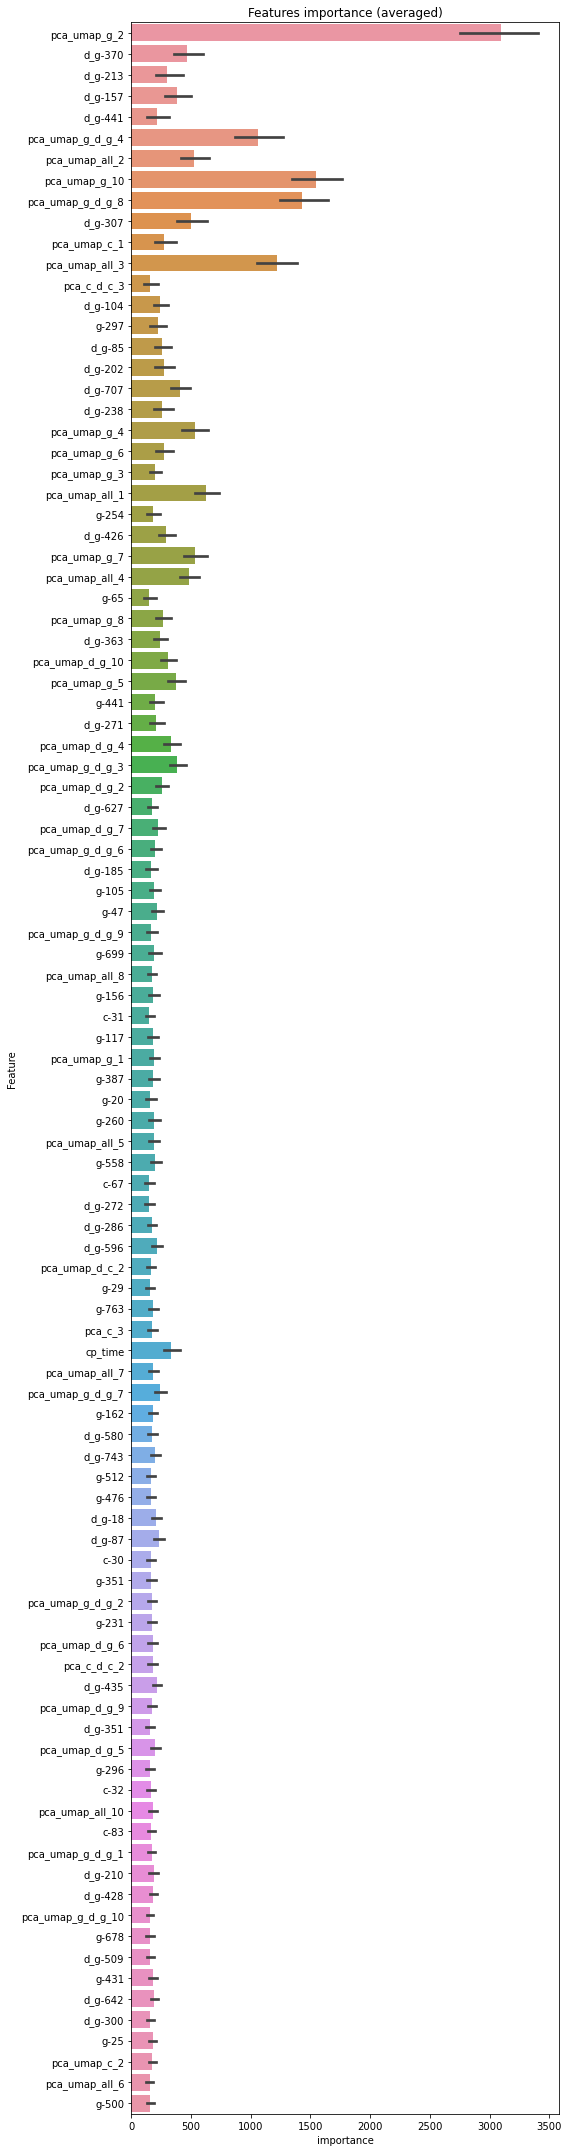

In [52]:
show_feature_importance(feature_importance_df)